In [ ]:
!pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.0/102.0 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 8.9 MB/s eta 0:00:00
  Attempting uninstall: jax-cuda12-pjrt
    Found existing installation: jax-cuda12-pjrt 0.4.33
    Uninstalling jax-cuda12-pjrt-0.4.33:
      Successfully uninstalled jax-cuda12-pjrt-0.4.33
  Attempting uninstall: nvidia-cuda-nvcc-cu12
    Found existing installation: nvidia-cuda-nvcc-cu12 12.5.82
    Uninstalling nvidia-cuda-nvcc-cu12-12.5.82:
      Successfully uninstalled nvidia-cuda-nvcc-cu12-12.5.82
  Attempting uninstall: jax-cuda12-plugin
    Found existing installation: jax-cuda12-plugin 0.4.33
    Uninstal

In [ ]:
!pip install swig
!pip install gymnasium[box2d]

In [ ]:
import flax.linen as nn
import gymnasium as gym
from gymnasium.wrappers import FlattenObservation
from gymnasium.utils import seeding

from functools import partial
import numpy as np
import wandb
import jax
import optax
import collections
import jax.numpy as jnp
from flax import struct
from tqdm import trange
import matplotlib.pyplot as plt
from flax.core import frozen_dict
from flax.training.train_state import TrainState

from typing import Optional, Any, Union, Sequence, Dict, Tuple, Type, Iterable, Callable
import moviepy.editor
DataType = Union[np.ndarray, Dict[str, "DataType"]]
DatasetDict = Dict[str, DataType]
default_init = nn.initializers.xavier_uniform

  if event.key is 'enter':



In [ ]:
class UniversalSeed(gym.Wrapper):
    def seed(self, seed: int):
        seeds = self.env.seed(seed)
        self.env.observation_space.seed(seed)
        self.env.action_space.seed(seed)
        return seeds

def wrap_gym(env: gym.Env, rescale_actions: bool = True) -> gym.Env:
    # env = SinglePrecision(env)
    env = UniversalSeed(env)
    if rescale_actions:
        env = gym.wrappers.RescaleAction(env, -1, 1)

    if isinstance(env.observation_space, gym.spaces.Dict):
        env = FlattenObservation(env)

    env = gym.wrappers.ClipAction(env)

    return env

In [ ]:
env = gym.make("BipedalWalker-v3", render_mode="rgb_array")
env = wrap_gym(env, rescale_actions=True)
env = video = gym.wrappers.RecordVideo(env, 'cartpole_video')
observation, _ = env.reset()
for i in trange(10000):
    action = env.action_space.sample()
    next_observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    if done:
        print('DONE!')
        break
env.close()
moviepy.editor.ipython_display("cartpole_video/rl-video-episode-0.mp4")

  1%|          | 86/10000 [00:01<03:07, 52.82it/s]


DONE!


In [ ]:
@partial(jax.jit, static_argnames="apply_fn")
def _sample_actions(rng, apply_fn, params, observations: np.ndarray) -> np.ndarray:
    key, rng = jax.random.split(rng)
    dist = apply_fn({"params": params}, observations)
    return dist.sample(seed=key), rng

@partial(jax.jit, static_argnames="apply_fn")
def _eval_actions(apply_fn, params, observations: np.ndarray) -> np.ndarray:
    dist = apply_fn({"params": params}, observations)
    return dist.mode()

class Agent(struct.PyTreeNode):
    actor: TrainState
    rng: Any

    def eval_actions(self, observations: np.ndarray) -> np.ndarray:
        actions = _eval_actions(self.actor.apply_fn, self.actor.params, observations)
        return np.asarray(actions), self.replace(rng=self.rng)

    def sample_actions(self, observations: np.ndarray) -> np.ndarray:
        actions, new_rng = _sample_actions(
            self.rng, self.actor.apply_fn, self.actor.params, observations
        )
        return np.asarray(actions), self.replace(rng=new_rng)


In [ ]:

def cosine_beta_schedule(timesteps, s = 0.008):
    """
    cosine schedule
    as proposed in https://openreview.net/forum?id=-NEXDKk8gZ
    """
    steps = timesteps + 1
    t = jnp.linspace(0, timesteps, steps) / timesteps
    alphas_cumprod = jnp.cos((t + s) / (1 + s) * jnp.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return jnp.clip(betas, 0, 0.999)

def linear_beta_schedule(timesteps, beta_start=1e-4, beta_end=2e-2):
    betas = jnp.linspace(
        beta_start, beta_end, timesteps
    )
    return betas

def vp_beta_schedule(timesteps):
    t = jnp.arange(1, timesteps + 1)
    T = timesteps
    b_max = 10.
    b_min = 0.1
    alpha = jnp.exp(-b_min / T - 0.5 * (b_max - b_min) * (2 * t - 1) / T ** 2)
    betas = 1 - alpha
    return betas

class FourierFeatures(nn.Module):
    output_size: int
    learnable: bool = True

    @nn.compact
    def __call__(self, x: jnp.ndarray):
        if self.learnable:
            w = self.param('kernel', nn.initializers.normal(0.2),
                           (self.output_size // 2, x.shape[-1]), jnp.float32)
            f = 2 * jnp.pi * x @ w.T
        else:
            half_dim = self.output_size // 2
            f = jnp.log(10000) / (half_dim - 1)
            f = jnp.exp(jnp.arange(half_dim) * -f)
            f = x * f
        return jnp.concatenate([jnp.cos(f), jnp.sin(f)], axis=-1)

class DDPM(nn.Module):
    cond_encoder_cls: Type[nn.Module]
    reverse_encoder_cls: Type[nn.Module]
    time_preprocess_cls: Type[nn.Module]

    @nn.compact
    def __call__(self,
                 s: jnp.ndarray,
                 a: jnp.ndarray,
                 time: jnp.ndarray,
                 training: bool = False):

        t_ff = self.time_preprocess_cls()(time)
        cond = self.cond_encoder_cls()(t_ff, training=training)
        reverse_input = jnp.concatenate([a, s, cond], axis=-1)

        return self.reverse_encoder_cls()(reverse_input, training=training)

@partial(jax.jit, static_argnames=('actor_apply_fn', 'act_dim', 'T', 'clip_sampler', 'training'))
def ddpm_sampler(actor_apply_fn, actor_params, T, rng, act_dim, observations, alphas, alpha_hats, betas, sample_temperature, clip_sampler, training = False):

    batch_size = observations.shape[0]

    def fn(input_tuple, time):
        current_x, rng = input_tuple

        input_time = jnp.expand_dims(
            jnp.array([time]).repeat(current_x.shape[0]), axis=1)
        eps_pred = actor_apply_fn(
            {"params": actor_params},
            observations, current_x,
            input_time, training=training)

        alpha_1 = 1 / jnp.sqrt(alphas[time])
        alpha_2 = ((1 - alphas[time]) / (jnp.sqrt(1 - alpha_hats[time])))
        current_x = alpha_1 * (current_x - alpha_2 * eps_pred)

        rng, key = jax.random.split(rng, 2)
        z = jax.random.normal(
            key, shape=(observations.shape[0], current_x.shape[1]),)

        z_scaled = sample_temperature * z
        current_x = current_x + (time > 0) * (jnp.sqrt(betas[time]) * z_scaled)
        current_x = jnp.clip(current_x, -1, 1) if clip_sampler else current_x
        return (current_x, rng), ()

    key, rng = jax.random.split(rng, 2)
    (action_0, rng), () = jax.lax.scan(
        fn, (jax.random.normal(key, (batch_size, act_dim)), rng),
        jnp.arange(T-1, -1, -1), unroll=5)
    action_0 = jnp.clip(action_0, -1, 1)
    return action_0, rng


In [ ]:

def _check_lengths(dataset_dict: DatasetDict, dataset_len: Optional[int] = None) -> int:
    for v in dataset_dict.values():
        if isinstance(v, dict):
            dataset_len = dataset_len or _check_lengths(v, dataset_len)
        elif isinstance(v, np.ndarray):
            item_len = len(v)
            dataset_len = dataset_len or item_len
            assert dataset_len == item_len, "Inconsistent item lengths in the dataset."
        else:
            raise TypeError("Unsupported type.")
    return dataset_len


def _subselect(dataset_dict: DatasetDict, index: np.ndarray) -> DatasetDict:
    new_dataset_dict = {}
    for k, v in dataset_dict.items():
        if isinstance(v, dict):
            new_v = _subselect(v, index)
        elif isinstance(v, np.ndarray):
            new_v = v[index]
        else:
            raise TypeError("Unsupported type.")
        new_dataset_dict[k] = new_v
    return new_dataset_dict


def _sample(
    dataset_dict: Union[np.ndarray, DatasetDict], indx: np.ndarray
) -> DatasetDict:
    if isinstance(dataset_dict, np.ndarray):
        return dataset_dict[indx]
    elif isinstance(dataset_dict, dict):
        batch = {}
        for k, v in dataset_dict.items():
            batch[k] = _sample(v, indx)
    else:
        raise TypeError("Unsupported type.")
    return batch


class Dataset(object):
    def __init__(self, dataset_dict: DatasetDict, seed: Optional[int] = None):
        self.dataset_dict = dataset_dict
        self.dataset_len = _check_lengths(dataset_dict)

        # Seeding similar to OpenAI Gym:
        # https://github.com/openai/gym/blob/master/gym/spaces/space.py#L46
        self._np_random = None
        self._seed = None
        if seed is not None:
            self.seed(seed)

    @property
    def np_random(self) -> np.random.RandomState:
        if self._np_random is None:
            self.seed()
        return self._np_random

    def seed(self, seed: Optional[int] = None) -> list:
        self._np_random, self._seed = seeding.np_random(seed)
        return [self._seed]

    def __len__(self) -> int:
        return self.dataset_len

    def sample(
        self,
        batch_size: int,
        keys: Optional[Iterable[str]] = None,
        indx: Optional[np.ndarray] = None,
    ) -> frozen_dict.FrozenDict:
        if indx is None:
            if hasattr(self.np_random, "integers"):
                indx = self.np_random.integers(len(self), size=batch_size)
            else:
                indx = self.np_random.randint(len(self), size=batch_size)

        batch = dict()

        if keys is None:
            keys = self.dataset_dict.keys()

        for k in keys:
            if isinstance(self.dataset_dict[k], dict):
                batch[k] = _sample(self.dataset_dict[k], indx)
            else:
                batch[k] = self.dataset_dict[k][indx]

        return frozen_dict.freeze(batch)

    def sample_jax(self, batch_size: int, keys: Optional[Iterable[str]] = None):
        if not hasattr(self, "rng"):
            self.rng = jax.random.PRNGKey(self._seed or 42)

            if keys is None:
                keys = self.dataset_dict.keys()

            jax_dataset_dict = {k: self.dataset_dict[k] for k in keys}
            jax_dataset_dict = jax.device_put(jax_dataset_dict)

            @jax.jit
            def _sample_jax(rng):
                key, rng = jax.random.split(rng)
                indx = jax.random.randint(
                    key, (batch_size,), minval=0, maxval=len(self)
                )
                return rng, jax.tree_map(
                    lambda d: jnp.take(d, indx, axis=0), jax_dataset_dict
                )

            self._sample_jax = _sample_jax

        self.rng, sample = self._sample_jax(self.rng)
        return sample

    def split(self, ratio: float) -> Tuple["Dataset", "Dataset"]:
        assert 0 < ratio and ratio < 1
        train_index = np.index_exp[: int(self.dataset_len * ratio)]
        test_index = np.index_exp[int(self.dataset_len * ratio) :]

        index = np.arange(len(self), dtype=np.int32)
        self.np_random.shuffle(index)
        train_index = index[: int(self.dataset_len * ratio)]
        test_index = index[int(self.dataset_len * ratio) :]

        train_dataset_dict = _subselect(self.dataset_dict, train_index)
        test_dataset_dict = _subselect(self.dataset_dict, test_index)
        return Dataset(train_dataset_dict), Dataset(test_dataset_dict)

    def _trajectory_boundaries_and_returns(self) -> Tuple[list, list, list]:
        episode_starts = [0]
        episode_ends = []

        episode_return = 0
        episode_returns = []

        for i in range(len(self)):
            episode_return += self.dataset_dict["rewards"][i]

            if self.dataset_dict["dones"][i]:
                episode_returns.append(episode_return)
                episode_ends.append(i + 1)
                if i + 1 < len(self):
                    episode_starts.append(i + 1)
                episode_return = 0.0

        return episode_starts, episode_ends, episode_returns

    def filter(
        self, take_top: Optional[float] = None, threshold: Optional[float] = None
    ):
        assert (take_top is None and threshold is not None) or (
            take_top is not None and threshold is None
        )

        (
            episode_starts,
            episode_ends,
            episode_returns,
        ) = self._trajectory_boundaries_and_returns()

        if take_top is not None:
            threshold = np.percentile(episode_returns, 100 - take_top)

        bool_indx = np.full((len(self),), False, dtype=bool)

        for i in range(len(episode_returns)):
            if episode_returns[i] >= threshold:
                bool_indx[episode_starts[i] : episode_ends[i]] = True

        self.dataset_dict = _subselect(self.dataset_dict, bool_indx)

        self.dataset_len = _check_lengths(self.dataset_dict)

    def normalize_returns(self, scaling: float = 1000):
        (_, _, episode_returns) = self._trajectory_boundaries_and_returns()
        self.dataset_dict["rewards"] /= np.max(episode_returns) - np.min(
            episode_returns
        )
        self.dataset_dict["rewards"] *= scaling


In [ ]:

def _init_replay_dict(
    obs_space: gym.Space, capacity: int
) -> Union[np.ndarray, DatasetDict]:
    if isinstance(obs_space, gym.spaces.Box):
        return np.empty((capacity, *obs_space.shape), dtype=obs_space.dtype)
    elif isinstance(obs_space, gym.spaces.Dict):
        data_dict = {}
        for k, v in obs_space.spaces.items():
            data_dict[k] = _init_replay_dict(v, capacity)
        return data_dict
    else:
        raise TypeError()


def _insert_recursively(
    dataset_dict: DatasetDict, data_dict: DatasetDict, insert_index: int
):
    if isinstance(dataset_dict, np.ndarray):
        dataset_dict[insert_index] = data_dict
    elif isinstance(dataset_dict, dict):
        assert dataset_dict.keys() == data_dict.keys()
        for k in dataset_dict.keys():
            _insert_recursively(dataset_dict[k], data_dict[k], insert_index)
    else:
        raise TypeError()


class ReplayBuffer(Dataset):
    def __init__(
        self,
        observation_space: gym.Space,
        action_space: gym.Space,
        capacity: int,
        next_observation_space: Optional[gym.Space] = None,
    ):
        if next_observation_space is None:
            next_observation_space = observation_space

        observation_data = _init_replay_dict(observation_space, capacity)
        next_observation_data = _init_replay_dict(next_observation_space, capacity)
        dataset_dict = dict(
            observations=observation_data,
            next_observations=next_observation_data,
            actions=np.empty((capacity, *action_space.shape), dtype=action_space.dtype),
            rewards=np.empty((capacity,), dtype=np.float32),
            masks=np.empty((capacity,), dtype=np.float32),
            dones=np.empty((capacity,), dtype=bool),
        )

        super().__init__(dataset_dict)

        self._size = 0
        self._capacity = capacity
        self._insert_index = 0

    def __len__(self) -> int:
        return self._size

    def insert(self, data_dict: DatasetDict):
        _insert_recursively(self.dataset_dict, data_dict, self._insert_index)

        self._insert_index = (self._insert_index + 1) % self._capacity
        self._size = min(self._size + 1, self._capacity)

    def get_iterator(self, queue_size: int = 2, sample_args: dict = {}):
        # See https://flax.readthedocs.io/en/latest/_modules/flax/jax_utils.html#prefetch_to_device
        # queue_size = 2 should be ok for one GPU.

        queue = collections.deque()

        def enqueue(n):
            for _ in range(n):
                data = self.sample(**sample_args)
                queue.append(jax.device_put(data))

        enqueue(queue_size)
        while queue:
            yield queue.popleft()
            enqueue(1)


In [ ]:
class MLP(nn.Module):
    hidden_dims: Sequence[int]
    activations: Callable[[jnp.ndarray], jnp.ndarray] = nn.relu
    activate_final: bool = False
    use_layer_norm: bool = False
    scale_final: Optional[float] = None
    dropout_rate: Optional[float] = None

    @nn.compact
    def __call__(self, x: jnp.ndarray, training: bool = False) -> jnp.ndarray:
        if self.use_layer_norm:
            x = nn.LayerNorm()(x)
        for i, size in enumerate(self.hidden_dims):
            if i + 1 == len(self.hidden_dims) and self.scale_final is not None:
                x = nn.Dense(size, kernel_init=default_init(self.scale_final))(x)
            else:
                x = nn.Dense(size, kernel_init=default_init())(x)

            if i + 1 < len(self.hidden_dims) or self.activate_final:
                if self.dropout_rate is not None and self.dropout_rate > 0:
                    x = nn.Dropout(rate=self.dropout_rate)(
                        x, deterministic=not training
                    )
                x = self.activations(x)
        return x


In [ ]:
tree_map = jax.tree_util.tree_map
sg = lambda x: tree_map(jax.lax.stop_gradient, x)

def mish(x):
    return x * jnp.tanh(nn.softplus(x))

class StateActionValue(nn.Module):
    base_cls: nn.Module

    @nn.compact
    def __call__(
        self, observations: jnp.ndarray, actions: jnp.ndarray, *args, **kwargs
    ) -> jnp.ndarray:
        inputs = jnp.concatenate([observations, actions], axis=-1)
        outputs = self.base_cls()(inputs, *args, **kwargs)

        value = nn.Dense(1, kernel_init=default_init())(outputs)

        return jnp.squeeze(value, -1)

def tensorstats(tensor, prefix=None):
  assert tensor.size > 0, tensor.shape
  metrics = {
      'mean': tensor.mean(),
      'std': tensor.std(),
      'mag': jnp.abs(tensor).max(),
      'min': tensor.min(),
      'max': tensor.max(),
  }
  if prefix:
    metrics = {f'{prefix}_{k}': v for k, v in metrics.items()}
  return metrics

class ScoreMatchingLearner(Agent):
    score_model: TrainState
    critic_1: TrainState
    critic_2: TrainState
    target_critic_1: TrainState
    target_critic_2: TrainState

    discount: float
    tau: float
    act_dim: int = struct.field(pytree_node=False)
    T: int = struct.field(pytree_node=False)
    clip_sampler: bool = struct.field(pytree_node=False)
    ddpm_temperature: float
    betas: jnp.ndarray
    alphas: jnp.ndarray
    alpha_hats: jnp.ndarray
    # global scaling factor for grad_a Q(s, a)
    M_q: float

    @classmethod
    def create(
        cls,
        seed: int,
        observation_space: gym.spaces.Space,
        action_space: gym.spaces.Box,
        actor_architecture: str = 'mlp',
        actor_lr: Union[float, optax.Schedule] = 3e-4,
        critic_lr: float = 3e-4,
        critic_hidden_dims: Sequence[int] = (256, 256),
        actor_hidden_dims: Sequence[int] = (256, 256, 256),
        discount: float = 0.99,
        tau: float = 0.005,
        ddpm_temperature: float = 1.0,
        actor_layer_norm: bool = False,
        T: int = 5,
        time_dim: int = 64,
        clip_sampler: bool = True,
        beta_schedule: str = 'vp',
        decay_steps: Optional[int] = int(2e6),
        M_q: float = 1,
    ):

        rng = jax.random.PRNGKey(seed)
        rng, actor_key, critic_key = jax.random.split(rng, 3)
        actions = action_space.sample()
        observations = observation_space.sample()
        action_dim = action_space.shape[-1]

        # Time embedding network.
        preprocess_time_cls = partial(
            FourierFeatures, output_size=time_dim, learnable=True)

        cond_model_cls = partial(
            MLP, hidden_dims=(128, 128), activations=mish,
            activate_final=False)

        if decay_steps is not None:
            actor_lr = optax.cosine_decay_schedule(actor_lr, decay_steps)

        if actor_architecture == 'mlp':
            base_model_cls = partial(MLP,
                hidden_dims=tuple(list(actor_hidden_dims) + [action_dim]),
                activations=mish, use_layer_norm=actor_layer_norm,
                activate_final=False)

            actor_def = DDPM(time_preprocess_cls=preprocess_time_cls,
                             cond_encoder_cls=cond_model_cls,
                             reverse_encoder_cls=base_model_cls)
        else:
            raise ValueError(f'Invalid actor architecture: {actor_architecture}')

        time = jnp.zeros((1, 1))
        observations = jnp.expand_dims(observations, axis = 0)
        actions = jnp.expand_dims(actions, axis = 0)
        actor_params = actor_def.init(
            actor_key, observations, actions, time)['params']

        score_model = TrainState.create(
            apply_fn=actor_def.apply, params=actor_params,
            tx=optax.adam(learning_rate=actor_lr))

        # Initialize critics.
        critic_base_cls = partial(
            MLP, hidden_dims=critic_hidden_dims, activate_final=True)
        critic_def = StateActionValue(critic_base_cls)
        critic_key_1, critic_key_2 = jax.random.split(critic_key, 2)
        critic_params_1 = critic_def.init(critic_key_1, observations, actions)["params"]
        critic_params_2 = critic_def.init(critic_key_2, observations, actions)["params"]
        critic_1 = TrainState.create(
            apply_fn=critic_def.apply,
            params=critic_params_1,
            tx=optax.adam(learning_rate=critic_lr))
        critic_2 = TrainState.create(
            apply_fn=critic_def.apply,
            params=critic_params_2,
            tx=optax.adam(learning_rate=critic_lr))

        target_critic_def = StateActionValue(critic_base_cls)
        target_critic_1 = TrainState.create(
            apply_fn=target_critic_def.apply,
            params=critic_params_1,
            tx=optax.GradientTransformation(lambda _: None, lambda _: None),)
        target_critic_2 = TrainState.create(
            apply_fn=target_critic_def.apply,
            params=critic_params_2,
            tx=optax.GradientTransformation(lambda _: None, lambda _: None),)

        if beta_schedule == 'cosine':
            betas = jnp.array(cosine_beta_schedule(T))
        elif beta_schedule == 'linear':
            betas = jnp.linspace(1e-4, 2e-2, T)
        elif beta_schedule == 'vp':
            betas = jnp.array(vp_beta_schedule(T))
        else:
            raise ValueError(f'Invalid beta schedule: {beta_schedule}')

        alphas = 1 - betas
        alpha_hat = jnp.array([jnp.prod(alphas[:i + 1]) for i in range(T)])

        return cls(
            actor=None,
            score_model=score_model,
            critic_1=critic_1,
            critic_2=critic_2,
            target_critic_1=target_critic_1,
            target_critic_2=target_critic_2,
            tau=tau,
            discount=discount,
            rng=rng,
            betas=betas,
            alpha_hats=alpha_hat,
            act_dim=action_dim,
            T=T,
            alphas=alphas,
            ddpm_temperature=ddpm_temperature,
            clip_sampler=clip_sampler,
            M_q=M_q,
        )

    def update_q(agent, batch: DatasetDict) -> Tuple[Agent, Dict[str, float]]:
        (B, _) = batch['observations'].shape
        (_, A) = batch['actions'].shape

        # Sample actions for next state.
        key, rng = jax.random.split(agent.rng)
        next_actions, rng = ddpm_sampler(
            agent.score_model.apply_fn,
            agent.score_model.params,
            agent.T, rng, agent.act_dim,
            batch['next_observations'],
            agent.alphas, agent.alpha_hats,
            agent.betas, agent.ddpm_temperature,
            agent.clip_sampler)
        key, rng = jax.random.split(rng, 2)
        noise = jax.random.normal(key, shape=next_actions.shape) * 0.1
        next_actions = next_actions + noise
        next_actions = jnp.clip(next_actions, -1.0, 1.0)
        key, rng = jax.random.split(rng, 2)
        assert next_actions.shape == (B, A)

        # Compute target q.
        key, rng = jax.random.split(rng)
        next_q_1 = agent.target_critic_1.apply_fn(
            {"params": agent.target_critic_1.params}, batch["next_observations"],
            next_actions, True, rngs={"dropout": key})
        key, rng = jax.random.split(rng)
        next_q_2 = agent.target_critic_2.apply_fn(
            {"params": agent.target_critic_2.params}, batch["next_observations"],
            next_actions, True, rngs={"dropout": key})
        key, rng = jax.random.split(rng)
        next_v = jnp.stack([next_q_1, next_q_2], 0).min(0)
        target_q = batch["rewards"] + agent.discount * batch["masks"] * next_v
        metrics = tensorstats(target_q, 'target_q')
        assert target_q.shape == (B,)

        def critic_loss_fn(critic_params) -> Tuple[jnp.ndarray, Dict[str, float]]:
            q = agent.critic_1.apply_fn(
                {"params": critic_params},
                batch["observations"],
                batch["actions"], training=True)
            loss = ((q - sg(target_q)) ** 2)
            assert loss.shape == (B,)
            metrics = {**tensorstats(loss, 'c_loss'), **tensorstats(q, 'q')}
            return loss.mean(), metrics

        grads_c_1, metrics_c_1 = jax.grad(critic_loss_fn, has_aux=True)(agent.critic_1.params)
        metrics.update({f'{k}_1': v for k, v in metrics_c_1.items()})
        critic_1 = agent.critic_1.apply_gradients(grads=grads_c_1)

        grads_c_2, metrics_c_2 = jax.grad(critic_loss_fn, has_aux=True)(agent.critic_2.params)
        metrics.update({f'{k}_2': v for k, v in metrics_c_2.items()})
        critic_2 = agent.critic_2.apply_gradients(grads=grads_c_2)

        target_critic_1_params = optax.incremental_update(
            critic_1.params, agent.target_critic_1.params, agent.tau)
        target_critic_2_params = optax.incremental_update(
            critic_2.params, agent.target_critic_2.params, agent.tau)
        target_critic_1 = agent.target_critic_1.replace(params=target_critic_1_params)
        target_critic_2 = agent.target_critic_2.replace(params=target_critic_2_params)
        new_agent = agent.replace(
            critic_1=critic_1, critic_2=critic_2,
            target_critic_1=target_critic_1,
            target_critic_2=target_critic_2,
            rng=rng)
        return new_agent, metrics

    def update_actor(agent, batch: DatasetDict) -> Tuple[Agent, Dict[str, float]]:
        B, A = batch['actions'].shape

        # Forward process with RB actions.
        key, rng = jax.random.split(agent.rng, 2)
        time = jax.random.randint(key, (B,), 0, agent.T)
        key, rng = jax.random.split(rng, 2)
        noise_sample = jax.random.normal(
            key, (B, agent.act_dim))
        key, rng = jax.random.split(rng, 2)
        alpha_hats = agent.alpha_hats[time]
        time = jnp.expand_dims(time, axis=1)
        alpha_1 = jnp.expand_dims(jnp.sqrt(alpha_hats), axis=1)
        alpha_2 = jnp.expand_dims(jnp.sqrt(1 - alpha_hats), axis=1)
        noisy_actions = alpha_1 * batch['actions'] + alpha_2 * noise_sample
        key, rng = jax.random.split(rng, 2)

        # Compute dQ/da.
        critic_1_jacobian = jax.grad(lambda actions: agent.critic_1.apply_fn(
            {"params": agent.critic_1.params}, batch['observations'], actions).sum(),
            has_aux=False)(noisy_actions)
        assert critic_1_jacobian.shape == (B, A), (critic_1_jacobian.shape, (B, A))
        critic_2_jacobian = jax.grad(lambda actions: agent.critic_2.apply_fn(
            {"params": agent.critic_2.params}, batch['observations'], actions).sum(),
            has_aux=False)(noisy_actions)
        assert critic_2_jacobian.shape == (B, A), (critic_2_jacobian.shape, (B, A))
        critic_jacobian = jnp.stack([critic_1_jacobian, critic_2_jacobian], 0).mean(0)

        def actor_loss_fn(
                score_model_params) -> Tuple[jnp.ndarray, Dict[str, float]]:
            eps_pred = agent.score_model.apply_fn(
                {'params': score_model_params}, batch['observations'],
                noisy_actions, time, rngs={'dropout': key}, training=True)
            assert eps_pred.shape == (B, A)
            actor_loss = jnp.power(-agent.M_q*sg(critic_jacobian) - eps_pred, 2).mean(-1)
            assert actor_loss.shape == (B,)
            metrics = tensorstats(actor_loss, 'actor_loss')
            metrics.update(tensorstats(eps_pred, 'eps_pred'))
            metrics.update(tensorstats(critic_jacobian, 'critic_jacobian'))
            return actor_loss.mean(0), metrics

        key, rng = jax.random.split(rng, 2)
        grads, metrics = jax.grad(actor_loss_fn, has_aux=True)(
            agent.score_model.params)
        score_model = agent.score_model.apply_gradients(grads=grads)
        new_agent = agent.replace(
            score_model=score_model,
            rng=rng)
        return new_agent, metrics

    @jax.jit
    def sample_actions(self, observations: jnp.ndarray):
        actions, new_agent = self.eval_actions(observations)
        key, rng = jax.random.split(new_agent.rng, 2)
        noise = jax.random.normal(key, shape=actions.shape) * 0.1
        actions = actions + noise
        actions = jnp.clip(actions, -1.0, 1.0)
        key, rng = jax.random.split(rng, 2)
        return actions, new_agent.replace(rng=rng)

    @jax.jit
    def eval_actions(self, observations: jnp.ndarray):
        rng = self.rng
        assert len(observations.shape) == 1
        observations = observations[None]

        actions, rng = ddpm_sampler(
            self.score_model.apply_fn,
            self.score_model.params,
            self.T, rng, self.act_dim, observations,
            self.alphas, self.alpha_hats,
            self.betas, self.ddpm_temperature,
            self.clip_sampler)
        assert actions.shape == (1, self.act_dim)
        _, rng = jax.random.split(rng, 2)
        return jnp.squeeze(actions), self.replace(rng=rng)

    @jax.jit
    def update(self, batch: DatasetDict):
        new_agent = self
        new_agent, critic_info = new_agent.update_q(batch)
        new_agent, actor_info = new_agent.update_actor(batch)
        return new_agent, {**actor_info, **critic_info}

In [ ]:
def evaluate(agent, env: gym.Env, num_episodes: int) -> Dict[str, float]:
    for _ in range(num_episodes):
        observation, _ = env.reset()
        done = False
        while not done:
            action, agent = agent.eval_actions(observation)
            observation, _, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
    return {"return": np.mean(env.return_queue)}

In [ ]:
max_iter = 100_000
start_step = 50_000
print_interval = 1000
batch_size = 256
num_episodes = 1

### Pendulum-v1

In [ ]:
env = gym.make("Pendulum-v1", render_mode=None)
env = wrap_gym(env, rescale_actions=True)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=1)

eval_env = gym.make("Pendulum-v1", render_mode=None) # "rgb_array"
eval_env = wrap_gym(eval_env, rescale_actions=True)
# eval_env = gym.wrappers.RecordVideo(eval_env, 'cartpole_video')
eval_env = gym.wrappers.RecordEpisodeStatistics(eval_env, buffer_length=1)

agent = ScoreMatchingLearner.create(42, env.observation_space, env.action_space)

replay_buffer = ReplayBuffer(env.observation_space, env.action_space, max_iter)

observation, _ = env.reset()
done = False

rs, ls, ts = [], [], []
rewards = []
rews = 0
rews_arr = []
pbar = trange(1, max_iter+1, desc='Training')
for i in pbar:
    if i < start_step:
        action = env.action_space.sample()
    else:
        action, agent = agent.sample_actions(observation)
        action = np.asarray(action)
    next_observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    rews += reward
    if not done or "TimeLimit.truncated" in info:
        mask = 1.0
    else:
        mask = 0.0

    replay_buffer.insert(
            dict(
                observations=observation,
                actions=action,
                rewards=reward,
                masks=mask,
                dones=done,
                next_observations=next_observation,
            )
        )
    observation = next_observation
    rewards.append(reward)
    if done:
        rews_arr.append(rews)
        rews = 0
        observation, _ = env.reset()
        done = False
        # print("Done Info:", info)
        pbar.set_postfix(info['episode'])
        rs.append(info['episode']['r'])
        ls.append(info['episode']['l'])
        ts.append(info['episode']['t'])

    if i >= start_step:
        batch = replay_buffer.sample(batch_size)
        agent, update_info = agent.update(batch)

        if i % print_interval == 0:
            print("Update Info:", update_info)
            print('rew_arrs : ', rews_arr[-1])


    if i % 100_000 == 0:
        eval_info = evaluate(agent, eval_env, num_episodes=num_episodes)
        print("Eval Info", eval_info)

eval_env.close()
env.close()

Training:  10%|█         | 10000/100000 [00:23<12:24, 120.85it/s, r=-1.41e+3, l=200, t=5.98]

Update Info: {'actor_loss_mag': Array(0.09889767, dtype=float32), 'actor_loss_max': Array(0.09889767, dtype=float32), 'actor_loss_mean': Array(0.02175997, dtype=float32), 'actor_loss_min': Array(7.274769e-05, dtype=float32), 'actor_loss_std': Array(0.01959503, dtype=float32), 'c_loss_mag_1': Array(242.78517, dtype=float32), 'c_loss_mag_2': Array(217.33589, dtype=float32), 'c_loss_max_1': Array(242.78517, dtype=float32), 'c_loss_max_2': Array(217.33589, dtype=float32), 'c_loss_mean_1': Array(54.787468, dtype=float32), 'c_loss_mean_2': Array(51.30783, dtype=float32), 'c_loss_min_1': Array(0.00180556, dtype=float32), 'c_loss_min_2': Array(0.0011935, dtype=float32), 'c_loss_std_1': Array(45.684307, dtype=float32), 'c_loss_std_2': Array(42.626793, dtype=float32), 'critic_jacobian_mag': Array(0.08434854, dtype=float32), 'critic_jacobian_max': Array(0.08434854, dtype=float32), 'critic_jacobian_mean': Array(0.00484109, dtype=float32), 'critic_jacobian_min': Array(-0.0673929, dtype=float32), 'c

Training:  11%|█         | 10631/100000 [00:29<11:30, 129.38it/s, r=-1.55e+3, l=200, t=0.915]

Update Info: {'actor_loss_mag': Array(0.26278314, dtype=float32), 'actor_loss_max': Array(0.26278314, dtype=float32), 'actor_loss_mean': Array(0.02091875, dtype=float32), 'actor_loss_min': Array(9.1286125e-08, dtype=float32), 'actor_loss_std': Array(0.03157086, dtype=float32), 'c_loss_mag_1': Array(146.8265, dtype=float32), 'c_loss_mag_2': Array(149.01935, dtype=float32), 'c_loss_max_1': Array(146.8265, dtype=float32), 'c_loss_max_2': Array(149.01935, dtype=float32), 'c_loss_mean_1': Array(1.5218775, dtype=float32), 'c_loss_mean_2': Array(1.3872778, dtype=float32), 'c_loss_min_1': Array(9.985204e-05, dtype=float32), 'c_loss_min_2': Array(2.0112117e-05, dtype=float32), 'c_loss_std_1': Array(9.203273, dtype=float32), 'c_loss_std_2': Array(9.330945, dtype=float32), 'critic_jacobian_mag': Array(1.6120048, dtype=float32), 'critic_jacobian_max': Array(1.6120048, dtype=float32), 'critic_jacobian_mean': Array(0.10268836, dtype=float32), 'critic_jacobian_min': Array(-1.3237957, dtype=float32), 

Training:  12%|█▏        | 11998/100000 [00:34<08:22, 174.98it/s, r=-719, l=200, t=0.95]     

Update Info: {'actor_loss_mag': Array(0.592218, dtype=float32), 'actor_loss_max': Array(0.592218, dtype=float32), 'actor_loss_mean': Array(0.04346672, dtype=float32), 'actor_loss_min': Array(1.1531657e-05, dtype=float32), 'actor_loss_std': Array(0.0745218, dtype=float32), 'c_loss_mag_1': Array(121.01935, dtype=float32), 'c_loss_mag_2': Array(135.93327, dtype=float32), 'c_loss_max_1': Array(121.01935, dtype=float32), 'c_loss_max_2': Array(135.93327, dtype=float32), 'c_loss_mean_1': Array(1.926292, dtype=float32), 'c_loss_mean_2': Array(1.9062515, dtype=float32), 'c_loss_min_1': Array(5.5218115e-06, dtype=float32), 'c_loss_min_2': Array(4.5634806e-08, dtype=float32), 'c_loss_std_1': Array(10.255685, dtype=float32), 'c_loss_std_2': Array(10.853145, dtype=float32), 'critic_jacobian_mag': Array(3.2920032, dtype=float32), 'critic_jacobian_max': Array(3.2920032, dtype=float32), 'critic_jacobian_mean': Array(-0.06808662, dtype=float32), 'critic_jacobian_min': Array(-2.7135537, dtype=float32), 

Training:  13%|█▎        | 13031/100000 [00:39<07:14, 200.04it/s, r=-0.916, l=200, t=1.01]

Update Info: {'actor_loss_mag': Array(1.1508514, dtype=float32), 'actor_loss_max': Array(1.1508514, dtype=float32), 'actor_loss_mean': Array(0.11446872, dtype=float32), 'actor_loss_min': Array(3.7839095e-06, dtype=float32), 'actor_loss_std': Array(0.175298, dtype=float32), 'c_loss_mag_1': Array(8857.446, dtype=float32), 'c_loss_mag_2': Array(8798.656, dtype=float32), 'c_loss_max_1': Array(8857.446, dtype=float32), 'c_loss_max_2': Array(8798.656, dtype=float32), 'c_loss_mean_1': Array(37.58432, dtype=float32), 'c_loss_mean_2': Array(37.14619, dtype=float32), 'c_loss_min_1': Array(0.00180998, dtype=float32), 'c_loss_min_2': Array(8.185452e-06, dtype=float32), 'c_loss_std_1': Array(552.35345, dtype=float32), 'c_loss_std_2': Array(548.70215, dtype=float32), 'critic_jacobian_mag': Array(5.3970146, dtype=float32), 'critic_jacobian_max': Array(5.3970146, dtype=float32), 'critic_jacobian_mean': Array(0.31609678, dtype=float32), 'critic_jacobian_min': Array(-4.628682, dtype=float32), 'critic_ja

Training:  14%|█▍        | 14035/100000 [00:44<07:22, 194.06it/s, r=-2.3, l=200, t=0.981]

Update Info: {'actor_loss_mag': Array(2.0863109, dtype=float32), 'actor_loss_max': Array(2.0863109, dtype=float32), 'actor_loss_mean': Array(0.1575073, dtype=float32), 'actor_loss_min': Array(2.5841682e-05, dtype=float32), 'actor_loss_std': Array(0.25849667, dtype=float32), 'c_loss_mag_1': Array(8546.58, dtype=float32), 'c_loss_mag_2': Array(8524.078, dtype=float32), 'c_loss_max_1': Array(8546.58, dtype=float32), 'c_loss_max_2': Array(8524.078, dtype=float32), 'c_loss_mean_1': Array(36.414227, dtype=float32), 'c_loss_mean_2': Array(36.172768, dtype=float32), 'c_loss_min_1': Array(4.087598e-05, dtype=float32), 'c_loss_min_2': Array(3.1018863e-05, dtype=float32), 'c_loss_std_1': Array(533.03815, dtype=float32), 'c_loss_std_2': Array(531.64166, dtype=float32), 'critic_jacobian_mag': Array(7.0942483, dtype=float32), 'critic_jacobian_max': Array(7.0942483, dtype=float32), 'critic_jacobian_mean': Array(-0.29117066, dtype=float32), 'critic_jacobian_min': Array(-6.851834, dtype=float32), 'crit

Training:  15%|█▌        | 15018/100000 [00:50<10:34, 133.91it/s, r=-127, l=200, t=1.42]

Update Info: {'actor_loss_mag': Array(2.6312957, dtype=float32), 'actor_loss_max': Array(2.6312957, dtype=float32), 'actor_loss_mean': Array(0.19960478, dtype=float32), 'actor_loss_min': Array(1.08816175e-05, dtype=float32), 'actor_loss_std': Array(0.34646517, dtype=float32), 'c_loss_mag_1': Array(11677.286, dtype=float32), 'c_loss_mag_2': Array(11584.712, dtype=float32), 'c_loss_max_1': Array(11677.286, dtype=float32), 'c_loss_max_2': Array(11584.712, dtype=float32), 'c_loss_mean_1': Array(90.01162, dtype=float32), 'c_loss_mean_2': Array(91.10214, dtype=float32), 'c_loss_min_1': Array(0.00018838, dtype=float32), 'c_loss_min_2': Array(3.6817655e-06, dtype=float32), 'c_loss_std_1': Array(984.2923, dtype=float32), 'c_loss_std_2': Array(994.6261, dtype=float32), 'critic_jacobian_mag': Array(10.425789, dtype=float32), 'critic_jacobian_max': Array(10.425789, dtype=float32), 'critic_jacobian_mean': Array(0.01832403, dtype=float32), 'critic_jacobian_min': Array(-8.594768, dtype=float32), 'cri

Training:  16%|█▌        | 16038/100000 [00:55<06:50, 204.50it/s, r=-115, l=200, t=0.958]

Update Info: {'actor_loss_mag': Array(2.9272778, dtype=float32), 'actor_loss_max': Array(2.9272778, dtype=float32), 'actor_loss_mean': Array(0.28845003, dtype=float32), 'actor_loss_min': Array(8.535637e-06, dtype=float32), 'actor_loss_std': Array(0.48060092, dtype=float32), 'c_loss_mag_1': Array(65.52336, dtype=float32), 'c_loss_mag_2': Array(56.62875, dtype=float32), 'c_loss_max_1': Array(65.52336, dtype=float32), 'c_loss_max_2': Array(56.62875, dtype=float32), 'c_loss_mean_1': Array(4.478868, dtype=float32), 'c_loss_mean_2': Array(4.4057636, dtype=float32), 'c_loss_min_1': Array(2.9960447e-05, dtype=float32), 'c_loss_min_2': Array(5.202216e-05, dtype=float32), 'c_loss_std_1': Array(8.685035, dtype=float32), 'c_loss_std_2': Array(8.695591, dtype=float32), 'critic_jacobian_mag': Array(13.781908, dtype=float32), 'critic_jacobian_max': Array(10.251788, dtype=float32), 'critic_jacobian_mean': Array(0.32970804, dtype=float32), 'critic_jacobian_min': Array(-13.781908, dtype=float32), 'criti

Training:  17%|█▋        | 17028/100000 [01:00<06:59, 197.73it/s, r=-1.03, l=200, t=0.97]

Update Info: {'actor_loss_mag': Array(5.1240172, dtype=float32), 'actor_loss_max': Array(5.1240172, dtype=float32), 'actor_loss_mean': Array(0.4362145, dtype=float32), 'actor_loss_min': Array(4.88472e-08, dtype=float32), 'actor_loss_std': Array(0.7823511, dtype=float32), 'c_loss_mag_1': Array(997.8654, dtype=float32), 'c_loss_mag_2': Array(1201.975, dtype=float32), 'c_loss_max_1': Array(997.8654, dtype=float32), 'c_loss_max_2': Array(1201.975, dtype=float32), 'c_loss_mean_1': Array(9.359338, dtype=float32), 'c_loss_mean_2': Array(10.304897, dtype=float32), 'c_loss_min_1': Array(3.1723936e-05, dtype=float32), 'c_loss_min_2': Array(0.0006084, dtype=float32), 'c_loss_std_1': Array(63.586876, dtype=float32), 'c_loss_std_2': Array(75.82344, dtype=float32), 'critic_jacobian_mag': Array(19.782032, dtype=float32), 'critic_jacobian_max': Array(15.558413, dtype=float32), 'critic_jacobian_mean': Array(0.20594491, dtype=float32), 'critic_jacobian_min': Array(-19.782032, dtype=float32), 'critic_jac

Training:  18%|█▊        | 18025/100000 [01:06<07:28, 182.80it/s, r=-255, l=200, t=1.03]

Update Info: {'actor_loss_mag': Array(21.871725, dtype=float32), 'actor_loss_max': Array(21.871725, dtype=float32), 'actor_loss_mean': Array(0.6017747, dtype=float32), 'actor_loss_min': Array(3.4643417e-06, dtype=float32), 'actor_loss_std': Array(1.8679302, dtype=float32), 'c_loss_mag_1': Array(238.78516, dtype=float32), 'c_loss_mag_2': Array(254.56818, dtype=float32), 'c_loss_max_1': Array(238.78516, dtype=float32), 'c_loss_max_2': Array(254.56818, dtype=float32), 'c_loss_mean_1': Array(6.0405965, dtype=float32), 'c_loss_mean_2': Array(6.554885, dtype=float32), 'c_loss_min_1': Array(9.418832e-05, dtype=float32), 'c_loss_min_2': Array(3.3004268e-05, dtype=float32), 'c_loss_std_1': Array(18.480242, dtype=float32), 'c_loss_std_2': Array(20.002218, dtype=float32), 'critic_jacobian_mag': Array(23.913475, dtype=float32), 'critic_jacobian_max': Array(23.913475, dtype=float32), 'critic_jacobian_mean': Array(0.12898035, dtype=float32), 'critic_jacobian_min': Array(-23.389042, dtype=float32), '

Training:  19%|█▉        | 19022/100000 [01:11<07:12, 187.19it/s, r=-241, l=200, t=0.98]

Update Info: {'actor_loss_mag': Array(20.063278, dtype=float32), 'actor_loss_max': Array(20.063278, dtype=float32), 'actor_loss_mean': Array(0.5620324, dtype=float32), 'actor_loss_min': Array(5.8826616e-05, dtype=float32), 'actor_loss_std': Array(1.7845492, dtype=float32), 'c_loss_mag_1': Array(246.32487, dtype=float32), 'c_loss_mag_2': Array(242.1432, dtype=float32), 'c_loss_max_1': Array(246.32487, dtype=float32), 'c_loss_max_2': Array(242.1432, dtype=float32), 'c_loss_mean_1': Array(6.655712, dtype=float32), 'c_loss_mean_2': Array(7.3209906, dtype=float32), 'c_loss_min_1': Array(1.8253922e-07, dtype=float32), 'c_loss_min_2': Array(9.340895e-06, dtype=float32), 'c_loss_std_1': Array(19.129374, dtype=float32), 'c_loss_std_2': Array(22.932814, dtype=float32), 'critic_jacobian_mag': Array(27.653694, dtype=float32), 'critic_jacobian_max': Array(11.6644745, dtype=float32), 'critic_jacobian_mean': Array(-0.5522598, dtype=float32), 'critic_jacobian_min': Array(-27.653694, dtype=float32), 'c

Training:  20%|██        | 20028/100000 [01:17<08:01, 165.93it/s, r=-323, l=200, t=1.49]

Update Info: {'actor_loss_mag': Array(11.197501, dtype=float32), 'actor_loss_max': Array(11.197501, dtype=float32), 'actor_loss_mean': Array(0.58029366, dtype=float32), 'actor_loss_min': Array(8.5395804e-05, dtype=float32), 'actor_loss_std': Array(1.2257069, dtype=float32), 'c_loss_mag_1': Array(17876.342, dtype=float32), 'c_loss_mag_2': Array(17950.406, dtype=float32), 'c_loss_max_1': Array(17876.342, dtype=float32), 'c_loss_max_2': Array(17950.406, dtype=float32), 'c_loss_mean_1': Array(76.97452, dtype=float32), 'c_loss_mean_2': Array(78.61882, dtype=float32), 'c_loss_min_1': Array(0.0003106, dtype=float32), 'c_loss_min_2': Array(4.6365676e-07, dtype=float32), 'c_loss_std_1': Array(1114.9535, dtype=float32), 'c_loss_std_2': Array(1119.5647, dtype=float32), 'critic_jacobian_mag': Array(27.256857, dtype=float32), 'critic_jacobian_max': Array(27.256857, dtype=float32), 'critic_jacobian_mean': Array(0.7124888, dtype=float32), 'critic_jacobian_min': Array(-17.44541, dtype=float32), 'criti

Training:  21%|██        | 21022/100000 [01:22<06:37, 198.64it/s, r=-230, l=200, t=0.978]

Update Info: {'actor_loss_mag': Array(24.809248, dtype=float32), 'actor_loss_max': Array(24.809248, dtype=float32), 'actor_loss_mean': Array(0.7222671, dtype=float32), 'actor_loss_min': Array(1.7539853e-05, dtype=float32), 'actor_loss_std': Array(2.1383476, dtype=float32), 'c_loss_mag_1': Array(547.80273, dtype=float32), 'c_loss_mag_2': Array(494.17508, dtype=float32), 'c_loss_max_1': Array(547.80273, dtype=float32), 'c_loss_max_2': Array(494.17508, dtype=float32), 'c_loss_mean_1': Array(9.438251, dtype=float32), 'c_loss_mean_2': Array(9.903793, dtype=float32), 'c_loss_min_1': Array(6.894256e-05, dtype=float32), 'c_loss_min_2': Array(9.127893e-06, dtype=float32), 'c_loss_std_1': Array(38.41396, dtype=float32), 'c_loss_std_2': Array(36.88606, dtype=float32), 'critic_jacobian_mag': Array(30.626871, dtype=float32), 'critic_jacobian_max': Array(30.626871, dtype=float32), 'critic_jacobian_mean': Array(0.02171284, dtype=float32), 'critic_jacobian_min': Array(-21.197529, dtype=float32), 'crit

Training:  22%|██▏       | 22023/100000 [01:27<08:08, 159.60it/s, r=-121, l=200, t=1.01]

Update Info: {'actor_loss_mag': Array(22.368994, dtype=float32), 'actor_loss_max': Array(22.368994, dtype=float32), 'actor_loss_mean': Array(0.8558588, dtype=float32), 'actor_loss_min': Array(4.7853755e-06, dtype=float32), 'actor_loss_std': Array(2.3535006, dtype=float32), 'c_loss_mag_1': Array(18121.787, dtype=float32), 'c_loss_mag_2': Array(17909.877, dtype=float32), 'c_loss_max_1': Array(18121.787, dtype=float32), 'c_loss_max_2': Array(17909.877, dtype=float32), 'c_loss_mean_1': Array(100.2675, dtype=float32), 'c_loss_mean_2': Array(101.5845, dtype=float32), 'c_loss_min_1': Array(4.3939544e-06, dtype=float32), 'c_loss_min_2': Array(5.7677727e-05, dtype=float32), 'c_loss_std_1': Array(1157.4004, dtype=float32), 'c_loss_std_2': Array(1144.5316, dtype=float32), 'critic_jacobian_mag': Array(39.110893, dtype=float32), 'critic_jacobian_max': Array(39.110893, dtype=float32), 'critic_jacobian_mean': Array(-0.15169601, dtype=float32), 'critic_jacobian_min': Array(-16.981304, dtype=float32), 

Training:  23%|██▎       | 23029/100000 [01:33<06:34, 195.03it/s, r=-2.26, l=200, t=0.988]

Update Info: {'actor_loss_mag': Array(74.29849, dtype=float32), 'actor_loss_max': Array(74.29849, dtype=float32), 'actor_loss_mean': Array(1.2489885, dtype=float32), 'actor_loss_min': Array(7.832924e-06, dtype=float32), 'actor_loss_std': Array(5.2311177, dtype=float32), 'c_loss_mag_1': Array(158.80505, dtype=float32), 'c_loss_mag_2': Array(191.6377, dtype=float32), 'c_loss_max_1': Array(158.80505, dtype=float32), 'c_loss_max_2': Array(191.6377, dtype=float32), 'c_loss_mean_1': Array(6.8923883, dtype=float32), 'c_loss_mean_2': Array(7.5938797, dtype=float32), 'c_loss_min_1': Array(1.9852072e-05, dtype=float32), 'c_loss_min_2': Array(2.4283108e-06, dtype=float32), 'c_loss_std_1': Array(19.128292, dtype=float32), 'c_loss_std_2': Array(20.4516, dtype=float32), 'critic_jacobian_mag': Array(37.37068, dtype=float32), 'critic_jacobian_max': Array(37.37068, dtype=float32), 'critic_jacobian_mean': Array(-0.41584522, dtype=float32), 'critic_jacobian_min': Array(-35.25759, dtype=float32), 'critic_

Training:  24%|██▍       | 24021/100000 [01:38<06:27, 196.22it/s, r=-124, l=200, t=0.988]

Update Info: {'actor_loss_mag': Array(13.858219, dtype=float32), 'actor_loss_max': Array(13.858219, dtype=float32), 'actor_loss_mean': Array(0.715907, dtype=float32), 'actor_loss_min': Array(4.865804e-07, dtype=float32), 'actor_loss_std': Array(1.536941, dtype=float32), 'c_loss_mag_1': Array(16252.458, dtype=float32), 'c_loss_mag_2': Array(15568.937, dtype=float32), 'c_loss_max_1': Array(16252.458, dtype=float32), 'c_loss_max_2': Array(15568.937, dtype=float32), 'c_loss_mean_1': Array(70.54825, dtype=float32), 'c_loss_mean_2': Array(68.19245, dtype=float32), 'c_loss_min_1': Array(6.520173e-06, dtype=float32), 'c_loss_min_2': Array(0.00017997, dtype=float32), 'c_loss_std_1': Array(1013.51404, dtype=float32), 'c_loss_std_2': Array(970.9121, dtype=float32), 'critic_jacobian_mag': Array(41.527145, dtype=float32), 'critic_jacobian_max': Array(41.527145, dtype=float32), 'critic_jacobian_mean': Array(-0.39675784, dtype=float32), 'critic_jacobian_min': Array(-20.143267, dtype=float32), 'critic

Training:  25%|██▌       | 25033/100000 [01:44<06:26, 194.13it/s, r=-128, l=200, t=0.979]

Update Info: {'actor_loss_mag': Array(13.928923, dtype=float32), 'actor_loss_max': Array(13.928923, dtype=float32), 'actor_loss_mean': Array(0.9302138, dtype=float32), 'actor_loss_min': Array(7.968629e-06, dtype=float32), 'actor_loss_std': Array(1.6438358, dtype=float32), 'c_loss_mag_1': Array(281.23087, dtype=float32), 'c_loss_mag_2': Array(434.73517, dtype=float32), 'c_loss_max_1': Array(281.23087, dtype=float32), 'c_loss_max_2': Array(434.73517, dtype=float32), 'c_loss_mean_1': Array(9.568463, dtype=float32), 'c_loss_mean_2': Array(11.515712, dtype=float32), 'c_loss_min_1': Array(0.000575, dtype=float32), 'c_loss_min_2': Array(0.00043764, dtype=float32), 'c_loss_std_1': Array(31.18206, dtype=float32), 'c_loss_std_2': Array(41.086094, dtype=float32), 'critic_jacobian_mag': Array(29.319166, dtype=float32), 'critic_jacobian_max': Array(28.45708, dtype=float32), 'critic_jacobian_mean': Array(-0.50530213, dtype=float32), 'critic_jacobian_min': Array(-29.319166, dtype=float32), 'critic_ja

Training:  26%|██▌       | 26019/100000 [01:49<06:25, 191.92it/s, r=-248, l=200, t=0.988]

Update Info: {'actor_loss_mag': Array(12.873164, dtype=float32), 'actor_loss_max': Array(12.873164, dtype=float32), 'actor_loss_mean': Array(0.8051716, dtype=float32), 'actor_loss_min': Array(2.5523008e-05, dtype=float32), 'actor_loss_std': Array(1.680663, dtype=float32), 'c_loss_mag_1': Array(253.71849, dtype=float32), 'c_loss_mag_2': Array(405.2564, dtype=float32), 'c_loss_max_1': Array(253.71849, dtype=float32), 'c_loss_max_2': Array(405.2564, dtype=float32), 'c_loss_mean_1': Array(6.2689724, dtype=float32), 'c_loss_mean_2': Array(8.443293, dtype=float32), 'c_loss_min_1': Array(7.018829e-06, dtype=float32), 'c_loss_min_2': Array(0.00013307, dtype=float32), 'c_loss_std_1': Array(23.239222, dtype=float32), 'c_loss_std_2': Array(35.12128, dtype=float32), 'critic_jacobian_mag': Array(30.55686, dtype=float32), 'critic_jacobian_max': Array(22.03032, dtype=float32), 'critic_jacobian_mean': Array(-0.5114286, dtype=float32), 'critic_jacobian_min': Array(-30.55686, dtype=float32), 'critic_jac

Training:  27%|██▋       | 27013/100000 [01:54<10:21, 117.53it/s, r=-126, l=200, t=1.44]

Update Info: {'actor_loss_mag': Array(103.133995, dtype=float32), 'actor_loss_max': Array(103.133995, dtype=float32), 'actor_loss_mean': Array(1.7055143, dtype=float32), 'actor_loss_min': Array(8.79729e-07, dtype=float32), 'actor_loss_std': Array(7.035103, dtype=float32), 'c_loss_mag_1': Array(524.0841, dtype=float32), 'c_loss_mag_2': Array(740.5834, dtype=float32), 'c_loss_max_1': Array(524.0841, dtype=float32), 'c_loss_max_2': Array(740.5834, dtype=float32), 'c_loss_mean_1': Array(9.512341, dtype=float32), 'c_loss_mean_2': Array(11.883076, dtype=float32), 'c_loss_min_1': Array(5.6934136e-05, dtype=float32), 'c_loss_min_2': Array(0.00015506, dtype=float32), 'c_loss_std_1': Array(40.501793, dtype=float32), 'c_loss_std_2': Array(56.511627, dtype=float32), 'critic_jacobian_mag': Array(23.501984, dtype=float32), 'critic_jacobian_max': Array(23.501984, dtype=float32), 'critic_jacobian_mean': Array(-0.5961181, dtype=float32), 'critic_jacobian_min': Array(-20.067976, dtype=float32), 'critic_

Training:  28%|██▊       | 28022/100000 [02:00<06:26, 186.08it/s, r=-6.19, l=200, t=1]

Update Info: {'actor_loss_mag': Array(30.278015, dtype=float32), 'actor_loss_max': Array(30.278015, dtype=float32), 'actor_loss_mean': Array(0.91174304, dtype=float32), 'actor_loss_min': Array(4.592047e-06, dtype=float32), 'actor_loss_std': Array(2.6142616, dtype=float32), 'c_loss_mag_1': Array(350.21396, dtype=float32), 'c_loss_mag_2': Array(469.0976, dtype=float32), 'c_loss_max_1': Array(350.21396, dtype=float32), 'c_loss_max_2': Array(469.0976, dtype=float32), 'c_loss_mean_1': Array(7.86621, dtype=float32), 'c_loss_mean_2': Array(9.402517, dtype=float32), 'c_loss_min_1': Array(0.0003007, dtype=float32), 'c_loss_min_2': Array(3.500046e-05, dtype=float32), 'c_loss_std_1': Array(34.33616, dtype=float32), 'c_loss_std_2': Array(43.03901, dtype=float32), 'critic_jacobian_mag': Array(22.665905, dtype=float32), 'critic_jacobian_max': Array(18.846287, dtype=float32), 'critic_jacobian_mean': Array(-0.3001969, dtype=float32), 'critic_jacobian_min': Array(-22.665905, dtype=float32), 'critic_jac

Training:  29%|██▉       | 29024/100000 [02:06<07:30, 157.41it/s, r=-125, l=200, t=1.04]

Update Info: {'actor_loss_mag': Array(14.003725, dtype=float32), 'actor_loss_max': Array(14.003725, dtype=float32), 'actor_loss_mean': Array(1.0226637, dtype=float32), 'actor_loss_min': Array(2.0010002e-05, dtype=float32), 'actor_loss_std': Array(1.7783421, dtype=float32), 'c_loss_mag_1': Array(16213.427, dtype=float32), 'c_loss_mag_2': Array(16071.531, dtype=float32), 'c_loss_max_1': Array(16213.427, dtype=float32), 'c_loss_max_2': Array(16071.531, dtype=float32), 'c_loss_mean_1': Array(69.76479, dtype=float32), 'c_loss_mean_2': Array(69.30412, dtype=float32), 'c_loss_min_1': Array(0.00012477, dtype=float32), 'c_loss_min_2': Array(0.00100345, dtype=float32), 'c_loss_std_1': Array(1011.13806, dtype=float32), 'c_loss_std_2': Array(1002.376, dtype=float32), 'critic_jacobian_mag': Array(35.814335, dtype=float32), 'critic_jacobian_max': Array(32.356926, dtype=float32), 'critic_jacobian_mean': Array(-0.6117392, dtype=float32), 'critic_jacobian_min': Array(-35.814335, dtype=float32), 'critic

Training:  30%|███       | 30035/100000 [02:11<05:50, 199.46it/s, r=-223, l=200, t=0.997]

Update Info: {'actor_loss_mag': Array(34.267666, dtype=float32), 'actor_loss_max': Array(34.267666, dtype=float32), 'actor_loss_mean': Array(1.1831257, dtype=float32), 'actor_loss_min': Array(6.310126e-05, dtype=float32), 'actor_loss_std': Array(3.3466349, dtype=float32), 'c_loss_mag_1': Array(819.74225, dtype=float32), 'c_loss_mag_2': Array(930.0881, dtype=float32), 'c_loss_max_1': Array(819.74225, dtype=float32), 'c_loss_max_2': Array(930.0881, dtype=float32), 'c_loss_mean_1': Array(7.7039585, dtype=float32), 'c_loss_mean_2': Array(8.875046, dtype=float32), 'c_loss_min_1': Array(4.286287e-05, dtype=float32), 'c_loss_min_2': Array(0.00011942, dtype=float32), 'c_loss_std_1': Array(52.240837, dtype=float32), 'c_loss_std_2': Array(59.675312, dtype=float32), 'critic_jacobian_mag': Array(36.33618, dtype=float32), 'critic_jacobian_max': Array(36.33618, dtype=float32), 'critic_jacobian_mean': Array(0.50003886, dtype=float32), 'critic_jacobian_min': Array(-19.6164, dtype=float32), 'critic_jac

Training:  31%|███       | 31017/100000 [02:16<06:10, 186.07it/s, r=-115, l=200, t=1.01]

Update Info: {'actor_loss_mag': Array(8.356074, dtype=float32), 'actor_loss_max': Array(8.356074, dtype=float32), 'actor_loss_mean': Array(0.75724494, dtype=float32), 'actor_loss_min': Array(5.842096e-06, dtype=float32), 'actor_loss_std': Array(1.2878006, dtype=float32), 'c_loss_mag_1': Array(82452.016, dtype=float32), 'c_loss_mag_2': Array(82375.695, dtype=float32), 'c_loss_max_1': Array(82452.016, dtype=float32), 'c_loss_max_2': Array(82375.695, dtype=float32), 'c_loss_mean_1': Array(326.97992, dtype=float32), 'c_loss_mean_2': Array(327.18494, dtype=float32), 'c_loss_min_1': Array(4.1869703e-07, dtype=float32), 'c_loss_min_2': Array(4.1071326e-07, dtype=float32), 'c_loss_std_1': Array(5142.8926, dtype=float32), 'c_loss_std_2': Array(5138.117, dtype=float32), 'critic_jacobian_mag': Array(36.03151, dtype=float32), 'critic_jacobian_max': Array(23.021297, dtype=float32), 'critic_jacobian_mean': Array(-0.20037445, dtype=float32), 'critic_jacobian_min': Array(-36.03151, dtype=float32), 'cr

Training:  32%|███▏      | 32023/100000 [02:22<05:46, 196.42it/s, r=-242, l=200, t=0.973]

Update Info: {'actor_loss_mag': Array(25.77825, dtype=float32), 'actor_loss_max': Array(25.77825, dtype=float32), 'actor_loss_mean': Array(1.0283185, dtype=float32), 'actor_loss_min': Array(4.62506e-06, dtype=float32), 'actor_loss_std': Array(2.5093987, dtype=float32), 'c_loss_mag_1': Array(840.4549, dtype=float32), 'c_loss_mag_2': Array(825.64984, dtype=float32), 'c_loss_max_1': Array(840.4549, dtype=float32), 'c_loss_max_2': Array(825.64984, dtype=float32), 'c_loss_mean_1': Array(11.3593855, dtype=float32), 'c_loss_mean_2': Array(13.187695, dtype=float32), 'c_loss_min_1': Array(5.6131044e-05, dtype=float32), 'c_loss_min_2': Array(1.7826096e-10, dtype=float32), 'c_loss_std_1': Array(61.616844, dtype=float32), 'c_loss_std_2': Array(66.10164, dtype=float32), 'critic_jacobian_mag': Array(31.40374, dtype=float32), 'critic_jacobian_max': Array(15.025499, dtype=float32), 'critic_jacobian_mean': Array(-0.24595897, dtype=float32), 'critic_jacobian_min': Array(-31.40374, dtype=float32), 'criti

Training:  33%|███▎      | 33028/100000 [02:27<06:00, 185.72it/s, r=-121, l=200, t=0.995]

Update Info: {'actor_loss_mag': Array(45.805096, dtype=float32), 'actor_loss_max': Array(45.805096, dtype=float32), 'actor_loss_mean': Array(1.0244489, dtype=float32), 'actor_loss_min': Array(1.8622472e-07, dtype=float32), 'actor_loss_std': Array(3.3242092, dtype=float32), 'c_loss_mag_1': Array(16225.716, dtype=float32), 'c_loss_mag_2': Array(16401.746, dtype=float32), 'c_loss_max_1': Array(16225.716, dtype=float32), 'c_loss_max_2': Array(16401.746, dtype=float32), 'c_loss_mean_1': Array(67.927284, dtype=float32), 'c_loss_mean_2': Array(69.4541, dtype=float32), 'c_loss_min_1': Array(1.53114e-06, dtype=float32), 'c_loss_min_2': Array(0.00038745, dtype=float32), 'c_loss_std_1': Array(1011.9302, dtype=float32), 'c_loss_std_2': Array(1022.858, dtype=float32), 'critic_jacobian_mag': Array(39.382042, dtype=float32), 'critic_jacobian_max': Array(16.446663, dtype=float32), 'critic_jacobian_mean': Array(-0.9246466, dtype=float32), 'critic_jacobian_min': Array(-39.382042, dtype=float32), 'critic

Training:  34%|███▍      | 34017/100000 [02:33<08:54, 123.44it/s, r=-2.16, l=200, t=1.5]

Update Info: {'actor_loss_mag': Array(26.041258, dtype=float32), 'actor_loss_max': Array(26.041258, dtype=float32), 'actor_loss_mean': Array(1.1627293, dtype=float32), 'actor_loss_min': Array(5.3574354e-07, dtype=float32), 'actor_loss_std': Array(2.472485, dtype=float32), 'c_loss_mag_1': Array(11666.693, dtype=float32), 'c_loss_mag_2': Array(11506.669, dtype=float32), 'c_loss_max_1': Array(11666.693, dtype=float32), 'c_loss_max_2': Array(11506.669, dtype=float32), 'c_loss_mean_1': Array(50.920013, dtype=float32), 'c_loss_mean_2': Array(50.903736, dtype=float32), 'c_loss_min_1': Array(4.980393e-05, dtype=float32), 'c_loss_min_2': Array(1.27761305e-05, dtype=float32), 'c_loss_std_1': Array(727.5765, dtype=float32), 'c_loss_std_2': Array(717.69147, dtype=float32), 'critic_jacobian_mag': Array(37.34793, dtype=float32), 'critic_jacobian_max': Array(30.835289, dtype=float32), 'critic_jacobian_mean': Array(-0.08542654, dtype=float32), 'critic_jacobian_min': Array(-37.34793, dtype=float32), 'c

Training:  35%|███▌      | 35018/100000 [02:38<05:44, 188.82it/s, r=-124, l=200, t=0.998]

Update Info: {'actor_loss_mag': Array(23.281635, dtype=float32), 'actor_loss_max': Array(23.281635, dtype=float32), 'actor_loss_mean': Array(1.1998873, dtype=float32), 'actor_loss_min': Array(1.86925e-05, dtype=float32), 'actor_loss_std': Array(2.6036866, dtype=float32), 'c_loss_mag_1': Array(111.67152, dtype=float32), 'c_loss_mag_2': Array(131.12794, dtype=float32), 'c_loss_max_1': Array(111.67152, dtype=float32), 'c_loss_max_2': Array(131.12794, dtype=float32), 'c_loss_mean_1': Array(3.8792617, dtype=float32), 'c_loss_mean_2': Array(4.700061, dtype=float32), 'c_loss_min_1': Array(1.9496747e-05, dtype=float32), 'c_loss_min_2': Array(4.3489512e-05, dtype=float32), 'c_loss_std_1': Array(10.548719, dtype=float32), 'c_loss_std_2': Array(13.341912, dtype=float32), 'critic_jacobian_mag': Array(46.845722, dtype=float32), 'critic_jacobian_max': Array(46.845722, dtype=float32), 'critic_jacobian_mean': Array(-0.11662189, dtype=float32), 'critic_jacobian_min': Array(-19.214369, dtype=float32), '

Training:  36%|███▌      | 36020/100000 [02:43<05:32, 192.54it/s, r=-121, l=200, t=0.969]

Update Info: {'actor_loss_mag': Array(19.129116, dtype=float32), 'actor_loss_max': Array(19.129116, dtype=float32), 'actor_loss_mean': Array(0.9818202, dtype=float32), 'actor_loss_min': Array(2.7141652e-06, dtype=float32), 'actor_loss_std': Array(1.9914411, dtype=float32), 'c_loss_mag_1': Array(42972.21, dtype=float32), 'c_loss_mag_2': Array(42963.84, dtype=float32), 'c_loss_max_1': Array(42972.21, dtype=float32), 'c_loss_max_2': Array(42963.84, dtype=float32), 'c_loss_mean_1': Array(171.2059, dtype=float32), 'c_loss_mean_2': Array(170.87209, dtype=float32), 'c_loss_min_1': Array(2.6801546e-05, dtype=float32), 'c_loss_min_2': Array(2.0999144e-06, dtype=float32), 'c_loss_std_1': Array(2680.3147, dtype=float32), 'c_loss_std_2': Array(2679.8108, dtype=float32), 'critic_jacobian_mag': Array(23.48991, dtype=float32), 'critic_jacobian_max': Array(23.48991, dtype=float32), 'critic_jacobian_mean': Array(-0.22907177, dtype=float32), 'critic_jacobian_min': Array(-16.50258, dtype=float32), 'criti

Training:  37%|███▋      | 37022/100000 [02:49<05:37, 186.85it/s, r=-4.41, l=200, t=0.993]

Update Info: {'actor_loss_mag': Array(51.84238, dtype=float32), 'actor_loss_max': Array(51.84238, dtype=float32), 'actor_loss_mean': Array(1.3002217, dtype=float32), 'actor_loss_min': Array(0.00018284, dtype=float32), 'actor_loss_std': Array(4.020482, dtype=float32), 'c_loss_mag_1': Array(420.2575, dtype=float32), 'c_loss_mag_2': Array(453.32455, dtype=float32), 'c_loss_max_1': Array(420.2575, dtype=float32), 'c_loss_max_2': Array(453.32455, dtype=float32), 'c_loss_mean_1': Array(6.1541896, dtype=float32), 'c_loss_mean_2': Array(7.056988, dtype=float32), 'c_loss_min_1': Array(0.0015942, dtype=float32), 'c_loss_min_2': Array(7.195206e-05, dtype=float32), 'c_loss_std_1': Array(30.724024, dtype=float32), 'c_loss_std_2': Array(36.984406, dtype=float32), 'critic_jacobian_mag': Array(48.34164, dtype=float32), 'critic_jacobian_max': Array(48.34164, dtype=float32), 'critic_jacobian_mean': Array(-0.02871254, dtype=float32), 'critic_jacobian_min': Array(-15.159607, dtype=float32), 'critic_jacobi

Training:  38%|███▊      | 38021/100000 [02:54<05:16, 196.02it/s, r=-118, l=200, t=0.976]

Update Info: {'actor_loss_mag': Array(73.46113, dtype=float32), 'actor_loss_max': Array(73.46113, dtype=float32), 'actor_loss_mean': Array(1.2424388, dtype=float32), 'actor_loss_min': Array(2.4309122e-06, dtype=float32), 'actor_loss_std': Array(4.8019395, dtype=float32), 'c_loss_mag_1': Array(309.35443, dtype=float32), 'c_loss_mag_2': Array(213.00438, dtype=float32), 'c_loss_max_1': Array(309.35443, dtype=float32), 'c_loss_max_2': Array(213.00438, dtype=float32), 'c_loss_mean_1': Array(4.523395, dtype=float32), 'c_loss_mean_2': Array(4.9614983, dtype=float32), 'c_loss_min_1': Array(3.772002e-07, dtype=float32), 'c_loss_min_2': Array(4.003889e-07, dtype=float32), 'c_loss_std_1': Array(22.14052, dtype=float32), 'c_loss_std_2': Array(18.99434, dtype=float32), 'critic_jacobian_mag': Array(45.518185, dtype=float32), 'critic_jacobian_max': Array(45.518185, dtype=float32), 'critic_jacobian_mean': Array(0.38505766, dtype=float32), 'critic_jacobian_min': Array(-30.86121, dtype=float32), 'critic

Training:  39%|███▉      | 39025/100000 [03:00<05:19, 191.11it/s, r=-125, l=200, t=1.09]

Update Info: {'actor_loss_mag': Array(127.06059, dtype=float32), 'actor_loss_max': Array(127.06059, dtype=float32), 'actor_loss_mean': Array(1.5748053, dtype=float32), 'actor_loss_min': Array(8.553758e-06, dtype=float32), 'actor_loss_std': Array(8.219044, dtype=float32), 'c_loss_mag_1': Array(209.1911, dtype=float32), 'c_loss_mag_2': Array(220.25719, dtype=float32), 'c_loss_max_1': Array(209.1911, dtype=float32), 'c_loss_max_2': Array(220.25719, dtype=float32), 'c_loss_mean_1': Array(4.550264, dtype=float32), 'c_loss_mean_2': Array(4.8122263, dtype=float32), 'c_loss_min_1': Array(1.6800917e-05, dtype=float32), 'c_loss_min_2': Array(1.6233535e-06, dtype=float32), 'c_loss_std_1': Array(19.128984, dtype=float32), 'c_loss_std_2': Array(19.566446, dtype=float32), 'critic_jacobian_mag': Array(42.81926, dtype=float32), 'critic_jacobian_max': Array(42.81926, dtype=float32), 'critic_jacobian_mean': Array(0.15338056, dtype=float32), 'critic_jacobian_min': Array(-23.487597, dtype=float32), 'criti

Training:  40%|████      | 40029/100000 [03:05<05:17, 188.93it/s, r=-234, l=200, t=0.998]

Update Info: {'actor_loss_mag': Array(24.616365, dtype=float32), 'actor_loss_max': Array(24.616365, dtype=float32), 'actor_loss_mean': Array(1.0500443, dtype=float32), 'actor_loss_min': Array(2.3659284e-06, dtype=float32), 'actor_loss_std': Array(2.314292, dtype=float32), 'c_loss_mag_1': Array(114.56064, dtype=float32), 'c_loss_mag_2': Array(253.16318, dtype=float32), 'c_loss_max_1': Array(114.56064, dtype=float32), 'c_loss_max_2': Array(253.16318, dtype=float32), 'c_loss_mean_1': Array(3.9150107, dtype=float32), 'c_loss_mean_2': Array(4.556073, dtype=float32), 'c_loss_min_1': Array(2.9871771e-05, dtype=float32), 'c_loss_min_2': Array(6.686816e-06, dtype=float32), 'c_loss_std_1': Array(12.126275, dtype=float32), 'c_loss_std_2': Array(19.347826, dtype=float32), 'critic_jacobian_mag': Array(34.34662, dtype=float32), 'critic_jacobian_max': Array(34.34662, dtype=float32), 'critic_jacobian_mean': Array(0.04650316, dtype=float32), 'critic_jacobian_min': Array(-28.946154, dtype=float32), 'cri

Training:  41%|████      | 41017/100000 [03:12<08:34, 114.60it/s, r=-232, l=200, t=1.72]

Update Info: {'actor_loss_mag': Array(23.55565, dtype=float32), 'actor_loss_max': Array(23.55565, dtype=float32), 'actor_loss_mean': Array(0.9687593, dtype=float32), 'actor_loss_min': Array(0.00013967, dtype=float32), 'actor_loss_std': Array(2.1609156, dtype=float32), 'c_loss_mag_1': Array(244.79385, dtype=float32), 'c_loss_mag_2': Array(117.423904, dtype=float32), 'c_loss_max_1': Array(244.79385, dtype=float32), 'c_loss_max_2': Array(117.423904, dtype=float32), 'c_loss_mean_1': Array(4.773823, dtype=float32), 'c_loss_mean_2': Array(4.3417096, dtype=float32), 'c_loss_min_1': Array(8.620187e-05, dtype=float32), 'c_loss_min_2': Array(7.12339e-07, dtype=float32), 'c_loss_std_1': Array(17.866055, dtype=float32), 'c_loss_std_2': Array(13.018526, dtype=float32), 'critic_jacobian_mag': Array(21.538975, dtype=float32), 'critic_jacobian_max': Array(21.538975, dtype=float32), 'critic_jacobian_mean': Array(-0.18758541, dtype=float32), 'critic_jacobian_min': Array(-20.781979, dtype=float32), 'crit

Training:  42%|████▏     | 42017/100000 [03:17<05:18, 182.26it/s, r=-122, l=200, t=1.02]

Update Info: {'actor_loss_mag': Array(15.934591, dtype=float32), 'actor_loss_max': Array(15.934591, dtype=float32), 'actor_loss_mean': Array(1.0789942, dtype=float32), 'actor_loss_min': Array(5.4815473e-08, dtype=float32), 'actor_loss_std': Array(2.0154347, dtype=float32), 'c_loss_mag_1': Array(139.14412, dtype=float32), 'c_loss_mag_2': Array(184.17958, dtype=float32), 'c_loss_max_1': Array(139.14412, dtype=float32), 'c_loss_max_2': Array(184.17958, dtype=float32), 'c_loss_mean_1': Array(5.51995, dtype=float32), 'c_loss_mean_2': Array(5.833786, dtype=float32), 'c_loss_min_1': Array(3.8146973e-06, dtype=float32), 'c_loss_min_2': Array(9.336523e-06, dtype=float32), 'c_loss_std_1': Array(15.423875, dtype=float32), 'c_loss_std_2': Array(19.384188, dtype=float32), 'critic_jacobian_mag': Array(31.396208, dtype=float32), 'critic_jacobian_max': Array(31.396208, dtype=float32), 'critic_jacobian_mean': Array(0.209168, dtype=float32), 'critic_jacobian_min': Array(-29.253605, dtype=float32), 'crit

Training:  43%|████▎     | 43014/100000 [03:23<07:36, 124.86it/s, r=-126, l=200, t=1.25]

Update Info: {'actor_loss_mag': Array(18.137138, dtype=float32), 'actor_loss_max': Array(18.137138, dtype=float32), 'actor_loss_mean': Array(1.5254707, dtype=float32), 'actor_loss_min': Array(4.0719126e-05, dtype=float32), 'actor_loss_std': Array(2.7373269, dtype=float32), 'c_loss_mag_1': Array(203.05891, dtype=float32), 'c_loss_mag_2': Array(170.42317, dtype=float32), 'c_loss_max_1': Array(203.05891, dtype=float32), 'c_loss_max_2': Array(170.42317, dtype=float32), 'c_loss_mean_1': Array(4.134433, dtype=float32), 'c_loss_mean_2': Array(4.0723724, dtype=float32), 'c_loss_min_1': Array(0.00039591, dtype=float32), 'c_loss_min_2': Array(0.00025621, dtype=float32), 'c_loss_std_1': Array(14.897562, dtype=float32), 'c_loss_std_2': Array(13.591721, dtype=float32), 'critic_jacobian_mag': Array(37.637405, dtype=float32), 'critic_jacobian_max': Array(37.637405, dtype=float32), 'critic_jacobian_mean': Array(0.22093853, dtype=float32), 'critic_jacobian_min': Array(-22.934452, dtype=float32), 'criti

Training:  44%|████▍     | 44012/100000 [03:29<05:11, 179.78it/s, r=-256, l=200, t=1.01]

Update Info: {'actor_loss_mag': Array(36.276665, dtype=float32), 'actor_loss_max': Array(36.276665, dtype=float32), 'actor_loss_mean': Array(1.133271, dtype=float32), 'actor_loss_min': Array(6.93053e-05, dtype=float32), 'actor_loss_std': Array(2.8188965, dtype=float32), 'c_loss_mag_1': Array(110.305405, dtype=float32), 'c_loss_mag_2': Array(62.802635, dtype=float32), 'c_loss_max_1': Array(110.305405, dtype=float32), 'c_loss_max_2': Array(62.802635, dtype=float32), 'c_loss_mean_1': Array(4.2919188, dtype=float32), 'c_loss_mean_2': Array(3.6519418, dtype=float32), 'c_loss_min_1': Array(2.8029855e-05, dtype=float32), 'c_loss_min_2': Array(4.2426927e-07, dtype=float32), 'c_loss_std_1': Array(11.409463, dtype=float32), 'c_loss_std_2': Array(8.791716, dtype=float32), 'critic_jacobian_mag': Array(32.516125, dtype=float32), 'critic_jacobian_max': Array(32.516125, dtype=float32), 'critic_jacobian_mean': Array(0.06509762, dtype=float32), 'critic_jacobian_min': Array(-13.282904, dtype=float32), '

Training:  45%|████▌     | 45029/100000 [03:34<04:48, 190.62it/s, r=-125, l=200, t=0.988]

Update Info: {'actor_loss_mag': Array(32.247807, dtype=float32), 'actor_loss_max': Array(32.247807, dtype=float32), 'actor_loss_mean': Array(1.376445, dtype=float32), 'actor_loss_min': Array(3.0366596e-06, dtype=float32), 'actor_loss_std': Array(3.114892, dtype=float32), 'c_loss_mag_1': Array(10605.033, dtype=float32), 'c_loss_mag_2': Array(10513.159, dtype=float32), 'c_loss_max_1': Array(10605.033, dtype=float32), 'c_loss_max_2': Array(10513.159, dtype=float32), 'c_loss_mean_1': Array(50.229073, dtype=float32), 'c_loss_mean_2': Array(49.362663, dtype=float32), 'c_loss_min_1': Array(3.6748217e-05, dtype=float32), 'c_loss_min_2': Array(3.892434e-05, dtype=float32), 'c_loss_std_1': Array(661.3788, dtype=float32), 'c_loss_std_2': Array(655.67096, dtype=float32), 'critic_jacobian_mag': Array(36.15211, dtype=float32), 'critic_jacobian_max': Array(31.375742, dtype=float32), 'critic_jacobian_mean': Array(-0.7399436, dtype=float32), 'critic_jacobian_min': Array(-36.15211, dtype=float32), 'crit

Training:  46%|████▌     | 46022/100000 [03:40<04:44, 189.92it/s, r=-234, l=200, t=1.05]

Update Info: {'actor_loss_mag': Array(33.179634, dtype=float32), 'actor_loss_max': Array(33.179634, dtype=float32), 'actor_loss_mean': Array(1.3727281, dtype=float32), 'actor_loss_min': Array(4.2291076e-06, dtype=float32), 'actor_loss_std': Array(3.26419, dtype=float32), 'c_loss_mag_1': Array(6212.1426, dtype=float32), 'c_loss_mag_2': Array(6439.3525, dtype=float32), 'c_loss_max_1': Array(6212.1426, dtype=float32), 'c_loss_max_2': Array(6439.3525, dtype=float32), 'c_loss_mean_1': Array(29.78562, dtype=float32), 'c_loss_mean_2': Array(30.58572, dtype=float32), 'c_loss_min_1': Array(2.822055e-06, dtype=float32), 'c_loss_min_2': Array(1.8951071e-06, dtype=float32), 'c_loss_std_1': Array(387.56522, dtype=float32), 'c_loss_std_2': Array(401.71213, dtype=float32), 'critic_jacobian_mag': Array(29.530756, dtype=float32), 'critic_jacobian_max': Array(21.105032, dtype=float32), 'critic_jacobian_mean': Array(-0.11410328, dtype=float32), 'critic_jacobian_min': Array(-29.530756, dtype=float32), 'cr

Training:  47%|████▋     | 47031/100000 [03:45<04:40, 189.05it/s, r=-124, l=200, t=1]

Update Info: {'actor_loss_mag': Array(72.513985, dtype=float32), 'actor_loss_max': Array(72.513985, dtype=float32), 'actor_loss_mean': Array(1.8121408, dtype=float32), 'actor_loss_min': Array(3.2101052e-05, dtype=float32), 'actor_loss_std': Array(5.8870425, dtype=float32), 'c_loss_mag_1': Array(1160.7009, dtype=float32), 'c_loss_mag_2': Array(1138.4332, dtype=float32), 'c_loss_max_1': Array(1160.7009, dtype=float32), 'c_loss_max_2': Array(1138.4332, dtype=float32), 'c_loss_mean_1': Array(8.310246, dtype=float32), 'c_loss_mean_2': Array(8.1389675, dtype=float32), 'c_loss_min_1': Array(1.5883072e-06, dtype=float32), 'c_loss_min_2': Array(0.00015465, dtype=float32), 'c_loss_std_1': Array(73.98311, dtype=float32), 'c_loss_std_2': Array(72.18902, dtype=float32), 'critic_jacobian_mag': Array(36.46794, dtype=float32), 'critic_jacobian_max': Array(36.46794, dtype=float32), 'critic_jacobian_mean': Array(0.14377344, dtype=float32), 'critic_jacobian_min': Array(-32.600147, dtype=float32), 'critic

Training:  48%|████▊     | 48032/100000 [03:51<04:59, 173.58it/s, r=-237, l=200, t=1.39]

Update Info: {'actor_loss_mag': Array(12.316962, dtype=float32), 'actor_loss_max': Array(12.316962, dtype=float32), 'actor_loss_mean': Array(1.1122929, dtype=float32), 'actor_loss_min': Array(2.7097045e-05, dtype=float32), 'actor_loss_std': Array(1.9519165, dtype=float32), 'c_loss_mag_1': Array(136.126, dtype=float32), 'c_loss_mag_2': Array(145.54237, dtype=float32), 'c_loss_max_1': Array(136.126, dtype=float32), 'c_loss_max_2': Array(145.54237, dtype=float32), 'c_loss_mean_1': Array(5.0616612, dtype=float32), 'c_loss_mean_2': Array(4.7355566, dtype=float32), 'c_loss_min_1': Array(5.0999224e-06, dtype=float32), 'c_loss_min_2': Array(1.2263248e-05, dtype=float32), 'c_loss_std_1': Array(14.081253, dtype=float32), 'c_loss_std_2': Array(14.387177, dtype=float32), 'critic_jacobian_mag': Array(30.761757, dtype=float32), 'critic_jacobian_max': Array(25.841755, dtype=float32), 'critic_jacobian_mean': Array(-0.48863116, dtype=float32), 'critic_jacobian_min': Array(-30.761757, dtype=float32), 'c

Training:  49%|████▉     | 49018/100000 [03:56<04:39, 182.52it/s, r=-124, l=200, t=1.03]

Update Info: {'actor_loss_mag': Array(21.802862, dtype=float32), 'actor_loss_max': Array(21.802862, dtype=float32), 'actor_loss_mean': Array(1.440273, dtype=float32), 'actor_loss_min': Array(1.0062594e-07, dtype=float32), 'actor_loss_std': Array(3.0302494, dtype=float32), 'c_loss_mag_1': Array(344.81458, dtype=float32), 'c_loss_mag_2': Array(421.9968, dtype=float32), 'c_loss_max_1': Array(344.81458, dtype=float32), 'c_loss_max_2': Array(421.9968, dtype=float32), 'c_loss_mean_1': Array(8.8258915, dtype=float32), 'c_loss_mean_2': Array(9.781294, dtype=float32), 'c_loss_min_1': Array(2.0232367e-06, dtype=float32), 'c_loss_min_2': Array(2.6324778e-07, dtype=float32), 'c_loss_std_1': Array(36.535366, dtype=float32), 'c_loss_std_2': Array(44.06371, dtype=float32), 'critic_jacobian_mag': Array(38.027496, dtype=float32), 'critic_jacobian_max': Array(38.027496, dtype=float32), 'critic_jacobian_mean': Array(0.06753315, dtype=float32), 'critic_jacobian_min': Array(-36.584534, dtype=float32), 'cri

Training:  50%|█████     | 50011/100000 [04:02<07:22, 112.91it/s, r=-252, l=200, t=1.55]

Update Info: {'actor_loss_mag': Array(14.877291, dtype=float32), 'actor_loss_max': Array(14.877291, dtype=float32), 'actor_loss_mean': Array(1.3910443, dtype=float32), 'actor_loss_min': Array(0.00020919, dtype=float32), 'actor_loss_std': Array(2.1564748, dtype=float32), 'c_loss_mag_1': Array(92.32158, dtype=float32), 'c_loss_mag_2': Array(124.397064, dtype=float32), 'c_loss_max_1': Array(92.32158, dtype=float32), 'c_loss_max_2': Array(124.397064, dtype=float32), 'c_loss_mean_1': Array(3.915066, dtype=float32), 'c_loss_mean_2': Array(4.1577864, dtype=float32), 'c_loss_min_1': Array(3.4053528e-08, dtype=float32), 'c_loss_min_2': Array(8.583069e-06, dtype=float32), 'c_loss_std_1': Array(11.022575, dtype=float32), 'c_loss_std_2': Array(12.745402, dtype=float32), 'critic_jacobian_mag': Array(26.344055, dtype=float32), 'critic_jacobian_max': Array(26.344055, dtype=float32), 'critic_jacobian_mean': Array(0.33430833, dtype=float32), 'critic_jacobian_min': Array(-20.764309, dtype=float32), 'cri

Training:  51%|█████     | 51023/100000 [04:08<04:19, 189.08it/s, r=-127, l=200, t=1.02]

Update Info: {'actor_loss_mag': Array(19.404417, dtype=float32), 'actor_loss_max': Array(19.404417, dtype=float32), 'actor_loss_mean': Array(1.2872672, dtype=float32), 'actor_loss_min': Array(5.2029038e-05, dtype=float32), 'actor_loss_std': Array(2.5599587, dtype=float32), 'c_loss_mag_1': Array(13545.758, dtype=float32), 'c_loss_mag_2': Array(12509.603, dtype=float32), 'c_loss_max_1': Array(13545.758, dtype=float32), 'c_loss_max_2': Array(12509.603, dtype=float32), 'c_loss_mean_1': Array(105.422, dtype=float32), 'c_loss_mean_2': Array(101.79555, dtype=float32), 'c_loss_min_1': Array(0.00080182, dtype=float32), 'c_loss_min_2': Array(2.7662486e-07, dtype=float32), 'c_loss_std_1': Array(1138.4243, dtype=float32), 'c_loss_std_2': Array(1098.7705, dtype=float32), 'critic_jacobian_mag': Array(32.35146, dtype=float32), 'critic_jacobian_max': Array(32.35146, dtype=float32), 'critic_jacobian_mean': Array(0.30715355, dtype=float32), 'critic_jacobian_min': Array(-29.839787, dtype=float32), 'criti

Training:  52%|█████▏    | 52028/100000 [04:13<04:27, 179.19it/s, r=-118, l=200, t=1.05]

Update Info: {'actor_loss_mag': Array(34.97995, dtype=float32), 'actor_loss_max': Array(34.97995, dtype=float32), 'actor_loss_mean': Array(1.5586255, dtype=float32), 'actor_loss_min': Array(0.00041739, dtype=float32), 'actor_loss_std': Array(3.368008, dtype=float32), 'c_loss_mag_1': Array(316.46432, dtype=float32), 'c_loss_mag_2': Array(464.9368, dtype=float32), 'c_loss_max_1': Array(316.46432, dtype=float32), 'c_loss_max_2': Array(464.9368, dtype=float32), 'c_loss_mean_1': Array(5.155062, dtype=float32), 'c_loss_mean_2': Array(5.4487433, dtype=float32), 'c_loss_min_1': Array(1.1592792e-06, dtype=float32), 'c_loss_min_2': Array(8.0495965e-06, dtype=float32), 'c_loss_std_1': Array(21.880484, dtype=float32), 'c_loss_std_2': Array(29.84549, dtype=float32), 'critic_jacobian_mag': Array(53.73378, dtype=float32), 'critic_jacobian_max': Array(53.73378, dtype=float32), 'critic_jacobian_mean': Array(0.47507852, dtype=float32), 'critic_jacobian_min': Array(-17.489056, dtype=float32), 'critic_jac

Training:  53%|█████▎    | 53034/100000 [04:19<04:08, 188.84it/s, r=-118, l=200, t=1.01]

Update Info: {'actor_loss_mag': Array(23.811693, dtype=float32), 'actor_loss_max': Array(23.811693, dtype=float32), 'actor_loss_mean': Array(1.63814, dtype=float32), 'actor_loss_min': Array(8.622179e-05, dtype=float32), 'actor_loss_std': Array(3.0938973, dtype=float32), 'c_loss_mag_1': Array(86.20988, dtype=float32), 'c_loss_mag_2': Array(78.088356, dtype=float32), 'c_loss_max_1': Array(86.20988, dtype=float32), 'c_loss_max_2': Array(78.088356, dtype=float32), 'c_loss_mean_1': Array(4.204515, dtype=float32), 'c_loss_mean_2': Array(3.3510897, dtype=float32), 'c_loss_min_1': Array(7.2480625e-06, dtype=float32), 'c_loss_min_2': Array(4.3741443e-07, dtype=float32), 'c_loss_std_1': Array(11.793623, dtype=float32), 'c_loss_std_2': Array(10.051445, dtype=float32), 'critic_jacobian_mag': Array(29.029589, dtype=float32), 'critic_jacobian_max': Array(19.744522, dtype=float32), 'critic_jacobian_mean': Array(-0.3947494, dtype=float32), 'critic_jacobian_min': Array(-29.029589, dtype=float32), 'crit

Training:  54%|█████▍    | 54037/100000 [04:24<03:57, 193.44it/s, r=-124, l=200, t=1.02]

Update Info: {'actor_loss_mag': Array(75.56956, dtype=float32), 'actor_loss_max': Array(75.56956, dtype=float32), 'actor_loss_mean': Array(2.0942962, dtype=float32), 'actor_loss_min': Array(1.352028e-06, dtype=float32), 'actor_loss_std': Array(7.293403, dtype=float32), 'c_loss_mag_1': Array(134.1353, dtype=float32), 'c_loss_mag_2': Array(96.83814, dtype=float32), 'c_loss_max_1': Array(134.1353, dtype=float32), 'c_loss_max_2': Array(96.83814, dtype=float32), 'c_loss_mean_1': Array(4.198304, dtype=float32), 'c_loss_mean_2': Array(3.9347408, dtype=float32), 'c_loss_min_1': Array(4.4260174e-05, dtype=float32), 'c_loss_min_2': Array(4.087633e-06, dtype=float32), 'c_loss_std_1': Array(13.941041, dtype=float32), 'c_loss_std_2': Array(11.368223, dtype=float32), 'critic_jacobian_mag': Array(39.66798, dtype=float32), 'critic_jacobian_max': Array(19.139252, dtype=float32), 'critic_jacobian_mean': Array(-0.05295362, dtype=float32), 'critic_jacobian_min': Array(-39.66798, dtype=float32), 'critic_ja

Training:  55%|█████▌    | 55022/100000 [04:30<03:57, 189.20it/s, r=-125, l=200, t=0.978]

Update Info: {'actor_loss_mag': Array(151.91354, dtype=float32), 'actor_loss_max': Array(151.91354, dtype=float32), 'actor_loss_mean': Array(1.9552449, dtype=float32), 'actor_loss_min': Array(1.2390484e-05, dtype=float32), 'actor_loss_std': Array(9.675243, dtype=float32), 'c_loss_mag_1': Array(133.07153, dtype=float32), 'c_loss_mag_2': Array(111.91166, dtype=float32), 'c_loss_max_1': Array(133.07153, dtype=float32), 'c_loss_max_2': Array(111.91166, dtype=float32), 'c_loss_mean_1': Array(3.4829082, dtype=float32), 'c_loss_mean_2': Array(3.473628, dtype=float32), 'c_loss_min_1': Array(4.9375558e-08, dtype=float32), 'c_loss_min_2': Array(1.0298413e-07, dtype=float32), 'c_loss_std_1': Array(13.960664, dtype=float32), 'c_loss_std_2': Array(12.8984375, dtype=float32), 'critic_jacobian_mag': Array(32.217094, dtype=float32), 'critic_jacobian_max': Array(27.735195, dtype=float32), 'critic_jacobian_mean': Array(0.02579022, dtype=float32), 'critic_jacobian_min': Array(-32.217094, dtype=float32), 

Training:  56%|█████▌    | 56037/100000 [04:35<03:44, 196.19it/s, r=-290, l=200, t=0.989]

Update Info: {'actor_loss_mag': Array(51.732662, dtype=float32), 'actor_loss_max': Array(51.732662, dtype=float32), 'actor_loss_mean': Array(1.9727657, dtype=float32), 'actor_loss_min': Array(2.4339337e-05, dtype=float32), 'actor_loss_std': Array(5.1645803, dtype=float32), 'c_loss_mag_1': Array(1174.8861, dtype=float32), 'c_loss_mag_2': Array(1377.3538, dtype=float32), 'c_loss_max_1': Array(1174.8861, dtype=float32), 'c_loss_max_2': Array(1377.3538, dtype=float32), 'c_loss_mean_1': Array(9.009698, dtype=float32), 'c_loss_mean_2': Array(9.993454, dtype=float32), 'c_loss_min_1': Array(4.8007732e-06, dtype=float32), 'c_loss_min_2': Array(0.00019525, dtype=float32), 'c_loss_std_1': Array(73.80925, dtype=float32), 'c_loss_std_2': Array(86.56325, dtype=float32), 'critic_jacobian_mag': Array(43.442993, dtype=float32), 'critic_jacobian_max': Array(16.740355, dtype=float32), 'critic_jacobian_mean': Array(-0.4985802, dtype=float32), 'critic_jacobian_min': Array(-43.442993, dtype=float32), 'criti

Training:  57%|█████▋    | 57021/100000 [04:41<05:46, 124.20it/s, r=-254, l=200, t=1.56]

Update Info: {'actor_loss_mag': Array(13.951262, dtype=float32), 'actor_loss_max': Array(13.951262, dtype=float32), 'actor_loss_mean': Array(1.2952912, dtype=float32), 'actor_loss_min': Array(2.3084289e-05, dtype=float32), 'actor_loss_std': Array(2.1974163, dtype=float32), 'c_loss_mag_1': Array(304.36554, dtype=float32), 'c_loss_mag_2': Array(250.82669, dtype=float32), 'c_loss_max_1': Array(304.36554, dtype=float32), 'c_loss_max_2': Array(250.82669, dtype=float32), 'c_loss_mean_1': Array(5.7227764, dtype=float32), 'c_loss_mean_2': Array(4.97297, dtype=float32), 'c_loss_min_1': Array(6.409757e-07, dtype=float32), 'c_loss_min_2': Array(1.0845397e-06, dtype=float32), 'c_loss_std_1': Array(21.792843, dtype=float32), 'c_loss_std_2': Array(18.104603, dtype=float32), 'critic_jacobian_mag': Array(19.070457, dtype=float32), 'critic_jacobian_max': Array(12.036164, dtype=float32), 'critic_jacobian_mean': Array(-0.02258053, dtype=float32), 'critic_jacobian_min': Array(-19.070457, dtype=float32), '

Training:  58%|█████▊    | 58016/100000 [04:47<03:57, 176.97it/s, r=-118, l=200, t=1.06]

Update Info: {'actor_loss_mag': Array(26.45279, dtype=float32), 'actor_loss_max': Array(26.45279, dtype=float32), 'actor_loss_mean': Array(1.5475488, dtype=float32), 'actor_loss_min': Array(1.3620265e-06, dtype=float32), 'actor_loss_std': Array(3.42597, dtype=float32), 'c_loss_mag_1': Array(215.98764, dtype=float32), 'c_loss_mag_2': Array(223.39658, dtype=float32), 'c_loss_max_1': Array(215.98764, dtype=float32), 'c_loss_max_2': Array(223.39658, dtype=float32), 'c_loss_mean_1': Array(4.0878267, dtype=float32), 'c_loss_mean_2': Array(3.6720767, dtype=float32), 'c_loss_min_1': Array(7.8831454e-07, dtype=float32), 'c_loss_min_2': Array(5.937204e-06, dtype=float32), 'c_loss_std_1': Array(20.125591, dtype=float32), 'c_loss_std_2': Array(20.013733, dtype=float32), 'critic_jacobian_mag': Array(37.776268, dtype=float32), 'critic_jacobian_max': Array(16.346628, dtype=float32), 'critic_jacobian_mean': Array(-0.3786019, dtype=float32), 'critic_jacobian_min': Array(-37.776268, dtype=float32), 'cri

Training:  59%|█████▉    | 59011/100000 [04:52<05:04, 134.65it/s, r=-4.12, l=200, t=1.15]

Update Info: {'actor_loss_mag': Array(23.476698, dtype=float32), 'actor_loss_max': Array(23.476698, dtype=float32), 'actor_loss_mean': Array(1.8500631, dtype=float32), 'actor_loss_min': Array(3.9832253e-06, dtype=float32), 'actor_loss_std': Array(3.2352078, dtype=float32), 'c_loss_mag_1': Array(101.51048, dtype=float32), 'c_loss_mag_2': Array(73.53084, dtype=float32), 'c_loss_max_1': Array(101.51048, dtype=float32), 'c_loss_max_2': Array(73.53084, dtype=float32), 'c_loss_mean_1': Array(3.5583072, dtype=float32), 'c_loss_mean_2': Array(3.1988988, dtype=float32), 'c_loss_min_1': Array(5.9441772e-06, dtype=float32), 'c_loss_min_2': Array(2.7488406e-06, dtype=float32), 'c_loss_std_1': Array(11.328975, dtype=float32), 'c_loss_std_2': Array(9.880533, dtype=float32), 'critic_jacobian_mag': Array(33.22995, dtype=float32), 'critic_jacobian_max': Array(33.22995, dtype=float32), 'critic_jacobian_mean': Array(0.2779914, dtype=float32), 'critic_jacobian_min': Array(-24.910759, dtype=float32), 'crit

Training:  60%|██████    | 60036/100000 [04:59<03:38, 183.24it/s, r=-120, l=200, t=1.1]

Update Info: {'actor_loss_mag': Array(21.775688, dtype=float32), 'actor_loss_max': Array(21.775688, dtype=float32), 'actor_loss_mean': Array(1.2849913, dtype=float32), 'actor_loss_min': Array(8.151382e-08, dtype=float32), 'actor_loss_std': Array(2.3570356, dtype=float32), 'c_loss_mag_1': Array(81.7888, dtype=float32), 'c_loss_mag_2': Array(78.963196, dtype=float32), 'c_loss_max_1': Array(81.7888, dtype=float32), 'c_loss_max_2': Array(78.963196, dtype=float32), 'c_loss_mean_1': Array(2.7878654, dtype=float32), 'c_loss_mean_2': Array(2.93044, dtype=float32), 'c_loss_min_1': Array(9.731085e-06, dtype=float32), 'c_loss_min_2': Array(1.19052165e-05, dtype=float32), 'c_loss_std_1': Array(8.021201, dtype=float32), 'c_loss_std_2': Array(8.938478, dtype=float32), 'critic_jacobian_mag': Array(33.771103, dtype=float32), 'critic_jacobian_max': Array(14.132622, dtype=float32), 'critic_jacobian_mean': Array(0.15468083, dtype=float32), 'critic_jacobian_min': Array(-33.771103, dtype=float32), 'critic_

Training:  61%|██████    | 61030/100000 [05:04<03:37, 179.47it/s, r=-232, l=200, t=1.11]

Update Info: {'actor_loss_mag': Array(23.557535, dtype=float32), 'actor_loss_max': Array(23.557535, dtype=float32), 'actor_loss_mean': Array(1.2289827, dtype=float32), 'actor_loss_min': Array(3.3234778e-07, dtype=float32), 'actor_loss_std': Array(2.2030702, dtype=float32), 'c_loss_mag_1': Array(212.64009, dtype=float32), 'c_loss_mag_2': Array(193.61302, dtype=float32), 'c_loss_max_1': Array(212.64009, dtype=float32), 'c_loss_max_2': Array(193.61302, dtype=float32), 'c_loss_mean_1': Array(4.8726473, dtype=float32), 'c_loss_mean_2': Array(4.346609, dtype=float32), 'c_loss_min_1': Array(9.0015565e-06, dtype=float32), 'c_loss_min_2': Array(1.5258789e-05, dtype=float32), 'c_loss_std_1': Array(18.766356, dtype=float32), 'c_loss_std_2': Array(15.711121, dtype=float32), 'critic_jacobian_mag': Array(37.46131, dtype=float32), 'critic_jacobian_max': Array(37.46131, dtype=float32), 'critic_jacobian_mean': Array(-0.09714042, dtype=float32), 'critic_jacobian_min': Array(-28.876698, dtype=float32), '

Training:  62%|██████▏   | 62018/100000 [05:10<03:23, 186.82it/s, r=-252, l=200, t=1.04]

Update Info: {'actor_loss_mag': Array(37.669388, dtype=float32), 'actor_loss_max': Array(37.669388, dtype=float32), 'actor_loss_mean': Array(1.7124531, dtype=float32), 'actor_loss_min': Array(4.6521658e-05, dtype=float32), 'actor_loss_std': Array(4.0077724, dtype=float32), 'c_loss_mag_1': Array(209.29527, dtype=float32), 'c_loss_mag_2': Array(193.6419, dtype=float32), 'c_loss_max_1': Array(209.29527, dtype=float32), 'c_loss_max_2': Array(193.6419, dtype=float32), 'c_loss_mean_1': Array(3.8116794, dtype=float32), 'c_loss_mean_2': Array(4.4988947, dtype=float32), 'c_loss_min_1': Array(1.3074905e-06, dtype=float32), 'c_loss_min_2': Array(3.3632468e-06, dtype=float32), 'c_loss_std_1': Array(14.972663, dtype=float32), 'c_loss_std_2': Array(16.388102, dtype=float32), 'critic_jacobian_mag': Array(43.945126, dtype=float32), 'critic_jacobian_max': Array(16.69838, dtype=float32), 'critic_jacobian_mean': Array(-0.6960975, dtype=float32), 'critic_jacobian_min': Array(-43.945126, dtype=float32), 'c

Training:  63%|██████▎   | 63019/100000 [05:16<03:26, 179.19it/s, r=-129, l=200, t=1.07]

Update Info: {'actor_loss_mag': Array(36.488132, dtype=float32), 'actor_loss_max': Array(36.488132, dtype=float32), 'actor_loss_mean': Array(1.4370772, dtype=float32), 'actor_loss_min': Array(9.984093e-06, dtype=float32), 'actor_loss_std': Array(3.1310441, dtype=float32), 'c_loss_mag_1': Array(260.10004, dtype=float32), 'c_loss_mag_2': Array(215.21399, dtype=float32), 'c_loss_max_1': Array(260.10004, dtype=float32), 'c_loss_max_2': Array(215.21399, dtype=float32), 'c_loss_mean_1': Array(4.4959207, dtype=float32), 'c_loss_mean_2': Array(4.172739, dtype=float32), 'c_loss_min_1': Array(1.2701247e-05, dtype=float32), 'c_loss_min_2': Array(0.00017436, dtype=float32), 'c_loss_std_1': Array(18.44257, dtype=float32), 'c_loss_std_2': Array(15.733386, dtype=float32), 'critic_jacobian_mag': Array(55.423653, dtype=float32), 'critic_jacobian_max': Array(55.423653, dtype=float32), 'critic_jacobian_mean': Array(-0.08289501, dtype=float32), 'critic_jacobian_min': Array(-19.319014, dtype=float32), 'cri

Training:  64%|██████▍   | 64035/100000 [05:22<03:13, 185.40it/s, r=-126, l=200, t=1.05]

Update Info: {'actor_loss_mag': Array(95.22332, dtype=float32), 'actor_loss_max': Array(95.22332, dtype=float32), 'actor_loss_mean': Array(2.0885668, dtype=float32), 'actor_loss_min': Array(0.00030333, dtype=float32), 'actor_loss_std': Array(6.8321686, dtype=float32), 'c_loss_mag_1': Array(117.29414, dtype=float32), 'c_loss_mag_2': Array(77.503914, dtype=float32), 'c_loss_max_1': Array(117.29414, dtype=float32), 'c_loss_max_2': Array(77.503914, dtype=float32), 'c_loss_mean_1': Array(3.1373453, dtype=float32), 'c_loss_mean_2': Array(2.8853378, dtype=float32), 'c_loss_min_1': Array(6.037546e-06, dtype=float32), 'c_loss_min_2': Array(9.263815e-06, dtype=float32), 'c_loss_std_1': Array(9.624574, dtype=float32), 'c_loss_std_2': Array(7.8968887, dtype=float32), 'critic_jacobian_mag': Array(39.00198, dtype=float32), 'critic_jacobian_max': Array(10.827751, dtype=float32), 'critic_jacobian_mean': Array(-0.36096856, dtype=float32), 'critic_jacobian_min': Array(-39.00198, dtype=float32), 'critic_

Training:  65%|██████▌   | 65036/100000 [05:27<03:12, 181.81it/s, r=-243, l=200, t=1.07]

Update Info: {'actor_loss_mag': Array(85.68944, dtype=float32), 'actor_loss_max': Array(85.68944, dtype=float32), 'actor_loss_mean': Array(2.1470933, dtype=float32), 'actor_loss_min': Array(4.2853506e-05, dtype=float32), 'actor_loss_std': Array(6.9742055, dtype=float32), 'c_loss_mag_1': Array(232.80733, dtype=float32), 'c_loss_mag_2': Array(305.26578, dtype=float32), 'c_loss_max_1': Array(232.80733, dtype=float32), 'c_loss_max_2': Array(305.26578, dtype=float32), 'c_loss_mean_1': Array(3.254171, dtype=float32), 'c_loss_mean_2': Array(3.3773932, dtype=float32), 'c_loss_min_1': Array(1.4734383e-05, dtype=float32), 'c_loss_min_2': Array(1.9787194e-08, dtype=float32), 'c_loss_std_1': Array(16.143747, dtype=float32), 'c_loss_std_2': Array(20.017473, dtype=float32), 'critic_jacobian_mag': Array(43.23546, dtype=float32), 'critic_jacobian_max': Array(22.139782, dtype=float32), 'critic_jacobian_mean': Array(0.15217279, dtype=float32), 'critic_jacobian_min': Array(-43.23546, dtype=float32), 'cri

Training:  66%|██████▌   | 66014/100000 [05:33<04:55, 115.14it/s, r=-127, l=200, t=1.59]

Update Info: {'actor_loss_mag': Array(58.75977, dtype=float32), 'actor_loss_max': Array(58.75977, dtype=float32), 'actor_loss_mean': Array(2.4486146, dtype=float32), 'actor_loss_min': Array(1.055929e-06, dtype=float32), 'actor_loss_std': Array(6.571582, dtype=float32), 'c_loss_mag_1': Array(70528.06, dtype=float32), 'c_loss_mag_2': Array(69532.77, dtype=float32), 'c_loss_max_1': Array(70528.06, dtype=float32), 'c_loss_max_2': Array(69532.77, dtype=float32), 'c_loss_mean_1': Array(280.0825, dtype=float32), 'c_loss_mean_2': Array(276.78564, dtype=float32), 'c_loss_min_1': Array(7.9471065e-06, dtype=float32), 'c_loss_min_2': Array(9.960443e-07, dtype=float32), 'c_loss_std_1': Array(4399.21, dtype=float32), 'c_loss_std_2': Array(4337.188, dtype=float32), 'critic_jacobian_mag': Array(31.83237, dtype=float32), 'critic_jacobian_max': Array(30.693241, dtype=float32), 'critic_jacobian_mean': Array(0.35666174, dtype=float32), 'critic_jacobian_min': Array(-31.83237, dtype=float32), 'critic_jacobi

Training:  67%|██████▋   | 67026/100000 [05:39<02:51, 192.72it/s, r=-4.18, l=200, t=1.01]

Update Info: {'actor_loss_mag': Array(79.91249, dtype=float32), 'actor_loss_max': Array(79.91249, dtype=float32), 'actor_loss_mean': Array(2.158956, dtype=float32), 'actor_loss_min': Array(6.6953726e-05, dtype=float32), 'actor_loss_std': Array(7.060827, dtype=float32), 'c_loss_mag_1': Array(97.76652, dtype=float32), 'c_loss_mag_2': Array(61.44561, dtype=float32), 'c_loss_max_1': Array(97.76652, dtype=float32), 'c_loss_max_2': Array(61.44561, dtype=float32), 'c_loss_mean_1': Array(1.9194728, dtype=float32), 'c_loss_mean_2': Array(1.9982955, dtype=float32), 'c_loss_min_1': Array(1.1986267e-06, dtype=float32), 'c_loss_min_2': Array(2.8470845e-07, dtype=float32), 'c_loss_std_1': Array(8.388503, dtype=float32), 'c_loss_std_2': Array(6.886958, dtype=float32), 'critic_jacobian_mag': Array(32.10066, dtype=float32), 'critic_jacobian_max': Array(32.10066, dtype=float32), 'critic_jacobian_mean': Array(0.2453267, dtype=float32), 'critic_jacobian_min': Array(-29.674929, dtype=float32), 'critic_jaco

Training:  68%|██████▊   | 68018/100000 [05:44<03:44, 142.24it/s, r=-127, l=200, t=1.09]

Update Info: {'actor_loss_mag': Array(43.73564, dtype=float32), 'actor_loss_max': Array(43.73564, dtype=float32), 'actor_loss_mean': Array(2.4690728, dtype=float32), 'actor_loss_min': Array(0.00010131, dtype=float32), 'actor_loss_std': Array(5.950846, dtype=float32), 'c_loss_mag_1': Array(1732.9424, dtype=float32), 'c_loss_mag_2': Array(1685.5763, dtype=float32), 'c_loss_max_1': Array(1732.9424, dtype=float32), 'c_loss_max_2': Array(1685.5763, dtype=float32), 'c_loss_mean_1': Array(9.517558, dtype=float32), 'c_loss_mean_2': Array(9.331577, dtype=float32), 'c_loss_min_1': Array(3.304045e-06, dtype=float32), 'c_loss_min_2': Array(1.7032946e-06, dtype=float32), 'c_loss_std_1': Array(108.26825, dtype=float32), 'c_loss_std_2': Array(105.27618, dtype=float32), 'critic_jacobian_mag': Array(41.537712, dtype=float32), 'critic_jacobian_max': Array(24.075153, dtype=float32), 'critic_jacobian_mean': Array(-0.08358698, dtype=float32), 'critic_jacobian_min': Array(-41.537712, dtype=float32), 'critic

Training:  69%|██████▉   | 69032/100000 [05:50<02:44, 187.73it/s, r=-124, l=200, t=1]

Update Info: {'actor_loss_mag': Array(31.300495, dtype=float32), 'actor_loss_max': Array(31.300495, dtype=float32), 'actor_loss_mean': Array(1.7379742, dtype=float32), 'actor_loss_min': Array(0.00042429, dtype=float32), 'actor_loss_std': Array(3.2571297, dtype=float32), 'c_loss_mag_1': Array(157.05211, dtype=float32), 'c_loss_mag_2': Array(122.748856, dtype=float32), 'c_loss_max_1': Array(157.05211, dtype=float32), 'c_loss_max_2': Array(122.748856, dtype=float32), 'c_loss_mean_1': Array(2.752634, dtype=float32), 'c_loss_mean_2': Array(2.527392, dtype=float32), 'c_loss_min_1': Array(8.61045e-07, dtype=float32), 'c_loss_min_2': Array(6.402887e-05, dtype=float32), 'c_loss_std_1': Array(12.421314, dtype=float32), 'c_loss_std_2': Array(9.595584, dtype=float32), 'critic_jacobian_mag': Array(40.34511, dtype=float32), 'critic_jacobian_max': Array(39.501694, dtype=float32), 'critic_jacobian_mean': Array(-0.32428524, dtype=float32), 'critic_jacobian_min': Array(-40.34511, dtype=float32), 'critic

Training:  70%|███████   | 70028/100000 [05:55<02:41, 185.80it/s, r=-4.55, l=200, t=1.01]

Update Info: {'actor_loss_mag': Array(24.625437, dtype=float32), 'actor_loss_max': Array(24.625437, dtype=float32), 'actor_loss_mean': Array(1.8462409, dtype=float32), 'actor_loss_min': Array(1.940007e-06, dtype=float32), 'actor_loss_std': Array(3.0199203, dtype=float32), 'c_loss_mag_1': Array(37367.18, dtype=float32), 'c_loss_mag_2': Array(37644.36, dtype=float32), 'c_loss_max_1': Array(37367.18, dtype=float32), 'c_loss_max_2': Array(37644.36, dtype=float32), 'c_loss_mean_1': Array(150.66656, dtype=float32), 'c_loss_mean_2': Array(151.28569, dtype=float32), 'c_loss_min_1': Array(2.8105642e-05, dtype=float32), 'c_loss_min_2': Array(3.5493943e-06, dtype=float32), 'c_loss_std_1': Array(2330.7163, dtype=float32), 'c_loss_std_2': Array(2347.9883, dtype=float32), 'critic_jacobian_mag': Array(45.78936, dtype=float32), 'critic_jacobian_max': Array(36.4087, dtype=float32), 'critic_jacobian_mean': Array(0.10493466, dtype=float32), 'critic_jacobian_min': Array(-45.78936, dtype=float32), 'critic_

Training:  71%|███████   | 71020/100000 [06:02<02:35, 186.41it/s, r=-128, l=200, t=1.03]

Update Info: {'actor_loss_mag': Array(25.409113, dtype=float32), 'actor_loss_max': Array(25.409113, dtype=float32), 'actor_loss_mean': Array(1.533343, dtype=float32), 'actor_loss_min': Array(0.00010584, dtype=float32), 'actor_loss_std': Array(3.1970606, dtype=float32), 'c_loss_mag_1': Array(181.86581, dtype=float32), 'c_loss_mag_2': Array(156.29178, dtype=float32), 'c_loss_max_1': Array(181.86581, dtype=float32), 'c_loss_max_2': Array(156.29178, dtype=float32), 'c_loss_mean_1': Array(2.3028297, dtype=float32), 'c_loss_mean_2': Array(2.1674411, dtype=float32), 'c_loss_min_1': Array(2.4215842e-07, dtype=float32), 'c_loss_min_2': Array(3.7020436e-07, dtype=float32), 'c_loss_std_1': Array(14.374523, dtype=float32), 'c_loss_std_2': Array(12.075374, dtype=float32), 'critic_jacobian_mag': Array(39.022163, dtype=float32), 'critic_jacobian_max': Array(28.514862, dtype=float32), 'critic_jacobian_mean': Array(0.069414, dtype=float32), 'critic_jacobian_min': Array(-39.022163, dtype=float32), 'crit

Training:  72%|███████▏  | 72029/100000 [06:07<02:28, 188.39it/s, r=-251, l=200, t=1.02]

Update Info: {'actor_loss_mag': Array(54.143303, dtype=float32), 'actor_loss_max': Array(54.143303, dtype=float32), 'actor_loss_mean': Array(1.7552001, dtype=float32), 'actor_loss_min': Array(0.00012175, dtype=float32), 'actor_loss_std': Array(4.5291486, dtype=float32), 'c_loss_mag_1': Array(1107.9519, dtype=float32), 'c_loss_mag_2': Array(1080.9583, dtype=float32), 'c_loss_max_1': Array(1107.9519, dtype=float32), 'c_loss_max_2': Array(1080.9583, dtype=float32), 'c_loss_mean_1': Array(6.4357023, dtype=float32), 'c_loss_mean_2': Array(6.3905087, dtype=float32), 'c_loss_min_1': Array(6.8247486e-05, dtype=float32), 'c_loss_min_2': Array(7.633033e-06, dtype=float32), 'c_loss_std_1': Array(69.40652, dtype=float32), 'c_loss_std_2': Array(67.78781, dtype=float32), 'critic_jacobian_mag': Array(67.89775, dtype=float32), 'critic_jacobian_max': Array(23.469536, dtype=float32), 'critic_jacobian_mean': Array(-0.01392119, dtype=float32), 'critic_jacobian_min': Array(-67.89775, dtype=float32), 'criti

Training:  73%|███████▎  | 73017/100000 [06:13<02:30, 178.97it/s, r=-122, l=200, t=1.12]

Update Info: {'actor_loss_mag': Array(45.310352, dtype=float32), 'actor_loss_max': Array(45.310352, dtype=float32), 'actor_loss_mean': Array(1.8352522, dtype=float32), 'actor_loss_min': Array(0.00030398, dtype=float32), 'actor_loss_std': Array(4.331009, dtype=float32), 'c_loss_mag_1': Array(6233.89, dtype=float32), 'c_loss_mag_2': Array(6648.0254, dtype=float32), 'c_loss_max_1': Array(6233.89, dtype=float32), 'c_loss_max_2': Array(6648.0254, dtype=float32), 'c_loss_mean_1': Array(29.915686, dtype=float32), 'c_loss_mean_2': Array(33.231388, dtype=float32), 'c_loss_min_1': Array(1.1481287e-05, dtype=float32), 'c_loss_min_2': Array(3.602912e-05, dtype=float32), 'c_loss_std_1': Array(392.7806, dtype=float32), 'c_loss_std_2': Array(421.84494, dtype=float32), 'critic_jacobian_mag': Array(47.257866, dtype=float32), 'critic_jacobian_max': Array(42.8523, dtype=float32), 'critic_jacobian_mean': Array(0.6831495, dtype=float32), 'critic_jacobian_min': Array(-47.257866, dtype=float32), 'critic_jaco

Training:  74%|███████▍  | 74030/100000 [06:18<02:13, 193.94it/s, r=-246, l=200, t=0.982]

Update Info: {'actor_loss_mag': Array(84.675285, dtype=float32), 'actor_loss_max': Array(84.675285, dtype=float32), 'actor_loss_mean': Array(2.8172011, dtype=float32), 'actor_loss_min': Array(0.00012947, dtype=float32), 'actor_loss_std': Array(8.07409, dtype=float32), 'c_loss_mag_1': Array(6968.856, dtype=float32), 'c_loss_mag_2': Array(6813.653, dtype=float32), 'c_loss_max_1': Array(6968.856, dtype=float32), 'c_loss_max_2': Array(6813.653, dtype=float32), 'c_loss_mean_1': Array(32.936325, dtype=float32), 'c_loss_mean_2': Array(32.160828, dtype=float32), 'c_loss_min_1': Array(2.761235e-07, dtype=float32), 'c_loss_min_2': Array(8.225479e-07, dtype=float32), 'c_loss_std_1': Array(434.74973, dtype=float32), 'c_loss_std_2': Array(425.10226, dtype=float32), 'critic_jacobian_mag': Array(52.17121, dtype=float32), 'critic_jacobian_max': Array(27.054783, dtype=float32), 'critic_jacobian_mean': Array(-0.87573445, dtype=float32), 'critic_jacobian_min': Array(-52.17121, dtype=float32), 'critic_jac

Training:  75%|███████▌  | 75016/100000 [06:24<03:21, 124.10it/s, r=-250, l=200, t=1.49]

Update Info: {'actor_loss_mag': Array(23.890348, dtype=float32), 'actor_loss_max': Array(23.890348, dtype=float32), 'actor_loss_mean': Array(1.7591226, dtype=float32), 'actor_loss_min': Array(1.6080752e-05, dtype=float32), 'actor_loss_std': Array(3.1275444, dtype=float32), 'c_loss_mag_1': Array(126.46347, dtype=float32), 'c_loss_mag_2': Array(155.35806, dtype=float32), 'c_loss_max_1': Array(126.46347, dtype=float32), 'c_loss_max_2': Array(155.35806, dtype=float32), 'c_loss_mean_1': Array(2.8269324, dtype=float32), 'c_loss_mean_2': Array(3.298396, dtype=float32), 'c_loss_min_1': Array(2.3991102e-05, dtype=float32), 'c_loss_min_2': Array(0.00010021, dtype=float32), 'c_loss_std_1': Array(11.088018, dtype=float32), 'c_loss_std_2': Array(12.822335, dtype=float32), 'critic_jacobian_mag': Array(53.741867, dtype=float32), 'critic_jacobian_max': Array(36.62954, dtype=float32), 'critic_jacobian_mean': Array(-0.57325697, dtype=float32), 'critic_jacobian_min': Array(-53.741867, dtype=float32), 'cr

Training:  76%|███████▌  | 76028/100000 [06:29<02:09, 185.13it/s, r=-4.71, l=200, t=1.03]

Update Info: {'actor_loss_mag': Array(88.7437, dtype=float32), 'actor_loss_max': Array(88.7437, dtype=float32), 'actor_loss_mean': Array(2.1666055, dtype=float32), 'actor_loss_min': Array(2.0277115e-05, dtype=float32), 'actor_loss_std': Array(7.2329216, dtype=float32), 'c_loss_mag_1': Array(297.0279, dtype=float32), 'c_loss_mag_2': Array(267.85886, dtype=float32), 'c_loss_max_1': Array(297.0279, dtype=float32), 'c_loss_max_2': Array(267.85886, dtype=float32), 'c_loss_mean_1': Array(4.948555, dtype=float32), 'c_loss_mean_2': Array(4.5374846, dtype=float32), 'c_loss_min_1': Array(1.2749806e-06, dtype=float32), 'c_loss_min_2': Array(5.8645037e-07, dtype=float32), 'c_loss_std_1': Array(21.773867, dtype=float32), 'c_loss_std_2': Array(20.588938, dtype=float32), 'critic_jacobian_mag': Array(45.238148, dtype=float32), 'critic_jacobian_max': Array(21.980726, dtype=float32), 'critic_jacobian_mean': Array(-0.6441963, dtype=float32), 'critic_jacobian_min': Array(-45.238148, dtype=float32), 'criti

Training:  77%|███████▋  | 77014/100000 [06:36<02:53, 132.15it/s, r=-334, l=200, t=1.24]

Update Info: {'actor_loss_mag': Array(56.89416, dtype=float32), 'actor_loss_max': Array(56.89416, dtype=float32), 'actor_loss_mean': Array(2.552507, dtype=float32), 'actor_loss_min': Array(2.1727435e-06, dtype=float32), 'actor_loss_std': Array(6.5397243, dtype=float32), 'c_loss_mag_1': Array(450.12076, dtype=float32), 'c_loss_mag_2': Array(494.9042, dtype=float32), 'c_loss_max_1': Array(450.12076, dtype=float32), 'c_loss_max_2': Array(494.9042, dtype=float32), 'c_loss_mean_1': Array(5.0803328, dtype=float32), 'c_loss_mean_2': Array(5.3200426, dtype=float32), 'c_loss_min_1': Array(1.6995627e-06, dtype=float32), 'c_loss_min_2': Array(2.4592737e-07, dtype=float32), 'c_loss_std_1': Array(30.148943, dtype=float32), 'c_loss_std_2': Array(33.148148, dtype=float32), 'critic_jacobian_mag': Array(54.071518, dtype=float32), 'critic_jacobian_max': Array(43.70746, dtype=float32), 'critic_jacobian_mean': Array(0.63543725, dtype=float32), 'critic_jacobian_min': Array(-54.071518, dtype=float32), 'crit

Training:  78%|███████▊  | 78033/100000 [06:42<02:01, 181.53it/s, r=-6.63, l=200, t=1.08]

Update Info: {'actor_loss_mag': Array(195.7952, dtype=float32), 'actor_loss_max': Array(195.7952, dtype=float32), 'actor_loss_mean': Array(2.9732487, dtype=float32), 'actor_loss_min': Array(7.3640425e-05, dtype=float32), 'actor_loss_std': Array(15.727564, dtype=float32), 'c_loss_mag_1': Array(101.02986, dtype=float32), 'c_loss_mag_2': Array(87.27601, dtype=float32), 'c_loss_max_1': Array(101.02986, dtype=float32), 'c_loss_max_2': Array(87.27601, dtype=float32), 'c_loss_mean_1': Array(2.2945724, dtype=float32), 'c_loss_mean_2': Array(2.0288458, dtype=float32), 'c_loss_min_1': Array(4.604317e-08, dtype=float32), 'c_loss_min_2': Array(2.2992936e-06, dtype=float32), 'c_loss_std_1': Array(9.480677, dtype=float32), 'c_loss_std_2': Array(8.585048, dtype=float32), 'critic_jacobian_mag': Array(45.93804, dtype=float32), 'critic_jacobian_max': Array(33.93566, dtype=float32), 'critic_jacobian_mean': Array(-0.12551191, dtype=float32), 'critic_jacobian_min': Array(-45.93804, dtype=float32), 'critic_

Training:  79%|███████▉  | 79034/100000 [06:47<01:51, 187.91it/s, r=-125, l=200, t=1.01]

Update Info: {'actor_loss_mag': Array(12.321367, dtype=float32), 'actor_loss_max': Array(12.321367, dtype=float32), 'actor_loss_mean': Array(1.3912814, dtype=float32), 'actor_loss_min': Array(2.3748817e-05, dtype=float32), 'actor_loss_std': Array(2.1471457, dtype=float32), 'c_loss_mag_1': Array(5625.2725, dtype=float32), 'c_loss_mag_2': Array(5946.729, dtype=float32), 'c_loss_max_1': Array(5625.2725, dtype=float32), 'c_loss_max_2': Array(5946.729, dtype=float32), 'c_loss_mean_1': Array(24.934729, dtype=float32), 'c_loss_mean_2': Array(26.515528, dtype=float32), 'c_loss_min_1': Array(2.0348034e-05, dtype=float32), 'c_loss_min_2': Array(8.645884e-07, dtype=float32), 'c_loss_std_1': Array(350.9593, dtype=float32), 'c_loss_std_2': Array(371.07733, dtype=float32), 'critic_jacobian_mag': Array(56.2818, dtype=float32), 'critic_jacobian_max': Array(22.052774, dtype=float32), 'critic_jacobian_mean': Array(-0.17989361, dtype=float32), 'critic_jacobian_min': Array(-56.2818, dtype=float32), 'criti

Training:  80%|████████  | 80014/100000 [06:53<01:52, 177.74it/s, r=-244, l=200, t=1.01]

Update Info: {'actor_loss_mag': Array(151.49716, dtype=float32), 'actor_loss_max': Array(151.49716, dtype=float32), 'actor_loss_mean': Array(2.2258663, dtype=float32), 'actor_loss_min': Array(5.5945427e-05, dtype=float32), 'actor_loss_std': Array(9.728222, dtype=float32), 'c_loss_mag_1': Array(89.80133, dtype=float32), 'c_loss_mag_2': Array(133.04892, dtype=float32), 'c_loss_max_1': Array(89.80133, dtype=float32), 'c_loss_max_2': Array(133.04892, dtype=float32), 'c_loss_mean_1': Array(2.8468962, dtype=float32), 'c_loss_mean_2': Array(3.185743, dtype=float32), 'c_loss_min_1': Array(2.8236573e-06, dtype=float32), 'c_loss_min_2': Array(4.832168e-06, dtype=float32), 'c_loss_std_1': Array(10.121155, dtype=float32), 'c_loss_std_2': Array(12.009266, dtype=float32), 'critic_jacobian_mag': Array(60.20761, dtype=float32), 'critic_jacobian_max': Array(18.079002, dtype=float32), 'critic_jacobian_mean': Array(-1.8278887, dtype=float32), 'critic_jacobian_min': Array(-60.20761, dtype=float32), 'criti

Training:  81%|████████  | 81033/100000 [06:58<01:39, 190.63it/s, r=-124, l=200, t=1.02]

Update Info: {'actor_loss_mag': Array(116.497086, dtype=float32), 'actor_loss_max': Array(116.497086, dtype=float32), 'actor_loss_mean': Array(2.2248363, dtype=float32), 'actor_loss_min': Array(1.6592436e-07, dtype=float32), 'actor_loss_std': Array(8.225153, dtype=float32), 'c_loss_mag_1': Array(118.86576, dtype=float32), 'c_loss_mag_2': Array(105.31509, dtype=float32), 'c_loss_max_1': Array(118.86576, dtype=float32), 'c_loss_max_2': Array(105.31509, dtype=float32), 'c_loss_mean_1': Array(3.024362, dtype=float32), 'c_loss_mean_2': Array(3.160563, dtype=float32), 'c_loss_min_1': Array(0.00071432, dtype=float32), 'c_loss_min_2': Array(1.5641133e-05, dtype=float32), 'c_loss_std_1': Array(11.534751, dtype=float32), 'c_loss_std_2': Array(11.1191435, dtype=float32), 'critic_jacobian_mag': Array(35.517315, dtype=float32), 'critic_jacobian_max': Array(14.305502, dtype=float32), 'critic_jacobian_mean': Array(-0.5392219, dtype=float32), 'critic_jacobian_min': Array(-35.517315, dtype=float32), 'c

Training:  82%|████████▏ | 82016/100000 [07:04<01:38, 181.75it/s, r=-234, l=200, t=1.01]

Update Info: {'actor_loss_mag': Array(49.53283, dtype=float32), 'actor_loss_max': Array(49.53283, dtype=float32), 'actor_loss_mean': Array(2.081608, dtype=float32), 'actor_loss_min': Array(4.0189894e-07, dtype=float32), 'actor_loss_std': Array(5.47069, dtype=float32), 'c_loss_mag_1': Array(728.75116, dtype=float32), 'c_loss_mag_2': Array(782.09735, dtype=float32), 'c_loss_max_1': Array(728.75116, dtype=float32), 'c_loss_max_2': Array(782.09735, dtype=float32), 'c_loss_mean_1': Array(6.4062386, dtype=float32), 'c_loss_mean_2': Array(6.755794, dtype=float32), 'c_loss_min_1': Array(1.1898636e-05, dtype=float32), 'c_loss_min_2': Array(1.3404097e-06, dtype=float32), 'c_loss_std_1': Array(47.184093, dtype=float32), 'c_loss_std_2': Array(51.045185, dtype=float32), 'critic_jacobian_mag': Array(55.043964, dtype=float32), 'critic_jacobian_max': Array(50.85638, dtype=float32), 'critic_jacobian_mean': Array(0.09749803, dtype=float32), 'critic_jacobian_min': Array(-55.043964, dtype=float32), 'criti

Training:  83%|████████▎ | 83019/100000 [07:10<01:42, 165.63it/s, r=-125, l=200, t=1.12]

Update Info: {'actor_loss_mag': Array(82.6376, dtype=float32), 'actor_loss_max': Array(82.6376, dtype=float32), 'actor_loss_mean': Array(2.262566, dtype=float32), 'actor_loss_min': Array(1.3590631e-05, dtype=float32), 'actor_loss_std': Array(6.336225, dtype=float32), 'c_loss_mag_1': Array(118.994225, dtype=float32), 'c_loss_mag_2': Array(151.5706, dtype=float32), 'c_loss_max_1': Array(118.994225, dtype=float32), 'c_loss_max_2': Array(151.5706, dtype=float32), 'c_loss_mean_1': Array(3.2655735, dtype=float32), 'c_loss_mean_2': Array(3.5090885, dtype=float32), 'c_loss_min_1': Array(1.2132887e-06, dtype=float32), 'c_loss_min_2': Array(2.185061e-06, dtype=float32), 'c_loss_std_1': Array(13.941393, dtype=float32), 'c_loss_std_2': Array(15.213767, dtype=float32), 'critic_jacobian_mag': Array(62.422337, dtype=float32), 'critic_jacobian_max': Array(21.844467, dtype=float32), 'critic_jacobian_mean': Array(-0.59367174, dtype=float32), 'critic_jacobian_min': Array(-62.422337, dtype=float32), 'crit

Training:  84%|████████▍ | 84030/100000 [07:16<01:50, 144.66it/s, r=-230, l=200, t=1.59]

Update Info: {'actor_loss_mag': Array(39.40763, dtype=float32), 'actor_loss_max': Array(39.40763, dtype=float32), 'actor_loss_mean': Array(1.7778703, dtype=float32), 'actor_loss_min': Array(0.00017902, dtype=float32), 'actor_loss_std': Array(3.7533445, dtype=float32), 'c_loss_mag_1': Array(139.42055, dtype=float32), 'c_loss_mag_2': Array(122.04322, dtype=float32), 'c_loss_max_1': Array(139.42055, dtype=float32), 'c_loss_max_2': Array(122.04322, dtype=float32), 'c_loss_mean_1': Array(4.131426, dtype=float32), 'c_loss_mean_2': Array(4.1219616, dtype=float32), 'c_loss_min_1': Array(2.0789194e-05, dtype=float32), 'c_loss_min_2': Array(5.6979925e-06, dtype=float32), 'c_loss_std_1': Array(13.320962, dtype=float32), 'c_loss_std_2': Array(13.260671, dtype=float32), 'critic_jacobian_mag': Array(42.54784, dtype=float32), 'critic_jacobian_max': Array(15.51142, dtype=float32), 'critic_jacobian_mean': Array(-0.5929874, dtype=float32), 'critic_jacobian_min': Array(-42.54784, dtype=float32), 'critic_

Training:  85%|████████▌ | 85026/100000 [07:21<01:22, 181.68it/s, r=-237, l=200, t=1.1]

Update Info: {'actor_loss_mag': Array(155.33163, dtype=float32), 'actor_loss_max': Array(155.33163, dtype=float32), 'actor_loss_mean': Array(2.2770894, dtype=float32), 'actor_loss_min': Array(4.41207e-05, dtype=float32), 'actor_loss_std': Array(10.434175, dtype=float32), 'c_loss_mag_1': Array(153.23637, dtype=float32), 'c_loss_mag_2': Array(183.95093, dtype=float32), 'c_loss_max_1': Array(153.23637, dtype=float32), 'c_loss_max_2': Array(183.95093, dtype=float32), 'c_loss_mean_1': Array(4.2412724, dtype=float32), 'c_loss_mean_2': Array(4.109604, dtype=float32), 'c_loss_min_1': Array(0.00025725, dtype=float32), 'c_loss_min_2': Array(3.300579e-06, dtype=float32), 'c_loss_std_1': Array(15.204078, dtype=float32), 'c_loss_std_2': Array(18.215704, dtype=float32), 'critic_jacobian_mag': Array(47.56597, dtype=float32), 'critic_jacobian_max': Array(26.769445, dtype=float32), 'critic_jacobian_mean': Array(0.29230374, dtype=float32), 'critic_jacobian_min': Array(-47.56597, dtype=float32), 'critic_

Training:  86%|████████▌ | 86020/100000 [07:27<01:57, 118.88it/s, r=-125, l=200, t=1.4]

Update Info: {'actor_loss_mag': Array(25.944958, dtype=float32), 'actor_loss_max': Array(25.944958, dtype=float32), 'actor_loss_mean': Array(1.8115804, dtype=float32), 'actor_loss_min': Array(4.064528e-06, dtype=float32), 'actor_loss_std': Array(3.3043995, dtype=float32), 'c_loss_mag_1': Array(20865.55, dtype=float32), 'c_loss_mag_2': Array(20776.182, dtype=float32), 'c_loss_max_1': Array(20865.55, dtype=float32), 'c_loss_max_2': Array(20776.182, dtype=float32), 'c_loss_mean_1': Array(83.842026, dtype=float32), 'c_loss_mean_2': Array(83.479065, dtype=float32), 'c_loss_min_1': Array(5.0355166e-06, dtype=float32), 'c_loss_min_2': Array(4.8466973e-09, dtype=float32), 'c_loss_std_1': Array(1301.4338, dtype=float32), 'c_loss_std_2': Array(1295.8578, dtype=float32), 'critic_jacobian_mag': Array(63.155663, dtype=float32), 'critic_jacobian_max': Array(63.155663, dtype=float32), 'critic_jacobian_mean': Array(-0.3067019, dtype=float32), 'critic_jacobian_min': Array(-47.67755, dtype=float32), 'cr

Training:  87%|████████▋ | 87033/100000 [07:33<01:10, 184.62it/s, r=-237, l=200, t=1.06]

Update Info: {'actor_loss_mag': Array(19.959759, dtype=float32), 'actor_loss_max': Array(19.959759, dtype=float32), 'actor_loss_mean': Array(1.4084234, dtype=float32), 'actor_loss_min': Array(0.00010288, dtype=float32), 'actor_loss_std': Array(2.6438808, dtype=float32), 'c_loss_mag_1': Array(39270.53, dtype=float32), 'c_loss_mag_2': Array(39284.14, dtype=float32), 'c_loss_max_1': Array(39270.53, dtype=float32), 'c_loss_max_2': Array(39284.14, dtype=float32), 'c_loss_mean_1': Array(156.3991, dtype=float32), 'c_loss_mean_2': Array(156.2874, dtype=float32), 'c_loss_min_1': Array(3.9497627e-07, dtype=float32), 'c_loss_min_2': Array(8.36445e-07, dtype=float32), 'c_loss_std_1': Array(2449.4414, dtype=float32), 'c_loss_std_2': Array(2450.3008, dtype=float32), 'critic_jacobian_mag': Array(54.911537, dtype=float32), 'critic_jacobian_max': Array(24.014584, dtype=float32), 'critic_jacobian_mean': Array(0.57775575, dtype=float32), 'critic_jacobian_min': Array(-54.911537, dtype=float32), 'critic_ja

Training:  88%|████████▊ | 88018/100000 [07:38<01:05, 182.99it/s, r=-374, l=200, t=1.08]

Update Info: {'actor_loss_mag': Array(24.329254, dtype=float32), 'actor_loss_max': Array(24.329254, dtype=float32), 'actor_loss_mean': Array(2.314725, dtype=float32), 'actor_loss_min': Array(0.00014988, dtype=float32), 'actor_loss_std': Array(3.6394565, dtype=float32), 'c_loss_mag_1': Array(316.20013, dtype=float32), 'c_loss_mag_2': Array(275.36838, dtype=float32), 'c_loss_max_1': Array(316.20013, dtype=float32), 'c_loss_max_2': Array(275.36838, dtype=float32), 'c_loss_mean_1': Array(4.402705, dtype=float32), 'c_loss_mean_2': Array(4.282079, dtype=float32), 'c_loss_min_1': Array(2.9239254e-07, dtype=float32), 'c_loss_min_2': Array(3.7252903e-09, dtype=float32), 'c_loss_std_1': Array(25.187767, dtype=float32), 'c_loss_std_2': Array(24.092842, dtype=float32), 'critic_jacobian_mag': Array(50.914528, dtype=float32), 'critic_jacobian_max': Array(41.975323, dtype=float32), 'critic_jacobian_mean': Array(-0.06715071, dtype=float32), 'critic_jacobian_min': Array(-50.914528, dtype=float32), 'cri

Training:  89%|████████▉ | 89031/100000 [07:44<00:56, 193.03it/s, r=-127, l=200, t=1.02]

Update Info: {'actor_loss_mag': Array(92.70904, dtype=float32), 'actor_loss_max': Array(92.70904, dtype=float32), 'actor_loss_mean': Array(2.2629972, dtype=float32), 'actor_loss_min': Array(1.7597814e-07, dtype=float32), 'actor_loss_std': Array(6.606384, dtype=float32), 'c_loss_mag_1': Array(222.74889, dtype=float32), 'c_loss_mag_2': Array(156.36674, dtype=float32), 'c_loss_max_1': Array(222.74889, dtype=float32), 'c_loss_max_2': Array(156.36674, dtype=float32), 'c_loss_mean_1': Array(5.4784417, dtype=float32), 'c_loss_mean_2': Array(5.4513044, dtype=float32), 'c_loss_min_1': Array(6.839726e-05, dtype=float32), 'c_loss_min_2': Array(4.967268e-06, dtype=float32), 'c_loss_std_1': Array(20.493166, dtype=float32), 'c_loss_std_2': Array(17.63322, dtype=float32), 'critic_jacobian_mag': Array(66.000305, dtype=float32), 'critic_jacobian_max': Array(39.997185, dtype=float32), 'critic_jacobian_mean': Array(-0.4150923, dtype=float32), 'critic_jacobian_min': Array(-66.000305, dtype=float32), 'crit

Training:  90%|█████████ | 90030/100000 [07:50<00:53, 185.30it/s, r=-5.85, l=200, t=1.05]

Update Info: {'actor_loss_mag': Array(35.703598, dtype=float32), 'actor_loss_max': Array(35.703598, dtype=float32), 'actor_loss_mean': Array(1.689224, dtype=float32), 'actor_loss_min': Array(2.2487944e-07, dtype=float32), 'actor_loss_std': Array(3.511778, dtype=float32), 'c_loss_mag_1': Array(255.0775, dtype=float32), 'c_loss_mag_2': Array(325.2817, dtype=float32), 'c_loss_max_1': Array(255.0775, dtype=float32), 'c_loss_max_2': Array(325.2817, dtype=float32), 'c_loss_mean_1': Array(6.3855324, dtype=float32), 'c_loss_mean_2': Array(6.6256943, dtype=float32), 'c_loss_min_1': Array(0.00011149, dtype=float32), 'c_loss_min_2': Array(1.6427748e-07, dtype=float32), 'c_loss_std_1': Array(23.048914, dtype=float32), 'c_loss_std_2': Array(26.984257, dtype=float32), 'critic_jacobian_mag': Array(80.224144, dtype=float32), 'critic_jacobian_max': Array(15.346801, dtype=float32), 'critic_jacobian_mean': Array(-0.76042366, dtype=float32), 'critic_jacobian_min': Array(-80.224144, dtype=float32), 'critic

Training:  91%|█████████ | 91023/100000 [07:56<00:48, 183.99it/s, r=-126, l=200, t=1.09]

Update Info: {'actor_loss_mag': Array(63.41434, dtype=float32), 'actor_loss_max': Array(63.41434, dtype=float32), 'actor_loss_mean': Array(1.6654149, dtype=float32), 'actor_loss_min': Array(3.3014453e-06, dtype=float32), 'actor_loss_std': Array(4.818143, dtype=float32), 'c_loss_mag_1': Array(74625.51, dtype=float32), 'c_loss_mag_2': Array(74041.12, dtype=float32), 'c_loss_max_1': Array(74625.51, dtype=float32), 'c_loss_max_2': Array(74041.12, dtype=float32), 'c_loss_mean_1': Array(296.5219, dtype=float32), 'c_loss_mean_2': Array(294.26205, dtype=float32), 'c_loss_min_1': Array(1.5991427e-06, dtype=float32), 'c_loss_min_2': Array(1.7800639e-06, dtype=float32), 'c_loss_std_1': Array(4654.8096, dtype=float32), 'c_loss_std_2': Array(4618.4077, dtype=float32), 'critic_jacobian_mag': Array(50.15343, dtype=float32), 'critic_jacobian_max': Array(25.003418, dtype=float32), 'critic_jacobian_mean': Array(-0.35137925, dtype=float32), 'critic_jacobian_min': Array(-50.15343, dtype=float32), 'critic_

Training:  92%|█████████▏| 92034/100000 [08:01<00:44, 180.73it/s, r=-235, l=200, t=1.03]

Update Info: {'actor_loss_mag': Array(54.021397, dtype=float32), 'actor_loss_max': Array(54.021397, dtype=float32), 'actor_loss_mean': Array(2.1180434, dtype=float32), 'actor_loss_min': Array(3.2823715e-05, dtype=float32), 'actor_loss_std': Array(4.4138436, dtype=float32), 'c_loss_mag_1': Array(3032.4033, dtype=float32), 'c_loss_mag_2': Array(2591.3765, dtype=float32), 'c_loss_max_1': Array(3032.4033, dtype=float32), 'c_loss_max_2': Array(2591.3765, dtype=float32), 'c_loss_mean_1': Array(14.638044, dtype=float32), 'c_loss_mean_2': Array(13.130046, dtype=float32), 'c_loss_min_1': Array(1.1286793e-06, dtype=float32), 'c_loss_min_2': Array(1.8004803e-06, dtype=float32), 'c_loss_std_1': Array(189.3264, dtype=float32), 'c_loss_std_2': Array(162.01753, dtype=float32), 'critic_jacobian_mag': Array(68.83385, dtype=float32), 'critic_jacobian_max': Array(19.985043, dtype=float32), 'critic_jacobian_mean': Array(0.33687726, dtype=float32), 'critic_jacobian_min': Array(-68.83385, dtype=float32), 'c

Training:  93%|█████████▎| 93035/100000 [08:07<00:39, 177.61it/s, r=-126, l=200, t=1.1]

Update Info: {'actor_loss_mag': Array(53.392265, dtype=float32), 'actor_loss_max': Array(53.392265, dtype=float32), 'actor_loss_mean': Array(1.9933885, dtype=float32), 'actor_loss_min': Array(1.6873679e-05, dtype=float32), 'actor_loss_std': Array(4.541843, dtype=float32), 'c_loss_mag_1': Array(90.52554, dtype=float32), 'c_loss_mag_2': Array(100.807686, dtype=float32), 'c_loss_max_1': Array(90.52554, dtype=float32), 'c_loss_max_2': Array(100.807686, dtype=float32), 'c_loss_mean_1': Array(2.686747, dtype=float32), 'c_loss_mean_2': Array(2.7297053, dtype=float32), 'c_loss_min_1': Array(2.6826237e-05, dtype=float32), 'c_loss_min_2': Array(1.3536919e-08, dtype=float32), 'c_loss_std_1': Array(9.677237, dtype=float32), 'c_loss_std_2': Array(10.358729, dtype=float32), 'critic_jacobian_mag': Array(71.92807, dtype=float32), 'critic_jacobian_max': Array(26.959492, dtype=float32), 'critic_jacobian_mean': Array(0.04942606, dtype=float32), 'critic_jacobian_min': Array(-71.92807, dtype=float32), 'cri

Training:  94%|█████████▍| 94027/100000 [08:13<00:32, 184.33it/s, r=-133, l=200, t=1.08]

Update Info: {'actor_loss_mag': Array(52.207962, dtype=float32), 'actor_loss_max': Array(52.207962, dtype=float32), 'actor_loss_mean': Array(2.6547496, dtype=float32), 'actor_loss_min': Array(2.5510964e-05, dtype=float32), 'actor_loss_std': Array(6.293783, dtype=float32), 'c_loss_mag_1': Array(322.7419, dtype=float32), 'c_loss_mag_2': Array(329.20242, dtype=float32), 'c_loss_max_1': Array(322.7419, dtype=float32), 'c_loss_max_2': Array(329.20242, dtype=float32), 'c_loss_mean_1': Array(5.3766546, dtype=float32), 'c_loss_mean_2': Array(5.0065575, dtype=float32), 'c_loss_min_1': Array(9.224554e-05, dtype=float32), 'c_loss_min_2': Array(7.301569e-05, dtype=float32), 'c_loss_std_1': Array(25.88883, dtype=float32), 'c_loss_std_2': Array(25.217358, dtype=float32), 'critic_jacobian_mag': Array(54.942867, dtype=float32), 'critic_jacobian_max': Array(21.909988, dtype=float32), 'critic_jacobian_mean': Array(-2.0174956, dtype=float32), 'critic_jacobian_min': Array(-54.942867, dtype=float32), 'crit

Training:  95%|█████████▌| 95019/100000 [08:19<00:39, 126.30it/s, r=-246, l=200, t=1.55]

Update Info: {'actor_loss_mag': Array(41.13747, dtype=float32), 'actor_loss_max': Array(41.13747, dtype=float32), 'actor_loss_mean': Array(1.7324419, dtype=float32), 'actor_loss_min': Array(4.5783076e-05, dtype=float32), 'actor_loss_std': Array(4.079374, dtype=float32), 'c_loss_mag_1': Array(133.13007, dtype=float32), 'c_loss_mag_2': Array(101.644585, dtype=float32), 'c_loss_max_1': Array(133.13007, dtype=float32), 'c_loss_max_2': Array(101.644585, dtype=float32), 'c_loss_mean_1': Array(2.0855327, dtype=float32), 'c_loss_mean_2': Array(2.1172762, dtype=float32), 'c_loss_min_1': Array(1.8885485e-06, dtype=float32), 'c_loss_min_2': Array(7.3342017e-07, dtype=float32), 'c_loss_std_1': Array(10.867011, dtype=float32), 'c_loss_std_2': Array(9.6177635, dtype=float32), 'critic_jacobian_mag': Array(66.64732, dtype=float32), 'critic_jacobian_max': Array(64.49429, dtype=float32), 'critic_jacobian_mean': Array(1.0016667, dtype=float32), 'critic_jacobian_min': Array(-66.64732, dtype=float32), 'cri

Training:  96%|█████████▌| 96024/100000 [08:24<00:20, 190.16it/s, r=-339, l=200, t=1]

Update Info: {'actor_loss_mag': Array(94.90895, dtype=float32), 'actor_loss_max': Array(94.90895, dtype=float32), 'actor_loss_mean': Array(2.5658963, dtype=float32), 'actor_loss_min': Array(1.6416309e-06, dtype=float32), 'actor_loss_std': Array(7.6482053, dtype=float32), 'c_loss_mag_1': Array(68.78092, dtype=float32), 'c_loss_mag_2': Array(100.13833, dtype=float32), 'c_loss_max_1': Array(68.78092, dtype=float32), 'c_loss_max_2': Array(100.13833, dtype=float32), 'c_loss_mean_1': Array(3.559277, dtype=float32), 'c_loss_mean_2': Array(3.7591677, dtype=float32), 'c_loss_min_1': Array(0.00135195, dtype=float32), 'c_loss_min_2': Array(5.7299076e-08, dtype=float32), 'c_loss_std_1': Array(10.6748, dtype=float32), 'c_loss_std_2': Array(12.656457, dtype=float32), 'critic_jacobian_mag': Array(75.15448, dtype=float32), 'critic_jacobian_max': Array(59.66676, dtype=float32), 'critic_jacobian_mean': Array(-1.6226144, dtype=float32), 'critic_jacobian_min': Array(-75.15448, dtype=float32), 'critic_jaco

Training:  97%|█████████▋| 97009/100000 [08:29<00:21, 139.40it/s, r=-241, l=200, t=1.15]

Update Info: {'actor_loss_mag': Array(39.751392, dtype=float32), 'actor_loss_max': Array(39.751392, dtype=float32), 'actor_loss_mean': Array(2.0849319, dtype=float32), 'actor_loss_min': Array(1.7211258e-06, dtype=float32), 'actor_loss_std': Array(4.433217, dtype=float32), 'c_loss_mag_1': Array(284.60574, dtype=float32), 'c_loss_mag_2': Array(285.1654, dtype=float32), 'c_loss_max_1': Array(284.60574, dtype=float32), 'c_loss_max_2': Array(285.1654, dtype=float32), 'c_loss_mean_1': Array(3.0855398, dtype=float32), 'c_loss_mean_2': Array(2.8487818, dtype=float32), 'c_loss_min_1': Array(9.131363e-07, dtype=float32), 'c_loss_min_2': Array(9.022333e-07, dtype=float32), 'c_loss_std_1': Array(19.682272, dtype=float32), 'c_loss_std_2': Array(19.266272, dtype=float32), 'critic_jacobian_mag': Array(56.53186, dtype=float32), 'critic_jacobian_max': Array(40.79586, dtype=float32), 'critic_jacobian_mean': Array(-0.72568345, dtype=float32), 'critic_jacobian_min': Array(-56.53186, dtype=float32), 'criti

Training:  98%|█████████▊| 98028/100000 [08:36<00:10, 185.08it/s, r=-121, l=200, t=1.05]

Update Info: {'actor_loss_mag': Array(21.899761, dtype=float32), 'actor_loss_max': Array(21.899761, dtype=float32), 'actor_loss_mean': Array(2.2676213, dtype=float32), 'actor_loss_min': Array(0.00038181, dtype=float32), 'actor_loss_std': Array(3.69174, dtype=float32), 'c_loss_mag_1': Array(357.02176, dtype=float32), 'c_loss_mag_2': Array(435.4634, dtype=float32), 'c_loss_max_1': Array(357.02176, dtype=float32), 'c_loss_max_2': Array(435.4634, dtype=float32), 'c_loss_mean_1': Array(5.412668, dtype=float32), 'c_loss_mean_2': Array(5.697812, dtype=float32), 'c_loss_min_1': Array(3.4444125e-05, dtype=float32), 'c_loss_min_2': Array(1.4161666e-05, dtype=float32), 'c_loss_std_1': Array(25.95871, dtype=float32), 'c_loss_std_2': Array(30.639732, dtype=float32), 'critic_jacobian_mag': Array(73.40416, dtype=float32), 'critic_jacobian_max': Array(30.572617, dtype=float32), 'critic_jacobian_mean': Array(-0.6507137, dtype=float32), 'critic_jacobian_min': Array(-73.40416, dtype=float32), 'critic_jac

Training:  99%|█████████▉| 99023/100000 [08:41<00:06, 162.76it/s, r=-236, l=200, t=1.13]

Update Info: {'actor_loss_mag': Array(107.595314, dtype=float32), 'actor_loss_max': Array(107.595314, dtype=float32), 'actor_loss_mean': Array(2.5022779, dtype=float32), 'actor_loss_min': Array(6.4145224e-06, dtype=float32), 'actor_loss_std': Array(8.797708, dtype=float32), 'c_loss_mag_1': Array(173.7106, dtype=float32), 'c_loss_mag_2': Array(74.8991, dtype=float32), 'c_loss_max_1': Array(173.7106, dtype=float32), 'c_loss_max_2': Array(74.8991, dtype=float32), 'c_loss_mean_1': Array(1.9758897, dtype=float32), 'c_loss_mean_2': Array(1.4478219, dtype=float32), 'c_loss_min_1': Array(1.4903257e-05, dtype=float32), 'c_loss_min_2': Array(1.2110105e-05, dtype=float32), 'c_loss_std_1': Array(11.397793, dtype=float32), 'c_loss_std_2': Array(5.9464965, dtype=float32), 'critic_jacobian_mag': Array(72.94286, dtype=float32), 'critic_jacobian_max': Array(25.381771, dtype=float32), 'critic_jacobian_mean': Array(-1.2912393, dtype=float32), 'critic_jacobian_min': Array(-72.94286, dtype=float32), 'criti

Training: 100%|█████████▉| 99982/100000 [08:47<00:00, 189.68it/s, r=-128, l=200, t=1.04]

Update Info: {'actor_loss_mag': Array(80.473015, dtype=float32), 'actor_loss_max': Array(80.473015, dtype=float32), 'actor_loss_mean': Array(2.316968, dtype=float32), 'actor_loss_min': Array(3.7627826e-05, dtype=float32), 'actor_loss_std': Array(6.3009243, dtype=float32), 'c_loss_mag_1': Array(171.57259, dtype=float32), 'c_loss_mag_2': Array(142.96841, dtype=float32), 'c_loss_max_1': Array(171.57259, dtype=float32), 'c_loss_max_2': Array(142.96841, dtype=float32), 'c_loss_mean_1': Array(3.3867087, dtype=float32), 'c_loss_mean_2': Array(3.182078, dtype=float32), 'c_loss_min_1': Array(2.3283064e-10, dtype=float32), 'c_loss_min_2': Array(1.3133103e-07, dtype=float32), 'c_loss_std_1': Array(15.034684, dtype=float32), 'c_loss_std_2': Array(13.803956, dtype=float32), 'critic_jacobian_mag': Array(46.352413, dtype=float32), 'critic_jacobian_max': Array(27.255266, dtype=float32), 'critic_jacobian_mean': Array(0.04587014, dtype=float32), 'critic_jacobian_min': Array(-46.352413, dtype=float32), '

Training: 100%|██████████| 100000/100000 [08:54<00:00, 187.22it/s, r=-128, l=200, t=1.04]

Eval Info {'return': -233.49733908645317}


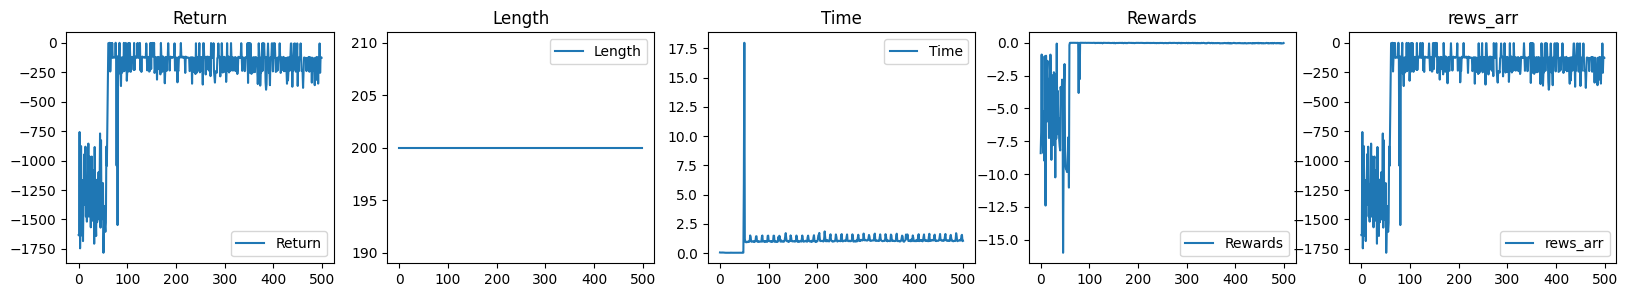

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 3))

ax1.plot(rs, label='Return')
ax1.legend()
ax1.set_title("Return")

ax2.plot(ls, label='Length')
ax2.legend()
ax2.set_title("Length")

ax3.plot(ts, label='Time')
ax3.legend()
ax3.set_title("Time")

ax4.plot(rewards, label='Rewards')
ax4.legend()
ax4.set_title("Rewards")

ax5.plot(rews_arr, label='rews_arr')
ax5.legend()
ax5.set_title("rews_arr")

plt.show()


In [ ]:
eval_env = gym.make("Pendulum-v1", render_mode="rgb_array") #
eval_env = wrap_gym(eval_env, rescale_actions=True)
eval_env = gym.wrappers.RecordVideo(eval_env, 'Pendulum_video')
eval_env = gym.wrappers.RecordEpisodeStatistics(eval_env, buffer_length=1)
evaluate(agent, eval_env, num_episodes=1)
eval_env.close()

### MountainCarContinuous-v0

In [ ]:
env = gym.make("MountainCarContinuous-v0", render_mode=None)
env = wrap_gym(env, rescale_actions=True)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=1)

eval_env = gym.make("MountainCarContinuous-v0", render_mode=None) # "rgb_array"
eval_env = wrap_gym(eval_env, rescale_actions=True)
# eval_env = gym.wrappers.RecordVideo(eval_env, 'cartpole_video')
eval_env = gym.wrappers.RecordEpisodeStatistics(eval_env, buffer_length=1)

agent = ScoreMatchingLearner.create(42, env.observation_space, env.action_space)

replay_buffer = ReplayBuffer(env.observation_space, env.action_space, max_iter)

observation, _ = env.reset()
done = False

rs, ls, ts = [], [], []
rewards = []
rews = 0
rews_arr = []
pbar = trange(1, max_iter+1, desc='Training')
for i in pbar:
    if i < start_step:
        action = env.action_space.sample()
    else:
        action, agent = agent.sample_actions(observation)
        action = np.asarray(action)
    next_observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    rews += reward
    if not done or "TimeLimit.truncated" in info:
        mask = 1.0
    else:
        mask = 0.0

    replay_buffer.insert(
            dict(
                observations=observation,
                actions=action,
                rewards=reward,
                masks=mask,
                dones=done,
                next_observations=next_observation,
            )
        )
    observation = next_observation
    rewards.append(reward)
    if done:
        rews_arr.append(rews)
        rews = 0
        observation, _ = env.reset()
        done = False
        # print("Done Info:", info)
        pbar.set_postfix(info['episode'])
        rs.append(info['episode']['r'])
        ls.append(info['episode']['l'])
        ts.append(info['episode']['t'])

    if i >= start_step:
        batch = replay_buffer.sample(batch_size)
        agent, update_info = agent.update(batch)

        if i % print_interval == 0:
            print("Update Info:", update_info)
            print('rew_arrs : ', rews_arr[-1])


    if i % 100_000 == 0:
        eval_info = evaluate(agent, eval_env, num_episodes=num_episodes)
        print("Eval Info", eval_info)

eval_env.close()
env.close()

Training:  10%|█         | 10000/100000 [00:25<19:10, 78.21it/s, r=-52.4, l=999, t=0.121] 

Update Info: {'actor_loss_mag': Array(0.01698041, dtype=float32), 'actor_loss_max': Array(0.01698041, dtype=float32), 'actor_loss_mean': Array(0.00283043, dtype=float32), 'actor_loss_min': Array(4.0120964e-09, dtype=float32), 'actor_loss_std': Array(0.00336115, dtype=float32), 'c_loss_mag_1': Array(0.13015473, dtype=float32), 'c_loss_mag_2': Array(0.01730527, dtype=float32), 'c_loss_max_1': Array(0.13015473, dtype=float32), 'c_loss_max_2': Array(0.01730527, dtype=float32), 'c_loss_mean_1': Array(0.02109592, dtype=float32), 'c_loss_mean_2': Array(0.00344096, dtype=float32), 'c_loss_min_1': Array(4.8715017e-05, dtype=float32), 'c_loss_min_2': Array(1.556849e-06, dtype=float32), 'c_loss_std_1': Array(0.02461657, dtype=float32), 'c_loss_std_2': Array(0.00319682, dtype=float32), 'critic_jacobian_mag': Array(0.05989651, dtype=float32), 'critic_jacobian_max': Array(0.01720459, dtype=float32), 'critic_jacobian_mean': Array(-0.01873801, dtype=float32), 'critic_jacobian_min': Array(-0.05989651, 

Training:  11%|█         | 10898/100000 [00:30<12:19, 120.43it/s, r=-70.6, l=999, t=28.8] 

Update Info: {'actor_loss_mag': Array(0.01239565, dtype=float32), 'actor_loss_max': Array(0.01239565, dtype=float32), 'actor_loss_mean': Array(0.00150583, dtype=float32), 'actor_loss_min': Array(1.0756731e-09, dtype=float32), 'actor_loss_std': Array(0.00226943, dtype=float32), 'c_loss_mag_1': Array(0.09417855, dtype=float32), 'c_loss_mag_2': Array(0.09087337, dtype=float32), 'c_loss_max_1': Array(0.09417855, dtype=float32), 'c_loss_max_2': Array(0.09087337, dtype=float32), 'c_loss_mean_1': Array(0.00149598, dtype=float32), 'c_loss_mean_2': Array(0.00152292, dtype=float32), 'c_loss_min_1': Array(2.5668356e-07, dtype=float32), 'c_loss_min_2': Array(4.283166e-09, dtype=float32), 'c_loss_std_1': Array(0.00602508, dtype=float32), 'c_loss_std_2': Array(0.00584101, dtype=float32), 'critic_jacobian_mag': Array(0.19704592, dtype=float32), 'critic_jacobian_max': Array(0.18114135, dtype=float32), 'critic_jacobian_mean': Array(0.00029322, dtype=float32), 'critic_jacobian_min': Array(-0.19704592, d

Training:  12%|█▏        | 12036/100000 [00:37<07:39, 191.28it/s, r=-69.3, l=999, t=6.62]

Update Info: {'actor_loss_mag': Array(0.0116378, dtype=float32), 'actor_loss_max': Array(0.0116378, dtype=float32), 'actor_loss_mean': Array(0.00145751, dtype=float32), 'actor_loss_min': Array(2.7728449e-08, dtype=float32), 'actor_loss_std': Array(0.00185727, dtype=float32), 'c_loss_mag_1': Array(0.00693953, dtype=float32), 'c_loss_mag_2': Array(0.00746359, dtype=float32), 'c_loss_max_1': Array(0.00693953, dtype=float32), 'c_loss_max_2': Array(0.00746359, dtype=float32), 'c_loss_mean_1': Array(0.00119999, dtype=float32), 'c_loss_mean_2': Array(0.00122984, dtype=float32), 'c_loss_min_1': Array(1.0306066e-07, dtype=float32), 'c_loss_min_2': Array(1.4987131e-07, dtype=float32), 'c_loss_std_1': Array(0.00164129, dtype=float32), 'c_loss_std_2': Array(0.001803, dtype=float32), 'critic_jacobian_mag': Array(0.18961991, dtype=float32), 'critic_jacobian_max': Array(0.17927569, dtype=float32), 'critic_jacobian_mean': Array(-0.00338492, dtype=float32), 'critic_jacobian_min': Array(-0.18961991, dty

Training:  13%|█▎        | 13015/100000 [00:42<07:57, 182.27it/s, r=-70, l=999, t=5.03]

Update Info: {'actor_loss_mag': Array(0.01353329, dtype=float32), 'actor_loss_max': Array(0.01353329, dtype=float32), 'actor_loss_mean': Array(0.00214156, dtype=float32), 'actor_loss_min': Array(5.326858e-07, dtype=float32), 'actor_loss_std': Array(0.00290257, dtype=float32), 'c_loss_mag_1': Array(0.00849166, dtype=float32), 'c_loss_mag_2': Array(0.00956881, dtype=float32), 'c_loss_max_1': Array(0.00849166, dtype=float32), 'c_loss_max_2': Array(0.00956881, dtype=float32), 'c_loss_mean_1': Array(0.00126805, dtype=float32), 'c_loss_mean_2': Array(0.00132041, dtype=float32), 'c_loss_min_1': Array(5.581354e-07, dtype=float32), 'c_loss_min_2': Array(1.4439138e-08, dtype=float32), 'c_loss_std_1': Array(0.00140639, dtype=float32), 'c_loss_std_2': Array(0.00158632, dtype=float32), 'critic_jacobian_mag': Array(0.2011361, dtype=float32), 'critic_jacobian_max': Array(0.2011361, dtype=float32), 'critic_jacobian_mean': Array(-0.01231429, dtype=float32), 'critic_jacobian_min': Array(-0.19718063, dty

Training:  14%|█▍        | 14032/100000 [00:48<08:11, 174.88it/s, r=-69.9, l=999, t=6.18]

Update Info: {'actor_loss_mag': Array(0.01314492, dtype=float32), 'actor_loss_max': Array(0.01314492, dtype=float32), 'actor_loss_mean': Array(0.00195686, dtype=float32), 'actor_loss_min': Array(1.8858569e-07, dtype=float32), 'actor_loss_std': Array(0.0027206, dtype=float32), 'c_loss_mag_1': Array(0.00522447, dtype=float32), 'c_loss_mag_2': Array(0.00583983, dtype=float32), 'c_loss_max_1': Array(0.00522447, dtype=float32), 'c_loss_max_2': Array(0.00583983, dtype=float32), 'c_loss_mean_1': Array(0.00123063, dtype=float32), 'c_loss_mean_2': Array(0.0012329, dtype=float32), 'c_loss_min_1': Array(7.16571e-07, dtype=float32), 'c_loss_min_2': Array(1.0761141e-06, dtype=float32), 'c_loss_std_1': Array(0.00122459, dtype=float32), 'c_loss_std_2': Array(0.00137646, dtype=float32), 'critic_jacobian_mag': Array(0.20314255, dtype=float32), 'critic_jacobian_max': Array(0.18998805, dtype=float32), 'critic_jacobian_mean': Array(-0.00424209, dtype=float32), 'critic_jacobian_min': Array(-0.20314255, dty

Training:  15%|█▌        | 15028/100000 [00:53<07:20, 192.82it/s, r=-67.5, l=999, t=5.21]

Update Info: {'actor_loss_mag': Array(0.03161658, dtype=float32), 'actor_loss_max': Array(0.03161658, dtype=float32), 'actor_loss_mean': Array(0.00224499, dtype=float32), 'actor_loss_min': Array(8.49054e-09, dtype=float32), 'actor_loss_std': Array(0.00384245, dtype=float32), 'c_loss_mag_1': Array(0.00563211, dtype=float32), 'c_loss_mag_2': Array(0.00589776, dtype=float32), 'c_loss_max_1': Array(0.00563211, dtype=float32), 'c_loss_max_2': Array(0.00589776, dtype=float32), 'c_loss_mean_1': Array(0.00119794, dtype=float32), 'c_loss_mean_2': Array(0.00120983, dtype=float32), 'c_loss_min_1': Array(4.2473528e-07, dtype=float32), 'c_loss_min_2': Array(1.1461907e-07, dtype=float32), 'c_loss_std_1': Array(0.00146339, dtype=float32), 'c_loss_std_2': Array(0.00145351, dtype=float32), 'critic_jacobian_mag': Array(0.22830655, dtype=float32), 'critic_jacobian_max': Array(0.19937743, dtype=float32), 'critic_jacobian_mean': Array(0.00570959, dtype=float32), 'critic_jacobian_min': Array(-0.22830655, dt

Training:  16%|█▌        | 16017/100000 [00:59<08:53, 157.37it/s, r=-67.6, l=999, t=5.97]

Update Info: {'actor_loss_mag': Array(0.01410031, dtype=float32), 'actor_loss_max': Array(0.01410031, dtype=float32), 'actor_loss_mean': Array(0.00188719, dtype=float32), 'actor_loss_min': Array(2.7774993e-08, dtype=float32), 'actor_loss_std': Array(0.00285585, dtype=float32), 'c_loss_mag_1': Array(2.9407377, dtype=float32), 'c_loss_mag_2': Array(2.9517515, dtype=float32), 'c_loss_max_1': Array(2.9407377, dtype=float32), 'c_loss_max_2': Array(2.9517515, dtype=float32), 'c_loss_mean_1': Array(0.02430054, dtype=float32), 'c_loss_mean_2': Array(0.02443847, dtype=float32), 'c_loss_min_1': Array(3.4141578e-10, dtype=float32), 'c_loss_min_2': Array(2.532694e-08, dtype=float32), 'c_loss_std_1': Array(0.25879604, dtype=float32), 'c_loss_std_2': Array(0.25976235, dtype=float32), 'critic_jacobian_mag': Array(0.19990966, dtype=float32), 'critic_jacobian_max': Array(0.18535641, dtype=float32), 'critic_jacobian_mean': Array(0.00939173, dtype=float32), 'critic_jacobian_min': Array(-0.19990966, dtype

Training:  17%|█▋        | 17020/100000 [01:04<07:16, 190.25it/s, r=-65.8, l=999, t=5.13]

Update Info: {'actor_loss_mag': Array(0.03726842, dtype=float32), 'actor_loss_max': Array(0.03726842, dtype=float32), 'actor_loss_mean': Array(0.00185908, dtype=float32), 'actor_loss_min': Array(1.7598036e-10, dtype=float32), 'actor_loss_std': Array(0.00401136, dtype=float32), 'c_loss_mag_1': Array(3.8813384, dtype=float32), 'c_loss_mag_2': Array(3.9024193, dtype=float32), 'c_loss_max_1': Array(3.8813384, dtype=float32), 'c_loss_max_2': Array(3.9024193, dtype=float32), 'c_loss_mean_1': Array(0.01653208, dtype=float32), 'c_loss_mean_2': Array(0.01657844, dtype=float32), 'c_loss_min_1': Array(3.5475978e-10, dtype=float32), 'c_loss_min_2': Array(2.3125546e-07, dtype=float32), 'c_loss_std_1': Array(0.24202608, dtype=float32), 'c_loss_std_2': Array(0.24334411, dtype=float32), 'critic_jacobian_mag': Array(0.22277468, dtype=float32), 'critic_jacobian_max': Array(0.22277468, dtype=float32), 'critic_jacobian_mean': Array(0.00548113, dtype=float32), 'critic_jacobian_min': Array(-0.22117378, dtyp

Training:  18%|█▊        | 18021/100000 [01:10<09:59, 136.78it/s, r=-70.3, l=999, t=5.19]

Update Info: {'actor_loss_mag': Array(0.08276467, dtype=float32), 'actor_loss_max': Array(0.08276467, dtype=float32), 'actor_loss_mean': Array(0.00208081, dtype=float32), 'actor_loss_min': Array(7.86622e-09, dtype=float32), 'actor_loss_std': Array(0.00604327, dtype=float32), 'c_loss_mag_1': Array(0.0072103, dtype=float32), 'c_loss_mag_2': Array(0.00589031, dtype=float32), 'c_loss_max_1': Array(0.0072103, dtype=float32), 'c_loss_max_2': Array(0.00589031, dtype=float32), 'c_loss_mean_1': Array(0.00121728, dtype=float32), 'c_loss_mean_2': Array(0.00125381, dtype=float32), 'c_loss_min_1': Array(2.0737389e-08, dtype=float32), 'c_loss_min_2': Array(2.9467628e-08, dtype=float32), 'c_loss_std_1': Array(0.00132851, dtype=float32), 'c_loss_std_2': Array(0.00126282, dtype=float32), 'critic_jacobian_mag': Array(0.2810197, dtype=float32), 'critic_jacobian_max': Array(0.18841517, dtype=float32), 'critic_jacobian_mean': Array(-0.02020893, dtype=float32), 'critic_jacobian_min': Array(-0.2810197, dtype

Training:  19%|█▉        | 19033/100000 [01:16<06:50, 197.47it/s, r=-69.2, l=999, t=5.74]

Update Info: {'actor_loss_mag': Array(0.04177142, dtype=float32), 'actor_loss_max': Array(0.04177142, dtype=float32), 'actor_loss_mean': Array(0.00238871, dtype=float32), 'actor_loss_min': Array(3.4750002e-08, dtype=float32), 'actor_loss_std': Array(0.00444809, dtype=float32), 'c_loss_mag_1': Array(0.00847234, dtype=float32), 'c_loss_mag_2': Array(0.00806595, dtype=float32), 'c_loss_max_1': Array(0.00847234, dtype=float32), 'c_loss_max_2': Array(0.00806595, dtype=float32), 'c_loss_mean_1': Array(0.00145282, dtype=float32), 'c_loss_mean_2': Array(0.00138651, dtype=float32), 'c_loss_min_1': Array(1.02673425e-08, dtype=float32), 'c_loss_min_2': Array(2.7063152e-10, dtype=float32), 'c_loss_std_1': Array(0.00230117, dtype=float32), 'c_loss_std_2': Array(0.00216767, dtype=float32), 'critic_jacobian_mag': Array(0.2815221, dtype=float32), 'critic_jacobian_max': Array(0.22397694, dtype=float32), 'critic_jacobian_mean': Array(-0.00492199, dtype=float32), 'critic_jacobian_min': Array(-0.2815221, 

Training:  20%|██        | 20033/100000 [01:20<07:01, 189.56it/s, r=-68.9, l=999, t=4.96]

Update Info: {'actor_loss_mag': Array(0.08572448, dtype=float32), 'actor_loss_max': Array(0.08572448, dtype=float32), 'actor_loss_mean': Array(0.00306215, dtype=float32), 'actor_loss_min': Array(4.386176e-09, dtype=float32), 'actor_loss_std': Array(0.00904608, dtype=float32), 'c_loss_mag_1': Array(0.0100736, dtype=float32), 'c_loss_mag_2': Array(0.00880798, dtype=float32), 'c_loss_max_1': Array(0.0100736, dtype=float32), 'c_loss_max_2': Array(0.00880798, dtype=float32), 'c_loss_mean_1': Array(0.0014786, dtype=float32), 'c_loss_mean_2': Array(0.00146698, dtype=float32), 'c_loss_min_1': Array(1.7826096e-10, dtype=float32), 'c_loss_min_2': Array(1.2789769e-09, dtype=float32), 'c_loss_std_1': Array(0.00191075, dtype=float32), 'c_loss_std_2': Array(0.00197451, dtype=float32), 'critic_jacobian_mag': Array(0.38185883, dtype=float32), 'critic_jacobian_max': Array(0.38185883, dtype=float32), 'critic_jacobian_mean': Array(0.01886929, dtype=float32), 'critic_jacobian_min': Array(-0.27130157, dtyp

Training:  21%|██        | 21018/100000 [01:27<07:00, 187.89it/s, r=-69, l=999, t=6.19]

Update Info: {'actor_loss_mag': Array(0.23653102, dtype=float32), 'actor_loss_max': Array(0.23653102, dtype=float32), 'actor_loss_mean': Array(0.00460499, dtype=float32), 'actor_loss_min': Array(3.6603197e-07, dtype=float32), 'actor_loss_std': Array(0.01792892, dtype=float32), 'c_loss_mag_1': Array(0.02023433, dtype=float32), 'c_loss_mag_2': Array(0.01965541, dtype=float32), 'c_loss_max_1': Array(0.02023433, dtype=float32), 'c_loss_max_2': Array(0.01965541, dtype=float32), 'c_loss_mean_1': Array(0.00135893, dtype=float32), 'c_loss_mean_2': Array(0.00139221, dtype=float32), 'c_loss_min_1': Array(3.842615e-11, dtype=float32), 'c_loss_min_2': Array(1.6427748e-07, dtype=float32), 'c_loss_std_1': Array(0.00195733, dtype=float32), 'c_loss_std_2': Array(0.0019829, dtype=float32), 'critic_jacobian_mag': Array(0.45930457, dtype=float32), 'critic_jacobian_max': Array(0.45930457, dtype=float32), 'critic_jacobian_mean': Array(0.00750277, dtype=float32), 'critic_jacobian_min': Array(-0.45793313, dt

Training:  22%|██▏       | 22031/100000 [01:32<06:38, 195.59it/s, r=-69.6, l=999, t=5.21]

Update Info: {'actor_loss_mag': Array(0.04315187, dtype=float32), 'actor_loss_max': Array(0.04315187, dtype=float32), 'actor_loss_mean': Array(0.00222456, dtype=float32), 'actor_loss_min': Array(8.370856e-07, dtype=float32), 'actor_loss_std': Array(0.00496111, dtype=float32), 'c_loss_mag_1': Array(0.00769671, dtype=float32), 'c_loss_mag_2': Array(0.00915156, dtype=float32), 'c_loss_max_1': Array(0.00769671, dtype=float32), 'c_loss_max_2': Array(0.00915156, dtype=float32), 'c_loss_mean_1': Array(0.00123509, dtype=float32), 'c_loss_mean_2': Array(0.00135863, dtype=float32), 'c_loss_min_1': Array(1.8315092e-07, dtype=float32), 'c_loss_min_2': Array(2.4238545e-08, dtype=float32), 'c_loss_std_1': Array(0.00174768, dtype=float32), 'c_loss_std_2': Array(0.00215816, dtype=float32), 'critic_jacobian_mag': Array(0.22790411, dtype=float32), 'critic_jacobian_max': Array(0.22330278, dtype=float32), 'critic_jacobian_mean': Array(0.01101825, dtype=float32), 'critic_jacobian_min': Array(-0.22790411, d

Training:  23%|██▎       | 23032/100000 [01:38<08:10, 156.89it/s, r=-65.3, l=999, t=5.85]

Update Info: {'actor_loss_mag': Array(0.0487848, dtype=float32), 'actor_loss_max': Array(0.0487848, dtype=float32), 'actor_loss_mean': Array(0.0019689, dtype=float32), 'actor_loss_min': Array(3.2582133e-08, dtype=float32), 'actor_loss_std': Array(0.00431763, dtype=float32), 'c_loss_mag_1': Array(0.00728263, dtype=float32), 'c_loss_mag_2': Array(0.00778018, dtype=float32), 'c_loss_max_1': Array(0.00728263, dtype=float32), 'c_loss_max_2': Array(0.00778018, dtype=float32), 'c_loss_mean_1': Array(0.00118255, dtype=float32), 'c_loss_mean_2': Array(0.00117849, dtype=float32), 'c_loss_min_1': Array(6.9030875e-08, dtype=float32), 'c_loss_min_2': Array(1.2789769e-07, dtype=float32), 'c_loss_std_1': Array(0.00179257, dtype=float32), 'c_loss_std_2': Array(0.0017885, dtype=float32), 'critic_jacobian_mag': Array(0.29875433, dtype=float32), 'critic_jacobian_max': Array(0.29875433, dtype=float32), 'critic_jacobian_mean': Array(-0.00115014, dtype=float32), 'critic_jacobian_min': Array(-0.27437282, dty

Training:  24%|██▍       | 24024/100000 [01:43<06:27, 196.22it/s, r=-68.8, l=999, t=5.04]

Update Info: {'actor_loss_mag': Array(0.06023879, dtype=float32), 'actor_loss_max': Array(0.06023879, dtype=float32), 'actor_loss_mean': Array(0.00275552, dtype=float32), 'actor_loss_min': Array(2.4340729e-08, dtype=float32), 'actor_loss_std': Array(0.00624893, dtype=float32), 'c_loss_mag_1': Array(0.02126671, dtype=float32), 'c_loss_mag_2': Array(0.02479042, dtype=float32), 'c_loss_max_1': Array(0.02126671, dtype=float32), 'c_loss_max_2': Array(0.02479042, dtype=float32), 'c_loss_mean_1': Array(0.00170314, dtype=float32), 'c_loss_mean_2': Array(0.00176972, dtype=float32), 'c_loss_min_1': Array(5.6957163e-08, dtype=float32), 'c_loss_min_2': Array(9.602047e-09, dtype=float32), 'c_loss_std_1': Array(0.00236466, dtype=float32), 'c_loss_std_2': Array(0.00262545, dtype=float32), 'critic_jacobian_mag': Array(0.4111282, dtype=float32), 'critic_jacobian_max': Array(0.4111282, dtype=float32), 'critic_jacobian_mean': Array(0.00390166, dtype=float32), 'critic_jacobian_min': Array(-0.23990355, dty

Training:  25%|██▌       | 25009/100000 [01:48<07:44, 161.28it/s, r=-70.9, l=999, t=5.07]

Update Info: {'actor_loss_mag': Array(0.14815441, dtype=float32), 'actor_loss_max': Array(0.14815441, dtype=float32), 'actor_loss_mean': Array(0.00314373, dtype=float32), 'actor_loss_min': Array(1.2643639e-07, dtype=float32), 'actor_loss_std': Array(0.01018253, dtype=float32), 'c_loss_mag_1': Array(11.92026, dtype=float32), 'c_loss_mag_2': Array(11.919306, dtype=float32), 'c_loss_max_1': Array(11.92026, dtype=float32), 'c_loss_max_2': Array(11.919306, dtype=float32), 'c_loss_mean_1': Array(0.04806986, dtype=float32), 'c_loss_mean_2': Array(0.04806405, dtype=float32), 'c_loss_min_1': Array(7.840865e-07, dtype=float32), 'c_loss_min_2': Array(2.4996376e-07, dtype=float32), 'c_loss_std_1': Array(0.74347234, dtype=float32), 'c_loss_std_2': Array(0.7434144, dtype=float32), 'critic_jacobian_mag': Array(0.36548257, dtype=float32), 'critic_jacobian_max': Array(0.2954936, dtype=float32), 'critic_jacobian_mean': Array(0.0094876, dtype=float32), 'critic_jacobian_min': Array(-0.36548257, dtype=floa

Training:  26%|██▌       | 26029/100000 [01:54<06:22, 193.38it/s, r=-68.4, l=999, t=6.09]

Update Info: {'actor_loss_mag': Array(0.0596455, dtype=float32), 'actor_loss_max': Array(0.0596455, dtype=float32), 'actor_loss_mean': Array(0.00463215, dtype=float32), 'actor_loss_min': Array(6.1629724e-10, dtype=float32), 'actor_loss_std': Array(0.00800723, dtype=float32), 'c_loss_mag_1': Array(0.00634111, dtype=float32), 'c_loss_mag_2': Array(0.00651948, dtype=float32), 'c_loss_max_1': Array(0.00634111, dtype=float32), 'c_loss_max_2': Array(0.00651948, dtype=float32), 'c_loss_mean_1': Array(0.00155037, dtype=float32), 'c_loss_mean_2': Array(0.00156025, dtype=float32), 'c_loss_min_1': Array(8.9545216e-07, dtype=float32), 'c_loss_min_2': Array(9.049529e-09, dtype=float32), 'c_loss_std_1': Array(0.00119989, dtype=float32), 'c_loss_std_2': Array(0.00123949, dtype=float32), 'critic_jacobian_mag': Array(0.38943303, dtype=float32), 'critic_jacobian_max': Array(0.38943303, dtype=float32), 'critic_jacobian_mean': Array(-0.01927539, dtype=float32), 'critic_jacobian_min': Array(-0.32023627, dt

Training:  27%|██▋       | 27018/100000 [01:59<06:51, 177.37it/s, r=-68.3, l=999, t=5.07]

Update Info: {'actor_loss_mag': Array(0.1210015, dtype=float32), 'actor_loss_max': Array(0.1210015, dtype=float32), 'actor_loss_mean': Array(0.00358897, dtype=float32), 'actor_loss_min': Array(1.4766002e-07, dtype=float32), 'actor_loss_std': Array(0.01009763, dtype=float32), 'c_loss_mag_1': Array(0.01876373, dtype=float32), 'c_loss_mag_2': Array(0.01752788, dtype=float32), 'c_loss_max_1': Array(0.01876373, dtype=float32), 'c_loss_max_2': Array(0.01752788, dtype=float32), 'c_loss_mean_1': Array(0.00183132, dtype=float32), 'c_loss_mean_2': Array(0.0016919, dtype=float32), 'c_loss_min_1': Array(2.032653e-07, dtype=float32), 'c_loss_min_2': Array(2.0191692e-08, dtype=float32), 'c_loss_std_1': Array(0.00179928, dtype=float32), 'c_loss_std_2': Array(0.00188825, dtype=float32), 'critic_jacobian_mag': Array(0.5300343, dtype=float32), 'critic_jacobian_max': Array(0.5300343, dtype=float32), 'critic_jacobian_mean': Array(0.01670246, dtype=float32), 'critic_jacobian_min': Array(-0.30943108, dtype=

Training:  28%|██▊       | 28020/100000 [02:05<06:28, 185.08it/s, r=-66.1, l=999, t=6.06]

Update Info: {'actor_loss_mag': Array(0.20719896, dtype=float32), 'actor_loss_max': Array(0.20719896, dtype=float32), 'actor_loss_mean': Array(0.00441006, dtype=float32), 'actor_loss_min': Array(6.725713e-08, dtype=float32), 'actor_loss_std': Array(0.0148066, dtype=float32), 'c_loss_mag_1': Array(0.0098361, dtype=float32), 'c_loss_mag_2': Array(0.01033689, dtype=float32), 'c_loss_max_1': Array(0.0098361, dtype=float32), 'c_loss_max_2': Array(0.01033689, dtype=float32), 'c_loss_mean_1': Array(0.00156601, dtype=float32), 'c_loss_mean_2': Array(0.00152763, dtype=float32), 'c_loss_min_1': Array(4.264462e-07, dtype=float32), 'c_loss_min_2': Array(1.2484657e-07, dtype=float32), 'c_loss_std_1': Array(0.00172119, dtype=float32), 'c_loss_std_2': Array(0.00172371, dtype=float32), 'critic_jacobian_mag': Array(0.3625341, dtype=float32), 'critic_jacobian_max': Array(0.22457224, dtype=float32), 'critic_jacobian_mean': Array(-0.0088678, dtype=float32), 'critic_jacobian_min': Array(-0.3625341, dtype=f

Training:  29%|██▉       | 29028/100000 [02:10<06:27, 183.29it/s, r=-65.2, l=999, t=5.1]

Update Info: {'actor_loss_mag': Array(0.08862924, dtype=float32), 'actor_loss_max': Array(0.08862924, dtype=float32), 'actor_loss_mean': Array(0.00389064, dtype=float32), 'actor_loss_min': Array(1.7465231e-07, dtype=float32), 'actor_loss_std': Array(0.00848651, dtype=float32), 'c_loss_mag_1': Array(0.00767338, dtype=float32), 'c_loss_mag_2': Array(0.00672913, dtype=float32), 'c_loss_max_1': Array(0.00767338, dtype=float32), 'c_loss_max_2': Array(0.00672913, dtype=float32), 'c_loss_mean_1': Array(0.00124912, dtype=float32), 'c_loss_mean_2': Array(0.00126317, dtype=float32), 'c_loss_min_1': Array(3.8595317e-08, dtype=float32), 'c_loss_min_2': Array(4.2041393e-10, dtype=float32), 'c_loss_std_1': Array(0.00141878, dtype=float32), 'c_loss_std_2': Array(0.00126545, dtype=float32), 'critic_jacobian_mag': Array(0.38662452, dtype=float32), 'critic_jacobian_max': Array(0.29672283, dtype=float32), 'critic_jacobian_mean': Array(0.00258021, dtype=float32), 'critic_jacobian_min': Array(-0.38662452, 

Training:  30%|███       | 30014/100000 [02:17<10:35, 110.10it/s, r=-67.6, l=999, t=7.14]

Update Info: {'actor_loss_mag': Array(0.16540506, dtype=float32), 'actor_loss_max': Array(0.16540506, dtype=float32), 'actor_loss_mean': Array(0.0047758, dtype=float32), 'actor_loss_min': Array(5.799853e-08, dtype=float32), 'actor_loss_std': Array(0.01277652, dtype=float32), 'c_loss_mag_1': Array(17.190105, dtype=float32), 'c_loss_mag_2': Array(17.200472, dtype=float32), 'c_loss_max_1': Array(17.190105, dtype=float32), 'c_loss_max_2': Array(17.200472, dtype=float32), 'c_loss_mean_1': Array(0.06867266, dtype=float32), 'c_loss_mean_2': Array(0.06875077, dtype=float32), 'c_loss_min_1': Array(9.094947e-13, dtype=float32), 'c_loss_min_2': Array(1.28793545e-08, dtype=float32), 'c_loss_std_1': Array(1.0721872, dtype=float32), 'c_loss_std_2': Array(1.0728316, dtype=float32), 'critic_jacobian_mag': Array(0.5685191, dtype=float32), 'critic_jacobian_max': Array(0.5685191, dtype=float32), 'critic_jacobian_mean': Array(-0.00063162, dtype=float32), 'critic_jacobian_min': Array(-0.29922324, dtype=flo

Training:  31%|███       | 31032/100000 [02:23<06:02, 190.08it/s, r=-67.6, l=999, t=5.43]

Update Info: {'actor_loss_mag': Array(0.15991257, dtype=float32), 'actor_loss_max': Array(0.15991257, dtype=float32), 'actor_loss_mean': Array(0.00479971, dtype=float32), 'actor_loss_min': Array(1.7037225e-08, dtype=float32), 'actor_loss_std': Array(0.01425269, dtype=float32), 'c_loss_mag_1': Array(0.00853222, dtype=float32), 'c_loss_mag_2': Array(0.00924985, dtype=float32), 'c_loss_max_1': Array(0.00853222, dtype=float32), 'c_loss_max_2': Array(0.00924985, dtype=float32), 'c_loss_mean_1': Array(0.00140071, dtype=float32), 'c_loss_mean_2': Array(0.00143258, dtype=float32), 'c_loss_min_1': Array(2.4016344e-08, dtype=float32), 'c_loss_min_2': Array(2.7512215e-11, dtype=float32), 'c_loss_std_1': Array(0.00163556, dtype=float32), 'c_loss_std_2': Array(0.00152498, dtype=float32), 'critic_jacobian_mag': Array(0.34829903, dtype=float32), 'critic_jacobian_max': Array(0.29954028, dtype=float32), 'critic_jacobian_mean': Array(-0.00870379, dtype=float32), 'critic_jacobian_min': Array(-0.34829903,

Training:  32%|███▏      | 32019/100000 [02:28<07:43, 146.71it/s, r=68.1, l=470, t=2.43]

Update Info: {'actor_loss_mag': Array(0.03253262, dtype=float32), 'actor_loss_max': Array(0.03253262, dtype=float32), 'actor_loss_mean': Array(0.00347401, dtype=float32), 'actor_loss_min': Array(5.4517545e-07, dtype=float32), 'actor_loss_std': Array(0.00500102, dtype=float32), 'c_loss_mag_1': Array(0.02615723, dtype=float32), 'c_loss_mag_2': Array(0.03960427, dtype=float32), 'c_loss_max_1': Array(0.02615723, dtype=float32), 'c_loss_max_2': Array(0.03960427, dtype=float32), 'c_loss_mean_1': Array(0.00181096, dtype=float32), 'c_loss_mean_2': Array(0.00187891, dtype=float32), 'c_loss_min_1': Array(3.0912724e-07, dtype=float32), 'c_loss_min_2': Array(1.0432277e-06, dtype=float32), 'c_loss_std_1': Array(0.00232956, dtype=float32), 'c_loss_std_2': Array(0.00312248, dtype=float32), 'critic_jacobian_mag': Array(0.2849788, dtype=float32), 'critic_jacobian_max': Array(0.2849788, dtype=float32), 'critic_jacobian_mean': Array(-0.00102303, dtype=float32), 'critic_jacobian_min': Array(-0.27009106, d

Training:  33%|███▎      | 33016/100000 [02:34<06:33, 170.21it/s, r=-66.9, l=999, t=6.03]

Update Info: {'actor_loss_mag': Array(0.30922633, dtype=float32), 'actor_loss_max': Array(0.30922633, dtype=float32), 'actor_loss_mean': Array(0.01033252, dtype=float32), 'actor_loss_min': Array(3.8829867e-08, dtype=float32), 'actor_loss_std': Array(0.0227404, dtype=float32), 'c_loss_mag_1': Array(0.6372308, dtype=float32), 'c_loss_mag_2': Array(0.6743438, dtype=float32), 'c_loss_max_1': Array(0.6372308, dtype=float32), 'c_loss_max_2': Array(0.6743438, dtype=float32), 'c_loss_mean_1': Array(0.01001884, dtype=float32), 'c_loss_mean_2': Array(0.00982965, dtype=float32), 'c_loss_min_1': Array(1.6330887e-08, dtype=float32), 'c_loss_min_2': Array(6.8050667e-09, dtype=float32), 'c_loss_std_1': Array(0.05592257, dtype=float32), 'c_loss_std_2': Array(0.05592598, dtype=float32), 'critic_jacobian_mag': Array(0.64943886, dtype=float32), 'critic_jacobian_max': Array(0.64943886, dtype=float32), 'critic_jacobian_mean': Array(-0.00472692, dtype=float32), 'critic_jacobian_min': Array(-0.2712586, dtype

Training:  34%|███▍      | 34026/100000 [02:39<05:55, 185.72it/s, r=-67.1, l=999, t=5.08]

Update Info: {'actor_loss_mag': Array(0.40707284, dtype=float32), 'actor_loss_max': Array(0.40707284, dtype=float32), 'actor_loss_mean': Array(0.00675981, dtype=float32), 'actor_loss_min': Array(2.0504952e-07, dtype=float32), 'actor_loss_std': Array(0.02777775, dtype=float32), 'c_loss_mag_1': Array(21.730413, dtype=float32), 'c_loss_mag_2': Array(21.694113, dtype=float32), 'c_loss_max_1': Array(21.730413, dtype=float32), 'c_loss_max_2': Array(21.694113, dtype=float32), 'c_loss_mean_1': Array(0.08690077, dtype=float32), 'c_loss_mean_2': Array(0.08681061, dtype=float32), 'c_loss_min_1': Array(2.2737368e-09, dtype=float32), 'c_loss_min_2': Array(2.9033345e-09, dtype=float32), 'c_loss_std_1': Array(1.3553793, dtype=float32), 'c_loss_std_2': Array(1.3531128, dtype=float32), 'critic_jacobian_mag': Array(0.76686025, dtype=float32), 'critic_jacobian_max': Array(0.76686025, dtype=float32), 'critic_jacobian_mean': Array(0.01200219, dtype=float32), 'critic_jacobian_min': Array(-0.24416798, dtype=

Training:  35%|███▌      | 35022/100000 [02:45<05:31, 195.72it/s, r=-69.7, l=999, t=5.5]

Update Info: {'actor_loss_mag': Array(0.26023266, dtype=float32), 'actor_loss_max': Array(0.26023266, dtype=float32), 'actor_loss_mean': Array(0.00493547, dtype=float32), 'actor_loss_min': Array(5.2262754e-09, dtype=float32), 'actor_loss_std': Array(0.01690472, dtype=float32), 'c_loss_mag_1': Array(0.10995046, dtype=float32), 'c_loss_mag_2': Array(0.08886247, dtype=float32), 'c_loss_max_1': Array(0.10995046, dtype=float32), 'c_loss_max_2': Array(0.08886247, dtype=float32), 'c_loss_mean_1': Array(0.00271093, dtype=float32), 'c_loss_mean_2': Array(0.00288085, dtype=float32), 'c_loss_min_1': Array(5.2809264e-07, dtype=float32), 'c_loss_min_2': Array(3.9198517e-07, dtype=float32), 'c_loss_std_1': Array(0.00858601, dtype=float32), 'c_loss_std_2': Array(0.00883831, dtype=float32), 'critic_jacobian_mag': Array(0.73165774, dtype=float32), 'critic_jacobian_max': Array(0.73165774, dtype=float32), 'critic_jacobian_mean': Array(-0.01553432, dtype=float32), 'critic_jacobian_min': Array(-0.276973, d

Training:  36%|███▌      | 36036/100000 [02:50<05:43, 186.08it/s, r=-68.4, l=999, t=5.63]

Update Info: {'actor_loss_mag': Array(0.10656641, dtype=float32), 'actor_loss_max': Array(0.10656641, dtype=float32), 'actor_loss_mean': Array(0.00524063, dtype=float32), 'actor_loss_min': Array(3.8139416e-07, dtype=float32), 'actor_loss_std': Array(0.01105995, dtype=float32), 'c_loss_mag_1': Array(0.08479288, dtype=float32), 'c_loss_mag_2': Array(0.05346867, dtype=float32), 'c_loss_max_1': Array(0.08479288, dtype=float32), 'c_loss_max_2': Array(0.05346867, dtype=float32), 'c_loss_mean_1': Array(0.00193756, dtype=float32), 'c_loss_mean_2': Array(0.00183848, dtype=float32), 'c_loss_min_1': Array(2.1481901e-07, dtype=float32), 'c_loss_min_2': Array(6.571099e-07, dtype=float32), 'c_loss_std_1': Array(0.00573606, dtype=float32), 'c_loss_std_2': Array(0.00437272, dtype=float32), 'critic_jacobian_mag': Array(0.6383088, dtype=float32), 'critic_jacobian_max': Array(0.6383088, dtype=float32), 'critic_jacobian_mean': Array(-0.00120123, dtype=float32), 'critic_jacobian_min': Array(-0.55571365, dt

Training:  37%|███▋      | 37022/100000 [02:56<06:24, 163.80it/s, r=-67.9, l=999, t=5.04]

Update Info: {'actor_loss_mag': Array(7.634414, dtype=float32), 'actor_loss_max': Array(7.634414, dtype=float32), 'actor_loss_mean': Array(0.05908772, dtype=float32), 'actor_loss_min': Array(6.310895e-08, dtype=float32), 'actor_loss_std': Array(0.59381175, dtype=float32), 'c_loss_mag_1': Array(0.00933203, dtype=float32), 'c_loss_mag_2': Array(0.00689917, dtype=float32), 'c_loss_max_1': Array(0.00933203, dtype=float32), 'c_loss_max_2': Array(0.00689917, dtype=float32), 'c_loss_mean_1': Array(0.00161015, dtype=float32), 'c_loss_mean_2': Array(0.00150281, dtype=float32), 'c_loss_min_1': Array(3.7664222e-08, dtype=float32), 'c_loss_min_2': Array(2.046363e-12, dtype=float32), 'c_loss_std_1': Array(0.00203826, dtype=float32), 'c_loss_std_2': Array(0.0017766, dtype=float32), 'critic_jacobian_mag': Array(2.919657, dtype=float32), 'critic_jacobian_max': Array(2.919657, dtype=float32), 'critic_jacobian_mean': Array(0.02212809, dtype=float32), 'critic_jacobian_min': Array(-0.99988306, dtype=float

Training:  38%|███▊      | 38018/100000 [03:01<05:30, 187.34it/s, r=-67.7, l=999, t=5.99]

Update Info: {'actor_loss_mag': Array(0.4184379, dtype=float32), 'actor_loss_max': Array(0.4184379, dtype=float32), 'actor_loss_mean': Array(0.00914582, dtype=float32), 'actor_loss_min': Array(1.0196334e-07, dtype=float32), 'actor_loss_std': Array(0.03790469, dtype=float32), 'c_loss_mag_1': Array(0.4625045, dtype=float32), 'c_loss_mag_2': Array(1.0186942, dtype=float32), 'c_loss_max_1': Array(0.4625045, dtype=float32), 'c_loss_max_2': Array(1.0186942, dtype=float32), 'c_loss_mean_1': Array(0.00468477, dtype=float32), 'c_loss_mean_2': Array(0.00695968, dtype=float32), 'c_loss_min_1': Array(9.8444616e-08, dtype=float32), 'c_loss_min_2': Array(1.0785889e-06, dtype=float32), 'c_loss_std_1': Array(0.02977308, dtype=float32), 'c_loss_std_2': Array(0.06407575, dtype=float32), 'critic_jacobian_mag': Array(2.8045418, dtype=float32), 'critic_jacobian_max': Array(2.8045418, dtype=float32), 'critic_jacobian_mean': Array(-0.00774827, dtype=float32), 'critic_jacobian_min': Array(-1.6726725, dtype=fl

Training:  39%|███▉      | 39008/100000 [03:06<07:26, 136.54it/s, r=49.5, l=741, t=3.78]

Update Info: {'actor_loss_mag': Array(0.18661276, dtype=float32), 'actor_loss_max': Array(0.18661276, dtype=float32), 'actor_loss_mean': Array(0.00665101, dtype=float32), 'actor_loss_min': Array(1.86064e-09, dtype=float32), 'actor_loss_std': Array(0.01635074, dtype=float32), 'c_loss_mag_1': Array(1.1887771, dtype=float32), 'c_loss_mag_2': Array(0.8145926, dtype=float32), 'c_loss_max_1': Array(1.1887771, dtype=float32), 'c_loss_max_2': Array(0.8145926, dtype=float32), 'c_loss_mean_1': Array(0.01109141, dtype=float32), 'c_loss_mean_2': Array(0.00981023, dtype=float32), 'c_loss_min_1': Array(1.1276663e-06, dtype=float32), 'c_loss_min_2': Array(1.5663773e-09, dtype=float32), 'c_loss_std_1': Array(0.08127631, dtype=float32), 'c_loss_std_2': Array(0.06111033, dtype=float32), 'critic_jacobian_mag': Array(0.5161042, dtype=float32), 'critic_jacobian_max': Array(0.4443827, dtype=float32), 'critic_jacobian_mean': Array(-0.00163978, dtype=float32), 'critic_jacobian_min': Array(-0.5161042, dtype=fl

Training:  40%|████      | 40028/100000 [03:13<05:01, 198.87it/s, r=-67.5, l=999, t=6.3]

Update Info: {'actor_loss_mag': Array(1.604083, dtype=float32), 'actor_loss_max': Array(1.604083, dtype=float32), 'actor_loss_mean': Array(0.01529891, dtype=float32), 'actor_loss_min': Array(1.4657836e-07, dtype=float32), 'actor_loss_std': Array(0.10460637, dtype=float32), 'c_loss_mag_1': Array(0.18264905, dtype=float32), 'c_loss_mag_2': Array(0.17727453, dtype=float32), 'c_loss_max_1': Array(0.18264905, dtype=float32), 'c_loss_max_2': Array(0.17727453, dtype=float32), 'c_loss_mean_1': Array(0.00476651, dtype=float32), 'c_loss_mean_2': Array(0.00426049, dtype=float32), 'c_loss_min_1': Array(8.9102286e-08, dtype=float32), 'c_loss_min_2': Array(6.8780537e-10, dtype=float32), 'c_loss_std_1': Array(0.01789216, dtype=float32), 'c_loss_std_2': Array(0.0143806, dtype=float32), 'critic_jacobian_mag': Array(2.0532606, dtype=float32), 'critic_jacobian_max': Array(0.29342607, dtype=float32), 'critic_jacobian_mean': Array(-0.02458265, dtype=float32), 'critic_jacobian_min': Array(-2.0532606, dtype=

Training:  41%|████      | 41030/100000 [03:18<04:58, 197.66it/s, r=-66.2, l=999, t=5.43]

Update Info: {'actor_loss_mag': Array(0.18239458, dtype=float32), 'actor_loss_max': Array(0.18239458, dtype=float32), 'actor_loss_mean': Array(0.00861868, dtype=float32), 'actor_loss_min': Array(3.0635164e-08, dtype=float32), 'actor_loss_std': Array(0.01903311, dtype=float32), 'c_loss_mag_1': Array(0.8816505, dtype=float32), 'c_loss_mag_2': Array(1.0573162, dtype=float32), 'c_loss_max_1': Array(0.8816505, dtype=float32), 'c_loss_max_2': Array(1.0573162, dtype=float32), 'c_loss_mean_1': Array(0.00861631, dtype=float32), 'c_loss_mean_2': Array(0.01061974, dtype=float32), 'c_loss_min_1': Array(7.0036776e-08, dtype=float32), 'c_loss_min_2': Array(5.5442442e-06, dtype=float32), 'c_loss_std_1': Array(0.06089307, dtype=float32), 'c_loss_std_2': Array(0.07248864, dtype=float32), 'critic_jacobian_mag': Array(0.40711266, dtype=float32), 'critic_jacobian_max': Array(0.4042861, dtype=float32), 'critic_jacobian_mean': Array(-0.0134304, dtype=float32), 'critic_jacobian_min': Array(-0.40711266, dtype

Training:  42%|████▏     | 42024/100000 [03:24<04:56, 195.52it/s, r=-67.1, l=999, t=5.06]

Update Info: {'actor_loss_mag': Array(0.12332518, dtype=float32), 'actor_loss_max': Array(0.12332518, dtype=float32), 'actor_loss_mean': Array(0.00797778, dtype=float32), 'actor_loss_min': Array(6.562763e-06, dtype=float32), 'actor_loss_std': Array(0.01378479, dtype=float32), 'c_loss_mag_1': Array(0.4729743, dtype=float32), 'c_loss_mag_2': Array(0.35242158, dtype=float32), 'c_loss_max_1': Array(0.4729743, dtype=float32), 'c_loss_max_2': Array(0.35242158, dtype=float32), 'c_loss_mean_1': Array(0.00550312, dtype=float32), 'c_loss_mean_2': Array(0.00486438, dtype=float32), 'c_loss_min_1': Array(4.380454e-07, dtype=float32), 'c_loss_min_2': Array(7.63117e-07, dtype=float32), 'c_loss_std_1': Array(0.03076212, dtype=float32), 'c_loss_std_2': Array(0.02282805, dtype=float32), 'critic_jacobian_mag': Array(0.42478982, dtype=float32), 'critic_jacobian_max': Array(0.41356364, dtype=float32), 'critic_jacobian_mean': Array(0.01582741, dtype=float32), 'critic_jacobian_min': Array(-0.42478982, dtype=

Training:  43%|████▎     | 43029/100000 [03:29<04:44, 200.09it/s, r=-69.4, l=999, t=5.97]

Update Info: {'actor_loss_mag': Array(0.3880469, dtype=float32), 'actor_loss_max': Array(0.3880469, dtype=float32), 'actor_loss_mean': Array(0.01001448, dtype=float32), 'actor_loss_min': Array(3.2868124e-07, dtype=float32), 'actor_loss_std': Array(0.03140145, dtype=float32), 'c_loss_mag_1': Array(28.492924, dtype=float32), 'c_loss_mag_2': Array(28.662903, dtype=float32), 'c_loss_max_1': Array(28.492924, dtype=float32), 'c_loss_max_2': Array(28.662903, dtype=float32), 'c_loss_mean_1': Array(0.1180134, dtype=float32), 'c_loss_mean_2': Array(0.12152626, dtype=float32), 'c_loss_min_1': Array(1.0027179e-10, dtype=float32), 'c_loss_min_2': Array(2.046363e-12, dtype=float32), 'c_loss_std_1': Array(1.777408, dtype=float32), 'c_loss_std_2': Array(1.7886598, dtype=float32), 'critic_jacobian_mag': Array(3.4607718, dtype=float32), 'critic_jacobian_max': Array(0.43275335, dtype=float32), 'critic_jacobian_mean': Array(-0.01459301, dtype=float32), 'critic_jacobian_min': Array(-3.4607718, dtype=float3

Training:  44%|████▍     | 44030/100000 [03:35<05:08, 181.60it/s, r=75.7, l=373, t=1.98]

Update Info: {'actor_loss_mag': Array(1.5951748, dtype=float32), 'actor_loss_max': Array(1.5951748, dtype=float32), 'actor_loss_mean': Array(0.01897522, dtype=float32), 'actor_loss_min': Array(8.972862e-07, dtype=float32), 'actor_loss_std': Array(0.1047866, dtype=float32), 'c_loss_mag_1': Array(4.371282, dtype=float32), 'c_loss_mag_2': Array(2.844461, dtype=float32), 'c_loss_max_1': Array(4.371282, dtype=float32), 'c_loss_max_2': Array(2.844461, dtype=float32), 'c_loss_mean_1': Array(0.02290056, dtype=float32), 'c_loss_mean_2': Array(0.01817469, dtype=float32), 'c_loss_min_1': Array(3.7111022e-08, dtype=float32), 'c_loss_min_2': Array(2.2133463e-08, dtype=float32), 'c_loss_std_1': Array(0.27369714, dtype=float32), 'c_loss_std_2': Array(0.1800184, dtype=float32), 'critic_jacobian_mag': Array(3.1143165, dtype=float32), 'critic_jacobian_max': Array(3.1143165, dtype=float32), 'critic_jacobian_mean': Array(-0.00743123, dtype=float32), 'critic_jacobian_min': Array(-1.5966411, dtype=float32),

Training:  45%|████▌     | 45036/100000 [03:40<04:47, 191.07it/s, r=56.1, l=658, t=3.35]

Update Info: {'actor_loss_mag': Array(1.409452, dtype=float32), 'actor_loss_max': Array(1.409452, dtype=float32), 'actor_loss_mean': Array(0.03317286, dtype=float32), 'actor_loss_min': Array(2.4508402e-08, dtype=float32), 'actor_loss_std': Array(0.14854464, dtype=float32), 'c_loss_mag_1': Array(20.374233, dtype=float32), 'c_loss_mag_2': Array(19.472717, dtype=float32), 'c_loss_max_1': Array(20.374233, dtype=float32), 'c_loss_max_2': Array(19.472717, dtype=float32), 'c_loss_mean_1': Array(0.09634629, dtype=float32), 'c_loss_mean_2': Array(0.09006595, dtype=float32), 'c_loss_min_1': Array(9.9319095e-09, dtype=float32), 'c_loss_min_2': Array(1.9519803e-08, dtype=float32), 'c_loss_std_1': Array(1.2807872, dtype=float32), 'c_loss_std_2': Array(1.2183071, dtype=float32), 'critic_jacobian_mag': Array(3.8587914, dtype=float32), 'critic_jacobian_max': Array(3.8587914, dtype=float32), 'critic_jacobian_mean': Array(0.01348527, dtype=float32), 'critic_jacobian_min': Array(-3.0617857, dtype=float32

Training:  46%|████▌     | 46002/100000 [03:50<05:55, 151.78it/s, r=61.5, l=558, t=5.86]

Update Info: {'actor_loss_mag': Array(12.876446, dtype=float32), 'actor_loss_max': Array(12.876446, dtype=float32), 'actor_loss_mean': Array(0.09049387, dtype=float32), 'actor_loss_min': Array(4.032604e-07, dtype=float32), 'actor_loss_std': Array(0.8172004, dtype=float32), 'c_loss_mag_1': Array(31.637926, dtype=float32), 'c_loss_mag_2': Array(32.554665, dtype=float32), 'c_loss_max_1': Array(31.637926, dtype=float32), 'c_loss_max_2': Array(32.554665, dtype=float32), 'c_loss_mean_1': Array(0.27890587, dtype=float32), 'c_loss_mean_2': Array(0.2752424, dtype=float32), 'c_loss_min_1': Array(3.7111022e-08, dtype=float32), 'c_loss_min_2': Array(3.944302e-06, dtype=float32), 'c_loss_std_1': Array(2.3805776, dtype=float32), 'c_loss_std_2': Array(2.3839092, dtype=float32), 'critic_jacobian_mag': Array(5.3709645, dtype=float32), 'critic_jacobian_max': Array(5.3709645, dtype=float32), 'critic_jacobian_mean': Array(0.05233539, dtype=float32), 'critic_jacobian_min': Array(-5.2772636, dtype=float32),

Training:  47%|████▋     | 47028/100000 [04:02<04:52, 181.08it/s, r=33.3, l=987, t=10.5]

Update Info: {'actor_loss_mag': Array(0.9322631, dtype=float32), 'actor_loss_max': Array(0.9322631, dtype=float32), 'actor_loss_mean': Array(0.03645297, dtype=float32), 'actor_loss_min': Array(1.2085006e-06, dtype=float32), 'actor_loss_std': Array(0.09185856, dtype=float32), 'c_loss_mag_1': Array(18.29611, dtype=float32), 'c_loss_mag_2': Array(14.752148, dtype=float32), 'c_loss_max_1': Array(18.29611, dtype=float32), 'c_loss_max_2': Array(14.752148, dtype=float32), 'c_loss_mean_1': Array(0.11531337, dtype=float32), 'c_loss_mean_2': Array(0.10135634, dtype=float32), 'c_loss_min_1': Array(3.1127456e-08, dtype=float32), 'c_loss_min_2': Array(9.602047e-07, dtype=float32), 'c_loss_std_1': Array(1.1652622, dtype=float32), 'c_loss_std_2': Array(0.9394431, dtype=float32), 'critic_jacobian_mag': Array(2.4473062, dtype=float32), 'critic_jacobian_max': Array(2.4473062, dtype=float32), 'critic_jacobian_mean': Array(0.03512057, dtype=float32), 'critic_jacobian_min': Array(-1.1618209, dtype=float32)

Training:  48%|████▊     | 48025/100000 [04:07<04:41, 184.48it/s, r=68.6, l=456, t=2.3]

Update Info: {'actor_loss_mag': Array(0.48942763, dtype=float32), 'actor_loss_max': Array(0.48942763, dtype=float32), 'actor_loss_mean': Array(0.04064127, dtype=float32), 'actor_loss_min': Array(3.4259236e-07, dtype=float32), 'actor_loss_std': Array(0.0755475, dtype=float32), 'c_loss_mag_1': Array(30.66219, dtype=float32), 'c_loss_mag_2': Array(30.058115, dtype=float32), 'c_loss_max_1': Array(30.66219, dtype=float32), 'c_loss_max_2': Array(30.058115, dtype=float32), 'c_loss_mean_1': Array(0.17834352, dtype=float32), 'c_loss_mean_2': Array(0.18054529, dtype=float32), 'c_loss_min_1': Array(1.03290404e-07, dtype=float32), 'c_loss_min_2': Array(4.794507e-06, dtype=float32), 'c_loss_std_1': Array(1.9481694, dtype=float32), 'c_loss_std_2': Array(1.8962406, dtype=float32), 'critic_jacobian_mag': Array(3.9771626, dtype=float32), 'critic_jacobian_max': Array(3.9771626, dtype=float32), 'critic_jacobian_mean': Array(-0.01789232, dtype=float32), 'critic_jacobian_min': Array(-1.0090885, dtype=float

Training:  49%|████▉     | 49028/100000 [04:16<04:36, 184.28it/s, r=60.5, l=572, t=6.32]

Update Info: {'actor_loss_mag': Array(0.5242685, dtype=float32), 'actor_loss_max': Array(0.5242685, dtype=float32), 'actor_loss_mean': Array(0.03479003, dtype=float32), 'actor_loss_min': Array(9.202146e-08, dtype=float32), 'actor_loss_std': Array(0.07135527, dtype=float32), 'c_loss_mag_1': Array(6.1032333, dtype=float32), 'c_loss_mag_2': Array(6.013163, dtype=float32), 'c_loss_max_1': Array(6.1032333, dtype=float32), 'c_loss_max_2': Array(6.013163, dtype=float32), 'c_loss_mean_1': Array(0.06545534, dtype=float32), 'c_loss_mean_2': Array(0.06683131, dtype=float32), 'c_loss_min_1': Array(1.9921572e-08, dtype=float32), 'c_loss_min_2': Array(9.024461e-10, dtype=float32), 'c_loss_std_1': Array(0.48630548, dtype=float32), 'c_loss_std_2': Array(0.47390768, dtype=float32), 'critic_jacobian_mag': Array(5.827816, dtype=float32), 'critic_jacobian_max': Array(5.827816, dtype=float32), 'critic_jacobian_mean': Array(0.03854327, dtype=float32), 'critic_jacobian_min': Array(-0.92071044, dtype=float32)

Training:  50%|█████     | 50035/100000 [04:22<04:15, 195.66it/s, r=67.6, l=450, t=2.37]

Update Info: {'actor_loss_mag': Array(2.232224, dtype=float32), 'actor_loss_max': Array(2.232224, dtype=float32), 'actor_loss_mean': Array(0.08309294, dtype=float32), 'actor_loss_min': Array(2.2845963e-06, dtype=float32), 'actor_loss_std': Array(0.19592509, dtype=float32), 'c_loss_mag_1': Array(9.728443, dtype=float32), 'c_loss_mag_2': Array(14.605195, dtype=float32), 'c_loss_max_1': Array(9.728443, dtype=float32), 'c_loss_max_2': Array(14.605195, dtype=float32), 'c_loss_mean_1': Array(0.09692849, dtype=float32), 'c_loss_mean_2': Array(0.13016708, dtype=float32), 'c_loss_min_1': Array(1.2484657e-07, dtype=float32), 'c_loss_min_2': Array(8.734787e-09, dtype=float32), 'c_loss_std_1': Array(0.64383554, dtype=float32), 'c_loss_std_2': Array(0.9581848, dtype=float32), 'critic_jacobian_mag': Array(6.298893, dtype=float32), 'critic_jacobian_max': Array(6.298893, dtype=float32), 'critic_jacobian_mean': Array(0.12057079, dtype=float32), 'critic_jacobian_min': Array(-1.3953221, dtype=float32), '

Training:  51%|█████     | 51035/100000 [04:28<04:05, 199.39it/s, r=81.4, l=265, t=2.33]

Update Info: {'actor_loss_mag': Array(6.2430677, dtype=float32), 'actor_loss_max': Array(6.2430677, dtype=float32), 'actor_loss_mean': Array(0.1268067, dtype=float32), 'actor_loss_min': Array(2.7132876e-06, dtype=float32), 'actor_loss_std': Array(0.45557138, dtype=float32), 'c_loss_mag_1': Array(21.758558, dtype=float32), 'c_loss_mag_2': Array(18.22055, dtype=float32), 'c_loss_max_1': Array(21.758558, dtype=float32), 'c_loss_max_2': Array(18.22055, dtype=float32), 'c_loss_mean_1': Array(0.2604975, dtype=float32), 'c_loss_mean_2': Array(0.21752548, dtype=float32), 'c_loss_min_1': Array(5.0226845e-10, dtype=float32), 'c_loss_min_2': Array(1.484301e-06, dtype=float32), 'c_loss_std_1': Array(1.9492984, dtype=float32), 'c_loss_std_2': Array(1.61663, dtype=float32), 'critic_jacobian_mag': Array(5.7518835, dtype=float32), 'critic_jacobian_max': Array(5.7518835, dtype=float32), 'critic_jacobian_mean': Array(0.17179048, dtype=float32), 'critic_jacobian_min': Array(-1.2487919, dtype=float32), 'c

Training:  52%|█████▏    | 52037/100000 [04:33<03:58, 200.92it/s, r=92.3, l=99, t=0.478]

Update Info: {'actor_loss_mag': Array(4.2123384, dtype=float32), 'actor_loss_max': Array(4.2123384, dtype=float32), 'actor_loss_mean': Array(0.16203433, dtype=float32), 'actor_loss_min': Array(3.205841e-06, dtype=float32), 'actor_loss_std': Array(0.40276614, dtype=float32), 'c_loss_mag_1': Array(4.1372313, dtype=float32), 'c_loss_mag_2': Array(2.9042206, dtype=float32), 'c_loss_max_1': Array(4.1372313, dtype=float32), 'c_loss_max_2': Array(2.9042206, dtype=float32), 'c_loss_mean_1': Array(0.11591863, dtype=float32), 'c_loss_mean_2': Array(0.13219713, dtype=float32), 'c_loss_min_1': Array(6.4173946e-09, dtype=float32), 'c_loss_min_2': Array(1.3581339e-06, dtype=float32), 'c_loss_std_1': Array(0.35632437, dtype=float32), 'c_loss_std_2': Array(0.30172634, dtype=float32), 'critic_jacobian_mag': Array(6.1097503, dtype=float32), 'critic_jacobian_max': Array(6.1097503, dtype=float32), 'critic_jacobian_mean': Array(0.42717817, dtype=float32), 'critic_jacobian_min': Array(-5.0218806, dtype=floa

Training:  53%|█████▎    | 53018/100000 [04:39<06:24, 122.10it/s, r=85.1, l=198, t=1.01]

Update Info: {'actor_loss_mag': Array(5.3676324, dtype=float32), 'actor_loss_max': Array(5.3676324, dtype=float32), 'actor_loss_mean': Array(0.17831878, dtype=float32), 'actor_loss_min': Array(9.569625e-06, dtype=float32), 'actor_loss_std': Array(0.42342874, dtype=float32), 'c_loss_mag_1': Array(20.791838, dtype=float32), 'c_loss_mag_2': Array(7.538056, dtype=float32), 'c_loss_max_1': Array(20.791838, dtype=float32), 'c_loss_max_2': Array(7.538056, dtype=float32), 'c_loss_mean_1': Array(0.24965933, dtype=float32), 'c_loss_mean_2': Array(0.19074115, dtype=float32), 'c_loss_min_1': Array(2.1836968e-09, dtype=float32), 'c_loss_min_2': Array(7.0542455e-08, dtype=float32), 'c_loss_std_1': Array(1.4051058, dtype=float32), 'c_loss_std_2': Array(0.6372007, dtype=float32), 'critic_jacobian_mag': Array(6.65548, dtype=float32), 'critic_jacobian_max': Array(6.65548, dtype=float32), 'critic_jacobian_mean': Array(0.30176544, dtype=float32), 'critic_jacobian_min': Array(-1.6673409, dtype=float32), 'c

Training:  54%|█████▍    | 54030/100000 [04:44<03:52, 197.39it/s, r=88, l=151, t=0.745]

Update Info: {'actor_loss_mag': Array(7.1590743, dtype=float32), 'actor_loss_max': Array(7.1590743, dtype=float32), 'actor_loss_mean': Array(0.20102744, dtype=float32), 'actor_loss_min': Array(1.7810184e-08, dtype=float32), 'actor_loss_std': Array(0.51976836, dtype=float32), 'c_loss_mag_1': Array(23.940382, dtype=float32), 'c_loss_mag_2': Array(18.397898, dtype=float32), 'c_loss_max_1': Array(23.940382, dtype=float32), 'c_loss_max_2': Array(18.397898, dtype=float32), 'c_loss_mean_1': Array(0.41755757, dtype=float32), 'c_loss_mean_2': Array(0.3186109, dtype=float32), 'c_loss_min_1': Array(8.768461e-08, dtype=float32), 'c_loss_min_2': Array(8.690279e-07, dtype=float32), 'c_loss_std_1': Array(2.0563424, dtype=float32), 'c_loss_std_2': Array(1.2919147, dtype=float32), 'critic_jacobian_mag': Array(6.351159, dtype=float32), 'critic_jacobian_max': Array(6.351159, dtype=float32), 'critic_jacobian_mean': Array(0.42830864, dtype=float32), 'critic_jacobian_min': Array(-2.8460112, dtype=float32), 

Training:  55%|█████▌    | 55020/100000 [04:49<04:00, 186.98it/s, r=81.1, l=252, t=1.26]

Update Info: {'actor_loss_mag': Array(6.4507957, dtype=float32), 'actor_loss_max': Array(6.4507957, dtype=float32), 'actor_loss_mean': Array(0.33528233, dtype=float32), 'actor_loss_min': Array(1.334194e-05, dtype=float32), 'actor_loss_std': Array(0.8330292, dtype=float32), 'c_loss_mag_1': Array(5.7377267, dtype=float32), 'c_loss_mag_2': Array(12.600192, dtype=float32), 'c_loss_max_1': Array(5.7377267, dtype=float32), 'c_loss_max_2': Array(12.600192, dtype=float32), 'c_loss_mean_1': Array(0.29897964, dtype=float32), 'c_loss_mean_2': Array(0.29461756, dtype=float32), 'c_loss_min_1': Array(2.7705137e-05, dtype=float32), 'c_loss_min_2': Array(3.068735e-06, dtype=float32), 'c_loss_std_1': Array(0.8142513, dtype=float32), 'c_loss_std_2': Array(0.9902556, dtype=float32), 'critic_jacobian_mag': Array(9.511902, dtype=float32), 'critic_jacobian_max': Array(9.511902, dtype=float32), 'critic_jacobian_mean': Array(0.63031185, dtype=float32), 'critic_jacobian_min': Array(-1.4906384, dtype=float32), 

Training:  56%|█████▌    | 56019/100000 [04:55<04:47, 152.99it/s, r=86.2, l=170, t=0.984]

Update Info: {'actor_loss_mag': Array(9.207948, dtype=float32), 'actor_loss_max': Array(9.207948, dtype=float32), 'actor_loss_mean': Array(0.30798844, dtype=float32), 'actor_loss_min': Array(9.985443e-09, dtype=float32), 'actor_loss_std': Array(0.7654067, dtype=float32), 'c_loss_mag_1': Array(11.278328, dtype=float32), 'c_loss_mag_2': Array(6.5336027, dtype=float32), 'c_loss_max_1': Array(11.278328, dtype=float32), 'c_loss_max_2': Array(6.5336027, dtype=float32), 'c_loss_mean_1': Array(0.31640613, dtype=float32), 'c_loss_mean_2': Array(0.33782342, dtype=float32), 'c_loss_min_1': Array(2.4002782e-05, dtype=float32), 'c_loss_min_2': Array(0.00018808, dtype=float32), 'c_loss_std_1': Array(0.90560097, dtype=float32), 'c_loss_std_2': Array(0.799167, dtype=float32), 'critic_jacobian_mag': Array(9.344298, dtype=float32), 'critic_jacobian_max': Array(9.344298, dtype=float32), 'critic_jacobian_mean': Array(0.6859151, dtype=float32), 'critic_jacobian_min': Array(-1.9100431, dtype=float32), 'crit

Training:  57%|█████▋    | 57030/100000 [05:01<04:03, 176.70it/s, r=89.5, l=138, t=0.708]

Update Info: {'actor_loss_mag': Array(3.382624, dtype=float32), 'actor_loss_max': Array(3.382624, dtype=float32), 'actor_loss_mean': Array(0.18466333, dtype=float32), 'actor_loss_min': Array(9.8075025e-06, dtype=float32), 'actor_loss_std': Array(0.3465136, dtype=float32), 'c_loss_mag_1': Array(9.022857, dtype=float32), 'c_loss_mag_2': Array(16.369108, dtype=float32), 'c_loss_max_1': Array(9.022857, dtype=float32), 'c_loss_max_2': Array(16.369108, dtype=float32), 'c_loss_mean_1': Array(0.5007886, dtype=float32), 'c_loss_mean_2': Array(0.32586116, dtype=float32), 'c_loss_min_1': Array(2.2532513e-06, dtype=float32), 'c_loss_min_2': Array(6.815668e-10, dtype=float32), 'c_loss_std_1': Array(1.129264, dtype=float32), 'c_loss_std_2': Array(1.1859267, dtype=float32), 'critic_jacobian_mag': Array(8.163862, dtype=float32), 'critic_jacobian_max': Array(8.163862, dtype=float32), 'critic_jacobian_mean': Array(0.42116272, dtype=float32), 'critic_jacobian_min': Array(-2.1879046, dtype=float32), 'crit

Training:  58%|█████▊    | 58031/100000 [05:06<03:38, 192.49it/s, r=93.5, l=76, t=0.368]

Update Info: {'actor_loss_mag': Array(4.1620765, dtype=float32), 'actor_loss_max': Array(4.1620765, dtype=float32), 'actor_loss_mean': Array(0.26901707, dtype=float32), 'actor_loss_min': Array(8.175821e-09, dtype=float32), 'actor_loss_std': Array(0.58013, dtype=float32), 'c_loss_mag_1': Array(361.90134, dtype=float32), 'c_loss_mag_2': Array(372.81927, dtype=float32), 'c_loss_max_1': Array(361.90134, dtype=float32), 'c_loss_max_2': Array(372.81927, dtype=float32), 'c_loss_mean_1': Array(1.7550428, dtype=float32), 'c_loss_mean_2': Array(1.7260845, dtype=float32), 'c_loss_min_1': Array(3.4153694e-05, dtype=float32), 'c_loss_min_2': Array(3.6846563e-07, dtype=float32), 'c_loss_std_1': Array(22.582556, dtype=float32), 'c_loss_std_2': Array(23.25519, dtype=float32), 'critic_jacobian_mag': Array(7.245248, dtype=float32), 'critic_jacobian_max': Array(7.245248, dtype=float32), 'critic_jacobian_mean': Array(0.20490381, dtype=float32), 'critic_jacobian_min': Array(-2.110742, dtype=float32), 'crit

Training:  59%|█████▉    | 59024/100000 [05:12<03:38, 187.59it/s, r=93.8, l=73, t=0.397]

Update Info: {'actor_loss_mag': Array(7.700181, dtype=float32), 'actor_loss_max': Array(7.700181, dtype=float32), 'actor_loss_mean': Array(0.21187264, dtype=float32), 'actor_loss_min': Array(1.114131e-11, dtype=float32), 'actor_loss_std': Array(0.5543095, dtype=float32), 'c_loss_mag_1': Array(2.619432, dtype=float32), 'c_loss_mag_2': Array(5.0005493, dtype=float32), 'c_loss_max_1': Array(2.619432, dtype=float32), 'c_loss_max_2': Array(5.0005493, dtype=float32), 'c_loss_mean_1': Array(0.23060682, dtype=float32), 'c_loss_mean_2': Array(0.23311353, dtype=float32), 'c_loss_min_1': Array(3.4503773e-06, dtype=float32), 'c_loss_min_2': Array(9.648829e-07, dtype=float32), 'c_loss_std_1': Array(0.41388047, dtype=float32), 'c_loss_std_2': Array(0.58275104, dtype=float32), 'critic_jacobian_mag': Array(8.155058, dtype=float32), 'critic_jacobian_max': Array(8.155058, dtype=float32), 'critic_jacobian_mean': Array(0.36982268, dtype=float32), 'critic_jacobian_min': Array(-2.2659385, dtype=float32), 'c

Training:  60%|██████    | 60013/100000 [05:17<05:59, 111.18it/s, r=93.6, l=71, t=0.555]

Update Info: {'actor_loss_mag': Array(3.1439028, dtype=float32), 'actor_loss_max': Array(3.1439028, dtype=float32), 'actor_loss_mean': Array(0.259323, dtype=float32), 'actor_loss_min': Array(4.7058208e-07, dtype=float32), 'actor_loss_std': Array(0.44043982, dtype=float32), 'c_loss_mag_1': Array(100.22107, dtype=float32), 'c_loss_mag_2': Array(74.30774, dtype=float32), 'c_loss_max_1': Array(100.22107, dtype=float32), 'c_loss_max_2': Array(74.30774, dtype=float32), 'c_loss_mean_1': Array(0.8383384, dtype=float32), 'c_loss_mean_2': Array(0.7117878, dtype=float32), 'c_loss_min_1': Array(1.5465193e-06, dtype=float32), 'c_loss_min_2': Array(2.4227575e-07, dtype=float32), 'c_loss_std_1': Array(6.465029, dtype=float32), 'c_loss_std_2': Array(4.8632755, dtype=float32), 'critic_jacobian_mag': Array(6.343629, dtype=float32), 'critic_jacobian_max': Array(6.343629, dtype=float32), 'critic_jacobian_mean': Array(0.09610525, dtype=float32), 'critic_jacobian_min': Array(-3.3961422, dtype=float32), 'cri

Training:  61%|██████    | 61021/100000 [05:23<03:25, 189.97it/s, r=93.4, l=73, t=0.373]

Update Info: {'actor_loss_mag': Array(2.8180976, dtype=float32), 'actor_loss_max': Array(2.8180976, dtype=float32), 'actor_loss_mean': Array(0.18709138, dtype=float32), 'actor_loss_min': Array(9.695725e-09, dtype=float32), 'actor_loss_std': Array(0.36700913, dtype=float32), 'c_loss_mag_1': Array(80.72146, dtype=float32), 'c_loss_mag_2': Array(69.21427, dtype=float32), 'c_loss_max_1': Array(80.72146, dtype=float32), 'c_loss_max_2': Array(69.21427, dtype=float32), 'c_loss_mean_1': Array(0.75059795, dtype=float32), 'c_loss_mean_2': Array(0.6719987, dtype=float32), 'c_loss_min_1': Array(5.01005e-05, dtype=float32), 'c_loss_min_2': Array(4.5532997e-06, dtype=float32), 'c_loss_std_1': Array(5.1769023, dtype=float32), 'c_loss_std_2': Array(4.425354, dtype=float32), 'critic_jacobian_mag': Array(9.005663, dtype=float32), 'critic_jacobian_max': Array(9.005663, dtype=float32), 'critic_jacobian_mean': Array(0.00563207, dtype=float32), 'critic_jacobian_min': Array(-2.8068533, dtype=float32), 'criti

Training:  62%|██████▏   | 62025/100000 [05:28<03:21, 188.77it/s, r=93.8, l=74, t=0.393]

Update Info: {'actor_loss_mag': Array(6.4873495, dtype=float32), 'actor_loss_max': Array(6.4873495, dtype=float32), 'actor_loss_mean': Array(0.31784517, dtype=float32), 'actor_loss_min': Array(2.4545466e-07, dtype=float32), 'actor_loss_std': Array(0.64307773, dtype=float32), 'c_loss_mag_1': Array(196.86142, dtype=float32), 'c_loss_mag_2': Array(173.19232, dtype=float32), 'c_loss_max_1': Array(196.86142, dtype=float32), 'c_loss_max_2': Array(173.19232, dtype=float32), 'c_loss_mean_1': Array(1.2269008, dtype=float32), 'c_loss_mean_2': Array(1.0949928, dtype=float32), 'c_loss_min_1': Array(1.6816557e-07, dtype=float32), 'c_loss_min_2': Array(3.541354e-07, dtype=float32), 'c_loss_std_1': Array(12.308611, dtype=float32), 'c_loss_std_2': Array(10.8515215, dtype=float32), 'critic_jacobian_mag': Array(9.155157, dtype=float32), 'critic_jacobian_max': Array(9.155157, dtype=float32), 'critic_jacobian_mean': Array(0.1665271, dtype=float32), 'critic_jacobian_min': Array(-2.7380462, dtype=float32), 

Training:  63%|██████▎   | 63019/100000 [05:35<03:19, 185.75it/s, r=93.4, l=76, t=0.404]

Update Info: {'actor_loss_mag': Array(6.693395, dtype=float32), 'actor_loss_max': Array(6.693395, dtype=float32), 'actor_loss_mean': Array(0.25773448, dtype=float32), 'actor_loss_min': Array(4.9410988e-05, dtype=float32), 'actor_loss_std': Array(0.64898765, dtype=float32), 'c_loss_mag_1': Array(21.0889, dtype=float32), 'c_loss_mag_2': Array(19.089622, dtype=float32), 'c_loss_max_1': Array(21.0889, dtype=float32), 'c_loss_max_2': Array(19.089622, dtype=float32), 'c_loss_mean_1': Array(0.6853999, dtype=float32), 'c_loss_mean_2': Array(0.51510024, dtype=float32), 'c_loss_min_1': Array(4.4904336e-06, dtype=float32), 'c_loss_min_2': Array(1.8270224e-05, dtype=float32), 'c_loss_std_1': Array(2.3829956, dtype=float32), 'c_loss_std_2': Array(1.7854575, dtype=float32), 'critic_jacobian_mag': Array(9.3589945, dtype=float32), 'critic_jacobian_max': Array(9.3589945, dtype=float32), 'critic_jacobian_mean': Array(-0.1581747, dtype=float32), 'critic_jacobian_min': Array(-4.110355, dtype=float32), 'cr

Training:  64%|██████▍   | 64034/100000 [05:41<03:03, 195.50it/s, r=93, l=78, t=0.406]

Update Info: {'actor_loss_mag': Array(4.0132537, dtype=float32), 'actor_loss_max': Array(4.0132537, dtype=float32), 'actor_loss_mean': Array(0.2758674, dtype=float32), 'actor_loss_min': Array(1.0729013e-06, dtype=float32), 'actor_loss_std': Array(0.5245375, dtype=float32), 'c_loss_mag_1': Array(74.257, dtype=float32), 'c_loss_mag_2': Array(70.63731, dtype=float32), 'c_loss_max_1': Array(74.257, dtype=float32), 'c_loss_max_2': Array(70.63731, dtype=float32), 'c_loss_mean_1': Array(1.1679472, dtype=float32), 'c_loss_mean_2': Array(1.0970359, dtype=float32), 'c_loss_min_1': Array(4.9885457e-06, dtype=float32), 'c_loss_min_2': Array(5.2386895e-08, dtype=float32), 'c_loss_std_1': Array(6.6003265, dtype=float32), 'c_loss_std_2': Array(6.1020656, dtype=float32), 'critic_jacobian_mag': Array(10.66929, dtype=float32), 'critic_jacobian_max': Array(10.66929, dtype=float32), 'critic_jacobian_mean': Array(0.02314951, dtype=float32), 'critic_jacobian_min': Array(-3.1427891, dtype=float32), 'critic_j

Training:  65%|██████▌   | 65037/100000 [05:47<02:56, 197.89it/s, r=93.5, l=73, t=0.376]

Update Info: {'actor_loss_mag': Array(4.482867, dtype=float32), 'actor_loss_max': Array(4.482867, dtype=float32), 'actor_loss_mean': Array(0.20160481, dtype=float32), 'actor_loss_min': Array(4.658705e-06, dtype=float32), 'actor_loss_std': Array(0.44713646, dtype=float32), 'c_loss_mag_1': Array(14.332246, dtype=float32), 'c_loss_mag_2': Array(6.4567604, dtype=float32), 'c_loss_max_1': Array(14.332246, dtype=float32), 'c_loss_max_2': Array(6.4567604, dtype=float32), 'c_loss_mean_1': Array(0.5525524, dtype=float32), 'c_loss_mean_2': Array(0.4835502, dtype=float32), 'c_loss_min_1': Array(6.2957406e-07, dtype=float32), 'c_loss_min_2': Array(4.1030726e-06, dtype=float32), 'c_loss_std_1': Array(1.5090748, dtype=float32), 'c_loss_std_2': Array(1.1425279, dtype=float32), 'critic_jacobian_mag': Array(5.566924, dtype=float32), 'critic_jacobian_max': Array(5.566924, dtype=float32), 'critic_jacobian_mean': Array(-0.2023769, dtype=float32), 'critic_jacobian_min': Array(-3.0112402, dtype=float32), 'c

Training:  66%|██████▌   | 66019/100000 [05:52<03:04, 184.33it/s, r=93, l=79, t=0.426]  

Update Info: {'actor_loss_mag': Array(4.96021, dtype=float32), 'actor_loss_max': Array(4.96021, dtype=float32), 'actor_loss_mean': Array(0.2390475, dtype=float32), 'actor_loss_min': Array(6.9484054e-07, dtype=float32), 'actor_loss_std': Array(0.5192747, dtype=float32), 'c_loss_mag_1': Array(7.2267575, dtype=float32), 'c_loss_mag_2': Array(7.328741, dtype=float32), 'c_loss_max_1': Array(7.2267575, dtype=float32), 'c_loss_max_2': Array(7.328741, dtype=float32), 'c_loss_mean_1': Array(0.428938, dtype=float32), 'c_loss_mean_2': Array(0.37742305, dtype=float32), 'c_loss_min_1': Array(7.4984564e-07, dtype=float32), 'c_loss_min_2': Array(3.017485e-07, dtype=float32), 'c_loss_std_1': Array(0.89386225, dtype=float32), 'c_loss_std_2': Array(0.82016146, dtype=float32), 'critic_jacobian_mag': Array(10.741213, dtype=float32), 'critic_jacobian_max': Array(10.741213, dtype=float32), 'critic_jacobian_mean': Array(-0.24200015, dtype=float32), 'critic_jacobian_min': Array(-3.2713356, dtype=float32), 'cr

Training:  67%|██████▋   | 67017/100000 [05:58<03:46, 145.45it/s, r=93.1, l=77, t=0.547]

Update Info: {'actor_loss_mag': Array(2.1176043, dtype=float32), 'actor_loss_max': Array(2.1176043, dtype=float32), 'actor_loss_mean': Array(0.16630793, dtype=float32), 'actor_loss_min': Array(1.2330132e-05, dtype=float32), 'actor_loss_std': Array(0.27317926, dtype=float32), 'c_loss_mag_1': Array(1622.5293, dtype=float32), 'c_loss_mag_2': Array(1605.9434, dtype=float32), 'c_loss_max_1': Array(1622.5293, dtype=float32), 'c_loss_max_2': Array(1605.9434, dtype=float32), 'c_loss_mean_1': Array(6.6362085, dtype=float32), 'c_loss_mean_2': Array(6.6003757, dtype=float32), 'c_loss_min_1': Array(7.0087262e-06, dtype=float32), 'c_loss_min_2': Array(1.5139813e-05, dtype=float32), 'c_loss_std_1': Array(101.19432, dtype=float32), 'c_loss_std_2': Array(100.15866, dtype=float32), 'critic_jacobian_mag': Array(6.258558, dtype=float32), 'critic_jacobian_max': Array(6.258558, dtype=float32), 'critic_jacobian_mean': Array(-0.28726757, dtype=float32), 'critic_jacobian_min': Array(-2.9314399, dtype=float32)

Training:  68%|██████▊   | 68019/100000 [06:03<02:51, 186.74it/s, r=92.8, l=79, t=0.419]

Update Info: {'actor_loss_mag': Array(2.269352, dtype=float32), 'actor_loss_max': Array(2.269352, dtype=float32), 'actor_loss_mean': Array(0.15064132, dtype=float32), 'actor_loss_min': Array(2.3341763e-06, dtype=float32), 'actor_loss_std': Array(0.31936142, dtype=float32), 'c_loss_mag_1': Array(9.572209, dtype=float32), 'c_loss_mag_2': Array(10.575497, dtype=float32), 'c_loss_max_1': Array(9.572209, dtype=float32), 'c_loss_max_2': Array(10.575497, dtype=float32), 'c_loss_mean_1': Array(0.5277847, dtype=float32), 'c_loss_mean_2': Array(0.49013895, dtype=float32), 'c_loss_min_1': Array(2.7954171e-05, dtype=float32), 'c_loss_min_2': Array(5.420443e-07, dtype=float32), 'c_loss_std_1': Array(1.3153379, dtype=float32), 'c_loss_std_2': Array(1.3332915, dtype=float32), 'critic_jacobian_mag': Array(4.516144, dtype=float32), 'critic_jacobian_max': Array(4.516144, dtype=float32), 'critic_jacobian_mean': Array(-0.20684388, dtype=float32), 'critic_jacobian_min': Array(-2.7723231, dtype=float32), 'c

Training:  69%|██████▉   | 69013/100000 [06:09<04:20, 119.06it/s, r=93.5, l=74, t=0.604]

Update Info: {'actor_loss_mag': Array(3.9081938, dtype=float32), 'actor_loss_max': Array(3.9081938, dtype=float32), 'actor_loss_mean': Array(0.12520233, dtype=float32), 'actor_loss_min': Array(2.038408e-05, dtype=float32), 'actor_loss_std': Array(0.29988447, dtype=float32), 'c_loss_mag_1': Array(9.928855, dtype=float32), 'c_loss_mag_2': Array(9.06025, dtype=float32), 'c_loss_max_1': Array(9.928855, dtype=float32), 'c_loss_max_2': Array(9.06025, dtype=float32), 'c_loss_mean_1': Array(0.30965182, dtype=float32), 'c_loss_mean_2': Array(0.31053478, dtype=float32), 'c_loss_min_1': Array(1.7929415e-05, dtype=float32), 'c_loss_min_2': Array(1.0142103e-06, dtype=float32), 'c_loss_std_1': Array(0.96982455, dtype=float32), 'c_loss_std_2': Array(0.9538622, dtype=float32), 'critic_jacobian_mag': Array(5.655899, dtype=float32), 'critic_jacobian_max': Array(5.655899, dtype=float32), 'critic_jacobian_mean': Array(-0.20115748, dtype=float32), 'critic_jacobian_min': Array(-2.5143414, dtype=float32), 'c

Training:  70%|███████   | 70017/100000 [06:15<02:39, 188.25it/s, r=92.8, l=82, t=0.404]

Update Info: {'actor_loss_mag': Array(2.7313426, dtype=float32), 'actor_loss_max': Array(2.7313426, dtype=float32), 'actor_loss_mean': Array(0.16896254, dtype=float32), 'actor_loss_min': Array(4.737772e-06, dtype=float32), 'actor_loss_std': Array(0.3385547, dtype=float32), 'c_loss_mag_1': Array(6.398655, dtype=float32), 'c_loss_mag_2': Array(7.145359, dtype=float32), 'c_loss_max_1': Array(6.398655, dtype=float32), 'c_loss_max_2': Array(7.145359, dtype=float32), 'c_loss_mean_1': Array(0.27418005, dtype=float32), 'c_loss_mean_2': Array(0.29055002, dtype=float32), 'c_loss_min_1': Array(1.7929415e-05, dtype=float32), 'c_loss_min_2': Array(1.5021302e-05, dtype=float32), 'c_loss_std_1': Array(0.6773144, dtype=float32), 'c_loss_std_2': Array(0.7076888, dtype=float32), 'critic_jacobian_mag': Array(6.399742, dtype=float32), 'critic_jacobian_max': Array(6.399742, dtype=float32), 'critic_jacobian_mean': Array(-0.11242846, dtype=float32), 'critic_jacobian_min': Array(-2.6148796, dtype=float32), 'c

Training:  71%|███████   | 71016/100000 [06:20<02:34, 187.68it/s, r=93.6, l=77, t=0.406]

Update Info: {'actor_loss_mag': Array(2.5762072, dtype=float32), 'actor_loss_max': Array(2.5762072, dtype=float32), 'actor_loss_mean': Array(0.15876408, dtype=float32), 'actor_loss_min': Array(3.5184687e-06, dtype=float32), 'actor_loss_std': Array(0.2952254, dtype=float32), 'c_loss_mag_1': Array(62.074577, dtype=float32), 'c_loss_mag_2': Array(72.45364, dtype=float32), 'c_loss_max_1': Array(62.074577, dtype=float32), 'c_loss_max_2': Array(72.45364, dtype=float32), 'c_loss_mean_1': Array(0.5821986, dtype=float32), 'c_loss_mean_2': Array(0.60317594, dtype=float32), 'c_loss_min_1': Array(9.784708e-08, dtype=float32), 'c_loss_min_2': Array(5.2736723e-06, dtype=float32), 'c_loss_std_1': Array(4.1068444, dtype=float32), 'c_loss_std_2': Array(4.6261234, dtype=float32), 'critic_jacobian_mag': Array(7.6310353, dtype=float32), 'critic_jacobian_max': Array(7.6310353, dtype=float32), 'critic_jacobian_mean': Array(0.06562813, dtype=float32), 'critic_jacobian_min': Array(-2.4754682, dtype=float32), 

Training:  72%|███████▏  | 72019/100000 [06:26<02:31, 184.12it/s, r=92.8, l=84, t=0.44]

Update Info: {'actor_loss_mag': Array(3.4489338, dtype=float32), 'actor_loss_max': Array(3.4489338, dtype=float32), 'actor_loss_mean': Array(0.1560929, dtype=float32), 'actor_loss_min': Array(8.018138e-07, dtype=float32), 'actor_loss_std': Array(0.3471943, dtype=float32), 'c_loss_mag_1': Array(6.748928, dtype=float32), 'c_loss_mag_2': Array(6.7878313, dtype=float32), 'c_loss_max_1': Array(6.748928, dtype=float32), 'c_loss_max_2': Array(6.7878313, dtype=float32), 'c_loss_mean_1': Array(0.26922244, dtype=float32), 'c_loss_mean_2': Array(0.23237795, dtype=float32), 'c_loss_min_1': Array(1.8964201e-06, dtype=float32), 'c_loss_min_2': Array(1.5088008e-06, dtype=float32), 'c_loss_std_1': Array(0.7506277, dtype=float32), 'c_loss_std_2': Array(0.6823393, dtype=float32), 'critic_jacobian_mag': Array(7.120967, dtype=float32), 'critic_jacobian_max': Array(7.120967, dtype=float32), 'critic_jacobian_mean': Array(-0.0826458, dtype=float32), 'critic_jacobian_min': Array(-2.386382, dtype=float32), 'cr

Training:  73%|███████▎  | 73025/100000 [06:31<02:20, 191.91it/s, r=93.6, l=81, t=0.434]

Update Info: {'actor_loss_mag': Array(1.9512502, dtype=float32), 'actor_loss_max': Array(1.9512502, dtype=float32), 'actor_loss_mean': Array(0.12944706, dtype=float32), 'actor_loss_min': Array(3.8459602e-06, dtype=float32), 'actor_loss_std': Array(0.26013923, dtype=float32), 'c_loss_mag_1': Array(20.316246, dtype=float32), 'c_loss_mag_2': Array(20.33544, dtype=float32), 'c_loss_max_1': Array(20.316246, dtype=float32), 'c_loss_max_2': Array(20.33544, dtype=float32), 'c_loss_mean_1': Array(0.2570542, dtype=float32), 'c_loss_mean_2': Array(0.23842284, dtype=float32), 'c_loss_min_1': Array(1.7420971e-06, dtype=float32), 'c_loss_min_2': Array(4.4057379e-07, dtype=float32), 'c_loss_std_1': Array(1.3582977, dtype=float32), 'c_loss_std_2': Array(1.3426363, dtype=float32), 'critic_jacobian_mag': Array(6.005929, dtype=float32), 'critic_jacobian_max': Array(6.005929, dtype=float32), 'critic_jacobian_mean': Array(0.1346725, dtype=float32), 'critic_jacobian_min': Array(-2.3189602, dtype=float32), '

Training:  74%|███████▍  | 74027/100000 [06:37<02:51, 151.63it/s, r=93.3, l=74, t=0.679]

Update Info: {'actor_loss_mag': Array(9.468091, dtype=float32), 'actor_loss_max': Array(9.468091, dtype=float32), 'actor_loss_mean': Array(0.13667074, dtype=float32), 'actor_loss_min': Array(2.085773e-06, dtype=float32), 'actor_loss_std': Array(0.6225176, dtype=float32), 'c_loss_mag_1': Array(11.634162, dtype=float32), 'c_loss_mag_2': Array(12.257798, dtype=float32), 'c_loss_max_1': Array(11.634162, dtype=float32), 'c_loss_max_2': Array(12.257798, dtype=float32), 'c_loss_mean_1': Array(0.218846, dtype=float32), 'c_loss_mean_2': Array(0.26487556, dtype=float32), 'c_loss_min_1': Array(3.4780765e-05, dtype=float32), 'c_loss_min_2': Array(3.025867e-06, dtype=float32), 'c_loss_std_1': Array(0.78897876, dtype=float32), 'c_loss_std_2': Array(0.8382727, dtype=float32), 'critic_jacobian_mag': Array(4.5390863, dtype=float32), 'critic_jacobian_max': Array(4.5390863, dtype=float32), 'critic_jacobian_mean': Array(-0.19467108, dtype=float32), 'critic_jacobian_min': Array(-2.299226, dtype=float32), '

Training:  75%|███████▌  | 75015/100000 [06:42<02:20, 178.43it/s, r=93.3, l=86, t=0.463]

Update Info: {'actor_loss_mag': Array(3.9491127, dtype=float32), 'actor_loss_max': Array(3.9491127, dtype=float32), 'actor_loss_mean': Array(0.14868574, dtype=float32), 'actor_loss_min': Array(5.030998e-09, dtype=float32), 'actor_loss_std': Array(0.38412958, dtype=float32), 'c_loss_mag_1': Array(7.427072, dtype=float32), 'c_loss_mag_2': Array(6.1277323, dtype=float32), 'c_loss_max_1': Array(7.427072, dtype=float32), 'c_loss_max_2': Array(6.1277323, dtype=float32), 'c_loss_mean_1': Array(0.21813732, dtype=float32), 'c_loss_mean_2': Array(0.22215793, dtype=float32), 'c_loss_min_1': Array(1.0924996e-06, dtype=float32), 'c_loss_min_2': Array(4.514717e-06, dtype=float32), 'c_loss_std_1': Array(0.6540359, dtype=float32), 'c_loss_std_2': Array(0.6846218, dtype=float32), 'critic_jacobian_mag': Array(5.6746397, dtype=float32), 'critic_jacobian_max': Array(5.6746397, dtype=float32), 'critic_jacobian_mean': Array(0.00728688, dtype=float32), 'critic_jacobian_min': Array(-2.6065984, dtype=float32),

Training:  76%|███████▌  | 76017/100000 [06:48<03:26, 115.99it/s, r=94, l=74, t=0.569]

Update Info: {'actor_loss_mag': Array(3.8636575, dtype=float32), 'actor_loss_max': Array(3.8636575, dtype=float32), 'actor_loss_mean': Array(0.12487584, dtype=float32), 'actor_loss_min': Array(6.662486e-08, dtype=float32), 'actor_loss_std': Array(0.28523174, dtype=float32), 'c_loss_mag_1': Array(7.94287, dtype=float32), 'c_loss_mag_2': Array(6.8303156, dtype=float32), 'c_loss_max_1': Array(7.94287, dtype=float32), 'c_loss_max_2': Array(6.8303156, dtype=float32), 'c_loss_mean_1': Array(0.34373736, dtype=float32), 'c_loss_mean_2': Array(0.35379332, dtype=float32), 'c_loss_min_1': Array(9.022333e-07, dtype=float32), 'c_loss_min_2': Array(4.7113426e-06, dtype=float32), 'c_loss_std_1': Array(0.84832454, dtype=float32), 'c_loss_std_2': Array(0.65632856, dtype=float32), 'critic_jacobian_mag': Array(7.803757, dtype=float32), 'critic_jacobian_max': Array(7.803757, dtype=float32), 'critic_jacobian_mean': Array(0.13810444, dtype=float32), 'critic_jacobian_min': Array(-2.1962967, dtype=float32), '

Training:  77%|███████▋  | 77019/100000 [06:54<02:02, 187.13it/s, r=93.5, l=80, t=0.405]

Update Info: {'actor_loss_mag': Array(1.8687878, dtype=float32), 'actor_loss_max': Array(1.8687878, dtype=float32), 'actor_loss_mean': Array(0.21431684, dtype=float32), 'actor_loss_min': Array(1.5430165e-05, dtype=float32), 'actor_loss_std': Array(0.26992562, dtype=float32), 'c_loss_mag_1': Array(5.400113, dtype=float32), 'c_loss_mag_2': Array(7.749957, dtype=float32), 'c_loss_max_1': Array(5.400113, dtype=float32), 'c_loss_max_2': Array(7.749957, dtype=float32), 'c_loss_mean_1': Array(0.32967255, dtype=float32), 'c_loss_mean_2': Array(0.29655933, dtype=float32), 'c_loss_min_1': Array(1.9921572e-08, dtype=float32), 'c_loss_min_2': Array(3.934838e-08, dtype=float32), 'c_loss_std_1': Array(0.71803164, dtype=float32), 'c_loss_std_2': Array(0.6069727, dtype=float32), 'critic_jacobian_mag': Array(2.4057293, dtype=float32), 'critic_jacobian_max': Array(2.2246666, dtype=float32), 'critic_jacobian_mean': Array(-0.29535162, dtype=float32), 'critic_jacobian_min': Array(-2.4057293, dtype=float32)

Training:  78%|███████▊  | 78031/100000 [06:59<01:52, 195.37it/s, r=93.8, l=75, t=0.392]

Update Info: {'actor_loss_mag': Array(2.5467453, dtype=float32), 'actor_loss_max': Array(2.5467453, dtype=float32), 'actor_loss_mean': Array(0.12058261, dtype=float32), 'actor_loss_min': Array(1.3106958e-06, dtype=float32), 'actor_loss_std': Array(0.30634353, dtype=float32), 'c_loss_mag_1': Array(6.880855, dtype=float32), 'c_loss_mag_2': Array(4.5640674, dtype=float32), 'c_loss_max_1': Array(6.880855, dtype=float32), 'c_loss_max_2': Array(4.5640674, dtype=float32), 'c_loss_mean_1': Array(0.19210228, dtype=float32), 'c_loss_mean_2': Array(0.18772236, dtype=float32), 'c_loss_min_1': Array(6.8523514e-07, dtype=float32), 'c_loss_min_2': Array(1.4347606e-06, dtype=float32), 'c_loss_std_1': Array(0.57446843, dtype=float32), 'c_loss_std_2': Array(0.49428892, dtype=float32), 'critic_jacobian_mag': Array(8.214254, dtype=float32), 'critic_jacobian_max': Array(8.214254, dtype=float32), 'critic_jacobian_mean': Array(-0.04664576, dtype=float32), 'critic_jacobian_min': Array(-2.2698827, dtype=float3

Training:  79%|███████▉  | 79027/100000 [07:05<01:50, 190.36it/s, r=94, l=76, t=0.396]

Update Info: {'actor_loss_mag': Array(2.6108894, dtype=float32), 'actor_loss_max': Array(2.6108894, dtype=float32), 'actor_loss_mean': Array(0.09680856, dtype=float32), 'actor_loss_min': Array(1.0694655e-05, dtype=float32), 'actor_loss_std': Array(0.236569, dtype=float32), 'c_loss_mag_1': Array(4.044465, dtype=float32), 'c_loss_mag_2': Array(4.0112076, dtype=float32), 'c_loss_max_1': Array(4.044465, dtype=float32), 'c_loss_max_2': Array(4.0112076, dtype=float32), 'c_loss_mean_1': Array(0.17155737, dtype=float32), 'c_loss_mean_2': Array(0.18109447, dtype=float32), 'c_loss_min_1': Array(1.1760872e-05, dtype=float32), 'c_loss_min_2': Array(2.731249e-07, dtype=float32), 'c_loss_std_1': Array(0.4456473, dtype=float32), 'c_loss_std_2': Array(0.46498826, dtype=float32), 'critic_jacobian_mag': Array(5.936866, dtype=float32), 'critic_jacobian_max': Array(5.936866, dtype=float32), 'critic_jacobian_mean': Array(0.03177228, dtype=float32), 'critic_jacobian_min': Array(-2.2386553, dtype=float32), '

Training:  80%|████████  | 80027/100000 [07:10<01:46, 187.17it/s, r=93.7, l=81, t=0.425]

Update Info: {'actor_loss_mag': Array(3.1391296, dtype=float32), 'actor_loss_max': Array(3.1391296, dtype=float32), 'actor_loss_mean': Array(0.17010462, dtype=float32), 'actor_loss_min': Array(1.7843608e-06, dtype=float32), 'actor_loss_std': Array(0.39622423, dtype=float32), 'c_loss_mag_1': Array(38.51303, dtype=float32), 'c_loss_mag_2': Array(36.690845, dtype=float32), 'c_loss_max_1': Array(38.51303, dtype=float32), 'c_loss_max_2': Array(36.690845, dtype=float32), 'c_loss_mean_1': Array(0.35763723, dtype=float32), 'c_loss_mean_2': Array(0.35599416, dtype=float32), 'c_loss_min_1': Array(7.3356205e-08, dtype=float32), 'c_loss_min_2': Array(1.2578093e-06, dtype=float32), 'c_loss_std_1': Array(2.457765, dtype=float32), 'c_loss_std_2': Array(2.3484519, dtype=float32), 'critic_jacobian_mag': Array(7.198459, dtype=float32), 'critic_jacobian_max': Array(7.198459, dtype=float32), 'critic_jacobian_mean': Array(0.10593045, dtype=float32), 'critic_jacobian_min': Array(-2.6867595, dtype=float32), 

Training:  81%|████████  | 81027/100000 [07:16<01:41, 187.45it/s, r=93.9, l=74, t=0.385]

Update Info: {'actor_loss_mag': Array(3.1138082, dtype=float32), 'actor_loss_max': Array(3.1138082, dtype=float32), 'actor_loss_mean': Array(0.12270365, dtype=float32), 'actor_loss_min': Array(3.516922e-07, dtype=float32), 'actor_loss_std': Array(0.3042412, dtype=float32), 'c_loss_mag_1': Array(3.2257855, dtype=float32), 'c_loss_mag_2': Array(2.796582, dtype=float32), 'c_loss_max_1': Array(3.2257855, dtype=float32), 'c_loss_max_2': Array(2.796582, dtype=float32), 'c_loss_mean_1': Array(0.13577211, dtype=float32), 'c_loss_mean_2': Array(0.13178782, dtype=float32), 'c_loss_min_1': Array(2.7712667e-07, dtype=float32), 'c_loss_min_2': Array(3.980371e-06, dtype=float32), 'c_loss_std_1': Array(0.36589754, dtype=float32), 'c_loss_std_2': Array(0.37968433, dtype=float32), 'critic_jacobian_mag': Array(6.578709, dtype=float32), 'critic_jacobian_max': Array(6.578709, dtype=float32), 'critic_jacobian_mean': Array(-0.01547978, dtype=float32), 'critic_jacobian_min': Array(-2.3740764, dtype=float32),

Training:  82%|████████▏ | 82034/100000 [07:21<01:36, 186.85it/s, r=93.8, l=73, t=0.421]

Update Info: {'actor_loss_mag': Array(3.8743382, dtype=float32), 'actor_loss_max': Array(3.8743382, dtype=float32), 'actor_loss_mean': Array(0.12031476, dtype=float32), 'actor_loss_min': Array(5.6139083e-07, dtype=float32), 'actor_loss_std': Array(0.30613112, dtype=float32), 'c_loss_mag_1': Array(3.3983169, dtype=float32), 'c_loss_mag_2': Array(4.600683, dtype=float32), 'c_loss_max_1': Array(3.3983169, dtype=float32), 'c_loss_max_2': Array(4.600683, dtype=float32), 'c_loss_mean_1': Array(0.20456758, dtype=float32), 'c_loss_mean_2': Array(0.21549216, dtype=float32), 'c_loss_min_1': Array(1.5847036e-08, dtype=float32), 'c_loss_min_2': Array(3.8852973e-05, dtype=float32), 'c_loss_std_1': Array(0.44570717, dtype=float32), 'c_loss_std_2': Array(0.5165959, dtype=float32), 'critic_jacobian_mag': Array(8.320381, dtype=float32), 'critic_jacobian_max': Array(8.320381, dtype=float32), 'critic_jacobian_mean': Array(0.11028235, dtype=float32), 'critic_jacobian_min': Array(-2.0315943, dtype=float32)

Training:  83%|████████▎ | 83013/100000 [07:27<02:36, 108.85it/s, r=93.4, l=83, t=0.656]

Update Info: {'actor_loss_mag': Array(17.403812, dtype=float32), 'actor_loss_max': Array(17.403812, dtype=float32), 'actor_loss_mean': Array(0.25951296, dtype=float32), 'actor_loss_min': Array(9.332665e-07, dtype=float32), 'actor_loss_std': Array(1.2934961, dtype=float32), 'c_loss_mag_1': Array(1824.1232, dtype=float32), 'c_loss_mag_2': Array(1796.0027, dtype=float32), 'c_loss_max_1': Array(1824.1232, dtype=float32), 'c_loss_max_2': Array(1796.0027, dtype=float32), 'c_loss_mean_1': Array(7.3743186, dtype=float32), 'c_loss_mean_2': Array(7.2877803, dtype=float32), 'c_loss_min_1': Array(4.456524e-07, dtype=float32), 'c_loss_min_2': Array(5.6661665e-06, dtype=float32), 'c_loss_std_1': Array(113.77121, dtype=float32), 'c_loss_std_2': Array(112.01771, dtype=float32), 'critic_jacobian_mag': Array(10.471005, dtype=float32), 'critic_jacobian_max': Array(10.471005, dtype=float32), 'critic_jacobian_mean': Array(-0.03883113, dtype=float32), 'critic_jacobian_min': Array(-2.5360298, dtype=float32),

Training:  84%|████████▍ | 84032/100000 [07:32<01:27, 183.31it/s, r=93.2, l=81, t=0.41]

Update Info: {'actor_loss_mag': Array(7.9615717, dtype=float32), 'actor_loss_max': Array(7.9615717, dtype=float32), 'actor_loss_mean': Array(0.15291768, dtype=float32), 'actor_loss_min': Array(1.4420337e-07, dtype=float32), 'actor_loss_std': Array(0.67920315, dtype=float32), 'c_loss_mag_1': Array(6.182662, dtype=float32), 'c_loss_mag_2': Array(4.5748963, dtype=float32), 'c_loss_max_1': Array(6.182662, dtype=float32), 'c_loss_max_2': Array(4.5748963, dtype=float32), 'c_loss_mean_1': Array(0.1645576, dtype=float32), 'c_loss_mean_2': Array(0.16649674, dtype=float32), 'c_loss_min_1': Array(3.106019e-06, dtype=float32), 'c_loss_min_2': Array(2.7662609e-06, dtype=float32), 'c_loss_std_1': Array(0.5019876, dtype=float32), 'c_loss_std_2': Array(0.4522461, dtype=float32), 'critic_jacobian_mag': Array(8.35721, dtype=float32), 'critic_jacobian_max': Array(8.35721, dtype=float32), 'critic_jacobian_mean': Array(-0.04950047, dtype=float32), 'critic_jacobian_min': Array(-2.3199928, dtype=float32), 'c

Training:  85%|████████▌ | 85007/100000 [07:38<01:44, 143.58it/s, r=93.5, l=83, t=0.464]

Update Info: {'actor_loss_mag': Array(5.8954225, dtype=float32), 'actor_loss_max': Array(5.8954225, dtype=float32), 'actor_loss_mean': Array(0.1666513, dtype=float32), 'actor_loss_min': Array(1.6552526e-08, dtype=float32), 'actor_loss_std': Array(0.45403343, dtype=float32), 'c_loss_mag_1': Array(25.356026, dtype=float32), 'c_loss_mag_2': Array(15.050916, dtype=float32), 'c_loss_max_1': Array(25.356026, dtype=float32), 'c_loss_max_2': Array(15.050916, dtype=float32), 'c_loss_mean_1': Array(0.28778416, dtype=float32), 'c_loss_mean_2': Array(0.262991, dtype=float32), 'c_loss_min_1': Array(2.0902517e-06, dtype=float32), 'c_loss_min_2': Array(6.338814e-08, dtype=float32), 'c_loss_std_1': Array(1.6161602, dtype=float32), 'c_loss_std_2': Array(1.0107944, dtype=float32), 'critic_jacobian_mag': Array(9.669052, dtype=float32), 'critic_jacobian_max': Array(9.669052, dtype=float32), 'critic_jacobian_mean': Array(0.03025535, dtype=float32), 'critic_jacobian_min': Array(-2.368526, dtype=float32), 'c

Training:  86%|████████▌ | 86031/100000 [07:44<01:13, 190.64it/s, r=93.8, l=78, t=0.415]

Update Info: {'actor_loss_mag': Array(4.2928877, dtype=float32), 'actor_loss_max': Array(4.2928877, dtype=float32), 'actor_loss_mean': Array(0.17086074, dtype=float32), 'actor_loss_min': Array(4.5134507e-06, dtype=float32), 'actor_loss_std': Array(0.33774352, dtype=float32), 'c_loss_mag_1': Array(3.565583, dtype=float32), 'c_loss_mag_2': Array(3.5091336, dtype=float32), 'c_loss_max_1': Array(3.565583, dtype=float32), 'c_loss_max_2': Array(3.5091336, dtype=float32), 'c_loss_mean_1': Array(0.16284567, dtype=float32), 'c_loss_mean_2': Array(0.16586003, dtype=float32), 'c_loss_min_1': Array(1.7622951e-06, dtype=float32), 'c_loss_min_2': Array(3.6379788e-06, dtype=float32), 'c_loss_std_1': Array(0.46701807, dtype=float32), 'c_loss_std_2': Array(0.44953457, dtype=float32), 'critic_jacobian_mag': Array(8.135399, dtype=float32), 'critic_jacobian_max': Array(8.135399, dtype=float32), 'critic_jacobian_mean': Array(0.10973862, dtype=float32), 'critic_jacobian_min': Array(-3.2019172, dtype=float32

Training:  87%|████████▋ | 87031/100000 [07:49<01:11, 181.12it/s, r=93.8, l=81, t=0.419]

Update Info: {'actor_loss_mag': Array(8.074899, dtype=float32), 'actor_loss_max': Array(8.074899, dtype=float32), 'actor_loss_mean': Array(0.17816412, dtype=float32), 'actor_loss_min': Array(8.4397826e-08, dtype=float32), 'actor_loss_std': Array(0.6158202, dtype=float32), 'c_loss_mag_1': Array(1.946335, dtype=float32), 'c_loss_mag_2': Array(4.556524, dtype=float32), 'c_loss_max_1': Array(1.946335, dtype=float32), 'c_loss_max_2': Array(4.556524, dtype=float32), 'c_loss_mean_1': Array(0.15874049, dtype=float32), 'c_loss_mean_2': Array(0.18272877, dtype=float32), 'c_loss_min_1': Array(4.4057379e-07, dtype=float32), 'c_loss_min_2': Array(3.9569582e-05, dtype=float32), 'c_loss_std_1': Array(0.30481556, dtype=float32), 'c_loss_std_2': Array(0.46368662, dtype=float32), 'critic_jacobian_mag': Array(11.97684, dtype=float32), 'critic_jacobian_max': Array(11.97684, dtype=float32), 'critic_jacobian_mean': Array(-0.01891734, dtype=float32), 'critic_jacobian_min': Array(-2.0824287, dtype=float32), '

Training:  88%|████████▊ | 88019/100000 [07:55<01:06, 179.51it/s, r=93.8, l=76, t=0.422]

Update Info: {'actor_loss_mag': Array(8.8546, dtype=float32), 'actor_loss_max': Array(8.8546, dtype=float32), 'actor_loss_mean': Array(0.13898084, dtype=float32), 'actor_loss_min': Array(9.771584e-07, dtype=float32), 'actor_loss_std': Array(0.63122433, dtype=float32), 'c_loss_mag_1': Array(2.2469797, dtype=float32), 'c_loss_mag_2': Array(2.170672, dtype=float32), 'c_loss_max_1': Array(2.2469797, dtype=float32), 'c_loss_max_2': Array(2.170672, dtype=float32), 'c_loss_mean_1': Array(0.12616761, dtype=float32), 'c_loss_mean_2': Array(0.12767798, dtype=float32), 'c_loss_min_1': Array(2.986184e-06, dtype=float32), 'c_loss_min_2': Array(2.1457672e-06, dtype=float32), 'c_loss_std_1': Array(0.25048772, dtype=float32), 'c_loss_std_2': Array(0.25254542, dtype=float32), 'critic_jacobian_mag': Array(3.7103496, dtype=float32), 'critic_jacobian_max': Array(3.7103496, dtype=float32), 'critic_jacobian_mean': Array(-0.00020446, dtype=float32), 'critic_jacobian_min': Array(-2.9346786, dtype=float32), 'c

Training:  89%|████████▉ | 89019/100000 [08:01<01:00, 181.34it/s, r=93.7, l=79, t=0.419]

Update Info: {'actor_loss_mag': Array(3.005908, dtype=float32), 'actor_loss_max': Array(3.005908, dtype=float32), 'actor_loss_mean': Array(0.12099278, dtype=float32), 'actor_loss_min': Array(7.556815e-08, dtype=float32), 'actor_loss_std': Array(0.30987903, dtype=float32), 'c_loss_mag_1': Array(22.649342, dtype=float32), 'c_loss_mag_2': Array(17.928736, dtype=float32), 'c_loss_max_1': Array(22.649342, dtype=float32), 'c_loss_max_2': Array(17.928736, dtype=float32), 'c_loss_mean_1': Array(0.24333864, dtype=float32), 'c_loss_mean_2': Array(0.23734656, dtype=float32), 'c_loss_min_1': Array(5.2386895e-08, dtype=float32), 'c_loss_min_2': Array(7.212162e-06, dtype=float32), 'c_loss_std_1': Array(1.4395165, dtype=float32), 'c_loss_std_2': Array(1.1651059, dtype=float32), 'critic_jacobian_mag': Array(6.8359694, dtype=float32), 'critic_jacobian_max': Array(6.8359694, dtype=float32), 'critic_jacobian_mean': Array(0.10752732, dtype=float32), 'critic_jacobian_min': Array(-2.4542346, dtype=float32),

Training:  90%|█████████ | 90024/100000 [08:07<00:55, 178.66it/s, r=93.6, l=77, t=0.428]

Update Info: {'actor_loss_mag': Array(12.854926, dtype=float32), 'actor_loss_max': Array(12.854926, dtype=float32), 'actor_loss_mean': Array(0.18320248, dtype=float32), 'actor_loss_min': Array(1.1908087e-06, dtype=float32), 'actor_loss_std': Array(0.83620787, dtype=float32), 'c_loss_mag_1': Array(7.672163, dtype=float32), 'c_loss_mag_2': Array(6.7620153, dtype=float32), 'c_loss_max_1': Array(7.672163, dtype=float32), 'c_loss_max_2': Array(6.7620153, dtype=float32), 'c_loss_mean_1': Array(0.18860564, dtype=float32), 'c_loss_mean_2': Array(0.19588956, dtype=float32), 'c_loss_min_1': Array(1.3448298e-06, dtype=float32), 'c_loss_min_2': Array(1.3625831e-06, dtype=float32), 'c_loss_std_1': Array(0.59562165, dtype=float32), 'c_loss_std_2': Array(0.5873507, dtype=float32), 'critic_jacobian_mag': Array(9.921404, dtype=float32), 'critic_jacobian_max': Array(9.921404, dtype=float32), 'critic_jacobian_mean': Array(-0.13090703, dtype=float32), 'critic_jacobian_min': Array(-2.9121518, dtype=float32

Training:  91%|█████████ | 91021/100000 [08:12<00:48, 185.67it/s, r=93.4, l=85, t=0.44]

Update Info: {'actor_loss_mag': Array(7.235985, dtype=float32), 'actor_loss_max': Array(7.235985, dtype=float32), 'actor_loss_mean': Array(0.18363762, dtype=float32), 'actor_loss_min': Array(4.9243954e-07, dtype=float32), 'actor_loss_std': Array(0.6162929, dtype=float32), 'c_loss_mag_1': Array(81.113335, dtype=float32), 'c_loss_mag_2': Array(78.5894, dtype=float32), 'c_loss_max_1': Array(81.113335, dtype=float32), 'c_loss_max_2': Array(78.5894, dtype=float32), 'c_loss_mean_1': Array(0.55686426, dtype=float32), 'c_loss_mean_2': Array(0.5225943, dtype=float32), 'c_loss_min_1': Array(3.6089332e-06, dtype=float32), 'c_loss_min_2': Array(3.4064578e-07, dtype=float32), 'c_loss_std_1': Array(5.0805182, dtype=float32), 'c_loss_std_2': Array(4.9157767, dtype=float32), 'critic_jacobian_mag': Array(7.333131, dtype=float32), 'critic_jacobian_max': Array(7.333131, dtype=float32), 'critic_jacobian_mean': Array(0.0895943, dtype=float32), 'critic_jacobian_min': Array(-2.7943988, dtype=float32), 'criti

Training:  92%|█████████▏| 92011/100000 [08:18<01:03, 125.17it/s, r=94.1, l=79, t=0.578]

Update Info: {'actor_loss_mag': Array(1.6677141, dtype=float32), 'actor_loss_max': Array(1.6677141, dtype=float32), 'actor_loss_mean': Array(0.08849036, dtype=float32), 'actor_loss_min': Array(6.0216496e-07, dtype=float32), 'actor_loss_std': Array(0.19685087, dtype=float32), 'c_loss_mag_1': Array(10.396704, dtype=float32), 'c_loss_mag_2': Array(10.957094, dtype=float32), 'c_loss_max_1': Array(10.396704, dtype=float32), 'c_loss_max_2': Array(10.957094, dtype=float32), 'c_loss_mean_1': Array(0.18125057, dtype=float32), 'c_loss_mean_2': Array(0.17381011, dtype=float32), 'c_loss_min_1': Array(4.8201764e-07, dtype=float32), 'c_loss_min_2': Array(5.590264e-07, dtype=float32), 'c_loss_std_1': Array(0.7099408, dtype=float32), 'c_loss_std_2': Array(0.7566728, dtype=float32), 'critic_jacobian_mag': Array(9.751577, dtype=float32), 'critic_jacobian_max': Array(9.751577, dtype=float32), 'critic_jacobian_mean': Array(0.03139896, dtype=float32), 'critic_jacobian_min': Array(-3.1047912, dtype=float32)

Training:  93%|█████████▎| 93033/100000 [08:24<00:38, 179.35it/s, r=93.8, l=82, t=0.437]

Update Info: {'actor_loss_mag': Array(1.0315629, dtype=float32), 'actor_loss_max': Array(1.0315629, dtype=float32), 'actor_loss_mean': Array(0.08405976, dtype=float32), 'actor_loss_min': Array(1.214208e-06, dtype=float32), 'actor_loss_std': Array(0.13711542, dtype=float32), 'c_loss_mag_1': Array(2.0015152, dtype=float32), 'c_loss_mag_2': Array(2.1219175, dtype=float32), 'c_loss_max_1': Array(2.0015152, dtype=float32), 'c_loss_max_2': Array(2.1219175, dtype=float32), 'c_loss_mean_1': Array(0.13276565, dtype=float32), 'c_loss_mean_2': Array(0.13985384, dtype=float32), 'c_loss_min_1': Array(4.980029e-06, dtype=float32), 'c_loss_min_2': Array(1.6012942e-05, dtype=float32), 'c_loss_std_1': Array(0.26320243, dtype=float32), 'c_loss_std_2': Array(0.2775929, dtype=float32), 'critic_jacobian_mag': Array(3.2830524, dtype=float32), 'critic_jacobian_max': Array(3.2830524, dtype=float32), 'critic_jacobian_mean': Array(-0.04478375, dtype=float32), 'critic_jacobian_min': Array(-2.4128957, dtype=float

Training:  94%|█████████▍| 94019/100000 [08:29<00:48, 124.05it/s, r=93.3, l=87, t=0.519]

Update Info: {'actor_loss_mag': Array(5.9523973, dtype=float32), 'actor_loss_max': Array(5.9523973, dtype=float32), 'actor_loss_mean': Array(0.12932134, dtype=float32), 'actor_loss_min': Array(1.3390601e-06, dtype=float32), 'actor_loss_std': Array(0.4549487, dtype=float32), 'c_loss_mag_1': Array(7.4058375, dtype=float32), 'c_loss_mag_2': Array(6.339871, dtype=float32), 'c_loss_max_1': Array(7.4058375, dtype=float32), 'c_loss_max_2': Array(6.339871, dtype=float32), 'c_loss_mean_1': Array(0.3775393, dtype=float32), 'c_loss_mean_2': Array(0.344026, dtype=float32), 'c_loss_min_1': Array(1.8286533e-05, dtype=float32), 'c_loss_min_2': Array(1.4844409e-07, dtype=float32), 'c_loss_std_1': Array(0.83560014, dtype=float32), 'c_loss_std_2': Array(0.7475909, dtype=float32), 'critic_jacobian_mag': Array(8.577719, dtype=float32), 'critic_jacobian_max': Array(8.577719, dtype=float32), 'critic_jacobian_mean': Array(0.11583376, dtype=float32), 'critic_jacobian_min': Array(-2.2555113, dtype=float32), 'c

Training:  95%|█████████▌| 95019/100000 [08:36<00:29, 170.69it/s, r=93.6, l=81, t=0.446]

Update Info: {'actor_loss_mag': Array(3.363455, dtype=float32), 'actor_loss_max': Array(3.363455, dtype=float32), 'actor_loss_mean': Array(0.12226288, dtype=float32), 'actor_loss_min': Array(2.1244975e-07, dtype=float32), 'actor_loss_std': Array(0.32000569, dtype=float32), 'c_loss_mag_1': Array(9.6811695, dtype=float32), 'c_loss_mag_2': Array(8.552452, dtype=float32), 'c_loss_max_1': Array(9.6811695, dtype=float32), 'c_loss_max_2': Array(8.552452, dtype=float32), 'c_loss_mean_1': Array(0.17754573, dtype=float32), 'c_loss_mean_2': Array(0.16535829, dtype=float32), 'c_loss_min_1': Array(4.5634806e-08, dtype=float32), 'c_loss_min_2': Array(7.5646676e-07, dtype=float32), 'c_loss_std_1': Array(0.6482486, dtype=float32), 'c_loss_std_2': Array(0.58728427, dtype=float32), 'critic_jacobian_mag': Array(9.545546, dtype=float32), 'critic_jacobian_max': Array(9.545546, dtype=float32), 'critic_jacobian_mean': Array(0.38071346, dtype=float32), 'critic_jacobian_min': Array(-2.7835011, dtype=float32), 

Training:  96%|█████████▌| 96031/100000 [08:41<00:21, 187.69it/s, r=93.1, l=87, t=0.463]

Update Info: {'actor_loss_mag': Array(62.488388, dtype=float32), 'actor_loss_max': Array(62.488388, dtype=float32), 'actor_loss_mean': Array(0.5147879, dtype=float32), 'actor_loss_min': Array(2.234936e-06, dtype=float32), 'actor_loss_std': Array(4.159076, dtype=float32), 'c_loss_mag_1': Array(8.334136, dtype=float32), 'c_loss_mag_2': Array(10.175605, dtype=float32), 'c_loss_max_1': Array(8.334136, dtype=float32), 'c_loss_max_2': Array(10.175605, dtype=float32), 'c_loss_mean_1': Array(0.3141797, dtype=float32), 'c_loss_mean_2': Array(0.34854895, dtype=float32), 'c_loss_min_1': Array(1.4901161e-08, dtype=float32), 'c_loss_min_2': Array(5.0827075e-06, dtype=float32), 'c_loss_std_1': Array(0.68904877, dtype=float32), 'c_loss_std_2': Array(0.8550561, dtype=float32), 'critic_jacobian_mag': Array(13.282004, dtype=float32), 'critic_jacobian_max': Array(13.282004, dtype=float32), 'critic_jacobian_mean': Array(0.11202363, dtype=float32), 'critic_jacobian_min': Array(-2.3966699, dtype=float32), '

Training:  97%|█████████▋| 97018/100000 [08:48<00:25, 116.63it/s, r=93.9, l=80, t=0.668]

Update Info: {'actor_loss_mag': Array(1.1600461, dtype=float32), 'actor_loss_max': Array(1.1600461, dtype=float32), 'actor_loss_mean': Array(0.08064937, dtype=float32), 'actor_loss_min': Array(4.541098e-06, dtype=float32), 'actor_loss_std': Array(0.14706826, dtype=float32), 'c_loss_mag_1': Array(1880.4985, dtype=float32), 'c_loss_mag_2': Array(1891.493, dtype=float32), 'c_loss_max_1': Array(1880.4985, dtype=float32), 'c_loss_max_2': Array(1891.493, dtype=float32), 'c_loss_mean_1': Array(7.495131, dtype=float32), 'c_loss_mean_2': Array(7.5437326, dtype=float32), 'c_loss_min_1': Array(3.338806e-06, dtype=float32), 'c_loss_min_2': Array(2.0954758e-09, dtype=float32), 'c_loss_std_1': Array(117.29251, dtype=float32), 'c_loss_std_2': Array(117.97825, dtype=float32), 'critic_jacobian_mag': Array(7.7298136, dtype=float32), 'critic_jacobian_max': Array(7.7298136, dtype=float32), 'critic_jacobian_mean': Array(-0.09011926, dtype=float32), 'critic_jacobian_min': Array(-2.9678874, dtype=float32), '

Training:  98%|█████████▊| 98031/100000 [08:53<00:10, 189.83it/s, r=93.8, l=79, t=0.405]

Update Info: {'actor_loss_mag': Array(9.407053, dtype=float32), 'actor_loss_max': Array(9.407053, dtype=float32), 'actor_loss_mean': Array(0.13756861, dtype=float32), 'actor_loss_min': Array(6.934501e-07, dtype=float32), 'actor_loss_std': Array(0.6135062, dtype=float32), 'c_loss_mag_1': Array(2275.5637, dtype=float32), 'c_loss_mag_2': Array(2313.9417, dtype=float32), 'c_loss_max_1': Array(2275.5637, dtype=float32), 'c_loss_max_2': Array(2313.9417, dtype=float32), 'c_loss_mean_1': Array(9.043901, dtype=float32), 'c_loss_mean_2': Array(9.18889, dtype=float32), 'c_loss_min_1': Array(1.1115859e-05, dtype=float32), 'c_loss_min_2': Array(3.039153e-06, dtype=float32), 'c_loss_std_1': Array(141.93613, dtype=float32), 'c_loss_std_2': Array(144.32973, dtype=float32), 'critic_jacobian_mag': Array(3.7044516, dtype=float32), 'critic_jacobian_max': Array(3.7044516, dtype=float32), 'critic_jacobian_mean': Array(-0.0388204, dtype=float32), 'critic_jacobian_min': Array(-3.0592036, dtype=float32), 'crit

Training:  99%|█████████▉| 99018/100000 [09:00<00:05, 188.54it/s, r=93.9, l=81, t=0.406]

Update Info: {'actor_loss_mag': Array(17.73206, dtype=float32), 'actor_loss_max': Array(17.73206, dtype=float32), 'actor_loss_mean': Array(0.16497754, dtype=float32), 'actor_loss_min': Array(4.2097565e-07, dtype=float32), 'actor_loss_std': Array(1.1432339, dtype=float32), 'c_loss_mag_1': Array(26.003876, dtype=float32), 'c_loss_mag_2': Array(24.184128, dtype=float32), 'c_loss_max_1': Array(26.003876, dtype=float32), 'c_loss_max_2': Array(24.184128, dtype=float32), 'c_loss_mean_1': Array(0.24480909, dtype=float32), 'c_loss_mean_2': Array(0.22751108, dtype=float32), 'c_loss_min_1': Array(4.3552427e-07, dtype=float32), 'c_loss_min_2': Array(3.934838e-06, dtype=float32), 'c_loss_std_1': Array(1.6411722, dtype=float32), 'c_loss_std_2': Array(1.5264008, dtype=float32), 'critic_jacobian_mag': Array(10.036526, dtype=float32), 'critic_jacobian_max': Array(10.036526, dtype=float32), 'critic_jacobian_mean': Array(0.04246731, dtype=float32), 'critic_jacobian_min': Array(-3.065967, dtype=float32), 

Training: 100%|█████████▉| 99997/100000 [09:04<00:00, 195.16it/s, r=93.9, l=77, t=0.383]

Update Info: {'actor_loss_mag': Array(9.300435, dtype=float32), 'actor_loss_max': Array(9.300435, dtype=float32), 'actor_loss_mean': Array(0.24539624, dtype=float32), 'actor_loss_min': Array(1.4840832e-06, dtype=float32), 'actor_loss_std': Array(0.762466, dtype=float32), 'c_loss_mag_1': Array(6.785963, dtype=float32), 'c_loss_mag_2': Array(7.0334706, dtype=float32), 'c_loss_max_1': Array(6.785963, dtype=float32), 'c_loss_max_2': Array(7.0334706, dtype=float32), 'c_loss_mean_1': Array(0.1910564, dtype=float32), 'c_loss_mean_2': Array(0.19128504, dtype=float32), 'c_loss_min_1': Array(1.0373915e-06, dtype=float32), 'c_loss_min_2': Array(2.2020104e-06, dtype=float32), 'c_loss_std_1': Array(0.5548117, dtype=float32), 'c_loss_std_2': Array(0.5461307, dtype=float32), 'critic_jacobian_mag': Array(7.5945263, dtype=float32), 'critic_jacobian_max': Array(7.5945263, dtype=float32), 'critic_jacobian_mean': Array(-0.20204563, dtype=float32), 'critic_jacobian_min': Array(-3.5399861, dtype=float32), '

Training: 100%|██████████| 100000/100000 [09:12<00:00, 181.06it/s, r=93.9, l=77, t=0.383]

Eval Info {'return': 93.81472743501544}


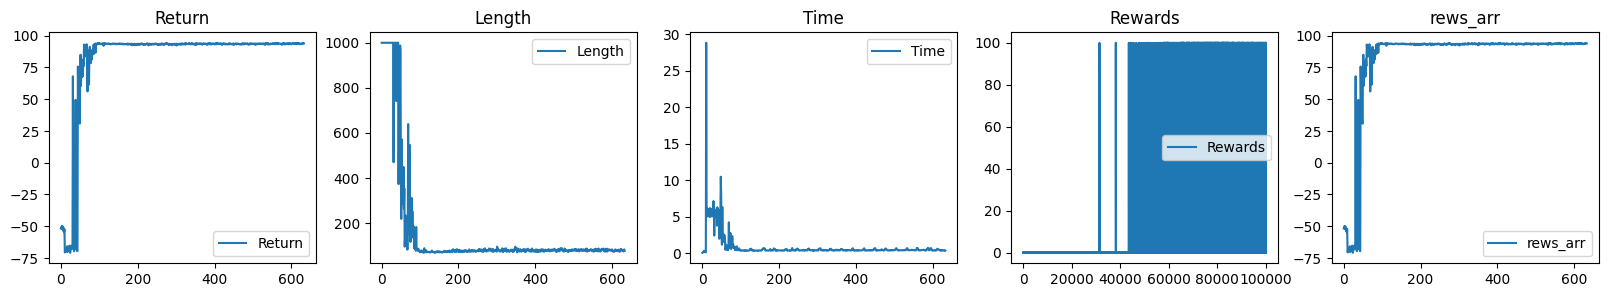

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 3))

ax1.plot(rs, label='Return')
ax1.legend()
ax1.set_title("Return")

ax2.plot(ls, label='Length')
ax2.legend()
ax2.set_title("Length")

ax3.plot(ts, label='Time')
ax3.legend()
ax3.set_title("Time")

ax4.plot(rewards, label='Rewards')
ax4.legend()
ax4.set_title("Rewards")

ax5.plot(rews_arr, label='rews_arr')
ax5.legend()
ax5.set_title("rews_arr")

plt.show()


In [ ]:
eval_env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array") #
eval_env = wrap_gym(eval_env, rescale_actions=True)
eval_env = gym.wrappers.RecordVideo(eval_env, 'MountainCarContinuous-v0')
eval_env = gym.wrappers.RecordEpisodeStatistics(eval_env, buffer_length=1)
evaluate(agent, eval_env, num_episodes=1)
eval_env.close()

### BipedalWalker

In [ ]:
env = gym.make("BipedalWalker-v3", render_mode=None)
env = wrap_gym(env, rescale_actions=True)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=1)

eval_env = gym.make("BipedalWalker-v3", render_mode=None) # "rgb_array"
eval_env = wrap_gym(eval_env, rescale_actions=True)
# eval_env = gym.wrappers.RecordVideo(eval_env, 'cartpole_video')
eval_env = gym.wrappers.RecordEpisodeStatistics(eval_env, buffer_length=1)

agent = ScoreMatchingLearner.create(42, env.observation_space, env.action_space)

replay_buffer = ReplayBuffer(env.observation_space, env.action_space, max_iter*10)

observation, _ = env.reset()
done = False

rs, ls, ts = [], [], []
rewards = []
rews = 0
rews_arr = []
pbar = trange(1, max_iter*10+1, desc='Training')
for i in pbar:
    if i < start_step*15:
        action = env.action_space.sample()
    else:
        action, agent = agent.sample_actions(observation)
        action = np.asarray(action)
    next_observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    rews += reward
    if not done or "TimeLimit.truncated" in info:
        mask = 1.0
    else:
        mask = 0.0

    replay_buffer.insert(
            dict(
                observations=observation,
                actions=action,
                rewards=reward,
                masks=mask,
                dones=done,
                next_observations=next_observation,
            )
        )
    observation = next_observation
    rewards.append(reward)
    if done:
        rews_arr.append(rews)
        rews = 0
        observation, _ = env.reset()
        done = False
        # print("Done Info:", info)
        pbar.set_postfix(info['episode'])
        rs.append(info['episode']['r'])
        ls.append(info['episode']['l'])
        ts.append(info['episode']['t'])

    if i >= start_step*15:
        batch = replay_buffer.sample(batch_size)
        agent, update_info = agent.update(batch)

        if i % print_interval == 0:
            print("Update Info:", update_info)
            print('rew_arrs : ', rews_arr[-1])


    if i % 100_000 == 0:
        eval_info = evaluate(agent, eval_env, num_episodes=num_episodes)
        print("Eval Info", eval_info)

eval_env.close()
env.close()

Training:  10%|█         | 100314/1000000 [00:49<1:44:11, 143.90it/s, r=-115, l=1600, t=0.916]

Eval Info {'return': -111.49998929822321}


Training:  15%|█▌        | 150000/1000000 [01:31<6:55:11, 34.12it/s, r=-146, l=316, t=0.112]

Update Info: {'actor_loss_mag': Array(0.03693911, dtype=float32), 'actor_loss_max': Array(0.03693911, dtype=float32), 'actor_loss_mean': Array(0.01128079, dtype=float32), 'actor_loss_min': Array(0.00055039, dtype=float32), 'actor_loss_std': Array(0.00750759, dtype=float32), 'c_loss_mag_1': Array(1.1053759, dtype=float32), 'c_loss_mag_2': Array(0.5080909, dtype=float32), 'c_loss_max_1': Array(1.1053759, dtype=float32), 'c_loss_max_2': Array(0.5080909, dtype=float32), 'c_loss_mean_1': Array(0.13457125, dtype=float32), 'c_loss_mean_2': Array(0.04871358, dtype=float32), 'c_loss_min_1': Array(2.931435e-10, dtype=float32), 'c_loss_min_2': Array(7.365718e-08, dtype=float32), 'c_loss_std_1': Array(0.1684085, dtype=float32), 'c_loss_std_2': Array(0.06813674, dtype=float32), 'critic_jacobian_mag': Array(0.11751063, dtype=float32), 'critic_jacobian_max': Array(0.11751063, dtype=float32), 'critic_jacobian_mean': Array(0.01207767, dtype=float32), 'critic_jacobian_min': Array(-0.10356872, dtype=floa

Training:  15%|█▌        | 151033/1000000 [01:38<1:20:00, 176.84it/s, r=-119, l=80, t=0.449]

Update Info: {'actor_loss_mag': Array(0.07885575, dtype=float32), 'actor_loss_max': Array(0.07885575, dtype=float32), 'actor_loss_mean': Array(0.00774642, dtype=float32), 'actor_loss_min': Array(7.809304e-05, dtype=float32), 'actor_loss_std': Array(0.00754965, dtype=float32), 'c_loss_mag_1': Array(8.483942, dtype=float32), 'c_loss_mag_2': Array(10.319112, dtype=float32), 'c_loss_max_1': Array(8.483942, dtype=float32), 'c_loss_max_2': Array(10.319112, dtype=float32), 'c_loss_mean_1': Array(0.38498062, dtype=float32), 'c_loss_mean_2': Array(0.37317526, dtype=float32), 'c_loss_min_1': Array(4.758553e-06, dtype=float32), 'c_loss_min_2': Array(6.792502e-06, dtype=float32), 'c_loss_std_1': Array(0.97816956, dtype=float32), 'c_loss_std_2': Array(1.1820283, dtype=float32), 'critic_jacobian_mag': Array(0.5755446, dtype=float32), 'critic_jacobian_max': Array(0.5726713, dtype=float32), 'critic_jacobian_mean': Array(0.02423592, dtype=float32), 'critic_jacobian_min': Array(-0.5755446, dtype=float32

Training:  15%|█▌        | 152026/1000000 [01:43<1:19:35, 177.56it/s, r=-104, l=73, t=0.387]

Update Info: {'actor_loss_mag': Array(0.09892324, dtype=float32), 'actor_loss_max': Array(0.09892324, dtype=float32), 'actor_loss_mean': Array(0.02036249, dtype=float32), 'actor_loss_min': Array(0.00081007, dtype=float32), 'actor_loss_std': Array(0.01718148, dtype=float32), 'c_loss_mag_1': Array(34.096336, dtype=float32), 'c_loss_mag_2': Array(13.849339, dtype=float32), 'c_loss_max_1': Array(34.096336, dtype=float32), 'c_loss_max_2': Array(13.849339, dtype=float32), 'c_loss_mean_1': Array(0.68962955, dtype=float32), 'c_loss_mean_2': Array(0.54204017, dtype=float32), 'c_loss_min_1': Array(1.0628484e-05, dtype=float32), 'c_loss_min_2': Array(6.156717e-05, dtype=float32), 'c_loss_std_1': Array(2.4788435, dtype=float32), 'c_loss_std_2': Array(1.2816404, dtype=float32), 'critic_jacobian_mag': Array(1.4833989, dtype=float32), 'critic_jacobian_max': Array(0.56032795, dtype=float32), 'critic_jacobian_mean': Array(0.00771003, dtype=float32), 'critic_jacobian_min': Array(-1.4833989, dtype=float3

Training:  15%|█▌        | 153036/1000000 [01:50<1:23:38, 168.77it/s, r=-151, l=1600, t=9.5]

Update Info: {'actor_loss_mag': Array(0.1178719, dtype=float32), 'actor_loss_max': Array(0.1178719, dtype=float32), 'actor_loss_mean': Array(0.02238334, dtype=float32), 'actor_loss_min': Array(0.00050514, dtype=float32), 'actor_loss_std': Array(0.01895318, dtype=float32), 'c_loss_mag_1': Array(10.128057, dtype=float32), 'c_loss_mag_2': Array(12.5933075, dtype=float32), 'c_loss_max_1': Array(10.128057, dtype=float32), 'c_loss_max_2': Array(12.5933075, dtype=float32), 'c_loss_mean_1': Array(0.40892497, dtype=float32), 'c_loss_mean_2': Array(0.44508368, dtype=float32), 'c_loss_min_1': Array(4.857883e-06, dtype=float32), 'c_loss_min_2': Array(1.3081313e-07, dtype=float32), 'c_loss_std_1': Array(0.94968295, dtype=float32), 'c_loss_std_2': Array(1.0775588, dtype=float32), 'critic_jacobian_mag': Array(0.99884474, dtype=float32), 'critic_jacobian_max': Array(0.7376046, dtype=float32), 'critic_jacobian_mean': Array(-0.02078276, dtype=float32), 'critic_jacobian_min': Array(-0.99884474, dtype=flo

Training:  15%|█▌        | 154027/1000000 [01:55<1:15:44, 186.13it/s, r=-202, l=1349, t=7.5]

Update Info: {'actor_loss_mag': Array(0.25682884, dtype=float32), 'actor_loss_max': Array(0.25682884, dtype=float32), 'actor_loss_mean': Array(0.01920452, dtype=float32), 'actor_loss_min': Array(0.00081548, dtype=float32), 'actor_loss_std': Array(0.03019363, dtype=float32), 'c_loss_mag_1': Array(8.124775, dtype=float32), 'c_loss_mag_2': Array(11.961697, dtype=float32), 'c_loss_max_1': Array(8.124775, dtype=float32), 'c_loss_max_2': Array(11.961697, dtype=float32), 'c_loss_mean_1': Array(0.4249156, dtype=float32), 'c_loss_mean_2': Array(0.48606837, dtype=float32), 'c_loss_min_1': Array(7.497944e-08, dtype=float32), 'c_loss_min_2': Array(7.397737e-05, dtype=float32), 'c_loss_std_1': Array(0.9480799, dtype=float32), 'c_loss_std_2': Array(1.134229, dtype=float32), 'critic_jacobian_mag': Array(1.4494557, dtype=float32), 'critic_jacobian_max': Array(0.935249, dtype=float32), 'critic_jacobian_mean': Array(0.01903413, dtype=float32), 'critic_jacobian_min': Array(-1.4494557, dtype=float32), 'cr

Training:  16%|█▌        | 155021/1000000 [02:02<1:19:43, 176.66it/s, r=-103, l=137, t=0.731]

Update Info: {'actor_loss_mag': Array(0.11463869, dtype=float32), 'actor_loss_max': Array(0.11463869, dtype=float32), 'actor_loss_mean': Array(0.01277843, dtype=float32), 'actor_loss_min': Array(0.00039777, dtype=float32), 'actor_loss_std': Array(0.01594355, dtype=float32), 'c_loss_mag_1': Array(11.397012, dtype=float32), 'c_loss_mag_2': Array(12.289298, dtype=float32), 'c_loss_max_1': Array(11.397012, dtype=float32), 'c_loss_max_2': Array(12.289298, dtype=float32), 'c_loss_mean_1': Array(0.41991448, dtype=float32), 'c_loss_mean_2': Array(0.49239546, dtype=float32), 'c_loss_min_1': Array(2.0416923e-05, dtype=float32), 'c_loss_min_2': Array(7.740116e-06, dtype=float32), 'c_loss_std_1': Array(1.2506653, dtype=float32), 'c_loss_std_2': Array(1.3403597, dtype=float32), 'critic_jacobian_mag': Array(0.9568559, dtype=float32), 'critic_jacobian_max': Array(0.8685989, dtype=float32), 'critic_jacobian_mean': Array(0.01058752, dtype=float32), 'critic_jacobian_min': Array(-0.9568559, dtype=float32

Training:  16%|█▌        | 156025/1000000 [02:07<1:17:19, 181.93it/s, r=-164, l=1600, t=9.53]

Update Info: {'actor_loss_mag': Array(0.15722673, dtype=float32), 'actor_loss_max': Array(0.15722673, dtype=float32), 'actor_loss_mean': Array(0.01464439, dtype=float32), 'actor_loss_min': Array(0.00083333, dtype=float32), 'actor_loss_std': Array(0.0178371, dtype=float32), 'c_loss_mag_1': Array(23.59482, dtype=float32), 'c_loss_mag_2': Array(30.426458, dtype=float32), 'c_loss_max_1': Array(23.59482, dtype=float32), 'c_loss_max_2': Array(30.426458, dtype=float32), 'c_loss_mean_1': Array(0.48365253, dtype=float32), 'c_loss_mean_2': Array(0.57001257, dtype=float32), 'c_loss_min_1': Array(0.00013506, dtype=float32), 'c_loss_min_2': Array(3.58319e-05, dtype=float32), 'c_loss_std_1': Array(1.891434, dtype=float32), 'c_loss_std_2': Array(2.2530994, dtype=float32), 'critic_jacobian_mag': Array(0.9730167, dtype=float32), 'critic_jacobian_max': Array(0.9730167, dtype=float32), 'critic_jacobian_mean': Array(0.00444682, dtype=float32), 'critic_jacobian_min': Array(-0.77358985, dtype=float32), 'cri

Training:  16%|█▌        | 157012/1000000 [02:13<2:00:05, 116.98it/s, r=-164, l=1600, t=9.53]

Update Info: {'actor_loss_mag': Array(0.1455175, dtype=float32), 'actor_loss_max': Array(0.1455175, dtype=float32), 'actor_loss_mean': Array(0.0096388, dtype=float32), 'actor_loss_min': Array(0.00022723, dtype=float32), 'actor_loss_std': Array(0.01923633, dtype=float32), 'c_loss_mag_1': Array(10.340642, dtype=float32), 'c_loss_mag_2': Array(12.225859, dtype=float32), 'c_loss_max_1': Array(10.340642, dtype=float32), 'c_loss_max_2': Array(12.225859, dtype=float32), 'c_loss_mean_1': Array(0.31590036, dtype=float32), 'c_loss_mean_2': Array(0.3604961, dtype=float32), 'c_loss_min_1': Array(1.3739578e-05, dtype=float32), 'c_loss_min_2': Array(8.788347e-07, dtype=float32), 'c_loss_std_1': Array(1.1073446, dtype=float32), 'c_loss_std_2': Array(1.2124335, dtype=float32), 'critic_jacobian_mag': Array(1.0454416, dtype=float32), 'critic_jacobian_max': Array(0.91768277, dtype=float32), 'critic_jacobian_mean': Array(0.0007412, dtype=float32), 'critic_jacobian_min': Array(-1.0454416, dtype=float32), '

Training:  16%|█▌        | 158011/1000000 [02:19<1:39:10, 141.49it/s, r=-140, l=1600, t=9.5]

Update Info: {'actor_loss_mag': Array(0.12485594, dtype=float32), 'actor_loss_max': Array(0.12485594, dtype=float32), 'actor_loss_mean': Array(0.00793675, dtype=float32), 'actor_loss_min': Array(0.00028464, dtype=float32), 'actor_loss_std': Array(0.01312318, dtype=float32), 'c_loss_mag_1': Array(10.399754, dtype=float32), 'c_loss_mag_2': Array(7.025177, dtype=float32), 'c_loss_max_1': Array(10.399754, dtype=float32), 'c_loss_max_2': Array(7.025177, dtype=float32), 'c_loss_mean_1': Array(0.36250323, dtype=float32), 'c_loss_mean_2': Array(0.30314144, dtype=float32), 'c_loss_min_1': Array(1.11605e-06, dtype=float32), 'c_loss_min_2': Array(2.6547898e-06, dtype=float32), 'c_loss_std_1': Array(1.0564846, dtype=float32), 'c_loss_std_2': Array(0.9460518, dtype=float32), 'critic_jacobian_mag': Array(0.8721353, dtype=float32), 'critic_jacobian_max': Array(0.8376323, dtype=float32), 'critic_jacobian_mean': Array(0.01025371, dtype=float32), 'critic_jacobian_min': Array(-0.8721353, dtype=float32), 

Training:  16%|█▌        | 159017/1000000 [02:25<2:04:37, 112.47it/s, r=-140, l=1600, t=9.5]

Update Info: {'actor_loss_mag': Array(0.19439624, dtype=float32), 'actor_loss_max': Array(0.19439624, dtype=float32), 'actor_loss_mean': Array(0.01141911, dtype=float32), 'actor_loss_min': Array(0.0003955, dtype=float32), 'actor_loss_std': Array(0.02244249, dtype=float32), 'c_loss_mag_1': Array(63.678627, dtype=float32), 'c_loss_mag_2': Array(72.98396, dtype=float32), 'c_loss_max_1': Array(63.678627, dtype=float32), 'c_loss_max_2': Array(72.98396, dtype=float32), 'c_loss_mean_1': Array(0.72675085, dtype=float32), 'c_loss_mean_2': Array(0.7916882, dtype=float32), 'c_loss_min_1': Array(7.066916e-08, dtype=float32), 'c_loss_min_2': Array(4.223716e-08, dtype=float32), 'c_loss_std_1': Array(4.482975, dtype=float32), 'c_loss_std_2': Array(5.179573, dtype=float32), 'critic_jacobian_mag': Array(1.0960665, dtype=float32), 'critic_jacobian_max': Array(1.0960665, dtype=float32), 'critic_jacobian_mean': Array(0.04336271, dtype=float32), 'critic_jacobian_min': Array(-0.6967341, dtype=float32), 'cri

Training:  16%|█▌        | 160016/1000000 [02:31<1:17:04, 181.62it/s, r=-106, l=67, t=0.37]

Update Info: {'actor_loss_mag': Array(0.3165681, dtype=float32), 'actor_loss_max': Array(0.3165681, dtype=float32), 'actor_loss_mean': Array(0.01267821, dtype=float32), 'actor_loss_min': Array(5.5135846e-05, dtype=float32), 'actor_loss_std': Array(0.03352882, dtype=float32), 'c_loss_mag_1': Array(23.043802, dtype=float32), 'c_loss_mag_2': Array(23.14929, dtype=float32), 'c_loss_max_1': Array(23.043802, dtype=float32), 'c_loss_max_2': Array(23.14929, dtype=float32), 'c_loss_mean_1': Array(0.66339236, dtype=float32), 'c_loss_mean_2': Array(0.5804466, dtype=float32), 'c_loss_min_1': Array(1.35862365e-05, dtype=float32), 'c_loss_min_2': Array(2.9265044e-07, dtype=float32), 'c_loss_std_1': Array(2.536582, dtype=float32), 'c_loss_std_2': Array(2.4320295, dtype=float32), 'critic_jacobian_mag': Array(2.4044585, dtype=float32), 'critic_jacobian_max': Array(2.4044585, dtype=float32), 'critic_jacobian_mean': Array(0.0095584, dtype=float32), 'critic_jacobian_min': Array(-1.5107752, dtype=float32),

Training:  16%|█▌        | 161004/1000000 [02:36<1:23:01, 168.43it/s, r=-146, l=1600, t=8.52]

Update Info: {'actor_loss_mag': Array(0.16652036, dtype=float32), 'actor_loss_max': Array(0.16652036, dtype=float32), 'actor_loss_mean': Array(0.00878431, dtype=float32), 'actor_loss_min': Array(5.8149257e-05, dtype=float32), 'actor_loss_std': Array(0.02046799, dtype=float32), 'c_loss_mag_1': Array(9.289422, dtype=float32), 'c_loss_mag_2': Array(10.029163, dtype=float32), 'c_loss_max_1': Array(9.289422, dtype=float32), 'c_loss_max_2': Array(10.029163, dtype=float32), 'c_loss_mean_1': Array(0.30434287, dtype=float32), 'c_loss_mean_2': Array(0.2623735, dtype=float32), 'c_loss_min_1': Array(1.521714e-06, dtype=float32), 'c_loss_min_2': Array(2.2397586e-07, dtype=float32), 'c_loss_std_1': Array(1.1257876, dtype=float32), 'c_loss_std_2': Array(0.8621114, dtype=float32), 'critic_jacobian_mag': Array(1.4906472, dtype=float32), 'critic_jacobian_max': Array(1.4906472, dtype=float32), 'critic_jacobian_mean': Array(0.00932606, dtype=float32), 'critic_jacobian_min': Array(-0.95226324, dtype=float3

Training:  16%|█▌        | 162031/1000000 [02:43<1:17:29, 180.23it/s, r=-146, l=1600, t=8.52]

Update Info: {'actor_loss_mag': Array(0.3097582, dtype=float32), 'actor_loss_max': Array(0.3097582, dtype=float32), 'actor_loss_mean': Array(0.0141207, dtype=float32), 'actor_loss_min': Array(0.00034175, dtype=float32), 'actor_loss_std': Array(0.03498685, dtype=float32), 'c_loss_mag_1': Array(97.50629, dtype=float32), 'c_loss_mag_2': Array(99.73624, dtype=float32), 'c_loss_max_1': Array(97.50629, dtype=float32), 'c_loss_max_2': Array(99.73624, dtype=float32), 'c_loss_mean_1': Array(1.5364192, dtype=float32), 'c_loss_mean_2': Array(1.4970565, dtype=float32), 'c_loss_min_1': Array(1.5348327e-05, dtype=float32), 'c_loss_min_2': Array(9.022333e-07, dtype=float32), 'c_loss_std_1': Array(7.927407, dtype=float32), 'c_loss_std_2': Array(7.981227, dtype=float32), 'critic_jacobian_mag': Array(1.9523168, dtype=float32), 'critic_jacobian_max': Array(1.1307721, dtype=float32), 'critic_jacobian_mean': Array(0.00709122, dtype=float32), 'critic_jacobian_min': Array(-1.9523168, dtype=float32), 'critic_

Training:  16%|█▋        | 163031/1000000 [02:48<1:17:50, 179.19it/s, r=-145, l=1600, t=9.51]

Update Info: {'actor_loss_mag': Array(0.16955274, dtype=float32), 'actor_loss_max': Array(0.16955274, dtype=float32), 'actor_loss_mean': Array(0.00994677, dtype=float32), 'actor_loss_min': Array(0.00035266, dtype=float32), 'actor_loss_std': Array(0.01992065, dtype=float32), 'c_loss_mag_1': Array(84.4403, dtype=float32), 'c_loss_mag_2': Array(74.736755, dtype=float32), 'c_loss_max_1': Array(84.4403, dtype=float32), 'c_loss_max_2': Array(74.736755, dtype=float32), 'c_loss_mean_1': Array(1.0568123, dtype=float32), 'c_loss_mean_2': Array(1.1269082, dtype=float32), 'c_loss_min_1': Array(5.7573343e-06, dtype=float32), 'c_loss_min_2': Array(4.2906177e-06, dtype=float32), 'c_loss_std_1': Array(5.9749713, dtype=float32), 'c_loss_std_2': Array(5.9714994, dtype=float32), 'critic_jacobian_mag': Array(1.6983944, dtype=float32), 'critic_jacobian_max': Array(1.6983944, dtype=float32), 'critic_jacobian_mean': Array(0.01677779, dtype=float32), 'critic_jacobian_min': Array(-1.5276241, dtype=float32), 'c

Training:  16%|█▋        | 164036/1000000 [02:55<1:17:02, 180.86it/s, r=-134, l=1600, t=9.71]

Update Info: {'actor_loss_mag': Array(0.23393524, dtype=float32), 'actor_loss_max': Array(0.23393524, dtype=float32), 'actor_loss_mean': Array(0.0124241, dtype=float32), 'actor_loss_min': Array(0.0001103, dtype=float32), 'actor_loss_std': Array(0.03071934, dtype=float32), 'c_loss_mag_1': Array(40.35989, dtype=float32), 'c_loss_mag_2': Array(41.575905, dtype=float32), 'c_loss_max_1': Array(40.35989, dtype=float32), 'c_loss_max_2': Array(41.575905, dtype=float32), 'c_loss_mean_1': Array(1.1042606, dtype=float32), 'c_loss_mean_2': Array(0.9857354, dtype=float32), 'c_loss_min_1': Array(7.28528e-07, dtype=float32), 'c_loss_min_2': Array(2.634628e-06, dtype=float32), 'c_loss_std_1': Array(4.916536, dtype=float32), 'c_loss_std_2': Array(4.5731, dtype=float32), 'critic_jacobian_mag': Array(2.7948823, dtype=float32), 'critic_jacobian_max': Array(2.7948823, dtype=float32), 'critic_jacobian_mean': Array(0.00640773, dtype=float32), 'critic_jacobian_min': Array(-2.600245, dtype=float32), 'critic_ja

Training:  17%|█▋        | 165027/1000000 [03:00<1:19:05, 175.96it/s, r=-134, l=1600, t=9.71]

Update Info: {'actor_loss_mag': Array(0.14022344, dtype=float32), 'actor_loss_max': Array(0.14022344, dtype=float32), 'actor_loss_mean': Array(0.00708352, dtype=float32), 'actor_loss_min': Array(0.00013299, dtype=float32), 'actor_loss_std': Array(0.01682915, dtype=float32), 'c_loss_mag_1': Array(15.871263, dtype=float32), 'c_loss_mag_2': Array(27.47815, dtype=float32), 'c_loss_max_1': Array(15.871263, dtype=float32), 'c_loss_max_2': Array(27.47815, dtype=float32), 'c_loss_mean_1': Array(0.37958923, dtype=float32), 'c_loss_mean_2': Array(0.44492382, dtype=float32), 'c_loss_min_1': Array(3.2093906e-06, dtype=float32), 'c_loss_min_2': Array(1.038363e-06, dtype=float32), 'c_loss_std_1': Array(1.451614, dtype=float32), 'c_loss_std_2': Array(2.0863755, dtype=float32), 'critic_jacobian_mag': Array(1.8088498, dtype=float32), 'critic_jacobian_max': Array(1.3708543, dtype=float32), 'critic_jacobian_mean': Array(0.02071969, dtype=float32), 'critic_jacobian_min': Array(-1.8088498, dtype=float32), 

Training:  17%|█▋        | 166019/1000000 [03:06<1:20:31, 172.63it/s, r=-138, l=1600, t=9.42]

Update Info: {'actor_loss_mag': Array(0.2518402, dtype=float32), 'actor_loss_max': Array(0.2518402, dtype=float32), 'actor_loss_mean': Array(0.01387856, dtype=float32), 'actor_loss_min': Array(0.00059261, dtype=float32), 'actor_loss_std': Array(0.03030303, dtype=float32), 'c_loss_mag_1': Array(26.56878, dtype=float32), 'c_loss_mag_2': Array(22.724672, dtype=float32), 'c_loss_max_1': Array(26.56878, dtype=float32), 'c_loss_max_2': Array(22.724672, dtype=float32), 'c_loss_mean_1': Array(0.63014483, dtype=float32), 'c_loss_mean_2': Array(0.59312594, dtype=float32), 'c_loss_min_1': Array(3.5640915e-07, dtype=float32), 'c_loss_min_2': Array(1.4468362e-05, dtype=float32), 'c_loss_std_1': Array(2.9616196, dtype=float32), 'c_loss_std_2': Array(2.5341744, dtype=float32), 'critic_jacobian_mag': Array(2.8869374, dtype=float32), 'critic_jacobian_max': Array(2.8869374, dtype=float32), 'critic_jacobian_mean': Array(0.02275715, dtype=float32), 'critic_jacobian_min': Array(-1.7644732, dtype=float32), 

Training:  17%|█▋        | 167032/1000000 [03:12<1:16:33, 181.33it/s, r=-138, l=1600, t=9.42]

Update Info: {'actor_loss_mag': Array(0.12352969, dtype=float32), 'actor_loss_max': Array(0.12352969, dtype=float32), 'actor_loss_mean': Array(0.00677445, dtype=float32), 'actor_loss_min': Array(0.00012951, dtype=float32), 'actor_loss_std': Array(0.01640987, dtype=float32), 'c_loss_mag_1': Array(19.835402, dtype=float32), 'c_loss_mag_2': Array(10.394218, dtype=float32), 'c_loss_max_1': Array(19.835402, dtype=float32), 'c_loss_max_2': Array(10.394218, dtype=float32), 'c_loss_mean_1': Array(0.31871668, dtype=float32), 'c_loss_mean_2': Array(0.22418487, dtype=float32), 'c_loss_min_1': Array(7.3951487e-06, dtype=float32), 'c_loss_min_2': Array(1.1623911e-07, dtype=float32), 'c_loss_std_1': Array(1.6005914, dtype=float32), 'c_loss_std_2': Array(0.99580437, dtype=float32), 'critic_jacobian_mag': Array(1.6565964, dtype=float32), 'critic_jacobian_max': Array(1.6565964, dtype=float32), 'critic_jacobian_mean': Array(0.02117476, dtype=float32), 'critic_jacobian_min': Array(-1.3198586, dtype=float

Training:  17%|█▋        | 168015/1000000 [03:18<1:23:50, 165.40it/s, r=-125, l=1600, t=9.04]

Update Info: {'actor_loss_mag': Array(0.12641203, dtype=float32), 'actor_loss_max': Array(0.12641203, dtype=float32), 'actor_loss_mean': Array(0.00731049, dtype=float32), 'actor_loss_min': Array(2.34594e-05, dtype=float32), 'actor_loss_std': Array(0.01696422, dtype=float32), 'c_loss_mag_1': Array(41.236168, dtype=float32), 'c_loss_mag_2': Array(17.483215, dtype=float32), 'c_loss_max_1': Array(41.236168, dtype=float32), 'c_loss_max_2': Array(17.483215, dtype=float32), 'c_loss_mean_1': Array(0.528394, dtype=float32), 'c_loss_mean_2': Array(0.4084446, dtype=float32), 'c_loss_min_1': Array(3.263276e-07, dtype=float32), 'c_loss_min_2': Array(4.1993212e-07, dtype=float32), 'c_loss_std_1': Array(2.9867036, dtype=float32), 'c_loss_std_2': Array(1.7561189, dtype=float32), 'critic_jacobian_mag': Array(2.4046826, dtype=float32), 'critic_jacobian_max': Array(2.3392973, dtype=float32), 'critic_jacobian_mean': Array(0.00212474, dtype=float32), 'critic_jacobian_min': Array(-2.4046826, dtype=float32),

Training:  17%|█▋        | 169027/1000000 [03:24<1:19:47, 173.57it/s, r=-130, l=1600, t=9.48]

Update Info: {'actor_loss_mag': Array(0.22814126, dtype=float32), 'actor_loss_max': Array(0.22814126, dtype=float32), 'actor_loss_mean': Array(0.00682056, dtype=float32), 'actor_loss_min': Array(7.207771e-05, dtype=float32), 'actor_loss_std': Array(0.02008311, dtype=float32), 'c_loss_mag_1': Array(73.86982, dtype=float32), 'c_loss_mag_2': Array(45.187134, dtype=float32), 'c_loss_max_1': Array(73.86982, dtype=float32), 'c_loss_max_2': Array(45.187134, dtype=float32), 'c_loss_mean_1': Array(0.98150563, dtype=float32), 'c_loss_mean_2': Array(0.80583394, dtype=float32), 'c_loss_min_1': Array(1.4479247e-07, dtype=float32), 'c_loss_min_2': Array(5.2168843e-08, dtype=float32), 'c_loss_std_1': Array(5.8429832, dtype=float32), 'c_loss_std_2': Array(4.296015, dtype=float32), 'critic_jacobian_mag': Array(1.7066758, dtype=float32), 'critic_jacobian_max': Array(1.441042, dtype=float32), 'critic_jacobian_mean': Array(0.03683903, dtype=float32), 'critic_jacobian_min': Array(-1.7066758, dtype=float32)

Training:  17%|█▋        | 170014/1000000 [03:30<2:05:29, 110.23it/s, r=-130, l=1600, t=9.48]

Update Info: {'actor_loss_mag': Array(0.17323951, dtype=float32), 'actor_loss_max': Array(0.17323951, dtype=float32), 'actor_loss_mean': Array(0.00629053, dtype=float32), 'actor_loss_min': Array(0.00011351, dtype=float32), 'actor_loss_std': Array(0.01890737, dtype=float32), 'c_loss_mag_1': Array(42.81195, dtype=float32), 'c_loss_mag_2': Array(35.502914, dtype=float32), 'c_loss_max_1': Array(42.81195, dtype=float32), 'c_loss_max_2': Array(35.502914, dtype=float32), 'c_loss_mean_1': Array(0.42534667, dtype=float32), 'c_loss_mean_2': Array(0.37059522, dtype=float32), 'c_loss_min_1': Array(9.5475116e-08, dtype=float32), 'c_loss_min_2': Array(6.463315e-07, dtype=float32), 'c_loss_std_1': Array(3.1238906, dtype=float32), 'c_loss_std_2': Array(2.670543, dtype=float32), 'critic_jacobian_mag': Array(2.8747516, dtype=float32), 'critic_jacobian_max': Array(2.8747516, dtype=float32), 'critic_jacobian_mean': Array(0.00483029, dtype=float32), 'critic_jacobian_min': Array(-0.87151194, dtype=float32),

Training:  17%|█▋        | 171021/1000000 [03:36<1:52:50, 122.44it/s, r=-135, l=1600, t=9.81]

Update Info: {'actor_loss_mag': Array(0.30687952, dtype=float32), 'actor_loss_max': Array(0.30687952, dtype=float32), 'actor_loss_mean': Array(0.00711003, dtype=float32), 'actor_loss_min': Array(1.1587651e-05, dtype=float32), 'actor_loss_std': Array(0.02343153, dtype=float32), 'c_loss_mag_1': Array(150.77293, dtype=float32), 'c_loss_mag_2': Array(133.01328, dtype=float32), 'c_loss_max_1': Array(150.77293, dtype=float32), 'c_loss_max_2': Array(133.01328, dtype=float32), 'c_loss_mean_1': Array(1.331068, dtype=float32), 'c_loss_mean_2': Array(1.1721992, dtype=float32), 'c_loss_min_1': Array(1.6119975e-07, dtype=float32), 'c_loss_min_2': Array(2.961515e-06, dtype=float32), 'c_loss_std_1': Array(12.751674, dtype=float32), 'c_loss_std_2': Array(11.35423, dtype=float32), 'critic_jacobian_mag': Array(1.9267045, dtype=float32), 'critic_jacobian_max': Array(1.9267045, dtype=float32), 'critic_jacobian_mean': Array(0.02236503, dtype=float32), 'critic_jacobian_min': Array(-1.6913989, dtype=float32)

Training:  17%|█▋        | 172019/1000000 [03:42<2:00:10, 114.82it/s, r=-136, l=1600, t=9.82]

Update Info: {'actor_loss_mag': Array(0.15199599, dtype=float32), 'actor_loss_max': Array(0.15199599, dtype=float32), 'actor_loss_mean': Array(0.00776238, dtype=float32), 'actor_loss_min': Array(0.00011699, dtype=float32), 'actor_loss_std': Array(0.01959218, dtype=float32), 'c_loss_mag_1': Array(43.09435, dtype=float32), 'c_loss_mag_2': Array(36.59654, dtype=float32), 'c_loss_max_1': Array(43.09435, dtype=float32), 'c_loss_max_2': Array(36.59654, dtype=float32), 'c_loss_mean_1': Array(0.58867955, dtype=float32), 'c_loss_mean_2': Array(0.51350015, dtype=float32), 'c_loss_min_1': Array(1.5500793e-06, dtype=float32), 'c_loss_min_2': Array(5.8426144e-07, dtype=float32), 'c_loss_std_1': Array(3.6414263, dtype=float32), 'c_loss_std_2': Array(2.9111872, dtype=float32), 'critic_jacobian_mag': Array(2.8543358, dtype=float32), 'critic_jacobian_max': Array(1.2540677, dtype=float32), 'critic_jacobian_mean': Array(0.00175919, dtype=float32), 'critic_jacobian_min': Array(-2.8543358, dtype=float32), 

Training:  17%|█▋        | 173017/1000000 [03:48<1:21:59, 168.12it/s, r=-136, l=1600, t=9.82]

Update Info: {'actor_loss_mag': Array(0.22513774, dtype=float32), 'actor_loss_max': Array(0.22513774, dtype=float32), 'actor_loss_mean': Array(0.00824165, dtype=float32), 'actor_loss_min': Array(7.958156e-05, dtype=float32), 'actor_loss_std': Array(0.02314177, dtype=float32), 'c_loss_mag_1': Array(11.482289, dtype=float32), 'c_loss_mag_2': Array(10.360916, dtype=float32), 'c_loss_max_1': Array(11.482289, dtype=float32), 'c_loss_max_2': Array(10.360916, dtype=float32), 'c_loss_mean_1': Array(0.2564083, dtype=float32), 'c_loss_mean_2': Array(0.22319245, dtype=float32), 'c_loss_min_1': Array(2.4283108e-06, dtype=float32), 'c_loss_min_2': Array(2.3868779e-08, dtype=float32), 'c_loss_std_1': Array(1.0698032, dtype=float32), 'c_loss_std_2': Array(0.8928209, dtype=float32), 'critic_jacobian_mag': Array(3.0921235, dtype=float32), 'critic_jacobian_max': Array(1.7139648, dtype=float32), 'critic_jacobian_mean': Array(0.0307401, dtype=float32), 'critic_jacobian_min': Array(-3.0921235, dtype=float3

Training:  17%|█▋        | 174018/1000000 [03:54<2:00:00, 114.71it/s, r=-132, l=1600, t=9.27]

Update Info: {'actor_loss_mag': Array(0.24747118, dtype=float32), 'actor_loss_max': Array(0.24747118, dtype=float32), 'actor_loss_mean': Array(0.00808726, dtype=float32), 'actor_loss_min': Array(0.0001381, dtype=float32), 'actor_loss_std': Array(0.02353129, dtype=float32), 'c_loss_mag_1': Array(55.626305, dtype=float32), 'c_loss_mag_2': Array(54.8184, dtype=float32), 'c_loss_max_1': Array(55.626305, dtype=float32), 'c_loss_max_2': Array(54.8184, dtype=float32), 'c_loss_mean_1': Array(0.6460004, dtype=float32), 'c_loss_mean_2': Array(0.64274013, dtype=float32), 'c_loss_min_1': Array(1.5777209e-07, dtype=float32), 'c_loss_min_2': Array(3.8221515e-10, dtype=float32), 'c_loss_std_1': Array(4.22166, dtype=float32), 'c_loss_std_2': Array(4.195582, dtype=float32), 'critic_jacobian_mag': Array(1.9298447, dtype=float32), 'critic_jacobian_max': Array(1.9298447, dtype=float32), 'critic_jacobian_mean': Array(0.04105972, dtype=float32), 'critic_jacobian_min': Array(-1.6018281, dtype=float32), 'crit

Training:  18%|█▊        | 175018/1000000 [04:00<1:25:47, 160.28it/s, r=-132, l=1600, t=9.27]

Update Info: {'actor_loss_mag': Array(0.27418956, dtype=float32), 'actor_loss_max': Array(0.27418956, dtype=float32), 'actor_loss_mean': Array(0.00851982, dtype=float32), 'actor_loss_min': Array(0.00012855, dtype=float32), 'actor_loss_std': Array(0.02637097, dtype=float32), 'c_loss_mag_1': Array(83.28303, dtype=float32), 'c_loss_mag_2': Array(45.232582, dtype=float32), 'c_loss_max_1': Array(83.28303, dtype=float32), 'c_loss_max_2': Array(45.232582, dtype=float32), 'c_loss_mean_1': Array(0.5858147, dtype=float32), 'c_loss_mean_2': Array(0.40939045, dtype=float32), 'c_loss_min_1': Array(2.3428811e-08, dtype=float32), 'c_loss_min_2': Array(1.05397e-06, dtype=float32), 'c_loss_std_1': Array(5.3890796, dtype=float32), 'c_loss_std_2': Array(3.0500984, dtype=float32), 'critic_jacobian_mag': Array(2.5952175, dtype=float32), 'critic_jacobian_max': Array(2.5952175, dtype=float32), 'critic_jacobian_mean': Array(0.01641256, dtype=float32), 'critic_jacobian_min': Array(-1.888194, dtype=float32), 'c

Training:  18%|█▊        | 176027/1000000 [04:05<1:19:47, 172.09it/s, r=-123, l=1600, t=9.67]

Update Info: {'actor_loss_mag': Array(0.23119873, dtype=float32), 'actor_loss_max': Array(0.23119873, dtype=float32), 'actor_loss_mean': Array(0.0070676, dtype=float32), 'actor_loss_min': Array(0.00019048, dtype=float32), 'actor_loss_std': Array(0.0239862, dtype=float32), 'c_loss_mag_1': Array(40.45194, dtype=float32), 'c_loss_mag_2': Array(35.02777, dtype=float32), 'c_loss_max_1': Array(40.45194, dtype=float32), 'c_loss_max_2': Array(35.02777, dtype=float32), 'c_loss_mean_1': Array(0.50495905, dtype=float32), 'c_loss_mean_2': Array(0.4063049, dtype=float32), 'c_loss_min_1': Array(3.0408157e-06, dtype=float32), 'c_loss_min_2': Array(2.1290361e-08, dtype=float32), 'c_loss_std_1': Array(3.133516, dtype=float32), 'c_loss_std_2': Array(2.5785449, dtype=float32), 'critic_jacobian_mag': Array(2.2675993, dtype=float32), 'critic_jacobian_max': Array(2.2675993, dtype=float32), 'critic_jacobian_mean': Array(0.02210283, dtype=float32), 'critic_jacobian_min': Array(-2.1170757, dtype=float32), 'cri

Training:  18%|█▊        | 177019/1000000 [04:12<1:15:54, 180.69it/s, r=-127, l=1600, t=9.55]

Update Info: {'actor_loss_mag': Array(0.47007355, dtype=float32), 'actor_loss_max': Array(0.47007355, dtype=float32), 'actor_loss_mean': Array(0.00989883, dtype=float32), 'actor_loss_min': Array(8.494919e-05, dtype=float32), 'actor_loss_std': Array(0.04161683, dtype=float32), 'c_loss_mag_1': Array(80.08653, dtype=float32), 'c_loss_mag_2': Array(75.61058, dtype=float32), 'c_loss_max_1': Array(80.08653, dtype=float32), 'c_loss_max_2': Array(75.61058, dtype=float32), 'c_loss_mean_1': Array(0.72414696, dtype=float32), 'c_loss_mean_2': Array(0.7313784, dtype=float32), 'c_loss_min_1': Array(2.1373935e-06, dtype=float32), 'c_loss_min_2': Array(1.8859282e-08, dtype=float32), 'c_loss_std_1': Array(5.892768, dtype=float32), 'c_loss_std_2': Array(5.7285194, dtype=float32), 'critic_jacobian_mag': Array(3.6185007, dtype=float32), 'critic_jacobian_max': Array(1.6434101, dtype=float32), 'critic_jacobian_mean': Array(0.00097397, dtype=float32), 'critic_jacobian_min': Array(-3.6185007, dtype=float32), 

Training:  18%|█▊        | 178034/1000000 [04:17<1:14:55, 182.85it/s, r=-127, l=1600, t=9.55]

Update Info: {'actor_loss_mag': Array(0.36016178, dtype=float32), 'actor_loss_max': Array(0.36016178, dtype=float32), 'actor_loss_mean': Array(0.01018315, dtype=float32), 'actor_loss_min': Array(0.00010766, dtype=float32), 'actor_loss_std': Array(0.03863725, dtype=float32), 'c_loss_mag_1': Array(34.52562, dtype=float32), 'c_loss_mag_2': Array(33.850555, dtype=float32), 'c_loss_max_1': Array(34.52562, dtype=float32), 'c_loss_max_2': Array(33.850555, dtype=float32), 'c_loss_mean_1': Array(0.6200055, dtype=float32), 'c_loss_mean_2': Array(0.5487975, dtype=float32), 'c_loss_min_1': Array(3.8035296e-08, dtype=float32), 'c_loss_min_2': Array(2.7125943e-06, dtype=float32), 'c_loss_std_1': Array(3.170971, dtype=float32), 'c_loss_std_2': Array(2.8885639, dtype=float32), 'critic_jacobian_mag': Array(2.2837415, dtype=float32), 'critic_jacobian_max': Array(1.825284, dtype=float32), 'critic_jacobian_mean': Array(0.03219042, dtype=float32), 'critic_jacobian_min': Array(-2.2837415, dtype=float32), 'c

Training:  18%|█▊        | 179021/1000000 [04:23<1:12:54, 187.67it/s, r=-137, l=1600, t=8.74]

Update Info: {'actor_loss_mag': Array(0.29874212, dtype=float32), 'actor_loss_max': Array(0.29874212, dtype=float32), 'actor_loss_mean': Array(0.00682314, dtype=float32), 'actor_loss_min': Array(8.102182e-05, dtype=float32), 'actor_loss_std': Array(0.02338482, dtype=float32), 'c_loss_mag_1': Array(37.150204, dtype=float32), 'c_loss_mag_2': Array(34.02133, dtype=float32), 'c_loss_max_1': Array(37.150204, dtype=float32), 'c_loss_max_2': Array(34.02133, dtype=float32), 'c_loss_mean_1': Array(0.56900597, dtype=float32), 'c_loss_mean_2': Array(0.52764606, dtype=float32), 'c_loss_min_1': Array(1.8158689e-06, dtype=float32), 'c_loss_min_2': Array(3.6730876e-07, dtype=float32), 'c_loss_std_1': Array(3.4190793, dtype=float32), 'c_loss_std_2': Array(3.2944787, dtype=float32), 'critic_jacobian_mag': Array(3.6284676, dtype=float32), 'critic_jacobian_max': Array(2.0364614, dtype=float32), 'critic_jacobian_mean': Array(0.03749346, dtype=float32), 'critic_jacobian_min': Array(-3.6284676, dtype=float3

Training:  18%|█▊        | 180024/1000000 [04:28<1:14:20, 183.82it/s, r=-116, l=1600, t=9.08]

Update Info: {'actor_loss_mag': Array(0.26080993, dtype=float32), 'actor_loss_max': Array(0.26080993, dtype=float32), 'actor_loss_mean': Array(0.00792442, dtype=float32), 'actor_loss_min': Array(7.090115e-05, dtype=float32), 'actor_loss_std': Array(0.02946268, dtype=float32), 'c_loss_mag_1': Array(12.102858, dtype=float32), 'c_loss_mag_2': Array(12.098094, dtype=float32), 'c_loss_max_1': Array(12.102858, dtype=float32), 'c_loss_max_2': Array(12.098094, dtype=float32), 'c_loss_mean_1': Array(0.2907396, dtype=float32), 'c_loss_mean_2': Array(0.28210774, dtype=float32), 'c_loss_min_1': Array(2.0490244e-05, dtype=float32), 'c_loss_min_2': Array(6.6486336e-07, dtype=float32), 'c_loss_std_1': Array(1.1562736, dtype=float32), 'c_loss_std_2': Array(1.1233577, dtype=float32), 'critic_jacobian_mag': Array(2.7058325, dtype=float32), 'critic_jacobian_max': Array(2.7058325, dtype=float32), 'critic_jacobian_mean': Array(0.0079894, dtype=float32), 'critic_jacobian_min': Array(-2.25418, dtype=float32)

Training:  18%|█▊        | 181037/1000000 [04:35<1:13:18, 186.17it/s, r=-116, l=1600, t=9.08]

Update Info: {'actor_loss_mag': Array(0.23942712, dtype=float32), 'actor_loss_max': Array(0.23942712, dtype=float32), 'actor_loss_mean': Array(0.0072275, dtype=float32), 'actor_loss_min': Array(5.9262195e-05, dtype=float32), 'actor_loss_std': Array(0.02599131, dtype=float32), 'c_loss_mag_1': Array(28.272694, dtype=float32), 'c_loss_mag_2': Array(23.006388, dtype=float32), 'c_loss_max_1': Array(28.272694, dtype=float32), 'c_loss_max_2': Array(23.006388, dtype=float32), 'c_loss_mean_1': Array(0.3784511, dtype=float32), 'c_loss_mean_2': Array(0.4124902, dtype=float32), 'c_loss_min_1': Array(8.0705286e-07, dtype=float32), 'c_loss_min_2': Array(2.4164365e-06, dtype=float32), 'c_loss_std_1': Array(2.3298976, dtype=float32), 'c_loss_std_2': Array(2.3976402, dtype=float32), 'critic_jacobian_mag': Array(1.7701126, dtype=float32), 'critic_jacobian_max': Array(1.7701126, dtype=float32), 'critic_jacobian_mean': Array(0.04646581, dtype=float32), 'critic_jacobian_min': Array(-1.1563808, dtype=float3

Training:  18%|█▊        | 182024/1000000 [04:40<1:15:29, 180.60it/s, r=-129, l=1600, t=9.35]

Update Info: {'actor_loss_mag': Array(0.23328787, dtype=float32), 'actor_loss_max': Array(0.23328787, dtype=float32), 'actor_loss_mean': Array(0.00666915, dtype=float32), 'actor_loss_min': Array(0.00010046, dtype=float32), 'actor_loss_std': Array(0.0219744, dtype=float32), 'c_loss_mag_1': Array(10.219934, dtype=float32), 'c_loss_mag_2': Array(24.102947, dtype=float32), 'c_loss_max_1': Array(10.219934, dtype=float32), 'c_loss_max_2': Array(24.102947, dtype=float32), 'c_loss_mean_1': Array(0.20615259, dtype=float32), 'c_loss_mean_2': Array(0.22685884, dtype=float32), 'c_loss_min_1': Array(5.0818585e-07, dtype=float32), 'c_loss_min_2': Array(1.4347606e-06, dtype=float32), 'c_loss_std_1': Array(0.8109918, dtype=float32), 'c_loss_std_2': Array(1.6158257, dtype=float32), 'critic_jacobian_mag': Array(2.001326, dtype=float32), 'critic_jacobian_max': Array(1.26051, dtype=float32), 'critic_jacobian_mean': Array(0.00109224, dtype=float32), 'critic_jacobian_min': Array(-2.001326, dtype=float32), '

Training:  18%|█▊        | 183012/1000000 [04:46<2:00:49, 112.69it/s, r=-129, l=1600, t=9.35]

Update Info: {'actor_loss_mag': Array(0.33880723, dtype=float32), 'actor_loss_max': Array(0.33880723, dtype=float32), 'actor_loss_mean': Array(0.01326304, dtype=float32), 'actor_loss_min': Array(0.00032748, dtype=float32), 'actor_loss_std': Array(0.04135875, dtype=float32), 'c_loss_mag_1': Array(53.876106, dtype=float32), 'c_loss_mag_2': Array(56.358257, dtype=float32), 'c_loss_max_1': Array(53.876106, dtype=float32), 'c_loss_max_2': Array(56.358257, dtype=float32), 'c_loss_mean_1': Array(0.7261901, dtype=float32), 'c_loss_mean_2': Array(0.74596786, dtype=float32), 'c_loss_min_1': Array(1.114131e-11, dtype=float32), 'c_loss_min_2': Array(6.1292812e-06, dtype=float32), 'c_loss_std_1': Array(4.033844, dtype=float32), 'c_loss_std_2': Array(4.3287587, dtype=float32), 'critic_jacobian_mag': Array(2.7335734, dtype=float32), 'critic_jacobian_max': Array(2.7335734, dtype=float32), 'critic_jacobian_mean': Array(0.01670471, dtype=float32), 'critic_jacobian_min': Array(-1.8359187, dtype=float32),

Training:  18%|█▊        | 184029/1000000 [04:52<1:16:32, 177.68it/s, r=-142, l=1600, t=9.66]

Update Info: {'actor_loss_mag': Array(0.5418421, dtype=float32), 'actor_loss_max': Array(0.5418421, dtype=float32), 'actor_loss_mean': Array(0.01119706, dtype=float32), 'actor_loss_min': Array(0.00013206, dtype=float32), 'actor_loss_std': Array(0.04351342, dtype=float32), 'c_loss_mag_1': Array(32.955284, dtype=float32), 'c_loss_mag_2': Array(28.16659, dtype=float32), 'c_loss_max_1': Array(32.955284, dtype=float32), 'c_loss_max_2': Array(28.16659, dtype=float32), 'c_loss_mean_1': Array(0.45301682, dtype=float32), 'c_loss_mean_2': Array(0.43952805, dtype=float32), 'c_loss_min_1': Array(1.8017602e-06, dtype=float32), 'c_loss_min_2': Array(7.900089e-07, dtype=float32), 'c_loss_std_1': Array(2.7739396, dtype=float32), 'c_loss_std_2': Array(2.5585053, dtype=float32), 'critic_jacobian_mag': Array(1.9228312, dtype=float32), 'critic_jacobian_max': Array(1.1669091, dtype=float32), 'critic_jacobian_mean': Array(0.0137206, dtype=float32), 'critic_jacobian_min': Array(-1.9228312, dtype=float32), 'c

Training:  19%|█▊        | 185016/1000000 [04:57<1:47:43, 126.10it/s, r=-157, l=1600, t=8.51]

Update Info: {'actor_loss_mag': Array(0.26756284, dtype=float32), 'actor_loss_max': Array(0.26756284, dtype=float32), 'actor_loss_mean': Array(0.00742131, dtype=float32), 'actor_loss_min': Array(7.449847e-05, dtype=float32), 'actor_loss_std': Array(0.02521745, dtype=float32), 'c_loss_mag_1': Array(22.442814, dtype=float32), 'c_loss_mag_2': Array(17.03168, dtype=float32), 'c_loss_max_1': Array(22.442814, dtype=float32), 'c_loss_max_2': Array(17.03168, dtype=float32), 'c_loss_mean_1': Array(0.36766475, dtype=float32), 'c_loss_mean_2': Array(0.2981471, dtype=float32), 'c_loss_min_1': Array(2.209092e-06, dtype=float32), 'c_loss_min_2': Array(2.3575012e-06, dtype=float32), 'c_loss_std_1': Array(2.123835, dtype=float32), 'c_loss_std_2': Array(1.5981004, dtype=float32), 'critic_jacobian_mag': Array(2.3218124, dtype=float32), 'critic_jacobian_max': Array(0.8702996, dtype=float32), 'critic_jacobian_mean': Array(0.02611139, dtype=float32), 'critic_jacobian_min': Array(-2.3218124, dtype=float32),

Training:  19%|█▊        | 186026/1000000 [05:03<1:13:48, 183.81it/s, r=-157, l=1600, t=8.51]

Update Info: {'actor_loss_mag': Array(0.18050587, dtype=float32), 'actor_loss_max': Array(0.18050587, dtype=float32), 'actor_loss_mean': Array(0.00635569, dtype=float32), 'actor_loss_min': Array(4.9222497e-05, dtype=float32), 'actor_loss_std': Array(0.02016743, dtype=float32), 'c_loss_mag_1': Array(26.096514, dtype=float32), 'c_loss_mag_2': Array(19.872559, dtype=float32), 'c_loss_max_1': Array(26.096514, dtype=float32), 'c_loss_max_2': Array(19.872559, dtype=float32), 'c_loss_mean_1': Array(0.25410485, dtype=float32), 'c_loss_mean_2': Array(0.24260555, dtype=float32), 'c_loss_min_1': Array(4.6821356e-07, dtype=float32), 'c_loss_min_2': Array(6.9432363e-06, dtype=float32), 'c_loss_std_1': Array(1.7568474, dtype=float32), 'c_loss_std_2': Array(1.3643546, dtype=float32), 'critic_jacobian_mag': Array(3.114836, dtype=float32), 'critic_jacobian_max': Array(3.114836, dtype=float32), 'critic_jacobian_mean': Array(0.0372068, dtype=float32), 'critic_jacobian_min': Array(-1.7068347, dtype=float3

Training:  19%|█▊        | 187033/1000000 [05:09<1:15:05, 180.44it/s, r=-131, l=1600, t=9.33]

Update Info: {'actor_loss_mag': Array(0.19321576, dtype=float32), 'actor_loss_max': Array(0.19321576, dtype=float32), 'actor_loss_mean': Array(0.00965081, dtype=float32), 'actor_loss_min': Array(0.0004748, dtype=float32), 'actor_loss_std': Array(0.02640322, dtype=float32), 'c_loss_mag_1': Array(55.336834, dtype=float32), 'c_loss_mag_2': Array(59.071617, dtype=float32), 'c_loss_max_1': Array(55.336834, dtype=float32), 'c_loss_max_2': Array(59.071617, dtype=float32), 'c_loss_mean_1': Array(0.81426656, dtype=float32), 'c_loss_mean_2': Array(0.8470904, dtype=float32), 'c_loss_min_1': Array(1.8156265e-05, dtype=float32), 'c_loss_min_2': Array(1.9122126e-10, dtype=float32), 'c_loss_std_1': Array(4.9517922, dtype=float32), 'c_loss_std_2': Array(4.790808, dtype=float32), 'critic_jacobian_mag': Array(1.1582735, dtype=float32), 'critic_jacobian_max': Array(1.1582735, dtype=float32), 'critic_jacobian_mean': Array(0.02100085, dtype=float32), 'critic_jacobian_min': Array(-1.1425319, dtype=float32),

Training:  19%|█▉        | 188025/1000000 [05:15<1:14:05, 182.65it/s, r=-135, l=1600, t=9.44]

Update Info: {'actor_loss_mag': Array(0.446666, dtype=float32), 'actor_loss_max': Array(0.446666, dtype=float32), 'actor_loss_mean': Array(0.01729917, dtype=float32), 'actor_loss_min': Array(8.841088e-05, dtype=float32), 'actor_loss_std': Array(0.05478972, dtype=float32), 'c_loss_mag_1': Array(35.77139, dtype=float32), 'c_loss_mag_2': Array(57.986973, dtype=float32), 'c_loss_max_1': Array(35.77139, dtype=float32), 'c_loss_max_2': Array(57.986973, dtype=float32), 'c_loss_mean_1': Array(0.5873702, dtype=float32), 'c_loss_mean_2': Array(0.729831, dtype=float32), 'c_loss_min_1': Array(1.39843905e-08, dtype=float32), 'c_loss_min_2': Array(5.436982e-08, dtype=float32), 'c_loss_std_1': Array(3.0145137, dtype=float32), 'c_loss_std_2': Array(4.2115507, dtype=float32), 'critic_jacobian_mag': Array(1.8618944, dtype=float32), 'critic_jacobian_max': Array(1.8618944, dtype=float32), 'critic_jacobian_mean': Array(0.01226023, dtype=float32), 'critic_jacobian_min': Array(-1.6375747, dtype=float32), 'cr

Training:  19%|█▉        | 189024/1000000 [05:20<1:12:51, 185.51it/s, r=-135, l=1600, t=9.44]

Update Info: {'actor_loss_mag': Array(0.3578936, dtype=float32), 'actor_loss_max': Array(0.3578936, dtype=float32), 'actor_loss_mean': Array(0.00714101, dtype=float32), 'actor_loss_min': Array(6.236459e-05, dtype=float32), 'actor_loss_std': Array(0.03113211, dtype=float32), 'c_loss_mag_1': Array(14.922024, dtype=float32), 'c_loss_mag_2': Array(13.065921, dtype=float32), 'c_loss_max_1': Array(14.922024, dtype=float32), 'c_loss_max_2': Array(13.065921, dtype=float32), 'c_loss_mean_1': Array(0.22219291, dtype=float32), 'c_loss_mean_2': Array(0.24369755, dtype=float32), 'c_loss_min_1': Array(7.0415863e-06, dtype=float32), 'c_loss_min_2': Array(4.334187e-06, dtype=float32), 'c_loss_std_1': Array(1.3597908, dtype=float32), 'c_loss_std_2': Array(1.392632, dtype=float32), 'critic_jacobian_mag': Array(2.0115123, dtype=float32), 'critic_jacobian_max': Array(1.438032, dtype=float32), 'critic_jacobian_mean': Array(0.01832007, dtype=float32), 'critic_jacobian_min': Array(-2.0115123, dtype=float32),

Training:  19%|█▉        | 190027/1000000 [05:26<1:16:27, 176.56it/s, r=-143, l=1600, t=9.27]

Update Info: {'actor_loss_mag': Array(0.21450765, dtype=float32), 'actor_loss_max': Array(0.21450765, dtype=float32), 'actor_loss_mean': Array(0.00458452, dtype=float32), 'actor_loss_min': Array(7.493175e-05, dtype=float32), 'actor_loss_std': Array(0.0164179, dtype=float32), 'c_loss_mag_1': Array(2.6768835, dtype=float32), 'c_loss_mag_2': Array(13.083301, dtype=float32), 'c_loss_max_1': Array(2.6768835, dtype=float32), 'c_loss_max_2': Array(13.083301, dtype=float32), 'c_loss_mean_1': Array(0.08643623, dtype=float32), 'c_loss_mean_2': Array(0.12759528, dtype=float32), 'c_loss_min_1': Array(1.6777472e-07, dtype=float32), 'c_loss_min_2': Array(9.784708e-08, dtype=float32), 'c_loss_std_1': Array(0.2490077, dtype=float32), 'c_loss_std_2': Array(0.83260655, dtype=float32), 'critic_jacobian_mag': Array(1.279079, dtype=float32), 'critic_jacobian_max': Array(1.0729396, dtype=float32), 'critic_jacobian_mean': Array(0.03189529, dtype=float32), 'critic_jacobian_min': Array(-1.279079, dtype=float32

Training:  19%|█▉        | 191025/1000000 [05:33<1:18:05, 172.64it/s, r=-143, l=1600, t=9.27]

Update Info: {'actor_loss_mag': Array(0.5528981, dtype=float32), 'actor_loss_max': Array(0.5528981, dtype=float32), 'actor_loss_mean': Array(0.01164962, dtype=float32), 'actor_loss_min': Array(0.00022115, dtype=float32), 'actor_loss_std': Array(0.05484327, dtype=float32), 'c_loss_mag_1': Array(14.835121, dtype=float32), 'c_loss_mag_2': Array(15.637272, dtype=float32), 'c_loss_max_1': Array(14.835121, dtype=float32), 'c_loss_max_2': Array(15.637272, dtype=float32), 'c_loss_mean_1': Array(0.33117467, dtype=float32), 'c_loss_mean_2': Array(0.35666147, dtype=float32), 'c_loss_min_1': Array(5.0954645e-07, dtype=float32), 'c_loss_min_2': Array(5.5333658e-09, dtype=float32), 'c_loss_std_1': Array(1.4945441, dtype=float32), 'c_loss_std_2': Array(1.6085107, dtype=float32), 'critic_jacobian_mag': Array(2.1982815, dtype=float32), 'critic_jacobian_max': Array(2.1982815, dtype=float32), 'critic_jacobian_mean': Array(0.01722644, dtype=float32), 'critic_jacobian_min': Array(-2.1301813, dtype=float32)

Training:  19%|█▉        | 192019/1000000 [05:39<1:16:35, 175.82it/s, r=-140, l=1600, t=9.71]

Update Info: {'actor_loss_mag': Array(0.2943502, dtype=float32), 'actor_loss_max': Array(0.2943502, dtype=float32), 'actor_loss_mean': Array(0.01048396, dtype=float32), 'actor_loss_min': Array(0.00011268, dtype=float32), 'actor_loss_std': Array(0.03598262, dtype=float32), 'c_loss_mag_1': Array(55.296093, dtype=float32), 'c_loss_mag_2': Array(52.80023, dtype=float32), 'c_loss_max_1': Array(55.296093, dtype=float32), 'c_loss_max_2': Array(52.80023, dtype=float32), 'c_loss_mean_1': Array(0.90773994, dtype=float32), 'c_loss_mean_2': Array(0.90484035, dtype=float32), 'c_loss_min_1': Array(1.7107707e-06, dtype=float32), 'c_loss_min_2': Array(6.2957406e-07, dtype=float32), 'c_loss_std_1': Array(5.225661, dtype=float32), 'c_loss_std_2': Array(5.331176, dtype=float32), 'critic_jacobian_mag': Array(3.5970428, dtype=float32), 'critic_jacobian_max': Array(3.5970428, dtype=float32), 'critic_jacobian_mean': Array(0.02428596, dtype=float32), 'critic_jacobian_min': Array(-3.5073729, dtype=float32), 'c

Training:  19%|█▉        | 193027/1000000 [05:45<1:16:40, 175.43it/s, r=-126, l=1600, t=9.66]

Update Info: {'actor_loss_mag': Array(0.44514894, dtype=float32), 'actor_loss_max': Array(0.44514894, dtype=float32), 'actor_loss_mean': Array(0.01170649, dtype=float32), 'actor_loss_min': Array(2.4553701e-05, dtype=float32), 'actor_loss_std': Array(0.04595984, dtype=float32), 'c_loss_mag_1': Array(36.775394, dtype=float32), 'c_loss_mag_2': Array(37.957817, dtype=float32), 'c_loss_max_1': Array(36.775394, dtype=float32), 'c_loss_max_2': Array(37.957817, dtype=float32), 'c_loss_mean_1': Array(0.58759916, dtype=float32), 'c_loss_mean_2': Array(0.5832347, dtype=float32), 'c_loss_min_1': Array(5.748234e-09, dtype=float32), 'c_loss_min_2': Array(1.8081664e-08, dtype=float32), 'c_loss_std_1': Array(3.2617168, dtype=float32), 'c_loss_std_2': Array(3.176264, dtype=float32), 'critic_jacobian_mag': Array(2.9548626, dtype=float32), 'critic_jacobian_max': Array(2.9548626, dtype=float32), 'critic_jacobian_mean': Array(0.02552169, dtype=float32), 'critic_jacobian_min': Array(-1.6831102, dtype=float3

Training:  19%|█▉        | 194020/1000000 [05:51<1:18:07, 171.94it/s, r=-126, l=1600, t=9.66]

Update Info: {'actor_loss_mag': Array(0.37425116, dtype=float32), 'actor_loss_max': Array(0.37425116, dtype=float32), 'actor_loss_mean': Array(0.01573266, dtype=float32), 'actor_loss_min': Array(4.207687e-05, dtype=float32), 'actor_loss_std': Array(0.05220811, dtype=float32), 'c_loss_mag_1': Array(54.346935, dtype=float32), 'c_loss_mag_2': Array(52.462467, dtype=float32), 'c_loss_max_1': Array(54.346935, dtype=float32), 'c_loss_max_2': Array(52.462467, dtype=float32), 'c_loss_mean_1': Array(0.676049, dtype=float32), 'c_loss_mean_2': Array(0.6361561, dtype=float32), 'c_loss_min_1': Array(2.7188808e-06, dtype=float32), 'c_loss_min_2': Array(1.2771352e-06, dtype=float32), 'c_loss_std_1': Array(4.1335006, dtype=float32), 'c_loss_std_2': Array(3.7360628, dtype=float32), 'critic_jacobian_mag': Array(3.6363413, dtype=float32), 'critic_jacobian_max': Array(2.609416, dtype=float32), 'critic_jacobian_mean': Array(0.01557425, dtype=float32), 'critic_jacobian_min': Array(-3.6363413, dtype=float32)

Training:  20%|█▉        | 195032/1000000 [05:57<1:13:41, 182.07it/s, r=-134, l=1600, t=9.81]

Update Info: {'actor_loss_mag': Array(0.47837532, dtype=float32), 'actor_loss_max': Array(0.47837532, dtype=float32), 'actor_loss_mean': Array(0.01070436, dtype=float32), 'actor_loss_min': Array(0.00018859, dtype=float32), 'actor_loss_std': Array(0.04755069, dtype=float32), 'c_loss_mag_1': Array(41.20795, dtype=float32), 'c_loss_mag_2': Array(21.362019, dtype=float32), 'c_loss_max_1': Array(41.20795, dtype=float32), 'c_loss_max_2': Array(21.362019, dtype=float32), 'c_loss_mean_1': Array(0.37058142, dtype=float32), 'c_loss_mean_2': Array(0.2526765, dtype=float32), 'c_loss_min_1': Array(2.0110465e-06, dtype=float32), 'c_loss_min_2': Array(7.701692e-08, dtype=float32), 'c_loss_std_1': Array(2.9111354, dtype=float32), 'c_loss_std_2': Array(1.658298, dtype=float32), 'critic_jacobian_mag': Array(2.4918437, dtype=float32), 'critic_jacobian_max': Array(1.6376917, dtype=float32), 'critic_jacobian_mean': Array(0.03524522, dtype=float32), 'critic_jacobian_min': Array(-2.4918437, dtype=float32), '

Training:  20%|█▉        | 196020/1000000 [06:03<1:26:08, 155.55it/s, r=-114, l=1600, t=9.63]

Update Info: {'actor_loss_mag': Array(0.18962333, dtype=float32), 'actor_loss_max': Array(0.18962333, dtype=float32), 'actor_loss_mean': Array(0.00713368, dtype=float32), 'actor_loss_min': Array(0.0001916, dtype=float32), 'actor_loss_std': Array(0.02002773, dtype=float32), 'c_loss_mag_1': Array(13.20653, dtype=float32), 'c_loss_mag_2': Array(15.342978, dtype=float32), 'c_loss_max_1': Array(13.20653, dtype=float32), 'c_loss_max_2': Array(15.342978, dtype=float32), 'c_loss_mean_1': Array(0.24350092, dtype=float32), 'c_loss_mean_2': Array(0.26951408, dtype=float32), 'c_loss_min_1': Array(2.3472624e-06, dtype=float32), 'c_loss_min_2': Array(2.657e-07, dtype=float32), 'c_loss_std_1': Array(1.2401791, dtype=float32), 'c_loss_std_2': Array(1.5739448, dtype=float32), 'critic_jacobian_mag': Array(1.5692165, dtype=float32), 'critic_jacobian_max': Array(1.0840769, dtype=float32), 'critic_jacobian_mean': Array(0.00783262, dtype=float32), 'critic_jacobian_min': Array(-1.5692165, dtype=float32), 'cr

Training:  20%|█▉        | 197018/1000000 [06:08<1:18:35, 170.30it/s, r=-114, l=1600, t=9.63]

Update Info: {'actor_loss_mag': Array(0.58985686, dtype=float32), 'actor_loss_max': Array(0.58985686, dtype=float32), 'actor_loss_mean': Array(0.01198865, dtype=float32), 'actor_loss_min': Array(0.00015438, dtype=float32), 'actor_loss_std': Array(0.05106329, dtype=float32), 'c_loss_mag_1': Array(18.943998, dtype=float32), 'c_loss_mag_2': Array(29.363894, dtype=float32), 'c_loss_max_1': Array(18.943998, dtype=float32), 'c_loss_max_2': Array(29.363894, dtype=float32), 'c_loss_mean_1': Array(0.2711841, dtype=float32), 'c_loss_mean_2': Array(0.31952482, dtype=float32), 'c_loss_min_1': Array(3.241521e-07, dtype=float32), 'c_loss_min_2': Array(3.6557685e-07, dtype=float32), 'c_loss_std_1': Array(1.6994649, dtype=float32), 'c_loss_std_2': Array(2.1690826, dtype=float32), 'critic_jacobian_mag': Array(2.2932289, dtype=float32), 'critic_jacobian_max': Array(2.2932289, dtype=float32), 'critic_jacobian_mean': Array(-0.00344118, dtype=float32), 'critic_jacobian_min': Array(-2.0829964, dtype=float32

Training:  20%|█▉        | 198014/1000000 [06:14<1:51:33, 119.81it/s, r=-134, l=1600, t=8.72]

Update Info: {'actor_loss_mag': Array(0.43549693, dtype=float32), 'actor_loss_max': Array(0.43549693, dtype=float32), 'actor_loss_mean': Array(0.00789833, dtype=float32), 'actor_loss_min': Array(2.0712547e-05, dtype=float32), 'actor_loss_std': Array(0.03776279, dtype=float32), 'c_loss_mag_1': Array(82.4092, dtype=float32), 'c_loss_mag_2': Array(84.596535, dtype=float32), 'c_loss_max_1': Array(82.4092, dtype=float32), 'c_loss_max_2': Array(84.596535, dtype=float32), 'c_loss_mean_1': Array(0.45571178, dtype=float32), 'c_loss_mean_2': Array(0.46276632, dtype=float32), 'c_loss_min_1': Array(2.6594535e-06, dtype=float32), 'c_loss_min_2': Array(1.5064588e-06, dtype=float32), 'c_loss_std_1': Array(5.1769342, dtype=float32), 'c_loss_std_2': Array(5.2954044, dtype=float32), 'critic_jacobian_mag': Array(1.945138, dtype=float32), 'critic_jacobian_max': Array(1.945138, dtype=float32), 'critic_jacobian_mean': Array(0.01902232, dtype=float32), 'critic_jacobian_min': Array(-1.7367549, dtype=float32),

Training:  20%|█▉        | 199020/1000000 [06:20<1:12:59, 182.89it/s, r=-134, l=1600, t=8.72]

Update Info: {'actor_loss_mag': Array(1.1789243, dtype=float32), 'actor_loss_max': Array(1.1789243, dtype=float32), 'actor_loss_mean': Array(0.01479102, dtype=float32), 'actor_loss_min': Array(3.613359e-05, dtype=float32), 'actor_loss_std': Array(0.08266543, dtype=float32), 'c_loss_mag_1': Array(46.029053, dtype=float32), 'c_loss_mag_2': Array(56.316826, dtype=float32), 'c_loss_max_1': Array(46.029053, dtype=float32), 'c_loss_max_2': Array(56.316826, dtype=float32), 'c_loss_mean_1': Array(0.46052444, dtype=float32), 'c_loss_mean_2': Array(0.5102171, dtype=float32), 'c_loss_min_1': Array(1.4551915e-07, dtype=float32), 'c_loss_min_2': Array(4.380454e-07, dtype=float32), 'c_loss_std_1': Array(3.1915705, dtype=float32), 'c_loss_std_2': Array(3.6991012, dtype=float32), 'critic_jacobian_mag': Array(3.0834074, dtype=float32), 'critic_jacobian_max': Array(3.0834074, dtype=float32), 'critic_jacobian_mean': Array(0.01384767, dtype=float32), 'critic_jacobian_min': Array(-1.9298366, dtype=float32)

Training:  20%|█▉        | 199981/1000000 [06:25<1:07:56, 196.25it/s, r=-137, l=1600, t=9.52]

Update Info: {'actor_loss_mag': Array(0.6136229, dtype=float32), 'actor_loss_max': Array(0.6136229, dtype=float32), 'actor_loss_mean': Array(0.00910516, dtype=float32), 'actor_loss_min': Array(6.416814e-05, dtype=float32), 'actor_loss_std': Array(0.04470399, dtype=float32), 'c_loss_mag_1': Array(236.11098, dtype=float32), 'c_loss_mag_2': Array(251.84291, dtype=float32), 'c_loss_max_1': Array(236.11098, dtype=float32), 'c_loss_max_2': Array(251.84291, dtype=float32), 'c_loss_mean_1': Array(1.1695074, dtype=float32), 'c_loss_mean_2': Array(1.1942357, dtype=float32), 'c_loss_min_1': Array(2.914112e-06, dtype=float32), 'c_loss_min_2': Array(5.0999224e-06, dtype=float32), 'c_loss_std_1': Array(14.785345, dtype=float32), 'c_loss_std_2': Array(15.745995, dtype=float32), 'critic_jacobian_mag': Array(2.4785666, dtype=float32), 'critic_jacobian_max': Array(2.4785666, dtype=float32), 'critic_jacobian_mean': Array(0.03796148, dtype=float32), 'critic_jacobian_min': Array(-1.222666, dtype=float32), 

Training:  20%|██        | 200021/1000000 [06:30<11:35:17, 19.18it/s, r=-137, l=1600, t=9.52]

Eval Info {'return': -135.93850873891373}


Training:  20%|██        | 201031/1000000 [06:35<1:13:51, 180.29it/s, r=-152, l=1600, t=13]

Update Info: {'actor_loss_mag': Array(0.4053298, dtype=float32), 'actor_loss_max': Array(0.4053298, dtype=float32), 'actor_loss_mean': Array(0.00810873, dtype=float32), 'actor_loss_min': Array(5.6484576e-05, dtype=float32), 'actor_loss_std': Array(0.03408375, dtype=float32), 'c_loss_mag_1': Array(30.97163, dtype=float32), 'c_loss_mag_2': Array(36.33922, dtype=float32), 'c_loss_max_1': Array(30.97163, dtype=float32), 'c_loss_max_2': Array(36.33922, dtype=float32), 'c_loss_mean_1': Array(0.27714813, dtype=float32), 'c_loss_mean_2': Array(0.34772605, dtype=float32), 'c_loss_min_1': Array(2.8521754e-09, dtype=float32), 'c_loss_min_2': Array(1.02190825e-08, dtype=float32), 'c_loss_std_1': Array(2.057314, dtype=float32), 'c_loss_std_2': Array(2.6932607, dtype=float32), 'critic_jacobian_mag': Array(1.9748534, dtype=float32), 'critic_jacobian_max': Array(1.1331246, dtype=float32), 'critic_jacobian_mean': Array(0.00568525, dtype=float32), 'critic_jacobian_min': Array(-1.9748534, dtype=float32),

Training:  20%|██        | 202023/1000000 [06:42<1:18:26, 169.53it/s, r=-152, l=1600, t=13]

Update Info: {'actor_loss_mag': Array(0.5438609, dtype=float32), 'actor_loss_max': Array(0.5438609, dtype=float32), 'actor_loss_mean': Array(0.00896409, dtype=float32), 'actor_loss_min': Array(2.5571828e-05, dtype=float32), 'actor_loss_std': Array(0.05283797, dtype=float32), 'c_loss_mag_1': Array(194.01376, dtype=float32), 'c_loss_mag_2': Array(206.54214, dtype=float32), 'c_loss_max_1': Array(194.01376, dtype=float32), 'c_loss_max_2': Array(206.54214, dtype=float32), 'c_loss_mean_1': Array(1.2673391, dtype=float32), 'c_loss_mean_2': Array(1.3234701, dtype=float32), 'c_loss_min_1': Array(4.137918e-06, dtype=float32), 'c_loss_min_2': Array(9.024461e-08, dtype=float32), 'c_loss_std_1': Array(12.748734, dtype=float32), 'c_loss_std_2': Array(13.471639, dtype=float32), 'critic_jacobian_mag': Array(2.3528805, dtype=float32), 'critic_jacobian_max': Array(2.222211, dtype=float32), 'critic_jacobian_mean': Array(0.00596634, dtype=float32), 'critic_jacobian_min': Array(-2.3528805, dtype=float32), 

Training:  20%|██        | 203018/1000000 [06:47<1:13:45, 180.10it/s, r=-127, l=1600, t=9.56]

Update Info: {'actor_loss_mag': Array(1.1804166, dtype=float32), 'actor_loss_max': Array(1.1804166, dtype=float32), 'actor_loss_mean': Array(0.01381959, dtype=float32), 'actor_loss_min': Array(0.00026398, dtype=float32), 'actor_loss_std': Array(0.08224764, dtype=float32), 'c_loss_mag_1': Array(52.824677, dtype=float32), 'c_loss_mag_2': Array(39.1797, dtype=float32), 'c_loss_max_1': Array(52.824677, dtype=float32), 'c_loss_max_2': Array(39.1797, dtype=float32), 'c_loss_mean_1': Array(0.4275155, dtype=float32), 'c_loss_mean_2': Array(0.40901113, dtype=float32), 'c_loss_min_1': Array(4.555335e-06, dtype=float32), 'c_loss_min_2': Array(2.841998e-07, dtype=float32), 'c_loss_std_1': Array(3.516111, dtype=float32), 'c_loss_std_2': Array(2.8974144, dtype=float32), 'critic_jacobian_mag': Array(3.2350197, dtype=float32), 'critic_jacobian_max': Array(2.3786957, dtype=float32), 'critic_jacobian_mean': Array(0.03388221, dtype=float32), 'critic_jacobian_min': Array(-3.2350197, dtype=float32), 'criti

Training:  20%|██        | 204011/1000000 [06:53<2:07:53, 103.74it/s, r=-141, l=1600, t=9.2]

Update Info: {'actor_loss_mag': Array(0.59901, dtype=float32), 'actor_loss_max': Array(0.59901, dtype=float32), 'actor_loss_mean': Array(0.0136664, dtype=float32), 'actor_loss_min': Array(1.7152079e-05, dtype=float32), 'actor_loss_std': Array(0.06008261, dtype=float32), 'c_loss_mag_1': Array(61.942947, dtype=float32), 'c_loss_mag_2': Array(65.92726, dtype=float32), 'c_loss_max_1': Array(61.942947, dtype=float32), 'c_loss_max_2': Array(65.92726, dtype=float32), 'c_loss_mean_1': Array(0.85454893, dtype=float32), 'c_loss_mean_2': Array(0.7492999, dtype=float32), 'c_loss_min_1': Array(9.369842e-09, dtype=float32), 'c_loss_min_2': Array(2.5364898e-08, dtype=float32), 'c_loss_std_1': Array(5.9923105, dtype=float32), 'c_loss_std_2': Array(5.4308057, dtype=float32), 'critic_jacobian_mag': Array(1.9175324, dtype=float32), 'critic_jacobian_max': Array(1.786795, dtype=float32), 'critic_jacobian_mean': Array(0.01572192, dtype=float32), 'critic_jacobian_min': Array(-1.9175324, dtype=float32), 'crit

Training:  21%|██        | 205030/1000000 [06:59<1:16:04, 174.17it/s, r=-141, l=1600, t=9.2]

Update Info: {'actor_loss_mag': Array(0.571144, dtype=float32), 'actor_loss_max': Array(0.571144, dtype=float32), 'actor_loss_mean': Array(0.00972259, dtype=float32), 'actor_loss_min': Array(1.30480075e-05, dtype=float32), 'actor_loss_std': Array(0.05450518, dtype=float32), 'c_loss_mag_1': Array(9.2275095, dtype=float32), 'c_loss_mag_2': Array(17.828249, dtype=float32), 'c_loss_max_1': Array(9.2275095, dtype=float32), 'c_loss_max_2': Array(17.828249, dtype=float32), 'c_loss_mean_1': Array(0.14568618, dtype=float32), 'c_loss_mean_2': Array(0.20789748, dtype=float32), 'c_loss_min_1': Array(2.3341308e-06, dtype=float32), 'c_loss_min_2': Array(1.537046e-08, dtype=float32), 'c_loss_std_1': Array(0.75649387, dtype=float32), 'c_loss_std_2': Array(1.3730954, dtype=float32), 'critic_jacobian_mag': Array(3.3700404, dtype=float32), 'critic_jacobian_max': Array(1.5933764, dtype=float32), 'critic_jacobian_mean': Array(0.02208113, dtype=float32), 'critic_jacobian_min': Array(-3.3700404, dtype=float3

Training:  21%|██        | 206014/1000000 [07:05<1:41:41, 130.12it/s, r=-131, l=1600, t=9.21]

Update Info: {'actor_loss_mag': Array(0.35625398, dtype=float32), 'actor_loss_max': Array(0.35625398, dtype=float32), 'actor_loss_mean': Array(0.0091743, dtype=float32), 'actor_loss_min': Array(7.254052e-05, dtype=float32), 'actor_loss_std': Array(0.03580417, dtype=float32), 'c_loss_mag_1': Array(86.50833, dtype=float32), 'c_loss_mag_2': Array(82.749596, dtype=float32), 'c_loss_max_1': Array(86.50833, dtype=float32), 'c_loss_max_2': Array(82.749596, dtype=float32), 'c_loss_mean_1': Array(0.62903637, dtype=float32), 'c_loss_mean_2': Array(0.62773824, dtype=float32), 'c_loss_min_1': Array(3.9272745e-06, dtype=float32), 'c_loss_min_2': Array(1.397566e-07, dtype=float32), 'c_loss_std_1': Array(5.6221347, dtype=float32), 'c_loss_std_2': Array(5.472176, dtype=float32), 'critic_jacobian_mag': Array(2.9618928, dtype=float32), 'critic_jacobian_max': Array(1.8162267, dtype=float32), 'critic_jacobian_mean': Array(0.03333531, dtype=float32), 'critic_jacobian_min': Array(-2.9618928, dtype=float32),

Training:  21%|██        | 207022/1000000 [07:11<1:14:30, 177.37it/s, r=-131, l=1600, t=9.21]

Update Info: {'actor_loss_mag': Array(0.3373837, dtype=float32), 'actor_loss_max': Array(0.3373837, dtype=float32), 'actor_loss_mean': Array(0.00838311, dtype=float32), 'actor_loss_min': Array(0.00031313, dtype=float32), 'actor_loss_std': Array(0.03500365, dtype=float32), 'c_loss_mag_1': Array(1.9339864, dtype=float32), 'c_loss_mag_2': Array(2.8852155, dtype=float32), 'c_loss_max_1': Array(1.9339864, dtype=float32), 'c_loss_max_2': Array(2.8852155, dtype=float32), 'c_loss_mean_1': Array(0.07982234, dtype=float32), 'c_loss_mean_2': Array(0.10148432, dtype=float32), 'c_loss_min_1': Array(3.214518e-08, dtype=float32), 'c_loss_min_2': Array(1.3691897e-07, dtype=float32), 'c_loss_std_1': Array(0.22204216, dtype=float32), 'c_loss_std_2': Array(0.32305416, dtype=float32), 'critic_jacobian_mag': Array(2.3147314, dtype=float32), 'critic_jacobian_max': Array(1.9807395, dtype=float32), 'critic_jacobian_mean': Array(0.03215356, dtype=float32), 'critic_jacobian_min': Array(-2.3147314, dtype=float32

Training:  21%|██        | 208031/1000000 [07:16<1:15:47, 174.15it/s, r=-137, l=1600, t=9.47]

Update Info: {'actor_loss_mag': Array(0.2617991, dtype=float32), 'actor_loss_max': Array(0.2617991, dtype=float32), 'actor_loss_mean': Array(0.00697559, dtype=float32), 'actor_loss_min': Array(6.0130427e-05, dtype=float32), 'actor_loss_std': Array(0.02733925, dtype=float32), 'c_loss_mag_1': Array(23.007704, dtype=float32), 'c_loss_mag_2': Array(9.064224, dtype=float32), 'c_loss_max_1': Array(23.007704, dtype=float32), 'c_loss_max_2': Array(9.064224, dtype=float32), 'c_loss_mean_1': Array(0.24313954, dtype=float32), 'c_loss_mean_2': Array(0.13688403, dtype=float32), 'c_loss_min_1': Array(1.2450982e-09, dtype=float32), 'c_loss_min_2': Array(4.555335e-06, dtype=float32), 'c_loss_std_1': Array(1.5609858, dtype=float32), 'c_loss_std_2': Array(0.67880225, dtype=float32), 'critic_jacobian_mag': Array(2.7707887, dtype=float32), 'critic_jacobian_max': Array(2.253868, dtype=float32), 'critic_jacobian_mean': Array(0.01190207, dtype=float32), 'critic_jacobian_min': Array(-2.7707887, dtype=float32)

Training:  21%|██        | 209035/1000000 [07:22<1:11:36, 184.09it/s, r=-129, l=1600, t=9.44]

Update Info: {'actor_loss_mag': Array(1.3766235, dtype=float32), 'actor_loss_max': Array(1.3766235, dtype=float32), 'actor_loss_mean': Array(0.02456965, dtype=float32), 'actor_loss_min': Array(6.297698e-05, dtype=float32), 'actor_loss_std': Array(0.13503884, dtype=float32), 'c_loss_mag_1': Array(31.150002, dtype=float32), 'c_loss_mag_2': Array(12.6680155, dtype=float32), 'c_loss_max_1': Array(31.150002, dtype=float32), 'c_loss_max_2': Array(12.6680155, dtype=float32), 'c_loss_mean_1': Array(0.42027712, dtype=float32), 'c_loss_mean_2': Array(0.23934647, dtype=float32), 'c_loss_min_1': Array(2.9373485e-05, dtype=float32), 'c_loss_min_2': Array(2.4782275e-07, dtype=float32), 'c_loss_std_1': Array(2.2832174, dtype=float32), 'c_loss_std_2': Array(1.115391, dtype=float32), 'critic_jacobian_mag': Array(2.792488, dtype=float32), 'critic_jacobian_max': Array(1.7119515, dtype=float32), 'critic_jacobian_mean': Array(0.02008883, dtype=float32), 'critic_jacobian_min': Array(-2.792488, dtype=float32

Training:  21%|██        | 210030/1000000 [07:28<1:16:49, 171.39it/s, r=-129, l=1600, t=9.44]

Update Info: {'actor_loss_mag': Array(0.2280097, dtype=float32), 'actor_loss_max': Array(0.2280097, dtype=float32), 'actor_loss_mean': Array(0.00671075, dtype=float32), 'actor_loss_min': Array(4.9422873e-05, dtype=float32), 'actor_loss_std': Array(0.02441058, dtype=float32), 'c_loss_mag_1': Array(19.04792, dtype=float32), 'c_loss_mag_2': Array(18.0445, dtype=float32), 'c_loss_max_1': Array(19.04792, dtype=float32), 'c_loss_max_2': Array(18.0445, dtype=float32), 'c_loss_mean_1': Array(0.2614411, dtype=float32), 'c_loss_mean_2': Array(0.22261633, dtype=float32), 'c_loss_min_1': Array(2.944589e-07, dtype=float32), 'c_loss_min_2': Array(5.867696e-08, dtype=float32), 'c_loss_std_1': Array(1.5581144, dtype=float32), 'c_loss_std_2': Array(1.4284732, dtype=float32), 'critic_jacobian_mag': Array(2.1735806, dtype=float32), 'critic_jacobian_max': Array(1.8727138, dtype=float32), 'critic_jacobian_mean': Array(0.01482025, dtype=float32), 'critic_jacobian_min': Array(-2.1735806, dtype=float32), 'cri

Training:  21%|██        | 211031/1000000 [07:34<1:13:41, 178.43it/s, r=-125, l=1600, t=8.93]

Update Info: {'actor_loss_mag': Array(0.35978872, dtype=float32), 'actor_loss_max': Array(0.35978872, dtype=float32), 'actor_loss_mean': Array(0.00650118, dtype=float32), 'actor_loss_min': Array(7.656131e-05, dtype=float32), 'actor_loss_std': Array(0.03061438, dtype=float32), 'c_loss_mag_1': Array(24.600683, dtype=float32), 'c_loss_mag_2': Array(20.743145, dtype=float32), 'c_loss_max_1': Array(24.600683, dtype=float32), 'c_loss_max_2': Array(20.743145, dtype=float32), 'c_loss_mean_1': Array(0.223629, dtype=float32), 'c_loss_mean_2': Array(0.21304438, dtype=float32), 'c_loss_min_1': Array(7.2041075e-07, dtype=float32), 'c_loss_min_2': Array(8.95001e-07, dtype=float32), 'c_loss_std_1': Array(1.6693925, dtype=float32), 'c_loss_std_2': Array(1.5155154, dtype=float32), 'critic_jacobian_mag': Array(1.2596755, dtype=float32), 'critic_jacobian_max': Array(0.69886136, dtype=float32), 'critic_jacobian_mean': Array(0.0113152, dtype=float32), 'critic_jacobian_min': Array(-1.2596755, dtype=float32)

Training:  21%|██        | 212030/1000000 [07:39<1:14:03, 177.32it/s, r=-135, l=1600, t=9.23]

Update Info: {'actor_loss_mag': Array(0.6260611, dtype=float32), 'actor_loss_max': Array(0.6260611, dtype=float32), 'actor_loss_mean': Array(0.01381241, dtype=float32), 'actor_loss_min': Array(2.2685586e-05, dtype=float32), 'actor_loss_std': Array(0.06117273, dtype=float32), 'c_loss_mag_1': Array(22.744226, dtype=float32), 'c_loss_mag_2': Array(19.345346, dtype=float32), 'c_loss_max_1': Array(22.744226, dtype=float32), 'c_loss_max_2': Array(19.345346, dtype=float32), 'c_loss_mean_1': Array(0.41805053, dtype=float32), 'c_loss_mean_2': Array(0.26462498, dtype=float32), 'c_loss_min_1': Array(1.6970771e-06, dtype=float32), 'c_loss_min_2': Array(4.846697e-07, dtype=float32), 'c_loss_std_1': Array(2.021968, dtype=float32), 'c_loss_std_2': Array(1.4106687, dtype=float32), 'critic_jacobian_mag': Array(2.1243877, dtype=float32), 'critic_jacobian_max': Array(1.7091055, dtype=float32), 'critic_jacobian_mean': Array(0.01851982, dtype=float32), 'critic_jacobian_min': Array(-2.1243877, dtype=float32

Training:  21%|██▏       | 213019/1000000 [07:46<1:14:31, 176.01it/s, r=-135, l=1600, t=9.23]

Update Info: {'actor_loss_mag': Array(0.35861868, dtype=float32), 'actor_loss_max': Array(0.35861868, dtype=float32), 'actor_loss_mean': Array(0.00594921, dtype=float32), 'actor_loss_min': Array(1.0072435e-05, dtype=float32), 'actor_loss_std': Array(0.03030112, dtype=float32), 'c_loss_mag_1': Array(4.3180804, dtype=float32), 'c_loss_mag_2': Array(6.009889, dtype=float32), 'c_loss_max_1': Array(4.3180804, dtype=float32), 'c_loss_max_2': Array(6.009889, dtype=float32), 'c_loss_mean_1': Array(0.07976589, dtype=float32), 'c_loss_mean_2': Array(0.07487493, dtype=float32), 'c_loss_min_1': Array(2.671768e-07, dtype=float32), 'c_loss_min_2': Array(1.9280706e-06, dtype=float32), 'c_loss_std_1': Array(0.40603876, dtype=float32), 'c_loss_std_2': Array(0.41506323, dtype=float32), 'critic_jacobian_mag': Array(1.2687418, dtype=float32), 'critic_jacobian_max': Array(1.2170374, dtype=float32), 'critic_jacobian_mean': Array(0.00888418, dtype=float32), 'critic_jacobian_min': Array(-1.2687418, dtype=floa

Training:  21%|██▏       | 214015/1000000 [07:51<1:15:16, 174.04it/s, r=-110, l=1600, t=9.78]

Update Info: {'actor_loss_mag': Array(0.2489505, dtype=float32), 'actor_loss_max': Array(0.2489505, dtype=float32), 'actor_loss_mean': Array(0.00561873, dtype=float32), 'actor_loss_min': Array(0.00015586, dtype=float32), 'actor_loss_std': Array(0.0222532, dtype=float32), 'c_loss_mag_1': Array(10.321244, dtype=float32), 'c_loss_mag_2': Array(14.633476, dtype=float32), 'c_loss_max_1': Array(10.321244, dtype=float32), 'c_loss_max_2': Array(14.633476, dtype=float32), 'c_loss_mean_1': Array(0.15320398, dtype=float32), 'c_loss_mean_2': Array(0.2018335, dtype=float32), 'c_loss_min_1': Array(4.0827217e-07, dtype=float32), 'c_loss_min_2': Array(3.3842298e-07, dtype=float32), 'c_loss_std_1': Array(0.74335724, dtype=float32), 'c_loss_std_2': Array(1.1456994, dtype=float32), 'critic_jacobian_mag': Array(1.7990999, dtype=float32), 'critic_jacobian_max': Array(1.7990999, dtype=float32), 'critic_jacobian_mean': Array(0.01494089, dtype=float32), 'critic_jacobian_min': Array(-1.4390786, dtype=float32),

Training:  22%|██▏       | 215012/1000000 [07:57<1:53:19, 115.45it/s, r=-110, l=1600, t=9.78]

Update Info: {'actor_loss_mag': Array(0.82818896, dtype=float32), 'actor_loss_max': Array(0.82818896, dtype=float32), 'actor_loss_mean': Array(0.01159225, dtype=float32), 'actor_loss_min': Array(1.3191411e-05, dtype=float32), 'actor_loss_std': Array(0.05989271, dtype=float32), 'c_loss_mag_1': Array(53.770767, dtype=float32), 'c_loss_mag_2': Array(30.27258, dtype=float32), 'c_loss_max_1': Array(53.770767, dtype=float32), 'c_loss_max_2': Array(30.27258, dtype=float32), 'c_loss_mean_1': Array(0.40887082, dtype=float32), 'c_loss_mean_2': Array(0.29343164, dtype=float32), 'c_loss_min_1': Array(2.4253395e-06, dtype=float32), 'c_loss_min_2': Array(1.9665549e-07, dtype=float32), 'c_loss_std_1': Array(3.5111046, dtype=float32), 'c_loss_std_2': Array(1.995179, dtype=float32), 'critic_jacobian_mag': Array(3.1084795, dtype=float32), 'critic_jacobian_max': Array(1.677521, dtype=float32), 'critic_jacobian_mean': Array(0.00639533, dtype=float32), 'critic_jacobian_min': Array(-3.1084795, dtype=float32

Training:  22%|██▏       | 216026/1000000 [08:03<1:12:47, 179.48it/s, r=-136, l=1600, t=9.58]

Update Info: {'actor_loss_mag': Array(0.7178098, dtype=float32), 'actor_loss_max': Array(0.7178098, dtype=float32), 'actor_loss_mean': Array(0.01312256, dtype=float32), 'actor_loss_min': Array(3.7819438e-05, dtype=float32), 'actor_loss_std': Array(0.07541893, dtype=float32), 'c_loss_mag_1': Array(102.562386, dtype=float32), 'c_loss_mag_2': Array(105.78128, dtype=float32), 'c_loss_max_1': Array(102.562386, dtype=float32), 'c_loss_max_2': Array(105.78128, dtype=float32), 'c_loss_mean_1': Array(0.68497515, dtype=float32), 'c_loss_mean_2': Array(0.7072053, dtype=float32), 'c_loss_min_1': Array(1.2116743e-07, dtype=float32), 'c_loss_min_2': Array(2.4851115e-06, dtype=float32), 'c_loss_std_1': Array(6.7253695, dtype=float32), 'c_loss_std_2': Array(6.909333, dtype=float32), 'critic_jacobian_mag': Array(3.0221932, dtype=float32), 'critic_jacobian_max': Array(2.3469555, dtype=float32), 'critic_jacobian_mean': Array(0.02277942, dtype=float32), 'critic_jacobian_min': Array(-3.0221932, dtype=float

Training:  22%|██▏       | 217013/1000000 [08:09<1:48:57, 119.77it/s, r=-124, l=1600, t=8.67]

Update Info: {'actor_loss_mag': Array(0.39689863, dtype=float32), 'actor_loss_max': Array(0.39689863, dtype=float32), 'actor_loss_mean': Array(0.00730935, dtype=float32), 'actor_loss_min': Array(9.896225e-05, dtype=float32), 'actor_loss_std': Array(0.03636758, dtype=float32), 'c_loss_mag_1': Array(15.57928, dtype=float32), 'c_loss_mag_2': Array(12.893326, dtype=float32), 'c_loss_max_1': Array(15.57928, dtype=float32), 'c_loss_max_2': Array(12.893326, dtype=float32), 'c_loss_mean_1': Array(0.16789791, dtype=float32), 'c_loss_mean_2': Array(0.19061609, dtype=float32), 'c_loss_min_1': Array(7.3342017e-07, dtype=float32), 'c_loss_min_2': Array(1.4515558e-07, dtype=float32), 'c_loss_std_1': Array(1.0748188, dtype=float32), 'c_loss_std_2': Array(1.0707393, dtype=float32), 'critic_jacobian_mag': Array(2.9390426, dtype=float32), 'critic_jacobian_max': Array(1.9099911, dtype=float32), 'critic_jacobian_mean': Array(0.02061903, dtype=float32), 'critic_jacobian_min': Array(-2.9390426, dtype=float3

Training:  22%|██▏       | 218022/1000000 [08:15<1:13:18, 177.79it/s, r=-124, l=1600, t=8.67]

Update Info: {'actor_loss_mag': Array(0.418524, dtype=float32), 'actor_loss_max': Array(0.418524, dtype=float32), 'actor_loss_mean': Array(0.00756166, dtype=float32), 'actor_loss_min': Array(0.00025194, dtype=float32), 'actor_loss_std': Array(0.03219994, dtype=float32), 'c_loss_mag_1': Array(12.735693, dtype=float32), 'c_loss_mag_2': Array(17.820961, dtype=float32), 'c_loss_max_1': Array(12.735693, dtype=float32), 'c_loss_max_2': Array(17.820961, dtype=float32), 'c_loss_mean_1': Array(0.13952857, dtype=float32), 'c_loss_mean_2': Array(0.15908988, dtype=float32), 'c_loss_min_1': Array(9.827638e-07, dtype=float32), 'c_loss_min_2': Array(6.409757e-07, dtype=float32), 'c_loss_std_1': Array(0.92365146, dtype=float32), 'c_loss_std_2': Array(1.1543845, dtype=float32), 'critic_jacobian_mag': Array(1.4869366, dtype=float32), 'critic_jacobian_max': Array(1.4869366, dtype=float32), 'critic_jacobian_mean': Array(0.01532855, dtype=float32), 'critic_jacobian_min': Array(-1.096426, dtype=float32), 'c

Training:  22%|██▏       | 219023/1000000 [08:20<1:15:50, 171.63it/s, r=-137, l=1600, t=9.59]

Update Info: {'actor_loss_mag': Array(0.58662194, dtype=float32), 'actor_loss_max': Array(0.58662194, dtype=float32), 'actor_loss_mean': Array(0.00705432, dtype=float32), 'actor_loss_min': Array(8.003639e-05, dtype=float32), 'actor_loss_std': Array(0.04041037, dtype=float32), 'c_loss_mag_1': Array(34.923077, dtype=float32), 'c_loss_mag_2': Array(32.67591, dtype=float32), 'c_loss_max_1': Array(34.923077, dtype=float32), 'c_loss_max_2': Array(32.67591, dtype=float32), 'c_loss_mean_1': Array(0.3859621, dtype=float32), 'c_loss_mean_2': Array(0.2910509, dtype=float32), 'c_loss_min_1': Array(1.8050764e-07, dtype=float32), 'c_loss_min_2': Array(9.639464e-07, dtype=float32), 'c_loss_std_1': Array(2.9318898, dtype=float32), 'c_loss_std_2': Array(2.3210711, dtype=float32), 'critic_jacobian_mag': Array(3.0313132, dtype=float32), 'critic_jacobian_max': Array(2.6558783, dtype=float32), 'critic_jacobian_mean': Array(0.01348618, dtype=float32), 'critic_jacobian_min': Array(-3.0313132, dtype=float32),

Training:  22%|██▏       | 220022/1000000 [08:27<1:16:53, 169.05it/s, r=-126, l=1600, t=9.89]

Update Info: {'actor_loss_mag': Array(0.708221, dtype=float32), 'actor_loss_max': Array(0.708221, dtype=float32), 'actor_loss_mean': Array(0.01211121, dtype=float32), 'actor_loss_min': Array(0.00016346, dtype=float32), 'actor_loss_std': Array(0.0557067, dtype=float32), 'c_loss_mag_1': Array(98.24857, dtype=float32), 'c_loss_mag_2': Array(95.88408, dtype=float32), 'c_loss_max_1': Array(98.24857, dtype=float32), 'c_loss_max_2': Array(95.88408, dtype=float32), 'c_loss_mean_1': Array(0.73483783, dtype=float32), 'c_loss_mean_2': Array(0.74775815, dtype=float32), 'c_loss_min_1': Array(3.0225501e-06, dtype=float32), 'c_loss_min_2': Array(3.6962432e-05, dtype=float32), 'c_loss_std_1': Array(6.679491, dtype=float32), 'c_loss_std_2': Array(6.518144, dtype=float32), 'critic_jacobian_mag': Array(3.7243314, dtype=float32), 'critic_jacobian_max': Array(2.6677651, dtype=float32), 'critic_jacobian_mean': Array(0.0280209, dtype=float32), 'critic_jacobian_min': Array(-3.7243314, dtype=float32), 'critic_

Training:  22%|██▏       | 221033/1000000 [08:32<1:12:25, 179.25it/s, r=-126, l=1600, t=9.89]

Update Info: {'actor_loss_mag': Array(0.96117413, dtype=float32), 'actor_loss_max': Array(0.96117413, dtype=float32), 'actor_loss_mean': Array(0.01139263, dtype=float32), 'actor_loss_min': Array(9.8456e-05, dtype=float32), 'actor_loss_std': Array(0.06633493, dtype=float32), 'c_loss_mag_1': Array(55.686764, dtype=float32), 'c_loss_mag_2': Array(60.31512, dtype=float32), 'c_loss_max_1': Array(55.686764, dtype=float32), 'c_loss_max_2': Array(60.31512, dtype=float32), 'c_loss_mean_1': Array(0.47942644, dtype=float32), 'c_loss_mean_2': Array(0.50040776, dtype=float32), 'c_loss_min_1': Array(3.4064578e-07, dtype=float32), 'c_loss_min_2': Array(5.590264e-07, dtype=float32), 'c_loss_std_1': Array(3.770522, dtype=float32), 'c_loss_std_2': Array(4.1393175, dtype=float32), 'critic_jacobian_mag': Array(2.5332744, dtype=float32), 'critic_jacobian_max': Array(1.6079729, dtype=float32), 'critic_jacobian_mean': Array(0.00892347, dtype=float32), 'critic_jacobian_min': Array(-2.5332744, dtype=float32), 

Training:  22%|██▏       | 222026/1000000 [08:39<1:15:45, 171.16it/s, r=-130, l=1600, t=9.86]

Update Info: {'actor_loss_mag': Array(1.5461613, dtype=float32), 'actor_loss_max': Array(1.5461613, dtype=float32), 'actor_loss_mean': Array(0.01686268, dtype=float32), 'actor_loss_min': Array(0.00016237, dtype=float32), 'actor_loss_std': Array(0.10444839, dtype=float32), 'c_loss_mag_1': Array(17.050892, dtype=float32), 'c_loss_mag_2': Array(20.049381, dtype=float32), 'c_loss_max_1': Array(17.050892, dtype=float32), 'c_loss_max_2': Array(20.049381, dtype=float32), 'c_loss_mean_1': Array(0.26043633, dtype=float32), 'c_loss_mean_2': Array(0.35134447, dtype=float32), 'c_loss_min_1': Array(2.6068383e-06, dtype=float32), 'c_loss_min_2': Array(3.214518e-08, dtype=float32), 'c_loss_std_1': Array(1.3776898, dtype=float32), 'c_loss_std_2': Array(2.0114822, dtype=float32), 'critic_jacobian_mag': Array(3.3335135, dtype=float32), 'critic_jacobian_max': Array(3.3335135, dtype=float32), 'critic_jacobian_mean': Array(-0.00597307, dtype=float32), 'critic_jacobian_min': Array(-1.7661331, dtype=float32)

Training:  22%|██▏       | 223020/1000000 [08:45<1:42:35, 126.23it/s, r=-130, l=1600, t=9.86]

Update Info: {'actor_loss_mag': Array(0.43811613, dtype=float32), 'actor_loss_max': Array(0.43811613, dtype=float32), 'actor_loss_mean': Array(0.01096726, dtype=float32), 'actor_loss_min': Array(0.00011258, dtype=float32), 'actor_loss_std': Array(0.04860567, dtype=float32), 'c_loss_mag_1': Array(36.033768, dtype=float32), 'c_loss_mag_2': Array(32.218998, dtype=float32), 'c_loss_max_1': Array(36.033768, dtype=float32), 'c_loss_max_2': Array(32.218998, dtype=float32), 'c_loss_mean_1': Array(0.40410984, dtype=float32), 'c_loss_mean_2': Array(0.37251717, dtype=float32), 'c_loss_min_1': Array(2.4122073e-07, dtype=float32), 'c_loss_min_2': Array(6.928167e-08, dtype=float32), 'c_loss_std_1': Array(2.9537158, dtype=float32), 'c_loss_std_2': Array(2.7380786, dtype=float32), 'critic_jacobian_mag': Array(4.598383, dtype=float32), 'critic_jacobian_max': Array(4.598383, dtype=float32), 'critic_jacobian_mean': Array(0.01718448, dtype=float32), 'critic_jacobian_min': Array(-2.3193154, dtype=float32),

Training:  22%|██▏       | 224016/1000000 [08:52<1:12:14, 179.01it/s, r=-131, l=1600, t=9.88]

Update Info: {'actor_loss_mag': Array(1.1039004, dtype=float32), 'actor_loss_max': Array(1.1039004, dtype=float32), 'actor_loss_mean': Array(0.01190992, dtype=float32), 'actor_loss_min': Array(7.7455596e-05, dtype=float32), 'actor_loss_std': Array(0.08458793, dtype=float32), 'c_loss_mag_1': Array(172.2675, dtype=float32), 'c_loss_mag_2': Array(117.519226, dtype=float32), 'c_loss_max_1': Array(172.2675, dtype=float32), 'c_loss_max_2': Array(117.519226, dtype=float32), 'c_loss_mean_1': Array(0.80247355, dtype=float32), 'c_loss_mean_2': Array(0.56253564, dtype=float32), 'c_loss_min_1': Array(3.221361e-06, dtype=float32), 'c_loss_min_2': Array(1.3492572e-06, dtype=float32), 'c_loss_std_1': Array(10.755207, dtype=float32), 'c_loss_std_2': Array(7.3396363, dtype=float32), 'critic_jacobian_mag': Array(6.1103897, dtype=float32), 'critic_jacobian_max': Array(6.1103897, dtype=float32), 'critic_jacobian_mean': Array(0.01497627, dtype=float32), 'critic_jacobian_min': Array(-4.7462025, dtype=float3

Training:  23%|██▎       | 225024/1000000 [08:58<1:15:49, 170.36it/s, r=-134, l=1600, t=9.95]

Update Info: {'actor_loss_mag': Array(0.6998057, dtype=float32), 'actor_loss_max': Array(0.6998057, dtype=float32), 'actor_loss_mean': Array(0.01014369, dtype=float32), 'actor_loss_min': Array(0.0003902, dtype=float32), 'actor_loss_std': Array(0.0503142, dtype=float32), 'c_loss_mag_1': Array(52.66319, dtype=float32), 'c_loss_mag_2': Array(107.49784, dtype=float32), 'c_loss_max_1': Array(52.66319, dtype=float32), 'c_loss_max_2': Array(107.49784, dtype=float32), 'c_loss_mean_1': Array(0.36896145, dtype=float32), 'c_loss_mean_2': Array(0.5253568, dtype=float32), 'c_loss_min_1': Array(3.017485e-07, dtype=float32), 'c_loss_min_2': Array(2.7000433e-06, dtype=float32), 'c_loss_std_1': Array(3.4540346, dtype=float32), 'c_loss_std_2': Array(6.7156444, dtype=float32), 'critic_jacobian_mag': Array(2.5112476, dtype=float32), 'critic_jacobian_max': Array(2.5112476, dtype=float32), 'critic_jacobian_mean': Array(-0.00207456, dtype=float32), 'critic_jacobian_min': Array(-1.994242, dtype=float32), 'cri

Training:  23%|██▎       | 226025/1000000 [09:04<1:15:34, 170.68it/s, r=-134, l=1600, t=9.95]

Update Info: {'actor_loss_mag': Array(0.6803451, dtype=float32), 'actor_loss_max': Array(0.6803451, dtype=float32), 'actor_loss_mean': Array(0.01048823, dtype=float32), 'actor_loss_min': Array(0.00015225, dtype=float32), 'actor_loss_std': Array(0.04967368, dtype=float32), 'c_loss_mag_1': Array(43.83373, dtype=float32), 'c_loss_mag_2': Array(43.928288, dtype=float32), 'c_loss_max_1': Array(43.83373, dtype=float32), 'c_loss_max_2': Array(43.928288, dtype=float32), 'c_loss_mean_1': Array(0.33711782, dtype=float32), 'c_loss_mean_2': Array(0.36578095, dtype=float32), 'c_loss_min_1': Array(8.381903e-07, dtype=float32), 'c_loss_min_2': Array(1.2028067e-06, dtype=float32), 'c_loss_std_1': Array(2.8434393, dtype=float32), 'c_loss_std_2': Array(2.8929012, dtype=float32), 'critic_jacobian_mag': Array(4.056733, dtype=float32), 'critic_jacobian_max': Array(1.8816464, dtype=float32), 'critic_jacobian_mean': Array(-0.01619942, dtype=float32), 'critic_jacobian_min': Array(-4.056733, dtype=float32), 'c

Training:  23%|██▎       | 227025/1000000 [09:10<1:16:46, 167.79it/s, r=-136, l=1600, t=9.89]

Update Info: {'actor_loss_mag': Array(1.3617314, dtype=float32), 'actor_loss_max': Array(1.3617314, dtype=float32), 'actor_loss_mean': Array(0.01410492, dtype=float32), 'actor_loss_min': Array(2.3455748e-05, dtype=float32), 'actor_loss_std': Array(0.09152221, dtype=float32), 'c_loss_mag_1': Array(10.40913, dtype=float32), 'c_loss_mag_2': Array(5.470692, dtype=float32), 'c_loss_max_1': Array(10.40913, dtype=float32), 'c_loss_max_2': Array(5.470692, dtype=float32), 'c_loss_mean_1': Array(0.15691034, dtype=float32), 'c_loss_mean_2': Array(0.15348744, dtype=float32), 'c_loss_min_1': Array(3.6904476e-07, dtype=float32), 'c_loss_min_2': Array(1.1004886e-10, dtype=float32), 'c_loss_std_1': Array(0.8014569, dtype=float32), 'c_loss_std_2': Array(0.6152193, dtype=float32), 'critic_jacobian_mag': Array(2.9160967, dtype=float32), 'critic_jacobian_max': Array(2.137424, dtype=float32), 'critic_jacobian_mean': Array(0.02670794, dtype=float32), 'critic_jacobian_min': Array(-2.9160967, dtype=float32), 

Training:  23%|██▎       | 228022/1000000 [09:16<1:16:12, 168.83it/s, r=-135, l=1600, t=9.92]

Update Info: {'actor_loss_mag': Array(1.3595273, dtype=float32), 'actor_loss_max': Array(1.3595273, dtype=float32), 'actor_loss_mean': Array(0.01468045, dtype=float32), 'actor_loss_min': Array(4.691385e-06, dtype=float32), 'actor_loss_std': Array(0.09558211, dtype=float32), 'c_loss_mag_1': Array(18.575619, dtype=float32), 'c_loss_mag_2': Array(11.789723, dtype=float32), 'c_loss_max_1': Array(18.575619, dtype=float32), 'c_loss_max_2': Array(11.789723, dtype=float32), 'c_loss_mean_1': Array(0.18367422, dtype=float32), 'c_loss_mean_2': Array(0.16112515, dtype=float32), 'c_loss_min_1': Array(1.9835079e-07, dtype=float32), 'c_loss_min_2': Array(5.4064094e-07, dtype=float32), 'c_loss_std_1': Array(1.4133213, dtype=float32), 'c_loss_std_2': Array(1.0650833, dtype=float32), 'critic_jacobian_mag': Array(2.0061135, dtype=float32), 'critic_jacobian_max': Array(1.1662035, dtype=float32), 'critic_jacobian_mean': Array(0.00576068, dtype=float32), 'critic_jacobian_min': Array(-2.0061135, dtype=float3

Training:  23%|██▎       | 229035/1000000 [09:22<1:11:44, 179.09it/s, r=-135, l=1600, t=9.92]

Update Info: {'actor_loss_mag': Array(0.9308032, dtype=float32), 'actor_loss_max': Array(0.9308032, dtype=float32), 'actor_loss_mean': Array(0.01159701, dtype=float32), 'actor_loss_min': Array(0.00013679, dtype=float32), 'actor_loss_std': Array(0.07257058, dtype=float32), 'c_loss_mag_1': Array(86.5574, dtype=float32), 'c_loss_mag_2': Array(52.904057, dtype=float32), 'c_loss_max_1': Array(86.5574, dtype=float32), 'c_loss_max_2': Array(52.904057, dtype=float32), 'c_loss_mean_1': Array(0.5420572, dtype=float32), 'c_loss_mean_2': Array(0.5482349, dtype=float32), 'c_loss_min_1': Array(1.0243399e-05, dtype=float32), 'c_loss_min_2': Array(4.064528e-06, dtype=float32), 'c_loss_std_1': Array(5.643222, dtype=float32), 'c_loss_std_2': Array(4.8220015, dtype=float32), 'critic_jacobian_mag': Array(3.328195, dtype=float32), 'critic_jacobian_max': Array(2.6293523, dtype=float32), 'critic_jacobian_mean': Array(0.01835493, dtype=float32), 'critic_jacobian_min': Array(-3.328195, dtype=float32), 'critic_

Training:  23%|██▎       | 230022/1000000 [09:29<1:17:39, 165.27it/s, r=-131, l=283, t=2.4]

Update Info: {'actor_loss_mag': Array(0.34646687, dtype=float32), 'actor_loss_max': Array(0.34646687, dtype=float32), 'actor_loss_mean': Array(0.00733771, dtype=float32), 'actor_loss_min': Array(4.4145214e-05, dtype=float32), 'actor_loss_std': Array(0.03467185, dtype=float32), 'c_loss_mag_1': Array(10.900484, dtype=float32), 'c_loss_mag_2': Array(16.145931, dtype=float32), 'c_loss_max_1': Array(10.900484, dtype=float32), 'c_loss_max_2': Array(16.145931, dtype=float32), 'c_loss_mean_1': Array(0.19881593, dtype=float32), 'c_loss_mean_2': Array(0.15627633, dtype=float32), 'c_loss_min_1': Array(4.4823537e-08, dtype=float32), 'c_loss_min_2': Array(4.9375558e-08, dtype=float32), 'c_loss_std_1': Array(1.0918189, dtype=float32), 'c_loss_std_2': Array(1.1042919, dtype=float32), 'critic_jacobian_mag': Array(1.8509567, dtype=float32), 'critic_jacobian_max': Array(1.8509567, dtype=float32), 'critic_jacobian_mean': Array(0.03769379, dtype=float32), 'critic_jacobian_min': Array(-1.3448792, dtype=flo

Training:  23%|██▎       | 231033/1000000 [09:34<1:12:08, 177.65it/s, r=-131, l=283, t=2.4]

Update Info: {'actor_loss_mag': Array(0.646276, dtype=float32), 'actor_loss_max': Array(0.646276, dtype=float32), 'actor_loss_mean': Array(0.00702408, dtype=float32), 'actor_loss_min': Array(3.552909e-05, dtype=float32), 'actor_loss_std': Array(0.04840345, dtype=float32), 'c_loss_mag_1': Array(53.260838, dtype=float32), 'c_loss_mag_2': Array(54.245693, dtype=float32), 'c_loss_max_1': Array(53.260838, dtype=float32), 'c_loss_max_2': Array(54.245693, dtype=float32), 'c_loss_mean_1': Array(0.3408941, dtype=float32), 'c_loss_mean_2': Array(0.31987953, dtype=float32), 'c_loss_min_1': Array(9.784708e-08, dtype=float32), 'c_loss_min_2': Array(9.837095e-09, dtype=float32), 'c_loss_std_1': Array(3.4544466, dtype=float32), 'c_loss_std_2': Array(3.4323132, dtype=float32), 'critic_jacobian_mag': Array(2.1534631, dtype=float32), 'critic_jacobian_max': Array(1.1799829, dtype=float32), 'critic_jacobian_mean': Array(0.01790426, dtype=float32), 'critic_jacobian_min': Array(-2.1534631, dtype=float32), '

Training:  23%|██▎       | 232013/1000000 [09:41<1:42:05, 125.38it/s, r=-137, l=1600, t=9.06]

Update Info: {'actor_loss_mag': Array(0.9649175, dtype=float32), 'actor_loss_max': Array(0.9649175, dtype=float32), 'actor_loss_mean': Array(0.01607226, dtype=float32), 'actor_loss_min': Array(6.772367e-05, dtype=float32), 'actor_loss_std': Array(0.07791691, dtype=float32), 'c_loss_mag_1': Array(38.60532, dtype=float32), 'c_loss_mag_2': Array(21.343086, dtype=float32), 'c_loss_max_1': Array(38.60532, dtype=float32), 'c_loss_max_2': Array(21.343086, dtype=float32), 'c_loss_mean_1': Array(0.4020273, dtype=float32), 'c_loss_mean_2': Array(0.36954963, dtype=float32), 'c_loss_min_1': Array(1.0550899e-05, dtype=float32), 'c_loss_min_2': Array(1.7648281e-06, dtype=float32), 'c_loss_std_1': Array(3.0121856, dtype=float32), 'c_loss_std_2': Array(1.9880658, dtype=float32), 'critic_jacobian_mag': Array(3.3050637, dtype=float32), 'critic_jacobian_max': Array(2.046959, dtype=float32), 'critic_jacobian_mean': Array(-0.00584211, dtype=float32), 'critic_jacobian_min': Array(-3.3050637, dtype=float32),

Training:  23%|██▎       | 233028/1000000 [09:46<1:14:10, 172.34it/s, r=-137, l=1600, t=9.06]

Update Info: {'actor_loss_mag': Array(0.7579597, dtype=float32), 'actor_loss_max': Array(0.7579597, dtype=float32), 'actor_loss_mean': Array(0.01658052, dtype=float32), 'actor_loss_min': Array(1.9814408e-05, dtype=float32), 'actor_loss_std': Array(0.07477491, dtype=float32), 'c_loss_mag_1': Array(73.66876, dtype=float32), 'c_loss_mag_2': Array(73.56676, dtype=float32), 'c_loss_max_1': Array(73.66876, dtype=float32), 'c_loss_max_2': Array(73.56676, dtype=float32), 'c_loss_mean_1': Array(0.8029876, dtype=float32), 'c_loss_mean_2': Array(0.80641145, dtype=float32), 'c_loss_min_1': Array(5.638958e-08, dtype=float32), 'c_loss_min_2': Array(7.1879276e-07, dtype=float32), 'c_loss_std_1': Array(5.5468655, dtype=float32), 'c_loss_std_2': Array(5.44731, dtype=float32), 'critic_jacobian_mag': Array(2.9156547, dtype=float32), 'critic_jacobian_max': Array(2.3448672, dtype=float32), 'critic_jacobian_mean': Array(0.01673745, dtype=float32), 'critic_jacobian_min': Array(-2.9156547, dtype=float32), 'cr

Training:  23%|██▎       | 234013/1000000 [09:52<1:48:49, 117.32it/s, r=-134, l=1600, t=9.91]

Update Info: {'actor_loss_mag': Array(0.9751732, dtype=float32), 'actor_loss_max': Array(0.9751732, dtype=float32), 'actor_loss_mean': Array(0.01219912, dtype=float32), 'actor_loss_min': Array(4.2432534e-05, dtype=float32), 'actor_loss_std': Array(0.07904794, dtype=float32), 'c_loss_mag_1': Array(13.912441, dtype=float32), 'c_loss_mag_2': Array(21.97913, dtype=float32), 'c_loss_max_1': Array(13.912441, dtype=float32), 'c_loss_max_2': Array(21.97913, dtype=float32), 'c_loss_mean_1': Array(0.20114884, dtype=float32), 'c_loss_mean_2': Array(0.20872661, dtype=float32), 'c_loss_min_1': Array(1.6330887e-08, dtype=float32), 'c_loss_min_2': Array(8.216832e-07, dtype=float32), 'c_loss_std_1': Array(1.25435, dtype=float32), 'c_loss_std_2': Array(1.5557044, dtype=float32), 'critic_jacobian_mag': Array(4.000776, dtype=float32), 'critic_jacobian_max': Array(2.9380174, dtype=float32), 'critic_jacobian_mean': Array(0.0153431, dtype=float32), 'critic_jacobian_min': Array(-4.000776, dtype=float32), 'cr

Training:  24%|██▎       | 235018/1000000 [09:58<1:15:39, 168.51it/s, r=-135, l=1600, t=9.82]

Update Info: {'actor_loss_mag': Array(1.8474745, dtype=float32), 'actor_loss_max': Array(1.8474745, dtype=float32), 'actor_loss_mean': Array(0.01700523, dtype=float32), 'actor_loss_min': Array(2.2795706e-05, dtype=float32), 'actor_loss_std': Array(0.12526968, dtype=float32), 'c_loss_mag_1': Array(79.43032, dtype=float32), 'c_loss_mag_2': Array(78.40249, dtype=float32), 'c_loss_max_1': Array(79.43032, dtype=float32), 'c_loss_max_2': Array(78.40249, dtype=float32), 'c_loss_mean_1': Array(0.526925, dtype=float32), 'c_loss_mean_2': Array(0.449493, dtype=float32), 'c_loss_min_1': Array(1.2111886e-06, dtype=float32), 'c_loss_min_2': Array(8.2081897e-07, dtype=float32), 'c_loss_std_1': Array(5.1727495, dtype=float32), 'c_loss_std_2': Array(4.9308834, dtype=float32), 'critic_jacobian_mag': Array(3.842103, dtype=float32), 'critic_jacobian_max': Array(3.842103, dtype=float32), 'critic_jacobian_mean': Array(0.02046814, dtype=float32), 'critic_jacobian_min': Array(-2.6141732, dtype=float32), 'crit

Training:  24%|██▎       | 236017/1000000 [10:04<1:42:02, 124.77it/s, r=-135, l=1600, t=9.82]

Update Info: {'actor_loss_mag': Array(0.618357, dtype=float32), 'actor_loss_max': Array(0.618357, dtype=float32), 'actor_loss_mean': Array(0.00969215, dtype=float32), 'actor_loss_min': Array(6.724361e-05, dtype=float32), 'actor_loss_std': Array(0.04770033, dtype=float32), 'c_loss_mag_1': Array(30.150213, dtype=float32), 'c_loss_mag_2': Array(55.544807, dtype=float32), 'c_loss_max_1': Array(30.150213, dtype=float32), 'c_loss_max_2': Array(55.544807, dtype=float32), 'c_loss_mean_1': Array(0.45067644, dtype=float32), 'c_loss_mean_2': Array(0.48967487, dtype=float32), 'c_loss_min_1': Array(2.1305459e-07, dtype=float32), 'c_loss_min_2': Array(4.6365676e-07, dtype=float32), 'c_loss_std_1': Array(2.926329, dtype=float32), 'c_loss_std_2': Array(4.084247, dtype=float32), 'critic_jacobian_mag': Array(1.5436288, dtype=float32), 'critic_jacobian_max': Array(1.4985633, dtype=float32), 'critic_jacobian_mean': Array(0.02386932, dtype=float32), 'critic_jacobian_min': Array(-1.5436288, dtype=float32), 

Training:  24%|██▎       | 237022/1000000 [10:10<1:12:40, 174.96it/s, r=-131, l=1600, t=9.86]

Update Info: {'actor_loss_mag': Array(0.52045226, dtype=float32), 'actor_loss_max': Array(0.52045226, dtype=float32), 'actor_loss_mean': Array(0.00904695, dtype=float32), 'actor_loss_min': Array(0.00012964, dtype=float32), 'actor_loss_std': Array(0.04715564, dtype=float32), 'c_loss_mag_1': Array(51.935143, dtype=float32), 'c_loss_mag_2': Array(85.04486, dtype=float32), 'c_loss_max_1': Array(51.935143, dtype=float32), 'c_loss_max_2': Array(85.04486, dtype=float32), 'c_loss_mean_1': Array(0.4739982, dtype=float32), 'c_loss_mean_2': Array(0.6174916, dtype=float32), 'c_loss_min_1': Array(6.978462e-08, dtype=float32), 'c_loss_min_2': Array(2.6284397e-10, dtype=float32), 'c_loss_std_1': Array(3.9470682, dtype=float32), 'c_loss_std_2': Array(5.816639, dtype=float32), 'critic_jacobian_mag': Array(4.7431655, dtype=float32), 'critic_jacobian_max': Array(4.7431655, dtype=float32), 'critic_jacobian_mean': Array(0.01714789, dtype=float32), 'critic_jacobian_min': Array(-3.3265445, dtype=float32), 'c

Training:  24%|██▍       | 238017/1000000 [10:16<1:19:22, 159.99it/s, r=-123, l=1600, t=8.96]

Update Info: {'actor_loss_mag': Array(0.9884565, dtype=float32), 'actor_loss_max': Array(0.9884565, dtype=float32), 'actor_loss_mean': Array(0.01788849, dtype=float32), 'actor_loss_min': Array(4.1646803e-05, dtype=float32), 'actor_loss_std': Array(0.10414484, dtype=float32), 'c_loss_mag_1': Array(57.026035, dtype=float32), 'c_loss_mag_2': Array(56.429005, dtype=float32), 'c_loss_max_1': Array(57.026035, dtype=float32), 'c_loss_max_2': Array(56.429005, dtype=float32), 'c_loss_mean_1': Array(0.67912084, dtype=float32), 'c_loss_mean_2': Array(0.4426631, dtype=float32), 'c_loss_min_1': Array(2.7913848e-07, dtype=float32), 'c_loss_min_2': Array(8.20819e-09, dtype=float32), 'c_loss_std_1': Array(4.763348, dtype=float32), 'c_loss_std_2': Array(3.6935225, dtype=float32), 'critic_jacobian_mag': Array(2.7237813, dtype=float32), 'critic_jacobian_max': Array(1.871687, dtype=float32), 'critic_jacobian_mean': Array(0.01805168, dtype=float32), 'critic_jacobian_min': Array(-2.7237813, dtype=float32), 

Training:  24%|██▍       | 239026/1000000 [10:23<1:12:45, 174.31it/s, r=-123, l=1600, t=8.96]

Update Info: {'actor_loss_mag': Array(0.21528679, dtype=float32), 'actor_loss_max': Array(0.21528679, dtype=float32), 'actor_loss_mean': Array(0.00476143, dtype=float32), 'actor_loss_min': Array(2.0461466e-05, dtype=float32), 'actor_loss_std': Array(0.02157066, dtype=float32), 'c_loss_mag_1': Array(9.798148, dtype=float32), 'c_loss_mag_2': Array(6.534061, dtype=float32), 'c_loss_max_1': Array(9.798148, dtype=float32), 'c_loss_max_2': Array(6.534061, dtype=float32), 'c_loss_mean_1': Array(0.09449439, dtype=float32), 'c_loss_mean_2': Array(0.11082259, dtype=float32), 'c_loss_min_1': Array(6.8281224e-08, dtype=float32), 'c_loss_min_2': Array(7.4161017e-07, dtype=float32), 'c_loss_std_1': Array(0.6403479, dtype=float32), 'c_loss_std_2': Array(0.59987015, dtype=float32), 'critic_jacobian_mag': Array(1.6748973, dtype=float32), 'critic_jacobian_max': Array(1.6748973, dtype=float32), 'critic_jacobian_mean': Array(0.04027819, dtype=float32), 'critic_jacobian_min': Array(-1.1553643, dtype=float3

Training:  24%|██▍       | 240035/1000000 [10:28<1:08:36, 184.60it/s, r=-125, l=1600, t=9.71]

Update Info: {'actor_loss_mag': Array(0.49590206, dtype=float32), 'actor_loss_max': Array(0.49590206, dtype=float32), 'actor_loss_mean': Array(0.00783415, dtype=float32), 'actor_loss_min': Array(5.334161e-05, dtype=float32), 'actor_loss_std': Array(0.04374775, dtype=float32), 'c_loss_mag_1': Array(11.225787, dtype=float32), 'c_loss_mag_2': Array(15.774967, dtype=float32), 'c_loss_max_1': Array(11.225787, dtype=float32), 'c_loss_max_2': Array(15.774967, dtype=float32), 'c_loss_mean_1': Array(0.14464246, dtype=float32), 'c_loss_mean_2': Array(0.19100288, dtype=float32), 'c_loss_min_1': Array(1.6575541e-06, dtype=float32), 'c_loss_min_2': Array(9.488667e-08, dtype=float32), 'c_loss_std_1': Array(0.7386371, dtype=float32), 'c_loss_std_2': Array(1.1016102, dtype=float32), 'critic_jacobian_mag': Array(1.8635387, dtype=float32), 'critic_jacobian_max': Array(1.6569126, dtype=float32), 'critic_jacobian_mean': Array(0.01876265, dtype=float32), 'critic_jacobian_min': Array(-1.8635387, dtype=float

Training:  24%|██▍       | 241023/1000000 [10:34<1:14:26, 169.92it/s, r=-125, l=1600, t=9.71]

Update Info: {'actor_loss_mag': Array(0.579611, dtype=float32), 'actor_loss_max': Array(0.579611, dtype=float32), 'actor_loss_mean': Array(0.00757029, dtype=float32), 'actor_loss_min': Array(4.50871e-05, dtype=float32), 'actor_loss_std': Array(0.04254728, dtype=float32), 'c_loss_mag_1': Array(33.493835, dtype=float32), 'c_loss_mag_2': Array(36.661434, dtype=float32), 'c_loss_max_1': Array(33.493835, dtype=float32), 'c_loss_max_2': Array(36.661434, dtype=float32), 'c_loss_mean_1': Array(0.31138676, dtype=float32), 'c_loss_mean_2': Array(0.3158167, dtype=float32), 'c_loss_min_1': Array(2.286297e-06, dtype=float32), 'c_loss_min_2': Array(1.7270249e-06, dtype=float32), 'c_loss_std_1': Array(2.5263302, dtype=float32), 'c_loss_std_2': Array(2.637228, dtype=float32), 'critic_jacobian_mag': Array(2.621778, dtype=float32), 'critic_jacobian_max': Array(2.621778, dtype=float32), 'critic_jacobian_mean': Array(-0.00261536, dtype=float32), 'critic_jacobian_min': Array(-2.6053772, dtype=float32), 'cr

Training:  24%|██▍       | 242017/1000000 [10:40<1:11:30, 176.67it/s, r=-127, l=1600, t=9.77]

Update Info: {'actor_loss_mag': Array(0.57166874, dtype=float32), 'actor_loss_max': Array(0.57166874, dtype=float32), 'actor_loss_mean': Array(0.00914365, dtype=float32), 'actor_loss_min': Array(3.7008045e-05, dtype=float32), 'actor_loss_std': Array(0.04741443, dtype=float32), 'c_loss_mag_1': Array(11.683501, dtype=float32), 'c_loss_mag_2': Array(39.542664, dtype=float32), 'c_loss_max_1': Array(11.683501, dtype=float32), 'c_loss_max_2': Array(39.542664, dtype=float32), 'c_loss_mean_1': Array(0.12796469, dtype=float32), 'c_loss_mean_2': Array(0.2705502, dtype=float32), 'c_loss_min_1': Array(1.9920117e-07, dtype=float32), 'c_loss_min_2': Array(2.545139e-07, dtype=float32), 'c_loss_std_1': Array(0.80779326, dtype=float32), 'c_loss_std_2': Array(2.5205057, dtype=float32), 'critic_jacobian_mag': Array(3.7088895, dtype=float32), 'critic_jacobian_max': Array(3.7088895, dtype=float32), 'critic_jacobian_mean': Array(0.02817168, dtype=float32), 'critic_jacobian_min': Array(-2.4086704, dtype=floa

Training:  24%|██▍       | 243018/1000000 [10:46<1:17:06, 163.63it/s, r=-131, l=1600, t=9.71]

Update Info: {'actor_loss_mag': Array(0.36119756, dtype=float32), 'actor_loss_max': Array(0.36119756, dtype=float32), 'actor_loss_mean': Array(0.00500942, dtype=float32), 'actor_loss_min': Array(4.530935e-06, dtype=float32), 'actor_loss_std': Array(0.03100911, dtype=float32), 'c_loss_mag_1': Array(8.561714, dtype=float32), 'c_loss_mag_2': Array(13.461944, dtype=float32), 'c_loss_max_1': Array(8.561714, dtype=float32), 'c_loss_max_2': Array(13.461944, dtype=float32), 'c_loss_mean_1': Array(0.10920285, dtype=float32), 'c_loss_mean_2': Array(0.12016296, dtype=float32), 'c_loss_min_1': Array(2.7712667e-07, dtype=float32), 'c_loss_min_2': Array(6.2957406e-07, dtype=float32), 'c_loss_std_1': Array(0.624563, dtype=float32), 'c_loss_std_2': Array(0.9167932, dtype=float32), 'critic_jacobian_mag': Array(2.0647902, dtype=float32), 'critic_jacobian_max': Array(2.0647902, dtype=float32), 'critic_jacobian_mean': Array(0.02392606, dtype=float32), 'critic_jacobian_min': Array(-1.0538116, dtype=float32

Training:  24%|██▍       | 244015/1000000 [10:52<1:13:14, 172.03it/s, r=-131, l=1600, t=9.71]

Update Info: {'actor_loss_mag': Array(0.95366526, dtype=float32), 'actor_loss_max': Array(0.95366526, dtype=float32), 'actor_loss_mean': Array(0.01422071, dtype=float32), 'actor_loss_min': Array(3.0525996e-05, dtype=float32), 'actor_loss_std': Array(0.0833537, dtype=float32), 'c_loss_mag_1': Array(139.28491, dtype=float32), 'c_loss_mag_2': Array(83.06692, dtype=float32), 'c_loss_max_1': Array(139.28491, dtype=float32), 'c_loss_max_2': Array(83.06692, dtype=float32), 'c_loss_mean_1': Array(0.91675484, dtype=float32), 'c_loss_mean_2': Array(0.60517883, dtype=float32), 'c_loss_min_1': Array(6.086856e-06, dtype=float32), 'c_loss_min_2': Array(2.1752041e-06, dtype=float32), 'c_loss_std_1': Array(9.297696, dtype=float32), 'c_loss_std_2': Array(5.731159, dtype=float32), 'critic_jacobian_mag': Array(3.5174048, dtype=float32), 'critic_jacobian_max': Array(3.3909397, dtype=float32), 'critic_jacobian_mean': Array(0.00498838, dtype=float32), 'critic_jacobian_min': Array(-3.5174048, dtype=float32),

Training:  25%|██▍       | 245027/1000000 [10:59<1:13:29, 171.21it/s, r=-129, l=1600, t=8.98]

Update Info: {'actor_loss_mag': Array(1.0785189, dtype=float32), 'actor_loss_max': Array(1.0785189, dtype=float32), 'actor_loss_mean': Array(0.01794624, dtype=float32), 'actor_loss_min': Array(7.570634e-05, dtype=float32), 'actor_loss_std': Array(0.09287947, dtype=float32), 'c_loss_mag_1': Array(8.535972, dtype=float32), 'c_loss_mag_2': Array(17.291098, dtype=float32), 'c_loss_max_1': Array(8.535972, dtype=float32), 'c_loss_max_2': Array(17.291098, dtype=float32), 'c_loss_mean_1': Array(0.2087562, dtype=float32), 'c_loss_mean_2': Array(0.3371686, dtype=float32), 'c_loss_min_1': Array(2.3986795e-06, dtype=float32), 'c_loss_min_2': Array(3.4960976e-07, dtype=float32), 'c_loss_std_1': Array(0.8483628, dtype=float32), 'c_loss_std_2': Array(1.7808946, dtype=float32), 'critic_jacobian_mag': Array(2.7818973, dtype=float32), 'critic_jacobian_max': Array(2.7356846, dtype=float32), 'critic_jacobian_mean': Array(0.02711381, dtype=float32), 'critic_jacobian_min': Array(-2.7818973, dtype=float32), 

Training:  25%|██▍       | 246017/1000000 [11:04<1:11:43, 175.21it/s, r=-134, l=1600, t=9.83]

Update Info: {'actor_loss_mag': Array(1.0180817, dtype=float32), 'actor_loss_max': Array(1.0180817, dtype=float32), 'actor_loss_mean': Array(0.01580832, dtype=float32), 'actor_loss_min': Array(4.0557792e-05, dtype=float32), 'actor_loss_std': Array(0.09730147, dtype=float32), 'c_loss_mag_1': Array(36.93433, dtype=float32), 'c_loss_mag_2': Array(15.358088, dtype=float32), 'c_loss_max_1': Array(36.93433, dtype=float32), 'c_loss_max_2': Array(15.358088, dtype=float32), 'c_loss_mean_1': Array(0.3349604, dtype=float32), 'c_loss_mean_2': Array(0.18698432, dtype=float32), 'c_loss_min_1': Array(2.446177e-08, dtype=float32), 'c_loss_min_2': Array(1.1205066e-07, dtype=float32), 'c_loss_std_1': Array(2.6095548, dtype=float32), 'c_loss_std_2': Array(1.2028849, dtype=float32), 'critic_jacobian_mag': Array(3.8653927, dtype=float32), 'critic_jacobian_max': Array(3.8653927, dtype=float32), 'critic_jacobian_mean': Array(0.03016715, dtype=float32), 'critic_jacobian_min': Array(-2.3020911, dtype=float32),

Training:  25%|██▍       | 247030/1000000 [11:11<1:23:59, 149.42it/s, r=-134, l=1600, t=9.83]

Update Info: {'actor_loss_mag': Array(0.6811563, dtype=float32), 'actor_loss_max': Array(0.6811563, dtype=float32), 'actor_loss_mean': Array(0.00797064, dtype=float32), 'actor_loss_min': Array(0.00019073, dtype=float32), 'actor_loss_std': Array(0.04859006, dtype=float32), 'c_loss_mag_1': Array(18.96426, dtype=float32), 'c_loss_mag_2': Array(19.825907, dtype=float32), 'c_loss_max_1': Array(18.96426, dtype=float32), 'c_loss_max_2': Array(19.825907, dtype=float32), 'c_loss_mean_1': Array(0.15122247, dtype=float32), 'c_loss_mean_2': Array(0.13985375, dtype=float32), 'c_loss_min_1': Array(6.6892826e-06, dtype=float32), 'c_loss_min_2': Array(1.8107321e-06, dtype=float32), 'c_loss_std_1': Array(1.2616466, dtype=float32), 'c_loss_std_2': Array(1.2664701, dtype=float32), 'critic_jacobian_mag': Array(1.5963261, dtype=float32), 'critic_jacobian_max': Array(1.5963261, dtype=float32), 'critic_jacobian_mean': Array(0.01667805, dtype=float32), 'critic_jacobian_min': Array(-1.4396574, dtype=float32), 

Training:  25%|██▍       | 248017/1000000 [11:16<1:13:27, 170.61it/s, r=-108, l=61, t=0.33]

Update Info: {'actor_loss_mag': Array(0.21122661, dtype=float32), 'actor_loss_max': Array(0.21122661, dtype=float32), 'actor_loss_mean': Array(0.00523981, dtype=float32), 'actor_loss_min': Array(9.006505e-07, dtype=float32), 'actor_loss_std': Array(0.02153765, dtype=float32), 'c_loss_mag_1': Array(27.751036, dtype=float32), 'c_loss_mag_2': Array(22.790312, dtype=float32), 'c_loss_max_1': Array(27.751036, dtype=float32), 'c_loss_max_2': Array(22.790312, dtype=float32), 'c_loss_mean_1': Array(0.36306792, dtype=float32), 'c_loss_mean_2': Array(0.2799244, dtype=float32), 'c_loss_min_1': Array(8.7704757e-07, dtype=float32), 'c_loss_min_2': Array(2.2446702e-06, dtype=float32), 'c_loss_std_1': Array(2.4470534, dtype=float32), 'c_loss_std_2': Array(2.0458488, dtype=float32), 'critic_jacobian_mag': Array(4.883643, dtype=float32), 'critic_jacobian_max': Array(2.0168304, dtype=float32), 'critic_jacobian_mean': Array(0.00847081, dtype=float32), 'critic_jacobian_min': Array(-4.883643, dtype=float32

Training:  25%|██▍       | 249017/1000000 [11:22<1:52:38, 111.12it/s, r=-108, l=61, t=0.33]

Update Info: {'actor_loss_mag': Array(0.6152969, dtype=float32), 'actor_loss_max': Array(0.6152969, dtype=float32), 'actor_loss_mean': Array(0.01017122, dtype=float32), 'actor_loss_min': Array(3.7814454e-05, dtype=float32), 'actor_loss_std': Array(0.0560853, dtype=float32), 'c_loss_mag_1': Array(9.13693, dtype=float32), 'c_loss_mag_2': Array(20.195345, dtype=float32), 'c_loss_max_1': Array(9.13693, dtype=float32), 'c_loss_max_2': Array(20.195345, dtype=float32), 'c_loss_mean_1': Array(0.14529136, dtype=float32), 'c_loss_mean_2': Array(0.26123884, dtype=float32), 'c_loss_min_1': Array(4.811227e-08, dtype=float32), 'c_loss_min_2': Array(3.7486097e-07, dtype=float32), 'c_loss_std_1': Array(0.74842024, dtype=float32), 'c_loss_std_2': Array(1.80909, dtype=float32), 'critic_jacobian_mag': Array(3.2312126, dtype=float32), 'critic_jacobian_max': Array(1.7901286, dtype=float32), 'critic_jacobian_mean': Array(-0.00424267, dtype=float32), 'critic_jacobian_min': Array(-3.2312126, dtype=float32), '

Training:  25%|██▌       | 250025/1000000 [11:28<1:12:55, 171.42it/s, r=-117, l=1600, t=9.82]

Update Info: {'actor_loss_mag': Array(0.5449516, dtype=float32), 'actor_loss_max': Array(0.5449516, dtype=float32), 'actor_loss_mean': Array(0.00592001, dtype=float32), 'actor_loss_min': Array(4.470374e-05, dtype=float32), 'actor_loss_std': Array(0.0374282, dtype=float32), 'c_loss_mag_1': Array(9.698982, dtype=float32), 'c_loss_mag_2': Array(46.911034, dtype=float32), 'c_loss_max_1': Array(9.698982, dtype=float32), 'c_loss_max_2': Array(46.911034, dtype=float32), 'c_loss_mean_1': Array(0.15506609, dtype=float32), 'c_loss_mean_2': Array(0.23617323, dtype=float32), 'c_loss_min_1': Array(6.67942e-08, dtype=float32), 'c_loss_min_2': Array(8.9102286e-08, dtype=float32), 'c_loss_std_1': Array(0.7335029, dtype=float32), 'c_loss_std_2': Array(2.928473, dtype=float32), 'critic_jacobian_mag': Array(4.3041077, dtype=float32), 'critic_jacobian_max': Array(4.3041077, dtype=float32), 'critic_jacobian_mean': Array(0.02812706, dtype=float32), 'critic_jacobian_min': Array(-1.2921727, dtype=float32), 'c

Training:  25%|██▌       | 251019/1000000 [11:34<1:44:21, 119.62it/s, r=-130, l=1600, t=8.94]

Update Info: {'actor_loss_mag': Array(0.78426576, dtype=float32), 'actor_loss_max': Array(0.78426576, dtype=float32), 'actor_loss_mean': Array(0.00921513, dtype=float32), 'actor_loss_min': Array(1.5330432e-05, dtype=float32), 'actor_loss_std': Array(0.06008783, dtype=float32), 'c_loss_mag_1': Array(8.495541, dtype=float32), 'c_loss_mag_2': Array(5.625175, dtype=float32), 'c_loss_max_1': Array(8.495541, dtype=float32), 'c_loss_max_2': Array(5.625175, dtype=float32), 'c_loss_mean_1': Array(0.10837497, dtype=float32), 'c_loss_mean_2': Array(0.08061191, dtype=float32), 'c_loss_min_1': Array(6.7288056e-08, dtype=float32), 'c_loss_min_2': Array(3.2960452e-07, dtype=float32), 'c_loss_std_1': Array(0.6714495, dtype=float32), 'c_loss_std_2': Array(0.4323265, dtype=float32), 'critic_jacobian_mag': Array(3.475449, dtype=float32), 'critic_jacobian_max': Array(1.805072, dtype=float32), 'critic_jacobian_mean': Array(0.01917822, dtype=float32), 'critic_jacobian_min': Array(-3.475449, dtype=float32), 

Training:  25%|██▌       | 252026/1000000 [11:40<1:11:59, 173.17it/s, r=-130, l=1600, t=8.94]

Update Info: {'actor_loss_mag': Array(0.4156315, dtype=float32), 'actor_loss_max': Array(0.4156315, dtype=float32), 'actor_loss_mean': Array(0.00665252, dtype=float32), 'actor_loss_min': Array(1.4060795e-05, dtype=float32), 'actor_loss_std': Array(0.03493328, dtype=float32), 'c_loss_mag_1': Array(47.408875, dtype=float32), 'c_loss_mag_2': Array(19.49459, dtype=float32), 'c_loss_max_1': Array(47.408875, dtype=float32), 'c_loss_max_2': Array(19.49459, dtype=float32), 'c_loss_mean_1': Array(0.40571725, dtype=float32), 'c_loss_mean_2': Array(0.18664874, dtype=float32), 'c_loss_min_1': Array(5.6617955e-07, dtype=float32), 'c_loss_min_2': Array(1.4047055e-07, dtype=float32), 'c_loss_std_1': Array(3.4391603, dtype=float32), 'c_loss_std_2': Array(1.3019648, dtype=float32), 'critic_jacobian_mag': Array(2.9292035, dtype=float32), 'critic_jacobian_max': Array(2.1798983, dtype=float32), 'critic_jacobian_mean': Array(0.00566979, dtype=float32), 'critic_jacobian_min': Array(-2.9292035, dtype=float32

Training:  25%|██▌       | 253018/1000000 [11:46<1:15:23, 165.13it/s, r=-138, l=1600, t=9.97]

Update Info: {'actor_loss_mag': Array(0.59212345, dtype=float32), 'actor_loss_max': Array(0.59212345, dtype=float32), 'actor_loss_mean': Array(0.00690697, dtype=float32), 'actor_loss_min': Array(9.650874e-06, dtype=float32), 'actor_loss_std': Array(0.04415424, dtype=float32), 'c_loss_mag_1': Array(14.418367, dtype=float32), 'c_loss_mag_2': Array(12.277452, dtype=float32), 'c_loss_max_1': Array(14.418367, dtype=float32), 'c_loss_max_2': Array(12.277452, dtype=float32), 'c_loss_mean_1': Array(0.17254354, dtype=float32), 'c_loss_mean_2': Array(0.15406775, dtype=float32), 'c_loss_min_1': Array(5.2386895e-08, dtype=float32), 'c_loss_min_2': Array(1.8417268e-09, dtype=float32), 'c_loss_std_1': Array(1.0879736, dtype=float32), 'c_loss_std_2': Array(0.9102266, dtype=float32), 'critic_jacobian_mag': Array(2.5977616, dtype=float32), 'critic_jacobian_max': Array(2.5977616, dtype=float32), 'critic_jacobian_mean': Array(0.00935209, dtype=float32), 'critic_jacobian_min': Array(-1.909672, dtype=float

Training:  25%|██▌       | 254004/1000000 [11:53<1:36:26, 128.91it/s, r=-133, l=1600, t=9.84]

Update Info: {'actor_loss_mag': Array(0.6600256, dtype=float32), 'actor_loss_max': Array(0.6600256, dtype=float32), 'actor_loss_mean': Array(0.00732845, dtype=float32), 'actor_loss_min': Array(3.0389767e-05, dtype=float32), 'actor_loss_std': Array(0.04789551, dtype=float32), 'c_loss_mag_1': Array(19.380278, dtype=float32), 'c_loss_mag_2': Array(36.486137, dtype=float32), 'c_loss_max_1': Array(19.380278, dtype=float32), 'c_loss_max_2': Array(36.486137, dtype=float32), 'c_loss_mean_1': Array(0.20359734, dtype=float32), 'c_loss_mean_2': Array(0.26992038, dtype=float32), 'c_loss_min_1': Array(1.0373915e-06, dtype=float32), 'c_loss_min_2': Array(1.3762565e-07, dtype=float32), 'c_loss_std_1': Array(1.5140598, dtype=float32), 'c_loss_std_2': Array(2.389248, dtype=float32), 'critic_jacobian_mag': Array(2.495615, dtype=float32), 'critic_jacobian_max': Array(2.495615, dtype=float32), 'critic_jacobian_mean': Array(0.0314493, dtype=float32), 'critic_jacobian_min': Array(-1.5077858, dtype=float32),

Training:  26%|██▌       | 255016/1000000 [11:59<1:40:26, 123.61it/s, r=-133, l=1600, t=9.84]

Update Info: {'actor_loss_mag': Array(0.90631026, dtype=float32), 'actor_loss_max': Array(0.90631026, dtype=float32), 'actor_loss_mean': Array(0.01138138, dtype=float32), 'actor_loss_min': Array(6.503809e-05, dtype=float32), 'actor_loss_std': Array(0.07303073, dtype=float32), 'c_loss_mag_1': Array(94.66566, dtype=float32), 'c_loss_mag_2': Array(95.90874, dtype=float32), 'c_loss_max_1': Array(94.66566, dtype=float32), 'c_loss_max_2': Array(95.90874, dtype=float32), 'c_loss_mean_1': Array(0.56345195, dtype=float32), 'c_loss_mean_2': Array(0.4966802, dtype=float32), 'c_loss_min_1': Array(1.2663804e-08, dtype=float32), 'c_loss_min_2': Array(1.0142103e-06, dtype=float32), 'c_loss_std_1': Array(6.0736127, dtype=float32), 'c_loss_std_2': Array(6.027766, dtype=float32), 'critic_jacobian_mag': Array(2.7931025, dtype=float32), 'critic_jacobian_max': Array(1.8603437, dtype=float32), 'critic_jacobian_mean': Array(0.03407676, dtype=float32), 'critic_jacobian_min': Array(-2.7931025, dtype=float32), 

Training:  26%|██▌       | 256018/1000000 [12:06<1:13:06, 169.62it/s, r=-125, l=1600, t=10.8]

Update Info: {'actor_loss_mag': Array(2.573216, dtype=float32), 'actor_loss_max': Array(2.573216, dtype=float32), 'actor_loss_mean': Array(0.01890178, dtype=float32), 'actor_loss_min': Array(2.4988598e-05, dtype=float32), 'actor_loss_std': Array(0.17231299, dtype=float32), 'c_loss_mag_1': Array(68.07912, dtype=float32), 'c_loss_mag_2': Array(66.899734, dtype=float32), 'c_loss_max_1': Array(68.07912, dtype=float32), 'c_loss_max_2': Array(66.899734, dtype=float32), 'c_loss_mean_1': Array(0.5878771, dtype=float32), 'c_loss_mean_2': Array(0.5492288, dtype=float32), 'c_loss_min_1': Array(4.5976867e-07, dtype=float32), 'c_loss_min_2': Array(1.6816557e-09, dtype=float32), 'c_loss_std_1': Array(5.344342, dtype=float32), 'c_loss_std_2': Array(4.77808, dtype=float32), 'critic_jacobian_mag': Array(3.860362, dtype=float32), 'critic_jacobian_max': Array(3.860362, dtype=float32), 'critic_jacobian_mean': Array(0.03122258, dtype=float32), 'critic_jacobian_min': Array(-1.9057901, dtype=float32), 'criti

Training:  26%|██▌       | 257029/1000000 [12:11<1:10:38, 175.29it/s, r=-125, l=1600, t=10.8]

Update Info: {'actor_loss_mag': Array(0.50066036, dtype=float32), 'actor_loss_max': Array(0.50066036, dtype=float32), 'actor_loss_mean': Array(0.0100344, dtype=float32), 'actor_loss_min': Array(1.4184512e-05, dtype=float32), 'actor_loss_std': Array(0.04855523, dtype=float32), 'c_loss_mag_1': Array(14.808099, dtype=float32), 'c_loss_mag_2': Array(13.862942, dtype=float32), 'c_loss_max_1': Array(14.808099, dtype=float32), 'c_loss_max_2': Array(13.862942, dtype=float32), 'c_loss_mean_1': Array(0.22060743, dtype=float32), 'c_loss_mean_2': Array(0.20818108, dtype=float32), 'c_loss_min_1': Array(4.3939544e-06, dtype=float32), 'c_loss_min_2': Array(1.6921113e-06, dtype=float32), 'c_loss_std_1': Array(1.252004, dtype=float32), 'c_loss_std_2': Array(1.0681292, dtype=float32), 'critic_jacobian_mag': Array(3.4812174, dtype=float32), 'critic_jacobian_max': Array(3.264823, dtype=float32), 'critic_jacobian_mean': Array(0.00756006, dtype=float32), 'critic_jacobian_min': Array(-3.4812174, dtype=float3

Training:  26%|██▌       | 258031/1000000 [12:18<1:12:32, 170.48it/s, r=-111, l=69, t=0.539]

Update Info: {'actor_loss_mag': Array(0.3962324, dtype=float32), 'actor_loss_max': Array(0.3962324, dtype=float32), 'actor_loss_mean': Array(0.00674147, dtype=float32), 'actor_loss_min': Array(3.72755e-05, dtype=float32), 'actor_loss_std': Array(0.03360508, dtype=float32), 'c_loss_mag_1': Array(8.769546, dtype=float32), 'c_loss_mag_2': Array(9.066131, dtype=float32), 'c_loss_max_1': Array(8.769546, dtype=float32), 'c_loss_max_2': Array(9.066131, dtype=float32), 'c_loss_mean_1': Array(0.1451005, dtype=float32), 'c_loss_mean_2': Array(0.10862434, dtype=float32), 'c_loss_min_1': Array(1.7547072e-06, dtype=float32), 'c_loss_min_2': Array(2.2906252e-06, dtype=float32), 'c_loss_std_1': Array(0.8858017, dtype=float32), 'c_loss_std_2': Array(0.65525734, dtype=float32), 'critic_jacobian_mag': Array(2.0921664, dtype=float32), 'critic_jacobian_max': Array(2.0921664, dtype=float32), 'critic_jacobian_mean': Array(0.02799529, dtype=float32), 'critic_jacobian_min': Array(-1.6104635, dtype=float32), '

Training:  26%|██▌       | 259021/1000000 [12:23<1:12:48, 169.60it/s, r=-104, l=1600, t=9.51]

Update Info: {'actor_loss_mag': Array(0.24379313, dtype=float32), 'actor_loss_max': Array(0.24379313, dtype=float32), 'actor_loss_mean': Array(0.00855041, dtype=float32), 'actor_loss_min': Array(2.3401612e-05, dtype=float32), 'actor_loss_std': Array(0.02729944, dtype=float32), 'c_loss_mag_1': Array(18.840933, dtype=float32), 'c_loss_mag_2': Array(16.898502, dtype=float32), 'c_loss_max_1': Array(18.840933, dtype=float32), 'c_loss_max_2': Array(16.898502, dtype=float32), 'c_loss_mean_1': Array(0.26683396, dtype=float32), 'c_loss_mean_2': Array(0.20164835, dtype=float32), 'c_loss_min_1': Array(1.7145148e-06, dtype=float32), 'c_loss_min_2': Array(2.0693642e-07, dtype=float32), 'c_loss_std_1': Array(1.5991703, dtype=float32), 'c_loss_std_2': Array(1.3509539, dtype=float32), 'critic_jacobian_mag': Array(1.9577926, dtype=float32), 'critic_jacobian_max': Array(1.9577926, dtype=float32), 'critic_jacobian_mean': Array(0.01618911, dtype=float32), 'critic_jacobian_min': Array(-1.9062786, dtype=flo

Training:  26%|██▌       | 260017/1000000 [12:30<1:12:16, 170.66it/s, r=-104, l=1600, t=9.51]

Update Info: {'actor_loss_mag': Array(1.348624, dtype=float32), 'actor_loss_max': Array(1.348624, dtype=float32), 'actor_loss_mean': Array(0.01534253, dtype=float32), 'actor_loss_min': Array(5.939047e-05, dtype=float32), 'actor_loss_std': Array(0.10041723, dtype=float32), 'c_loss_mag_1': Array(64.699135, dtype=float32), 'c_loss_mag_2': Array(65.851395, dtype=float32), 'c_loss_max_1': Array(64.699135, dtype=float32), 'c_loss_max_2': Array(65.851395, dtype=float32), 'c_loss_mean_1': Array(0.6107094, dtype=float32), 'c_loss_mean_2': Array(0.48816076, dtype=float32), 'c_loss_min_1': Array(1.9203094e-07, dtype=float32), 'c_loss_min_2': Array(9.7043285e-06, dtype=float32), 'c_loss_std_1': Array(4.7290773, dtype=float32), 'c_loss_std_2': Array(4.3581114, dtype=float32), 'critic_jacobian_mag': Array(3.3127444, dtype=float32), 'critic_jacobian_max': Array(3.3127444, dtype=float32), 'critic_jacobian_mean': Array(0.02028648, dtype=float32), 'critic_jacobian_min': Array(-2.3407025, dtype=float32),

Training:  26%|██▌       | 261016/1000000 [12:35<1:10:22, 175.02it/s, r=-129, l=1600, t=9.63]

Update Info: {'actor_loss_mag': Array(0.8347497, dtype=float32), 'actor_loss_max': Array(0.8347497, dtype=float32), 'actor_loss_mean': Array(0.01159863, dtype=float32), 'actor_loss_min': Array(3.5764097e-05, dtype=float32), 'actor_loss_std': Array(0.06632102, dtype=float32), 'c_loss_mag_1': Array(64.969955, dtype=float32), 'c_loss_mag_2': Array(27.885557, dtype=float32), 'c_loss_max_1': Array(64.969955, dtype=float32), 'c_loss_max_2': Array(27.885557, dtype=float32), 'c_loss_mean_1': Array(0.4357522, dtype=float32), 'c_loss_mean_2': Array(0.27366757, dtype=float32), 'c_loss_min_1': Array(8.575089e-07, dtype=float32), 'c_loss_min_2': Array(1.2789769e-07, dtype=float32), 'c_loss_std_1': Array(4.217119, dtype=float32), 'c_loss_std_2': Array(2.0307162, dtype=float32), 'critic_jacobian_mag': Array(2.7893376, dtype=float32), 'critic_jacobian_max': Array(2.706024, dtype=float32), 'critic_jacobian_mean': Array(0.00730065, dtype=float32), 'critic_jacobian_min': Array(-2.7893376, dtype=float32),

Training:  26%|██▌       | 262024/1000000 [12:41<1:14:22, 165.37it/s, r=-129, l=1600, t=9.58]

Update Info: {'actor_loss_mag': Array(1.6701806, dtype=float32), 'actor_loss_max': Array(1.6701806, dtype=float32), 'actor_loss_mean': Array(0.01243442, dtype=float32), 'actor_loss_min': Array(5.568449e-05, dtype=float32), 'actor_loss_std': Array(0.10901234, dtype=float32), 'c_loss_mag_1': Array(16.117617, dtype=float32), 'c_loss_mag_2': Array(5.672179, dtype=float32), 'c_loss_max_1': Array(16.117617, dtype=float32), 'c_loss_max_2': Array(5.672179, dtype=float32), 'c_loss_mean_1': Array(0.13058943, dtype=float32), 'c_loss_mean_2': Array(0.08190199, dtype=float32), 'c_loss_min_1': Array(2.5914633e-06, dtype=float32), 'c_loss_min_2': Array(5.0208564e-07, dtype=float32), 'c_loss_std_1': Array(1.0191438, dtype=float32), 'c_loss_std_2': Array(0.415624, dtype=float32), 'critic_jacobian_mag': Array(2.0798163, dtype=float32), 'critic_jacobian_max': Array(2.0798163, dtype=float32), 'critic_jacobian_mean': Array(0.02392605, dtype=float32), 'critic_jacobian_min': Array(-1.1708137, dtype=float32),

Training:  26%|██▋       | 263016/1000000 [12:47<1:11:03, 172.85it/s, r=-129, l=1600, t=9.58]

Update Info: {'actor_loss_mag': Array(0.36341542, dtype=float32), 'actor_loss_max': Array(0.36341542, dtype=float32), 'actor_loss_mean': Array(0.01023906, dtype=float32), 'actor_loss_min': Array(0.00019538, dtype=float32), 'actor_loss_std': Array(0.04528008, dtype=float32), 'c_loss_mag_1': Array(92.56354, dtype=float32), 'c_loss_mag_2': Array(92.834625, dtype=float32), 'c_loss_max_1': Array(92.56354, dtype=float32), 'c_loss_max_2': Array(92.834625, dtype=float32), 'c_loss_mean_1': Array(0.5575777, dtype=float32), 'c_loss_mean_2': Array(0.51347226, dtype=float32), 'c_loss_min_1': Array(6.324416e-06, dtype=float32), 'c_loss_min_2': Array(2.0348034e-07, dtype=float32), 'c_loss_std_1': Array(5.8758965, dtype=float32), 'c_loss_std_2': Array(5.8866167, dtype=float32), 'critic_jacobian_mag': Array(1.8590124, dtype=float32), 'critic_jacobian_max': Array(1.4950403, dtype=float32), 'critic_jacobian_mean': Array(0.01311753, dtype=float32), 'critic_jacobian_min': Array(-1.8590124, dtype=float32), 

Training:  26%|██▋       | 264020/1000000 [12:53<1:31:03, 134.71it/s, r=-126, l=1600, t=8.76]

Update Info: {'actor_loss_mag': Array(0.9408263, dtype=float32), 'actor_loss_max': Array(0.9408263, dtype=float32), 'actor_loss_mean': Array(0.01588886, dtype=float32), 'actor_loss_min': Array(5.2731673e-05, dtype=float32), 'actor_loss_std': Array(0.08755235, dtype=float32), 'c_loss_mag_1': Array(76.01474, dtype=float32), 'c_loss_mag_2': Array(76.53423, dtype=float32), 'c_loss_max_1': Array(76.01474, dtype=float32), 'c_loss_max_2': Array(76.53423, dtype=float32), 'c_loss_mean_1': Array(0.48537832, dtype=float32), 'c_loss_mean_2': Array(0.5492443, dtype=float32), 'c_loss_min_1': Array(1.3315912e-08, dtype=float32), 'c_loss_min_2': Array(1.1984321e-07, dtype=float32), 'c_loss_std_1': Array(4.844696, dtype=float32), 'c_loss_std_2': Array(5.315956, dtype=float32), 'critic_jacobian_mag': Array(4.181537, dtype=float32), 'critic_jacobian_max': Array(4.0823874, dtype=float32), 'critic_jacobian_mean': Array(0.02138275, dtype=float32), 'critic_jacobian_min': Array(-4.181537, dtype=float32), 'cri

Training:  27%|██▋       | 265016/1000000 [12:59<1:09:06, 177.26it/s, r=-126, l=1600, t=8.76]

Update Info: {'actor_loss_mag': Array(0.22174616, dtype=float32), 'actor_loss_max': Array(0.22174616, dtype=float32), 'actor_loss_mean': Array(0.00578561, dtype=float32), 'actor_loss_min': Array(3.9025166e-05, dtype=float32), 'actor_loss_std': Array(0.02547478, dtype=float32), 'c_loss_mag_1': Array(2.2094889, dtype=float32), 'c_loss_mag_2': Array(3.8295085, dtype=float32), 'c_loss_max_1': Array(2.2094889, dtype=float32), 'c_loss_max_2': Array(3.8295085, dtype=float32), 'c_loss_mean_1': Array(0.07084671, dtype=float32), 'c_loss_mean_2': Array(0.0687375, dtype=float32), 'c_loss_min_1': Array(1.2514001e-06, dtype=float32), 'c_loss_min_2': Array(1.2653709e-07, dtype=float32), 'c_loss_std_1': Array(0.21775432, dtype=float32), 'c_loss_std_2': Array(0.30294734, dtype=float32), 'critic_jacobian_mag': Array(2.8514004, dtype=float32), 'critic_jacobian_max': Array(2.8514004, dtype=float32), 'critic_jacobian_mean': Array(0.0301821, dtype=float32), 'critic_jacobian_min': Array(-1.2305529, dtype=flo

Training:  27%|██▋       | 266016/1000000 [13:05<1:37:55, 124.93it/s, r=-104, l=187, t=1.02]

Update Info: {'actor_loss_mag': Array(0.5965622, dtype=float32), 'actor_loss_max': Array(0.5965622, dtype=float32), 'actor_loss_mean': Array(0.00837545, dtype=float32), 'actor_loss_min': Array(0.00011896, dtype=float32), 'actor_loss_std': Array(0.04243707, dtype=float32), 'c_loss_mag_1': Array(106.66215, dtype=float32), 'c_loss_mag_2': Array(106.69032, dtype=float32), 'c_loss_max_1': Array(106.66215, dtype=float32), 'c_loss_max_2': Array(106.69032, dtype=float32), 'c_loss_mean_1': Array(0.5804818, dtype=float32), 'c_loss_mean_2': Array(0.5958308, dtype=float32), 'c_loss_min_1': Array(1.4006955e-06, dtype=float32), 'c_loss_min_2': Array(7.995573e-06, dtype=float32), 'c_loss_std_1': Array(6.7032795, dtype=float32), 'c_loss_std_2': Array(6.7485175, dtype=float32), 'critic_jacobian_mag': Array(1.7991219, dtype=float32), 'critic_jacobian_max': Array(1.7991219, dtype=float32), 'critic_jacobian_mean': Array(0.00392054, dtype=float32), 'critic_jacobian_min': Array(-1.6008158, dtype=float32), '

Training:  27%|██▋       | 267031/1000000 [13:10<1:08:25, 178.53it/s, r=-125, l=1600, t=9.5]

Update Info: {'actor_loss_mag': Array(0.62971985, dtype=float32), 'actor_loss_max': Array(0.62971985, dtype=float32), 'actor_loss_mean': Array(0.00925905, dtype=float32), 'actor_loss_min': Array(3.2140975e-05, dtype=float32), 'actor_loss_std': Array(0.05498559, dtype=float32), 'c_loss_mag_1': Array(22.461432, dtype=float32), 'c_loss_mag_2': Array(45.86969, dtype=float32), 'c_loss_max_1': Array(22.461432, dtype=float32), 'c_loss_max_2': Array(45.86969, dtype=float32), 'c_loss_mean_1': Array(0.26688972, dtype=float32), 'c_loss_mean_2': Array(0.3531606, dtype=float32), 'c_loss_min_1': Array(4.1808016e-07, dtype=float32), 'c_loss_min_2': Array(3.3948018e-06, dtype=float32), 'c_loss_std_1': Array(1.8884774, dtype=float32), 'c_loss_std_2': Array(3.2185228, dtype=float32), 'critic_jacobian_mag': Array(4.956416, dtype=float32), 'critic_jacobian_max': Array(4.956416, dtype=float32), 'critic_jacobian_mean': Array(0.01999523, dtype=float32), 'critic_jacobian_min': Array(-2.6657953, dtype=float32)

Training:  27%|██▋       | 268028/1000000 [13:16<1:07:33, 180.57it/s, r=-125, l=1600, t=9.5]

Update Info: {'actor_loss_mag': Array(1.105585, dtype=float32), 'actor_loss_max': Array(1.105585, dtype=float32), 'actor_loss_mean': Array(0.01087193, dtype=float32), 'actor_loss_min': Array(7.944974e-05, dtype=float32), 'actor_loss_std': Array(0.08017631, dtype=float32), 'c_loss_mag_1': Array(75.119995, dtype=float32), 'c_loss_mag_2': Array(76.225815, dtype=float32), 'c_loss_max_1': Array(75.119995, dtype=float32), 'c_loss_max_2': Array(76.225815, dtype=float32), 'c_loss_mean_1': Array(0.5839371, dtype=float32), 'c_loss_mean_2': Array(0.6333728, dtype=float32), 'c_loss_min_1': Array(1.3833414e-09, dtype=float32), 'c_loss_min_2': Array(2.3868779e-08, dtype=float32), 'c_loss_std_1': Array(5.2220592, dtype=float32), 'c_loss_std_2': Array(5.2396255, dtype=float32), 'critic_jacobian_mag': Array(2.5649953, dtype=float32), 'critic_jacobian_max': Array(2.5649953, dtype=float32), 'critic_jacobian_mean': Array(0.03319107, dtype=float32), 'critic_jacobian_min': Array(-2.301003, dtype=float32), '

Training:  27%|██▋       | 269025/1000000 [13:22<1:07:32, 180.36it/s, r=-129, l=1600, t=9.65]

Update Info: {'actor_loss_mag': Array(0.90748, dtype=float32), 'actor_loss_max': Array(0.90748, dtype=float32), 'actor_loss_mean': Array(0.01364846, dtype=float32), 'actor_loss_min': Array(9.95234e-05, dtype=float32), 'actor_loss_std': Array(0.06719056, dtype=float32), 'c_loss_mag_1': Array(6.6689734, dtype=float32), 'c_loss_mag_2': Array(7.4407597, dtype=float32), 'c_loss_max_1': Array(6.6689734, dtype=float32), 'c_loss_max_2': Array(7.4407597, dtype=float32), 'c_loss_mean_1': Array(0.17611764, dtype=float32), 'c_loss_mean_2': Array(0.15313345, dtype=float32), 'c_loss_min_1': Array(8.076677e-06, dtype=float32), 'c_loss_min_2': Array(3.4231766e-07, dtype=float32), 'c_loss_std_1': Array(0.75747603, dtype=float32), 'c_loss_std_2': Array(0.6978599, dtype=float32), 'critic_jacobian_mag': Array(3.8362422, dtype=float32), 'critic_jacobian_max': Array(3.8362422, dtype=float32), 'critic_jacobian_mean': Array(0.02815644, dtype=float32), 'critic_jacobian_min': Array(-2.468093, dtype=float32), 'c

Training:  27%|██▋       | 270024/1000000 [13:28<1:06:44, 182.31it/s, r=-129, l=1600, t=9.65]

Update Info: {'actor_loss_mag': Array(0.29768717, dtype=float32), 'actor_loss_max': Array(0.29768717, dtype=float32), 'actor_loss_mean': Array(0.00534313, dtype=float32), 'actor_loss_min': Array(3.3278193e-05, dtype=float32), 'actor_loss_std': Array(0.02705364, dtype=float32), 'c_loss_mag_1': Array(2.3838613, dtype=float32), 'c_loss_mag_2': Array(4.2773213, dtype=float32), 'c_loss_max_1': Array(2.3838613, dtype=float32), 'c_loss_max_2': Array(4.2773213, dtype=float32), 'c_loss_mean_1': Array(0.06330382, dtype=float32), 'c_loss_mean_2': Array(0.07600404, dtype=float32), 'c_loss_min_1': Array(4.496498e-06, dtype=float32), 'c_loss_min_2': Array(3.9497627e-07, dtype=float32), 'c_loss_std_1': Array(0.22624564, dtype=float32), 'c_loss_std_2': Array(0.3574003, dtype=float32), 'critic_jacobian_mag': Array(2.2667928, dtype=float32), 'critic_jacobian_max': Array(1.2177396, dtype=float32), 'critic_jacobian_mean': Array(0.0167207, dtype=float32), 'critic_jacobian_min': Array(-2.2667928, dtype=floa

Training:  27%|██▋       | 271034/1000000 [13:34<1:07:37, 179.68it/s, r=-126, l=1600, t=8.7]

Update Info: {'actor_loss_mag': Array(1.5612134, dtype=float32), 'actor_loss_max': Array(1.5612134, dtype=float32), 'actor_loss_mean': Array(0.01427341, dtype=float32), 'actor_loss_min': Array(1.5730295e-05, dtype=float32), 'actor_loss_std': Array(0.10694501, dtype=float32), 'c_loss_mag_1': Array(32.203854, dtype=float32), 'c_loss_mag_2': Array(33.56843, dtype=float32), 'c_loss_max_1': Array(32.203854, dtype=float32), 'c_loss_max_2': Array(33.56843, dtype=float32), 'c_loss_mean_1': Array(0.3888398, dtype=float32), 'c_loss_mean_2': Array(0.41793805, dtype=float32), 'c_loss_min_1': Array(2.6002825e-05, dtype=float32), 'c_loss_min_2': Array(8.361007e-06, dtype=float32), 'c_loss_std_1': Array(2.2880116, dtype=float32), 'c_loss_std_2': Array(2.763945, dtype=float32), 'critic_jacobian_mag': Array(3.5084672, dtype=float32), 'critic_jacobian_max': Array(2.761023, dtype=float32), 'critic_jacobian_mean': Array(0.00318666, dtype=float32), 'critic_jacobian_min': Array(-3.5084672, dtype=float32), '

Training:  27%|██▋       | 272020/1000000 [13:39<1:08:41, 176.63it/s, r=-126, l=1600, t=9.53]

Update Info: {'actor_loss_mag': Array(0.3506397, dtype=float32), 'actor_loss_max': Array(0.3506397, dtype=float32), 'actor_loss_mean': Array(0.00915028, dtype=float32), 'actor_loss_min': Array(0.00011204, dtype=float32), 'actor_loss_std': Array(0.03379345, dtype=float32), 'c_loss_mag_1': Array(17.634335, dtype=float32), 'c_loss_mag_2': Array(27.282913, dtype=float32), 'c_loss_max_1': Array(17.634335, dtype=float32), 'c_loss_max_2': Array(27.282913, dtype=float32), 'c_loss_mean_1': Array(0.32305887, dtype=float32), 'c_loss_mean_2': Array(0.28027982, dtype=float32), 'c_loss_min_1': Array(1.5815112e-07, dtype=float32), 'c_loss_min_2': Array(2.1012966e-08, dtype=float32), 'c_loss_std_1': Array(1.7750092, dtype=float32), 'c_loss_std_2': Array(1.971191, dtype=float32), 'critic_jacobian_mag': Array(3.317933, dtype=float32), 'critic_jacobian_max': Array(3.317933, dtype=float32), 'critic_jacobian_mean': Array(0.02255308, dtype=float32), 'critic_jacobian_min': Array(-2.4043498, dtype=float32), '

Training:  27%|██▋       | 273033/1000000 [13:46<1:05:26, 185.15it/s, r=-126, l=1600, t=9.53]

Update Info: {'actor_loss_mag': Array(1.8323159, dtype=float32), 'actor_loss_max': Array(1.8323159, dtype=float32), 'actor_loss_mean': Array(0.01753084, dtype=float32), 'actor_loss_min': Array(6.669831e-05, dtype=float32), 'actor_loss_std': Array(0.12486193, dtype=float32), 'c_loss_mag_1': Array(9.1602955, dtype=float32), 'c_loss_mag_2': Array(19.766687, dtype=float32), 'c_loss_max_1': Array(9.1602955, dtype=float32), 'c_loss_max_2': Array(19.766687, dtype=float32), 'c_loss_mean_1': Array(0.15213749, dtype=float32), 'c_loss_mean_2': Array(0.24961178, dtype=float32), 'c_loss_min_1': Array(1.4623074e-06, dtype=float32), 'c_loss_min_2': Array(2.291963e-07, dtype=float32), 'c_loss_std_1': Array(0.75373614, dtype=float32), 'c_loss_std_2': Array(1.6193346, dtype=float32), 'critic_jacobian_mag': Array(2.8778493, dtype=float32), 'critic_jacobian_max': Array(2.8778493, dtype=float32), 'critic_jacobian_mean': Array(0.02591212, dtype=float32), 'critic_jacobian_min': Array(-2.3783007, dtype=float3

Training:  27%|██▋       | 274022/1000000 [13:51<1:07:04, 180.38it/s, r=-131, l=1600, t=9.67]

Update Info: {'actor_loss_mag': Array(0.6535088, dtype=float32), 'actor_loss_max': Array(0.6535088, dtype=float32), 'actor_loss_mean': Array(0.0093211, dtype=float32), 'actor_loss_min': Array(2.7327435e-05, dtype=float32), 'actor_loss_std': Array(0.06088502, dtype=float32), 'c_loss_mag_1': Array(6.0727096, dtype=float32), 'c_loss_mag_2': Array(6.9085407, dtype=float32), 'c_loss_max_1': Array(6.0727096, dtype=float32), 'c_loss_max_2': Array(6.9085407, dtype=float32), 'c_loss_mean_1': Array(0.08400346, dtype=float32), 'c_loss_mean_2': Array(0.09511521, dtype=float32), 'c_loss_min_1': Array(3.0275262e-06, dtype=float32), 'c_loss_min_2': Array(2.7220267e-08, dtype=float32), 'c_loss_std_1': Array(0.42389116, dtype=float32), 'c_loss_std_2': Array(0.5714254, dtype=float32), 'critic_jacobian_mag': Array(5.7766724, dtype=float32), 'critic_jacobian_max': Array(2.6148653, dtype=float32), 'critic_jacobian_mean': Array(0.01218952, dtype=float32), 'critic_jacobian_min': Array(-5.7766724, dtype=float

Training:  28%|██▊       | 275025/1000000 [13:58<1:12:38, 166.35it/s, r=-124, l=1600, t=9.59]

Update Info: {'actor_loss_mag': Array(0.36813575, dtype=float32), 'actor_loss_max': Array(0.36813575, dtype=float32), 'actor_loss_mean': Array(0.00520503, dtype=float32), 'actor_loss_min': Array(0.0001222, dtype=float32), 'actor_loss_std': Array(0.03199185, dtype=float32), 'c_loss_mag_1': Array(3.6650665, dtype=float32), 'c_loss_mag_2': Array(2.6193593, dtype=float32), 'c_loss_max_1': Array(3.6650665, dtype=float32), 'c_loss_max_2': Array(2.6193593, dtype=float32), 'c_loss_mean_1': Array(0.0910411, dtype=float32), 'c_loss_mean_2': Array(0.0754993, dtype=float32), 'c_loss_min_1': Array(8.9102286e-08, dtype=float32), 'c_loss_min_2': Array(3.2971147e-06, dtype=float32), 'c_loss_std_1': Array(0.37989983, dtype=float32), 'c_loss_std_2': Array(0.23850706, dtype=float32), 'critic_jacobian_mag': Array(1.7096126, dtype=float32), 'critic_jacobian_max': Array(1.3984573, dtype=float32), 'critic_jacobian_mean': Array(0.01536329, dtype=float32), 'critic_jacobian_min': Array(-1.7096126, dtype=float32

Training:  28%|██▊       | 276031/1000000 [14:03<1:06:38, 181.08it/s, r=-124, l=1600, t=9.59]

Update Info: {'actor_loss_mag': Array(0.78931606, dtype=float32), 'actor_loss_max': Array(0.78931606, dtype=float32), 'actor_loss_mean': Array(0.008647, dtype=float32), 'actor_loss_min': Array(4.0470306e-05, dtype=float32), 'actor_loss_std': Array(0.05652869, dtype=float32), 'c_loss_mag_1': Array(65.67556, dtype=float32), 'c_loss_mag_2': Array(42.770565, dtype=float32), 'c_loss_max_1': Array(65.67556, dtype=float32), 'c_loss_max_2': Array(42.770565, dtype=float32), 'c_loss_mean_1': Array(0.4920973, dtype=float32), 'c_loss_mean_2': Array(0.29323643, dtype=float32), 'c_loss_min_1': Array(2.8172508e-08, dtype=float32), 'c_loss_min_2': Array(9.08185e-08, dtype=float32), 'c_loss_std_1': Array(4.3549094, dtype=float32), 'c_loss_std_2': Array(2.7382126, dtype=float32), 'critic_jacobian_mag': Array(3.4145215, dtype=float32), 'critic_jacobian_max': Array(3.4145215, dtype=float32), 'critic_jacobian_mean': Array(0.02884137, dtype=float32), 'critic_jacobian_min': Array(-2.3694599, dtype=float32), 

Training:  28%|██▊       | 277009/1000000 [14:09<1:46:36, 113.03it/s, r=-123, l=1600, t=8.73]

Update Info: {'actor_loss_mag': Array(0.3786458, dtype=float32), 'actor_loss_max': Array(0.3786458, dtype=float32), 'actor_loss_mean': Array(0.0092699, dtype=float32), 'actor_loss_min': Array(5.8390666e-05, dtype=float32), 'actor_loss_std': Array(0.03746705, dtype=float32), 'c_loss_mag_1': Array(11.69717, dtype=float32), 'c_loss_mag_2': Array(17.725088, dtype=float32), 'c_loss_max_1': Array(11.69717, dtype=float32), 'c_loss_max_2': Array(17.725088, dtype=float32), 'c_loss_mean_1': Array(0.26073208, dtype=float32), 'c_loss_mean_2': Array(0.17552811, dtype=float32), 'c_loss_min_1': Array(1.0905069e-06, dtype=float32), 'c_loss_min_2': Array(1.5607839e-08, dtype=float32), 'c_loss_std_1': Array(1.2555251, dtype=float32), 'c_loss_std_2': Array(1.1971403, dtype=float32), 'critic_jacobian_mag': Array(2.5622005, dtype=float32), 'critic_jacobian_max': Array(2.5622005, dtype=float32), 'critic_jacobian_mean': Array(0.00680503, dtype=float32), 'critic_jacobian_min': Array(-1.7223935, dtype=float32)

Training:  28%|██▊       | 278025/1000000 [14:15<1:09:34, 172.94it/s, r=-123, l=1600, t=8.73]

Update Info: {'actor_loss_mag': Array(0.339678, dtype=float32), 'actor_loss_max': Array(0.339678, dtype=float32), 'actor_loss_mean': Array(0.00587255, dtype=float32), 'actor_loss_min': Array(8.647347e-05, dtype=float32), 'actor_loss_std': Array(0.02700613, dtype=float32), 'c_loss_mag_1': Array(9.784589, dtype=float32), 'c_loss_mag_2': Array(11.86232, dtype=float32), 'c_loss_max_1': Array(9.784589, dtype=float32), 'c_loss_max_2': Array(11.86232, dtype=float32), 'c_loss_mean_1': Array(0.09490643, dtype=float32), 'c_loss_mean_2': Array(0.11848135, dtype=float32), 'c_loss_min_1': Array(1.5134901e-08, dtype=float32), 'c_loss_min_2': Array(4.7148205e-09, dtype=float32), 'c_loss_std_1': Array(0.631142, dtype=float32), 'c_loss_std_2': Array(0.78263843, dtype=float32), 'critic_jacobian_mag': Array(1.0747693, dtype=float32), 'critic_jacobian_max': Array(1.0188539, dtype=float32), 'critic_jacobian_mean': Array(0.0077473, dtype=float32), 'critic_jacobian_min': Array(-1.0747693, dtype=float32), 'cr

Training:  28%|██▊       | 279012/1000000 [14:21<1:29:50, 133.74it/s, r=-127, l=1600, t=9.75]

Update Info: {'actor_loss_mag': Array(1.2228353, dtype=float32), 'actor_loss_max': Array(1.2228353, dtype=float32), 'actor_loss_mean': Array(0.02643995, dtype=float32), 'actor_loss_min': Array(1.718933e-05, dtype=float32), 'actor_loss_std': Array(0.14033502, dtype=float32), 'c_loss_mag_1': Array(75.23771, dtype=float32), 'c_loss_mag_2': Array(75.216, dtype=float32), 'c_loss_max_1': Array(75.23771, dtype=float32), 'c_loss_max_2': Array(75.216, dtype=float32), 'c_loss_mean_1': Array(0.80393314, dtype=float32), 'c_loss_mean_2': Array(0.63033915, dtype=float32), 'c_loss_min_1': Array(1.4624766e-07, dtype=float32), 'c_loss_min_2': Array(6.382107e-06, dtype=float32), 'c_loss_std_1': Array(5.6209345, dtype=float32), 'c_loss_std_2': Array(5.207776, dtype=float32), 'critic_jacobian_mag': Array(4.017028, dtype=float32), 'critic_jacobian_max': Array(4.017028, dtype=float32), 'critic_jacobian_mean': Array(0.02735997, dtype=float32), 'critic_jacobian_min': Array(-2.2154796, dtype=float32), 'critic_

Training:  28%|██▊       | 280031/1000000 [14:27<1:07:31, 177.72it/s, r=-130, l=1600, t=9.68]

Update Info: {'actor_loss_mag': Array(0.75725687, dtype=float32), 'actor_loss_max': Array(0.75725687, dtype=float32), 'actor_loss_mean': Array(0.00995654, dtype=float32), 'actor_loss_min': Array(5.009163e-05, dtype=float32), 'actor_loss_std': Array(0.06097111, dtype=float32), 'c_loss_mag_1': Array(92.01647, dtype=float32), 'c_loss_mag_2': Array(91.31549, dtype=float32), 'c_loss_max_1': Array(92.01647, dtype=float32), 'c_loss_max_2': Array(91.31549, dtype=float32), 'c_loss_mean_1': Array(0.5158006, dtype=float32), 'c_loss_mean_2': Array(0.465067, dtype=float32), 'c_loss_min_1': Array(3.6788697e-07, dtype=float32), 'c_loss_min_2': Array(7.107301e-07, dtype=float32), 'c_loss_std_1': Array(5.8197846, dtype=float32), 'c_loss_std_2': Array(5.716492, dtype=float32), 'critic_jacobian_mag': Array(2.3226566, dtype=float32), 'critic_jacobian_max': Array(2.1964436, dtype=float32), 'critic_jacobian_mean': Array(0.02621676, dtype=float32), 'critic_jacobian_min': Array(-2.3226566, dtype=float32), 'cr

Training:  28%|██▊       | 281014/1000000 [14:32<1:08:12, 175.68it/s, r=-130, l=1600, t=9.68]

Update Info: {'actor_loss_mag': Array(0.4786765, dtype=float32), 'actor_loss_max': Array(0.4786765, dtype=float32), 'actor_loss_mean': Array(0.0108927, dtype=float32), 'actor_loss_min': Array(4.822929e-05, dtype=float32), 'actor_loss_std': Array(0.05219235, dtype=float32), 'c_loss_mag_1': Array(33.702503, dtype=float32), 'c_loss_mag_2': Array(25.754858, dtype=float32), 'c_loss_max_1': Array(33.702503, dtype=float32), 'c_loss_max_2': Array(25.754858, dtype=float32), 'c_loss_mean_1': Array(0.36613348, dtype=float32), 'c_loss_mean_2': Array(0.28688484, dtype=float32), 'c_loss_min_1': Array(4.0261657e-06, dtype=float32), 'c_loss_min_2': Array(3.7258142e-06, dtype=float32), 'c_loss_std_1': Array(2.5348103, dtype=float32), 'c_loss_std_2': Array(1.8716644, dtype=float32), 'critic_jacobian_mag': Array(3.0190873, dtype=float32), 'critic_jacobian_max': Array(1.6667383, dtype=float32), 'critic_jacobian_mean': Array(0.02683567, dtype=float32), 'critic_jacobian_min': Array(-3.0190873, dtype=float32

Training:  28%|██▊       | 282022/1000000 [14:39<1:10:18, 170.18it/s, r=-127, l=1600, t=9.36]

Update Info: {'actor_loss_mag': Array(0.6423301, dtype=float32), 'actor_loss_max': Array(0.6423301, dtype=float32), 'actor_loss_mean': Array(0.00809723, dtype=float32), 'actor_loss_min': Array(4.8726477e-05, dtype=float32), 'actor_loss_std': Array(0.05223597, dtype=float32), 'c_loss_mag_1': Array(17.61691, dtype=float32), 'c_loss_mag_2': Array(12.176118, dtype=float32), 'c_loss_max_1': Array(17.61691, dtype=float32), 'c_loss_max_2': Array(12.176118, dtype=float32), 'c_loss_mean_1': Array(0.17152461, dtype=float32), 'c_loss_mean_2': Array(0.1393144, dtype=float32), 'c_loss_min_1': Array(4.833428e-07, dtype=float32), 'c_loss_min_2': Array(5.512851e-06, dtype=float32), 'c_loss_std_1': Array(1.3730199, dtype=float32), 'c_loss_std_2': Array(0.8421017, dtype=float32), 'critic_jacobian_mag': Array(3.0236611, dtype=float32), 'critic_jacobian_max': Array(2.5662222, dtype=float32), 'critic_jacobian_mean': Array(0.02136248, dtype=float32), 'critic_jacobian_min': Array(-3.0236611, dtype=float32), 

Training:  28%|██▊       | 283031/1000000 [14:44<1:08:20, 174.83it/s, r=-116, l=1600, t=9.06]

Update Info: {'actor_loss_mag': Array(0.38366348, dtype=float32), 'actor_loss_max': Array(0.38366348, dtype=float32), 'actor_loss_mean': Array(0.0075989, dtype=float32), 'actor_loss_min': Array(1.5884541e-05, dtype=float32), 'actor_loss_std': Array(0.03640079, dtype=float32), 'c_loss_mag_1': Array(5.2374673, dtype=float32), 'c_loss_mag_2': Array(8.933792, dtype=float32), 'c_loss_max_1': Array(5.2374673, dtype=float32), 'c_loss_max_2': Array(8.933792, dtype=float32), 'c_loss_mean_1': Array(0.07213821, dtype=float32), 'c_loss_mean_2': Array(0.08166131, dtype=float32), 'c_loss_min_1': Array(2.8913646e-06, dtype=float32), 'c_loss_min_2': Array(6.8839654e-09, dtype=float32), 'c_loss_std_1': Array(0.37081406, dtype=float32), 'c_loss_std_2': Array(0.56590676, dtype=float32), 'critic_jacobian_mag': Array(3.3731904, dtype=float32), 'critic_jacobian_max': Array(3.3731904, dtype=float32), 'critic_jacobian_mean': Array(0.01648846, dtype=float32), 'critic_jacobian_min': Array(-1.5424259, dtype=floa

Training:  28%|██▊       | 284027/1000000 [14:51<1:05:54, 181.03it/s, r=-116, l=1600, t=9.06]

Update Info: {'actor_loss_mag': Array(0.22859363, dtype=float32), 'actor_loss_max': Array(0.22859363, dtype=float32), 'actor_loss_mean': Array(0.00397121, dtype=float32), 'actor_loss_min': Array(7.049774e-05, dtype=float32), 'actor_loss_std': Array(0.01922635, dtype=float32), 'c_loss_mag_1': Array(60.985477, dtype=float32), 'c_loss_mag_2': Array(60.989815, dtype=float32), 'c_loss_max_1': Array(60.985477, dtype=float32), 'c_loss_max_2': Array(60.989815, dtype=float32), 'c_loss_mean_1': Array(0.38957635, dtype=float32), 'c_loss_mean_2': Array(0.44349054, dtype=float32), 'c_loss_min_1': Array(6.338814e-08, dtype=float32), 'c_loss_min_2': Array(4.963018e-06, dtype=float32), 'c_loss_std_1': Array(3.903657, dtype=float32), 'c_loss_std_2': Array(3.9095533, dtype=float32), 'critic_jacobian_mag': Array(1.8483458, dtype=float32), 'critic_jacobian_max': Array(1.1544313, dtype=float32), 'critic_jacobian_mean': Array(0.00461239, dtype=float32), 'critic_jacobian_min': Array(-1.8483458, dtype=float32

Training:  29%|██▊       | 285020/1000000 [14:56<1:08:01, 175.19it/s, r=-114, l=1600, t=9.62]

Update Info: {'actor_loss_mag': Array(0.8747086, dtype=float32), 'actor_loss_max': Array(0.8747086, dtype=float32), 'actor_loss_mean': Array(0.00782104, dtype=float32), 'actor_loss_min': Array(1.982542e-05, dtype=float32), 'actor_loss_std': Array(0.06192277, dtype=float32), 'c_loss_mag_1': Array(5.6478934, dtype=float32), 'c_loss_mag_2': Array(9.048863, dtype=float32), 'c_loss_max_1': Array(5.6478934, dtype=float32), 'c_loss_max_2': Array(9.048863, dtype=float32), 'c_loss_mean_1': Array(0.13335565, dtype=float32), 'c_loss_mean_2': Array(0.14971922, dtype=float32), 'c_loss_min_1': Array(2.2446702e-06, dtype=float32), 'c_loss_min_2': Array(4.7148205e-09, dtype=float32), 'c_loss_std_1': Array(0.5486842, dtype=float32), 'c_loss_std_2': Array(0.7899271, dtype=float32), 'critic_jacobian_mag': Array(2.4470348, dtype=float32), 'critic_jacobian_max': Array(2.4470348, dtype=float32), 'critic_jacobian_mean': Array(0.02884744, dtype=float32), 'critic_jacobian_min': Array(-2.0097663, dtype=float32)

Training:  29%|██▊       | 286017/1000000 [15:03<1:54:08, 104.25it/s, r=-114, l=1600, t=9.62]

Update Info: {'actor_loss_mag': Array(0.5259149, dtype=float32), 'actor_loss_max': Array(0.5259149, dtype=float32), 'actor_loss_mean': Array(0.0107898, dtype=float32), 'actor_loss_min': Array(3.3507793e-05, dtype=float32), 'actor_loss_std': Array(0.04704147, dtype=float32), 'c_loss_mag_1': Array(24.607645, dtype=float32), 'c_loss_mag_2': Array(31.450796, dtype=float32), 'c_loss_max_1': Array(24.607645, dtype=float32), 'c_loss_max_2': Array(31.450796, dtype=float32), 'c_loss_mean_1': Array(0.3597547, dtype=float32), 'c_loss_mean_2': Array(0.36417025, dtype=float32), 'c_loss_min_1': Array(6.7736346e-07, dtype=float32), 'c_loss_min_2': Array(3.5869016e-07, dtype=float32), 'c_loss_std_1': Array(2.1079514, dtype=float32), 'c_loss_std_2': Array(2.3182366, dtype=float32), 'critic_jacobian_mag': Array(3.6127124, dtype=float32), 'critic_jacobian_max': Array(3.6127124, dtype=float32), 'critic_jacobian_mean': Array(0.02553732, dtype=float32), 'critic_jacobian_min': Array(-3.3011901, dtype=float32

Training:  29%|██▊       | 287034/1000000 [15:09<1:06:23, 179.00it/s, r=-136, l=1600, t=10.9]

Update Info: {'actor_loss_mag': Array(0.94317925, dtype=float32), 'actor_loss_max': Array(0.94317925, dtype=float32), 'actor_loss_mean': Array(0.00954463, dtype=float32), 'actor_loss_min': Array(1.4686409e-05, dtype=float32), 'actor_loss_std': Array(0.06850083, dtype=float32), 'c_loss_mag_1': Array(73.93677, dtype=float32), 'c_loss_mag_2': Array(71.682304, dtype=float32), 'c_loss_max_1': Array(73.93677, dtype=float32), 'c_loss_max_2': Array(71.682304, dtype=float32), 'c_loss_mean_1': Array(0.46460864, dtype=float32), 'c_loss_mean_2': Array(0.35643482, dtype=float32), 'c_loss_min_1': Array(5.2386895e-10, dtype=float32), 'c_loss_min_2': Array(4.533249e-07, dtype=float32), 'c_loss_std_1': Array(4.78626, dtype=float32), 'c_loss_std_2': Array(4.4885707, dtype=float32), 'critic_jacobian_mag': Array(2.4691339, dtype=float32), 'critic_jacobian_max': Array(2.261116, dtype=float32), 'critic_jacobian_mean': Array(0.01042902, dtype=float32), 'critic_jacobian_min': Array(-2.4691339, dtype=float32),

Training:  29%|██▉       | 288021/1000000 [15:15<1:39:24, 119.36it/s, r=-116, l=1600, t=8.74]

Update Info: {'actor_loss_mag': Array(0.29297534, dtype=float32), 'actor_loss_max': Array(0.29297534, dtype=float32), 'actor_loss_mean': Array(0.00843565, dtype=float32), 'actor_loss_min': Array(3.7037003e-05, dtype=float32), 'actor_loss_std': Array(0.03408, dtype=float32), 'c_loss_mag_1': Array(83.65566, dtype=float32), 'c_loss_mag_2': Array(10.223434, dtype=float32), 'c_loss_max_1': Array(83.65566, dtype=float32), 'c_loss_max_2': Array(10.223434, dtype=float32), 'c_loss_mean_1': Array(0.45198655, dtype=float32), 'c_loss_mean_2': Array(0.20436095, dtype=float32), 'c_loss_min_1': Array(3.529658e-06, dtype=float32), 'c_loss_min_2': Array(6.1154424e-09, dtype=float32), 'c_loss_std_1': Array(5.229982, dtype=float32), 'c_loss_std_2': Array(0.9542353, dtype=float32), 'critic_jacobian_mag': Array(5.261822, dtype=float32), 'critic_jacobian_max': Array(1.7986534, dtype=float32), 'critic_jacobian_mean': Array(0.00091826, dtype=float32), 'critic_jacobian_min': Array(-5.261822, dtype=float32), 'c

Training:  29%|██▉       | 289021/1000000 [15:21<1:05:12, 181.71it/s, r=-116, l=1600, t=8.74]

Update Info: {'actor_loss_mag': Array(0.22141655, dtype=float32), 'actor_loss_max': Array(0.22141655, dtype=float32), 'actor_loss_mean': Array(0.00485612, dtype=float32), 'actor_loss_min': Array(8.486233e-05, dtype=float32), 'actor_loss_std': Array(0.02221805, dtype=float32), 'c_loss_mag_1': Array(4.713624, dtype=float32), 'c_loss_mag_2': Array(5.048331, dtype=float32), 'c_loss_max_1': Array(4.713624, dtype=float32), 'c_loss_max_2': Array(5.048331, dtype=float32), 'c_loss_mean_1': Array(0.07886996, dtype=float32), 'c_loss_mean_2': Array(0.06560761, dtype=float32), 'c_loss_min_1': Array(6.2806157e-07, dtype=float32), 'c_loss_min_2': Array(7.366907e-09, dtype=float32), 'c_loss_std_1': Array(0.34757277, dtype=float32), 'c_loss_std_2': Array(0.4200325, dtype=float32), 'critic_jacobian_mag': Array(2.0725443, dtype=float32), 'critic_jacobian_max': Array(2.0725443, dtype=float32), 'critic_jacobian_mean': Array(0.00481646, dtype=float32), 'critic_jacobian_min': Array(-1.9774022, dtype=float32)

Training:  29%|██▉       | 290011/1000000 [15:26<1:22:13, 143.92it/s, r=-125, l=1600, t=9.64]

Update Info: {'actor_loss_mag': Array(0.75198454, dtype=float32), 'actor_loss_max': Array(0.75198454, dtype=float32), 'actor_loss_mean': Array(0.01325291, dtype=float32), 'actor_loss_min': Array(1.0045669e-05, dtype=float32), 'actor_loss_std': Array(0.07484082, dtype=float32), 'c_loss_mag_1': Array(28.859385, dtype=float32), 'c_loss_mag_2': Array(16.669146, dtype=float32), 'c_loss_max_1': Array(28.859385, dtype=float32), 'c_loss_max_2': Array(16.669146, dtype=float32), 'c_loss_mean_1': Array(0.20739728, dtype=float32), 'c_loss_mean_2': Array(0.21007253, dtype=float32), 'c_loss_min_1': Array(5.184347e-07, dtype=float32), 'c_loss_min_2': Array(4.7541926e-07, dtype=float32), 'c_loss_std_1': Array(1.8344213, dtype=float32), 'c_loss_std_2': Array(1.2520056, dtype=float32), 'critic_jacobian_mag': Array(3.530654, dtype=float32), 'critic_jacobian_max': Array(3.530654, dtype=float32), 'critic_jacobian_mean': Array(0.01218056, dtype=float32), 'critic_jacobian_min': Array(-1.8150545, dtype=float3

Training:  29%|██▉       | 291023/1000000 [15:33<1:09:15, 170.62it/s, r=-123, l=1600, t=9.61]

Update Info: {'actor_loss_mag': Array(0.77945304, dtype=float32), 'actor_loss_max': Array(0.77945304, dtype=float32), 'actor_loss_mean': Array(0.00977127, dtype=float32), 'actor_loss_min': Array(4.7395537e-05, dtype=float32), 'actor_loss_std': Array(0.05608194, dtype=float32), 'c_loss_mag_1': Array(12.803579, dtype=float32), 'c_loss_mag_2': Array(15.941033, dtype=float32), 'c_loss_max_1': Array(12.803579, dtype=float32), 'c_loss_max_2': Array(15.941033, dtype=float32), 'c_loss_mean_1': Array(0.14463021, dtype=float32), 'c_loss_mean_2': Array(0.20564353, dtype=float32), 'c_loss_min_1': Array(4.4702474e-06, dtype=float32), 'c_loss_min_2': Array(4.6756122e-07, dtype=float32), 'c_loss_std_1': Array(0.85122263, dtype=float32), 'c_loss_std_2': Array(1.2279655, dtype=float32), 'critic_jacobian_mag': Array(3.3287203, dtype=float32), 'critic_jacobian_max': Array(1.8079085, dtype=float32), 'critic_jacobian_mean': Array(0.02005047, dtype=float32), 'critic_jacobian_min': Array(-3.3287203, dtype=fl

Training:  29%|██▉       | 292016/1000000 [15:38<1:09:13, 170.44it/s, r=-123, l=1600, t=9.61]

Update Info: {'actor_loss_mag': Array(0.45903206, dtype=float32), 'actor_loss_max': Array(0.45903206, dtype=float32), 'actor_loss_mean': Array(0.011426, dtype=float32), 'actor_loss_min': Array(5.443548e-05, dtype=float32), 'actor_loss_std': Array(0.04680152, dtype=float32), 'c_loss_mag_1': Array(245.7806, dtype=float32), 'c_loss_mag_2': Array(167.04979, dtype=float32), 'c_loss_max_1': Array(245.7806, dtype=float32), 'c_loss_max_2': Array(167.04979, dtype=float32), 'c_loss_mean_1': Array(1.2206417, dtype=float32), 'c_loss_mean_2': Array(1.0736287, dtype=float32), 'c_loss_min_1': Array(1.114131e-09, dtype=float32), 'c_loss_min_2': Array(1.8261644e-06, dtype=float32), 'c_loss_std_1': Array(15.491515, dtype=float32), 'c_loss_std_2': Array(10.951008, dtype=float32), 'critic_jacobian_mag': Array(3.0712757, dtype=float32), 'critic_jacobian_max': Array(3.0712757, dtype=float32), 'critic_jacobian_mean': Array(0.03962998, dtype=float32), 'critic_jacobian_min': Array(-1.3710998, dtype=float32), '

Training:  29%|██▉       | 293030/1000000 [15:45<1:07:21, 174.92it/s, r=-131, l=1600, t=9.8]

Update Info: {'actor_loss_mag': Array(0.61011577, dtype=float32), 'actor_loss_max': Array(0.61011577, dtype=float32), 'actor_loss_mean': Array(0.01421516, dtype=float32), 'actor_loss_min': Array(2.5254687e-05, dtype=float32), 'actor_loss_std': Array(0.05819147, dtype=float32), 'c_loss_mag_1': Array(13.537405, dtype=float32), 'c_loss_mag_2': Array(17.281075, dtype=float32), 'c_loss_max_1': Array(13.537405, dtype=float32), 'c_loss_max_2': Array(17.281075, dtype=float32), 'c_loss_mean_1': Array(0.234238, dtype=float32), 'c_loss_mean_2': Array(0.42054772, dtype=float32), 'c_loss_min_1': Array(1.0257681e-06, dtype=float32), 'c_loss_min_2': Array(5.299986e-06, dtype=float32), 'c_loss_std_1': Array(1.2422864, dtype=float32), 'c_loss_std_2': Array(2.1296303, dtype=float32), 'critic_jacobian_mag': Array(2.2436392, dtype=float32), 'critic_jacobian_max': Array(2.2436392, dtype=float32), 'critic_jacobian_mean': Array(0.01804719, dtype=float32), 'critic_jacobian_min': Array(-2.110161, dtype=float32

Training:  29%|██▉       | 294022/1000000 [15:50<1:05:21, 180.02it/s, r=-131, l=1600, t=9.8]

Update Info: {'actor_loss_mag': Array(0.59901834, dtype=float32), 'actor_loss_max': Array(0.59901834, dtype=float32), 'actor_loss_mean': Array(0.00606232, dtype=float32), 'actor_loss_min': Array(4.683007e-05, dtype=float32), 'actor_loss_std': Array(0.0407447, dtype=float32), 'c_loss_mag_1': Array(6.984943, dtype=float32), 'c_loss_mag_2': Array(4.5405374, dtype=float32), 'c_loss_max_1': Array(6.984943, dtype=float32), 'c_loss_max_2': Array(4.5405374, dtype=float32), 'c_loss_mean_1': Array(0.09195369, dtype=float32), 'c_loss_mean_2': Array(0.11024505, dtype=float32), 'c_loss_min_1': Array(5.3263648e-08, dtype=float32), 'c_loss_min_2': Array(3.493915e-08, dtype=float32), 'c_loss_std_1': Array(0.5105273, dtype=float32), 'c_loss_std_2': Array(0.5326932, dtype=float32), 'critic_jacobian_mag': Array(2.5708766, dtype=float32), 'critic_jacobian_max': Array(2.5708766, dtype=float32), 'critic_jacobian_mean': Array(0.01983198, dtype=float32), 'critic_jacobian_min': Array(-2.5472648, dtype=float32)

Training:  30%|██▉       | 295015/1000000 [15:57<1:08:35, 171.30it/s, r=-131, l=1600, t=8.84]

Update Info: {'actor_loss_mag': Array(0.41473472, dtype=float32), 'actor_loss_max': Array(0.41473472, dtype=float32), 'actor_loss_mean': Array(0.0060943, dtype=float32), 'actor_loss_min': Array(8.5132146e-05, dtype=float32), 'actor_loss_std': Array(0.03529734, dtype=float32), 'c_loss_mag_1': Array(15.326903, dtype=float32), 'c_loss_mag_2': Array(25.804674, dtype=float32), 'c_loss_max_1': Array(15.326903, dtype=float32), 'c_loss_max_2': Array(25.804674, dtype=float32), 'c_loss_mean_1': Array(0.15054768, dtype=float32), 'c_loss_mean_2': Array(0.2584878, dtype=float32), 'c_loss_min_1': Array(2.6520866e-09, dtype=float32), 'c_loss_min_2': Array(2.2020104e-06, dtype=float32), 'c_loss_std_1': Array(1.0649178, dtype=float32), 'c_loss_std_2': Array(2.1781573, dtype=float32), 'critic_jacobian_mag': Array(2.0198154, dtype=float32), 'critic_jacobian_max': Array(0.71993196, dtype=float32), 'critic_jacobian_mean': Array(0.01194465, dtype=float32), 'critic_jacobian_min': Array(-2.0198154, dtype=floa

Training:  30%|██▉       | 296018/1000000 [16:02<1:08:54, 170.29it/s, r=-115, l=1600, t=9.86]

Update Info: {'actor_loss_mag': Array(0.50835574, dtype=float32), 'actor_loss_max': Array(0.50835574, dtype=float32), 'actor_loss_mean': Array(0.00630929, dtype=float32), 'actor_loss_min': Array(8.618587e-05, dtype=float32), 'actor_loss_std': Array(0.03570588, dtype=float32), 'c_loss_mag_1': Array(8.135837, dtype=float32), 'c_loss_mag_2': Array(9.142535, dtype=float32), 'c_loss_max_1': Array(8.135837, dtype=float32), 'c_loss_max_2': Array(9.142535, dtype=float32), 'c_loss_mean_1': Array(0.11830112, dtype=float32), 'c_loss_mean_2': Array(0.11371043, dtype=float32), 'c_loss_min_1': Array(1.9733274e-05, dtype=float32), 'c_loss_min_2': Array(1.2706769e-06, dtype=float32), 'c_loss_std_1': Array(0.6164651, dtype=float32), 'c_loss_std_2': Array(0.68748647, dtype=float32), 'critic_jacobian_mag': Array(3.5234988, dtype=float32), 'critic_jacobian_max': Array(3.5234988, dtype=float32), 'critic_jacobian_mean': Array(0.03043669, dtype=float32), 'critic_jacobian_min': Array(-2.953073, dtype=float32)

Training:  30%|██▉       | 297019/1000000 [16:09<1:06:21, 176.58it/s, r=-115, l=1600, t=9.86]

Update Info: {'actor_loss_mag': Array(0.38418254, dtype=float32), 'actor_loss_max': Array(0.38418254, dtype=float32), 'actor_loss_mean': Array(0.00962604, dtype=float32), 'actor_loss_min': Array(2.2442371e-05, dtype=float32), 'actor_loss_std': Array(0.04127074, dtype=float32), 'c_loss_mag_1': Array(5.964302, dtype=float32), 'c_loss_mag_2': Array(17.46086, dtype=float32), 'c_loss_max_1': Array(5.964302, dtype=float32), 'c_loss_max_2': Array(17.46086, dtype=float32), 'c_loss_mean_1': Array(0.14803675, dtype=float32), 'c_loss_mean_2': Array(0.16481346, dtype=float32), 'c_loss_min_1': Array(1.1787051e-07, dtype=float32), 'c_loss_min_2': Array(1.0706799e-06, dtype=float32), 'c_loss_std_1': Array(0.6517931, dtype=float32), 'c_loss_std_2': Array(1.1905986, dtype=float32), 'critic_jacobian_mag': Array(1.7937894, dtype=float32), 'critic_jacobian_max': Array(1.7937894, dtype=float32), 'critic_jacobian_mean': Array(0.01622926, dtype=float32), 'critic_jacobian_min': Array(-1.7121252, dtype=float32

Training:  30%|██▉       | 298029/1000000 [16:15<1:11:52, 162.78it/s, r=-120, l=1600, t=9.78]

Update Info: {'actor_loss_mag': Array(1.0214772, dtype=float32), 'actor_loss_max': Array(1.0214772, dtype=float32), 'actor_loss_mean': Array(0.01301191, dtype=float32), 'actor_loss_min': Array(2.1683416e-05, dtype=float32), 'actor_loss_std': Array(0.07848034, dtype=float32), 'c_loss_mag_1': Array(59.451588, dtype=float32), 'c_loss_mag_2': Array(61.349663, dtype=float32), 'c_loss_max_1': Array(59.451588, dtype=float32), 'c_loss_max_2': Array(61.349663, dtype=float32), 'c_loss_mean_1': Array(0.48339325, dtype=float32), 'c_loss_mean_2': Array(0.74151075, dtype=float32), 'c_loss_min_1': Array(3.165951e-07, dtype=float32), 'c_loss_min_2': Array(1.8172523e-07, dtype=float32), 'c_loss_std_1': Array(3.8842728, dtype=float32), 'c_loss_std_2': Array(4.864349, dtype=float32), 'critic_jacobian_mag': Array(2.7563367, dtype=float32), 'critic_jacobian_max': Array(1.7849815, dtype=float32), 'critic_jacobian_mean': Array(0.00519827, dtype=float32), 'critic_jacobian_min': Array(-2.7563367, dtype=float32

Training:  30%|██▉       | 299021/1000000 [16:21<1:09:49, 167.31it/s, r=-125, l=1600, t=9.96]

Update Info: {'actor_loss_mag': Array(1.3960464, dtype=float32), 'actor_loss_max': Array(1.3960464, dtype=float32), 'actor_loss_mean': Array(0.01334031, dtype=float32), 'actor_loss_min': Array(2.8877386e-05, dtype=float32), 'actor_loss_std': Array(0.0978926, dtype=float32), 'c_loss_mag_1': Array(53.17521, dtype=float32), 'c_loss_mag_2': Array(45.85424, dtype=float32), 'c_loss_max_1': Array(53.17521, dtype=float32), 'c_loss_max_2': Array(45.85424, dtype=float32), 'c_loss_mean_1': Array(0.63714147, dtype=float32), 'c_loss_mean_2': Array(0.4850968, dtype=float32), 'c_loss_min_1': Array(2.446177e-08, dtype=float32), 'c_loss_min_2': Array(2.9076036e-06, dtype=float32), 'c_loss_std_1': Array(5.111193, dtype=float32), 'c_loss_std_2': Array(3.841867, dtype=float32), 'critic_jacobian_mag': Array(4.6011133, dtype=float32), 'critic_jacobian_max': Array(4.6011133, dtype=float32), 'critic_jacobian_mean': Array(0.03405859, dtype=float32), 'critic_jacobian_min': Array(-3.063812, dtype=float32), 'crit

Training:  30%|██▉       | 299991/1000000 [16:26<1:05:48, 177.26it/s, r=-125, l=1600, t=9.96]

Update Info: {'actor_loss_mag': Array(0.2752262, dtype=float32), 'actor_loss_max': Array(0.2752262, dtype=float32), 'actor_loss_mean': Array(0.00436941, dtype=float32), 'actor_loss_min': Array(2.2664164e-05, dtype=float32), 'actor_loss_std': Array(0.02176779, dtype=float32), 'c_loss_mag_1': Array(28.292738, dtype=float32), 'c_loss_mag_2': Array(14.749615, dtype=float32), 'c_loss_max_1': Array(28.292738, dtype=float32), 'c_loss_max_2': Array(14.749615, dtype=float32), 'c_loss_mean_1': Array(0.1841894, dtype=float32), 'c_loss_mean_2': Array(0.10410444, dtype=float32), 'c_loss_min_1': Array(2.2762142e-06, dtype=float32), 'c_loss_min_2': Array(3.637979e-12, dtype=float32), 'c_loss_std_1': Array(1.7996348, dtype=float32), 'c_loss_std_2': Array(0.92235076, dtype=float32), 'critic_jacobian_mag': Array(1.3181913, dtype=float32), 'critic_jacobian_max': Array(1.3129884, dtype=float32), 'critic_jacobian_mean': Array(0.02205103, dtype=float32), 'critic_jacobian_min': Array(-1.3181913, dtype=float3

Training:  30%|███       | 300029/1000000 [16:30<9:11:24, 21.16it/s, r=-125, l=1600, t=9.96] 

Eval Info {'return': -122.28689324781905}


Training:  30%|███       | 301031/1000000 [16:37<1:03:34, 183.23it/s, r=-123, l=1600, t=13.7]

Update Info: {'actor_loss_mag': Array(0.7431264, dtype=float32), 'actor_loss_max': Array(0.7431264, dtype=float32), 'actor_loss_mean': Array(0.01011804, dtype=float32), 'actor_loss_min': Array(0.00012116, dtype=float32), 'actor_loss_std': Array(0.05721794, dtype=float32), 'c_loss_mag_1': Array(11.372402, dtype=float32), 'c_loss_mag_2': Array(6.467156, dtype=float32), 'c_loss_max_1': Array(11.372402, dtype=float32), 'c_loss_max_2': Array(6.467156, dtype=float32), 'c_loss_mean_1': Array(0.15451695, dtype=float32), 'c_loss_mean_2': Array(0.13753264, dtype=float32), 'c_loss_min_1': Array(4.165122e-08, dtype=float32), 'c_loss_min_2': Array(5.4325355e-06, dtype=float32), 'c_loss_std_1': Array(0.8716677, dtype=float32), 'c_loss_std_2': Array(0.63659364, dtype=float32), 'critic_jacobian_mag': Array(4.53981, dtype=float32), 'critic_jacobian_max': Array(4.53981, dtype=float32), 'critic_jacobian_mean': Array(0.00793395, dtype=float32), 'critic_jacobian_min': Array(-2.6519923, dtype=float32), 'cri

Training:  30%|███       | 302030/1000000 [16:43<1:10:21, 165.33it/s, r=-123, l=1600, t=13.7]

Update Info: {'actor_loss_mag': Array(0.9988179, dtype=float32), 'actor_loss_max': Array(0.9988179, dtype=float32), 'actor_loss_mean': Array(0.01558675, dtype=float32), 'actor_loss_min': Array(0.00012521, dtype=float32), 'actor_loss_std': Array(0.07992842, dtype=float32), 'c_loss_mag_1': Array(59.920853, dtype=float32), 'c_loss_mag_2': Array(61.640804, dtype=float32), 'c_loss_max_1': Array(59.920853, dtype=float32), 'c_loss_max_2': Array(61.640804, dtype=float32), 'c_loss_mean_1': Array(0.47158614, dtype=float32), 'c_loss_mean_2': Array(0.55480224, dtype=float32), 'c_loss_min_1': Array(3.8333465e-06, dtype=float32), 'c_loss_min_2': Array(3.6557685e-07, dtype=float32), 'c_loss_std_1': Array(4.012622, dtype=float32), 'c_loss_std_2': Array(4.2961936, dtype=float32), 'critic_jacobian_mag': Array(5.7542624, dtype=float32), 'critic_jacobian_max': Array(2.2831225, dtype=float32), 'critic_jacobian_mean': Array(0.03575359, dtype=float32), 'critic_jacobian_min': Array(-5.7542624, dtype=float32),

Training:  30%|███       | 303022/1000000 [16:49<1:05:57, 176.10it/s, r=-121, l=1600, t=8.92]

Update Info: {'actor_loss_mag': Array(2.484163, dtype=float32), 'actor_loss_max': Array(2.484163, dtype=float32), 'actor_loss_mean': Array(0.01380704, dtype=float32), 'actor_loss_min': Array(3.7447713e-05, dtype=float32), 'actor_loss_std': Array(0.15615436, dtype=float32), 'c_loss_mag_1': Array(14.981608, dtype=float32), 'c_loss_mag_2': Array(12.1765375, dtype=float32), 'c_loss_max_1': Array(14.981608, dtype=float32), 'c_loss_max_2': Array(12.1765375, dtype=float32), 'c_loss_mean_1': Array(0.1964052, dtype=float32), 'c_loss_mean_2': Array(0.18887876, dtype=float32), 'c_loss_min_1': Array(3.7252903e-09, dtype=float32), 'c_loss_min_2': Array(6.571099e-09, dtype=float32), 'c_loss_std_1': Array(1.1749526, dtype=float32), 'c_loss_std_2': Array(1.1734809, dtype=float32), 'critic_jacobian_mag': Array(6.533825, dtype=float32), 'critic_jacobian_max': Array(5.4747763, dtype=float32), 'critic_jacobian_mean': Array(0.02658084, dtype=float32), 'critic_jacobian_min': Array(-6.533825, dtype=float32),

Training:  30%|███       | 304031/1000000 [16:54<1:06:17, 174.99it/s, r=-129, l=1600, t=9.66]

Update Info: {'actor_loss_mag': Array(0.34376448, dtype=float32), 'actor_loss_max': Array(0.34376448, dtype=float32), 'actor_loss_mean': Array(0.00744634, dtype=float32), 'actor_loss_min': Array(2.3744833e-05, dtype=float32), 'actor_loss_std': Array(0.0337051, dtype=float32), 'c_loss_mag_1': Array(4.764717, dtype=float32), 'c_loss_mag_2': Array(3.5729342, dtype=float32), 'c_loss_max_1': Array(4.764717, dtype=float32), 'c_loss_max_2': Array(3.5729342, dtype=float32), 'c_loss_mean_1': Array(0.10406548, dtype=float32), 'c_loss_mean_2': Array(0.10695775, dtype=float32), 'c_loss_min_1': Array(1.24288e-06, dtype=float32), 'c_loss_min_2': Array(6.44799e-07, dtype=float32), 'c_loss_std_1': Array(0.4336068, dtype=float32), 'c_loss_std_2': Array(0.3933419, dtype=float32), 'critic_jacobian_mag': Array(3.9598048, dtype=float32), 'critic_jacobian_max': Array(3.9598048, dtype=float32), 'critic_jacobian_mean': Array(0.02000071, dtype=float32), 'critic_jacobian_min': Array(-1.6857214, dtype=float32), 

Training:  31%|███       | 305021/1000000 [17:01<1:04:36, 179.27it/s, r=-129, l=1600, t=9.66]

Update Info: {'actor_loss_mag': Array(0.77610135, dtype=float32), 'actor_loss_max': Array(0.77610135, dtype=float32), 'actor_loss_mean': Array(0.01085483, dtype=float32), 'actor_loss_min': Array(4.691687e-05, dtype=float32), 'actor_loss_std': Array(0.06236187, dtype=float32), 'c_loss_mag_1': Array(14.417535, dtype=float32), 'c_loss_mag_2': Array(3.7121053, dtype=float32), 'c_loss_max_1': Array(14.417535, dtype=float32), 'c_loss_max_2': Array(3.7121053, dtype=float32), 'c_loss_mean_1': Array(0.19081637, dtype=float32), 'c_loss_mean_2': Array(0.13079415, dtype=float32), 'c_loss_min_1': Array(1.6822014e-06, dtype=float32), 'c_loss_min_2': Array(2.473099e-06, dtype=float32), 'c_loss_std_1': Array(1.1380738, dtype=float32), 'c_loss_std_2': Array(0.48524624, dtype=float32), 'critic_jacobian_mag': Array(3.6015937, dtype=float32), 'critic_jacobian_max': Array(3.6015937, dtype=float32), 'critic_jacobian_mean': Array(0.02304073, dtype=float32), 'critic_jacobian_min': Array(-1.895114, dtype=float

Training:  31%|███       | 306020/1000000 [17:06<1:03:38, 181.75it/s, r=-127, l=1600, t=9.71]

Update Info: {'actor_loss_mag': Array(0.98037195, dtype=float32), 'actor_loss_max': Array(0.98037195, dtype=float32), 'actor_loss_mean': Array(0.01227002, dtype=float32), 'actor_loss_min': Array(4.611657e-05, dtype=float32), 'actor_loss_std': Array(0.07565851, dtype=float32), 'c_loss_mag_1': Array(15.25718, dtype=float32), 'c_loss_mag_2': Array(16.292646, dtype=float32), 'c_loss_max_1': Array(15.25718, dtype=float32), 'c_loss_max_2': Array(16.292646, dtype=float32), 'c_loss_mean_1': Array(0.22494131, dtype=float32), 'c_loss_mean_2': Array(0.235634, dtype=float32), 'c_loss_min_1': Array(4.022013e-07, dtype=float32), 'c_loss_min_2': Array(4.270886e-06, dtype=float32), 'c_loss_std_1': Array(1.2344229, dtype=float32), 'c_loss_std_2': Array(1.470829, dtype=float32), 'critic_jacobian_mag': Array(3.1978083, dtype=float32), 'critic_jacobian_max': Array(1.580092, dtype=float32), 'critic_jacobian_mean': Array(0.0223964, dtype=float32), 'critic_jacobian_min': Array(-3.1978083, dtype=float32), 'cr

Training:  31%|███       | 307024/1000000 [17:13<1:09:59, 165.02it/s, r=-140, l=1600, t=9.5]

Update Info: {'actor_loss_mag': Array(1.1504446, dtype=float32), 'actor_loss_max': Array(1.1504446, dtype=float32), 'actor_loss_mean': Array(0.01385246, dtype=float32), 'actor_loss_min': Array(2.5113359e-05, dtype=float32), 'actor_loss_std': Array(0.08683793, dtype=float32), 'c_loss_mag_1': Array(97.9441, dtype=float32), 'c_loss_mag_2': Array(96.567276, dtype=float32), 'c_loss_max_1': Array(97.9441, dtype=float32), 'c_loss_max_2': Array(96.567276, dtype=float32), 'c_loss_mean_1': Array(0.7020727, dtype=float32), 'c_loss_mean_2': Array(0.658116, dtype=float32), 'c_loss_min_1': Array(2.8930663e-07, dtype=float32), 'c_loss_min_2': Array(8.3121995e-07, dtype=float32), 'c_loss_std_1': Array(6.4151196, dtype=float32), 'c_loss_std_2': Array(6.375548, dtype=float32), 'critic_jacobian_mag': Array(2.4642391, dtype=float32), 'critic_jacobian_max': Array(2.4642391, dtype=float32), 'critic_jacobian_mean': Array(0.01917177, dtype=float32), 'critic_jacobian_min': Array(-2.4432287, dtype=float32), 'cr

Training:  31%|███       | 308025/1000000 [17:18<1:04:58, 177.49it/s, r=-140, l=1600, t=9.5]

Update Info: {'actor_loss_mag': Array(0.4669503, dtype=float32), 'actor_loss_max': Array(0.4669503, dtype=float32), 'actor_loss_mean': Array(0.0087887, dtype=float32), 'actor_loss_min': Array(8.625247e-06, dtype=float32), 'actor_loss_std': Array(0.04452287, dtype=float32), 'c_loss_mag_1': Array(9.260088, dtype=float32), 'c_loss_mag_2': Array(4.147072, dtype=float32), 'c_loss_max_1': Array(9.260088, dtype=float32), 'c_loss_max_2': Array(4.147072, dtype=float32), 'c_loss_mean_1': Array(0.11638644, dtype=float32), 'c_loss_mean_2': Array(0.0858586, dtype=float32), 'c_loss_min_1': Array(1.5288606e-09, dtype=float32), 'c_loss_min_2': Array(2.3137773e-06, dtype=float32), 'c_loss_std_1': Array(0.6046466, dtype=float32), 'c_loss_std_2': Array(0.3324242, dtype=float32), 'critic_jacobian_mag': Array(1.9217545, dtype=float32), 'critic_jacobian_max': Array(1.9217545, dtype=float32), 'critic_jacobian_mean': Array(0.02217586, dtype=float32), 'critic_jacobian_min': Array(-1.7451408, dtype=float32), 'c

Training:  31%|███       | 309019/1000000 [17:24<1:37:28, 118.16it/s, r=-124, l=1600, t=8.71]

Update Info: {'actor_loss_mag': Array(0.46157792, dtype=float32), 'actor_loss_max': Array(0.46157792, dtype=float32), 'actor_loss_mean': Array(0.00906067, dtype=float32), 'actor_loss_min': Array(2.4775836e-05, dtype=float32), 'actor_loss_std': Array(0.04848742, dtype=float32), 'c_loss_mag_1': Array(18.026268, dtype=float32), 'c_loss_mag_2': Array(24.287548, dtype=float32), 'c_loss_max_1': Array(18.026268, dtype=float32), 'c_loss_max_2': Array(24.287548, dtype=float32), 'c_loss_mean_1': Array(0.1798134, dtype=float32), 'c_loss_mean_2': Array(0.24964067, dtype=float32), 'c_loss_min_1': Array(1.9921572e-06, dtype=float32), 'c_loss_min_2': Array(9.004225e-07, dtype=float32), 'c_loss_std_1': Array(1.2020999, dtype=float32), 'c_loss_std_2': Array(1.9784743, dtype=float32), 'critic_jacobian_mag': Array(5.31507, dtype=float32), 'critic_jacobian_max': Array(5.31507, dtype=float32), 'critic_jacobian_mean': Array(0.03127243, dtype=float32), 'critic_jacobian_min': Array(-1.2431897, dtype=float32),

Training:  31%|███       | 310016/1000000 [17:30<1:05:44, 174.93it/s, r=-124, l=1600, t=8.71]

Update Info: {'actor_loss_mag': Array(0.95164716, dtype=float32), 'actor_loss_max': Array(0.95164716, dtype=float32), 'actor_loss_mean': Array(0.0099785, dtype=float32), 'actor_loss_min': Array(4.0770206e-05, dtype=float32), 'actor_loss_std': Array(0.06835929, dtype=float32), 'c_loss_mag_1': Array(11.63182, dtype=float32), 'c_loss_mag_2': Array(11.145996, dtype=float32), 'c_loss_max_1': Array(11.63182, dtype=float32), 'c_loss_max_2': Array(11.145996, dtype=float32), 'c_loss_mean_1': Array(0.1435816, dtype=float32), 'c_loss_mean_2': Array(0.13676013, dtype=float32), 'c_loss_min_1': Array(1.7848743e-07, dtype=float32), 'c_loss_min_2': Array(4.9375558e-08, dtype=float32), 'c_loss_std_1': Array(0.9383811, dtype=float32), 'c_loss_std_2': Array(0.88440526, dtype=float32), 'critic_jacobian_mag': Array(2.7045414, dtype=float32), 'critic_jacobian_max': Array(1.7717736, dtype=float32), 'critic_jacobian_mean': Array(0.02924004, dtype=float32), 'critic_jacobian_min': Array(-2.7045414, dtype=float3

Training:  31%|███       | 311013/1000000 [17:36<1:32:35, 124.02it/s, r=-121, l=1600, t=9.78]

Update Info: {'actor_loss_mag': Array(0.61225855, dtype=float32), 'actor_loss_max': Array(0.61225855, dtype=float32), 'actor_loss_mean': Array(0.00792393, dtype=float32), 'actor_loss_min': Array(4.0885803e-05, dtype=float32), 'actor_loss_std': Array(0.04265546, dtype=float32), 'c_loss_mag_1': Array(74.543564, dtype=float32), 'c_loss_mag_2': Array(74.09779, dtype=float32), 'c_loss_max_1': Array(74.543564, dtype=float32), 'c_loss_max_2': Array(74.09779, dtype=float32), 'c_loss_mean_1': Array(0.3692093, dtype=float32), 'c_loss_mean_2': Array(0.49162474, dtype=float32), 'c_loss_min_1': Array(5.4064094e-07, dtype=float32), 'c_loss_min_2': Array(6.265509e-09, dtype=float32), 'c_loss_std_1': Array(4.6551433, dtype=float32), 'c_loss_std_2': Array(4.7406015, dtype=float32), 'critic_jacobian_mag': Array(4.641993, dtype=float32), 'critic_jacobian_max': Array(4.641993, dtype=float32), 'critic_jacobian_mean': Array(0.03033484, dtype=float32), 'critic_jacobian_min': Array(-1.8821313, dtype=float32),

Training:  31%|███       | 312031/1000000 [17:42<1:06:23, 172.69it/s, r=-126, l=90, t=0.493]

Update Info: {'actor_loss_mag': Array(0.7975179, dtype=float32), 'actor_loss_max': Array(0.7975179, dtype=float32), 'actor_loss_mean': Array(0.00697066, dtype=float32), 'actor_loss_min': Array(3.527714e-05, dtype=float32), 'actor_loss_std': Array(0.05332051, dtype=float32), 'c_loss_mag_1': Array(3.5256314, dtype=float32), 'c_loss_mag_2': Array(1.9195414, dtype=float32), 'c_loss_max_1': Array(3.5256314, dtype=float32), 'c_loss_max_2': Array(1.9195414, dtype=float32), 'c_loss_mean_1': Array(0.06707469, dtype=float32), 'c_loss_mean_2': Array(0.06746864, dtype=float32), 'c_loss_min_1': Array(2.4122073e-07, dtype=float32), 'c_loss_min_2': Array(8.6813907e-07, dtype=float32), 'c_loss_std_1': Array(0.2853964, dtype=float32), 'c_loss_std_2': Array(0.20810215, dtype=float32), 'critic_jacobian_mag': Array(5.002931, dtype=float32), 'critic_jacobian_max': Array(5.002931, dtype=float32), 'critic_jacobian_mean': Array(0.04241639, dtype=float32), 'critic_jacobian_min': Array(-1.0280566, dtype=float32

Training:  31%|███▏      | 313017/1000000 [17:48<1:31:43, 124.82it/s, r=-126, l=90, t=0.493]

Update Info: {'actor_loss_mag': Array(2.6704547, dtype=float32), 'actor_loss_max': Array(2.6704547, dtype=float32), 'actor_loss_mean': Array(0.02823607, dtype=float32), 'actor_loss_min': Array(2.4794008e-05, dtype=float32), 'actor_loss_std': Array(0.18695813, dtype=float32), 'c_loss_mag_1': Array(18.604763, dtype=float32), 'c_loss_mag_2': Array(34.432755, dtype=float32), 'c_loss_max_1': Array(18.604763, dtype=float32), 'c_loss_max_2': Array(34.432755, dtype=float32), 'c_loss_mean_1': Array(0.21104401, dtype=float32), 'c_loss_mean_2': Array(0.32558113, dtype=float32), 'c_loss_min_1': Array(1.19183824e-07, dtype=float32), 'c_loss_min_2': Array(6.5325025e-07, dtype=float32), 'c_loss_std_1': Array(1.2746198, dtype=float32), 'c_loss_std_2': Array(2.4860616, dtype=float32), 'critic_jacobian_mag': Array(3.1700268, dtype=float32), 'critic_jacobian_max': Array(3.1700268, dtype=float32), 'critic_jacobian_mean': Array(0.02663398, dtype=float32), 'critic_jacobian_min': Array(-2.1622293, dtype=floa

Training:  31%|███▏      | 314028/1000000 [17:56<1:14:21, 153.77it/s, r=-137, l=1600, t=10.8]

Update Info: {'actor_loss_mag': Array(1.2428606, dtype=float32), 'actor_loss_max': Array(1.2428606, dtype=float32), 'actor_loss_mean': Array(0.02116276, dtype=float32), 'actor_loss_min': Array(9.938527e-06, dtype=float32), 'actor_loss_std': Array(0.13290165, dtype=float32), 'c_loss_mag_1': Array(5.8792152, dtype=float32), 'c_loss_mag_2': Array(3.8372161, dtype=float32), 'c_loss_max_1': Array(5.8792152, dtype=float32), 'c_loss_max_2': Array(3.8372161, dtype=float32), 'c_loss_mean_1': Array(0.10463834, dtype=float32), 'c_loss_mean_2': Array(0.09104082, dtype=float32), 'c_loss_min_1': Array(1.2585951e-07, dtype=float32), 'c_loss_min_2': Array(3.0595402e-09, dtype=float32), 'c_loss_std_1': Array(0.48847023, dtype=float32), 'c_loss_std_2': Array(0.42448246, dtype=float32), 'critic_jacobian_mag': Array(5.5491905, dtype=float32), 'critic_jacobian_max': Array(2.711141, dtype=float32), 'critic_jacobian_mean': Array(0.00601593, dtype=float32), 'critic_jacobian_min': Array(-5.5491905, dtype=float

Training:  32%|███▏      | 315008/1000000 [18:02<1:31:02, 125.40it/s, r=-137, l=1600, t=10.8]

Update Info: {'actor_loss_mag': Array(0.40688956, dtype=float32), 'actor_loss_max': Array(0.40688956, dtype=float32), 'actor_loss_mean': Array(0.00747516, dtype=float32), 'actor_loss_min': Array(5.4226082e-05, dtype=float32), 'actor_loss_std': Array(0.03278372, dtype=float32), 'c_loss_mag_1': Array(9.021849, dtype=float32), 'c_loss_mag_2': Array(1.7543257, dtype=float32), 'c_loss_max_1': Array(9.021849, dtype=float32), 'c_loss_max_2': Array(1.7543257, dtype=float32), 'c_loss_mean_1': Array(0.13630742, dtype=float32), 'c_loss_mean_2': Array(0.0984195, dtype=float32), 'c_loss_min_1': Array(1.3074905e-06, dtype=float32), 'c_loss_min_2': Array(2.434259e-06, dtype=float32), 'c_loss_std_1': Array(0.6816862, dtype=float32), 'c_loss_std_2': Array(0.26703447, dtype=float32), 'critic_jacobian_mag': Array(2.000398, dtype=float32), 'critic_jacobian_max': Array(1.4427948, dtype=float32), 'critic_jacobian_mean': Array(-0.012862, dtype=float32), 'critic_jacobian_min': Array(-2.000398, dtype=float32),

Training:  32%|███▏      | 316023/1000000 [18:10<1:06:18, 171.94it/s, r=-129, l=1600, t=10]

Update Info: {'actor_loss_mag': Array(0.60040057, dtype=float32), 'actor_loss_max': Array(0.60040057, dtype=float32), 'actor_loss_mean': Array(0.01144937, dtype=float32), 'actor_loss_min': Array(4.3740616e-05, dtype=float32), 'actor_loss_std': Array(0.05301812, dtype=float32), 'c_loss_mag_1': Array(35.55297, dtype=float32), 'c_loss_mag_2': Array(48.399433, dtype=float32), 'c_loss_max_1': Array(35.55297, dtype=float32), 'c_loss_max_2': Array(48.399433, dtype=float32), 'c_loss_mean_1': Array(0.3902372, dtype=float32), 'c_loss_mean_2': Array(0.4597065, dtype=float32), 'c_loss_min_1': Array(1.397566e-07, dtype=float32), 'c_loss_min_2': Array(5.2532414e-09, dtype=float32), 'c_loss_std_1': Array(2.6941147, dtype=float32), 'c_loss_std_2': Array(3.8934226, dtype=float32), 'critic_jacobian_mag': Array(3.0585709, dtype=float32), 'critic_jacobian_max': Array(3.0585709, dtype=float32), 'critic_jacobian_mean': Array(0.01181355, dtype=float32), 'critic_jacobian_min': Array(-2.4983966, dtype=float32)

Training:  32%|███▏      | 317018/1000000 [18:16<1:28:26, 128.71it/s, r=-123, l=1600, t=11.2]

Update Info: {'actor_loss_mag': Array(0.46366644, dtype=float32), 'actor_loss_max': Array(0.46366644, dtype=float32), 'actor_loss_mean': Array(0.00476194, dtype=float32), 'actor_loss_min': Array(2.6244437e-05, dtype=float32), 'actor_loss_std': Array(0.03150865, dtype=float32), 'c_loss_mag_1': Array(1.6902758, dtype=float32), 'c_loss_mag_2': Array(3.232723, dtype=float32), 'c_loss_max_1': Array(1.6902758, dtype=float32), 'c_loss_max_2': Array(3.232723, dtype=float32), 'c_loss_mean_1': Array(0.04734568, dtype=float32), 'c_loss_mean_2': Array(0.04717999, dtype=float32), 'c_loss_min_1': Array(2.8557988e-06, dtype=float32), 'c_loss_min_2': Array(1.3961844e-06, dtype=float32), 'c_loss_std_1': Array(0.15233025, dtype=float32), 'c_loss_std_2': Array(0.23044659, dtype=float32), 'critic_jacobian_mag': Array(1.5721402, dtype=float32), 'critic_jacobian_max': Array(1.5721402, dtype=float32), 'critic_jacobian_mean': Array(0.02067539, dtype=float32), 'critic_jacobian_min': Array(-1.4775033, dtype=flo

Training:  32%|███▏      | 318015/1000000 [18:22<1:07:59, 167.16it/s, r=-123, l=1600, t=11.2]

Update Info: {'actor_loss_mag': Array(2.5062003, dtype=float32), 'actor_loss_max': Array(2.5062003, dtype=float32), 'actor_loss_mean': Array(0.02575302, dtype=float32), 'actor_loss_min': Array(9.1640995e-06, dtype=float32), 'actor_loss_std': Array(0.18519364, dtype=float32), 'c_loss_mag_1': Array(60.924812, dtype=float32), 'c_loss_mag_2': Array(61.69526, dtype=float32), 'c_loss_max_1': Array(60.924812, dtype=float32), 'c_loss_max_2': Array(61.69526, dtype=float32), 'c_loss_mean_1': Array(0.5026782, dtype=float32), 'c_loss_mean_2': Array(0.5446237, dtype=float32), 'c_loss_min_1': Array(1.1004886e-10, dtype=float32), 'c_loss_min_2': Array(3.017485e-07, dtype=float32), 'c_loss_std_1': Array(4.0934296, dtype=float32), 'c_loss_std_2': Array(4.3291645, dtype=float32), 'critic_jacobian_mag': Array(4.3330674, dtype=float32), 'critic_jacobian_max': Array(4.3330674, dtype=float32), 'critic_jacobian_mean': Array(0.05196935, dtype=float32), 'critic_jacobian_min': Array(-3.1208823, dtype=float32), 

Training:  32%|███▏      | 319030/1000000 [18:27<1:02:40, 181.10it/s, r=-130, l=1600, t=9.8]

Update Info: {'actor_loss_mag': Array(0.8625356, dtype=float32), 'actor_loss_max': Array(0.8625356, dtype=float32), 'actor_loss_mean': Array(0.02096832, dtype=float32), 'actor_loss_min': Array(7.932026e-05, dtype=float32), 'actor_loss_std': Array(0.10573607, dtype=float32), 'c_loss_mag_1': Array(72.55885, dtype=float32), 'c_loss_mag_2': Array(72.97161, dtype=float32), 'c_loss_max_1': Array(72.55885, dtype=float32), 'c_loss_max_2': Array(72.97161, dtype=float32), 'c_loss_mean_1': Array(0.8067509, dtype=float32), 'c_loss_mean_2': Array(0.8299363, dtype=float32), 'c_loss_min_1': Array(1.4697798e-07, dtype=float32), 'c_loss_min_2': Array(1.5214118e-07, dtype=float32), 'c_loss_std_1': Array(6.2234516, dtype=float32), 'c_loss_std_2': Array(6.35553, dtype=float32), 'critic_jacobian_mag': Array(2.4278867, dtype=float32), 'critic_jacobian_max': Array(2.4278867, dtype=float32), 'critic_jacobian_mean': Array(0.02417946, dtype=float32), 'critic_jacobian_min': Array(-2.0489352, dtype=float32), 'cri

Training:  32%|███▏      | 320027/1000000 [18:34<1:04:15, 176.37it/s, r=-127, l=1600, t=9.55]

Update Info: {'actor_loss_mag': Array(0.6732016, dtype=float32), 'actor_loss_max': Array(0.6732016, dtype=float32), 'actor_loss_mean': Array(0.01106741, dtype=float32), 'actor_loss_min': Array(7.362035e-05, dtype=float32), 'actor_loss_std': Array(0.06606476, dtype=float32), 'c_loss_mag_1': Array(13.566446, dtype=float32), 'c_loss_mag_2': Array(8.438885, dtype=float32), 'c_loss_max_1': Array(13.566446, dtype=float32), 'c_loss_max_2': Array(8.438885, dtype=float32), 'c_loss_mean_1': Array(0.20441774, dtype=float32), 'c_loss_mean_2': Array(0.10775468, dtype=float32), 'c_loss_min_1': Array(2.4253395e-06, dtype=float32), 'c_loss_min_2': Array(6.679775e-07, dtype=float32), 'c_loss_std_1': Array(1.1607581, dtype=float32), 'c_loss_std_2': Array(0.63345736, dtype=float32), 'critic_jacobian_mag': Array(5.2205615, dtype=float32), 'critic_jacobian_max': Array(5.2205615, dtype=float32), 'critic_jacobian_mean': Array(0.01185555, dtype=float32), 'critic_jacobian_min': Array(-3.767718, dtype=float32),

Training:  32%|███▏      | 321033/1000000 [18:39<1:04:00, 176.77it/s, r=-127, l=1600, t=9.55]

Update Info: {'actor_loss_mag': Array(1.116039, dtype=float32), 'actor_loss_max': Array(1.116039, dtype=float32), 'actor_loss_mean': Array(0.00869115, dtype=float32), 'actor_loss_min': Array(3.8369508e-05, dtype=float32), 'actor_loss_std': Array(0.07579466, dtype=float32), 'c_loss_mag_1': Array(10.066213, dtype=float32), 'c_loss_mag_2': Array(6.542342, dtype=float32), 'c_loss_max_1': Array(10.066213, dtype=float32), 'c_loss_max_2': Array(6.542342, dtype=float32), 'c_loss_mean_1': Array(0.14906175, dtype=float32), 'c_loss_mean_2': Array(0.0928821, dtype=float32), 'c_loss_min_1': Array(1.03290404e-07, dtype=float32), 'c_loss_min_2': Array(1.4917987e-07, dtype=float32), 'c_loss_std_1': Array(0.9108659, dtype=float32), 'c_loss_std_2': Array(0.4753703, dtype=float32), 'critic_jacobian_mag': Array(2.0583487, dtype=float32), 'critic_jacobian_max': Array(1.4963387, dtype=float32), 'critic_jacobian_mean': Array(0.00962218, dtype=float32), 'critic_jacobian_min': Array(-2.0583487, dtype=float32),

Training:  32%|███▏      | 322030/1000000 [18:46<1:03:47, 177.14it/s, r=-118, l=1600, t=9.36]

Update Info: {'actor_loss_mag': Array(0.2725976, dtype=float32), 'actor_loss_max': Array(0.2725976, dtype=float32), 'actor_loss_mean': Array(0.00598643, dtype=float32), 'actor_loss_min': Array(0.00021917, dtype=float32), 'actor_loss_std': Array(0.02357945, dtype=float32), 'c_loss_mag_1': Array(8.332573, dtype=float32), 'c_loss_mag_2': Array(2.8618875, dtype=float32), 'c_loss_max_1': Array(8.332573, dtype=float32), 'c_loss_max_2': Array(2.8618875, dtype=float32), 'c_loss_mean_1': Array(0.09275467, dtype=float32), 'c_loss_mean_2': Array(0.05324031, dtype=float32), 'c_loss_min_1': Array(2.6520866e-07, dtype=float32), 'c_loss_min_2': Array(1.7929415e-07, dtype=float32), 'c_loss_std_1': Array(0.56289536, dtype=float32), 'c_loss_std_2': Array(0.22998153, dtype=float32), 'critic_jacobian_mag': Array(2.496059, dtype=float32), 'critic_jacobian_max': Array(0.9824783, dtype=float32), 'critic_jacobian_mean': Array(0.01463522, dtype=float32), 'critic_jacobian_min': Array(-2.496059, dtype=float32), 

Training:  32%|███▏      | 323030/1000000 [18:51<1:02:12, 181.36it/s, r=-118, l=1600, t=9.36]

Update Info: {'actor_loss_mag': Array(0.23271653, dtype=float32), 'actor_loss_max': Array(0.23271653, dtype=float32), 'actor_loss_mean': Array(0.00424204, dtype=float32), 'actor_loss_min': Array(4.3813365e-05, dtype=float32), 'actor_loss_std': Array(0.01924553, dtype=float32), 'c_loss_mag_1': Array(5.722924, dtype=float32), 'c_loss_mag_2': Array(14.698091, dtype=float32), 'c_loss_max_1': Array(5.722924, dtype=float32), 'c_loss_max_2': Array(14.698091, dtype=float32), 'c_loss_mean_1': Array(0.06129946, dtype=float32), 'c_loss_mean_2': Array(0.10806268, dtype=float32), 'c_loss_min_1': Array(9.369842e-07, dtype=float32), 'c_loss_min_2': Array(1.7320417e-08, dtype=float32), 'c_loss_std_1': Array(0.37316647, dtype=float32), 'c_loss_std_2': Array(0.9392526, dtype=float32), 'critic_jacobian_mag': Array(2.27181, dtype=float32), 'critic_jacobian_max': Array(1.3537599, dtype=float32), 'critic_jacobian_mean': Array(0.02631643, dtype=float32), 'critic_jacobian_min': Array(-2.27181, dtype=float32),

Training:  32%|███▏      | 324027/1000000 [18:57<1:03:24, 177.66it/s, r=-128, l=1600, t=9.11]

Update Info: {'actor_loss_mag': Array(0.47516844, dtype=float32), 'actor_loss_max': Array(0.47516844, dtype=float32), 'actor_loss_mean': Array(0.0058994, dtype=float32), 'actor_loss_min': Array(7.070739e-05, dtype=float32), 'actor_loss_std': Array(0.03263326, dtype=float32), 'c_loss_mag_1': Array(1.5610722, dtype=float32), 'c_loss_mag_2': Array(3.5463622, dtype=float32), 'c_loss_max_1': Array(1.5610722, dtype=float32), 'c_loss_max_2': Array(3.5463622, dtype=float32), 'c_loss_mean_1': Array(0.04420856, dtype=float32), 'c_loss_mean_2': Array(0.05800771, dtype=float32), 'c_loss_min_1': Array(2.5740883e-07, dtype=float32), 'c_loss_min_2': Array(1.0575695e-07, dtype=float32), 'c_loss_std_1': Array(0.13678737, dtype=float32), 'c_loss_std_2': Array(0.25767148, dtype=float32), 'critic_jacobian_mag': Array(1.4519303, dtype=float32), 'critic_jacobian_max': Array(1.4519303, dtype=float32), 'critic_jacobian_mean': Array(0.00111349, dtype=float32), 'critic_jacobian_min': Array(-1.4406693, dtype=flo

Training:  33%|███▎      | 325027/1000000 [19:03<1:02:42, 179.40it/s, r=-126, l=1600, t=9.72]

Update Info: {'actor_loss_mag': Array(0.28384408, dtype=float32), 'actor_loss_max': Array(0.28384408, dtype=float32), 'actor_loss_mean': Array(0.0042058, dtype=float32), 'actor_loss_min': Array(6.370186e-06, dtype=float32), 'actor_loss_std': Array(0.02443834, dtype=float32), 'c_loss_mag_1': Array(41.621334, dtype=float32), 'c_loss_mag_2': Array(25.377756, dtype=float32), 'c_loss_max_1': Array(41.621334, dtype=float32), 'c_loss_max_2': Array(25.377756, dtype=float32), 'c_loss_mean_1': Array(0.25040108, dtype=float32), 'c_loss_mean_2': Array(0.15901305, dtype=float32), 'c_loss_min_1': Array(6.0071216e-08, dtype=float32), 'c_loss_min_2': Array(4.2827196e-08, dtype=float32), 'c_loss_std_1': Array(2.630853, dtype=float32), 'c_loss_std_2': Array(1.6052514, dtype=float32), 'critic_jacobian_mag': Array(4.6198797, dtype=float32), 'critic_jacobian_max': Array(4.6198797, dtype=float32), 'critic_jacobian_mean': Array(0.01844976, dtype=float32), 'critic_jacobian_min': Array(-2.5059147, dtype=float3

Training:  33%|███▎      | 326021/1000000 [19:09<1:06:46, 168.21it/s, r=-126, l=1600, t=9.72]

Update Info: {'actor_loss_mag': Array(0.53233063, dtype=float32), 'actor_loss_max': Array(0.53233063, dtype=float32), 'actor_loss_mean': Array(0.00910087, dtype=float32), 'actor_loss_min': Array(5.8702146e-05, dtype=float32), 'actor_loss_std': Array(0.04811041, dtype=float32), 'c_loss_mag_1': Array(41.386097, dtype=float32), 'c_loss_mag_2': Array(42.28157, dtype=float32), 'c_loss_max_1': Array(41.386097, dtype=float32), 'c_loss_max_2': Array(42.28157, dtype=float32), 'c_loss_mean_1': Array(0.24043068, dtype=float32), 'c_loss_mean_2': Array(0.29407075, dtype=float32), 'c_loss_min_1': Array(1.1787051e-09, dtype=float32), 'c_loss_min_2': Array(7.569929e-08, dtype=float32), 'c_loss_std_1': Array(2.587445, dtype=float32), 'c_loss_std_2': Array(2.6874404, dtype=float32), 'critic_jacobian_mag': Array(3.0346084, dtype=float32), 'critic_jacobian_max': Array(3.0346084, dtype=float32), 'critic_jacobian_mean': Array(0.0290422, dtype=float32), 'critic_jacobian_min': Array(-0.97908473, dtype=float32

Training:  33%|███▎      | 327033/1000000 [19:15<1:02:13, 180.25it/s, r=-128, l=1600, t=9.64]

Update Info: {'actor_loss_mag': Array(0.55891424, dtype=float32), 'actor_loss_max': Array(0.55891424, dtype=float32), 'actor_loss_mean': Array(0.00989064, dtype=float32), 'actor_loss_min': Array(3.0230942e-05, dtype=float32), 'actor_loss_std': Array(0.04895437, dtype=float32), 'c_loss_mag_1': Array(21.77559, dtype=float32), 'c_loss_mag_2': Array(29.367004, dtype=float32), 'c_loss_max_1': Array(21.77559, dtype=float32), 'c_loss_max_2': Array(29.367004, dtype=float32), 'c_loss_mean_1': Array(0.22313035, dtype=float32), 'c_loss_mean_2': Array(0.25508046, dtype=float32), 'c_loss_min_1': Array(8.61045e-07, dtype=float32), 'c_loss_min_2': Array(1.0637814e-07, dtype=float32), 'c_loss_std_1': Array(1.5971886, dtype=float32), 'c_loss_std_2': Array(2.0450916, dtype=float32), 'critic_jacobian_mag': Array(2.8129363, dtype=float32), 'critic_jacobian_max': Array(2.8129363, dtype=float32), 'critic_jacobian_mean': Array(0.01488986, dtype=float32), 'critic_jacobian_min': Array(-1.9151856, dtype=float32

Training:  33%|███▎      | 328011/1000000 [19:21<1:38:37, 113.56it/s, r=-125, l=1600, t=8.93]

Update Info: {'actor_loss_mag': Array(0.77556145, dtype=float32), 'actor_loss_max': Array(0.77556145, dtype=float32), 'actor_loss_mean': Array(0.01230952, dtype=float32), 'actor_loss_min': Array(7.075388e-05, dtype=float32), 'actor_loss_std': Array(0.06527078, dtype=float32), 'c_loss_mag_1': Array(19.526842, dtype=float32), 'c_loss_mag_2': Array(4.459133, dtype=float32), 'c_loss_max_1': Array(19.526842, dtype=float32), 'c_loss_max_2': Array(4.459133, dtype=float32), 'c_loss_mean_1': Array(0.2052714, dtype=float32), 'c_loss_mean_2': Array(0.10320297, dtype=float32), 'c_loss_min_1': Array(9.68948e-06, dtype=float32), 'c_loss_min_2': Array(1.1461907e-07, dtype=float32), 'c_loss_std_1': Array(1.4268204, dtype=float32), 'c_loss_std_2': Array(0.46986514, dtype=float32), 'critic_jacobian_mag': Array(2.4184246, dtype=float32), 'critic_jacobian_max': Array(2.4184246, dtype=float32), 'critic_jacobian_mean': Array(0.01048988, dtype=float32), 'critic_jacobian_min': Array(-2.0582368, dtype=float32)

Training:  33%|███▎      | 329026/1000000 [19:27<1:01:31, 181.76it/s, r=-125, l=1600, t=8.93]

Update Info: {'actor_loss_mag': Array(0.22336344, dtype=float32), 'actor_loss_max': Array(0.22336344, dtype=float32), 'actor_loss_mean': Array(0.00369921, dtype=float32), 'actor_loss_min': Array(3.3969454e-06, dtype=float32), 'actor_loss_std': Array(0.01760092, dtype=float32), 'c_loss_mag_1': Array(6.6391726, dtype=float32), 'c_loss_mag_2': Array(9.371658, dtype=float32), 'c_loss_max_1': Array(6.6391726, dtype=float32), 'c_loss_max_2': Array(9.371658, dtype=float32), 'c_loss_mean_1': Array(0.08490001, dtype=float32), 'c_loss_mean_2': Array(0.07831977, dtype=float32), 'c_loss_min_1': Array(6.070777e-07, dtype=float32), 'c_loss_min_2': Array(3.4287586e-07, dtype=float32), 'c_loss_std_1': Array(0.50829756, dtype=float32), 'c_loss_std_2': Array(0.60279197, dtype=float32), 'critic_jacobian_mag': Array(1.0271468, dtype=float32), 'critic_jacobian_max': Array(0.6969822, dtype=float32), 'critic_jacobian_mean': Array(0.0119353, dtype=float32), 'critic_jacobian_min': Array(-1.0271468, dtype=float

Training:  33%|███▎      | 330021/1000000 [19:32<1:24:58, 131.42it/s, r=-133, l=1600, t=9.48]

Update Info: {'actor_loss_mag': Array(0.4514104, dtype=float32), 'actor_loss_max': Array(0.4514104, dtype=float32), 'actor_loss_mean': Array(0.00566762, dtype=float32), 'actor_loss_min': Array(6.939275e-05, dtype=float32), 'actor_loss_std': Array(0.03090217, dtype=float32), 'c_loss_mag_1': Array(14.923763, dtype=float32), 'c_loss_mag_2': Array(11.493648, dtype=float32), 'c_loss_max_1': Array(14.923763, dtype=float32), 'c_loss_max_2': Array(11.493648, dtype=float32), 'c_loss_mean_1': Array(0.17998956, dtype=float32), 'c_loss_mean_2': Array(0.15067834, dtype=float32), 'c_loss_min_1': Array(3.017485e-07, dtype=float32), 'c_loss_min_2': Array(1.1852626e-07, dtype=float32), 'c_loss_std_1': Array(1.2993147, dtype=float32), 'c_loss_std_2': Array(0.91967696, dtype=float32), 'critic_jacobian_mag': Array(2.532504, dtype=float32), 'critic_jacobian_max': Array(2.1434903, dtype=float32), 'critic_jacobian_mean': Array(0.01572091, dtype=float32), 'critic_jacobian_min': Array(-2.532504, dtype=float32)

Training:  33%|███▎      | 331021/1000000 [19:38<1:11:42, 155.49it/s, r=-133, l=1600, t=9.48]

Update Info: {'actor_loss_mag': Array(1.2106918, dtype=float32), 'actor_loss_max': Array(1.2106918, dtype=float32), 'actor_loss_mean': Array(0.00817232, dtype=float32), 'actor_loss_min': Array(5.3362754e-05, dtype=float32), 'actor_loss_std': Array(0.07687215, dtype=float32), 'c_loss_mag_1': Array(30.8586, dtype=float32), 'c_loss_mag_2': Array(39.30128, dtype=float32), 'c_loss_max_1': Array(30.8586, dtype=float32), 'c_loss_max_2': Array(39.30128, dtype=float32), 'c_loss_mean_1': Array(0.17368186, dtype=float32), 'c_loss_mean_2': Array(0.24453191, dtype=float32), 'c_loss_min_1': Array(8.1909184e-07, dtype=float32), 'c_loss_min_2': Array(2.54033e-07, dtype=float32), 'c_loss_std_1': Array(1.9388139, dtype=float32), 'c_loss_std_2': Array(2.522795, dtype=float32), 'critic_jacobian_mag': Array(3.4816844, dtype=float32), 'critic_jacobian_max': Array(3.4816844, dtype=float32), 'critic_jacobian_mean': Array(0.01007464, dtype=float32), 'critic_jacobian_min': Array(-2.27979, dtype=float32), 'criti

Training:  33%|███▎      | 332018/1000000 [19:44<1:02:47, 177.32it/s, r=-132, l=1600, t=9.73]

Update Info: {'actor_loss_mag': Array(1.962271, dtype=float32), 'actor_loss_max': Array(1.962271, dtype=float32), 'actor_loss_mean': Array(0.01359009, dtype=float32), 'actor_loss_min': Array(4.7995232e-05, dtype=float32), 'actor_loss_std': Array(0.12435234, dtype=float32), 'c_loss_mag_1': Array(5.728401, dtype=float32), 'c_loss_mag_2': Array(4.6730676, dtype=float32), 'c_loss_max_1': Array(5.728401, dtype=float32), 'c_loss_max_2': Array(4.6730676, dtype=float32), 'c_loss_mean_1': Array(0.10700603, dtype=float32), 'c_loss_mean_2': Array(0.11871649, dtype=float32), 'c_loss_min_1': Array(6.928167e-08, dtype=float32), 'c_loss_min_2': Array(1.8417268e-07, dtype=float32), 'c_loss_std_1': Array(0.47862402, dtype=float32), 'c_loss_std_2': Array(0.53104556, dtype=float32), 'critic_jacobian_mag': Array(2.7385876, dtype=float32), 'critic_jacobian_max': Array(2.7385876, dtype=float32), 'critic_jacobian_mean': Array(0.01278371, dtype=float32), 'critic_jacobian_min': Array(-2.4539762, dtype=float32)

Training:  33%|███▎      | 333025/1000000 [19:50<1:02:48, 176.97it/s, r=-146, l=1600, t=9.62]

Update Info: {'actor_loss_mag': Array(0.6107601, dtype=float32), 'actor_loss_max': Array(0.6107601, dtype=float32), 'actor_loss_mean': Array(0.01082866, dtype=float32), 'actor_loss_min': Array(8.880374e-05, dtype=float32), 'actor_loss_std': Array(0.05621146, dtype=float32), 'c_loss_mag_1': Array(45.22581, dtype=float32), 'c_loss_mag_2': Array(39.27393, dtype=float32), 'c_loss_max_1': Array(45.22581, dtype=float32), 'c_loss_max_2': Array(39.27393, dtype=float32), 'c_loss_mean_1': Array(0.27873197, dtype=float32), 'c_loss_mean_2': Array(0.3657984, dtype=float32), 'c_loss_min_1': Array(5.336515e-07, dtype=float32), 'c_loss_min_2': Array(1.0608346e-06, dtype=float32), 'c_loss_std_1': Array(2.8580284, dtype=float32), 'c_loss_std_2': Array(2.9701874, dtype=float32), 'critic_jacobian_mag': Array(2.834502, dtype=float32), 'critic_jacobian_max': Array(2.834502, dtype=float32), 'critic_jacobian_mean': Array(0.02862242, dtype=float32), 'critic_jacobian_min': Array(-2.8002825, dtype=float32), 'cri

Training:  33%|███▎      | 334036/1000000 [19:56<59:20, 187.03it/s, r=-146, l=1600, t=9.62]  

Update Info: {'actor_loss_mag': Array(0.2672645, dtype=float32), 'actor_loss_max': Array(0.2672645, dtype=float32), 'actor_loss_mean': Array(0.00562633, dtype=float32), 'actor_loss_min': Array(0.00010394, dtype=float32), 'actor_loss_std': Array(0.02524628, dtype=float32), 'c_loss_mag_1': Array(94.06191, dtype=float32), 'c_loss_mag_2': Array(91.702576, dtype=float32), 'c_loss_max_1': Array(94.06191, dtype=float32), 'c_loss_max_2': Array(91.702576, dtype=float32), 'c_loss_mean_1': Array(0.5020763, dtype=float32), 'c_loss_mean_2': Array(0.4753464, dtype=float32), 'c_loss_min_1': Array(1.2721648e-07, dtype=float32), 'c_loss_min_2': Array(2.6083783e-06, dtype=float32), 'c_loss_std_1': Array(5.905908, dtype=float32), 'c_loss_std_2': Array(5.7590523, dtype=float32), 'critic_jacobian_mag': Array(2.4527493, dtype=float32), 'critic_jacobian_max': Array(1.598247, dtype=float32), 'critic_jacobian_mean': Array(0.01312521, dtype=float32), 'critic_jacobian_min': Array(-2.4527493, dtype=float32), 'cri

Training:  34%|███▎      | 335025/1000000 [20:02<1:03:05, 175.64it/s, r=-122, l=1600, t=8.63]

Update Info: {'actor_loss_mag': Array(0.38868162, dtype=float32), 'actor_loss_max': Array(0.38868162, dtype=float32), 'actor_loss_mean': Array(0.00590716, dtype=float32), 'actor_loss_min': Array(9.8611235e-06, dtype=float32), 'actor_loss_std': Array(0.03354292, dtype=float32), 'c_loss_mag_1': Array(69.31218, dtype=float32), 'c_loss_mag_2': Array(78.333275, dtype=float32), 'c_loss_max_1': Array(69.31218, dtype=float32), 'c_loss_max_2': Array(78.333275, dtype=float32), 'c_loss_mean_1': Array(0.51713943, dtype=float32), 'c_loss_mean_2': Array(0.47091052, dtype=float32), 'c_loss_min_1': Array(8.740244e-08, dtype=float32), 'c_loss_min_2': Array(1.9921572e-08, dtype=float32), 'c_loss_std_1': Array(4.6781516, dtype=float32), 'c_loss_std_2': Array(5.0164866, dtype=float32), 'critic_jacobian_mag': Array(4.665058, dtype=float32), 'critic_jacobian_max': Array(4.665058, dtype=float32), 'critic_jacobian_mean': Array(0.02293211, dtype=float32), 'critic_jacobian_min': Array(-1.6978633, dtype=float32)

Training:  34%|███▎      | 336026/1000000 [20:08<1:01:44, 179.25it/s, r=-123, l=1600, t=9.68]

Update Info: {'actor_loss_mag': Array(0.36080638, dtype=float32), 'actor_loss_max': Array(0.36080638, dtype=float32), 'actor_loss_mean': Array(0.0067923, dtype=float32), 'actor_loss_min': Array(5.1185736e-05, dtype=float32), 'actor_loss_std': Array(0.03705403, dtype=float32), 'c_loss_mag_1': Array(36.465576, dtype=float32), 'c_loss_mag_2': Array(29.183504, dtype=float32), 'c_loss_max_1': Array(36.465576, dtype=float32), 'c_loss_max_2': Array(29.183504, dtype=float32), 'c_loss_mean_1': Array(0.2459839, dtype=float32), 'c_loss_mean_2': Array(0.19813034, dtype=float32), 'c_loss_min_1': Array(1.5438127e-07, dtype=float32), 'c_loss_min_2': Array(1.5162085e-05, dtype=float32), 'c_loss_std_1': Array(2.383844, dtype=float32), 'c_loss_std_2': Array(1.866463, dtype=float32), 'critic_jacobian_mag': Array(5.121232, dtype=float32), 'critic_jacobian_max': Array(5.121232, dtype=float32), 'critic_jacobian_mean': Array(0.01800202, dtype=float32), 'critic_jacobian_min': Array(-4.481606, dtype=float32), 

Training:  34%|███▎      | 337018/1000000 [20:14<1:03:51, 173.04it/s, r=-123, l=1600, t=9.68]

Update Info: {'actor_loss_mag': Array(0.80659616, dtype=float32), 'actor_loss_max': Array(0.80659616, dtype=float32), 'actor_loss_mean': Array(0.00836525, dtype=float32), 'actor_loss_min': Array(1.6707654e-05, dtype=float32), 'actor_loss_std': Array(0.0550827, dtype=float32), 'c_loss_mag_1': Array(8.030689, dtype=float32), 'c_loss_mag_2': Array(10.632539, dtype=float32), 'c_loss_max_1': Array(8.030689, dtype=float32), 'c_loss_max_2': Array(10.632539, dtype=float32), 'c_loss_mean_1': Array(0.13861875, dtype=float32), 'c_loss_mean_2': Array(0.1082164, dtype=float32), 'c_loss_min_1': Array(5.3225904e-09, dtype=float32), 'c_loss_min_2': Array(3.285104e-07, dtype=float32), 'c_loss_std_1': Array(0.6814681, dtype=float32), 'c_loss_std_2': Array(0.7154065, dtype=float32), 'critic_jacobian_mag': Array(2.8420346, dtype=float32), 'critic_jacobian_max': Array(2.8420346, dtype=float32), 'critic_jacobian_mean': Array(0.02281527, dtype=float32), 'critic_jacobian_min': Array(-1.3348788, dtype=float32)

Training:  34%|███▍      | 338018/1000000 [20:19<1:05:13, 169.13it/s, r=-111, l=1600, t=9.68]

Update Info: {'actor_loss_mag': Array(0.24084653, dtype=float32), 'actor_loss_max': Array(0.24084653, dtype=float32), 'actor_loss_mean': Array(0.00486141, dtype=float32), 'actor_loss_min': Array(7.19704e-05, dtype=float32), 'actor_loss_std': Array(0.02296864, dtype=float32), 'c_loss_mag_1': Array(37.1416, dtype=float32), 'c_loss_mag_2': Array(12.193135, dtype=float32), 'c_loss_max_1': Array(37.1416, dtype=float32), 'c_loss_max_2': Array(12.193135, dtype=float32), 'c_loss_mean_1': Array(0.25542223, dtype=float32), 'c_loss_mean_2': Array(0.12858722, dtype=float32), 'c_loss_min_1': Array(1.7929415e-07, dtype=float32), 'c_loss_min_2': Array(5.590264e-07, dtype=float32), 'c_loss_std_1': Array(2.4887602, dtype=float32), 'c_loss_std_2': Array(0.96964896, dtype=float32), 'critic_jacobian_mag': Array(2.5080428, dtype=float32), 'critic_jacobian_max': Array(2.5080428, dtype=float32), 'critic_jacobian_mean': Array(0.01488727, dtype=float32), 'critic_jacobian_min': Array(-1.0103935, dtype=float32),

Training:  34%|███▍      | 339021/1000000 [20:26<1:09:10, 159.26it/s, r=-111, l=1600, t=9.68]

Update Info: {'actor_loss_mag': Array(1.1909194, dtype=float32), 'actor_loss_max': Array(1.1909194, dtype=float32), 'actor_loss_mean': Array(0.01060997, dtype=float32), 'actor_loss_min': Array(1.453657e-05, dtype=float32), 'actor_loss_std': Array(0.08483426, dtype=float32), 'c_loss_mag_1': Array(19.556824, dtype=float32), 'c_loss_mag_2': Array(4.627626, dtype=float32), 'c_loss_max_1': Array(19.556824, dtype=float32), 'c_loss_max_2': Array(4.627626, dtype=float32), 'c_loss_mean_1': Array(0.15653776, dtype=float32), 'c_loss_mean_2': Array(0.09442922, dtype=float32), 'c_loss_min_1': Array(2.881643e-08, dtype=float32), 'c_loss_min_2': Array(7.849312e-07, dtype=float32), 'c_loss_std_1': Array(1.2452766, dtype=float32), 'c_loss_std_2': Array(0.46995673, dtype=float32), 'critic_jacobian_mag': Array(5.6814694, dtype=float32), 'critic_jacobian_max': Array(5.6814694, dtype=float32), 'critic_jacobian_mean': Array(0.01650912, dtype=float32), 'critic_jacobian_min': Array(-3.9602401, dtype=float32),

Training:  34%|███▍      | 340012/1000000 [20:31<1:04:56, 169.39it/s, r=-126, l=1600, t=9.69]

Update Info: {'actor_loss_mag': Array(0.54449123, dtype=float32), 'actor_loss_max': Array(0.54449123, dtype=float32), 'actor_loss_mean': Array(0.01009927, dtype=float32), 'actor_loss_min': Array(2.6431488e-05, dtype=float32), 'actor_loss_std': Array(0.05251309, dtype=float32), 'c_loss_mag_1': Array(30.42212, dtype=float32), 'c_loss_mag_2': Array(23.605963, dtype=float32), 'c_loss_max_1': Array(30.42212, dtype=float32), 'c_loss_max_2': Array(23.605963, dtype=float32), 'c_loss_mean_1': Array(0.22715396, dtype=float32), 'c_loss_mean_2': Array(0.20509464, dtype=float32), 'c_loss_min_1': Array(2.3470784e-07, dtype=float32), 'c_loss_min_2': Array(1.1819793e-08, dtype=float32), 'c_loss_std_1': Array(2.0195012, dtype=float32), 'c_loss_std_2': Array(1.6146656, dtype=float32), 'critic_jacobian_mag': Array(1.66297, dtype=float32), 'critic_jacobian_max': Array(1.554795, dtype=float32), 'critic_jacobian_mean': Array(0.01256277, dtype=float32), 'critic_jacobian_min': Array(-1.66297, dtype=float32), 

Training:  34%|███▍      | 341015/1000000 [20:38<1:38:27, 111.54it/s, r=-125, l=1600, t=8.9]

Update Info: {'actor_loss_mag': Array(0.5581863, dtype=float32), 'actor_loss_max': Array(0.5581863, dtype=float32), 'actor_loss_mean': Array(0.01072723, dtype=float32), 'actor_loss_min': Array(1.4078277e-05, dtype=float32), 'actor_loss_std': Array(0.0547075, dtype=float32), 'c_loss_mag_1': Array(37.49816, dtype=float32), 'c_loss_mag_2': Array(27.691837, dtype=float32), 'c_loss_max_1': Array(37.49816, dtype=float32), 'c_loss_max_2': Array(27.691837, dtype=float32), 'c_loss_mean_1': Array(0.225939, dtype=float32), 'c_loss_mean_2': Array(0.21524847, dtype=float32), 'c_loss_min_1': Array(2.3240341e-07, dtype=float32), 'c_loss_min_2': Array(6.8839654e-09, dtype=float32), 'c_loss_std_1': Array(2.3557265, dtype=float32), 'c_loss_std_2': Array(1.8369372, dtype=float32), 'critic_jacobian_mag': Array(3.1071486, dtype=float32), 'critic_jacobian_max': Array(3.1071486, dtype=float32), 'critic_jacobian_mean': Array(0.03302435, dtype=float32), 'critic_jacobian_min': Array(-2.2902703, dtype=float32), 

Training:  34%|███▍      | 342020/1000000 [20:43<1:03:38, 172.30it/s, r=-125, l=1600, t=8.9]

Update Info: {'actor_loss_mag': Array(0.6045457, dtype=float32), 'actor_loss_max': Array(0.6045457, dtype=float32), 'actor_loss_mean': Array(0.00844127, dtype=float32), 'actor_loss_min': Array(4.344652e-05, dtype=float32), 'actor_loss_std': Array(0.04578526, dtype=float32), 'c_loss_mag_1': Array(20.634579, dtype=float32), 'c_loss_mag_2': Array(8.554482, dtype=float32), 'c_loss_max_1': Array(20.634579, dtype=float32), 'c_loss_max_2': Array(8.554482, dtype=float32), 'c_loss_mean_1': Array(0.1669157, dtype=float32), 'c_loss_mean_2': Array(0.11011747, dtype=float32), 'c_loss_min_1': Array(4.5976867e-07, dtype=float32), 'c_loss_min_2': Array(3.0126103e-08, dtype=float32), 'c_loss_std_1': Array(1.3551571, dtype=float32), 'c_loss_std_2': Array(0.6423405, dtype=float32), 'critic_jacobian_mag': Array(3.541155, dtype=float32), 'critic_jacobian_max': Array(3.541155, dtype=float32), 'critic_jacobian_mean': Array(0.01899044, dtype=float32), 'critic_jacobian_min': Array(-1.5901545, dtype=float32), '

Training:  34%|███▍      | 343022/1000000 [20:49<1:29:57, 121.72it/s, r=-132, l=1600, t=9.81]

Update Info: {'actor_loss_mag': Array(0.43229574, dtype=float32), 'actor_loss_max': Array(0.43229574, dtype=float32), 'actor_loss_mean': Array(0.00672013, dtype=float32), 'actor_loss_min': Array(5.140755e-05, dtype=float32), 'actor_loss_std': Array(0.03747342, dtype=float32), 'c_loss_mag_1': Array(3.8264186, dtype=float32), 'c_loss_mag_2': Array(1.594238, dtype=float32), 'c_loss_max_1': Array(3.8264186, dtype=float32), 'c_loss_max_2': Array(1.594238, dtype=float32), 'c_loss_mean_1': Array(0.0951126, dtype=float32), 'c_loss_mean_2': Array(0.07085203, dtype=float32), 'c_loss_min_1': Array(2.1290361e-08, dtype=float32), 'c_loss_min_2': Array(4.0341183e-07, dtype=float32), 'c_loss_std_1': Array(0.34688058, dtype=float32), 'c_loss_std_2': Array(0.16372709, dtype=float32), 'critic_jacobian_mag': Array(1.0368474, dtype=float32), 'critic_jacobian_max': Array(0.7842037, dtype=float32), 'critic_jacobian_mean': Array(0.00919392, dtype=float32), 'critic_jacobian_min': Array(-1.0368474, dtype=float

Training:  34%|███▍      | 344020/1000000 [20:55<1:03:44, 171.52it/s, r=-120, l=1600, t=9.67]

Update Info: {'actor_loss_mag': Array(0.74496186, dtype=float32), 'actor_loss_max': Array(0.74496186, dtype=float32), 'actor_loss_mean': Array(0.0163787, dtype=float32), 'actor_loss_min': Array(3.6513644e-05, dtype=float32), 'actor_loss_std': Array(0.08988672, dtype=float32), 'c_loss_mag_1': Array(33.444225, dtype=float32), 'c_loss_mag_2': Array(14.508111, dtype=float32), 'c_loss_max_1': Array(33.444225, dtype=float32), 'c_loss_max_2': Array(14.508111, dtype=float32), 'c_loss_mean_1': Array(0.22807068, dtype=float32), 'c_loss_mean_2': Array(0.1572823, dtype=float32), 'c_loss_min_1': Array(1.7194092e-05, dtype=float32), 'c_loss_min_2': Array(2.2375025e-07, dtype=float32), 'c_loss_std_1': Array(2.118909, dtype=float32), 'c_loss_std_2': Array(1.0302423, dtype=float32), 'critic_jacobian_mag': Array(2.6462927, dtype=float32), 'critic_jacobian_max': Array(2.6462927, dtype=float32), 'critic_jacobian_mean': Array(0.00489743, dtype=float32), 'critic_jacobian_min': Array(-1.9449136, dtype=float3

Training:  35%|███▍      | 345016/1000000 [21:01<59:55, 182.15it/s, r=-120, l=1600, t=9.67]

Update Info: {'actor_loss_mag': Array(0.37936383, dtype=float32), 'actor_loss_max': Array(0.37936383, dtype=float32), 'actor_loss_mean': Array(0.00663245, dtype=float32), 'actor_loss_min': Array(9.727664e-06, dtype=float32), 'actor_loss_std': Array(0.03546473, dtype=float32), 'c_loss_mag_1': Array(8.241033, dtype=float32), 'c_loss_mag_2': Array(14.215234, dtype=float32), 'c_loss_max_1': Array(8.241033, dtype=float32), 'c_loss_max_2': Array(14.215234, dtype=float32), 'c_loss_mean_1': Array(0.11000153, dtype=float32), 'c_loss_mean_2': Array(0.15362678, dtype=float32), 'c_loss_min_1': Array(1.0027179e-06, dtype=float32), 'c_loss_min_2': Array(8.740244e-10, dtype=float32), 'c_loss_std_1': Array(0.68587446, dtype=float32), 'c_loss_std_2': Array(1.0752838, dtype=float32), 'critic_jacobian_mag': Array(2.228848, dtype=float32), 'critic_jacobian_max': Array(2.228848, dtype=float32), 'critic_jacobian_mean': Array(0.02337777, dtype=float32), 'critic_jacobian_min': Array(-1.3806713, dtype=float32)

Training:  35%|███▍      | 346015/1000000 [21:07<1:01:55, 175.99it/s, r=-124, l=1600, t=9.81]

Update Info: {'actor_loss_mag': Array(0.3697643, dtype=float32), 'actor_loss_max': Array(0.3697643, dtype=float32), 'actor_loss_mean': Array(0.00510656, dtype=float32), 'actor_loss_min': Array(2.4248082e-05, dtype=float32), 'actor_loss_std': Array(0.02656706, dtype=float32), 'c_loss_mag_1': Array(71.953926, dtype=float32), 'c_loss_mag_2': Array(71.81654, dtype=float32), 'c_loss_max_1': Array(71.953926, dtype=float32), 'c_loss_max_2': Array(71.81654, dtype=float32), 'c_loss_mean_1': Array(0.4289968, dtype=float32), 'c_loss_mean_2': Array(0.44992447, dtype=float32), 'c_loss_min_1': Array(1.1526572e-07, dtype=float32), 'c_loss_min_2': Array(4.1262865e-08, dtype=float32), 'c_loss_std_1': Array(4.5415063, dtype=float32), 'c_loss_std_2': Array(4.5906596, dtype=float32), 'critic_jacobian_mag': Array(2.4753313, dtype=float32), 'critic_jacobian_max': Array(1.4021027, dtype=float32), 'critic_jacobian_mean': Array(0.01743622, dtype=float32), 'critic_jacobian_min': Array(-2.4753313, dtype=float32)

Training:  35%|███▍      | 347014/1000000 [21:14<1:40:02, 108.79it/s, r=-124, l=1600, t=9.81]

Update Info: {'actor_loss_mag': Array(1.0838234, dtype=float32), 'actor_loss_max': Array(1.0838234, dtype=float32), 'actor_loss_mean': Array(0.02600693, dtype=float32), 'actor_loss_min': Array(0.00011346, dtype=float32), 'actor_loss_std': Array(0.12232494, dtype=float32), 'c_loss_mag_1': Array(38.214474, dtype=float32), 'c_loss_mag_2': Array(18.148333, dtype=float32), 'c_loss_max_1': Array(38.214474, dtype=float32), 'c_loss_max_2': Array(18.148333, dtype=float32), 'c_loss_mean_1': Array(0.3319083, dtype=float32), 'c_loss_mean_2': Array(0.14690313, dtype=float32), 'c_loss_min_1': Array(3.6744495e-08, dtype=float32), 'c_loss_min_2': Array(2.4877318e-07, dtype=float32), 'c_loss_std_1': Array(2.5470366, dtype=float32), 'c_loss_std_2': Array(1.1558481, dtype=float32), 'critic_jacobian_mag': Array(3.6537833, dtype=float32), 'critic_jacobian_max': Array(3.0219617, dtype=float32), 'critic_jacobian_mean': Array(0.0205395, dtype=float32), 'critic_jacobian_min': Array(-3.6537833, dtype=float32), 

Training:  35%|███▍      | 348026/1000000 [21:20<1:02:21, 174.27it/s, r=-125, l=1600, t=9.91]

Update Info: {'actor_loss_mag': Array(0.23541614, dtype=float32), 'actor_loss_max': Array(0.23541614, dtype=float32), 'actor_loss_mean': Array(0.00432695, dtype=float32), 'actor_loss_min': Array(1.571264e-05, dtype=float32), 'actor_loss_std': Array(0.02434742, dtype=float32), 'c_loss_mag_1': Array(9.171971, dtype=float32), 'c_loss_mag_2': Array(13.889485, dtype=float32), 'c_loss_max_1': Array(9.171971, dtype=float32), 'c_loss_max_2': Array(13.889485, dtype=float32), 'c_loss_mean_1': Array(0.10070813, dtype=float32), 'c_loss_mean_2': Array(0.1491336, dtype=float32), 'c_loss_min_1': Array(1.8004803e-06, dtype=float32), 'c_loss_min_2': Array(3.248806e-08, dtype=float32), 'c_loss_std_1': Array(0.7001908, dtype=float32), 'c_loss_std_2': Array(1.160583, dtype=float32), 'critic_jacobian_mag': Array(1.2885363, dtype=float32), 'critic_jacobian_max': Array(1.2885363, dtype=float32), 'critic_jacobian_mean': Array(0.02237348, dtype=float32), 'critic_jacobian_min': Array(-0.91686517, dtype=float32)

Training:  35%|███▍      | 349017/1000000 [21:26<1:01:32, 176.32it/s, r=-126, l=1600, t=9.55]

Update Info: {'actor_loss_mag': Array(0.38445273, dtype=float32), 'actor_loss_max': Array(0.38445273, dtype=float32), 'actor_loss_mean': Array(0.00544609, dtype=float32), 'actor_loss_min': Array(2.3007447e-05, dtype=float32), 'actor_loss_std': Array(0.03147156, dtype=float32), 'c_loss_mag_1': Array(27.160091, dtype=float32), 'c_loss_mag_2': Array(16.571062, dtype=float32), 'c_loss_max_1': Array(27.160091, dtype=float32), 'c_loss_max_2': Array(16.571062, dtype=float32), 'c_loss_mean_1': Array(0.29866293, dtype=float32), 'c_loss_mean_2': Array(0.17499015, dtype=float32), 'c_loss_min_1': Array(2.7377837e-06, dtype=float32), 'c_loss_min_2': Array(1.6894865e-07, dtype=float32), 'c_loss_std_1': Array(2.0818748, dtype=float32), 'c_loss_std_2': Array(1.1810541, dtype=float32), 'critic_jacobian_mag': Array(1.8698719, dtype=float32), 'critic_jacobian_max': Array(0.998609, dtype=float32), 'critic_jacobian_mean': Array(0.0122589, dtype=float32), 'critic_jacobian_min': Array(-1.8698719, dtype=float

Training:  35%|███▌      | 350023/1000000 [21:32<1:02:56, 172.12it/s, r=-126, l=1600, t=9.55]

Update Info: {'actor_loss_mag': Array(0.7191205, dtype=float32), 'actor_loss_max': Array(0.7191205, dtype=float32), 'actor_loss_mean': Array(0.01065521, dtype=float32), 'actor_loss_min': Array(1.93467e-05, dtype=float32), 'actor_loss_std': Array(0.06611468, dtype=float32), 'c_loss_mag_1': Array(3.9223773, dtype=float32), 'c_loss_mag_2': Array(9.849345, dtype=float32), 'c_loss_max_1': Array(3.9223773, dtype=float32), 'c_loss_max_2': Array(9.849345, dtype=float32), 'c_loss_mean_1': Array(0.07544971, dtype=float32), 'c_loss_mean_2': Array(0.11080083, dtype=float32), 'c_loss_min_1': Array(1.1986267e-06, dtype=float32), 'c_loss_min_2': Array(1.19183824e-07, dtype=float32), 'c_loss_std_1': Array(0.35443527, dtype=float32), 'c_loss_std_2': Array(0.6886039, dtype=float32), 'critic_jacobian_mag': Array(2.419602, dtype=float32), 'critic_jacobian_max': Array(2.419602, dtype=float32), 'critic_jacobian_mean': Array(0.01409687, dtype=float32), 'critic_jacobian_min': Array(-1.5739238, dtype=float32),

Training:  35%|███▌      | 351017/1000000 [21:38<1:01:39, 175.43it/s, r=-101, l=1600, t=9.74]

Update Info: {'actor_loss_mag': Array(0.31959856, dtype=float32), 'actor_loss_max': Array(0.31959856, dtype=float32), 'actor_loss_mean': Array(0.00716087, dtype=float32), 'actor_loss_min': Array(5.563986e-05, dtype=float32), 'actor_loss_std': Array(0.0330721, dtype=float32), 'c_loss_mag_1': Array(11.180307, dtype=float32), 'c_loss_mag_2': Array(12.248344, dtype=float32), 'c_loss_max_1': Array(11.180307, dtype=float32), 'c_loss_max_2': Array(12.248344, dtype=float32), 'c_loss_mean_1': Array(0.11426156, dtype=float32), 'c_loss_mean_2': Array(0.11355463, dtype=float32), 'c_loss_min_1': Array(2.72129e-07, dtype=float32), 'c_loss_min_2': Array(2.2828408e-07, dtype=float32), 'c_loss_std_1': Array(0.80456436, dtype=float32), 'c_loss_std_2': Array(0.83304316, dtype=float32), 'critic_jacobian_mag': Array(2.739262, dtype=float32), 'critic_jacobian_max': Array(0.6017171, dtype=float32), 'critic_jacobian_mean': Array(0.003826, dtype=float32), 'critic_jacobian_min': Array(-2.739262, dtype=float32),

Training:  35%|███▌      | 352016/1000000 [21:44<1:06:15, 163.00it/s, r=-123, l=1600, t=9.72]

Update Info: {'actor_loss_mag': Array(0.32242393, dtype=float32), 'actor_loss_max': Array(0.32242393, dtype=float32), 'actor_loss_mean': Array(0.00696217, dtype=float32), 'actor_loss_min': Array(4.6571113e-05, dtype=float32), 'actor_loss_std': Array(0.03206959, dtype=float32), 'c_loss_mag_1': Array(87.58948, dtype=float32), 'c_loss_mag_2': Array(88.246735, dtype=float32), 'c_loss_max_1': Array(87.58948, dtype=float32), 'c_loss_max_2': Array(88.246735, dtype=float32), 'c_loss_mean_1': Array(0.47612372, dtype=float32), 'c_loss_mean_2': Array(0.4612897, dtype=float32), 'c_loss_min_1': Array(1.3759745e-06, dtype=float32), 'c_loss_min_2': Array(1.0142103e-06, dtype=float32), 'c_loss_std_1': Array(5.5196037, dtype=float32), 'c_loss_std_2': Array(5.533723, dtype=float32), 'critic_jacobian_mag': Array(3.3946714, dtype=float32), 'critic_jacobian_max': Array(3.3946714, dtype=float32), 'critic_jacobian_mean': Array(0.01203153, dtype=float32), 'critic_jacobian_min': Array(-2.5808418, dtype=float32

Training:  35%|███▌      | 353017/1000000 [21:50<59:46, 180.38it/s, r=-123, l=1600, t=9.72]

Update Info: {'actor_loss_mag': Array(0.74747396, dtype=float32), 'actor_loss_max': Array(0.74747396, dtype=float32), 'actor_loss_mean': Array(0.00857506, dtype=float32), 'actor_loss_min': Array(1.6392825e-05, dtype=float32), 'actor_loss_std': Array(0.05892142, dtype=float32), 'c_loss_mag_1': Array(6.7722564, dtype=float32), 'c_loss_mag_2': Array(32.01388, dtype=float32), 'c_loss_max_1': Array(6.7722564, dtype=float32), 'c_loss_max_2': Array(32.01388, dtype=float32), 'c_loss_mean_1': Array(0.10651322, dtype=float32), 'c_loss_mean_2': Array(0.20133413, dtype=float32), 'c_loss_min_1': Array(4.0108716e-08, dtype=float32), 'c_loss_min_2': Array(1.3470426e-06, dtype=float32), 'c_loss_std_1': Array(0.5777588, dtype=float32), 'c_loss_std_2': Array(2.0128112, dtype=float32), 'critic_jacobian_mag': Array(5.1517506, dtype=float32), 'critic_jacobian_max': Array(1.7266036, dtype=float32), 'critic_jacobian_mean': Array(0.00555935, dtype=float32), 'critic_jacobian_min': Array(-5.1517506, dtype=float

Training:  35%|███▌      | 354025/1000000 [21:56<1:03:21, 169.93it/s, r=-117, l=1600, t=8.9]

Update Info: {'actor_loss_mag': Array(0.5958637, dtype=float32), 'actor_loss_max': Array(0.5958637, dtype=float32), 'actor_loss_mean': Array(0.00910459, dtype=float32), 'actor_loss_min': Array(1.747123e-05, dtype=float32), 'actor_loss_std': Array(0.04608935, dtype=float32), 'c_loss_mag_1': Array(15.231264, dtype=float32), 'c_loss_mag_2': Array(16.0688, dtype=float32), 'c_loss_max_1': Array(15.231264, dtype=float32), 'c_loss_max_2': Array(16.0688, dtype=float32), 'c_loss_mean_1': Array(0.22479087, dtype=float32), 'c_loss_mean_2': Array(0.14656429, dtype=float32), 'c_loss_min_1': Array(5.294796e-07, dtype=float32), 'c_loss_min_2': Array(1.4006955e-06, dtype=float32), 'c_loss_std_1': Array(1.4230022, dtype=float32), 'c_loss_std_2': Array(1.0782195, dtype=float32), 'critic_jacobian_mag': Array(3.0861976, dtype=float32), 'critic_jacobian_max': Array(1.4717358, dtype=float32), 'critic_jacobian_mean': Array(0.0069725, dtype=float32), 'critic_jacobian_min': Array(-3.0861976, dtype=float32), 'c

Training:  36%|███▌      | 355024/1000000 [22:02<1:02:39, 171.55it/s, r=-117, l=1600, t=8.9]

Update Info: {'actor_loss_mag': Array(0.75913227, dtype=float32), 'actor_loss_max': Array(0.75913227, dtype=float32), 'actor_loss_mean': Array(0.00877824, dtype=float32), 'actor_loss_min': Array(3.3076984e-05, dtype=float32), 'actor_loss_std': Array(0.05532895, dtype=float32), 'c_loss_mag_1': Array(25.85421, dtype=float32), 'c_loss_mag_2': Array(15.644755, dtype=float32), 'c_loss_max_1': Array(25.85421, dtype=float32), 'c_loss_max_2': Array(15.644755, dtype=float32), 'c_loss_mean_1': Array(0.14950402, dtype=float32), 'c_loss_mean_2': Array(0.1399013, dtype=float32), 'c_loss_min_1': Array(4.1071326e-07, dtype=float32), 'c_loss_min_2': Array(4.0827217e-07, dtype=float32), 'c_loss_std_1': Array(1.6260006, dtype=float32), 'c_loss_std_2': Array(1.0519304, dtype=float32), 'critic_jacobian_mag': Array(2.334103, dtype=float32), 'critic_jacobian_max': Array(0.80476755, dtype=float32), 'critic_jacobian_mean': Array(0.02414287, dtype=float32), 'critic_jacobian_min': Array(-2.334103, dtype=float32

Training:  36%|███▌      | 356012/1000000 [22:08<1:42:58, 104.23it/s, r=-129, l=1600, t=9.73]

Update Info: {'actor_loss_mag': Array(0.7264467, dtype=float32), 'actor_loss_max': Array(0.7264467, dtype=float32), 'actor_loss_mean': Array(0.01186479, dtype=float32), 'actor_loss_min': Array(4.144598e-05, dtype=float32), 'actor_loss_std': Array(0.07084844, dtype=float32), 'c_loss_mag_1': Array(11.930936, dtype=float32), 'c_loss_mag_2': Array(16.75701, dtype=float32), 'c_loss_max_1': Array(11.930936, dtype=float32), 'c_loss_max_2': Array(16.75701, dtype=float32), 'c_loss_mean_1': Array(0.14713335, dtype=float32), 'c_loss_mean_2': Array(0.1612938, dtype=float32), 'c_loss_min_1': Array(7.531526e-09, dtype=float32), 'c_loss_min_2': Array(4.9375558e-08, dtype=float32), 'c_loss_std_1': Array(1.0299748, dtype=float32), 'c_loss_std_2': Array(1.1248186, dtype=float32), 'critic_jacobian_mag': Array(5.0200768, dtype=float32), 'critic_jacobian_max': Array(5.0200768, dtype=float32), 'critic_jacobian_mean': Array(0.0207912, dtype=float32), 'critic_jacobian_min': Array(-2.8735566, dtype=float32), '

Training:  36%|███▌      | 357035/1000000 [22:14<59:47, 179.23it/s, r=-132, l=1600, t=9.67]  

Update Info: {'actor_loss_mag': Array(0.30215654, dtype=float32), 'actor_loss_max': Array(0.30215654, dtype=float32), 'actor_loss_mean': Array(0.00387667, dtype=float32), 'actor_loss_min': Array(5.618557e-05, dtype=float32), 'actor_loss_std': Array(0.02291405, dtype=float32), 'c_loss_mag_1': Array(3.1442418, dtype=float32), 'c_loss_mag_2': Array(3.343115, dtype=float32), 'c_loss_max_1': Array(3.1442418, dtype=float32), 'c_loss_max_2': Array(3.343115, dtype=float32), 'c_loss_mean_1': Array(0.07402685, dtype=float32), 'c_loss_mean_2': Array(0.06482823, dtype=float32), 'c_loss_min_1': Array(1.854627e-06, dtype=float32), 'c_loss_min_2': Array(1.5751139e-06, dtype=float32), 'c_loss_std_1': Array(0.2769129, dtype=float32), 'c_loss_std_2': Array(0.28560543, dtype=float32), 'critic_jacobian_mag': Array(1.1337085, dtype=float32), 'critic_jacobian_max': Array(0.6463257, dtype=float32), 'critic_jacobian_mean': Array(0.01051457, dtype=float32), 'critic_jacobian_min': Array(-1.1337085, dtype=float3

Training:  36%|███▌      | 358019/1000000 [22:19<1:31:10, 117.36it/s, r=-132, l=1600, t=9.67]

Update Info: {'actor_loss_mag': Array(1.1054277, dtype=float32), 'actor_loss_max': Array(1.1054277, dtype=float32), 'actor_loss_mean': Array(0.01318104, dtype=float32), 'actor_loss_min': Array(5.9138107e-05, dtype=float32), 'actor_loss_std': Array(0.0860362, dtype=float32), 'c_loss_mag_1': Array(22.80195, dtype=float32), 'c_loss_mag_2': Array(15.194246, dtype=float32), 'c_loss_max_1': Array(22.80195, dtype=float32), 'c_loss_max_2': Array(15.194246, dtype=float32), 'c_loss_mean_1': Array(0.19248188, dtype=float32), 'c_loss_mean_2': Array(0.16149452, dtype=float32), 'c_loss_min_1': Array(6.7288056e-08, dtype=float32), 'c_loss_min_2': Array(5.9377635e-07, dtype=float32), 'c_loss_std_1': Array(1.5450226, dtype=float32), 'c_loss_std_2': Array(1.0986851, dtype=float32), 'critic_jacobian_mag': Array(4.62763, dtype=float32), 'critic_jacobian_max': Array(4.62763, dtype=float32), 'critic_jacobian_mean': Array(0.02387798, dtype=float32), 'critic_jacobian_min': Array(-3.0722854, dtype=float32), 'c

Training:  36%|███▌      | 359019/1000000 [22:25<1:01:44, 173.03it/s, r=-131, l=1600, t=9.75]

Update Info: {'actor_loss_mag': Array(0.42660633, dtype=float32), 'actor_loss_max': Array(0.42660633, dtype=float32), 'actor_loss_mean': Array(0.00646189, dtype=float32), 'actor_loss_min': Array(3.5500845e-05, dtype=float32), 'actor_loss_std': Array(0.03375847, dtype=float32), 'c_loss_mag_1': Array(6.754553, dtype=float32), 'c_loss_mag_2': Array(11.357896, dtype=float32), 'c_loss_max_1': Array(6.754553, dtype=float32), 'c_loss_max_2': Array(11.357896, dtype=float32), 'c_loss_mean_1': Array(0.0790441, dtype=float32), 'c_loss_mean_2': Array(0.13608287, dtype=float32), 'c_loss_min_1': Array(5.0655217e-06, dtype=float32), 'c_loss_min_2': Array(9.2777555e-09, dtype=float32), 'c_loss_std_1': Array(0.44140336, dtype=float32), 'c_loss_std_2': Array(0.9084537, dtype=float32), 'critic_jacobian_mag': Array(1.7659101, dtype=float32), 'critic_jacobian_max': Array(1.7659101, dtype=float32), 'critic_jacobian_mean': Array(0.02320438, dtype=float32), 'critic_jacobian_min': Array(-1.7365246, dtype=float

Training:  36%|███▌      | 360034/1000000 [22:31<1:01:14, 174.16it/s, r=-119, l=1600, t=8.79]

Update Info: {'actor_loss_mag': Array(0.3771706, dtype=float32), 'actor_loss_max': Array(0.3771706, dtype=float32), 'actor_loss_mean': Array(0.0091645, dtype=float32), 'actor_loss_min': Array(0.0001254, dtype=float32), 'actor_loss_std': Array(0.04133601, dtype=float32), 'c_loss_mag_1': Array(3.672373, dtype=float32), 'c_loss_mag_2': Array(6.600135, dtype=float32), 'c_loss_max_1': Array(3.672373, dtype=float32), 'c_loss_max_2': Array(6.600135, dtype=float32), 'c_loss_mean_1': Array(0.08603945, dtype=float32), 'c_loss_mean_2': Array(0.09847188, dtype=float32), 'c_loss_min_1': Array(1.8339051e-08, dtype=float32), 'c_loss_min_2': Array(1.4971092e-06, dtype=float32), 'c_loss_std_1': Array(0.37823766, dtype=float32), 'c_loss_std_2': Array(0.48251498, dtype=float32), 'critic_jacobian_mag': Array(5.8356824, dtype=float32), 'critic_jacobian_max': Array(5.8356824, dtype=float32), 'critic_jacobian_mean': Array(0.02773366, dtype=float32), 'critic_jacobian_min': Array(-1.6696615, dtype=float32), 'c

Training:  36%|███▌      | 361031/1000000 [22:37<58:56, 180.67it/s, r=-119, l=1600, t=8.79]

Update Info: {'actor_loss_mag': Array(0.7341038, dtype=float32), 'actor_loss_max': Array(0.7341038, dtype=float32), 'actor_loss_mean': Array(0.01486101, dtype=float32), 'actor_loss_min': Array(2.9154891e-05, dtype=float32), 'actor_loss_std': Array(0.07553016, dtype=float32), 'c_loss_mag_1': Array(19.542353, dtype=float32), 'c_loss_mag_2': Array(17.72745, dtype=float32), 'c_loss_max_1': Array(19.542353, dtype=float32), 'c_loss_max_2': Array(17.72745, dtype=float32), 'c_loss_mean_1': Array(0.26824495, dtype=float32), 'c_loss_mean_2': Array(0.193912, dtype=float32), 'c_loss_min_1': Array(5.014139e-06, dtype=float32), 'c_loss_min_2': Array(1.6273498e-07, dtype=float32), 'c_loss_std_1': Array(1.7824945, dtype=float32), 'c_loss_std_2': Array(1.3578105, dtype=float32), 'critic_jacobian_mag': Array(2.492268, dtype=float32), 'critic_jacobian_max': Array(2.492268, dtype=float32), 'critic_jacobian_mean': Array(0.02448478, dtype=float32), 'critic_jacobian_min': Array(-2.3002353, dtype=float32), 'c

Training:  36%|███▌      | 362030/1000000 [22:43<1:01:05, 174.04it/s, r=-125, l=1600, t=9.71]

Update Info: {'actor_loss_mag': Array(1.3841697, dtype=float32), 'actor_loss_max': Array(1.3841697, dtype=float32), 'actor_loss_mean': Array(0.01799159, dtype=float32), 'actor_loss_min': Array(2.5255878e-05, dtype=float32), 'actor_loss_std': Array(0.11766372, dtype=float32), 'c_loss_mag_1': Array(13.476532, dtype=float32), 'c_loss_mag_2': Array(19.508675, dtype=float32), 'c_loss_max_1': Array(13.476532, dtype=float32), 'c_loss_max_2': Array(19.508675, dtype=float32), 'c_loss_mean_1': Array(0.21139823, dtype=float32), 'c_loss_mean_2': Array(0.14406872, dtype=float32), 'c_loss_min_1': Array(4.0099258e-07, dtype=float32), 'c_loss_min_2': Array(6.011478e-07, dtype=float32), 'c_loss_std_1': Array(1.1777889, dtype=float32), 'c_loss_std_2': Array(1.2398015, dtype=float32), 'critic_jacobian_mag': Array(3.144293, dtype=float32), 'critic_jacobian_max': Array(3.144293, dtype=float32), 'critic_jacobian_mean': Array(0.02367442, dtype=float32), 'critic_jacobian_min': Array(-2.3206077, dtype=float32)

Training:  36%|███▋      | 363031/1000000 [22:50<1:02:42, 169.30it/s, r=-125, l=1600, t=9.71]

Update Info: {'actor_loss_mag': Array(0.704818, dtype=float32), 'actor_loss_max': Array(0.704818, dtype=float32), 'actor_loss_mean': Array(0.01153601, dtype=float32), 'actor_loss_min': Array(2.665125e-05, dtype=float32), 'actor_loss_std': Array(0.06712679, dtype=float32), 'c_loss_mag_1': Array(11.9269705, dtype=float32), 'c_loss_mag_2': Array(13.335603, dtype=float32), 'c_loss_max_1': Array(11.9269705, dtype=float32), 'c_loss_max_2': Array(13.335603, dtype=float32), 'c_loss_mean_1': Array(0.15159355, dtype=float32), 'c_loss_mean_2': Array(0.18249178, dtype=float32), 'c_loss_min_1': Array(3.9019596e-07, dtype=float32), 'c_loss_min_2': Array(5.225629e-07, dtype=float32), 'c_loss_std_1': Array(0.9255805, dtype=float32), 'c_loss_std_2': Array(1.1962746, dtype=float32), 'critic_jacobian_mag': Array(3.1668117, dtype=float32), 'critic_jacobian_max': Array(1.0940412, dtype=float32), 'critic_jacobian_mean': Array(-0.00169994, dtype=float32), 'critic_jacobian_min': Array(-3.1668117, dtype=float3

Training:  36%|███▋      | 364030/1000000 [22:55<59:12, 179.00it/s, r=-125, l=1600, t=9.94]  

Update Info: {'actor_loss_mag': Array(0.9662162, dtype=float32), 'actor_loss_max': Array(0.9662162, dtype=float32), 'actor_loss_mean': Array(0.01379474, dtype=float32), 'actor_loss_min': Array(3.6764843e-05, dtype=float32), 'actor_loss_std': Array(0.07973778, dtype=float32), 'c_loss_mag_1': Array(12.652759, dtype=float32), 'c_loss_mag_2': Array(17.966068, dtype=float32), 'c_loss_max_1': Array(12.652759, dtype=float32), 'c_loss_max_2': Array(17.966068, dtype=float32), 'c_loss_mean_1': Array(0.21259043, dtype=float32), 'c_loss_mean_2': Array(0.18335305, dtype=float32), 'c_loss_min_1': Array(1.5288606e-09, dtype=float32), 'c_loss_min_2': Array(3.3527613e-08, dtype=float32), 'c_loss_std_1': Array(1.197912, dtype=float32), 'c_loss_std_2': Array(1.3172256, dtype=float32), 'critic_jacobian_mag': Array(4.3141327, dtype=float32), 'critic_jacobian_max': Array(1.5954621, dtype=float32), 'critic_jacobian_mean': Array(0.0070871, dtype=float32), 'critic_jacobian_min': Array(-4.3141327, dtype=float32

Training:  37%|███▋      | 365022/1000000 [23:01<1:00:27, 175.03it/s, r=-131, l=1600, t=9.48]

Update Info: {'actor_loss_mag': Array(1.0551134, dtype=float32), 'actor_loss_max': Array(1.0551134, dtype=float32), 'actor_loss_mean': Array(0.01708394, dtype=float32), 'actor_loss_min': Array(2.5937556e-05, dtype=float32), 'actor_loss_std': Array(0.09342751, dtype=float32), 'c_loss_mag_1': Array(8.470808, dtype=float32), 'c_loss_mag_2': Array(12.249199, dtype=float32), 'c_loss_max_1': Array(8.470808, dtype=float32), 'c_loss_max_2': Array(12.249199, dtype=float32), 'c_loss_mean_1': Array(0.14943169, dtype=float32), 'c_loss_mean_2': Array(0.16506524, dtype=float32), 'c_loss_min_1': Array(1.4190391e-07, dtype=float32), 'c_loss_min_2': Array(1.2195997e-06, dtype=float32), 'c_loss_std_1': Array(0.8159761, dtype=float32), 'c_loss_std_2': Array(1.0037056, dtype=float32), 'critic_jacobian_mag': Array(3.6725917, dtype=float32), 'critic_jacobian_max': Array(2.3326037, dtype=float32), 'critic_jacobian_mean': Array(0.00412548, dtype=float32), 'critic_jacobian_min': Array(-3.6725917, dtype=float32

Training:  37%|███▋      | 366035/1000000 [23:07<58:13, 181.50it/s, r=-131, l=1600, t=9.48]

Update Info: {'actor_loss_mag': Array(2.32356, dtype=float32), 'actor_loss_max': Array(2.32356, dtype=float32), 'actor_loss_mean': Array(0.01625091, dtype=float32), 'actor_loss_min': Array(3.21982e-05, dtype=float32), 'actor_loss_std': Array(0.15395859, dtype=float32), 'c_loss_mag_1': Array(25.038887, dtype=float32), 'c_loss_mag_2': Array(11.699701, dtype=float32), 'c_loss_max_1': Array(25.038887, dtype=float32), 'c_loss_max_2': Array(11.699701, dtype=float32), 'c_loss_mean_1': Array(0.1671175, dtype=float32), 'c_loss_mean_2': Array(0.1256231, dtype=float32), 'c_loss_min_1': Array(8.986135e-07, dtype=float32), 'c_loss_min_2': Array(3.6442452e-07, dtype=float32), 'c_loss_std_1': Array(1.620247, dtype=float32), 'c_loss_std_2': Array(0.9408041, dtype=float32), 'critic_jacobian_mag': Array(5.8472185, dtype=float32), 'critic_jacobian_max': Array(5.8472185, dtype=float32), 'critic_jacobian_mean': Array(0.02147328, dtype=float32), 'critic_jacobian_min': Array(-2.576271, dtype=float32), 'criti

Training:  37%|███▋      | 367018/1000000 [23:13<1:01:14, 172.25it/s, r=-116, l=1600, t=8.93]

Update Info: {'actor_loss_mag': Array(1.4314119, dtype=float32), 'actor_loss_max': Array(1.4314119, dtype=float32), 'actor_loss_mean': Array(0.01036938, dtype=float32), 'actor_loss_min': Array(6.698622e-05, dtype=float32), 'actor_loss_std': Array(0.09456162, dtype=float32), 'c_loss_mag_1': Array(32.777332, dtype=float32), 'c_loss_mag_2': Array(44.129772, dtype=float32), 'c_loss_max_1': Array(32.777332, dtype=float32), 'c_loss_max_2': Array(44.129772, dtype=float32), 'c_loss_mean_1': Array(0.22986856, dtype=float32), 'c_loss_mean_2': Array(0.27725837, dtype=float32), 'c_loss_min_1': Array(5.9604645e-08, dtype=float32), 'c_loss_min_2': Array(1.0513759e-07, dtype=float32), 'c_loss_std_1': Array(2.3095946, dtype=float32), 'c_loss_std_2': Array(2.9238145, dtype=float32), 'critic_jacobian_mag': Array(3.1721187, dtype=float32), 'critic_jacobian_max': Array(2.0644848, dtype=float32), 'critic_jacobian_mean': Array(0.01976065, dtype=float32), 'critic_jacobian_min': Array(-3.1721187, dtype=float3

Training:  37%|███▋      | 368032/1000000 [23:19<58:27, 180.20it/s, r=-124, l=1600, t=9.64]

Update Info: {'actor_loss_mag': Array(0.68306315, dtype=float32), 'actor_loss_max': Array(0.68306315, dtype=float32), 'actor_loss_mean': Array(0.01188282, dtype=float32), 'actor_loss_min': Array(1.8895178e-05, dtype=float32), 'actor_loss_std': Array(0.06297638, dtype=float32), 'c_loss_mag_1': Array(17.307756, dtype=float32), 'c_loss_mag_2': Array(5.260995, dtype=float32), 'c_loss_max_1': Array(17.307756, dtype=float32), 'c_loss_max_2': Array(5.260995, dtype=float32), 'c_loss_mean_1': Array(0.16247615, dtype=float32), 'c_loss_mean_2': Array(0.08449825, dtype=float32), 'c_loss_min_1': Array(1.0513759e-07, dtype=float32), 'c_loss_min_2': Array(1.8172523e-07, dtype=float32), 'c_loss_std_1': Array(1.1799, dtype=float32), 'c_loss_std_2': Array(0.41593048, dtype=float32), 'critic_jacobian_mag': Array(2.4784946, dtype=float32), 'critic_jacobian_max': Array(2.4784946, dtype=float32), 'critic_jacobian_mean': Array(0.00569527, dtype=float32), 'critic_jacobian_min': Array(-2.2800217, dtype=float32

Training:  37%|███▋      | 369012/1000000 [23:25<1:28:35, 118.70it/s, r=-124, l=1600, t=9.64]

Update Info: {'actor_loss_mag': Array(0.5850692, dtype=float32), 'actor_loss_max': Array(0.5850692, dtype=float32), 'actor_loss_mean': Array(0.00959213, dtype=float32), 'actor_loss_min': Array(2.1617567e-05, dtype=float32), 'actor_loss_std': Array(0.05676851, dtype=float32), 'c_loss_mag_1': Array(11.615484, dtype=float32), 'c_loss_mag_2': Array(12.748057, dtype=float32), 'c_loss_max_1': Array(11.615484, dtype=float32), 'c_loss_max_2': Array(12.748057, dtype=float32), 'c_loss_mean_1': Array(0.13776134, dtype=float32), 'c_loss_mean_2': Array(0.14654347, dtype=float32), 'c_loss_min_1': Array(1.6119975e-07, dtype=float32), 'c_loss_min_2': Array(3.4583536e-08, dtype=float32), 'c_loss_std_1': Array(0.98880434, dtype=float32), 'c_loss_std_2': Array(0.9801424, dtype=float32), 'critic_jacobian_mag': Array(2.9847836, dtype=float32), 'critic_jacobian_max': Array(2.9847836, dtype=float32), 'critic_jacobian_mean': Array(0.0055901, dtype=float32), 'critic_jacobian_min': Array(-2.6543264, dtype=float

Training:  37%|███▋      | 370020/1000000 [23:31<1:00:00, 174.97it/s, r=-127, l=1600, t=9.72]

Update Info: {'actor_loss_mag': Array(1.1080635, dtype=float32), 'actor_loss_max': Array(1.1080635, dtype=float32), 'actor_loss_mean': Array(0.00709485, dtype=float32), 'actor_loss_min': Array(3.093719e-05, dtype=float32), 'actor_loss_std': Array(0.06955273, dtype=float32), 'c_loss_mag_1': Array(1.8457528, dtype=float32), 'c_loss_mag_2': Array(2.3077407, dtype=float32), 'c_loss_max_1': Array(1.8457528, dtype=float32), 'c_loss_max_2': Array(2.3077407, dtype=float32), 'c_loss_mean_1': Array(0.05631284, dtype=float32), 'c_loss_mean_2': Array(0.04568261, dtype=float32), 'c_loss_min_1': Array(7.5480875e-07, dtype=float32), 'c_loss_min_2': Array(7.028939e-08, dtype=float32), 'c_loss_std_1': Array(0.16021436, dtype=float32), 'c_loss_std_2': Array(0.18794373, dtype=float32), 'critic_jacobian_mag': Array(3.238805, dtype=float32), 'critic_jacobian_max': Array(3.238805, dtype=float32), 'critic_jacobian_mean': Array(0.01522646, dtype=float32), 'critic_jacobian_min': Array(-1.20231, dtype=float32),

Training:  37%|███▋      | 371017/1000000 [23:36<1:26:41, 120.91it/s, r=-127, l=1600, t=9.72]

Update Info: {'actor_loss_mag': Array(0.94136405, dtype=float32), 'actor_loss_max': Array(0.94136405, dtype=float32), 'actor_loss_mean': Array(0.00991917, dtype=float32), 'actor_loss_min': Array(3.557264e-05, dtype=float32), 'actor_loss_std': Array(0.06960618, dtype=float32), 'c_loss_mag_1': Array(5.827141, dtype=float32), 'c_loss_mag_2': Array(10.081171, dtype=float32), 'c_loss_max_1': Array(5.827141, dtype=float32), 'c_loss_max_2': Array(10.081171, dtype=float32), 'c_loss_mean_1': Array(0.0796513, dtype=float32), 'c_loss_mean_2': Array(0.11238416, dtype=float32), 'c_loss_min_1': Array(2.2284894e-07, dtype=float32), 'c_loss_min_2': Array(2.9653256e-07, dtype=float32), 'c_loss_std_1': Array(0.44591644, dtype=float32), 'c_loss_std_2': Array(0.74465895, dtype=float32), 'critic_jacobian_mag': Array(2.922202, dtype=float32), 'critic_jacobian_max': Array(1.7703338, dtype=float32), 'critic_jacobian_mean': Array(0.00435419, dtype=float32), 'critic_jacobian_min': Array(-2.922202, dtype=float32

Training:  37%|███▋      | 372030/1000000 [23:43<57:39, 181.52it/s, r=-141, l=1600, t=9.37]

Update Info: {'actor_loss_mag': Array(0.6956201, dtype=float32), 'actor_loss_max': Array(0.6956201, dtype=float32), 'actor_loss_mean': Array(0.00884705, dtype=float32), 'actor_loss_min': Array(6.0062146e-05, dtype=float32), 'actor_loss_std': Array(0.06020925, dtype=float32), 'c_loss_mag_1': Array(9.79043, dtype=float32), 'c_loss_mag_2': Array(6.7320914, dtype=float32), 'c_loss_max_1': Array(9.79043, dtype=float32), 'c_loss_max_2': Array(6.7320914, dtype=float32), 'c_loss_mean_1': Array(0.14286095, dtype=float32), 'c_loss_mean_2': Array(0.15031527, dtype=float32), 'c_loss_min_1': Array(1.744811e-07, dtype=float32), 'c_loss_min_2': Array(1.1449483e-06, dtype=float32), 'c_loss_std_1': Array(0.84500724, dtype=float32), 'c_loss_std_2': Array(0.75315833, dtype=float32), 'critic_jacobian_mag': Array(2.9704995, dtype=float32), 'critic_jacobian_max': Array(1.3064613, dtype=float32), 'critic_jacobian_mean': Array(0.02653167, dtype=float32), 'critic_jacobian_min': Array(-2.9704995, dtype=float32)

Training:  37%|███▋      | 373026/1000000 [23:48<59:37, 175.24it/s, r=-128, l=1600, t=9.19]  

Update Info: {'actor_loss_mag': Array(1.4448932, dtype=float32), 'actor_loss_max': Array(1.4448932, dtype=float32), 'actor_loss_mean': Array(0.01695878, dtype=float32), 'actor_loss_min': Array(9.665968e-06, dtype=float32), 'actor_loss_std': Array(0.13228858, dtype=float32), 'c_loss_mag_1': Array(18.118898, dtype=float32), 'c_loss_mag_2': Array(8.586512, dtype=float32), 'c_loss_max_1': Array(18.118898, dtype=float32), 'c_loss_max_2': Array(8.586512, dtype=float32), 'c_loss_mean_1': Array(0.16039668, dtype=float32), 'c_loss_mean_2': Array(0.10268311, dtype=float32), 'c_loss_min_1': Array(1.1269003e-07, dtype=float32), 'c_loss_min_2': Array(3.6343417e-06, dtype=float32), 'c_loss_std_1': Array(1.2321597, dtype=float32), 'c_loss_std_2': Array(0.6413113, dtype=float32), 'critic_jacobian_mag': Array(3.681189, dtype=float32), 'critic_jacobian_max': Array(3.5037246, dtype=float32), 'critic_jacobian_mean': Array(0.02973208, dtype=float32), 'critic_jacobian_min': Array(-3.681189, dtype=float32), 

Training:  37%|███▋      | 374019/1000000 [23:55<59:53, 174.20it/s, r=-128, l=1600, t=9.19]  

Update Info: {'actor_loss_mag': Array(0.6426865, dtype=float32), 'actor_loss_max': Array(0.6426865, dtype=float32), 'actor_loss_mean': Array(0.00749579, dtype=float32), 'actor_loss_min': Array(3.297031e-05, dtype=float32), 'actor_loss_std': Array(0.05692055, dtype=float32), 'c_loss_mag_1': Array(68.07241, dtype=float32), 'c_loss_mag_2': Array(70.64195, dtype=float32), 'c_loss_max_1': Array(68.07241, dtype=float32), 'c_loss_max_2': Array(70.64195, dtype=float32), 'c_loss_mean_1': Array(0.36406335, dtype=float32), 'c_loss_mean_2': Array(0.38759387, dtype=float32), 'c_loss_min_1': Array(2.3286339e-07, dtype=float32), 'c_loss_min_2': Array(4.087633e-08, dtype=float32), 'c_loss_std_1': Array(4.27762, dtype=float32), 'c_loss_std_2': Array(4.4365454, dtype=float32), 'critic_jacobian_mag': Array(1.782042, dtype=float32), 'critic_jacobian_max': Array(1.1081479, dtype=float32), 'critic_jacobian_mean': Array(0.01924309, dtype=float32), 'critic_jacobian_min': Array(-1.782042, dtype=float32), 'crit

Training:  38%|███▊      | 375018/1000000 [24:00<57:36, 180.83it/s, r=-129, l=1600, t=9.85]

Update Info: {'actor_loss_mag': Array(0.9354523, dtype=float32), 'actor_loss_max': Array(0.9354523, dtype=float32), 'actor_loss_mean': Array(0.00971464, dtype=float32), 'actor_loss_min': Array(9.501944e-06, dtype=float32), 'actor_loss_std': Array(0.06319496, dtype=float32), 'c_loss_mag_1': Array(21.902832, dtype=float32), 'c_loss_mag_2': Array(26.603558, dtype=float32), 'c_loss_max_1': Array(21.902832, dtype=float32), 'c_loss_max_2': Array(26.603558, dtype=float32), 'c_loss_mean_1': Array(0.25493222, dtype=float32), 'c_loss_mean_2': Array(0.20758402, dtype=float32), 'c_loss_min_1': Array(2.0090738e-09, dtype=float32), 'c_loss_min_2': Array(7.71758e-06, dtype=float32), 'c_loss_std_1': Array(1.8556142, dtype=float32), 'c_loss_std_2': Array(1.7356527, dtype=float32), 'critic_jacobian_mag': Array(3.0309365, dtype=float32), 'critic_jacobian_max': Array(2.8321438, dtype=float32), 'critic_jacobian_mean': Array(0.02114211, dtype=float32), 'critic_jacobian_min': Array(-3.0309365, dtype=float32)

Training:  38%|███▊      | 376028/1000000 [24:06<57:45, 180.04it/s, r=-120, l=1600, t=9.62]

Update Info: {'actor_loss_mag': Array(0.6429134, dtype=float32), 'actor_loss_max': Array(0.6429134, dtype=float32), 'actor_loss_mean': Array(0.00922874, dtype=float32), 'actor_loss_min': Array(3.3522563e-05, dtype=float32), 'actor_loss_std': Array(0.05270564, dtype=float32), 'c_loss_mag_1': Array(25.338337, dtype=float32), 'c_loss_mag_2': Array(14.624635, dtype=float32), 'c_loss_max_1': Array(25.338337, dtype=float32), 'c_loss_max_2': Array(14.624635, dtype=float32), 'c_loss_mean_1': Array(0.22965863, dtype=float32), 'c_loss_mean_2': Array(0.14096735, dtype=float32), 'c_loss_min_1': Array(7.387371e-08, dtype=float32), 'c_loss_min_2': Array(6.58657e-07, dtype=float32), 'c_loss_std_1': Array(1.7294849, dtype=float32), 'c_loss_std_2': Array(1.0416377, dtype=float32), 'critic_jacobian_mag': Array(3.0819247, dtype=float32), 'critic_jacobian_max': Array(1.686452, dtype=float32), 'critic_jacobian_mean': Array(0.01184124, dtype=float32), 'critic_jacobian_min': Array(-3.0819247, dtype=float32),

Training:  38%|███▊      | 377021/1000000 [24:12<1:00:39, 171.18it/s, r=-120, l=1600, t=9.62]

Update Info: {'actor_loss_mag': Array(1.8286592, dtype=float32), 'actor_loss_max': Array(1.8286592, dtype=float32), 'actor_loss_mean': Array(0.02082646, dtype=float32), 'actor_loss_min': Array(2.3589706e-05, dtype=float32), 'actor_loss_std': Array(0.1487367, dtype=float32), 'c_loss_mag_1': Array(19.08479, dtype=float32), 'c_loss_mag_2': Array(20.02206, dtype=float32), 'c_loss_max_1': Array(19.08479, dtype=float32), 'c_loss_max_2': Array(20.02206, dtype=float32), 'c_loss_mean_1': Array(0.22805463, dtype=float32), 'c_loss_mean_2': Array(0.18616122, dtype=float32), 'c_loss_min_1': Array(6.4449014e-06, dtype=float32), 'c_loss_min_2': Array(2.9757211e-07, dtype=float32), 'c_loss_std_1': Array(1.4825897, dtype=float32), 'c_loss_std_2': Array(1.4086839, dtype=float32), 'critic_jacobian_mag': Array(4.01437, dtype=float32), 'critic_jacobian_max': Array(2.5454814, dtype=float32), 'critic_jacobian_mean': Array(0.00996337, dtype=float32), 'critic_jacobian_min': Array(-4.01437, dtype=float32), 'cri

Training:  38%|███▊      | 378019/1000000 [24:19<1:32:24, 112.18it/s, r=-130, l=1600, t=8.78]

Update Info: {'actor_loss_mag': Array(2.314871, dtype=float32), 'actor_loss_max': Array(2.314871, dtype=float32), 'actor_loss_mean': Array(0.02674777, dtype=float32), 'actor_loss_min': Array(3.636801e-05, dtype=float32), 'actor_loss_std': Array(0.17175157, dtype=float32), 'c_loss_mag_1': Array(6.5957646, dtype=float32), 'c_loss_mag_2': Array(10.642219, dtype=float32), 'c_loss_max_1': Array(6.5957646, dtype=float32), 'c_loss_max_2': Array(10.642219, dtype=float32), 'c_loss_mean_1': Array(0.16306466, dtype=float32), 'c_loss_mean_2': Array(0.13032806, dtype=float32), 'c_loss_min_1': Array(1.39843905e-08, dtype=float32), 'c_loss_min_2': Array(7.701692e-08, dtype=float32), 'c_loss_std_1': Array(0.75667983, dtype=float32), 'c_loss_std_2': Array(0.7517707, dtype=float32), 'critic_jacobian_mag': Array(7.5943747, dtype=float32), 'critic_jacobian_max': Array(1.624634, dtype=float32), 'critic_jacobian_mean': Array(0.00806388, dtype=float32), 'critic_jacobian_min': Array(-7.5943747, dtype=float32)

Training:  38%|███▊      | 379016/1000000 [24:25<57:49, 179.00it/s, r=-130, l=1600, t=8.78]

Update Info: {'actor_loss_mag': Array(0.37862763, dtype=float32), 'actor_loss_max': Array(0.37862763, dtype=float32), 'actor_loss_mean': Array(0.00526961, dtype=float32), 'actor_loss_min': Array(2.568275e-05, dtype=float32), 'actor_loss_std': Array(0.02935518, dtype=float32), 'c_loss_mag_1': Array(79.20072, dtype=float32), 'c_loss_mag_2': Array(46.34365, dtype=float32), 'c_loss_max_1': Array(79.20072, dtype=float32), 'c_loss_max_2': Array(46.34365, dtype=float32), 'c_loss_mean_1': Array(0.47484037, dtype=float32), 'c_loss_mean_2': Array(0.34553498, dtype=float32), 'c_loss_min_1': Array(6.195569e-08, dtype=float32), 'c_loss_min_2': Array(7.7650475e-07, dtype=float32), 'c_loss_std_1': Array(5.0214214, dtype=float32), 'c_loss_std_2': Array(3.2386734, dtype=float32), 'critic_jacobian_mag': Array(1.792126, dtype=float32), 'critic_jacobian_max': Array(1.792126, dtype=float32), 'critic_jacobian_mean': Array(0.02291091, dtype=float32), 'critic_jacobian_min': Array(-1.59689, dtype=float32), 'cr

Training:  38%|███▊      | 380010/1000000 [24:31<1:28:40, 116.54it/s, r=-118, l=1600, t=10.8]

Update Info: {'actor_loss_mag': Array(1.4821362, dtype=float32), 'actor_loss_max': Array(1.4821362, dtype=float32), 'actor_loss_mean': Array(0.01230365, dtype=float32), 'actor_loss_min': Array(1.5812439e-05, dtype=float32), 'actor_loss_std': Array(0.10066018, dtype=float32), 'c_loss_mag_1': Array(21.446484, dtype=float32), 'c_loss_mag_2': Array(9.292283, dtype=float32), 'c_loss_max_1': Array(21.446484, dtype=float32), 'c_loss_max_2': Array(9.292283, dtype=float32), 'c_loss_mean_1': Array(0.21893612, dtype=float32), 'c_loss_mean_2': Array(0.15136197, dtype=float32), 'c_loss_min_1': Array(1.4204765e-05, dtype=float32), 'c_loss_min_2': Array(8.185452e-12, dtype=float32), 'c_loss_std_1': Array(1.5413271, dtype=float32), 'c_loss_std_2': Array(0.7840569, dtype=float32), 'critic_jacobian_mag': Array(2.418082, dtype=float32), 'critic_jacobian_max': Array(2.418082, dtype=float32), 'critic_jacobian_mean': Array(0.00898724, dtype=float32), 'critic_jacobian_min': Array(-2.0038235, dtype=float32), 

Training:  38%|███▊      | 381021/1000000 [24:37<57:52, 178.24it/s, r=-100, l=203, t=1.09]

Update Info: {'actor_loss_mag': Array(1.483225, dtype=float32), 'actor_loss_max': Array(1.483225, dtype=float32), 'actor_loss_mean': Array(0.0326787, dtype=float32), 'actor_loss_min': Array(1.8824465e-05, dtype=float32), 'actor_loss_std': Array(0.18114623, dtype=float32), 'c_loss_mag_1': Array(12.396956, dtype=float32), 'c_loss_mag_2': Array(6.8222227, dtype=float32), 'c_loss_max_1': Array(12.396956, dtype=float32), 'c_loss_max_2': Array(6.8222227, dtype=float32), 'c_loss_mean_1': Array(0.21700695, dtype=float32), 'c_loss_mean_2': Array(0.14986019, dtype=float32), 'c_loss_min_1': Array(7.5856806e-06, dtype=float32), 'c_loss_min_2': Array(1.1205066e-07, dtype=float32), 'c_loss_std_1': Array(1.1513122, dtype=float32), 'c_loss_std_2': Array(0.72378784, dtype=float32), 'critic_jacobian_mag': Array(2.840775, dtype=float32), 'critic_jacobian_max': Array(2.840775, dtype=float32), 'critic_jacobian_mean': Array(0.01243935, dtype=float32), 'critic_jacobian_min': Array(-2.7887821, dtype=float32),

Training:  38%|███▊      | 382012/1000000 [24:43<1:30:04, 114.34it/s, r=-100, l=203, t=1.09]

Update Info: {'actor_loss_mag': Array(2.5368686, dtype=float32), 'actor_loss_max': Array(2.5368686, dtype=float32), 'actor_loss_mean': Array(0.02895964, dtype=float32), 'actor_loss_min': Array(3.1681637e-05, dtype=float32), 'actor_loss_std': Array(0.20820996, dtype=float32), 'c_loss_mag_1': Array(20.26717, dtype=float32), 'c_loss_mag_2': Array(42.498096, dtype=float32), 'c_loss_max_1': Array(20.26717, dtype=float32), 'c_loss_max_2': Array(42.498096, dtype=float32), 'c_loss_mean_1': Array(0.27360374, dtype=float32), 'c_loss_mean_2': Array(0.34398597, dtype=float32), 'c_loss_min_1': Array(3.339992e-07, dtype=float32), 'c_loss_min_2': Array(1.0315716e-06, dtype=float32), 'c_loss_std_1': Array(1.7835983, dtype=float32), 'c_loss_std_2': Array(2.8647532, dtype=float32), 'critic_jacobian_mag': Array(4.88801, dtype=float32), 'critic_jacobian_max': Array(4.88801, dtype=float32), 'critic_jacobian_mean': Array(0.0181102, dtype=float32), 'critic_jacobian_min': Array(-3.848795, dtype=float32), 'cri

Training:  38%|███▊      | 383025/1000000 [24:49<59:36, 172.51it/s, r=-114, l=1600, t=9.75]

Update Info: {'actor_loss_mag': Array(1.7402803, dtype=float32), 'actor_loss_max': Array(1.7402803, dtype=float32), 'actor_loss_mean': Array(0.00967263, dtype=float32), 'actor_loss_min': Array(8.182626e-05, dtype=float32), 'actor_loss_std': Array(0.11001705, dtype=float32), 'c_loss_mag_1': Array(68.00064, dtype=float32), 'c_loss_mag_2': Array(49.252293, dtype=float32), 'c_loss_max_1': Array(68.00064, dtype=float32), 'c_loss_max_2': Array(49.252293, dtype=float32), 'c_loss_mean_1': Array(0.30559385, dtype=float32), 'c_loss_mean_2': Array(0.24119464, dtype=float32), 'c_loss_min_1': Array(4.604317e-08, dtype=float32), 'c_loss_min_2': Array(3.4690029e-06, dtype=float32), 'c_loss_std_1': Array(4.243076, dtype=float32), 'c_loss_std_2': Array(3.0736737, dtype=float32), 'critic_jacobian_mag': Array(2.1822956, dtype=float32), 'critic_jacobian_max': Array(2.1822956, dtype=float32), 'critic_jacobian_mean': Array(0.02117785, dtype=float32), 'critic_jacobian_min': Array(-1.532528, dtype=float32), '

Training:  38%|███▊      | 384019/1000000 [24:54<57:50, 177.49it/s, r=-114, l=1600, t=9.75]

Update Info: {'actor_loss_mag': Array(0.7870118, dtype=float32), 'actor_loss_max': Array(0.7870118, dtype=float32), 'actor_loss_mean': Array(0.00877655, dtype=float32), 'actor_loss_min': Array(2.321911e-05, dtype=float32), 'actor_loss_std': Array(0.05603832, dtype=float32), 'c_loss_mag_1': Array(30.475502, dtype=float32), 'c_loss_mag_2': Array(12.957132, dtype=float32), 'c_loss_max_1': Array(30.475502, dtype=float32), 'c_loss_max_2': Array(12.957132, dtype=float32), 'c_loss_mean_1': Array(0.1887729, dtype=float32), 'c_loss_mean_2': Array(0.14723955, dtype=float32), 'c_loss_min_1': Array(1.8081664e-08, dtype=float32), 'c_loss_min_2': Array(2.3283064e-08, dtype=float32), 'c_loss_std_1': Array(1.9313595, dtype=float32), 'c_loss_std_2': Array(0.9349649, dtype=float32), 'critic_jacobian_mag': Array(2.0661044, dtype=float32), 'critic_jacobian_max': Array(2.0661044, dtype=float32), 'critic_jacobian_mean': Array(0.02827187, dtype=float32), 'critic_jacobian_min': Array(-1.6111, dtype=float32), 

Training:  39%|███▊      | 385034/1000000 [25:01<57:09, 179.32it/s, r=-121, l=1600, t=8.92]

Update Info: {'actor_loss_mag': Array(1.5056658, dtype=float32), 'actor_loss_max': Array(1.5056658, dtype=float32), 'actor_loss_mean': Array(0.01622169, dtype=float32), 'actor_loss_min': Array(2.8336486e-05, dtype=float32), 'actor_loss_std': Array(0.11400021, dtype=float32), 'c_loss_mag_1': Array(25.210575, dtype=float32), 'c_loss_mag_2': Array(17.851902, dtype=float32), 'c_loss_max_1': Array(25.210575, dtype=float32), 'c_loss_max_2': Array(17.851902, dtype=float32), 'c_loss_mean_1': Array(0.2597679, dtype=float32), 'c_loss_mean_2': Array(0.19551924, dtype=float32), 'c_loss_min_1': Array(1.2814498e-06, dtype=float32), 'c_loss_min_2': Array(1.4120051e-06, dtype=float32), 'c_loss_std_1': Array(1.9924878, dtype=float32), 'c_loss_std_2': Array(1.363112, dtype=float32), 'critic_jacobian_mag': Array(5.290016, dtype=float32), 'critic_jacobian_max': Array(5.290016, dtype=float32), 'critic_jacobian_mean': Array(0.02382733, dtype=float32), 'critic_jacobian_min': Array(-3.4786563, dtype=float32),

Training:  39%|███▊      | 386020/1000000 [25:06<56:48, 180.14it/s, r=-115, l=1600, t=9.73]

Update Info: {'actor_loss_mag': Array(0.54508, dtype=float32), 'actor_loss_max': Array(0.54508, dtype=float32), 'actor_loss_mean': Array(0.00729331, dtype=float32), 'actor_loss_min': Array(1.5461625e-05, dtype=float32), 'actor_loss_std': Array(0.04122491, dtype=float32), 'c_loss_mag_1': Array(12.843248, dtype=float32), 'c_loss_mag_2': Array(24.727348, dtype=float32), 'c_loss_max_1': Array(12.843248, dtype=float32), 'c_loss_max_2': Array(24.727348, dtype=float32), 'c_loss_mean_1': Array(0.15548454, dtype=float32), 'c_loss_mean_2': Array(0.19514391, dtype=float32), 'c_loss_min_1': Array(2.5608497e-06, dtype=float32), 'c_loss_min_2': Array(7.1304385e-10, dtype=float32), 'c_loss_std_1': Array(1.0567292, dtype=float32), 'c_loss_std_2': Array(1.6792516, dtype=float32), 'critic_jacobian_mag': Array(2.3402345, dtype=float32), 'critic_jacobian_max': Array(2.3402345, dtype=float32), 'critic_jacobian_mean': Array(0.01782026, dtype=float32), 'critic_jacobian_min': Array(-1.9067909, dtype=float32),

Training:  39%|███▊      | 387025/1000000 [25:13<59:30, 171.68it/s, r=-84.5, l=386, t=2.14]

Update Info: {'actor_loss_mag': Array(1.3453233, dtype=float32), 'actor_loss_max': Array(1.3453233, dtype=float32), 'actor_loss_mean': Array(0.01328585, dtype=float32), 'actor_loss_min': Array(1.5201896e-05, dtype=float32), 'actor_loss_std': Array(0.09740654, dtype=float32), 'c_loss_mag_1': Array(17.228403, dtype=float32), 'c_loss_mag_2': Array(7.6776795, dtype=float32), 'c_loss_max_1': Array(17.228403, dtype=float32), 'c_loss_max_2': Array(7.6776795, dtype=float32), 'c_loss_mean_1': Array(0.16827738, dtype=float32), 'c_loss_mean_2': Array(0.11689407, dtype=float32), 'c_loss_min_1': Array(5.392394e-09, dtype=float32), 'c_loss_min_2': Array(9.789858e-07, dtype=float32), 'c_loss_std_1': Array(1.1886015, dtype=float32), 'c_loss_std_2': Array(0.65378994, dtype=float32), 'critic_jacobian_mag': Array(4.91254, dtype=float32), 'critic_jacobian_max': Array(4.91254, dtype=float32), 'critic_jacobian_mean': Array(0.02414384, dtype=float32), 'critic_jacobian_min': Array(-2.1100373, dtype=float32), 

Training:  39%|███▉      | 388021/1000000 [25:18<56:10, 181.56it/s, r=-104, l=1600, t=9.58]

Update Info: {'actor_loss_mag': Array(1.5071424, dtype=float32), 'actor_loss_max': Array(1.5071424, dtype=float32), 'actor_loss_mean': Array(0.01331209, dtype=float32), 'actor_loss_min': Array(8.4487865e-06, dtype=float32), 'actor_loss_std': Array(0.11471902, dtype=float32), 'c_loss_mag_1': Array(11.342165, dtype=float32), 'c_loss_mag_2': Array(3.3708277, dtype=float32), 'c_loss_max_1': Array(11.342165, dtype=float32), 'c_loss_max_2': Array(3.3708277, dtype=float32), 'c_loss_mean_1': Array(0.10271878, dtype=float32), 'c_loss_mean_2': Array(0.0621019, dtype=float32), 'c_loss_min_1': Array(1.430195e-06, dtype=float32), 'c_loss_min_2': Array(2.4763289e-05, dtype=float32), 'c_loss_std_1': Array(0.7435158, dtype=float32), 'c_loss_std_2': Array(0.2659866, dtype=float32), 'critic_jacobian_mag': Array(2.6317964, dtype=float32), 'critic_jacobian_max': Array(2.6317964, dtype=float32), 'critic_jacobian_mean': Array(0.02054888, dtype=float32), 'critic_jacobian_min': Array(-1.2752657, dtype=float32

Training:  39%|███▉      | 389036/1000000 [25:25<55:27, 183.64it/s, r=-104, l=1600, t=9.58]

Update Info: {'actor_loss_mag': Array(0.80166686, dtype=float32), 'actor_loss_max': Array(0.80166686, dtype=float32), 'actor_loss_mean': Array(0.00711595, dtype=float32), 'actor_loss_min': Array(2.8520397e-05, dtype=float32), 'actor_loss_std': Array(0.05612948, dtype=float32), 'c_loss_mag_1': Array(19.724293, dtype=float32), 'c_loss_mag_2': Array(52.170124, dtype=float32), 'c_loss_max_1': Array(19.724293, dtype=float32), 'c_loss_max_2': Array(52.170124, dtype=float32), 'c_loss_mean_1': Array(0.16528645, dtype=float32), 'c_loss_mean_2': Array(0.27485654, dtype=float32), 'c_loss_min_1': Array(4.3620275e-08, dtype=float32), 'c_loss_min_2': Array(2.1305459e-07, dtype=float32), 'c_loss_std_1': Array(1.4353062, dtype=float32), 'c_loss_std_2': Array(3.293275, dtype=float32), 'critic_jacobian_mag': Array(3.0371356, dtype=float32), 'critic_jacobian_max': Array(3.0371356, dtype=float32), 'critic_jacobian_mean': Array(0.02014139, dtype=float32), 'critic_jacobian_min': Array(-1.9208045, dtype=floa

Training:  39%|███▉      | 390018/1000000 [25:30<57:20, 177.30it/s, r=-136, l=1600, t=9.67]

Update Info: {'actor_loss_mag': Array(2.2967172, dtype=float32), 'actor_loss_max': Array(2.2967172, dtype=float32), 'actor_loss_mean': Array(0.0185837, dtype=float32), 'actor_loss_min': Array(6.0590373e-05, dtype=float32), 'actor_loss_std': Array(0.15458634, dtype=float32), 'c_loss_mag_1': Array(7.5710206, dtype=float32), 'c_loss_mag_2': Array(4.347603, dtype=float32), 'c_loss_max_1': Array(7.5710206, dtype=float32), 'c_loss_max_2': Array(4.347603, dtype=float32), 'c_loss_mean_1': Array(0.10559007, dtype=float32), 'c_loss_mean_2': Array(0.10075155, dtype=float32), 'c_loss_min_1': Array(1.6306522e-06, dtype=float32), 'c_loss_min_2': Array(3.4064578e-07, dtype=float32), 'c_loss_std_1': Array(0.570147, dtype=float32), 'c_loss_std_2': Array(0.43351978, dtype=float32), 'critic_jacobian_mag': Array(3.6683838, dtype=float32), 'critic_jacobian_max': Array(3.6683838, dtype=float32), 'critic_jacobian_mean': Array(0.03172868, dtype=float32), 'critic_jacobian_min': Array(-1.6029677, dtype=float32)

Training:  39%|███▉      | 391030/1000000 [25:37<1:02:25, 162.61it/s, r=-132, l=1600, t=9.48]

Update Info: {'actor_loss_mag': Array(1.166931, dtype=float32), 'actor_loss_max': Array(1.166931, dtype=float32), 'actor_loss_mean': Array(0.01311447, dtype=float32), 'actor_loss_min': Array(1.841295e-05, dtype=float32), 'actor_loss_std': Array(0.08649637, dtype=float32), 'c_loss_mag_1': Array(9.764874, dtype=float32), 'c_loss_mag_2': Array(24.890696, dtype=float32), 'c_loss_max_1': Array(9.764874, dtype=float32), 'c_loss_max_2': Array(24.890696, dtype=float32), 'c_loss_mean_1': Array(0.1463534, dtype=float32), 'c_loss_mean_2': Array(0.29685432, dtype=float32), 'c_loss_min_1': Array(2.9467628e-08, dtype=float32), 'c_loss_min_2': Array(2.104216e-07, dtype=float32), 'c_loss_std_1': Array(0.89848787, dtype=float32), 'c_loss_std_2': Array(2.053959, dtype=float32), 'critic_jacobian_mag': Array(3.2333212, dtype=float32), 'critic_jacobian_max': Array(2.0795941, dtype=float32), 'critic_jacobian_mean': Array(0.02440661, dtype=float32), 'critic_jacobian_min': Array(-3.2333212, dtype=float32), 'c

Training:  39%|███▉      | 392027/1000000 [25:42<56:18, 179.94it/s, r=-132, l=1600, t=9.48]

Update Info: {'actor_loss_mag': Array(1.9720535, dtype=float32), 'actor_loss_max': Array(1.9720535, dtype=float32), 'actor_loss_mean': Array(0.02300571, dtype=float32), 'actor_loss_min': Array(2.3621873e-05, dtype=float32), 'actor_loss_std': Array(0.1653614, dtype=float32), 'c_loss_mag_1': Array(23.187445, dtype=float32), 'c_loss_mag_2': Array(18.396286, dtype=float32), 'c_loss_max_1': Array(23.187445, dtype=float32), 'c_loss_max_2': Array(18.396286, dtype=float32), 'c_loss_mean_1': Array(0.18745098, dtype=float32), 'c_loss_mean_2': Array(0.17997989, dtype=float32), 'c_loss_min_1': Array(4.9938626e-07, dtype=float32), 'c_loss_min_2': Array(3.984177e-06, dtype=float32), 'c_loss_std_1': Array(1.5331163, dtype=float32), 'c_loss_std_2': Array(1.3116733, dtype=float32), 'critic_jacobian_mag': Array(4.677515, dtype=float32), 'critic_jacobian_max': Array(4.133918, dtype=float32), 'critic_jacobian_mean': Array(0.02031763, dtype=float32), 'critic_jacobian_min': Array(-4.677515, dtype=float32), 

Training:  39%|███▉      | 393012/1000000 [25:48<1:32:25, 109.47it/s, r=-117, l=1600, t=8.84]

Update Info: {'actor_loss_mag': Array(2.8139663, dtype=float32), 'actor_loss_max': Array(2.8139663, dtype=float32), 'actor_loss_mean': Array(0.01508661, dtype=float32), 'actor_loss_min': Array(3.8759725e-05, dtype=float32), 'actor_loss_std': Array(0.17659982, dtype=float32), 'c_loss_mag_1': Array(13.93872, dtype=float32), 'c_loss_mag_2': Array(10.097584, dtype=float32), 'c_loss_max_1': Array(13.93872, dtype=float32), 'c_loss_max_2': Array(10.097584, dtype=float32), 'c_loss_mean_1': Array(0.12953123, dtype=float32), 'c_loss_mean_2': Array(0.11019059, dtype=float32), 'c_loss_min_1': Array(1.8859282e-06, dtype=float32), 'c_loss_min_2': Array(6.371638e-07, dtype=float32), 'c_loss_std_1': Array(1.008508, dtype=float32), 'c_loss_std_2': Array(0.70267373, dtype=float32), 'critic_jacobian_mag': Array(5.6438456, dtype=float32), 'critic_jacobian_max': Array(5.6438456, dtype=float32), 'critic_jacobian_mean': Array(0.0182486, dtype=float32), 'critic_jacobian_min': Array(-3.2105317, dtype=float32),

Training:  39%|███▉      | 394017/1000000 [25:54<58:51, 171.61it/s, r=-117, l=1600, t=8.84]

Update Info: {'actor_loss_mag': Array(0.78907424, dtype=float32), 'actor_loss_max': Array(0.78907424, dtype=float32), 'actor_loss_mean': Array(0.0085718, dtype=float32), 'actor_loss_min': Array(1.9112116e-05, dtype=float32), 'actor_loss_std': Array(0.05895866, dtype=float32), 'c_loss_mag_1': Array(70.50246, dtype=float32), 'c_loss_mag_2': Array(84.94791, dtype=float32), 'c_loss_max_1': Array(70.50246, dtype=float32), 'c_loss_max_2': Array(84.94791, dtype=float32), 'c_loss_mean_1': Array(0.4380847, dtype=float32), 'c_loss_mean_2': Array(0.4449639, dtype=float32), 'c_loss_min_1': Array(7.6488504e-10, dtype=float32), 'c_loss_min_2': Array(2.9467628e-08, dtype=float32), 'c_loss_std_1': Array(4.554848, dtype=float32), 'c_loss_std_2': Array(5.339235, dtype=float32), 'critic_jacobian_mag': Array(6.2246485, dtype=float32), 'critic_jacobian_max': Array(6.2246485, dtype=float32), 'critic_jacobian_mean': Array(0.01080248, dtype=float32), 'critic_jacobian_min': Array(-4.5394955, dtype=float32), 'c

Training:  40%|███▉      | 395019/1000000 [26:00<1:32:46, 108.69it/s, r=-101, l=140, t=0.763]

Update Info: {'actor_loss_mag': Array(0.8853141, dtype=float32), 'actor_loss_max': Array(0.8853141, dtype=float32), 'actor_loss_mean': Array(0.01088066, dtype=float32), 'actor_loss_min': Array(7.636065e-05, dtype=float32), 'actor_loss_std': Array(0.07466201, dtype=float32), 'c_loss_mag_1': Array(65.09005, dtype=float32), 'c_loss_mag_2': Array(65.064156, dtype=float32), 'c_loss_max_1': Array(65.09005, dtype=float32), 'c_loss_max_2': Array(65.064156, dtype=float32), 'c_loss_mean_1': Array(0.40309608, dtype=float32), 'c_loss_mean_2': Array(0.36313924, dtype=float32), 'c_loss_min_1': Array(1.8937944e-06, dtype=float32), 'c_loss_min_2': Array(3.5186895e-07, dtype=float32), 'c_loss_std_1': Array(4.154237, dtype=float32), 'c_loss_std_2': Array(4.102791, dtype=float32), 'critic_jacobian_mag': Array(2.1696005, dtype=float32), 'critic_jacobian_max': Array(2.1696005, dtype=float32), 'critic_jacobian_mean': Array(0.0303778, dtype=float32), 'critic_jacobian_min': Array(-1.6462979, dtype=float32), '

Training:  40%|███▉      | 396024/1000000 [26:07<59:02, 170.48it/s, r=-129, l=1600, t=10.3]  

Update Info: {'actor_loss_mag': Array(0.78466445, dtype=float32), 'actor_loss_max': Array(0.78466445, dtype=float32), 'actor_loss_mean': Array(0.01119124, dtype=float32), 'actor_loss_min': Array(5.617791e-05, dtype=float32), 'actor_loss_std': Array(0.06799771, dtype=float32), 'c_loss_mag_1': Array(60.083904, dtype=float32), 'c_loss_mag_2': Array(9.474372, dtype=float32), 'c_loss_max_1': Array(60.083904, dtype=float32), 'c_loss_max_2': Array(9.474372, dtype=float32), 'c_loss_mean_1': Array(0.33664572, dtype=float32), 'c_loss_mean_2': Array(0.14090392, dtype=float32), 'c_loss_min_1': Array(3.8781673e-07, dtype=float32), 'c_loss_min_2': Array(1.2216537e-07, dtype=float32), 'c_loss_std_1': Array(3.807994, dtype=float32), 'c_loss_std_2': Array(0.935354, dtype=float32), 'critic_jacobian_mag': Array(2.5202608, dtype=float32), 'critic_jacobian_max': Array(2.5202608, dtype=float32), 'critic_jacobian_mean': Array(0.01753478, dtype=float32), 'critic_jacobian_min': Array(-2.274304, dtype=float32),

Training:  40%|███▉      | 397025/1000000 [26:12<56:06, 179.12it/s, r=-129, l=1600, t=10.3]

Update Info: {'actor_loss_mag': Array(3.1961288, dtype=float32), 'actor_loss_max': Array(3.1961288, dtype=float32), 'actor_loss_mean': Array(0.02184534, dtype=float32), 'actor_loss_min': Array(2.6427197e-05, dtype=float32), 'actor_loss_std': Array(0.20482123, dtype=float32), 'c_loss_mag_1': Array(88.5219, dtype=float32), 'c_loss_mag_2': Array(107.70808, dtype=float32), 'c_loss_max_1': Array(88.5219, dtype=float32), 'c_loss_max_2': Array(107.70808, dtype=float32), 'c_loss_mean_1': Array(0.7374725, dtype=float32), 'c_loss_mean_2': Array(0.82840693, dtype=float32), 'c_loss_min_1': Array(1.6582726e-07, dtype=float32), 'c_loss_min_2': Array(7.514982e-07, dtype=float32), 'c_loss_std_1': Array(7.4420524, dtype=float32), 'c_loss_std_2': Array(8.280932, dtype=float32), 'critic_jacobian_mag': Array(4.7227306, dtype=float32), 'critic_jacobian_max': Array(2.125537, dtype=float32), 'critic_jacobian_mean': Array(0.01924307, dtype=float32), 'critic_jacobian_min': Array(-4.7227306, dtype=float32), 'cr

Training:  40%|███▉      | 398019/1000000 [26:19<56:07, 178.74it/s, r=-124, l=1600, t=9.89]

Update Info: {'actor_loss_mag': Array(0.4754117, dtype=float32), 'actor_loss_max': Array(0.4754117, dtype=float32), 'actor_loss_mean': Array(0.00407058, dtype=float32), 'actor_loss_min': Array(2.866779e-05, dtype=float32), 'actor_loss_std': Array(0.03051301, dtype=float32), 'c_loss_mag_1': Array(8.491326, dtype=float32), 'c_loss_mag_2': Array(4.5575542, dtype=float32), 'c_loss_max_1': Array(8.491326, dtype=float32), 'c_loss_max_2': Array(4.5575542, dtype=float32), 'c_loss_mean_1': Array(0.10227339, dtype=float32), 'c_loss_mean_2': Array(0.06970742, dtype=float32), 'c_loss_min_1': Array(6.726623e-09, dtype=float32), 'c_loss_min_2': Array(1.9706786e-06, dtype=float32), 'c_loss_std_1': Array(0.64761645, dtype=float32), 'c_loss_std_2': Array(0.3697287, dtype=float32), 'critic_jacobian_mag': Array(0.9164301, dtype=float32), 'critic_jacobian_max': Array(0.9164301, dtype=float32), 'critic_jacobian_mean': Array(0.02064882, dtype=float32), 'critic_jacobian_min': Array(-0.7803514, dtype=float32)

Training:  40%|███▉      | 399018/1000000 [26:24<59:49, 167.45it/s, r=-107, l=1600, t=8.78]

Update Info: {'actor_loss_mag': Array(1.6193892, dtype=float32), 'actor_loss_max': Array(1.6193892, dtype=float32), 'actor_loss_mean': Array(0.01559089, dtype=float32), 'actor_loss_min': Array(3.707218e-05, dtype=float32), 'actor_loss_std': Array(0.12059799, dtype=float32), 'c_loss_mag_1': Array(80.75099, dtype=float32), 'c_loss_mag_2': Array(81.2643, dtype=float32), 'c_loss_max_1': Array(80.75099, dtype=float32), 'c_loss_max_2': Array(81.2643, dtype=float32), 'c_loss_mean_1': Array(0.6515879, dtype=float32), 'c_loss_mean_2': Array(0.6972804, dtype=float32), 'c_loss_min_1': Array(1.9119602e-07, dtype=float32), 'c_loss_min_2': Array(3.1127456e-08, dtype=float32), 'c_loss_std_1': Array(6.3400145, dtype=float32), 'c_loss_std_2': Array(6.5269322, dtype=float32), 'critic_jacobian_mag': Array(4.5246, dtype=float32), 'critic_jacobian_max': Array(2.8907862, dtype=float32), 'critic_jacobian_mean': Array(0.02323523, dtype=float32), 'critic_jacobian_min': Array(-4.5246, dtype=float32), 'critic_ja

Training:  40%|███▉      | 399990/1000000 [26:31<53:59, 185.23it/s, r=-107, l=1600, t=8.78]

Update Info: {'actor_loss_mag': Array(0.9499474, dtype=float32), 'actor_loss_max': Array(0.9499474, dtype=float32), 'actor_loss_mean': Array(0.00972051, dtype=float32), 'actor_loss_min': Array(2.7842481e-05, dtype=float32), 'actor_loss_std': Array(0.07108415, dtype=float32), 'c_loss_mag_1': Array(9.920467, dtype=float32), 'c_loss_mag_2': Array(10.871045, dtype=float32), 'c_loss_max_1': Array(9.920467, dtype=float32), 'c_loss_max_2': Array(10.871045, dtype=float32), 'c_loss_mean_1': Array(0.11152108, dtype=float32), 'c_loss_mean_2': Array(0.14296661, dtype=float32), 'c_loss_min_1': Array(2.4972542e-07, dtype=float32), 'c_loss_min_2': Array(2.1123706e-06, dtype=float32), 'c_loss_std_1': Array(0.6906903, dtype=float32), 'c_loss_std_2': Array(0.92241794, dtype=float32), 'critic_jacobian_mag': Array(3.5240493, dtype=float32), 'critic_jacobian_max': Array(3.5240493, dtype=float32), 'critic_jacobian_mean': Array(0.00767448, dtype=float32), 'critic_jacobian_min': Array(-3.179984, dtype=float32

Training:  40%|████      | 400027/1000000 [26:35<7:56:46, 20.97it/s, r=-107, l=1600, t=8.78] 

Eval Info {'return': -127.17063769089253}


Training:  40%|████      | 401021/1000000 [26:41<1:17:09, 129.38it/s, r=-134, l=1600, t=13.9]

Update Info: {'actor_loss_mag': Array(0.18489349, dtype=float32), 'actor_loss_max': Array(0.18489349, dtype=float32), 'actor_loss_mean': Array(0.003894, dtype=float32), 'actor_loss_min': Array(1.2814808e-05, dtype=float32), 'actor_loss_std': Array(0.01820142, dtype=float32), 'c_loss_mag_1': Array(3.207901, dtype=float32), 'c_loss_mag_2': Array(2.00402, dtype=float32), 'c_loss_max_1': Array(3.207901, dtype=float32), 'c_loss_max_2': Array(2.00402, dtype=float32), 'c_loss_mean_1': Array(0.06228997, dtype=float32), 'c_loss_mean_2': Array(0.03644124, dtype=float32), 'c_loss_min_1': Array(2.681636e-07, dtype=float32), 'c_loss_min_2': Array(1.10777364e-07, dtype=float32), 'c_loss_std_1': Array(0.28519997, dtype=float32), 'c_loss_std_2': Array(0.14691958, dtype=float32), 'critic_jacobian_mag': Array(0.9024713, dtype=float32), 'critic_jacobian_max': Array(0.9024713, dtype=float32), 'critic_jacobian_mean': Array(0.01660045, dtype=float32), 'critic_jacobian_min': Array(-0.7972049, dtype=float32),

Training:  40%|████      | 402023/1000000 [26:47<57:52, 172.22it/s, r=-134, l=1600, t=13.9]

Update Info: {'actor_loss_mag': Array(0.9730548, dtype=float32), 'actor_loss_max': Array(0.9730548, dtype=float32), 'actor_loss_mean': Array(0.00861064, dtype=float32), 'actor_loss_min': Array(4.8912065e-05, dtype=float32), 'actor_loss_std': Array(0.06722634, dtype=float32), 'c_loss_mag_1': Array(10.434253, dtype=float32), 'c_loss_mag_2': Array(21.74181, dtype=float32), 'c_loss_max_1': Array(10.434253, dtype=float32), 'c_loss_max_2': Array(21.74181, dtype=float32), 'c_loss_mean_1': Array(0.08200717, dtype=float32), 'c_loss_mean_2': Array(0.14598271, dtype=float32), 'c_loss_min_1': Array(3.4619015e-06, dtype=float32), 'c_loss_min_2': Array(8.1392136e-07, dtype=float32), 'c_loss_std_1': Array(0.6699275, dtype=float32), 'c_loss_std_2': Array(1.4072636, dtype=float32), 'critic_jacobian_mag': Array(2.4662192, dtype=float32), 'critic_jacobian_max': Array(1.2293026, dtype=float32), 'critic_jacobian_mean': Array(0.02608919, dtype=float32), 'critic_jacobian_min': Array(-2.4662192, dtype=float32

Training:  40%|████      | 403021/1000000 [26:53<1:25:18, 116.63it/s, r=-122, l=1600, t=10]

Update Info: {'actor_loss_mag': Array(1.8034211, dtype=float32), 'actor_loss_max': Array(1.8034211, dtype=float32), 'actor_loss_mean': Array(0.01521422, dtype=float32), 'actor_loss_min': Array(3.367395e-05, dtype=float32), 'actor_loss_std': Array(0.11784279, dtype=float32), 'c_loss_mag_1': Array(15.628344, dtype=float32), 'c_loss_mag_2': Array(13.736948, dtype=float32), 'c_loss_max_1': Array(15.628344, dtype=float32), 'c_loss_max_2': Array(13.736948, dtype=float32), 'c_loss_mean_1': Array(0.14834318, dtype=float32), 'c_loss_mean_2': Array(0.21372676, dtype=float32), 'c_loss_min_1': Array(2.5163536e-07, dtype=float32), 'c_loss_min_2': Array(4.2426927e-07, dtype=float32), 'c_loss_std_1': Array(1.0312253, dtype=float32), 'c_loss_std_2': Array(1.2758743, dtype=float32), 'critic_jacobian_mag': Array(2.8523393, dtype=float32), 'critic_jacobian_max': Array(2.2657907, dtype=float32), 'critic_jacobian_mean': Array(0.02558281, dtype=float32), 'critic_jacobian_min': Array(-2.8523393, dtype=float3

Training:  40%|████      | 404031/1000000 [26:59<55:43, 178.24it/s, r=-123, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(0.93283486, dtype=float32), 'actor_loss_max': Array(0.93283486, dtype=float32), 'actor_loss_mean': Array(0.00933831, dtype=float32), 'actor_loss_min': Array(9.147663e-05, dtype=float32), 'actor_loss_std': Array(0.06415249, dtype=float32), 'c_loss_mag_1': Array(13.817216, dtype=float32), 'c_loss_mag_2': Array(8.966592, dtype=float32), 'c_loss_max_1': Array(13.817216, dtype=float32), 'c_loss_max_2': Array(8.966592, dtype=float32), 'c_loss_mean_1': Array(0.18432826, dtype=float32), 'c_loss_mean_2': Array(0.11742383, dtype=float32), 'c_loss_min_1': Array(3.7664222e-06, dtype=float32), 'c_loss_min_2': Array(4.583876e-06, dtype=float32), 'c_loss_std_1': Array(1.2546508, dtype=float32), 'c_loss_std_2': Array(0.6812399, dtype=float32), 'critic_jacobian_mag': Array(2.7584453, dtype=float32), 'critic_jacobian_max': Array(1.850516, dtype=float32), 'critic_jacobian_mean': Array(0.00015285, dtype=float32), 'critic_jacobian_min': Array(-2.7584453, dtype=float32)

Training:  41%|████      | 405019/1000000 [27:05<1:12:31, 136.73it/s, r=-123, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(0.36024493, dtype=float32), 'actor_loss_max': Array(0.36024493, dtype=float32), 'actor_loss_mean': Array(0.0070511, dtype=float32), 'actor_loss_min': Array(1.06970765e-05, dtype=float32), 'actor_loss_std': Array(0.03438935, dtype=float32), 'c_loss_mag_1': Array(7.5889587, dtype=float32), 'c_loss_mag_2': Array(10.476239, dtype=float32), 'c_loss_max_1': Array(7.5889587, dtype=float32), 'c_loss_max_2': Array(10.476239, dtype=float32), 'c_loss_mean_1': Array(0.10756846, dtype=float32), 'c_loss_mean_2': Array(0.16860977, dtype=float32), 'c_loss_min_1': Array(7.614517e-07, dtype=float32), 'c_loss_min_2': Array(3.784953e-08, dtype=float32), 'c_loss_std_1': Array(0.61559737, dtype=float32), 'c_loss_std_2': Array(1.0503925, dtype=float32), 'critic_jacobian_mag': Array(1.6369643, dtype=float32), 'critic_jacobian_max': Array(1.3825027, dtype=float32), 'critic_jacobian_mean': Array(0.01400762, dtype=float32), 'critic_jacobian_min': Array(-1.6369643, dtype=floa

Training:  41%|████      | 406028/1000000 [27:11<54:59, 180.01it/s, r=-116, l=1600, t=9.75]

Update Info: {'actor_loss_mag': Array(0.8276393, dtype=float32), 'actor_loss_max': Array(0.8276393, dtype=float32), 'actor_loss_mean': Array(0.01069732, dtype=float32), 'actor_loss_min': Array(1.3187546e-05, dtype=float32), 'actor_loss_std': Array(0.06959403, dtype=float32), 'c_loss_mag_1': Array(12.424977, dtype=float32), 'c_loss_mag_2': Array(4.368244, dtype=float32), 'c_loss_max_1': Array(12.424977, dtype=float32), 'c_loss_max_2': Array(4.368244, dtype=float32), 'c_loss_mean_1': Array(0.16651842, dtype=float32), 'c_loss_mean_2': Array(0.10482089, dtype=float32), 'c_loss_min_1': Array(1.3759745e-08, dtype=float32), 'c_loss_min_2': Array(7.815552e-07, dtype=float32), 'c_loss_std_1': Array(1.0122962, dtype=float32), 'c_loss_std_2': Array(0.4671126, dtype=float32), 'critic_jacobian_mag': Array(2.7216253, dtype=float32), 'critic_jacobian_max': Array(2.4270115, dtype=float32), 'critic_jacobian_mean': Array(0.01220577, dtype=float32), 'critic_jacobian_min': Array(-2.7216253, dtype=float32)

Training:  41%|████      | 407017/1000000 [27:17<59:25, 166.31it/s, r=-133, l=1600, t=8.82]

Update Info: {'actor_loss_mag': Array(1.0417771, dtype=float32), 'actor_loss_max': Array(1.0417771, dtype=float32), 'actor_loss_mean': Array(0.00941222, dtype=float32), 'actor_loss_min': Array(2.0085126e-05, dtype=float32), 'actor_loss_std': Array(0.07830072, dtype=float32), 'c_loss_mag_1': Array(5.985739, dtype=float32), 'c_loss_mag_2': Array(5.143381, dtype=float32), 'c_loss_max_1': Array(5.985739, dtype=float32), 'c_loss_max_2': Array(5.143381, dtype=float32), 'c_loss_mean_1': Array(0.13518539, dtype=float32), 'c_loss_mean_2': Array(0.11383321, dtype=float32), 'c_loss_min_1': Array(1.2492674e-06, dtype=float32), 'c_loss_min_2': Array(2.0218804e-06, dtype=float32), 'c_loss_std_1': Array(0.55004674, dtype=float32), 'c_loss_std_2': Array(0.5145863, dtype=float32), 'critic_jacobian_mag': Array(4.2568007, dtype=float32), 'critic_jacobian_max': Array(1.6596797, dtype=float32), 'critic_jacobian_mean': Array(0.01265353, dtype=float32), 'critic_jacobian_min': Array(-4.2568007, dtype=float32)

Training:  41%|████      | 408020/1000000 [27:24<1:15:12, 131.20it/s, r=-133, l=1600, t=8.82]

Update Info: {'actor_loss_mag': Array(0.59056425, dtype=float32), 'actor_loss_max': Array(0.59056425, dtype=float32), 'actor_loss_mean': Array(0.00440133, dtype=float32), 'actor_loss_min': Array(1.2996827e-05, dtype=float32), 'actor_loss_std': Array(0.03764461, dtype=float32), 'c_loss_mag_1': Array(1.1300353, dtype=float32), 'c_loss_mag_2': Array(1.4048748, dtype=float32), 'c_loss_max_1': Array(1.1300353, dtype=float32), 'c_loss_max_2': Array(1.4048748, dtype=float32), 'c_loss_mean_1': Array(0.0498909, dtype=float32), 'c_loss_mean_2': Array(0.04393728, dtype=float32), 'c_loss_min_1': Array(6.041091e-07, dtype=float32), 'c_loss_min_2': Array(6.0071216e-08, dtype=float32), 'c_loss_std_1': Array(0.12758195, dtype=float32), 'c_loss_std_2': Array(0.12872602, dtype=float32), 'critic_jacobian_mag': Array(3.909359, dtype=float32), 'critic_jacobian_max': Array(2.3853173, dtype=float32), 'critic_jacobian_mean': Array(0.0025168, dtype=float32), 'critic_jacobian_min': Array(-3.909359, dtype=float3

Training:  41%|████      | 409035/1000000 [27:30<55:06, 178.71it/s, r=-127, l=1600, t=10.8]

Update Info: {'actor_loss_mag': Array(0.20041338, dtype=float32), 'actor_loss_max': Array(0.20041338, dtype=float32), 'actor_loss_mean': Array(0.00540468, dtype=float32), 'actor_loss_min': Array(7.356355e-06, dtype=float32), 'actor_loss_std': Array(0.0250416, dtype=float32), 'c_loss_mag_1': Array(2.354531, dtype=float32), 'c_loss_mag_2': Array(9.550859, dtype=float32), 'c_loss_max_1': Array(2.354531, dtype=float32), 'c_loss_max_2': Array(9.550859, dtype=float32), 'c_loss_mean_1': Array(0.06413305, dtype=float32), 'c_loss_mean_2': Array(0.14951277, dtype=float32), 'c_loss_min_1': Array(1.6088052e-08, dtype=float32), 'c_loss_min_2': Array(2.3011035e-07, dtype=float32), 'c_loss_std_1': Array(0.25964814, dtype=float32), 'c_loss_std_2': Array(0.8411598, dtype=float32), 'critic_jacobian_mag': Array(1.264811, dtype=float32), 'critic_jacobian_max': Array(1.264811, dtype=float32), 'critic_jacobian_mean': Array(0.02040505, dtype=float32), 'critic_jacobian_min': Array(-1.0610635, dtype=float32), 

Training:  41%|████      | 410016/1000000 [27:36<1:01:12, 160.66it/s, r=-127, l=1600, t=10.8]

Update Info: {'actor_loss_mag': Array(0.2762103, dtype=float32), 'actor_loss_max': Array(0.2762103, dtype=float32), 'actor_loss_mean': Array(0.00612954, dtype=float32), 'actor_loss_min': Array(2.1035017e-05, dtype=float32), 'actor_loss_std': Array(0.03195169, dtype=float32), 'c_loss_mag_1': Array(16.771378, dtype=float32), 'c_loss_mag_2': Array(9.582669, dtype=float32), 'c_loss_max_1': Array(16.771378, dtype=float32), 'c_loss_max_2': Array(9.582669, dtype=float32), 'c_loss_mean_1': Array(0.14642695, dtype=float32), 'c_loss_mean_2': Array(0.13332471, dtype=float32), 'c_loss_min_1': Array(4.380454e-07, dtype=float32), 'c_loss_min_2': Array(9.094947e-11, dtype=float32), 'c_loss_std_1': Array(1.1897211, dtype=float32), 'c_loss_std_2': Array(0.77397805, dtype=float32), 'critic_jacobian_mag': Array(1.7008775, dtype=float32), 'critic_jacobian_max': Array(1.7008775, dtype=float32), 'critic_jacobian_mean': Array(0.01828233, dtype=float32), 'critic_jacobian_min': Array(-1.6307108, dtype=float32)

Training:  41%|████      | 411031/1000000 [27:42<54:48, 179.09it/s, r=-77.5, l=1600, t=9.94]

Update Info: {'actor_loss_mag': Array(0.6461602, dtype=float32), 'actor_loss_max': Array(0.6461602, dtype=float32), 'actor_loss_mean': Array(0.00598445, dtype=float32), 'actor_loss_min': Array(5.010693e-05, dtype=float32), 'actor_loss_std': Array(0.04314099, dtype=float32), 'c_loss_mag_1': Array(9.462787, dtype=float32), 'c_loss_mag_2': Array(5.3006535, dtype=float32), 'c_loss_max_1': Array(9.462787, dtype=float32), 'c_loss_max_2': Array(5.3006535, dtype=float32), 'c_loss_mean_1': Array(0.10264201, dtype=float32), 'c_loss_mean_2': Array(0.06234688, dtype=float32), 'c_loss_min_1': Array(2.0682492e-06, dtype=float32), 'c_loss_min_2': Array(1.5465193e-06, dtype=float32), 'c_loss_std_1': Array(0.6183856, dtype=float32), 'c_loss_std_2': Array(0.34896976, dtype=float32), 'critic_jacobian_mag': Array(1.7432803, dtype=float32), 'critic_jacobian_max': Array(1.7432803, dtype=float32), 'critic_jacobian_mean': Array(0.02686717, dtype=float32), 'critic_jacobian_min': Array(-0.69378936, dtype=float3

Training:  41%|████      | 412031/1000000 [27:49<58:28, 167.57it/s, r=-62.1, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(0.7188477, dtype=float32), 'actor_loss_max': Array(0.7188477, dtype=float32), 'actor_loss_mean': Array(0.01121563, dtype=float32), 'actor_loss_min': Array(4.2116597e-05, dtype=float32), 'actor_loss_std': Array(0.06274535, dtype=float32), 'c_loss_mag_1': Array(8.79342, dtype=float32), 'c_loss_mag_2': Array(8.127211, dtype=float32), 'c_loss_max_1': Array(8.79342, dtype=float32), 'c_loss_max_2': Array(8.127211, dtype=float32), 'c_loss_mean_1': Array(0.09641896, dtype=float32), 'c_loss_mean_2': Array(0.0955322, dtype=float32), 'c_loss_min_1': Array(2.914112e-06, dtype=float32), 'c_loss_min_2': Array(2.9757211e-07, dtype=float32), 'c_loss_std_1': Array(0.5920745, dtype=float32), 'c_loss_std_2': Array(0.5462657, dtype=float32), 'critic_jacobian_mag': Array(5.632738, dtype=float32), 'critic_jacobian_max': Array(5.632738, dtype=float32), 'critic_jacobian_mean': Array(0.04251808, dtype=float32), 'critic_jacobian_min': Array(-2.6076303, dtype=float32), 'crit

Training:  41%|████▏     | 413021/1000000 [27:55<55:52, 175.09it/s, r=-62.1, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(2.7443097, dtype=float32), 'actor_loss_max': Array(2.7443097, dtype=float32), 'actor_loss_mean': Array(0.01990736, dtype=float32), 'actor_loss_min': Array(5.9241684e-05, dtype=float32), 'actor_loss_std': Array(0.17889225, dtype=float32), 'c_loss_mag_1': Array(25.818512, dtype=float32), 'c_loss_mag_2': Array(54.913216, dtype=float32), 'c_loss_max_1': Array(25.818512, dtype=float32), 'c_loss_max_2': Array(54.913216, dtype=float32), 'c_loss_mean_1': Array(0.313218, dtype=float32), 'c_loss_mean_2': Array(0.48051876, dtype=float32), 'c_loss_min_1': Array(4.3143555e-06, dtype=float32), 'c_loss_min_2': Array(4.7148205e-09, dtype=float32), 'c_loss_std_1': Array(2.3889647, dtype=float32), 'c_loss_std_2': Array(4.074241, dtype=float32), 'critic_jacobian_mag': Array(2.681924, dtype=float32), 'critic_jacobian_max': Array(2.2755127, dtype=float32), 'critic_jacobian_mean': Array(0.006087, dtype=float32), 'critic_jacobian_min': Array(-2.681924, dtype=float32), 'c

Training:  41%|████▏     | 414031/1000000 [28:01<56:12, 173.77it/s, r=-123, l=1600, t=9.21]

Update Info: {'actor_loss_mag': Array(0.9394109, dtype=float32), 'actor_loss_max': Array(0.9394109, dtype=float32), 'actor_loss_mean': Array(0.00689174, dtype=float32), 'actor_loss_min': Array(3.1694115e-05, dtype=float32), 'actor_loss_std': Array(0.06043291, dtype=float32), 'c_loss_mag_1': Array(7.3413453, dtype=float32), 'c_loss_mag_2': Array(4.5257797, dtype=float32), 'c_loss_max_1': Array(7.3413453, dtype=float32), 'c_loss_max_2': Array(4.5257797, dtype=float32), 'c_loss_mean_1': Array(0.07305083, dtype=float32), 'c_loss_mean_2': Array(0.0662813, dtype=float32), 'c_loss_min_1': Array(4.2055035e-07, dtype=float32), 'c_loss_min_2': Array(1.5967316e-06, dtype=float32), 'c_loss_std_1': Array(0.46454614, dtype=float32), 'c_loss_std_2': Array(0.31517133, dtype=float32), 'critic_jacobian_mag': Array(2.9576855, dtype=float32), 'critic_jacobian_max': Array(2.9576855, dtype=float32), 'critic_jacobian_mean': Array(0.0303706, dtype=float32), 'critic_jacobian_min': Array(-2.2150965, dtype=float

Training:  42%|████▏     | 415016/1000000 [28:07<59:48, 163.01it/s, r=-108, l=1600, t=9.95]

Update Info: {'actor_loss_mag': Array(0.36226675, dtype=float32), 'actor_loss_max': Array(0.36226675, dtype=float32), 'actor_loss_mean': Array(0.00684192, dtype=float32), 'actor_loss_min': Array(4.1739608e-05, dtype=float32), 'actor_loss_std': Array(0.03286149, dtype=float32), 'c_loss_mag_1': Array(9.457437, dtype=float32), 'c_loss_mag_2': Array(5.2083144, dtype=float32), 'c_loss_max_1': Array(9.457437, dtype=float32), 'c_loss_max_2': Array(5.2083144, dtype=float32), 'c_loss_mean_1': Array(0.1527671, dtype=float32), 'c_loss_mean_2': Array(0.06548256, dtype=float32), 'c_loss_min_1': Array(1.0510348e-06, dtype=float32), 'c_loss_min_2': Array(9.606538e-08, dtype=float32), 'c_loss_std_1': Array(0.7739972, dtype=float32), 'c_loss_std_2': Array(0.3437378, dtype=float32), 'critic_jacobian_mag': Array(1.7073323, dtype=float32), 'critic_jacobian_max': Array(0.9518894, dtype=float32), 'critic_jacobian_mean': Array(0.01903184, dtype=float32), 'critic_jacobian_min': Array(-1.7073323, dtype=float32

Training:  42%|████▏     | 416029/1000000 [28:13<56:20, 172.76it/s, r=-108, l=1600, t=9.95]

Update Info: {'actor_loss_mag': Array(0.45305243, dtype=float32), 'actor_loss_max': Array(0.45305243, dtype=float32), 'actor_loss_mean': Array(0.00717028, dtype=float32), 'actor_loss_min': Array(5.6262583e-05, dtype=float32), 'actor_loss_std': Array(0.04171705, dtype=float32), 'c_loss_mag_1': Array(62.71817, dtype=float32), 'c_loss_mag_2': Array(63.676723, dtype=float32), 'c_loss_max_1': Array(62.71817, dtype=float32), 'c_loss_max_2': Array(63.676723, dtype=float32), 'c_loss_mean_1': Array(0.4221781, dtype=float32), 'c_loss_mean_2': Array(0.39932257, dtype=float32), 'c_loss_min_1': Array(2.1836968e-09, dtype=float32), 'c_loss_min_2': Array(2.1737978e-06, dtype=float32), 'c_loss_std_1': Array(4.46702, dtype=float32), 'c_loss_std_2': Array(4.3735394, dtype=float32), 'critic_jacobian_mag': Array(1.8891736, dtype=float32), 'critic_jacobian_max': Array(1.4025288, dtype=float32), 'critic_jacobian_mean': Array(0.0219075, dtype=float32), 'critic_jacobian_min': Array(-1.8891736, dtype=float32),

Training:  42%|████▏     | 417030/1000000 [28:19<55:33, 174.90it/s, r=-121, l=1600, t=9.96]

Update Info: {'actor_loss_mag': Array(0.5381589, dtype=float32), 'actor_loss_max': Array(0.5381589, dtype=float32), 'actor_loss_mean': Array(0.00787389, dtype=float32), 'actor_loss_min': Array(2.4201778e-05, dtype=float32), 'actor_loss_std': Array(0.0443886, dtype=float32), 'c_loss_mag_1': Array(8.65636, dtype=float32), 'c_loss_mag_2': Array(13.887211, dtype=float32), 'c_loss_max_1': Array(8.65636, dtype=float32), 'c_loss_max_2': Array(13.887211, dtype=float32), 'c_loss_mean_1': Array(0.13879292, dtype=float32), 'c_loss_mean_2': Array(0.10167576, dtype=float32), 'c_loss_min_1': Array(7.596191e-08, dtype=float32), 'c_loss_min_2': Array(3.8308008e-07, dtype=float32), 'c_loss_std_1': Array(0.69969666, dtype=float32), 'c_loss_std_2': Array(0.8710435, dtype=float32), 'critic_jacobian_mag': Array(2.6244705, dtype=float32), 'critic_jacobian_max': Array(2.6244705, dtype=float32), 'critic_jacobian_mean': Array(0.02011169, dtype=float32), 'critic_jacobian_min': Array(-0.70365274, dtype=float32),

Training:  42%|████▏     | 418030/1000000 [28:26<59:04, 164.18it/s, r=-121, l=1600, t=9.96]  

Update Info: {'actor_loss_mag': Array(1.0056407, dtype=float32), 'actor_loss_max': Array(1.0056407, dtype=float32), 'actor_loss_mean': Array(0.01479521, dtype=float32), 'actor_loss_min': Array(3.5367386e-05, dtype=float32), 'actor_loss_std': Array(0.09667514, dtype=float32), 'c_loss_mag_1': Array(9.734, dtype=float32), 'c_loss_mag_2': Array(12.068722, dtype=float32), 'c_loss_max_1': Array(9.734, dtype=float32), 'c_loss_max_2': Array(12.068722, dtype=float32), 'c_loss_mean_1': Array(0.11667308, dtype=float32), 'c_loss_mean_2': Array(0.11986261, dtype=float32), 'c_loss_min_1': Array(7.1304385e-10, dtype=float32), 'c_loss_min_2': Array(1.5139813e-07, dtype=float32), 'c_loss_std_1': Array(0.75907576, dtype=float32), 'c_loss_std_2': Array(0.8996742, dtype=float32), 'critic_jacobian_mag': Array(5.7824564, dtype=float32), 'critic_jacobian_max': Array(3.3012152, dtype=float32), 'critic_jacobian_mean': Array(0.01143248, dtype=float32), 'critic_jacobian_min': Array(-5.7824564, dtype=float32), 'c

Training:  42%|████▏     | 419021/1000000 [28:31<58:43, 164.88it/s, r=-131, l=1600, t=10]  

Update Info: {'actor_loss_mag': Array(0.6560931, dtype=float32), 'actor_loss_max': Array(0.6560931, dtype=float32), 'actor_loss_mean': Array(0.00885612, dtype=float32), 'actor_loss_min': Array(2.5233014e-05, dtype=float32), 'actor_loss_std': Array(0.05640826, dtype=float32), 'c_loss_mag_1': Array(16.629547, dtype=float32), 'c_loss_mag_2': Array(11.370961, dtype=float32), 'c_loss_max_1': Array(16.629547, dtype=float32), 'c_loss_max_2': Array(11.370961, dtype=float32), 'c_loss_mean_1': Array(0.1838451, dtype=float32), 'c_loss_mean_2': Array(0.16637698, dtype=float32), 'c_loss_min_1': Array(5.9604645e-08, dtype=float32), 'c_loss_min_2': Array(1.10143446e-07, dtype=float32), 'c_loss_std_1': Array(1.3777361, dtype=float32), 'c_loss_std_2': Array(0.9625447, dtype=float32), 'critic_jacobian_mag': Array(2.542793, dtype=float32), 'critic_jacobian_max': Array(2.542793, dtype=float32), 'critic_jacobian_mean': Array(0.0177576, dtype=float32), 'critic_jacobian_min': Array(-1.4464588, dtype=float32)

Training:  42%|████▏     | 420020/1000000 [28:38<1:28:13, 109.57it/s, r=-73.6, l=1600, t=9.35]

Update Info: {'actor_loss_mag': Array(0.75722367, dtype=float32), 'actor_loss_max': Array(0.75722367, dtype=float32), 'actor_loss_mean': Array(0.0104456, dtype=float32), 'actor_loss_min': Array(4.8104277e-05, dtype=float32), 'actor_loss_std': Array(0.06194021, dtype=float32), 'c_loss_mag_1': Array(22.514435, dtype=float32), 'c_loss_mag_2': Array(29.717354, dtype=float32), 'c_loss_max_1': Array(22.514435, dtype=float32), 'c_loss_max_2': Array(29.717354, dtype=float32), 'c_loss_mean_1': Array(0.23020713, dtype=float32), 'c_loss_mean_2': Array(0.37267816, dtype=float32), 'c_loss_min_1': Array(2.4431947e-06, dtype=float32), 'c_loss_min_2': Array(1.4697798e-07, dtype=float32), 'c_loss_std_1': Array(1.7687571, dtype=float32), 'c_loss_std_2': Array(2.7596705, dtype=float32), 'critic_jacobian_mag': Array(4.2568626, dtype=float32), 'critic_jacobian_max': Array(4.2568626, dtype=float32), 'critic_jacobian_mean': Array(0.01220278, dtype=float32), 'critic_jacobian_min': Array(-2.2937136, dtype=floa

Training:  42%|████▏     | 421016/1000000 [28:44<54:49, 176.01it/s, r=-73.6, l=1600, t=9.35]

Update Info: {'actor_loss_mag': Array(0.7959992, dtype=float32), 'actor_loss_max': Array(0.7959992, dtype=float32), 'actor_loss_mean': Array(0.01327535, dtype=float32), 'actor_loss_min': Array(1.6501861e-05, dtype=float32), 'actor_loss_std': Array(0.07244773, dtype=float32), 'c_loss_mag_1': Array(61.734283, dtype=float32), 'c_loss_mag_2': Array(61.393867, dtype=float32), 'c_loss_max_1': Array(61.734283, dtype=float32), 'c_loss_max_2': Array(61.393867, dtype=float32), 'c_loss_mean_1': Array(0.3292342, dtype=float32), 'c_loss_mean_2': Array(0.3927109, dtype=float32), 'c_loss_min_1': Array(2.6594535e-08, dtype=float32), 'c_loss_min_2': Array(1.0905069e-06, dtype=float32), 'c_loss_std_1': Array(3.8694377, dtype=float32), 'c_loss_std_2': Array(3.928145, dtype=float32), 'critic_jacobian_mag': Array(2.8411179, dtype=float32), 'critic_jacobian_max': Array(2.8411179, dtype=float32), 'critic_jacobian_mean': Array(0.01120814, dtype=float32), 'critic_jacobian_min': Array(-1.6755338, dtype=float32)

Training:  42%|████▏     | 422018/1000000 [28:50<1:26:55, 110.83it/s, r=-118, l=1600, t=9.63]

Update Info: {'actor_loss_mag': Array(1.175057, dtype=float32), 'actor_loss_max': Array(1.175057, dtype=float32), 'actor_loss_mean': Array(0.01205907, dtype=float32), 'actor_loss_min': Array(2.1954878e-05, dtype=float32), 'actor_loss_std': Array(0.0800658, dtype=float32), 'c_loss_mag_1': Array(5.244244, dtype=float32), 'c_loss_mag_2': Array(16.591675, dtype=float32), 'c_loss_max_1': Array(5.244244, dtype=float32), 'c_loss_max_2': Array(16.591675, dtype=float32), 'c_loss_mean_1': Array(0.0854843, dtype=float32), 'c_loss_mean_2': Array(0.14406733, dtype=float32), 'c_loss_min_1': Array(5.2118503e-07, dtype=float32), 'c_loss_min_2': Array(2.2275572e-06, dtype=float32), 'c_loss_std_1': Array(0.46590757, dtype=float32), 'c_loss_std_2': Array(1.1427481, dtype=float32), 'critic_jacobian_mag': Array(2.6799772, dtype=float32), 'critic_jacobian_max': Array(2.6799772, dtype=float32), 'critic_jacobian_mean': Array(0.00216531, dtype=float32), 'critic_jacobian_min': Array(-2.1299338, dtype=float32), 

Training:  42%|████▏     | 423027/1000000 [28:56<56:39, 169.72it/s, r=-137, l=1600, t=10.2]

Update Info: {'actor_loss_mag': Array(1.0126581, dtype=float32), 'actor_loss_max': Array(1.0126581, dtype=float32), 'actor_loss_mean': Array(0.00850862, dtype=float32), 'actor_loss_min': Array(5.4576576e-05, dtype=float32), 'actor_loss_std': Array(0.07475919, dtype=float32), 'c_loss_mag_1': Array(64.255516, dtype=float32), 'c_loss_mag_2': Array(63.86436, dtype=float32), 'c_loss_max_1': Array(64.255516, dtype=float32), 'c_loss_max_2': Array(63.86436, dtype=float32), 'c_loss_mean_1': Array(0.37277517, dtype=float32), 'c_loss_mean_2': Array(0.46743286, dtype=float32), 'c_loss_min_1': Array(1.2143315e-05, dtype=float32), 'c_loss_min_2': Array(6.12456e-06, dtype=float32), 'c_loss_std_1': Array(4.072687, dtype=float32), 'c_loss_std_2': Array(4.415692, dtype=float32), 'critic_jacobian_mag': Array(4.631148, dtype=float32), 'critic_jacobian_max': Array(2.3898296, dtype=float32), 'critic_jacobian_mean': Array(0.00546227, dtype=float32), 'critic_jacobian_min': Array(-4.631148, dtype=float32), 'cr

Training:  42%|████▏     | 424020/1000000 [29:02<1:16:59, 124.69it/s, r=-137, l=1600, t=10.2]

Update Info: {'actor_loss_mag': Array(0.31708884, dtype=float32), 'actor_loss_max': Array(0.31708884, dtype=float32), 'actor_loss_mean': Array(0.00548784, dtype=float32), 'actor_loss_min': Array(1.331026e-05, dtype=float32), 'actor_loss_std': Array(0.02962307, dtype=float32), 'c_loss_mag_1': Array(4.525098, dtype=float32), 'c_loss_mag_2': Array(2.9566722, dtype=float32), 'c_loss_max_1': Array(4.525098, dtype=float32), 'c_loss_max_2': Array(2.9566722, dtype=float32), 'c_loss_mean_1': Array(0.09453256, dtype=float32), 'c_loss_mean_2': Array(0.05584837, dtype=float32), 'c_loss_min_1': Array(2.513758e-06, dtype=float32), 'c_loss_min_2': Array(8.6839464e-08, dtype=float32), 'c_loss_std_1': Array(0.43615443, dtype=float32), 'c_loss_std_2': Array(0.2156255, dtype=float32), 'critic_jacobian_mag': Array(1.7669616, dtype=float32), 'critic_jacobian_max': Array(0.7804971, dtype=float32), 'critic_jacobian_mean': Array(0.01373526, dtype=float32), 'critic_jacobian_min': Array(-1.7669616, dtype=float3

Training:  43%|████▎     | 425024/1000000 [29:08<55:06, 173.91it/s, r=-121, l=1600, t=9.95]

Update Info: {'actor_loss_mag': Array(0.5924982, dtype=float32), 'actor_loss_max': Array(0.5924982, dtype=float32), 'actor_loss_mean': Array(0.00795668, dtype=float32), 'actor_loss_min': Array(3.4504636e-05, dtype=float32), 'actor_loss_std': Array(0.04816021, dtype=float32), 'c_loss_mag_1': Array(76.897804, dtype=float32), 'c_loss_mag_2': Array(78.30787, dtype=float32), 'c_loss_max_1': Array(76.897804, dtype=float32), 'c_loss_max_2': Array(78.30787, dtype=float32), 'c_loss_mean_1': Array(0.41730362, dtype=float32), 'c_loss_mean_2': Array(0.41806167, dtype=float32), 'c_loss_min_1': Array(2.0273083e-06, dtype=float32), 'c_loss_min_2': Array(1.2028067e-08, dtype=float32), 'c_loss_std_1': Array(4.827968, dtype=float32), 'c_loss_std_2': Array(4.895303, dtype=float32), 'critic_jacobian_mag': Array(2.1227136, dtype=float32), 'critic_jacobian_max': Array(1.248393, dtype=float32), 'critic_jacobian_mean': Array(0.01684837, dtype=float32), 'critic_jacobian_min': Array(-2.1227136, dtype=float32), 

Training:  43%|████▎     | 426032/1000000 [29:14<55:28, 172.46it/s, r=-121, l=1600, t=9.95]

Update Info: {'actor_loss_mag': Array(0.19557773, dtype=float32), 'actor_loss_max': Array(0.19557773, dtype=float32), 'actor_loss_mean': Array(0.00339535, dtype=float32), 'actor_loss_min': Array(2.3400204e-05, dtype=float32), 'actor_loss_std': Array(0.01532182, dtype=float32), 'c_loss_mag_1': Array(1.6325574, dtype=float32), 'c_loss_mag_2': Array(1.484143, dtype=float32), 'c_loss_max_1': Array(1.6325574, dtype=float32), 'c_loss_max_2': Array(1.484143, dtype=float32), 'c_loss_mean_1': Array(0.05805704, dtype=float32), 'c_loss_mean_2': Array(0.05614705, dtype=float32), 'c_loss_min_1': Array(2.1653696e-06, dtype=float32), 'c_loss_min_2': Array(4.230278e-07, dtype=float32), 'c_loss_std_1': Array(0.16368005, dtype=float32), 'c_loss_std_2': Array(0.1535625, dtype=float32), 'critic_jacobian_mag': Array(0.86610746, dtype=float32), 'critic_jacobian_max': Array(0.86610746, dtype=float32), 'critic_jacobian_mean': Array(0.01702162, dtype=float32), 'critic_jacobian_min': Array(-0.5925226, dtype=flo

Training:  43%|████▎     | 427030/1000000 [29:20<53:40, 177.92it/s, r=-89.3, l=1600, t=9.23]

Update Info: {'actor_loss_mag': Array(0.5453861, dtype=float32), 'actor_loss_max': Array(0.5453861, dtype=float32), 'actor_loss_mean': Array(0.00869639, dtype=float32), 'actor_loss_min': Array(2.5300658e-05, dtype=float32), 'actor_loss_std': Array(0.04736694, dtype=float32), 'c_loss_mag_1': Array(76.28214, dtype=float32), 'c_loss_mag_2': Array(68.957, dtype=float32), 'c_loss_max_1': Array(76.28214, dtype=float32), 'c_loss_max_2': Array(68.957, dtype=float32), 'c_loss_mean_1': Array(0.36215705, dtype=float32), 'c_loss_mean_2': Array(0.36252815, dtype=float32), 'c_loss_min_1': Array(6.148184e-08, dtype=float32), 'c_loss_min_2': Array(3.6788697e-07, dtype=float32), 'c_loss_std_1': Array(4.7668357, dtype=float32), 'c_loss_std_2': Array(4.3399115, dtype=float32), 'critic_jacobian_mag': Array(2.6000526, dtype=float32), 'critic_jacobian_max': Array(1.3850224, dtype=float32), 'critic_jacobian_mean': Array(0.0144707, dtype=float32), 'critic_jacobian_min': Array(-2.6000526, dtype=float32), 'crit

Training:  43%|████▎     | 428030/1000000 [29:26<56:27, 168.86it/s, r=-146, l=1600, t=9.57]

Update Info: {'actor_loss_mag': Array(0.4714543, dtype=float32), 'actor_loss_max': Array(0.4714543, dtype=float32), 'actor_loss_mean': Array(0.00475702, dtype=float32), 'actor_loss_min': Array(2.5040936e-05, dtype=float32), 'actor_loss_std': Array(0.03132416, dtype=float32), 'c_loss_mag_1': Array(27.759699, dtype=float32), 'c_loss_mag_2': Array(32.911915, dtype=float32), 'c_loss_max_1': Array(27.759699, dtype=float32), 'c_loss_max_2': Array(32.911915, dtype=float32), 'c_loss_mean_1': Array(0.2111929, dtype=float32), 'c_loss_mean_2': Array(0.2075237, dtype=float32), 'c_loss_min_1': Array(1.1902885e-06, dtype=float32), 'c_loss_min_2': Array(8.405186e-08, dtype=float32), 'c_loss_std_1': Array(1.8448813, dtype=float32), 'c_loss_std_2': Array(2.0811927, dtype=float32), 'critic_jacobian_mag': Array(2.1810367, dtype=float32), 'critic_jacobian_max': Array(1.020645, dtype=float32), 'critic_jacobian_mean': Array(0.0119837, dtype=float32), 'critic_jacobian_min': Array(-2.1810367, dtype=float32), 

Training:  43%|████▎     | 429030/1000000 [29:33<59:18, 160.45it/s, r=-146, l=1600, t=9.57]  

Update Info: {'actor_loss_mag': Array(0.9264315, dtype=float32), 'actor_loss_max': Array(0.9264315, dtype=float32), 'actor_loss_mean': Array(0.01132053, dtype=float32), 'actor_loss_min': Array(2.9758616e-05, dtype=float32), 'actor_loss_std': Array(0.08020153, dtype=float32), 'c_loss_mag_1': Array(76.383095, dtype=float32), 'c_loss_mag_2': Array(43.577152, dtype=float32), 'c_loss_max_1': Array(76.383095, dtype=float32), 'c_loss_max_2': Array(43.577152, dtype=float32), 'c_loss_mean_1': Array(0.36486137, dtype=float32), 'c_loss_mean_2': Array(0.23414448, dtype=float32), 'c_loss_min_1': Array(5.6761564e-09, dtype=float32), 'c_loss_min_2': Array(1.6582726e-07, dtype=float32), 'c_loss_std_1': Array(4.7722344, dtype=float32), 'c_loss_std_2': Array(2.725986, dtype=float32), 'critic_jacobian_mag': Array(4.6158843, dtype=float32), 'critic_jacobian_max': Array(3.387651, dtype=float32), 'critic_jacobian_mean': Array(0.01321939, dtype=float32), 'critic_jacobian_min': Array(-4.6158843, dtype=float32

Training:  43%|████▎     | 430031/1000000 [29:38<54:33, 174.13it/s, r=-115, l=1600, t=10.2]

Update Info: {'actor_loss_mag': Array(0.25633585, dtype=float32), 'actor_loss_max': Array(0.25633585, dtype=float32), 'actor_loss_mean': Array(0.00398883, dtype=float32), 'actor_loss_min': Array(2.9926825e-05, dtype=float32), 'actor_loss_std': Array(0.01935972, dtype=float32), 'c_loss_mag_1': Array(5.856737, dtype=float32), 'c_loss_mag_2': Array(17.05319, dtype=float32), 'c_loss_max_1': Array(5.856737, dtype=float32), 'c_loss_max_2': Array(17.05319, dtype=float32), 'c_loss_mean_1': Array(0.08423346, dtype=float32), 'c_loss_mean_2': Array(0.1348319, dtype=float32), 'c_loss_min_1': Array(3.0912724e-07, dtype=float32), 'c_loss_min_2': Array(2.4075498e-06, dtype=float32), 'c_loss_std_1': Array(0.4676214, dtype=float32), 'c_loss_std_2': Array(1.1559521, dtype=float32), 'critic_jacobian_mag': Array(1.7221694, dtype=float32), 'critic_jacobian_max': Array(1.2608634, dtype=float32), 'critic_jacobian_mean': Array(0.00777364, dtype=float32), 'critic_jacobian_min': Array(-1.7221694, dtype=float32)

Training:  43%|████▎     | 431028/1000000 [29:45<55:11, 171.81it/s, r=-124, l=1600, t=9.97]

Update Info: {'actor_loss_mag': Array(0.4956084, dtype=float32), 'actor_loss_max': Array(0.4956084, dtype=float32), 'actor_loss_mean': Array(0.00711348, dtype=float32), 'actor_loss_min': Array(4.7477944e-05, dtype=float32), 'actor_loss_std': Array(0.04201048, dtype=float32), 'c_loss_mag_1': Array(8.397447, dtype=float32), 'c_loss_mag_2': Array(3.9808884, dtype=float32), 'c_loss_max_1': Array(8.397447, dtype=float32), 'c_loss_max_2': Array(3.9808884, dtype=float32), 'c_loss_mean_1': Array(0.09764241, dtype=float32), 'c_loss_mean_2': Array(0.06882624, dtype=float32), 'c_loss_min_1': Array(2.0737389e-08, dtype=float32), 'c_loss_min_2': Array(5.638958e-08, dtype=float32), 'c_loss_std_1': Array(0.59983623, dtype=float32), 'c_loss_std_2': Array(0.30760077, dtype=float32), 'critic_jacobian_mag': Array(2.6777582, dtype=float32), 'critic_jacobian_max': Array(1.6923943, dtype=float32), 'critic_jacobian_mean': Array(0.01206021, dtype=float32), 'critic_jacobian_min': Array(-2.6777582, dtype=float3

Training:  43%|████▎     | 432025/1000000 [29:51<58:43, 161.19it/s, r=-124, l=1600, t=9.97]

Update Info: {'actor_loss_mag': Array(0.35863385, dtype=float32), 'actor_loss_max': Array(0.35863385, dtype=float32), 'actor_loss_mean': Array(0.00366472, dtype=float32), 'actor_loss_min': Array(3.4909855e-05, dtype=float32), 'actor_loss_std': Array(0.02375748, dtype=float32), 'c_loss_mag_1': Array(75.5615, dtype=float32), 'c_loss_mag_2': Array(73.90236, dtype=float32), 'c_loss_max_1': Array(75.5615, dtype=float32), 'c_loss_max_2': Array(73.90236, dtype=float32), 'c_loss_mean_1': Array(0.32402796, dtype=float32), 'c_loss_mean_2': Array(0.32217005, dtype=float32), 'c_loss_min_1': Array(6.6953726e-07, dtype=float32), 'c_loss_min_2': Array(6.4173946e-07, dtype=float32), 'c_loss_std_1': Array(4.7121243, dtype=float32), 'c_loss_std_2': Array(4.608711, dtype=float32), 'critic_jacobian_mag': Array(1.4451632, dtype=float32), 'critic_jacobian_max': Array(1.3822651, dtype=float32), 'critic_jacobian_mean': Array(0.01889317, dtype=float32), 'critic_jacobian_min': Array(-1.4451632, dtype=float32), 

Training:  43%|████▎     | 433023/1000000 [29:58<59:10, 159.68it/s, r=-142, l=1600, t=10.2]

Update Info: {'actor_loss_mag': Array(1.7058408, dtype=float32), 'actor_loss_max': Array(1.7058408, dtype=float32), 'actor_loss_mean': Array(0.01472152, dtype=float32), 'actor_loss_min': Array(3.5945486e-05, dtype=float32), 'actor_loss_std': Array(0.11906946, dtype=float32), 'c_loss_mag_1': Array(78.67517, dtype=float32), 'c_loss_mag_2': Array(79.38409, dtype=float32), 'c_loss_max_1': Array(78.67517, dtype=float32), 'c_loss_max_2': Array(79.38409, dtype=float32), 'c_loss_mean_1': Array(0.74528563, dtype=float32), 'c_loss_mean_2': Array(0.5597483, dtype=float32), 'c_loss_min_1': Array(9.369842e-09, dtype=float32), 'c_loss_min_2': Array(1.966555e-09, dtype=float32), 'c_loss_std_1': Array(6.369877, dtype=float32), 'c_loss_std_2': Array(5.3981905, dtype=float32), 'critic_jacobian_mag': Array(3.755537, dtype=float32), 'critic_jacobian_max': Array(3.755537, dtype=float32), 'critic_jacobian_mean': Array(0.02607934, dtype=float32), 'critic_jacobian_min': Array(-3.3831756, dtype=float32), 'crit

Training:  43%|████▎     | 434006/1000000 [30:08<3:09:45, 49.71it/s, r=-142, l=1600, t=10.2]

Update Info: {'actor_loss_mag': Array(1.1504705, dtype=float32), 'actor_loss_max': Array(1.1504705, dtype=float32), 'actor_loss_mean': Array(0.0117205, dtype=float32), 'actor_loss_min': Array(4.8807287e-05, dtype=float32), 'actor_loss_std': Array(0.08002187, dtype=float32), 'c_loss_mag_1': Array(24.374613, dtype=float32), 'c_loss_mag_2': Array(3.016392, dtype=float32), 'c_loss_max_1': Array(24.374613, dtype=float32), 'c_loss_max_2': Array(3.016392, dtype=float32), 'c_loss_mean_1': Array(0.17654616, dtype=float32), 'c_loss_mean_2': Array(0.07228348, dtype=float32), 'c_loss_min_1': Array(4.3620275e-08, dtype=float32), 'c_loss_min_2': Array(7.043127e-09, dtype=float32), 'c_loss_std_1': Array(1.59144, dtype=float32), 'c_loss_std_2': Array(0.31357998, dtype=float32), 'critic_jacobian_mag': Array(2.673042, dtype=float32), 'critic_jacobian_max': Array(2.673042, dtype=float32), 'critic_jacobian_mean': Array(0.01615243, dtype=float32), 'critic_jacobian_min': Array(-1.8873835, dtype=float32), 'c

Training:  44%|████▎     | 435017/1000000 [30:15<55:37, 169.29it/s, r=-116, l=1600, t=14.6]

Update Info: {'actor_loss_mag': Array(2.7830238, dtype=float32), 'actor_loss_max': Array(2.7830238, dtype=float32), 'actor_loss_mean': Array(0.02059664, dtype=float32), 'actor_loss_min': Array(2.4525154e-05, dtype=float32), 'actor_loss_std': Array(0.18168038, dtype=float32), 'c_loss_mag_1': Array(16.509424, dtype=float32), 'c_loss_mag_2': Array(4.8621507, dtype=float32), 'c_loss_max_1': Array(16.509424, dtype=float32), 'c_loss_max_2': Array(4.8621507, dtype=float32), 'c_loss_mean_1': Array(0.13917023, dtype=float32), 'c_loss_mean_2': Array(0.07766293, dtype=float32), 'c_loss_min_1': Array(1.8261644e-06, dtype=float32), 'c_loss_min_2': Array(8.225479e-07, dtype=float32), 'c_loss_std_1': Array(1.1433287, dtype=float32), 'c_loss_std_2': Array(0.43516475, dtype=float32), 'critic_jacobian_mag': Array(2.9810753, dtype=float32), 'critic_jacobian_max': Array(2.9810753, dtype=float32), 'critic_jacobian_mean': Array(0.01360551, dtype=float32), 'critic_jacobian_min': Array(-2.7937121, dtype=float

Training:  44%|████▎     | 436032/1000000 [30:23<1:10:43, 132.89it/s, r=-132, l=1600, t=10.2]

Update Info: {'actor_loss_mag': Array(1.97506, dtype=float32), 'actor_loss_max': Array(1.97506, dtype=float32), 'actor_loss_mean': Array(0.01382694, dtype=float32), 'actor_loss_min': Array(2.993054e-05, dtype=float32), 'actor_loss_std': Array(0.12709807, dtype=float32), 'c_loss_mag_1': Array(27.061327, dtype=float32), 'c_loss_mag_2': Array(25.094732, dtype=float32), 'c_loss_max_1': Array(27.061327, dtype=float32), 'c_loss_max_2': Array(25.094732, dtype=float32), 'c_loss_mean_1': Array(0.21866393, dtype=float32), 'c_loss_mean_2': Array(0.24167466, dtype=float32), 'c_loss_min_1': Array(2.7014266e-07, dtype=float32), 'c_loss_min_2': Array(3.0126103e-08, dtype=float32), 'c_loss_std_1': Array(1.7880195, dtype=float32), 'c_loss_std_2': Array(1.729707, dtype=float32), 'critic_jacobian_mag': Array(3.8283005, dtype=float32), 'critic_jacobian_max': Array(2.3242247, dtype=float32), 'critic_jacobian_mean': Array(0.01274068, dtype=float32), 'critic_jacobian_min': Array(-3.8283005, dtype=float32), '

Training:  44%|████▎     | 437018/1000000 [30:29<59:39, 157.27it/s, r=-132, l=1600, t=10.2]

Update Info: {'actor_loss_mag': Array(0.3770512, dtype=float32), 'actor_loss_max': Array(0.3770512, dtype=float32), 'actor_loss_mean': Array(0.00342737, dtype=float32), 'actor_loss_min': Array(2.9683903e-05, dtype=float32), 'actor_loss_std': Array(0.02401798, dtype=float32), 'c_loss_mag_1': Array(1.8594096, dtype=float32), 'c_loss_mag_2': Array(3.776742, dtype=float32), 'c_loss_max_1': Array(1.8594096, dtype=float32), 'c_loss_max_2': Array(3.776742, dtype=float32), 'c_loss_mean_1': Array(0.03714437, dtype=float32), 'c_loss_mean_2': Array(0.04529839, dtype=float32), 'c_loss_min_1': Array(3.6097845e-07, dtype=float32), 'c_loss_min_2': Array(5.8645037e-07, dtype=float32), 'c_loss_std_1': Array(0.1367423, dtype=float32), 'c_loss_std_2': Array(0.24570063, dtype=float32), 'critic_jacobian_mag': Array(1.4170527, dtype=float32), 'critic_jacobian_max': Array(1.4170527, dtype=float32), 'critic_jacobian_mean': Array(0.01341374, dtype=float32), 'critic_jacobian_min': Array(-1.0894148, dtype=float3

Training:  44%|████▍     | 438018/1000000 [30:36<58:03, 161.32it/s, r=-115, l=1600, t=11.6]  

Update Info: {'actor_loss_mag': Array(0.6398324, dtype=float32), 'actor_loss_max': Array(0.6398324, dtype=float32), 'actor_loss_mean': Array(0.00919571, dtype=float32), 'actor_loss_min': Array(3.6889593e-05, dtype=float32), 'actor_loss_std': Array(0.04984989, dtype=float32), 'c_loss_mag_1': Array(5.611743, dtype=float32), 'c_loss_mag_2': Array(10.555261, dtype=float32), 'c_loss_max_1': Array(5.611743, dtype=float32), 'c_loss_max_2': Array(10.555261, dtype=float32), 'c_loss_mean_1': Array(0.10101079, dtype=float32), 'c_loss_mean_2': Array(0.11572221, dtype=float32), 'c_loss_min_1': Array(1.0218995e-05, dtype=float32), 'c_loss_min_2': Array(1.3153848e-05, dtype=float32), 'c_loss_std_1': Array(0.4877051, dtype=float32), 'c_loss_std_2': Array(0.7898452, dtype=float32), 'critic_jacobian_mag': Array(5.4092493, dtype=float32), 'critic_jacobian_max': Array(5.4092493, dtype=float32), 'critic_jacobian_mean': Array(0.01156433, dtype=float32), 'critic_jacobian_min': Array(-3.244135, dtype=float32)

Training:  44%|████▍     | 439019/1000000 [30:42<56:13, 166.29it/s, r=-111, l=1600, t=9.98]

Update Info: {'actor_loss_mag': Array(0.58574474, dtype=float32), 'actor_loss_max': Array(0.58574474, dtype=float32), 'actor_loss_mean': Array(0.00971065, dtype=float32), 'actor_loss_min': Array(1.5024112e-05, dtype=float32), 'actor_loss_std': Array(0.06073429, dtype=float32), 'c_loss_mag_1': Array(15.033013, dtype=float32), 'c_loss_mag_2': Array(12.910817, dtype=float32), 'c_loss_max_1': Array(15.033013, dtype=float32), 'c_loss_max_2': Array(12.910817, dtype=float32), 'c_loss_mean_1': Array(0.17548314, dtype=float32), 'c_loss_mean_2': Array(0.20619628, dtype=float32), 'c_loss_min_1': Array(1.4901161e-06, dtype=float32), 'c_loss_min_2': Array(5.156917e-07, dtype=float32), 'c_loss_std_1': Array(1.1454916, dtype=float32), 'c_loss_std_2': Array(1.2404438, dtype=float32), 'critic_jacobian_mag': Array(2.2058458, dtype=float32), 'critic_jacobian_max': Array(1.4842818, dtype=float32), 'critic_jacobian_mean': Array(0.00671333, dtype=float32), 'critic_jacobian_min': Array(-2.2058458, dtype=floa

Training:  44%|████▍     | 440018/1000000 [30:48<1:22:17, 113.41it/s, r=-111, l=1600, t=9.98]

Update Info: {'actor_loss_mag': Array(2.4104567, dtype=float32), 'actor_loss_max': Array(2.4104567, dtype=float32), 'actor_loss_mean': Array(0.01726384, dtype=float32), 'actor_loss_min': Array(6.4920896e-06, dtype=float32), 'actor_loss_std': Array(0.16141878, dtype=float32), 'c_loss_mag_1': Array(9.756662, dtype=float32), 'c_loss_mag_2': Array(6.013069, dtype=float32), 'c_loss_max_1': Array(9.756662, dtype=float32), 'c_loss_max_2': Array(6.013069, dtype=float32), 'c_loss_mean_1': Array(0.18934272, dtype=float32), 'c_loss_mean_2': Array(0.10982715, dtype=float32), 'c_loss_min_1': Array(7.4984564e-07, dtype=float32), 'c_loss_min_2': Array(3.3527613e-06, dtype=float32), 'c_loss_std_1': Array(0.85081756, dtype=float32), 'c_loss_std_2': Array(0.45835713, dtype=float32), 'critic_jacobian_mag': Array(2.1420567, dtype=float32), 'critic_jacobian_max': Array(2.1420567, dtype=float32), 'critic_jacobian_mean': Array(0.02606274, dtype=float32), 'critic_jacobian_min': Array(-1.9308294, dtype=float32

Training:  44%|████▍     | 441026/1000000 [30:54<54:20, 171.45it/s, r=-121, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(0.43022102, dtype=float32), 'actor_loss_max': Array(0.43022102, dtype=float32), 'actor_loss_mean': Array(0.00691056, dtype=float32), 'actor_loss_min': Array(1.3688285e-05, dtype=float32), 'actor_loss_std': Array(0.04155204, dtype=float32), 'c_loss_mag_1': Array(1.7477055, dtype=float32), 'c_loss_mag_2': Array(9.175831, dtype=float32), 'c_loss_max_1': Array(1.7477055, dtype=float32), 'c_loss_max_2': Array(9.175831, dtype=float32), 'c_loss_mean_1': Array(0.06629888, dtype=float32), 'c_loss_mean_2': Array(0.08325662, dtype=float32), 'c_loss_min_1': Array(4.8466973e-09, dtype=float32), 'c_loss_min_2': Array(1.4262332e-07, dtype=float32), 'c_loss_std_1': Array(0.2013564, dtype=float32), 'c_loss_std_2': Array(0.5870367, dtype=float32), 'critic_jacobian_mag': Array(2.1198409, dtype=float32), 'critic_jacobian_max': Array(2.1198409, dtype=float32), 'critic_jacobian_mean': Array(0.03136079, dtype=float32), 'critic_jacobian_min': Array(-1.1810818, dtype=float

Training:  44%|████▍     | 442018/1000000 [31:00<1:23:04, 111.95it/s, r=-121, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(1.1161708, dtype=float32), 'actor_loss_max': Array(1.1161708, dtype=float32), 'actor_loss_mean': Array(0.01417698, dtype=float32), 'actor_loss_min': Array(9.0879046e-05, dtype=float32), 'actor_loss_std': Array(0.10096723, dtype=float32), 'c_loss_mag_1': Array(83.725426, dtype=float32), 'c_loss_mag_2': Array(48.022816, dtype=float32), 'c_loss_max_1': Array(83.725426, dtype=float32), 'c_loss_max_2': Array(48.022816, dtype=float32), 'c_loss_mean_1': Array(0.5774032, dtype=float32), 'c_loss_mean_2': Array(0.32121915, dtype=float32), 'c_loss_min_1': Array(8.7704757e-07, dtype=float32), 'c_loss_min_2': Array(4.963018e-06, dtype=float32), 'c_loss_std_1': Array(5.8440647, dtype=float32), 'c_loss_std_2': Array(3.1943908, dtype=float32), 'critic_jacobian_mag': Array(4.665554, dtype=float32), 'critic_jacobian_max': Array(4.665554, dtype=float32), 'critic_jacobian_mean': Array(0.02721888, dtype=float32), 'critic_jacobian_min': Array(-3.833821, dtype=float32), 

Training:  44%|████▍     | 443015/1000000 [31:06<56:28, 164.40it/s, r=-117, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(1.8277208, dtype=float32), 'actor_loss_max': Array(1.8277208, dtype=float32), 'actor_loss_mean': Array(0.01785748, dtype=float32), 'actor_loss_min': Array(2.6235884e-05, dtype=float32), 'actor_loss_std': Array(0.12991849, dtype=float32), 'c_loss_mag_1': Array(19.734291, dtype=float32), 'c_loss_mag_2': Array(5.5870094, dtype=float32), 'c_loss_max_1': Array(19.734291, dtype=float32), 'c_loss_max_2': Array(5.5870094, dtype=float32), 'c_loss_mean_1': Array(0.23397157, dtype=float32), 'c_loss_mean_2': Array(0.13213207, dtype=float32), 'c_loss_min_1': Array(2.9011026e-06, dtype=float32), 'c_loss_min_2': Array(1.2749806e-06, dtype=float32), 'c_loss_std_1': Array(1.7580304, dtype=float32), 'c_loss_std_2': Array(0.6376843, dtype=float32), 'critic_jacobian_mag': Array(6.4960012, dtype=float32), 'critic_jacobian_max': Array(3.9162917, dtype=float32), 'critic_jacobian_mean': Array(0.00843386, dtype=float32), 'critic_jacobian_min': Array(-6.4960012, dtype=float

Training:  44%|████▍     | 444014/1000000 [31:12<1:25:27, 108.43it/s, r=-119, l=1600, t=9.11]

Update Info: {'actor_loss_mag': Array(0.6841852, dtype=float32), 'actor_loss_max': Array(0.6841852, dtype=float32), 'actor_loss_mean': Array(0.00818965, dtype=float32), 'actor_loss_min': Array(4.250295e-05, dtype=float32), 'actor_loss_std': Array(0.05399926, dtype=float32), 'c_loss_mag_1': Array(21.074615, dtype=float32), 'c_loss_mag_2': Array(9.443504, dtype=float32), 'c_loss_max_1': Array(21.074615, dtype=float32), 'c_loss_max_2': Array(9.443504, dtype=float32), 'c_loss_mean_1': Array(0.18571353, dtype=float32), 'c_loss_mean_2': Array(0.07977121, dtype=float32), 'c_loss_min_1': Array(4.9669416e-07, dtype=float32), 'c_loss_min_2': Array(1.5739352e-07, dtype=float32), 'c_loss_std_1': Array(1.4456613, dtype=float32), 'c_loss_std_2': Array(0.6047963, dtype=float32), 'critic_jacobian_mag': Array(6.1361265, dtype=float32), 'critic_jacobian_max': Array(6.1361265, dtype=float32), 'critic_jacobian_mean': Array(0.029799, dtype=float32), 'critic_jacobian_min': Array(-1.0749538, dtype=float32), 

Training:  45%|████▍     | 445020/1000000 [31:19<52:09, 177.35it/s, r=-119, l=1600, t=9.11]

Update Info: {'actor_loss_mag': Array(0.32818002, dtype=float32), 'actor_loss_max': Array(0.32818002, dtype=float32), 'actor_loss_mean': Array(0.0053446, dtype=float32), 'actor_loss_min': Array(1.3610248e-05, dtype=float32), 'actor_loss_std': Array(0.02935725, dtype=float32), 'c_loss_mag_1': Array(82.557205, dtype=float32), 'c_loss_mag_2': Array(81.847466, dtype=float32), 'c_loss_max_1': Array(82.557205, dtype=float32), 'c_loss_max_2': Array(81.847466, dtype=float32), 'c_loss_mean_1': Array(0.8527881, dtype=float32), 'c_loss_mean_2': Array(0.9531951, dtype=float32), 'c_loss_min_1': Array(1.1861302e-06, dtype=float32), 'c_loss_min_2': Array(1.1246302e-06, dtype=float32), 'c_loss_std_1': Array(7.5033174, dtype=float32), 'c_loss_std_2': Array(7.6493807, dtype=float32), 'critic_jacobian_mag': Array(3.2233715, dtype=float32), 'critic_jacobian_max': Array(3.2233715, dtype=float32), 'critic_jacobian_mean': Array(0.01669333, dtype=float32), 'critic_jacobian_min': Array(-1.4764429, dtype=float3

Training:  45%|████▍     | 446014/1000000 [31:24<1:01:30, 150.12it/s, r=-106, l=1600, t=10]

Update Info: {'actor_loss_mag': Array(2.7216463, dtype=float32), 'actor_loss_max': Array(2.7216463, dtype=float32), 'actor_loss_mean': Array(0.02064153, dtype=float32), 'actor_loss_min': Array(0.00010018, dtype=float32), 'actor_loss_std': Array(0.18144004, dtype=float32), 'c_loss_mag_1': Array(40.277584, dtype=float32), 'c_loss_mag_2': Array(84.84186, dtype=float32), 'c_loss_max_1': Array(40.277584, dtype=float32), 'c_loss_max_2': Array(84.84186, dtype=float32), 'c_loss_mean_1': Array(0.21951394, dtype=float32), 'c_loss_mean_2': Array(0.44738007, dtype=float32), 'c_loss_min_1': Array(9.241048e-07, dtype=float32), 'c_loss_min_2': Array(4.330217e-06, dtype=float32), 'c_loss_std_1': Array(2.523842, dtype=float32), 'c_loss_std_2': Array(5.363413, dtype=float32), 'critic_jacobian_mag': Array(3.1459253, dtype=float32), 'critic_jacobian_max': Array(2.6547713, dtype=float32), 'critic_jacobian_mean': Array(0.00943208, dtype=float32), 'critic_jacobian_min': Array(-3.1459253, dtype=float32), 'cri

Training:  45%|████▍     | 447014/1000000 [31:31<56:42, 162.52it/s, r=-149, l=1600, t=9.81]

Update Info: {'actor_loss_mag': Array(0.87645864, dtype=float32), 'actor_loss_max': Array(0.87645864, dtype=float32), 'actor_loss_mean': Array(0.01354585, dtype=float32), 'actor_loss_min': Array(2.7929285e-05, dtype=float32), 'actor_loss_std': Array(0.08177114, dtype=float32), 'c_loss_mag_1': Array(82.36734, dtype=float32), 'c_loss_mag_2': Array(80.54211, dtype=float32), 'c_loss_max_1': Array(82.36734, dtype=float32), 'c_loss_max_2': Array(80.54211, dtype=float32), 'c_loss_mean_1': Array(0.5484646, dtype=float32), 'c_loss_mean_2': Array(0.70759666, dtype=float32), 'c_loss_min_1': Array(5.638958e-08, dtype=float32), 'c_loss_min_2': Array(2.148562e-06, dtype=float32), 'c_loss_std_1': Array(5.4410872, dtype=float32), 'c_loss_std_2': Array(6.694821, dtype=float32), 'critic_jacobian_mag': Array(4.8087664, dtype=float32), 'critic_jacobian_max': Array(4.357792, dtype=float32), 'critic_jacobian_mean': Array(0.01354583, dtype=float32), 'critic_jacobian_min': Array(-4.8087664, dtype=float32), 'c

Training:  45%|████▍     | 448019/1000000 [31:36<53:30, 171.91it/s, r=-149, l=1600, t=9.81]

Update Info: {'actor_loss_mag': Array(0.43966526, dtype=float32), 'actor_loss_max': Array(0.43966526, dtype=float32), 'actor_loss_mean': Array(0.00535496, dtype=float32), 'actor_loss_min': Array(2.3607497e-06, dtype=float32), 'actor_loss_std': Array(0.03151327, dtype=float32), 'c_loss_mag_1': Array(22.031418, dtype=float32), 'c_loss_mag_2': Array(2.209602, dtype=float32), 'c_loss_max_1': Array(22.031418, dtype=float32), 'c_loss_max_2': Array(2.209602, dtype=float32), 'c_loss_mean_1': Array(0.15038456, dtype=float32), 'c_loss_mean_2': Array(0.04997302, dtype=float32), 'c_loss_min_1': Array(1.0825261e-07, dtype=float32), 'c_loss_min_2': Array(6.1602714e-07, dtype=float32), 'c_loss_std_1': Array(1.3952894, dtype=float32), 'c_loss_std_2': Array(0.17952272, dtype=float32), 'critic_jacobian_mag': Array(5.3068447, dtype=float32), 'critic_jacobian_max': Array(5.3068447, dtype=float32), 'critic_jacobian_mean': Array(0.02449739, dtype=float32), 'critic_jacobian_min': Array(-1.8113929, dtype=floa

Training:  45%|████▍     | 449023/1000000 [31:43<54:37, 168.10it/s, r=-124, l=1600, t=9.96]

Update Info: {'actor_loss_mag': Array(0.5938057, dtype=float32), 'actor_loss_max': Array(0.5938057, dtype=float32), 'actor_loss_mean': Array(0.01273147, dtype=float32), 'actor_loss_min': Array(9.399622e-06, dtype=float32), 'actor_loss_std': Array(0.06404276, dtype=float32), 'c_loss_mag_1': Array(25.325838, dtype=float32), 'c_loss_mag_2': Array(43.35651, dtype=float32), 'c_loss_max_1': Array(25.325838, dtype=float32), 'c_loss_max_2': Array(43.35651, dtype=float32), 'c_loss_mean_1': Array(0.22141562, dtype=float32), 'c_loss_mean_2': Array(0.3770676, dtype=float32), 'c_loss_min_1': Array(1.091503e-06, dtype=float32), 'c_loss_min_2': Array(1.4715479e-06, dtype=float32), 'c_loss_std_1': Array(1.6892523, dtype=float32), 'c_loss_std_2': Array(2.9774048, dtype=float32), 'critic_jacobian_mag': Array(4.3863783, dtype=float32), 'critic_jacobian_max': Array(4.3863783, dtype=float32), 'critic_jacobian_mean': Array(0.02815377, dtype=float32), 'critic_jacobian_min': Array(-2.4255767, dtype=float32), 

Training:  45%|████▌     | 450021/1000000 [31:49<53:27, 171.48it/s, r=-124, l=1600, t=9.96]

Update Info: {'actor_loss_mag': Array(2.9691756, dtype=float32), 'actor_loss_max': Array(2.9691756, dtype=float32), 'actor_loss_mean': Array(0.01608208, dtype=float32), 'actor_loss_min': Array(2.8154114e-05, dtype=float32), 'actor_loss_std': Array(0.1875174, dtype=float32), 'c_loss_mag_1': Array(7.439074, dtype=float32), 'c_loss_mag_2': Array(4.29895, dtype=float32), 'c_loss_max_1': Array(7.439074, dtype=float32), 'c_loss_max_2': Array(4.29895, dtype=float32), 'c_loss_mean_1': Array(0.09361012, dtype=float32), 'c_loss_mean_2': Array(0.09224464, dtype=float32), 'c_loss_min_1': Array(6.4940195e-07, dtype=float32), 'c_loss_min_2': Array(1.3536919e-06, dtype=float32), 'c_loss_std_1': Array(0.52411926, dtype=float32), 'c_loss_std_2': Array(0.34893268, dtype=float32), 'critic_jacobian_mag': Array(2.5273888, dtype=float32), 'critic_jacobian_max': Array(2.5273888, dtype=float32), 'critic_jacobian_mean': Array(0.0311746, dtype=float32), 'critic_jacobian_min': Array(-1.296634, dtype=float32), 'c

Training:  45%|████▌     | 451016/1000000 [31:55<56:24, 162.21it/s, r=-126, l=1600, t=9.09]

Update Info: {'actor_loss_mag': Array(0.07213952, dtype=float32), 'actor_loss_max': Array(0.07213952, dtype=float32), 'actor_loss_mean': Array(0.00220274, dtype=float32), 'actor_loss_min': Array(2.3164439e-05, dtype=float32), 'actor_loss_std': Array(0.00746164, dtype=float32), 'c_loss_mag_1': Array(2.2628386, dtype=float32), 'c_loss_mag_2': Array(2.359203, dtype=float32), 'c_loss_max_1': Array(2.2628386, dtype=float32), 'c_loss_max_2': Array(2.359203, dtype=float32), 'c_loss_mean_1': Array(0.04678372, dtype=float32), 'c_loss_mean_2': Array(0.04740564, dtype=float32), 'c_loss_min_1': Array(4.094918e-07, dtype=float32), 'c_loss_min_2': Array(3.2306707e-07, dtype=float32), 'c_loss_std_1': Array(0.1816032, dtype=float32), 'c_loss_std_2': Array(0.19088677, dtype=float32), 'critic_jacobian_mag': Array(0.88721967, dtype=float32), 'critic_jacobian_max': Array(0.88721967, dtype=float32), 'critic_jacobian_mean': Array(0.01054619, dtype=float32), 'critic_jacobian_min': Array(-0.47294787, dtype=fl

Training:  45%|████▌     | 452019/1000000 [32:01<51:59, 175.67it/s, r=-107, l=1600, t=9.84]

Update Info: {'actor_loss_mag': Array(2.4904084, dtype=float32), 'actor_loss_max': Array(2.4904084, dtype=float32), 'actor_loss_mean': Array(0.01210106, dtype=float32), 'actor_loss_min': Array(2.0494477e-05, dtype=float32), 'actor_loss_std': Array(0.1554155, dtype=float32), 'c_loss_mag_1': Array(11.156748, dtype=float32), 'c_loss_mag_2': Array(7.615064, dtype=float32), 'c_loss_max_1': Array(11.156748, dtype=float32), 'c_loss_max_2': Array(7.615064, dtype=float32), 'c_loss_mean_1': Array(0.12266929, dtype=float32), 'c_loss_mean_2': Array(0.08535771, dtype=float32), 'c_loss_min_1': Array(1.8081664e-08, dtype=float32), 'c_loss_min_2': Array(2.67191e-06, dtype=float32), 'c_loss_std_1': Array(0.8365254, dtype=float32), 'c_loss_std_2': Array(0.5603775, dtype=float32), 'critic_jacobian_mag': Array(5.170068, dtype=float32), 'critic_jacobian_max': Array(5.170068, dtype=float32), 'critic_jacobian_mean': Array(0.02072267, dtype=float32), 'critic_jacobian_min': Array(-0.63370955, dtype=float32), '

Training:  45%|████▌     | 453017/1000000 [32:07<54:01, 168.73it/s, r=-107, l=1600, t=9.84]

Update Info: {'actor_loss_mag': Array(2.305699, dtype=float32), 'actor_loss_max': Array(2.305699, dtype=float32), 'actor_loss_mean': Array(0.01791071, dtype=float32), 'actor_loss_min': Array(1.3081921e-05, dtype=float32), 'actor_loss_std': Array(0.1536204, dtype=float32), 'c_loss_mag_1': Array(69.01203, dtype=float32), 'c_loss_mag_2': Array(94.51443, dtype=float32), 'c_loss_max_1': Array(69.01203, dtype=float32), 'c_loss_max_2': Array(94.51443, dtype=float32), 'c_loss_mean_1': Array(0.37119386, dtype=float32), 'c_loss_mean_2': Array(0.46717352, dtype=float32), 'c_loss_min_1': Array(2.7512215e-09, dtype=float32), 'c_loss_min_2': Array(1.2043821e-05, dtype=float32), 'c_loss_std_1': Array(4.3267245, dtype=float32), 'c_loss_std_2': Array(5.912718, dtype=float32), 'critic_jacobian_mag': Array(3.0201812, dtype=float32), 'critic_jacobian_max': Array(3.0201812, dtype=float32), 'critic_jacobian_mean': Array(0.02114416, dtype=float32), 'critic_jacobian_min': Array(-2.0682597, dtype=float32), 'cr

Training:  45%|████▌     | 454028/1000000 [32:13<51:16, 177.45it/s, r=-129, l=1600, t=10]

Update Info: {'actor_loss_mag': Array(0.516771, dtype=float32), 'actor_loss_max': Array(0.516771, dtype=float32), 'actor_loss_mean': Array(0.00421387, dtype=float32), 'actor_loss_min': Array(1.4212434e-05, dtype=float32), 'actor_loss_std': Array(0.03339009, dtype=float32), 'c_loss_mag_1': Array(5.0654874, dtype=float32), 'c_loss_mag_2': Array(4.6358314, dtype=float32), 'c_loss_max_1': Array(5.0654874, dtype=float32), 'c_loss_max_2': Array(4.6358314, dtype=float32), 'c_loss_mean_1': Array(0.06895155, dtype=float32), 'c_loss_mean_2': Array(0.07248943, dtype=float32), 'c_loss_min_1': Array(1.9328672e-07, dtype=float32), 'c_loss_min_2': Array(9.022333e-07, dtype=float32), 'c_loss_std_1': Array(0.3774872, dtype=float32), 'c_loss_std_2': Array(0.38750863, dtype=float32), 'critic_jacobian_mag': Array(1.1627259, dtype=float32), 'critic_jacobian_max': Array(1.1627259, dtype=float32), 'critic_jacobian_mean': Array(0.0201391, dtype=float32), 'critic_jacobian_min': Array(-1.0591006, dtype=float32)

Training:  46%|████▌     | 455025/1000000 [32:20<55:50, 162.67it/s, r=-126, l=1600, t=9.96]

Update Info: {'actor_loss_mag': Array(1.636056, dtype=float32), 'actor_loss_max': Array(1.636056, dtype=float32), 'actor_loss_mean': Array(0.01268671, dtype=float32), 'actor_loss_min': Array(0.0001118, dtype=float32), 'actor_loss_std': Array(0.1118184, dtype=float32), 'c_loss_mag_1': Array(65.59245, dtype=float32), 'c_loss_mag_2': Array(53.468834, dtype=float32), 'c_loss_max_1': Array(65.59245, dtype=float32), 'c_loss_max_2': Array(53.468834, dtype=float32), 'c_loss_mean_1': Array(0.45839128, dtype=float32), 'c_loss_mean_2': Array(0.3797566, dtype=float32), 'c_loss_min_1': Array(2.0737389e-06, dtype=float32), 'c_loss_min_2': Array(1.2450982e-07, dtype=float32), 'c_loss_std_1': Array(4.474519, dtype=float32), 'c_loss_std_2': Array(3.5616798, dtype=float32), 'critic_jacobian_mag': Array(4.890936, dtype=float32), 'critic_jacobian_max': Array(4.890936, dtype=float32), 'critic_jacobian_mean': Array(0.02700452, dtype=float32), 'critic_jacobian_min': Array(-1.604769, dtype=float32), 'critic_j

Training:  46%|████▌     | 456022/1000000 [32:25<52:34, 172.42it/s, r=-126, l=1600, t=9.96]

Update Info: {'actor_loss_mag': Array(1.2671475, dtype=float32), 'actor_loss_max': Array(1.2671475, dtype=float32), 'actor_loss_mean': Array(0.01649912, dtype=float32), 'actor_loss_min': Array(7.041871e-05, dtype=float32), 'actor_loss_std': Array(0.11463416, dtype=float32), 'c_loss_mag_1': Array(10.9983225, dtype=float32), 'c_loss_mag_2': Array(6.2937355, dtype=float32), 'c_loss_max_1': Array(10.9983225, dtype=float32), 'c_loss_max_2': Array(6.2937355, dtype=float32), 'c_loss_mean_1': Array(0.13822377, dtype=float32), 'c_loss_mean_2': Array(0.08141799, dtype=float32), 'c_loss_min_1': Array(1.0608346e-08, dtype=float32), 'c_loss_min_2': Array(1.397566e-07, dtype=float32), 'c_loss_std_1': Array(0.8464156, dtype=float32), 'c_loss_std_2': Array(0.4570856, dtype=float32), 'critic_jacobian_mag': Array(5.5760036, dtype=float32), 'critic_jacobian_max': Array(5.5760036, dtype=float32), 'critic_jacobian_mean': Array(0.01896527, dtype=float32), 'critic_jacobian_min': Array(-2.9238777, dtype=float

Training:  46%|████▌     | 457023/1000000 [32:32<1:03:59, 141.41it/s, r=-117, l=1600, t=8.93]

Update Info: {'actor_loss_mag': Array(0.28461424, dtype=float32), 'actor_loss_max': Array(0.28461424, dtype=float32), 'actor_loss_mean': Array(0.00387226, dtype=float32), 'actor_loss_min': Array(1.2945397e-05, dtype=float32), 'actor_loss_std': Array(0.02171398, dtype=float32), 'c_loss_mag_1': Array(13.676127, dtype=float32), 'c_loss_mag_2': Array(15.09176, dtype=float32), 'c_loss_max_1': Array(13.676127, dtype=float32), 'c_loss_max_2': Array(15.09176, dtype=float32), 'c_loss_mean_1': Array(0.13976698, dtype=float32), 'c_loss_mean_2': Array(0.10317435, dtype=float32), 'c_loss_min_1': Array(0., dtype=float32), 'c_loss_min_2': Array(8.185452e-12, dtype=float32), 'c_loss_std_1': Array(0.9586377, dtype=float32), 'c_loss_std_2': Array(0.9662239, dtype=float32), 'critic_jacobian_mag': Array(1.8261861, dtype=float32), 'critic_jacobian_max': Array(1.8261861, dtype=float32), 'critic_jacobian_mean': Array(0.02736822, dtype=float32), 'critic_jacobian_min': Array(-0.69966406, dtype=float32), 'criti

Training:  46%|████▌     | 458022/1000000 [32:37<51:37, 174.97it/s, r=-117, l=1600, t=8.93]

Update Info: {'actor_loss_mag': Array(0.37676597, dtype=float32), 'actor_loss_max': Array(0.37676597, dtype=float32), 'actor_loss_mean': Array(0.00540325, dtype=float32), 'actor_loss_min': Array(5.193328e-05, dtype=float32), 'actor_loss_std': Array(0.03298662, dtype=float32), 'c_loss_mag_1': Array(11.550175, dtype=float32), 'c_loss_mag_2': Array(8.55845, dtype=float32), 'c_loss_max_1': Array(11.550175, dtype=float32), 'c_loss_max_2': Array(8.55845, dtype=float32), 'c_loss_mean_1': Array(0.12186603, dtype=float32), 'c_loss_mean_2': Array(0.09911937, dtype=float32), 'c_loss_min_1': Array(5.336515e-07, dtype=float32), 'c_loss_min_2': Array(1.1861302e-06, dtype=float32), 'c_loss_std_1': Array(0.8311109, dtype=float32), 'c_loss_std_2': Array(0.6492982, dtype=float32), 'critic_jacobian_mag': Array(1.3687522, dtype=float32), 'critic_jacobian_max': Array(1.3687522, dtype=float32), 'critic_jacobian_mean': Array(0.01974156, dtype=float32), 'critic_jacobian_min': Array(-1.3248998, dtype=float32),

Training:  46%|████▌     | 459020/1000000 [32:43<1:23:05, 108.52it/s, r=-119, l=1600, t=9.89]

Update Info: {'actor_loss_mag': Array(0.23102722, dtype=float32), 'actor_loss_max': Array(0.23102722, dtype=float32), 'actor_loss_mean': Array(0.00486208, dtype=float32), 'actor_loss_min': Array(2.6317353e-05, dtype=float32), 'actor_loss_std': Array(0.0216108, dtype=float32), 'c_loss_mag_1': Array(78.61526, dtype=float32), 'c_loss_mag_2': Array(80.51486, dtype=float32), 'c_loss_max_1': Array(78.61526, dtype=float32), 'c_loss_max_2': Array(80.51486, dtype=float32), 'c_loss_mean_1': Array(0.41126654, dtype=float32), 'c_loss_mean_2': Array(0.46350345, dtype=float32), 'c_loss_min_1': Array(5.777192e-07, dtype=float32), 'c_loss_min_2': Array(2.5259305e-07, dtype=float32), 'c_loss_std_1': Array(4.9468102, dtype=float32), 'c_loss_std_2': Array(5.203383, dtype=float32), 'critic_jacobian_mag': Array(1.3283129, dtype=float32), 'critic_jacobian_max': Array(1.0929825, dtype=float32), 'critic_jacobian_mean': Array(0.00922547, dtype=float32), 'critic_jacobian_min': Array(-1.3283129, dtype=float32), 

Training:  46%|████▌     | 460027/1000000 [32:49<52:21, 171.91it/s, r=-134, l=1600, t=9.91]

Update Info: {'actor_loss_mag': Array(0.9768695, dtype=float32), 'actor_loss_max': Array(0.9768695, dtype=float32), 'actor_loss_mean': Array(0.00742329, dtype=float32), 'actor_loss_min': Array(3.5726698e-05, dtype=float32), 'actor_loss_std': Array(0.067578, dtype=float32), 'c_loss_mag_1': Array(6.397497, dtype=float32), 'c_loss_mag_2': Array(4.9474273, dtype=float32), 'c_loss_max_1': Array(6.397497, dtype=float32), 'c_loss_max_2': Array(4.9474273, dtype=float32), 'c_loss_mean_1': Array(0.0748153, dtype=float32), 'c_loss_mean_2': Array(0.05254075, dtype=float32), 'c_loss_min_1': Array(7.181461e-08, dtype=float32), 'c_loss_min_2': Array(6.947412e-07, dtype=float32), 'c_loss_std_1': Array(0.48143873, dtype=float32), 'c_loss_std_2': Array(0.32429618, dtype=float32), 'critic_jacobian_mag': Array(5.2954235, dtype=float32), 'critic_jacobian_max': Array(4.318848, dtype=float32), 'critic_jacobian_mean': Array(0.02433998, dtype=float32), 'critic_jacobian_min': Array(-5.2954235, dtype=float32), '

Training:  46%|████▌     | 461014/1000000 [32:55<1:12:13, 124.36it/s, r=-134, l=1600, t=9.91]

Update Info: {'actor_loss_mag': Array(0.6094637, dtype=float32), 'actor_loss_max': Array(0.6094637, dtype=float32), 'actor_loss_mean': Array(0.00790492, dtype=float32), 'actor_loss_min': Array(7.1286864e-05, dtype=float32), 'actor_loss_std': Array(0.05114738, dtype=float32), 'c_loss_mag_1': Array(8.895387, dtype=float32), 'c_loss_mag_2': Array(7.6822677, dtype=float32), 'c_loss_max_1': Array(8.895387, dtype=float32), 'c_loss_max_2': Array(7.6822677, dtype=float32), 'c_loss_mean_1': Array(0.08776423, dtype=float32), 'c_loss_mean_2': Array(0.10652702, dtype=float32), 'c_loss_min_1': Array(2.4972542e-07, dtype=float32), 'c_loss_min_2': Array(1.8416622e-06, dtype=float32), 'c_loss_std_1': Array(0.60955465, dtype=float32), 'c_loss_std_2': Array(0.6412675, dtype=float32), 'critic_jacobian_mag': Array(2.9079132, dtype=float32), 'critic_jacobian_max': Array(2.9079132, dtype=float32), 'critic_jacobian_mean': Array(0.03068781, dtype=float32), 'critic_jacobian_min': Array(-1.3845799, dtype=float3

Training:  46%|████▌     | 462021/1000000 [33:01<54:29, 164.54it/s, r=-125, l=1600, t=9.79]

Update Info: {'actor_loss_mag': Array(0.74363834, dtype=float32), 'actor_loss_max': Array(0.74363834, dtype=float32), 'actor_loss_mean': Array(0.00679739, dtype=float32), 'actor_loss_min': Array(0.00019895, dtype=float32), 'actor_loss_std': Array(0.04921848, dtype=float32), 'c_loss_mag_1': Array(1.356073, dtype=float32), 'c_loss_mag_2': Array(0.9393193, dtype=float32), 'c_loss_max_1': Array(1.356073, dtype=float32), 'c_loss_max_2': Array(0.9393193, dtype=float32), 'c_loss_mean_1': Array(0.04028282, dtype=float32), 'c_loss_mean_2': Array(0.0436547, dtype=float32), 'c_loss_min_1': Array(4.6865352e-08, dtype=float32), 'c_loss_min_2': Array(8.645884e-07, dtype=float32), 'c_loss_std_1': Array(0.13884239, dtype=float32), 'c_loss_std_2': Array(0.10768516, dtype=float32), 'critic_jacobian_mag': Array(1.2000043, dtype=float32), 'critic_jacobian_max': Array(1.2000043, dtype=float32), 'critic_jacobian_mean': Array(0.01709049, dtype=float32), 'critic_jacobian_min': Array(-1.1973821, dtype=float32)

Training:  46%|████▋     | 463018/1000000 [33:07<50:46, 176.29it/s, r=-134, l=1600, t=8.95]

Update Info: {'actor_loss_mag': Array(1.4203217, dtype=float32), 'actor_loss_max': Array(1.4203217, dtype=float32), 'actor_loss_mean': Array(0.00981986, dtype=float32), 'actor_loss_min': Array(1.8290708e-05, dtype=float32), 'actor_loss_std': Array(0.09123129, dtype=float32), 'c_loss_mag_1': Array(13.109171, dtype=float32), 'c_loss_mag_2': Array(17.126331, dtype=float32), 'c_loss_max_1': Array(13.109171, dtype=float32), 'c_loss_max_2': Array(17.126331, dtype=float32), 'c_loss_mean_1': Array(0.15151873, dtype=float32), 'c_loss_mean_2': Array(0.1328428, dtype=float32), 'c_loss_min_1': Array(4.551265e-06, dtype=float32), 'c_loss_min_2': Array(2.2510562e-07, dtype=float32), 'c_loss_std_1': Array(1.1057054, dtype=float32), 'c_loss_std_2': Array(1.0971941, dtype=float32), 'critic_jacobian_mag': Array(3.2281554, dtype=float32), 'critic_jacobian_max': Array(1.6096013, dtype=float32), 'critic_jacobian_mean': Array(0.01357295, dtype=float32), 'critic_jacobian_min': Array(-3.2281554, dtype=float32

Training:  46%|████▋     | 464018/1000000 [33:14<52:24, 170.45it/s, r=-134, l=1600, t=8.95]

Update Info: {'actor_loss_mag': Array(1.820775, dtype=float32), 'actor_loss_max': Array(1.820775, dtype=float32), 'actor_loss_mean': Array(0.01384199, dtype=float32), 'actor_loss_min': Array(2.836453e-05, dtype=float32), 'actor_loss_std': Array(0.1210501, dtype=float32), 'c_loss_mag_1': Array(26.65851, dtype=float32), 'c_loss_mag_2': Array(23.381495, dtype=float32), 'c_loss_max_1': Array(26.65851, dtype=float32), 'c_loss_max_2': Array(23.381495, dtype=float32), 'c_loss_mean_1': Array(0.22732896, dtype=float32), 'c_loss_mean_2': Array(0.26206917, dtype=float32), 'c_loss_min_1': Array(4.2055035e-07, dtype=float32), 'c_loss_min_2': Array(1.0085296e-07, dtype=float32), 'c_loss_std_1': Array(1.8616288, dtype=float32), 'c_loss_std_2': Array(2.0309327, dtype=float32), 'critic_jacobian_mag': Array(5.1198654, dtype=float32), 'critic_jacobian_max': Array(5.1198654, dtype=float32), 'critic_jacobian_mean': Array(0.03267629, dtype=float32), 'critic_jacobian_min': Array(-3.4725199, dtype=float32), '

Training:  47%|████▋     | 465018/1000000 [33:19<53:05, 167.94it/s, r=-129, l=1600, t=9.96]

Update Info: {'actor_loss_mag': Array(2.0268245, dtype=float32), 'actor_loss_max': Array(2.0268245, dtype=float32), 'actor_loss_mean': Array(0.02764088, dtype=float32), 'actor_loss_min': Array(4.9137685e-05, dtype=float32), 'actor_loss_std': Array(0.17613973, dtype=float32), 'c_loss_mag_1': Array(101.50603, dtype=float32), 'c_loss_mag_2': Array(99.1175, dtype=float32), 'c_loss_max_1': Array(101.50603, dtype=float32), 'c_loss_max_2': Array(99.1175, dtype=float32), 'c_loss_mean_1': Array(0.6664439, dtype=float32), 'c_loss_mean_2': Array(0.5830871, dtype=float32), 'c_loss_min_1': Array(5.923075e-07, dtype=float32), 'c_loss_min_2': Array(5.8215846e-08, dtype=float32), 'c_loss_std_1': Array(6.783409, dtype=float32), 'c_loss_std_2': Array(6.2658944, dtype=float32), 'critic_jacobian_mag': Array(5.594729, dtype=float32), 'critic_jacobian_max': Array(5.594729, dtype=float32), 'critic_jacobian_mean': Array(0.039156, dtype=float32), 'critic_jacobian_min': Array(-4.106238, dtype=float32), 'critic_

Training:  47%|████▋     | 466021/1000000 [33:26<50:17, 176.97it/s, r=-129, l=1600, t=9.96]

Update Info: {'actor_loss_mag': Array(3.4399488, dtype=float32), 'actor_loss_max': Array(3.4399488, dtype=float32), 'actor_loss_mean': Array(0.01698144, dtype=float32), 'actor_loss_min': Array(1.9497324e-05, dtype=float32), 'actor_loss_std': Array(0.21508253, dtype=float32), 'c_loss_mag_1': Array(8.550154, dtype=float32), 'c_loss_mag_2': Array(14.389158, dtype=float32), 'c_loss_max_1': Array(8.550154, dtype=float32), 'c_loss_max_2': Array(14.389158, dtype=float32), 'c_loss_mean_1': Array(0.09640677, dtype=float32), 'c_loss_mean_2': Array(0.15935345, dtype=float32), 'c_loss_min_1': Array(3.214518e-08, dtype=float32), 'c_loss_min_2': Array(1.3603576e-06, dtype=float32), 'c_loss_std_1': Array(0.5970959, dtype=float32), 'c_loss_std_2': Array(1.169556, dtype=float32), 'critic_jacobian_mag': Array(6.0365224, dtype=float32), 'critic_jacobian_max': Array(6.0365224, dtype=float32), 'critic_jacobian_mean': Array(0.0232691, dtype=float32), 'critic_jacobian_min': Array(-3.5581944, dtype=float32), 

Training:  47%|████▋     | 467013/1000000 [33:32<1:09:15, 128.25it/s, r=-130, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(0.37962458, dtype=float32), 'actor_loss_max': Array(0.37962458, dtype=float32), 'actor_loss_mean': Array(0.00645136, dtype=float32), 'actor_loss_min': Array(4.3636886e-05, dtype=float32), 'actor_loss_std': Array(0.03523184, dtype=float32), 'c_loss_mag_1': Array(1.3220955, dtype=float32), 'c_loss_mag_2': Array(25.14249, dtype=float32), 'c_loss_max_1': Array(1.3220955, dtype=float32), 'c_loss_max_2': Array(25.14249, dtype=float32), 'c_loss_mean_1': Array(0.03775446, dtype=float32), 'c_loss_mean_2': Array(0.15658218, dtype=float32), 'c_loss_min_1': Array(4.3222826e-08, dtype=float32), 'c_loss_min_2': Array(1.0888107e-07, dtype=float32), 'c_loss_std_1': Array(0.13212873, dtype=float32), 'c_loss_std_2': Array(1.5989558, dtype=float32), 'critic_jacobian_mag': Array(2.7455113, dtype=float32), 'critic_jacobian_max': Array(2.5542107, dtype=float32), 'critic_jacobian_mean': Array(0.03028039, dtype=float32), 'critic_jacobian_min': Array(-2.7455113, dtype=floa

Training:  47%|████▋     | 468030/1000000 [33:39<51:01, 173.77it/s, r=-124, l=1600, t=11.2]

Update Info: {'actor_loss_mag': Array(1.465994, dtype=float32), 'actor_loss_max': Array(1.465994, dtype=float32), 'actor_loss_mean': Array(0.01516952, dtype=float32), 'actor_loss_min': Array(8.45272e-05, dtype=float32), 'actor_loss_std': Array(0.12227265, dtype=float32), 'c_loss_mag_1': Array(7.1376524, dtype=float32), 'c_loss_mag_2': Array(3.0528145, dtype=float32), 'c_loss_max_1': Array(7.1376524, dtype=float32), 'c_loss_max_2': Array(3.0528145, dtype=float32), 'c_loss_mean_1': Array(0.078867, dtype=float32), 'c_loss_mean_2': Array(0.03961031, dtype=float32), 'c_loss_min_1': Array(4.7279264e-07, dtype=float32), 'c_loss_min_2': Array(3.2523894e-07, dtype=float32), 'c_loss_std_1': Array(0.51651824, dtype=float32), 'c_loss_std_2': Array(0.20175783, dtype=float32), 'critic_jacobian_mag': Array(3.0091095, dtype=float32), 'critic_jacobian_max': Array(2.7760024, dtype=float32), 'critic_jacobian_mean': Array(0.02368412, dtype=float32), 'critic_jacobian_min': Array(-3.0091095, dtype=float32),

Training:  47%|████▋     | 469033/1000000 [33:45<50:51, 174.00it/s, r=-124, l=1600, t=11.2]

Update Info: {'actor_loss_mag': Array(2.9774313, dtype=float32), 'actor_loss_max': Array(2.9774313, dtype=float32), 'actor_loss_mean': Array(0.02090104, dtype=float32), 'actor_loss_min': Array(7.39696e-05, dtype=float32), 'actor_loss_std': Array(0.19161923, dtype=float32), 'c_loss_mag_1': Array(46.29557, dtype=float32), 'c_loss_mag_2': Array(33.818203, dtype=float32), 'c_loss_max_1': Array(46.29557, dtype=float32), 'c_loss_max_2': Array(33.818203, dtype=float32), 'c_loss_mean_1': Array(0.3488463, dtype=float32), 'c_loss_mean_2': Array(0.28060168, dtype=float32), 'c_loss_min_1': Array(5.684342e-10, dtype=float32), 'c_loss_min_2': Array(3.180412e-08, dtype=float32), 'c_loss_std_1': Array(3.1086378, dtype=float32), 'c_loss_std_2': Array(2.426475, dtype=float32), 'critic_jacobian_mag': Array(5.1660933, dtype=float32), 'critic_jacobian_max': Array(4.859384, dtype=float32), 'critic_jacobian_mean': Array(-0.00611978, dtype=float32), 'critic_jacobian_min': Array(-5.1660933, dtype=float32), 'cr

Training:  47%|████▋     | 470030/1000000 [33:52<51:09, 172.64it/s, r=-129, l=1600, t=9.23]

Update Info: {'actor_loss_mag': Array(1.0068712, dtype=float32), 'actor_loss_max': Array(1.0068712, dtype=float32), 'actor_loss_mean': Array(0.01717831, dtype=float32), 'actor_loss_min': Array(4.673301e-05, dtype=float32), 'actor_loss_std': Array(0.10664062, dtype=float32), 'c_loss_mag_1': Array(56.96114, dtype=float32), 'c_loss_mag_2': Array(20.632605, dtype=float32), 'c_loss_max_1': Array(56.96114, dtype=float32), 'c_loss_max_2': Array(20.632605, dtype=float32), 'c_loss_mean_1': Array(0.35594356, dtype=float32), 'c_loss_mean_2': Array(0.19714159, dtype=float32), 'c_loss_min_1': Array(1.2249893e-07, dtype=float32), 'c_loss_min_2': Array(1.7120183e-06, dtype=float32), 'c_loss_std_1': Array(3.6482196, dtype=float32), 'c_loss_std_2': Array(1.4258127, dtype=float32), 'critic_jacobian_mag': Array(3.1150517, dtype=float32), 'critic_jacobian_max': Array(1.8316877, dtype=float32), 'critic_jacobian_mean': Array(0.00628693, dtype=float32), 'critic_jacobian_min': Array(-3.1150517, dtype=float32)

Training:  47%|████▋     | 471020/1000000 [33:57<54:23, 162.07it/s, r=-120, l=1600, t=9.92]

Update Info: {'actor_loss_mag': Array(1.796337, dtype=float32), 'actor_loss_max': Array(1.796337, dtype=float32), 'actor_loss_mean': Array(0.01285547, dtype=float32), 'actor_loss_min': Array(2.1833152e-05, dtype=float32), 'actor_loss_std': Array(0.11558683, dtype=float32), 'c_loss_mag_1': Array(10.1498785, dtype=float32), 'c_loss_mag_2': Array(10.464415, dtype=float32), 'c_loss_max_1': Array(10.1498785, dtype=float32), 'c_loss_max_2': Array(10.464415, dtype=float32), 'c_loss_mean_1': Array(0.12671927, dtype=float32), 'c_loss_mean_2': Array(0.14348036, dtype=float32), 'c_loss_min_1': Array(6.8050667e-09, dtype=float32), 'c_loss_min_2': Array(5.3704753e-08, dtype=float32), 'c_loss_std_1': Array(0.9117983, dtype=float32), 'c_loss_std_2': Array(1.0179099, dtype=float32), 'critic_jacobian_mag': Array(2.9170413, dtype=float32), 'critic_jacobian_max': Array(2.9170413, dtype=float32), 'critic_jacobian_mean': Array(0.01328721, dtype=float32), 'critic_jacobian_min': Array(-2.7495134, dtype=float

Training:  47%|████▋     | 472017/1000000 [34:04<53:08, 165.57it/s, r=-120, l=1600, t=9.92]

Update Info: {'actor_loss_mag': Array(2.085604, dtype=float32), 'actor_loss_max': Array(2.085604, dtype=float32), 'actor_loss_mean': Array(0.01465404, dtype=float32), 'actor_loss_min': Array(1.0840273e-05, dtype=float32), 'actor_loss_std': Array(0.13496654, dtype=float32), 'c_loss_mag_1': Array(11.020277, dtype=float32), 'c_loss_mag_2': Array(9.603399, dtype=float32), 'c_loss_max_1': Array(11.020277, dtype=float32), 'c_loss_max_2': Array(9.603399, dtype=float32), 'c_loss_mean_1': Array(0.15130846, dtype=float32), 'c_loss_mean_2': Array(0.09275664, dtype=float32), 'c_loss_min_1': Array(8.663628e-07, dtype=float32), 'c_loss_min_2': Array(4.940093e-07, dtype=float32), 'c_loss_std_1': Array(0.9033935, dtype=float32), 'c_loss_std_2': Array(0.63868684, dtype=float32), 'critic_jacobian_mag': Array(5.9577446, dtype=float32), 'critic_jacobian_max': Array(5.9577446, dtype=float32), 'critic_jacobian_mean': Array(0.0113171, dtype=float32), 'critic_jacobian_min': Array(-3.3706183, dtype=float32), '

Training:  47%|████▋     | 473031/1000000 [34:10<51:02, 172.05it/s, r=-123, l=1600, t=9.92]

Update Info: {'actor_loss_mag': Array(0.59335434, dtype=float32), 'actor_loss_max': Array(0.59335434, dtype=float32), 'actor_loss_mean': Array(0.00429286, dtype=float32), 'actor_loss_min': Array(1.9864876e-05, dtype=float32), 'actor_loss_std': Array(0.03768608, dtype=float32), 'c_loss_mag_1': Array(0.6342728, dtype=float32), 'c_loss_mag_2': Array(0.67165834, dtype=float32), 'c_loss_max_1': Array(0.6342728, dtype=float32), 'c_loss_max_2': Array(0.67165834, dtype=float32), 'c_loss_mean_1': Array(0.03247348, dtype=float32), 'c_loss_mean_2': Array(0.02916105, dtype=float32), 'c_loss_min_1': Array(1.1408702e-06, dtype=float32), 'c_loss_min_2': Array(7.5729645e-07, dtype=float32), 'c_loss_std_1': Array(0.08643235, dtype=float32), 'c_loss_std_2': Array(0.07381483, dtype=float32), 'critic_jacobian_mag': Array(1.7392517, dtype=float32), 'critic_jacobian_max': Array(1.0608671, dtype=float32), 'critic_jacobian_mean': Array(0.01696119, dtype=float32), 'critic_jacobian_min': Array(-1.7392517, dtype

Training:  47%|████▋     | 474032/1000000 [34:16<54:05, 162.05it/s, r=-123, l=1600, t=9.92]

Update Info: {'actor_loss_mag': Array(0.09475742, dtype=float32), 'actor_loss_max': Array(0.09475742, dtype=float32), 'actor_loss_mean': Array(0.00263998, dtype=float32), 'actor_loss_min': Array(1.5652364e-05, dtype=float32), 'actor_loss_std': Array(0.00934653, dtype=float32), 'c_loss_mag_1': Array(4.311757, dtype=float32), 'c_loss_mag_2': Array(1.7722677, dtype=float32), 'c_loss_max_1': Array(4.311757, dtype=float32), 'c_loss_max_2': Array(1.7722677, dtype=float32), 'c_loss_mean_1': Array(0.05599001, dtype=float32), 'c_loss_mean_2': Array(0.0528107, dtype=float32), 'c_loss_min_1': Array(3.2076823e-06, dtype=float32), 'c_loss_min_2': Array(9.964515e-08, dtype=float32), 'c_loss_std_1': Array(0.28184772, dtype=float32), 'c_loss_std_2': Array(0.174799, dtype=float32), 'critic_jacobian_mag': Array(1.079462, dtype=float32), 'critic_jacobian_max': Array(0.41117632, dtype=float32), 'critic_jacobian_mean': Array(0.01445148, dtype=float32), 'critic_jacobian_min': Array(-1.079462, dtype=float32)

Training:  48%|████▊     | 475017/1000000 [34:22<51:48, 168.88it/s, r=-124, l=1600, t=9.9]

Update Info: {'actor_loss_mag': Array(2.3793068, dtype=float32), 'actor_loss_max': Array(2.3793068, dtype=float32), 'actor_loss_mean': Array(0.01785693, dtype=float32), 'actor_loss_min': Array(4.209268e-05, dtype=float32), 'actor_loss_std': Array(0.16448456, dtype=float32), 'c_loss_mag_1': Array(65.29842, dtype=float32), 'c_loss_mag_2': Array(48.12041, dtype=float32), 'c_loss_max_1': Array(65.29842, dtype=float32), 'c_loss_max_2': Array(48.12041, dtype=float32), 'c_loss_mean_1': Array(0.34644258, dtype=float32), 'c_loss_mean_2': Array(0.29674634, dtype=float32), 'c_loss_min_1': Array(2.5644204e-07, dtype=float32), 'c_loss_min_2': Array(2.4164365e-08, dtype=float32), 'c_loss_std_1': Array(4.1243615, dtype=float32), 'c_loss_std_2': Array(3.1607301, dtype=float32), 'critic_jacobian_mag': Array(9.6318, dtype=float32), 'critic_jacobian_max': Array(9.6318, dtype=float32), 'critic_jacobian_mean': Array(0.02118464, dtype=float32), 'critic_jacobian_min': Array(-4.65153, dtype=float32), 'critic_

Training:  48%|████▊     | 476008/1000000 [34:28<1:23:59, 103.98it/s, r=-125, l=1600, t=9.31]

Update Info: {'actor_loss_mag': Array(1.2004162, dtype=float32), 'actor_loss_max': Array(1.2004162, dtype=float32), 'actor_loss_mean': Array(0.01134684, dtype=float32), 'actor_loss_min': Array(3.3106076e-05, dtype=float32), 'actor_loss_std': Array(0.09712394, dtype=float32), 'c_loss_mag_1': Array(27.135107, dtype=float32), 'c_loss_mag_2': Array(11.031062, dtype=float32), 'c_loss_max_1': Array(27.135107, dtype=float32), 'c_loss_max_2': Array(11.031062, dtype=float32), 'c_loss_mean_1': Array(0.19087145, dtype=float32), 'c_loss_mean_2': Array(0.10461052, dtype=float32), 'c_loss_min_1': Array(3.3353217e-08, dtype=float32), 'c_loss_min_2': Array(2.5273848e-06, dtype=float32), 'c_loss_std_1': Array(1.7660866, dtype=float32), 'c_loss_std_2': Array(0.8125597, dtype=float32), 'critic_jacobian_mag': Array(4.444586, dtype=float32), 'critic_jacobian_max': Array(4.444586, dtype=float32), 'critic_jacobian_mean': Array(0.02279366, dtype=float32), 'critic_jacobian_min': Array(-3.0174768, dtype=float32

Training:  48%|████▊     | 477031/1000000 [34:34<49:52, 174.76it/s, r=-125, l=1600, t=9.31]

Update Info: {'actor_loss_mag': Array(1.1914897, dtype=float32), 'actor_loss_max': Array(1.1914897, dtype=float32), 'actor_loss_mean': Array(0.01366667, dtype=float32), 'actor_loss_min': Array(5.895466e-05, dtype=float32), 'actor_loss_std': Array(0.10106485, dtype=float32), 'c_loss_mag_1': Array(7.1033483, dtype=float32), 'c_loss_mag_2': Array(33.671528, dtype=float32), 'c_loss_max_1': Array(7.1033483, dtype=float32), 'c_loss_max_2': Array(33.671528, dtype=float32), 'c_loss_mean_1': Array(0.07837901, dtype=float32), 'c_loss_mean_2': Array(0.19171768, dtype=float32), 'c_loss_min_1': Array(8.4605745e-08, dtype=float32), 'c_loss_min_2': Array(1.0142103e-06, dtype=float32), 'c_loss_std_1': Array(0.4723548, dtype=float32), 'c_loss_std_2': Array(2.133339, dtype=float32), 'critic_jacobian_mag': Array(4.1162977, dtype=float32), 'critic_jacobian_max': Array(4.1162977, dtype=float32), 'critic_jacobian_mean': Array(0.0300025, dtype=float32), 'critic_jacobian_min': Array(-1.7995331, dtype=float32)

Training:  48%|████▊     | 478019/1000000 [34:40<1:12:25, 120.12it/s, r=-119, l=1600, t=9.61]

Update Info: {'actor_loss_mag': Array(1.5939994, dtype=float32), 'actor_loss_max': Array(1.5939994, dtype=float32), 'actor_loss_mean': Array(0.01444833, dtype=float32), 'actor_loss_min': Array(2.0541258e-05, dtype=float32), 'actor_loss_std': Array(0.11131043, dtype=float32), 'c_loss_mag_1': Array(30.759333, dtype=float32), 'c_loss_mag_2': Array(14.265776, dtype=float32), 'c_loss_max_1': Array(30.759333, dtype=float32), 'c_loss_max_2': Array(14.265776, dtype=float32), 'c_loss_mean_1': Array(0.17104012, dtype=float32), 'c_loss_mean_2': Array(0.14306542, dtype=float32), 'c_loss_min_1': Array(9.818186e-07, dtype=float32), 'c_loss_min_2': Array(1.2090904e-06, dtype=float32), 'c_loss_std_1': Array(1.9208716, dtype=float32), 'c_loss_std_2': Array(0.98770887, dtype=float32), 'critic_jacobian_mag': Array(3.0002759, dtype=float32), 'critic_jacobian_max': Array(1.9934194, dtype=float32), 'critic_jacobian_mean': Array(0.027123, dtype=float32), 'critic_jacobian_min': Array(-3.0002759, dtype=float32

Training:  48%|████▊     | 479024/1000000 [34:46<52:21, 165.82it/s, r=-123, l=1600, t=9.74]

Update Info: {'actor_loss_mag': Array(0.49680066, dtype=float32), 'actor_loss_max': Array(0.49680066, dtype=float32), 'actor_loss_mean': Array(0.00842106, dtype=float32), 'actor_loss_min': Array(3.573491e-05, dtype=float32), 'actor_loss_std': Array(0.04427859, dtype=float32), 'c_loss_mag_1': Array(13.558424, dtype=float32), 'c_loss_mag_2': Array(10.512751, dtype=float32), 'c_loss_max_1': Array(13.558424, dtype=float32), 'c_loss_max_2': Array(10.512751, dtype=float32), 'c_loss_mean_1': Array(0.16746882, dtype=float32), 'c_loss_mean_2': Array(0.13190013, dtype=float32), 'c_loss_min_1': Array(1.9244908e-09, dtype=float32), 'c_loss_min_2': Array(9.094947e-11, dtype=float32), 'c_loss_std_1': Array(1.0986171, dtype=float32), 'c_loss_std_2': Array(0.84238654, dtype=float32), 'critic_jacobian_mag': Array(2.09514, dtype=float32), 'critic_jacobian_max': Array(2.09514, dtype=float32), 'critic_jacobian_mean': Array(0.01651471, dtype=float32), 'critic_jacobian_min': Array(-1.5417252, dtype=float32)

Training:  48%|████▊     | 480009/1000000 [34:52<1:02:10, 139.39it/s, r=-123, l=1600, t=9.74]

Update Info: {'actor_loss_mag': Array(1.0972973, dtype=float32), 'actor_loss_max': Array(1.0972973, dtype=float32), 'actor_loss_mean': Array(0.00655657, dtype=float32), 'actor_loss_min': Array(1.18034695e-05, dtype=float32), 'actor_loss_std': Array(0.06882125, dtype=float32), 'c_loss_mag_1': Array(2.1974418, dtype=float32), 'c_loss_mag_2': Array(2.0321505, dtype=float32), 'c_loss_max_1': Array(2.1974418, dtype=float32), 'c_loss_max_2': Array(2.0321505, dtype=float32), 'c_loss_mean_1': Array(0.06090551, dtype=float32), 'c_loss_mean_2': Array(0.05487615, dtype=float32), 'c_loss_min_1': Array(2.8172508e-08, dtype=float32), 'c_loss_min_2': Array(1.0257681e-06, dtype=float32), 'c_loss_std_1': Array(0.26983306, dtype=float32), 'c_loss_std_2': Array(0.2292969, dtype=float32), 'critic_jacobian_mag': Array(3.2153366, dtype=float32), 'critic_jacobian_max': Array(0.8424634, dtype=float32), 'critic_jacobian_mean': Array(0.01969813, dtype=float32), 'critic_jacobian_min': Array(-3.2153366, dtype=flo

Training:  48%|████▊     | 481020/1000000 [34:58<53:31, 161.59it/s, r=-121, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(1.6911602, dtype=float32), 'actor_loss_max': Array(1.6911602, dtype=float32), 'actor_loss_mean': Array(0.02095448, dtype=float32), 'actor_loss_min': Array(1.2012739e-05, dtype=float32), 'actor_loss_std': Array(0.15387216, dtype=float32), 'c_loss_mag_1': Array(50.38073, dtype=float32), 'c_loss_mag_2': Array(24.04412, dtype=float32), 'c_loss_max_1': Array(50.38073, dtype=float32), 'c_loss_max_2': Array(24.04412, dtype=float32), 'c_loss_mean_1': Array(0.3623882, dtype=float32), 'c_loss_mean_2': Array(0.24676222, dtype=float32), 'c_loss_min_1': Array(6.928167e-08, dtype=float32), 'c_loss_min_2': Array(3.7486097e-07, dtype=float32), 'c_loss_std_1': Array(3.3106453, dtype=float32), 'c_loss_std_2': Array(1.7078096, dtype=float32), 'critic_jacobian_mag': Array(4.4344015, dtype=float32), 'critic_jacobian_max': Array(4.4344015, dtype=float32), 'critic_jacobian_mean': Array(0.01161622, dtype=float32), 'critic_jacobian_min': Array(-3.4735613, dtype=float32), '

Training:  48%|████▊     | 482026/1000000 [35:04<49:00, 176.14it/s, r=-121, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(0.25140765, dtype=float32), 'actor_loss_max': Array(0.25140765, dtype=float32), 'actor_loss_mean': Array(0.00273116, dtype=float32), 'actor_loss_min': Array(3.7152295e-05, dtype=float32), 'actor_loss_std': Array(0.01745188, dtype=float32), 'c_loss_mag_1': Array(2.925506, dtype=float32), 'c_loss_mag_2': Array(13.027478, dtype=float32), 'c_loss_max_1': Array(2.925506, dtype=float32), 'c_loss_max_2': Array(13.027478, dtype=float32), 'c_loss_mean_1': Array(0.04080445, dtype=float32), 'c_loss_mean_2': Array(0.09414482, dtype=float32), 'c_loss_min_1': Array(5.3087715e-06, dtype=float32), 'c_loss_min_2': Array(1.8091305e-07, dtype=float32), 'c_loss_std_1': Array(0.18811719, dtype=float32), 'c_loss_std_2': Array(0.83749086, dtype=float32), 'critic_jacobian_mag': Array(3.3350103, dtype=float32), 'critic_jacobian_max': Array(1.221499, dtype=float32), 'critic_jacobian_mean': Array(0.00483812, dtype=float32), 'critic_jacobian_min': Array(-3.3350103, dtype=floa

Training:  48%|████▊     | 483025/1000000 [35:11<52:16, 164.81it/s, r=-130, l=1600, t=9.39]

Update Info: {'actor_loss_mag': Array(0.19812617, dtype=float32), 'actor_loss_max': Array(0.19812617, dtype=float32), 'actor_loss_mean': Array(0.00320545, dtype=float32), 'actor_loss_min': Array(3.152151e-05, dtype=float32), 'actor_loss_std': Array(0.0171999, dtype=float32), 'c_loss_mag_1': Array(3.926579, dtype=float32), 'c_loss_mag_2': Array(7.3115463, dtype=float32), 'c_loss_max_1': Array(3.926579, dtype=float32), 'c_loss_max_2': Array(7.3115463, dtype=float32), 'c_loss_mean_1': Array(0.05965471, dtype=float32), 'c_loss_mean_2': Array(0.06606707, dtype=float32), 'c_loss_min_1': Array(1.2238161e-06, dtype=float32), 'c_loss_min_2': Array(4.4823537e-08, dtype=float32), 'c_loss_std_1': Array(0.32939586, dtype=float32), 'c_loss_std_2': Array(0.47311008, dtype=float32), 'critic_jacobian_mag': Array(1.007424, dtype=float32), 'critic_jacobian_max': Array(0.69684994, dtype=float32), 'critic_jacobian_mean': Array(0.01748442, dtype=float32), 'critic_jacobian_min': Array(-1.007424, dtype=float3

Training:  48%|████▊     | 484027/1000000 [35:16<49:30, 173.71it/s, r=-115, l=117, t=0.643]

Update Info: {'actor_loss_mag': Array(1.516151, dtype=float32), 'actor_loss_max': Array(1.516151, dtype=float32), 'actor_loss_mean': Array(0.01089383, dtype=float32), 'actor_loss_min': Array(1.6011325e-05, dtype=float32), 'actor_loss_std': Array(0.09820391, dtype=float32), 'c_loss_mag_1': Array(3.5822852, dtype=float32), 'c_loss_mag_2': Array(8.520242, dtype=float32), 'c_loss_max_1': Array(3.5822852, dtype=float32), 'c_loss_max_2': Array(8.520242, dtype=float32), 'c_loss_mean_1': Array(0.07868423, dtype=float32), 'c_loss_mean_2': Array(0.11530165, dtype=float32), 'c_loss_min_1': Array(1.1429083e-06, dtype=float32), 'c_loss_min_2': Array(2.7512215e-09, dtype=float32), 'c_loss_std_1': Array(0.33028838, dtype=float32), 'c_loss_std_2': Array(0.7423469, dtype=float32), 'critic_jacobian_mag': Array(4.7520447, dtype=float32), 'critic_jacobian_max': Array(4.7520447, dtype=float32), 'critic_jacobian_mean': Array(0.01074717, dtype=float32), 'critic_jacobian_min': Array(-2.5622578, dtype=float32)

Training:  49%|████▊     | 485032/1000000 [35:23<50:05, 171.35it/s, r=-115, l=117, t=0.643]

Update Info: {'actor_loss_mag': Array(0.64033294, dtype=float32), 'actor_loss_max': Array(0.64033294, dtype=float32), 'actor_loss_mean': Array(0.01218102, dtype=float32), 'actor_loss_min': Array(3.3511606e-05, dtype=float32), 'actor_loss_std': Array(0.06904121, dtype=float32), 'c_loss_mag_1': Array(34.224236, dtype=float32), 'c_loss_mag_2': Array(36.077873, dtype=float32), 'c_loss_max_1': Array(34.224236, dtype=float32), 'c_loss_max_2': Array(36.077873, dtype=float32), 'c_loss_mean_1': Array(0.1928294, dtype=float32), 'c_loss_mean_2': Array(0.2501372, dtype=float32), 'c_loss_min_1': Array(1.1145394e-06, dtype=float32), 'c_loss_min_2': Array(1.0637814e-07, dtype=float32), 'c_loss_std_1': Array(2.1495564, dtype=float32), 'c_loss_std_2': Array(2.4083343, dtype=float32), 'critic_jacobian_mag': Array(2.1912804, dtype=float32), 'critic_jacobian_max': Array(2.019752, dtype=float32), 'critic_jacobian_mean': Array(0.01059883, dtype=float32), 'critic_jacobian_min': Array(-2.1912804, dtype=float3

Training:  49%|████▊     | 486027/1000000 [35:28<51:23, 166.69it/s, r=-114, l=1600, t=9.83]

Update Info: {'actor_loss_mag': Array(0.25142232, dtype=float32), 'actor_loss_max': Array(0.25142232, dtype=float32), 'actor_loss_mean': Array(0.00443518, dtype=float32), 'actor_loss_min': Array(4.6474055e-05, dtype=float32), 'actor_loss_std': Array(0.02018594, dtype=float32), 'c_loss_mag_1': Array(46.10942, dtype=float32), 'c_loss_mag_2': Array(16.441048, dtype=float32), 'c_loss_max_1': Array(46.10942, dtype=float32), 'c_loss_max_2': Array(16.441048, dtype=float32), 'c_loss_mean_1': Array(0.23278925, dtype=float32), 'c_loss_mean_2': Array(0.1412054, dtype=float32), 'c_loss_min_1': Array(1.821013e-06, dtype=float32), 'c_loss_min_2': Array(1.5288606e-09, dtype=float32), 'c_loss_std_1': Array(2.8817422, dtype=float32), 'c_loss_std_2': Array(1.1086664, dtype=float32), 'critic_jacobian_mag': Array(0.9981805, dtype=float32), 'critic_jacobian_max': Array(0.9981805, dtype=float32), 'critic_jacobian_mean': Array(0.01490708, dtype=float32), 'critic_jacobian_min': Array(-0.5565397, dtype=float32

Training:  49%|████▊     | 487020/1000000 [35:35<49:59, 171.02it/s, r=-114, l=1600, t=9.83]

Update Info: {'actor_loss_mag': Array(0.8786975, dtype=float32), 'actor_loss_max': Array(0.8786975, dtype=float32), 'actor_loss_mean': Array(0.00781662, dtype=float32), 'actor_loss_min': Array(3.188843e-05, dtype=float32), 'actor_loss_std': Array(0.06138618, dtype=float32), 'c_loss_mag_1': Array(6.7948895, dtype=float32), 'c_loss_mag_2': Array(4.0772123, dtype=float32), 'c_loss_max_1': Array(6.7948895, dtype=float32), 'c_loss_max_2': Array(4.0772123, dtype=float32), 'c_loss_mean_1': Array(0.06568734, dtype=float32), 'c_loss_mean_2': Array(0.05774994, dtype=float32), 'c_loss_min_1': Array(1.9665549e-07, dtype=float32), 'c_loss_min_2': Array(2.434259e-06, dtype=float32), 'c_loss_std_1': Array(0.44630626, dtype=float32), 'c_loss_std_2': Array(0.28774658, dtype=float32), 'critic_jacobian_mag': Array(6.9427004, dtype=float32), 'critic_jacobian_max': Array(6.9427004, dtype=float32), 'critic_jacobian_mean': Array(0.03117007, dtype=float32), 'critic_jacobian_min': Array(-1.5137534, dtype=float

Training:  49%|████▉     | 488020/1000000 [35:40<48:15, 176.80it/s, r=-86, l=241, t=1.34]

Update Info: {'actor_loss_mag': Array(0.36268973, dtype=float32), 'actor_loss_max': Array(0.36268973, dtype=float32), 'actor_loss_mean': Array(0.00393779, dtype=float32), 'actor_loss_min': Array(7.832801e-06, dtype=float32), 'actor_loss_std': Array(0.02732834, dtype=float32), 'c_loss_mag_1': Array(3.8561077, dtype=float32), 'c_loss_mag_2': Array(3.5394762, dtype=float32), 'c_loss_max_1': Array(3.8561077, dtype=float32), 'c_loss_max_2': Array(3.5394762, dtype=float32), 'c_loss_mean_1': Array(0.05002889, dtype=float32), 'c_loss_mean_2': Array(0.05722315, dtype=float32), 'c_loss_min_1': Array(1.4551915e-09, dtype=float32), 'c_loss_min_2': Array(3.3179276e-08, dtype=float32), 'c_loss_std_1': Array(0.26236364, dtype=float32), 'c_loss_std_2': Array(0.2890197, dtype=float32), 'critic_jacobian_mag': Array(1.4688413, dtype=float32), 'critic_jacobian_max': Array(1.2709959, dtype=float32), 'critic_jacobian_mean': Array(0.022492, dtype=float32), 'critic_jacobian_min': Array(-1.4688413, dtype=float

Training:  49%|████▉     | 489024/1000000 [35:47<54:11, 157.13it/s, r=-112, l=1600, t=9.97]

Update Info: {'actor_loss_mag': Array(4.755159, dtype=float32), 'actor_loss_max': Array(4.755159, dtype=float32), 'actor_loss_mean': Array(0.02222835, dtype=float32), 'actor_loss_min': Array(8.572969e-06, dtype=float32), 'actor_loss_std': Array(0.29764205, dtype=float32), 'c_loss_mag_1': Array(5.5121527, dtype=float32), 'c_loss_mag_2': Array(6.4822497, dtype=float32), 'c_loss_max_1': Array(5.5121527, dtype=float32), 'c_loss_max_2': Array(6.4822497, dtype=float32), 'c_loss_mean_1': Array(0.06229956, dtype=float32), 'c_loss_mean_2': Array(0.05841815, dtype=float32), 'c_loss_min_1': Array(6.1154424e-09, dtype=float32), 'c_loss_min_2': Array(5.0226845e-10, dtype=float32), 'c_loss_std_1': Array(0.35671875, dtype=float32), 'c_loss_std_2': Array(0.4244629, dtype=float32), 'critic_jacobian_mag': Array(6.2548494, dtype=float32), 'critic_jacobian_max': Array(5.320639, dtype=float32), 'critic_jacobian_mean': Array(0.01177688, dtype=float32), 'critic_jacobian_min': Array(-6.2548494, dtype=float32)

Training:  49%|████▉     | 490024/1000000 [35:53<49:01, 173.40it/s, r=-114, l=147, t=0.872]

Update Info: {'actor_loss_mag': Array(0.44336447, dtype=float32), 'actor_loss_max': Array(0.44336447, dtype=float32), 'actor_loss_mean': Array(0.00786188, dtype=float32), 'actor_loss_min': Array(5.0605737e-05, dtype=float32), 'actor_loss_std': Array(0.03963744, dtype=float32), 'c_loss_mag_1': Array(5.8807507, dtype=float32), 'c_loss_mag_2': Array(4.191915, dtype=float32), 'c_loss_max_1': Array(5.8807507, dtype=float32), 'c_loss_max_2': Array(4.191915, dtype=float32), 'c_loss_mean_1': Array(0.10204448, dtype=float32), 'c_loss_mean_2': Array(0.0645849, dtype=float32), 'c_loss_min_1': Array(1.3759745e-08, dtype=float32), 'c_loss_min_2': Array(4.703066e-06, dtype=float32), 'c_loss_std_1': Array(0.5154685, dtype=float32), 'c_loss_std_2': Array(0.33100533, dtype=float32), 'critic_jacobian_mag': Array(2.2431655, dtype=float32), 'critic_jacobian_max': Array(1.7972524, dtype=float32), 'critic_jacobian_mean': Array(0.0076813, dtype=float32), 'critic_jacobian_min': Array(-2.2431655, dtype=float32

Training:  49%|████▉     | 491014/1000000 [35:59<1:16:12, 111.32it/s, r=-106, l=156, t=1.25]

Update Info: {'actor_loss_mag': Array(0.73882484, dtype=float32), 'actor_loss_max': Array(0.73882484, dtype=float32), 'actor_loss_mean': Array(0.00601744, dtype=float32), 'actor_loss_min': Array(3.3528824e-05, dtype=float32), 'actor_loss_std': Array(0.0485236, dtype=float32), 'c_loss_mag_1': Array(4.2614746, dtype=float32), 'c_loss_mag_2': Array(3.053741, dtype=float32), 'c_loss_max_1': Array(4.2614746, dtype=float32), 'c_loss_max_2': Array(3.053741, dtype=float32), 'c_loss_mean_1': Array(0.04411896, dtype=float32), 'c_loss_mean_2': Array(0.04643784, dtype=float32), 'c_loss_min_1': Array(2.1349501e-07, dtype=float32), 'c_loss_min_2': Array(1.3621411e-07, dtype=float32), 'c_loss_std_1': Array(0.2817349, dtype=float32), 'c_loss_std_2': Array(0.22288375, dtype=float32), 'critic_jacobian_mag': Array(1.6462014, dtype=float32), 'critic_jacobian_max': Array(1.6462014, dtype=float32), 'critic_jacobian_mean': Array(0.01651332, dtype=float32), 'critic_jacobian_min': Array(-0.84778, dtype=float32

Training:  49%|████▉     | 492024/1000000 [36:05<47:36, 177.82it/s, r=-106, l=156, t=1.25]

Update Info: {'actor_loss_mag': Array(1.0302169, dtype=float32), 'actor_loss_max': Array(1.0302169, dtype=float32), 'actor_loss_mean': Array(0.01263974, dtype=float32), 'actor_loss_min': Array(2.7988614e-05, dtype=float32), 'actor_loss_std': Array(0.07892399, dtype=float32), 'c_loss_mag_1': Array(16.602585, dtype=float32), 'c_loss_mag_2': Array(7.1359453, dtype=float32), 'c_loss_max_1': Array(16.602585, dtype=float32), 'c_loss_max_2': Array(7.1359453, dtype=float32), 'c_loss_mean_1': Array(0.12853713, dtype=float32), 'c_loss_mean_2': Array(0.11046322, dtype=float32), 'c_loss_min_1': Array(3.248806e-08, dtype=float32), 'c_loss_min_2': Array(2.545611e-06, dtype=float32), 'c_loss_std_1': Array(1.0796046, dtype=float32), 'c_loss_std_2': Array(0.59109765, dtype=float32), 'critic_jacobian_mag': Array(2.597705, dtype=float32), 'critic_jacobian_max': Array(1.4579582, dtype=float32), 'critic_jacobian_mean': Array(0.0085738, dtype=float32), 'critic_jacobian_min': Array(-2.597705, dtype=float32),

Training:  49%|████▉     | 493011/1000000 [36:11<1:16:33, 110.38it/s, r=-123, l=1600, t=9.43]

Update Info: {'actor_loss_mag': Array(0.55149555, dtype=float32), 'actor_loss_max': Array(0.55149555, dtype=float32), 'actor_loss_mean': Array(0.00486137, dtype=float32), 'actor_loss_min': Array(2.1744914e-05, dtype=float32), 'actor_loss_std': Array(0.03599464, dtype=float32), 'c_loss_mag_1': Array(3.979975, dtype=float32), 'c_loss_mag_2': Array(11.3372965, dtype=float32), 'c_loss_max_1': Array(3.979975, dtype=float32), 'c_loss_max_2': Array(11.3372965, dtype=float32), 'c_loss_mean_1': Array(0.07537779, dtype=float32), 'c_loss_mean_2': Array(0.09875341, dtype=float32), 'c_loss_min_1': Array(5.6761564e-09, dtype=float32), 'c_loss_min_2': Array(6.130367e-07, dtype=float32), 'c_loss_std_1': Array(0.35539111, dtype=float32), 'c_loss_std_2': Array(0.7245482, dtype=float32), 'critic_jacobian_mag': Array(2.2567723, dtype=float32), 'critic_jacobian_max': Array(1.7837939, dtype=float32), 'critic_jacobian_mean': Array(0.01131247, dtype=float32), 'critic_jacobian_min': Array(-2.2567723, dtype=flo

Training:  49%|████▉     | 494020/1000000 [36:17<47:53, 176.11it/s, r=-123, l=1600, t=9.43]

Update Info: {'actor_loss_mag': Array(1.2237968, dtype=float32), 'actor_loss_max': Array(1.2237968, dtype=float32), 'actor_loss_mean': Array(0.00926974, dtype=float32), 'actor_loss_min': Array(3.6917027e-05, dtype=float32), 'actor_loss_std': Array(0.081389, dtype=float32), 'c_loss_mag_1': Array(16.030533, dtype=float32), 'c_loss_mag_2': Array(4.031219, dtype=float32), 'c_loss_max_1': Array(16.030533, dtype=float32), 'c_loss_max_2': Array(4.031219, dtype=float32), 'c_loss_mean_1': Array(0.13279831, dtype=float32), 'c_loss_mean_2': Array(0.06434557, dtype=float32), 'c_loss_min_1': Array(1.24288e-06, dtype=float32), 'c_loss_min_2': Array(2.5547488e-06, dtype=float32), 'c_loss_std_1': Array(1.0489895, dtype=float32), 'c_loss_std_2': Array(0.31492063, dtype=float32), 'critic_jacobian_mag': Array(4.970032, dtype=float32), 'critic_jacobian_max': Array(1.7875483, dtype=float32), 'critic_jacobian_mean': Array(0.00959435, dtype=float32), 'critic_jacobian_min': Array(-4.970032, dtype=float32), 'c

Training:  50%|████▉     | 495020/1000000 [36:22<49:14, 170.89it/s, r=-116, l=1600, t=9.97]

Update Info: {'actor_loss_mag': Array(1.0919027, dtype=float32), 'actor_loss_max': Array(1.0919027, dtype=float32), 'actor_loss_mean': Array(0.00702424, dtype=float32), 'actor_loss_min': Array(6.4165224e-06, dtype=float32), 'actor_loss_std': Array(0.06873135, dtype=float32), 'c_loss_mag_1': Array(6.843841, dtype=float32), 'c_loss_mag_2': Array(7.692929, dtype=float32), 'c_loss_max_1': Array(6.843841, dtype=float32), 'c_loss_max_2': Array(7.692929, dtype=float32), 'c_loss_mean_1': Array(0.10843074, dtype=float32), 'c_loss_mean_2': Array(0.0847417, dtype=float32), 'c_loss_min_1': Array(1.2857718e-06, dtype=float32), 'c_loss_min_2': Array(7.531526e-09, dtype=float32), 'c_loss_std_1': Array(0.5645067, dtype=float32), 'c_loss_std_2': Array(0.4992334, dtype=float32), 'critic_jacobian_mag': Array(2.2517343, dtype=float32), 'critic_jacobian_max': Array(1.9473414, dtype=float32), 'critic_jacobian_mean': Array(0.01577532, dtype=float32), 'critic_jacobian_min': Array(-2.2517343, dtype=float32), '

Training:  50%|████▉     | 496028/1000000 [36:29<46:57, 178.86it/s, r=-123, l=1600, t=9.82]

Update Info: {'actor_loss_mag': Array(1.8215917, dtype=float32), 'actor_loss_max': Array(1.8215917, dtype=float32), 'actor_loss_mean': Array(0.01113688, dtype=float32), 'actor_loss_min': Array(3.40809e-05, dtype=float32), 'actor_loss_std': Array(0.1186057, dtype=float32), 'c_loss_mag_1': Array(25.851862, dtype=float32), 'c_loss_mag_2': Array(20.447477, dtype=float32), 'c_loss_max_1': Array(25.851862, dtype=float32), 'c_loss_max_2': Array(20.447477, dtype=float32), 'c_loss_mean_1': Array(0.16004235, dtype=float32), 'c_loss_mean_2': Array(0.12825835, dtype=float32), 'c_loss_min_1': Array(1.9086256e-05, dtype=float32), 'c_loss_min_2': Array(5.392394e-09, dtype=float32), 'c_loss_std_1': Array(1.6715009, dtype=float32), 'c_loss_std_2': Array(1.2944679, dtype=float32), 'critic_jacobian_mag': Array(3.3659506, dtype=float32), 'critic_jacobian_max': Array(0.53878915, dtype=float32), 'critic_jacobian_mean': Array(0.01078422, dtype=float32), 'critic_jacobian_min': Array(-3.3659506, dtype=float32)

Training:  50%|████▉     | 497023/1000000 [36:35<49:09, 170.54it/s, r=-123, l=1600, t=9.82]

Update Info: {'actor_loss_mag': Array(2.797705, dtype=float32), 'actor_loss_max': Array(2.797705, dtype=float32), 'actor_loss_mean': Array(0.01318911, dtype=float32), 'actor_loss_min': Array(2.7659536e-05, dtype=float32), 'actor_loss_std': Array(0.17455557, dtype=float32), 'c_loss_mag_1': Array(7.192204, dtype=float32), 'c_loss_mag_2': Array(2.9129171, dtype=float32), 'c_loss_max_1': Array(7.192204, dtype=float32), 'c_loss_max_2': Array(2.9129171, dtype=float32), 'c_loss_mean_1': Array(0.08186875, dtype=float32), 'c_loss_mean_2': Array(0.05829723, dtype=float32), 'c_loss_min_1': Array(7.818584e-06, dtype=float32), 'c_loss_min_2': Array(1.6816557e-09, dtype=float32), 'c_loss_std_1': Array(0.59852487, dtype=float32), 'c_loss_std_2': Array(0.24122669, dtype=float32), 'critic_jacobian_mag': Array(3.9030018, dtype=float32), 'critic_jacobian_max': Array(3.5698013, dtype=float32), 'critic_jacobian_mean': Array(0.02400159, dtype=float32), 'critic_jacobian_min': Array(-3.9030018, dtype=float32)

Training:  50%|████▉     | 498014/1000000 [36:42<48:21, 172.99it/s, r=-128, l=1600, t=9.25]

Update Info: {'actor_loss_mag': Array(1.5623575, dtype=float32), 'actor_loss_max': Array(1.5623575, dtype=float32), 'actor_loss_mean': Array(0.01118134, dtype=float32), 'actor_loss_min': Array(3.2842283e-05, dtype=float32), 'actor_loss_std': Array(0.10437845, dtype=float32), 'c_loss_mag_1': Array(2.3252108, dtype=float32), 'c_loss_mag_2': Array(6.018187, dtype=float32), 'c_loss_max_1': Array(2.3252108, dtype=float32), 'c_loss_max_2': Array(6.018187, dtype=float32), 'c_loss_mean_1': Array(0.06271336, dtype=float32), 'c_loss_mean_2': Array(0.08789983, dtype=float32), 'c_loss_min_1': Array(3.7590225e-06, dtype=float32), 'c_loss_min_2': Array(5.26054e-06, dtype=float32), 'c_loss_std_1': Array(0.18266097, dtype=float32), 'c_loss_std_2': Array(0.4131412, dtype=float32), 'critic_jacobian_mag': Array(1.3838452, dtype=float32), 'critic_jacobian_max': Array(1.1092329, dtype=float32), 'critic_jacobian_mean': Array(0.01305592, dtype=float32), 'critic_jacobian_min': Array(-1.3838452, dtype=float32)

Training:  50%|████▉     | 499027/1000000 [36:48<52:06, 160.22it/s, r=-141, l=1600, t=10.8]

Update Info: {'actor_loss_mag': Array(0.19020757, dtype=float32), 'actor_loss_max': Array(0.19020757, dtype=float32), 'actor_loss_mean': Array(0.00239759, dtype=float32), 'actor_loss_min': Array(4.6110992e-05, dtype=float32), 'actor_loss_std': Array(0.01265652, dtype=float32), 'c_loss_mag_1': Array(1.9442679, dtype=float32), 'c_loss_mag_2': Array(2.757639, dtype=float32), 'c_loss_max_1': Array(1.9442679, dtype=float32), 'c_loss_max_2': Array(2.757639, dtype=float32), 'c_loss_mean_1': Array(0.04897707, dtype=float32), 'c_loss_mean_2': Array(0.04597573, dtype=float32), 'c_loss_min_1': Array(1.2922683e-06, dtype=float32), 'c_loss_min_2': Array(1.4901161e-06, dtype=float32), 'c_loss_std_1': Array(0.16267863, dtype=float32), 'c_loss_std_2': Array(0.18792568, dtype=float32), 'critic_jacobian_mag': Array(1.0785367, dtype=float32), 'critic_jacobian_max': Array(0.75496835, dtype=float32), 'critic_jacobian_mean': Array(0.01258514, dtype=float32), 'critic_jacobian_min': Array(-1.0785367, dtype=fl

Training:  50%|████▉     | 499994/1000000 [36:54<50:10, 166.07it/s, r=-141, l=1600, t=10.8]

Update Info: {'actor_loss_mag': Array(0.2970503, dtype=float32), 'actor_loss_max': Array(0.2970503, dtype=float32), 'actor_loss_mean': Array(0.00406086, dtype=float32), 'actor_loss_min': Array(1.6369728e-05, dtype=float32), 'actor_loss_std': Array(0.02405583, dtype=float32), 'c_loss_mag_1': Array(3.5385792, dtype=float32), 'c_loss_mag_2': Array(5.2016654, dtype=float32), 'c_loss_max_1': Array(3.5385792, dtype=float32), 'c_loss_max_2': Array(5.2016654, dtype=float32), 'c_loss_mean_1': Array(0.04110505, dtype=float32), 'c_loss_mean_2': Array(0.05756064, dtype=float32), 'c_loss_min_1': Array(5.5487362e-08, dtype=float32), 'c_loss_min_2': Array(2.4164365e-08, dtype=float32), 'c_loss_std_1': Array(0.23000342, dtype=float32), 'c_loss_std_2': Array(0.35409796, dtype=float32), 'critic_jacobian_mag': Array(1.1624203, dtype=float32), 'critic_jacobian_max': Array(1.1624203, dtype=float32), 'critic_jacobian_mean': Array(0.02259884, dtype=float32), 'critic_jacobian_min': Array(-0.82587403, dtype=fl

Training:  50%|█████     | 500029/1000000 [36:58<7:06:39, 19.53it/s, r=-141, l=1600, t=10.8]

Eval Info {'return': -133.5739334334371}


Training:  50%|█████     | 501014/1000000 [37:04<57:14, 145.31it/s, r=-125, l=1600, t=13.7]

Update Info: {'actor_loss_mag': Array(0.09258121, dtype=float32), 'actor_loss_max': Array(0.09258121, dtype=float32), 'actor_loss_mean': Array(0.00241575, dtype=float32), 'actor_loss_min': Array(4.4378383e-05, dtype=float32), 'actor_loss_std': Array(0.01002141, dtype=float32), 'c_loss_mag_1': Array(62.66648, dtype=float32), 'c_loss_mag_2': Array(61.382107, dtype=float32), 'c_loss_max_1': Array(62.66648, dtype=float32), 'c_loss_max_2': Array(61.382107, dtype=float32), 'c_loss_mean_1': Array(0.2968794, dtype=float32), 'c_loss_mean_2': Array(0.2761228, dtype=float32), 'c_loss_min_1': Array(3.9019596e-07, dtype=float32), 'c_loss_min_2': Array(2.2218674e-06, dtype=float32), 'c_loss_std_1': Array(3.9152765, dtype=float32), 'c_loss_std_2': Array(3.8297172, dtype=float32), 'critic_jacobian_mag': Array(1.3081099, dtype=float32), 'critic_jacobian_max': Array(0.48723567, dtype=float32), 'critic_jacobian_mean': Array(0.01143408, dtype=float32), 'critic_jacobian_min': Array(-1.3081099, dtype=float3

Training:  50%|█████     | 502031/1000000 [37:11<48:40, 170.49it/s, r=-125, l=1600, t=13.7]

Update Info: {'actor_loss_mag': Array(0.90770245, dtype=float32), 'actor_loss_max': Array(0.90770245, dtype=float32), 'actor_loss_mean': Array(0.01205052, dtype=float32), 'actor_loss_min': Array(7.6172815e-05, dtype=float32), 'actor_loss_std': Array(0.07458159, dtype=float32), 'c_loss_mag_1': Array(10.584579, dtype=float32), 'c_loss_mag_2': Array(5.1259418, dtype=float32), 'c_loss_max_1': Array(10.584579, dtype=float32), 'c_loss_max_2': Array(5.1259418, dtype=float32), 'c_loss_mean_1': Array(0.22215621, dtype=float32), 'c_loss_mean_2': Array(0.12332229, dtype=float32), 'c_loss_min_1': Array(8.6813907e-07, dtype=float32), 'c_loss_min_2': Array(3.338806e-06, dtype=float32), 'c_loss_std_1': Array(1.1763904, dtype=float32), 'c_loss_std_2': Array(0.5333125, dtype=float32), 'critic_jacobian_mag': Array(3.969426, dtype=float32), 'critic_jacobian_max': Array(3.969426, dtype=float32), 'critic_jacobian_mean': Array(0.01703161, dtype=float32), 'critic_jacobian_min': Array(-3.9457507, dtype=float3

Training:  50%|█████     | 503026/1000000 [37:16<48:37, 170.34it/s, r=-115, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(0.89067364, dtype=float32), 'actor_loss_max': Array(0.89067364, dtype=float32), 'actor_loss_mean': Array(0.01048506, dtype=float32), 'actor_loss_min': Array(1.7002345e-05, dtype=float32), 'actor_loss_std': Array(0.06951318, dtype=float32), 'c_loss_mag_1': Array(30.322805, dtype=float32), 'c_loss_mag_2': Array(24.621197, dtype=float32), 'c_loss_max_1': Array(30.322805, dtype=float32), 'c_loss_max_2': Array(24.621197, dtype=float32), 'c_loss_mean_1': Array(0.2645013, dtype=float32), 'c_loss_mean_2': Array(0.21314031, dtype=float32), 'c_loss_min_1': Array(5.820766e-11, dtype=float32), 'c_loss_min_2': Array(3.8190046e-07, dtype=float32), 'c_loss_std_1': Array(2.0725977, dtype=float32), 'c_loss_std_2': Array(1.6946167, dtype=float32), 'critic_jacobian_mag': Array(2.1652431, dtype=float32), 'critic_jacobian_max': Array(2.1652431, dtype=float32), 'critic_jacobian_mean': Array(0.01609495, dtype=float32), 'critic_jacobian_min': Array(-1.963218, dtype=float3

Training:  50%|█████     | 504025/1000000 [37:23<48:28, 170.50it/s, r=-121, l=1600, t=10]

Update Info: {'actor_loss_mag': Array(0.85699296, dtype=float32), 'actor_loss_max': Array(0.85699296, dtype=float32), 'actor_loss_mean': Array(0.01734778, dtype=float32), 'actor_loss_min': Array(7.50124e-05, dtype=float32), 'actor_loss_std': Array(0.09525143, dtype=float32), 'c_loss_mag_1': Array(36.745766, dtype=float32), 'c_loss_mag_2': Array(7.860196, dtype=float32), 'c_loss_max_1': Array(36.745766, dtype=float32), 'c_loss_max_2': Array(7.860196, dtype=float32), 'c_loss_mean_1': Array(0.37649727, dtype=float32), 'c_loss_mean_2': Array(0.10597911, dtype=float32), 'c_loss_min_1': Array(7.823985e-07, dtype=float32), 'c_loss_min_2': Array(2.2790928e-06, dtype=float32), 'c_loss_std_1': Array(3.036324, dtype=float32), 'c_loss_std_2': Array(0.5701481, dtype=float32), 'critic_jacobian_mag': Array(4.952943, dtype=float32), 'critic_jacobian_max': Array(4.414901, dtype=float32), 'critic_jacobian_mean': Array(0.00821558, dtype=float32), 'critic_jacobian_min': Array(-4.952943, dtype=float32), 'c

Training:  51%|█████     | 505029/1000000 [37:29<49:38, 166.20it/s, r=-121, l=1600, t=10]

Update Info: {'actor_loss_mag': Array(0.6737077, dtype=float32), 'actor_loss_max': Array(0.6737077, dtype=float32), 'actor_loss_mean': Array(0.00893018, dtype=float32), 'actor_loss_min': Array(1.4104662e-05, dtype=float32), 'actor_loss_std': Array(0.05499393, dtype=float32), 'c_loss_mag_1': Array(7.194266, dtype=float32), 'c_loss_mag_2': Array(7.362094, dtype=float32), 'c_loss_max_1': Array(7.194266, dtype=float32), 'c_loss_max_2': Array(7.362094, dtype=float32), 'c_loss_mean_1': Array(0.13333488, dtype=float32), 'c_loss_mean_2': Array(0.10459456, dtype=float32), 'c_loss_min_1': Array(3.6561914e-08, dtype=float32), 'c_loss_min_2': Array(1.3480985e-07, dtype=float32), 'c_loss_std_1': Array(0.6597154, dtype=float32), 'c_loss_std_2': Array(0.51982653, dtype=float32), 'critic_jacobian_mag': Array(2.1667955, dtype=float32), 'critic_jacobian_max': Array(1.3097496, dtype=float32), 'critic_jacobian_mean': Array(0.02826366, dtype=float32), 'critic_jacobian_min': Array(-2.1667955, dtype=float32)

Training:  51%|█████     | 506028/1000000 [37:35<46:24, 177.39it/s, r=-112, l=1600, t=9.04]

Update Info: {'actor_loss_mag': Array(0.27185425, dtype=float32), 'actor_loss_max': Array(0.27185425, dtype=float32), 'actor_loss_mean': Array(0.00233891, dtype=float32), 'actor_loss_min': Array(2.109651e-05, dtype=float32), 'actor_loss_std': Array(0.01730906, dtype=float32), 'c_loss_mag_1': Array(5.930588, dtype=float32), 'c_loss_mag_2': Array(6.235703, dtype=float32), 'c_loss_max_1': Array(5.930588, dtype=float32), 'c_loss_max_2': Array(6.235703, dtype=float32), 'c_loss_mean_1': Array(0.06030783, dtype=float32), 'c_loss_mean_2': Array(0.05153031, dtype=float32), 'c_loss_min_1': Array(3.1974423e-06, dtype=float32), 'c_loss_min_2': Array(9.094947e-11, dtype=float32), 'c_loss_std_1': Array(0.373421, dtype=float32), 'c_loss_std_2': Array(0.39070183, dtype=float32), 'critic_jacobian_mag': Array(1.1771218, dtype=float32), 'critic_jacobian_max': Array(1.1771218, dtype=float32), 'critic_jacobian_mean': Array(0.02382991, dtype=float32), 'critic_jacobian_min': Array(-1.0911158, dtype=float32),

Training:  51%|█████     | 507024/1000000 [37:41<48:01, 171.06it/s, r=-122, l=1600, t=9.86]

Update Info: {'actor_loss_mag': Array(0.4646318, dtype=float32), 'actor_loss_max': Array(0.4646318, dtype=float32), 'actor_loss_mean': Array(0.00915922, dtype=float32), 'actor_loss_min': Array(3.9379054e-05, dtype=float32), 'actor_loss_std': Array(0.0492053, dtype=float32), 'c_loss_mag_1': Array(38.76893, dtype=float32), 'c_loss_mag_2': Array(47.171062, dtype=float32), 'c_loss_max_1': Array(38.76893, dtype=float32), 'c_loss_max_2': Array(47.171062, dtype=float32), 'c_loss_mean_1': Array(0.24065226, dtype=float32), 'c_loss_mean_2': Array(0.24053133, dtype=float32), 'c_loss_min_1': Array(6.928167e-08, dtype=float32), 'c_loss_min_2': Array(4.292533e-07, dtype=float32), 'c_loss_std_1': Array(2.4655054, dtype=float32), 'c_loss_std_2': Array(2.9443095, dtype=float32), 'critic_jacobian_mag': Array(2.7794409, dtype=float32), 'critic_jacobian_max': Array(2.7794409, dtype=float32), 'critic_jacobian_mean': Array(0.01774588, dtype=float32), 'critic_jacobian_min': Array(-1.6301827, dtype=float32), 

Training:  51%|█████     | 508016/1000000 [37:47<52:18, 156.74it/s, r=-122, l=1600, t=9.86]

Update Info: {'actor_loss_mag': Array(0.3653593, dtype=float32), 'actor_loss_max': Array(0.3653593, dtype=float32), 'actor_loss_mean': Array(0.00791087, dtype=float32), 'actor_loss_min': Array(1.0162675e-05, dtype=float32), 'actor_loss_std': Array(0.03912115, dtype=float32), 'c_loss_mag_1': Array(7.150622, dtype=float32), 'c_loss_mag_2': Array(11.205321, dtype=float32), 'c_loss_max_1': Array(7.150622, dtype=float32), 'c_loss_max_2': Array(11.205321, dtype=float32), 'c_loss_mean_1': Array(0.14414662, dtype=float32), 'c_loss_mean_2': Array(0.19338576, dtype=float32), 'c_loss_min_1': Array(8.7526223e-07, dtype=float32), 'c_loss_min_2': Array(7.2789053e-06, dtype=float32), 'c_loss_std_1': Array(0.6929842, dtype=float32), 'c_loss_std_2': Array(1.0220835, dtype=float32), 'critic_jacobian_mag': Array(1.6027133, dtype=float32), 'critic_jacobian_max': Array(1.40298, dtype=float32), 'critic_jacobian_mean': Array(0.01748746, dtype=float32), 'critic_jacobian_min': Array(-1.6027133, dtype=float32),

Training:  51%|█████     | 509032/1000000 [37:54<49:59, 163.70it/s, r=-130, l=1600, t=10.3]

Update Info: {'actor_loss_mag': Array(0.87555283, dtype=float32), 'actor_loss_max': Array(0.87555283, dtype=float32), 'actor_loss_mean': Array(0.00846256, dtype=float32), 'actor_loss_min': Array(2.608747e-05, dtype=float32), 'actor_loss_std': Array(0.05886696, dtype=float32), 'c_loss_mag_1': Array(43.16289, dtype=float32), 'c_loss_mag_2': Array(101.479965, dtype=float32), 'c_loss_max_1': Array(43.16289, dtype=float32), 'c_loss_max_2': Array(101.479965, dtype=float32), 'c_loss_mean_1': Array(0.2724346, dtype=float32), 'c_loss_mean_2': Array(0.452222, dtype=float32), 'c_loss_min_1': Array(6.1154424e-09, dtype=float32), 'c_loss_min_2': Array(2.8108516e-06, dtype=float32), 'c_loss_std_1': Array(2.7778654, dtype=float32), 'c_loss_std_2': Array(6.3319726, dtype=float32), 'critic_jacobian_mag': Array(8.027981, dtype=float32), 'critic_jacobian_max': Array(8.027981, dtype=float32), 'critic_jacobian_mean': Array(0.0234773, dtype=float32), 'critic_jacobian_min': Array(-3.201586, dtype=float32), '

Training:  51%|█████     | 510025/1000000 [38:00<47:01, 173.66it/s, r=-130, l=1600, t=10.3]

Update Info: {'actor_loss_mag': Array(2.1530323, dtype=float32), 'actor_loss_max': Array(2.1530323, dtype=float32), 'actor_loss_mean': Array(0.01614587, dtype=float32), 'actor_loss_min': Array(5.8933623e-05, dtype=float32), 'actor_loss_std': Array(0.14525811, dtype=float32), 'c_loss_mag_1': Array(21.822033, dtype=float32), 'c_loss_mag_2': Array(15.175843, dtype=float32), 'c_loss_max_1': Array(21.822033, dtype=float32), 'c_loss_max_2': Array(15.175843, dtype=float32), 'c_loss_mean_1': Array(0.1731436, dtype=float32), 'c_loss_mean_2': Array(0.15922892, dtype=float32), 'c_loss_min_1': Array(1.2796591e-05, dtype=float32), 'c_loss_min_2': Array(8.734787e-09, dtype=float32), 'c_loss_std_1': Array(1.4292519, dtype=float32), 'c_loss_std_2': Array(1.2310001, dtype=float32), 'critic_jacobian_mag': Array(4.3090897, dtype=float32), 'critic_jacobian_max': Array(2.0553608, dtype=float32), 'critic_jacobian_mean': Array(0.01717747, dtype=float32), 'critic_jacobian_min': Array(-4.3090897, dtype=float32

Training:  51%|█████     | 511019/1000000 [38:06<48:40, 167.45it/s, r=-135, l=1600, t=10.2]

Update Info: {'actor_loss_mag': Array(2.2224627, dtype=float32), 'actor_loss_max': Array(2.2224627, dtype=float32), 'actor_loss_mean': Array(0.01440347, dtype=float32), 'actor_loss_min': Array(1.8709663e-05, dtype=float32), 'actor_loss_std': Array(0.14616036, dtype=float32), 'c_loss_mag_1': Array(9.59115, dtype=float32), 'c_loss_mag_2': Array(20.779074, dtype=float32), 'c_loss_max_1': Array(9.59115, dtype=float32), 'c_loss_max_2': Array(20.779074, dtype=float32), 'c_loss_mean_1': Array(0.10835379, dtype=float32), 'c_loss_mean_2': Array(0.15723817, dtype=float32), 'c_loss_min_1': Array(6.0071216e-08, dtype=float32), 'c_loss_min_2': Array(1.4262332e-07, dtype=float32), 'c_loss_std_1': Array(0.782961, dtype=float32), 'c_loss_std_2': Array(1.360981, dtype=float32), 'critic_jacobian_mag': Array(3.2260544, dtype=float32), 'critic_jacobian_max': Array(3.2260544, dtype=float32), 'critic_jacobian_mean': Array(0.02371717, dtype=float32), 'critic_jacobian_min': Array(-2.2262952, dtype=float32), '

Training:  51%|█████     | 512021/1000000 [38:12<53:10, 152.93it/s, r=-117, l=1600, t=9.17]

Update Info: {'actor_loss_mag': Array(0.11591352, dtype=float32), 'actor_loss_max': Array(0.11591352, dtype=float32), 'actor_loss_mean': Array(0.00216496, dtype=float32), 'actor_loss_min': Array(1.2093181e-05, dtype=float32), 'actor_loss_std': Array(0.00857028, dtype=float32), 'c_loss_mag_1': Array(5.982583, dtype=float32), 'c_loss_mag_2': Array(3.5843918, dtype=float32), 'c_loss_max_1': Array(5.982583, dtype=float32), 'c_loss_max_2': Array(3.5843918, dtype=float32), 'c_loss_mean_1': Array(0.04639763, dtype=float32), 'c_loss_mean_2': Array(0.04120101, dtype=float32), 'c_loss_min_1': Array(9.313226e-08, dtype=float32), 'c_loss_min_2': Array(2.7535862e-08, dtype=float32), 'c_loss_std_1': Array(0.37645257, dtype=float32), 'c_loss_std_2': Array(0.23679665, dtype=float32), 'critic_jacobian_mag': Array(1.005106, dtype=float32), 'critic_jacobian_max': Array(1.005106, dtype=float32), 'critic_jacobian_mean': Array(0.02201313, dtype=float32), 'critic_jacobian_min': Array(-0.9276845, dtype=float3

Training:  51%|█████▏    | 513032/1000000 [38:18<46:00, 176.39it/s, r=-117, l=1600, t=9.17]

Update Info: {'actor_loss_mag': Array(1.2106878, dtype=float32), 'actor_loss_max': Array(1.2106878, dtype=float32), 'actor_loss_mean': Array(0.01149728, dtype=float32), 'actor_loss_min': Array(2.3113958e-05, dtype=float32), 'actor_loss_std': Array(0.08791693, dtype=float32), 'c_loss_mag_1': Array(97.639824, dtype=float32), 'c_loss_mag_2': Array(139.75037, dtype=float32), 'c_loss_max_1': Array(97.639824, dtype=float32), 'c_loss_max_2': Array(139.75037, dtype=float32), 'c_loss_mean_1': Array(0.4419924, dtype=float32), 'c_loss_mean_2': Array(0.6408033, dtype=float32), 'c_loss_min_1': Array(1.3064073e-07, dtype=float32), 'c_loss_min_2': Array(5.308684e-07, dtype=float32), 'c_loss_std_1': Array(6.0906878, dtype=float32), 'c_loss_std_2': Array(8.744774, dtype=float32), 'critic_jacobian_mag': Array(3.8163137, dtype=float32), 'critic_jacobian_max': Array(3.8163137, dtype=float32), 'critic_jacobian_mean': Array(0.02301846, dtype=float32), 'critic_jacobian_min': Array(-3.0976455, dtype=float32),

Training:  51%|█████▏    | 514015/1000000 [38:24<1:12:39, 111.49it/s, r=-115, l=1600, t=9.69]

Update Info: {'actor_loss_mag': Array(1.249603, dtype=float32), 'actor_loss_max': Array(1.249603, dtype=float32), 'actor_loss_mean': Array(0.01139193, dtype=float32), 'actor_loss_min': Array(2.2140484e-05, dtype=float32), 'actor_loss_std': Array(0.09340836, dtype=float32), 'c_loss_mag_1': Array(2.332744, dtype=float32), 'c_loss_mag_2': Array(8.201788, dtype=float32), 'c_loss_max_1': Array(2.332744, dtype=float32), 'c_loss_max_2': Array(8.201788, dtype=float32), 'c_loss_mean_1': Array(0.03702758, dtype=float32), 'c_loss_mean_2': Array(0.06831726, dtype=float32), 'c_loss_min_1': Array(4.0530003e-06, dtype=float32), 'c_loss_min_2': Array(1.1469901e-06, dtype=float32), 'c_loss_std_1': Array(0.15202154, dtype=float32), 'c_loss_std_2': Array(0.5400058, dtype=float32), 'critic_jacobian_mag': Array(2.3876543, dtype=float32), 'critic_jacobian_max': Array(2.0605893, dtype=float32), 'critic_jacobian_mean': Array(0.00946589, dtype=float32), 'critic_jacobian_min': Array(-2.3876543, dtype=float32), 

Training:  52%|█████▏    | 515033/1000000 [38:30<45:37, 177.17it/s, r=-121, l=1600, t=9.83]

Update Info: {'actor_loss_mag': Array(1.5195403, dtype=float32), 'actor_loss_max': Array(1.5195403, dtype=float32), 'actor_loss_mean': Array(0.01191534, dtype=float32), 'actor_loss_min': Array(2.3441664e-05, dtype=float32), 'actor_loss_std': Array(0.09861346, dtype=float32), 'c_loss_mag_1': Array(8.938536, dtype=float32), 'c_loss_mag_2': Array(8.269485, dtype=float32), 'c_loss_max_1': Array(8.938536, dtype=float32), 'c_loss_max_2': Array(8.269485, dtype=float32), 'c_loss_mean_1': Array(0.10520987, dtype=float32), 'c_loss_mean_2': Array(0.11278317, dtype=float32), 'c_loss_min_1': Array(3.6634892e-06, dtype=float32), 'c_loss_min_2': Array(5.775655e-08, dtype=float32), 'c_loss_std_1': Array(0.7127092, dtype=float32), 'c_loss_std_2': Array(0.66004705, dtype=float32), 'critic_jacobian_mag': Array(4.4471636, dtype=float32), 'critic_jacobian_max': Array(4.4471636, dtype=float32), 'critic_jacobian_mean': Array(0.00063268, dtype=float32), 'critic_jacobian_min': Array(-1.4771955, dtype=float32),

Training:  52%|█████▏    | 516014/1000000 [38:36<1:08:39, 117.50it/s, r=-121, l=1600, t=9.83]

Update Info: {'actor_loss_mag': Array(3.5660496, dtype=float32), 'actor_loss_max': Array(3.5660496, dtype=float32), 'actor_loss_mean': Array(0.01727992, dtype=float32), 'actor_loss_min': Array(8.365077e-05, dtype=float32), 'actor_loss_std': Array(0.2224934, dtype=float32), 'c_loss_mag_1': Array(10.293223, dtype=float32), 'c_loss_mag_2': Array(6.5522985, dtype=float32), 'c_loss_max_1': Array(10.293223, dtype=float32), 'c_loss_max_2': Array(6.5522985, dtype=float32), 'c_loss_mean_1': Array(0.08868981, dtype=float32), 'c_loss_mean_2': Array(0.0780302, dtype=float32), 'c_loss_min_1': Array(6.915652e-07, dtype=float32), 'c_loss_min_2': Array(5.684342e-08, dtype=float32), 'c_loss_std_1': Array(0.65276283, dtype=float32), 'c_loss_std_2': Array(0.4320814, dtype=float32), 'critic_jacobian_mag': Array(5.7708454, dtype=float32), 'critic_jacobian_max': Array(5.7708454, dtype=float32), 'critic_jacobian_mean': Array(0.02240214, dtype=float32), 'critic_jacobian_min': Array(-1.5093249, dtype=float32),

Training:  52%|█████▏    | 517033/1000000 [38:42<45:39, 176.31it/s, r=-124, l=1600, t=9.88]

Update Info: {'actor_loss_mag': Array(0.6511134, dtype=float32), 'actor_loss_max': Array(0.6511134, dtype=float32), 'actor_loss_mean': Array(0.00943494, dtype=float32), 'actor_loss_min': Array(0.0001063, dtype=float32), 'actor_loss_std': Array(0.06018269, dtype=float32), 'c_loss_mag_1': Array(21.978289, dtype=float32), 'c_loss_mag_2': Array(6.3740435, dtype=float32), 'c_loss_max_1': Array(21.978289, dtype=float32), 'c_loss_max_2': Array(6.3740435, dtype=float32), 'c_loss_mean_1': Array(0.15780441, dtype=float32), 'c_loss_mean_2': Array(0.09528562, dtype=float32), 'c_loss_min_1': Array(3.4064578e-07, dtype=float32), 'c_loss_min_2': Array(2.4760993e-08, dtype=float32), 'c_loss_std_1': Array(1.4031632, dtype=float32), 'c_loss_std_2': Array(0.46539754, dtype=float32), 'critic_jacobian_mag': Array(2.9637902, dtype=float32), 'critic_jacobian_max': Array(2.9637902, dtype=float32), 'critic_jacobian_mean': Array(0.02156021, dtype=float32), 'critic_jacobian_min': Array(-2.7936516, dtype=float32)

Training:  52%|█████▏    | 518019/1000000 [38:48<46:01, 174.55it/s, r=-124, l=1600, t=9.88]

Update Info: {'actor_loss_mag': Array(1.7314843, dtype=float32), 'actor_loss_max': Array(1.7314843, dtype=float32), 'actor_loss_mean': Array(0.02971755, dtype=float32), 'actor_loss_min': Array(3.6833102e-05, dtype=float32), 'actor_loss_std': Array(0.16151272, dtype=float32), 'c_loss_mag_1': Array(28.07572, dtype=float32), 'c_loss_mag_2': Array(28.790407, dtype=float32), 'c_loss_max_1': Array(28.07572, dtype=float32), 'c_loss_max_2': Array(28.790407, dtype=float32), 'c_loss_mean_1': Array(0.42803156, dtype=float32), 'c_loss_mean_2': Array(0.32696834, dtype=float32), 'c_loss_min_1': Array(6.805067e-07, dtype=float32), 'c_loss_min_2': Array(1.5065689e-07, dtype=float32), 'c_loss_std_1': Array(2.4358096, dtype=float32), 'c_loss_std_2': Array(2.3652425, dtype=float32), 'critic_jacobian_mag': Array(6.7057304, dtype=float32), 'critic_jacobian_max': Array(6.355383, dtype=float32), 'critic_jacobian_mean': Array(0.01953465, dtype=float32), 'critic_jacobian_min': Array(-6.7057304, dtype=float32),

Training:  52%|█████▏    | 519021/1000000 [38:54<46:11, 173.56it/s, r=-91, l=175, t=1.39]

Update Info: {'actor_loss_mag': Array(0.37866297, dtype=float32), 'actor_loss_max': Array(0.37866297, dtype=float32), 'actor_loss_mean': Array(0.00372596, dtype=float32), 'actor_loss_min': Array(1.7934457e-05, dtype=float32), 'actor_loss_std': Array(0.02573629, dtype=float32), 'c_loss_mag_1': Array(13.974833, dtype=float32), 'c_loss_mag_2': Array(13.731363, dtype=float32), 'c_loss_max_1': Array(13.974833, dtype=float32), 'c_loss_max_2': Array(13.731363, dtype=float32), 'c_loss_mean_1': Array(0.10502177, dtype=float32), 'c_loss_mean_2': Array(0.12550512, dtype=float32), 'c_loss_min_1': Array(6.6953726e-07, dtype=float32), 'c_loss_min_2': Array(2.0954758e-09, dtype=float32), 'c_loss_std_1': Array(0.8915347, dtype=float32), 'c_loss_std_2': Array(0.91752124, dtype=float32), 'critic_jacobian_mag': Array(1.748135, dtype=float32), 'critic_jacobian_max': Array(1.2507117, dtype=float32), 'critic_jacobian_mean': Array(0.01643206, dtype=float32), 'critic_jacobian_min': Array(-1.748135, dtype=floa

Training:  52%|█████▏    | 520026/1000000 [39:00<46:41, 171.36it/s, r=-105, l=1600, t=9.56]

Update Info: {'actor_loss_mag': Array(0.20922953, dtype=float32), 'actor_loss_max': Array(0.20922953, dtype=float32), 'actor_loss_mean': Array(0.00293117, dtype=float32), 'actor_loss_min': Array(4.1775704e-05, dtype=float32), 'actor_loss_std': Array(0.01480157, dtype=float32), 'c_loss_mag_1': Array(6.460236, dtype=float32), 'c_loss_mag_2': Array(1.8698667, dtype=float32), 'c_loss_max_1': Array(6.460236, dtype=float32), 'c_loss_max_2': Array(1.8698667, dtype=float32), 'c_loss_mean_1': Array(0.0765027, dtype=float32), 'c_loss_mean_2': Array(0.03917624, dtype=float32), 'c_loss_min_1': Array(9.725136e-08, dtype=float32), 'c_loss_min_2': Array(3.6835957e-06, dtype=float32), 'c_loss_std_1': Array(0.45364445, dtype=float32), 'c_loss_std_2': Array(0.13795297, dtype=float32), 'critic_jacobian_mag': Array(3.0839753, dtype=float32), 'critic_jacobian_max': Array(3.0839753, dtype=float32), 'critic_jacobian_mean': Array(0.0187269, dtype=float32), 'critic_jacobian_min': Array(-0.87581676, dtype=float

Training:  52%|█████▏    | 521016/1000000 [39:06<45:43, 174.59it/s, r=-105, l=1600, t=9.56]

Update Info: {'actor_loss_mag': Array(1.565996, dtype=float32), 'actor_loss_max': Array(1.565996, dtype=float32), 'actor_loss_mean': Array(0.00980848, dtype=float32), 'actor_loss_min': Array(1.8460674e-05, dtype=float32), 'actor_loss_std': Array(0.1014461, dtype=float32), 'c_loss_mag_1': Array(76.33095, dtype=float32), 'c_loss_mag_2': Array(78.04428, dtype=float32), 'c_loss_max_1': Array(76.33095, dtype=float32), 'c_loss_max_2': Array(78.04428, dtype=float32), 'c_loss_mean_1': Array(0.42441875, dtype=float32), 'c_loss_mean_2': Array(0.4373916, dtype=float32), 'c_loss_min_1': Array(5.4058946e-06, dtype=float32), 'c_loss_min_2': Array(2.3721668e-06, dtype=float32), 'c_loss_std_1': Array(4.864119, dtype=float32), 'c_loss_std_2': Array(4.939421, dtype=float32), 'critic_jacobian_mag': Array(4.2016525, dtype=float32), 'critic_jacobian_max': Array(2.9629722, dtype=float32), 'critic_jacobian_mean': Array(0.0133964, dtype=float32), 'critic_jacobian_min': Array(-4.2016525, dtype=float32), 'criti

Training:  52%|█████▏    | 522024/1000000 [39:12<46:13, 172.36it/s, r=-119, l=1600, t=9.81]

Update Info: {'actor_loss_mag': Array(1.5605968, dtype=float32), 'actor_loss_max': Array(1.5605968, dtype=float32), 'actor_loss_mean': Array(0.01007904, dtype=float32), 'actor_loss_min': Array(2.5099509e-05, dtype=float32), 'actor_loss_std': Array(0.09966693, dtype=float32), 'c_loss_mag_1': Array(3.793983, dtype=float32), 'c_loss_mag_2': Array(1.8311579, dtype=float32), 'c_loss_max_1': Array(3.793983, dtype=float32), 'c_loss_max_2': Array(1.8311579, dtype=float32), 'c_loss_mean_1': Array(0.05322739, dtype=float32), 'c_loss_mean_2': Array(0.04800107, dtype=float32), 'c_loss_min_1': Array(7.361473e-08, dtype=float32), 'c_loss_min_2': Array(6.928167e-08, dtype=float32), 'c_loss_std_1': Array(0.2652774, dtype=float32), 'c_loss_std_2': Array(0.18383825, dtype=float32), 'critic_jacobian_mag': Array(7.0045605, dtype=float32), 'critic_jacobian_max': Array(3.1496239, dtype=float32), 'critic_jacobian_mean': Array(0.01494435, dtype=float32), 'critic_jacobian_min': Array(-7.0045605, dtype=float32)

Training:  52%|█████▏    | 523015/1000000 [39:18<48:34, 163.66it/s, r=-119, l=1600, t=9.81]

Update Info: {'actor_loss_mag': Array(3.4337373, dtype=float32), 'actor_loss_max': Array(3.4337373, dtype=float32), 'actor_loss_mean': Array(0.02294084, dtype=float32), 'actor_loss_min': Array(4.9741277e-05, dtype=float32), 'actor_loss_std': Array(0.22401956, dtype=float32), 'c_loss_mag_1': Array(11.166892, dtype=float32), 'c_loss_mag_2': Array(19.63866, dtype=float32), 'c_loss_max_1': Array(11.166892, dtype=float32), 'c_loss_max_2': Array(19.63866, dtype=float32), 'c_loss_mean_1': Array(0.10504372, dtype=float32), 'c_loss_mean_2': Array(0.14315718, dtype=float32), 'c_loss_min_1': Array(1.2450073e-06, dtype=float32), 'c_loss_min_2': Array(2.0273083e-06, dtype=float32), 'c_loss_std_1': Array(0.7532896, dtype=float32), 'c_loss_std_2': Array(1.2633, dtype=float32), 'critic_jacobian_mag': Array(6.6147766, dtype=float32), 'critic_jacobian_max': Array(6.6147766, dtype=float32), 'critic_jacobian_mean': Array(0.03852182, dtype=float32), 'critic_jacobian_min': Array(-3.565421, dtype=float32), '

Training:  52%|█████▏    | 524032/1000000 [39:24<45:00, 176.24it/s, r=-111, l=1600, t=9.94]

Update Info: {'actor_loss_mag': Array(0.29631048, dtype=float32), 'actor_loss_max': Array(0.29631048, dtype=float32), 'actor_loss_mean': Array(0.00333222, dtype=float32), 'actor_loss_min': Array(3.5656725e-05, dtype=float32), 'actor_loss_std': Array(0.02017293, dtype=float32), 'c_loss_mag_1': Array(0.4151747, dtype=float32), 'c_loss_mag_2': Array(7.1121554, dtype=float32), 'c_loss_max_1': Array(0.4151747, dtype=float32), 'c_loss_max_2': Array(7.1121554, dtype=float32), 'c_loss_mean_1': Array(0.03454521, dtype=float32), 'c_loss_mean_2': Array(0.06012607, dtype=float32), 'c_loss_min_1': Array(3.5691855e-06, dtype=float32), 'c_loss_min_2': Array(1.6822014e-06, dtype=float32), 'c_loss_std_1': Array(0.06690296, dtype=float32), 'c_loss_std_2': Array(0.4592983, dtype=float32), 'critic_jacobian_mag': Array(2.2915778, dtype=float32), 'critic_jacobian_max': Array(0.6620077, dtype=float32), 'critic_jacobian_mean': Array(0.01653606, dtype=float32), 'critic_jacobian_min': Array(-2.2915778, dtype=fl

Training:  53%|█████▎    | 525016/1000000 [39:31<51:18, 154.29it/s, r=-114, l=1600, t=9.14]

Update Info: {'actor_loss_mag': Array(1.7268043, dtype=float32), 'actor_loss_max': Array(1.7268043, dtype=float32), 'actor_loss_mean': Array(0.00904109, dtype=float32), 'actor_loss_min': Array(2.7089127e-05, dtype=float32), 'actor_loss_std': Array(0.10816149, dtype=float32), 'c_loss_mag_1': Array(13.493314, dtype=float32), 'c_loss_mag_2': Array(2.844995, dtype=float32), 'c_loss_max_1': Array(13.493314, dtype=float32), 'c_loss_max_2': Array(2.844995, dtype=float32), 'c_loss_mean_1': Array(0.1117769, dtype=float32), 'c_loss_mean_2': Array(0.05455058, dtype=float32), 'c_loss_min_1': Array(1.3536919e-08, dtype=float32), 'c_loss_min_2': Array(8.5161446e-08, dtype=float32), 'c_loss_std_1': Array(0.9240625, dtype=float32), 'c_loss_std_2': Array(0.2776358, dtype=float32), 'critic_jacobian_mag': Array(2.4760513, dtype=float32), 'critic_jacobian_max': Array(2.4760513, dtype=float32), 'critic_jacobian_mean': Array(0.01678439, dtype=float32), 'critic_jacobian_min': Array(-1.7601597, dtype=float32)

Training:  53%|█████▎    | 526018/1000000 [39:36<47:04, 167.80it/s, r=-114, l=1600, t=9.14]

Update Info: {'actor_loss_mag': Array(0.6109676, dtype=float32), 'actor_loss_max': Array(0.6109676, dtype=float32), 'actor_loss_mean': Array(0.00809059, dtype=float32), 'actor_loss_min': Array(7.2333e-05, dtype=float32), 'actor_loss_std': Array(0.05553553, dtype=float32), 'c_loss_mag_1': Array(2.749005, dtype=float32), 'c_loss_mag_2': Array(29.498161, dtype=float32), 'c_loss_max_1': Array(2.749005, dtype=float32), 'c_loss_max_2': Array(29.498161, dtype=float32), 'c_loss_mean_1': Array(0.05863973, dtype=float32), 'c_loss_mean_2': Array(0.18785006, dtype=float32), 'c_loss_min_1': Array(2.3655957e-09, dtype=float32), 'c_loss_min_2': Array(2.0627667e-06, dtype=float32), 'c_loss_std_1': Array(0.2585331, dtype=float32), 'c_loss_std_2': Array(1.8907918, dtype=float32), 'critic_jacobian_mag': Array(4.1944795, dtype=float32), 'critic_jacobian_max': Array(4.1944795, dtype=float32), 'critic_jacobian_mean': Array(0.02088805, dtype=float32), 'critic_jacobian_min': Array(-4.183964, dtype=float32), '

Training:  53%|█████▎    | 527018/1000000 [39:43<1:23:24, 94.51it/s, r=-110, l=1600, t=9.95]

Update Info: {'actor_loss_mag': Array(4.371091, dtype=float32), 'actor_loss_max': Array(4.371091, dtype=float32), 'actor_loss_mean': Array(0.02021708, dtype=float32), 'actor_loss_min': Array(5.3944626e-05, dtype=float32), 'actor_loss_std': Array(0.27279335, dtype=float32), 'c_loss_mag_1': Array(10.225044, dtype=float32), 'c_loss_mag_2': Array(12.947687, dtype=float32), 'c_loss_max_1': Array(10.225044, dtype=float32), 'c_loss_max_2': Array(12.947687, dtype=float32), 'c_loss_mean_1': Array(0.08273514, dtype=float32), 'c_loss_mean_2': Array(0.07612449, dtype=float32), 'c_loss_min_1': Array(2.545139e-07, dtype=float32), 'c_loss_min_2': Array(5.4815473e-06, dtype=float32), 'c_loss_std_1': Array(0.66966796, dtype=float32), 'c_loss_std_2': Array(0.80774033, dtype=float32), 'critic_jacobian_mag': Array(8.232804, dtype=float32), 'critic_jacobian_max': Array(4.4578753, dtype=float32), 'critic_jacobian_mean': Array(0.01113034, dtype=float32), 'critic_jacobian_min': Array(-8.232804, dtype=float32)

Training:  53%|█████▎    | 528026/1000000 [39:50<46:16, 170.01it/s, r=-130, l=1600, t=11.2]

Update Info: {'actor_loss_mag': Array(1.4723094, dtype=float32), 'actor_loss_max': Array(1.4723094, dtype=float32), 'actor_loss_mean': Array(0.0146901, dtype=float32), 'actor_loss_min': Array(4.471784e-05, dtype=float32), 'actor_loss_std': Array(0.11467998, dtype=float32), 'c_loss_mag_1': Array(20.208548, dtype=float32), 'c_loss_mag_2': Array(37.54507, dtype=float32), 'c_loss_max_1': Array(20.208548, dtype=float32), 'c_loss_max_2': Array(37.54507, dtype=float32), 'c_loss_mean_1': Array(0.14036426, dtype=float32), 'c_loss_mean_2': Array(0.28445318, dtype=float32), 'c_loss_min_1': Array(1.02190825e-08, dtype=float32), 'c_loss_min_2': Array(1.440676e-07, dtype=float32), 'c_loss_std_1': Array(1.2823578, dtype=float32), 'c_loss_std_2': Array(2.5595014, dtype=float32), 'critic_jacobian_mag': Array(4.737311, dtype=float32), 'critic_jacobian_max': Array(2.7932084, dtype=float32), 'critic_jacobian_mean': Array(0.00922035, dtype=float32), 'critic_jacobian_min': Array(-4.737311, dtype=float32), '

Training:  53%|█████▎    | 529015/1000000 [39:56<1:10:39, 111.10it/s, r=-130, l=1600, t=11.2]

Update Info: {'actor_loss_mag': Array(3.6501718, dtype=float32), 'actor_loss_max': Array(3.6501718, dtype=float32), 'actor_loss_mean': Array(0.02184992, dtype=float32), 'actor_loss_min': Array(2.9023446e-05, dtype=float32), 'actor_loss_std': Array(0.24409631, dtype=float32), 'c_loss_mag_1': Array(12.599069, dtype=float32), 'c_loss_mag_2': Array(3.203878, dtype=float32), 'c_loss_max_1': Array(12.599069, dtype=float32), 'c_loss_max_2': Array(3.203878, dtype=float32), 'c_loss_mean_1': Array(0.11800201, dtype=float32), 'c_loss_mean_2': Array(0.05387469, dtype=float32), 'c_loss_min_1': Array(1.1246302e-06, dtype=float32), 'c_loss_min_2': Array(1.4188126e-06, dtype=float32), 'c_loss_std_1': Array(0.8713287, dtype=float32), 'c_loss_std_2': Array(0.23790857, dtype=float32), 'critic_jacobian_mag': Array(5.9172482, dtype=float32), 'critic_jacobian_max': Array(5.9172482, dtype=float32), 'critic_jacobian_mean': Array(0.01361869, dtype=float32), 'critic_jacobian_min': Array(-3.0255022, dtype=float3

Training:  53%|█████▎    | 530025/1000000 [40:02<47:20, 165.44it/s, r=-113, l=1600, t=10.3]

Update Info: {'actor_loss_mag': Array(0.18277952, dtype=float32), 'actor_loss_max': Array(0.18277952, dtype=float32), 'actor_loss_mean': Array(0.00331498, dtype=float32), 'actor_loss_min': Array(4.0713527e-05, dtype=float32), 'actor_loss_std': Array(0.01812935, dtype=float32), 'c_loss_mag_1': Array(7.531271, dtype=float32), 'c_loss_mag_2': Array(13.221561, dtype=float32), 'c_loss_max_1': Array(7.531271, dtype=float32), 'c_loss_max_2': Array(13.221561, dtype=float32), 'c_loss_mean_1': Array(0.08771791, dtype=float32), 'c_loss_mean_2': Array(0.10212805, dtype=float32), 'c_loss_min_1': Array(2.446177e-08, dtype=float32), 'c_loss_min_2': Array(2.5062036e-08, dtype=float32), 'c_loss_std_1': Array(0.6207561, dtype=float32), 'c_loss_std_2': Array(0.8601136, dtype=float32), 'critic_jacobian_mag': Array(1.0392054, dtype=float32), 'critic_jacobian_max': Array(1.0392054, dtype=float32), 'critic_jacobian_mean': Array(0.02008398, dtype=float32), 'critic_jacobian_min': Array(-0.75227904, dtype=float

Training:  53%|█████▎    | 531017/1000000 [40:09<1:07:10, 116.35it/s, r=-113, l=1600, t=10.3]

Update Info: {'actor_loss_mag': Array(0.5719704, dtype=float32), 'actor_loss_max': Array(0.5719704, dtype=float32), 'actor_loss_mean': Array(0.00701407, dtype=float32), 'actor_loss_min': Array(1.5756921e-05, dtype=float32), 'actor_loss_std': Array(0.04384387, dtype=float32), 'c_loss_mag_1': Array(10.23381, dtype=float32), 'c_loss_mag_2': Array(23.818394, dtype=float32), 'c_loss_max_1': Array(10.23381, dtype=float32), 'c_loss_max_2': Array(23.818394, dtype=float32), 'c_loss_mean_1': Array(0.09868976, dtype=float32), 'c_loss_mean_2': Array(0.12926939, dtype=float32), 'c_loss_min_1': Array(1.8911669e-07, dtype=float32), 'c_loss_min_2': Array(1.572721e-06, dtype=float32), 'c_loss_std_1': Array(0.6604843, dtype=float32), 'c_loss_std_2': Array(1.4866164, dtype=float32), 'critic_jacobian_mag': Array(2.9990153, dtype=float32), 'critic_jacobian_max': Array(1.2527963, dtype=float32), 'critic_jacobian_mean': Array(0.01035015, dtype=float32), 'critic_jacobian_min': Array(-2.9990153, dtype=float32)

Training:  53%|█████▎    | 532026/1000000 [40:15<46:42, 166.99it/s, r=-116, l=1600, t=9.68]

Update Info: {'actor_loss_mag': Array(1.5093267, dtype=float32), 'actor_loss_max': Array(1.5093267, dtype=float32), 'actor_loss_mean': Array(0.00866766, dtype=float32), 'actor_loss_min': Array(2.1434138e-05, dtype=float32), 'actor_loss_std': Array(0.09469232, dtype=float32), 'c_loss_mag_1': Array(13.909567, dtype=float32), 'c_loss_mag_2': Array(17.254126, dtype=float32), 'c_loss_max_1': Array(13.909567, dtype=float32), 'c_loss_max_2': Array(17.254126, dtype=float32), 'c_loss_mean_1': Array(0.1557253, dtype=float32), 'c_loss_mean_2': Array(0.15308177, dtype=float32), 'c_loss_min_1': Array(6.6330904e-07, dtype=float32), 'c_loss_min_2': Array(2.530418e-06, dtype=float32), 'c_loss_std_1': Array(1.0963405, dtype=float32), 'c_loss_std_2': Array(1.1949996, dtype=float32), 'critic_jacobian_mag': Array(3.941273, dtype=float32), 'critic_jacobian_max': Array(3.941273, dtype=float32), 'critic_jacobian_mean': Array(0.01632797, dtype=float32), 'critic_jacobian_min': Array(-1.5067611, dtype=float32),

Training:  53%|█████▎    | 533021/1000000 [40:21<53:04, 146.63it/s, r=-127, l=1600, t=9.89]

Update Info: {'actor_loss_mag': Array(0.31529504, dtype=float32), 'actor_loss_max': Array(0.31529504, dtype=float32), 'actor_loss_mean': Array(0.00348794, dtype=float32), 'actor_loss_min': Array(2.6409987e-05, dtype=float32), 'actor_loss_std': Array(0.02141716, dtype=float32), 'c_loss_mag_1': Array(73.26288, dtype=float32), 'c_loss_mag_2': Array(73.14579, dtype=float32), 'c_loss_max_1': Array(73.26288, dtype=float32), 'c_loss_max_2': Array(73.14579, dtype=float32), 'c_loss_mean_1': Array(0.62020814, dtype=float32), 'c_loss_mean_2': Array(0.60668147, dtype=float32), 'c_loss_min_1': Array(6.947412e-07, dtype=float32), 'c_loss_min_2': Array(3.146488e-08, dtype=float32), 'c_loss_std_1': Array(6.427547, dtype=float32), 'c_loss_std_2': Array(6.4167466, dtype=float32), 'critic_jacobian_mag': Array(2.2004704, dtype=float32), 'critic_jacobian_max': Array(2.1808774, dtype=float32), 'critic_jacobian_mean': Array(0.0153326, dtype=float32), 'critic_jacobian_min': Array(-2.2004704, dtype=float32), '

Training:  53%|█████▎    | 534014/1000000 [40:28<47:15, 164.32it/s, r=-127, l=1600, t=9.89]

Update Info: {'actor_loss_mag': Array(0.56857973, dtype=float32), 'actor_loss_max': Array(0.56857973, dtype=float32), 'actor_loss_mean': Array(0.01186695, dtype=float32), 'actor_loss_min': Array(3.030128e-05, dtype=float32), 'actor_loss_std': Array(0.05957302, dtype=float32), 'c_loss_mag_1': Array(13.845675, dtype=float32), 'c_loss_mag_2': Array(19.199617, dtype=float32), 'c_loss_max_1': Array(13.845675, dtype=float32), 'c_loss_max_2': Array(19.199617, dtype=float32), 'c_loss_mean_1': Array(0.1860936, dtype=float32), 'c_loss_mean_2': Array(0.20024824, dtype=float32), 'c_loss_min_1': Array(2.2737368e-11, dtype=float32), 'c_loss_min_2': Array(4.7279173e-08, dtype=float32), 'c_loss_std_1': Array(1.1759053, dtype=float32), 'c_loss_std_2': Array(1.4457462, dtype=float32), 'critic_jacobian_mag': Array(3.3959746, dtype=float32), 'critic_jacobian_max': Array(3.3959746, dtype=float32), 'critic_jacobian_mean': Array(0.01692278, dtype=float32), 'critic_jacobian_min': Array(-1.8476603, dtype=float

Training:  54%|█████▎    | 535024/1000000 [40:33<45:58, 168.53it/s, r=-116, l=1600, t=10.2]

Update Info: {'actor_loss_mag': Array(0.34678352, dtype=float32), 'actor_loss_max': Array(0.34678352, dtype=float32), 'actor_loss_mean': Array(0.00382667, dtype=float32), 'actor_loss_min': Array(3.4422887e-05, dtype=float32), 'actor_loss_std': Array(0.02501234, dtype=float32), 'c_loss_mag_1': Array(65.711784, dtype=float32), 'c_loss_mag_2': Array(67.65934, dtype=float32), 'c_loss_max_1': Array(65.711784, dtype=float32), 'c_loss_max_2': Array(67.65934, dtype=float32), 'c_loss_mean_1': Array(0.4781861, dtype=float32), 'c_loss_mean_2': Array(0.47491518, dtype=float32), 'c_loss_min_1': Array(3.2059745e-06, dtype=float32), 'c_loss_min_2': Array(7.0751776e-07, dtype=float32), 'c_loss_std_1': Array(4.9635463, dtype=float32), 'c_loss_std_2': Array(5.0469365, dtype=float32), 'critic_jacobian_mag': Array(3.4087276, dtype=float32), 'critic_jacobian_max': Array(3.4087276, dtype=float32), 'critic_jacobian_mean': Array(0.01742304, dtype=float32), 'critic_jacobian_min': Array(-1.0263382, dtype=float3

Training:  54%|█████▎    | 536021/1000000 [40:40<46:58, 164.62it/s, r=-121, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(1.0229493, dtype=float32), 'actor_loss_max': Array(1.0229493, dtype=float32), 'actor_loss_mean': Array(0.01226862, dtype=float32), 'actor_loss_min': Array(3.4920653e-05, dtype=float32), 'actor_loss_std': Array(0.07803019, dtype=float32), 'c_loss_mag_1': Array(3.0359085, dtype=float32), 'c_loss_mag_2': Array(2.4662108, dtype=float32), 'c_loss_max_1': Array(3.0359085, dtype=float32), 'c_loss_max_2': Array(2.4662108, dtype=float32), 'c_loss_mean_1': Array(0.06372499, dtype=float32), 'c_loss_mean_2': Array(0.07541077, dtype=float32), 'c_loss_min_1': Array(2.7220267e-08, dtype=float32), 'c_loss_min_2': Array(6.432683e-07, dtype=float32), 'c_loss_std_1': Array(0.25395668, dtype=float32), 'c_loss_std_2': Array(0.21395428, dtype=float32), 'critic_jacobian_mag': Array(5.66943, dtype=float32), 'critic_jacobian_max': Array(5.66943, dtype=float32), 'critic_jacobian_mean': Array(0.01811611, dtype=float32), 'critic_jacobian_min': Array(-2.6994822, dtype=float32)

Training:  54%|█████▎    | 537023/1000000 [40:46<46:51, 164.66it/s, r=-121, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(0.8137733, dtype=float32), 'actor_loss_max': Array(0.8137733, dtype=float32), 'actor_loss_mean': Array(0.01001043, dtype=float32), 'actor_loss_min': Array(3.8261802e-05, dtype=float32), 'actor_loss_std': Array(0.06714431, dtype=float32), 'c_loss_mag_1': Array(83.068726, dtype=float32), 'c_loss_mag_2': Array(84.282845, dtype=float32), 'c_loss_max_1': Array(83.068726, dtype=float32), 'c_loss_max_2': Array(84.282845, dtype=float32), 'c_loss_mean_1': Array(0.44968185, dtype=float32), 'c_loss_mean_2': Array(0.60913914, dtype=float32), 'c_loss_min_1': Array(2.3957264e-06, dtype=float32), 'c_loss_min_2': Array(6.947412e-07, dtype=float32), 'c_loss_std_1': Array(5.317987, dtype=float32), 'c_loss_std_2': Array(6.069521, dtype=float32), 'critic_jacobian_mag': Array(3.790008, dtype=float32), 'critic_jacobian_max': Array(0.8896291, dtype=float32), 'critic_jacobian_mean': Array(0.0062728, dtype=float32), 'critic_jacobian_min': Array(-3.790008, dtype=float32), '

Training:  54%|█████▍    | 538023/1000000 [40:52<43:58, 175.10it/s, r=-121, l=1600, t=9.76]

Update Info: {'actor_loss_mag': Array(1.5213715, dtype=float32), 'actor_loss_max': Array(1.5213715, dtype=float32), 'actor_loss_mean': Array(0.01429688, dtype=float32), 'actor_loss_min': Array(3.945766e-05, dtype=float32), 'actor_loss_std': Array(0.10900524, dtype=float32), 'c_loss_mag_1': Array(70.342155, dtype=float32), 'c_loss_mag_2': Array(70.322975, dtype=float32), 'c_loss_max_1': Array(70.342155, dtype=float32), 'c_loss_max_2': Array(70.322975, dtype=float32), 'c_loss_mean_1': Array(0.38848257, dtype=float32), 'c_loss_mean_2': Array(0.33789343, dtype=float32), 'c_loss_min_1': Array(8.076677e-08, dtype=float32), 'c_loss_min_2': Array(5.604534e-07, dtype=float32), 'c_loss_std_1': Array(4.4401627, dtype=float32), 'c_loss_std_2': Array(4.388168, dtype=float32), 'critic_jacobian_mag': Array(4.8640633, dtype=float32), 'critic_jacobian_max': Array(4.118247, dtype=float32), 'critic_jacobian_mean': Array(0.00403489, dtype=float32), 'critic_jacobian_min': Array(-4.8640633, dtype=float32), 

Training:  54%|█████▍    | 539021/1000000 [40:58<46:20, 165.79it/s, r=-121, l=1600, t=9.76]

Update Info: {'actor_loss_mag': Array(0.9605531, dtype=float32), 'actor_loss_max': Array(0.9605531, dtype=float32), 'actor_loss_mean': Array(0.00927815, dtype=float32), 'actor_loss_min': Array(1.0717609e-05, dtype=float32), 'actor_loss_std': Array(0.06862, dtype=float32), 'c_loss_mag_1': Array(2.2797637, dtype=float32), 'c_loss_mag_2': Array(2.3217452, dtype=float32), 'c_loss_max_1': Array(2.2797637, dtype=float32), 'c_loss_max_2': Array(2.3217452, dtype=float32), 'c_loss_mean_1': Array(0.04538896, dtype=float32), 'c_loss_mean_2': Array(0.06131687, dtype=float32), 'c_loss_min_1': Array(1.7826096e-08, dtype=float32), 'c_loss_min_2': Array(8.967254e-08, dtype=float32), 'c_loss_std_1': Array(0.16582313, dtype=float32), 'c_loss_std_2': Array(0.21180485, dtype=float32), 'critic_jacobian_mag': Array(1.5499616, dtype=float32), 'critic_jacobian_max': Array(1.5499616, dtype=float32), 'critic_jacobian_mean': Array(0.01724116, dtype=float32), 'critic_jacobian_min': Array(-0.766546, dtype=float32)

Training:  54%|█████▍    | 540015/1000000 [41:05<46:30, 164.85it/s, r=-121, l=1600, t=9.49]

Update Info: {'actor_loss_mag': Array(0.56514424, dtype=float32), 'actor_loss_max': Array(0.56514424, dtype=float32), 'actor_loss_mean': Array(0.00901914, dtype=float32), 'actor_loss_min': Array(2.881676e-05, dtype=float32), 'actor_loss_std': Array(0.05006234, dtype=float32), 'c_loss_mag_1': Array(62.466347, dtype=float32), 'c_loss_mag_2': Array(62.926975, dtype=float32), 'c_loss_max_1': Array(62.466347, dtype=float32), 'c_loss_max_2': Array(62.926975, dtype=float32), 'c_loss_mean_1': Array(0.31565133, dtype=float32), 'c_loss_mean_2': Array(0.33275023, dtype=float32), 'c_loss_min_1': Array(2.750422e-06, dtype=float32), 'c_loss_min_2': Array(9.004225e-07, dtype=float32), 'c_loss_std_1': Array(3.9021091, dtype=float32), 'c_loss_std_2': Array(3.9356563, dtype=float32), 'critic_jacobian_mag': Array(2.7604938, dtype=float32), 'critic_jacobian_max': Array(2.7604938, dtype=float32), 'critic_jacobian_mean': Array(0.02232752, dtype=float32), 'critic_jacobian_min': Array(-1.1581897, dtype=float3

Training:  54%|█████▍    | 541031/1000000 [41:12<47:42, 160.36it/s, r=-105, l=1600, t=10.5]

Update Info: {'actor_loss_mag': Array(0.2945582, dtype=float32), 'actor_loss_max': Array(0.2945582, dtype=float32), 'actor_loss_mean': Array(0.00413959, dtype=float32), 'actor_loss_min': Array(2.828794e-05, dtype=float32), 'actor_loss_std': Array(0.02329535, dtype=float32), 'c_loss_mag_1': Array(2.8686287, dtype=float32), 'c_loss_mag_2': Array(1.8457645, dtype=float32), 'c_loss_max_1': Array(2.8686287, dtype=float32), 'c_loss_max_2': Array(1.8457645, dtype=float32), 'c_loss_mean_1': Array(0.05931583, dtype=float32), 'c_loss_mean_2': Array(0.03827876, dtype=float32), 'c_loss_min_1': Array(5.143229e-07, dtype=float32), 'c_loss_min_2': Array(1.0206804e-09, dtype=float32), 'c_loss_std_1': Array(0.24890815, dtype=float32), 'c_loss_std_2': Array(0.1451536, dtype=float32), 'critic_jacobian_mag': Array(1.0193944, dtype=float32), 'critic_jacobian_max': Array(1.0193944, dtype=float32), 'critic_jacobian_mean': Array(0.01102631, dtype=float32), 'critic_jacobian_min': Array(-0.92320335, dtype=float

Training:  54%|█████▍    | 542016/1000000 [41:19<47:41, 160.04it/s, r=-105, l=1600, t=10.5]

Update Info: {'actor_loss_mag': Array(0.2406343, dtype=float32), 'actor_loss_max': Array(0.2406343, dtype=float32), 'actor_loss_mean': Array(0.00414444, dtype=float32), 'actor_loss_min': Array(1.4441485e-05, dtype=float32), 'actor_loss_std': Array(0.01947563, dtype=float32), 'c_loss_mag_1': Array(2.3705602, dtype=float32), 'c_loss_mag_2': Array(1.7494559, dtype=float32), 'c_loss_max_1': Array(2.3705602, dtype=float32), 'c_loss_max_2': Array(1.7494559, dtype=float32), 'c_loss_mean_1': Array(0.06260419, dtype=float32), 'c_loss_mean_2': Array(0.05017854, dtype=float32), 'c_loss_min_1': Array(3.7000873e-06, dtype=float32), 'c_loss_min_2': Array(2.7377837e-08, dtype=float32), 'c_loss_std_1': Array(0.22003262, dtype=float32), 'c_loss_std_2': Array(0.13417187, dtype=float32), 'critic_jacobian_mag': Array(0.5562147, dtype=float32), 'critic_jacobian_max': Array(0.5371105, dtype=float32), 'critic_jacobian_mean': Array(0.00829641, dtype=float32), 'critic_jacobian_min': Array(-0.5562147, dtype=flo

Training:  54%|█████▍    | 543017/1000000 [41:25<45:28, 167.48it/s, r=-127, l=1600, t=11.5]

Update Info: {'actor_loss_mag': Array(2.2180338, dtype=float32), 'actor_loss_max': Array(2.2180338, dtype=float32), 'actor_loss_mean': Array(0.01703296, dtype=float32), 'actor_loss_min': Array(9.221845e-06, dtype=float32), 'actor_loss_std': Array(0.16443802, dtype=float32), 'c_loss_mag_1': Array(73.556595, dtype=float32), 'c_loss_mag_2': Array(73.8899, dtype=float32), 'c_loss_max_1': Array(73.556595, dtype=float32), 'c_loss_max_2': Array(73.8899, dtype=float32), 'c_loss_mean_1': Array(0.3363554, dtype=float32), 'c_loss_mean_2': Array(0.33047014, dtype=float32), 'c_loss_min_1': Array(2.8725844e-07, dtype=float32), 'c_loss_min_2': Array(1.596718e-07, dtype=float32), 'c_loss_std_1': Array(4.5900035, dtype=float32), 'c_loss_std_2': Array(4.608117, dtype=float32), 'critic_jacobian_mag': Array(5.118107, dtype=float32), 'critic_jacobian_max': Array(1.479492, dtype=float32), 'critic_jacobian_mean': Array(-0.0009524, dtype=float32), 'critic_jacobian_min': Array(-5.118107, dtype=float32), 'criti

Training:  54%|█████▍    | 544016/1000000 [41:32<45:16, 167.85it/s, r=-113, l=1600, t=10.3]

Update Info: {'actor_loss_mag': Array(0.62134355, dtype=float32), 'actor_loss_max': Array(0.62134355, dtype=float32), 'actor_loss_mean': Array(0.00606667, dtype=float32), 'actor_loss_min': Array(9.196066e-05, dtype=float32), 'actor_loss_std': Array(0.04272179, dtype=float32), 'c_loss_mag_1': Array(40.844475, dtype=float32), 'c_loss_mag_2': Array(5.8263717, dtype=float32), 'c_loss_max_1': Array(40.844475, dtype=float32), 'c_loss_max_2': Array(5.8263717, dtype=float32), 'c_loss_mean_1': Array(0.1953127, dtype=float32), 'c_loss_mean_2': Array(0.08714738, dtype=float32), 'c_loss_min_1': Array(7.1304385e-10, dtype=float32), 'c_loss_min_2': Array(1.2857718e-06, dtype=float32), 'c_loss_std_1': Array(2.5475953, dtype=float32), 'c_loss_std_2': Array(0.4872355, dtype=float32), 'critic_jacobian_mag': Array(2.8206735, dtype=float32), 'critic_jacobian_max': Array(2.8206735, dtype=float32), 'critic_jacobian_mean': Array(0.00803548, dtype=float32), 'critic_jacobian_min': Array(-2.7257533, dtype=float

Training:  55%|█████▍    | 545034/1000000 [41:37<44:25, 170.68it/s, r=-113, l=1600, t=10.3]

Update Info: {'actor_loss_mag': Array(0.6561144, dtype=float32), 'actor_loss_max': Array(0.6561144, dtype=float32), 'actor_loss_mean': Array(0.00705823, dtype=float32), 'actor_loss_min': Array(4.0836112e-05, dtype=float32), 'actor_loss_std': Array(0.05057027, dtype=float32), 'c_loss_mag_1': Array(24.447363, dtype=float32), 'c_loss_mag_2': Array(8.1173935, dtype=float32), 'c_loss_max_1': Array(24.447363, dtype=float32), 'c_loss_max_2': Array(8.1173935, dtype=float32), 'c_loss_mean_1': Array(0.27763975, dtype=float32), 'c_loss_mean_2': Array(0.10530619, dtype=float32), 'c_loss_min_1': Array(1.5663773e-07, dtype=float32), 'c_loss_min_2': Array(1.4347606e-06, dtype=float32), 'c_loss_std_1': Array(2.2019947, dtype=float32), 'c_loss_std_2': Array(0.7285825, dtype=float32), 'critic_jacobian_mag': Array(2.5428658, dtype=float32), 'critic_jacobian_max': Array(2.5428658, dtype=float32), 'critic_jacobian_mean': Array(0.02669958, dtype=float32), 'critic_jacobian_min': Array(-2.4424953, dtype=float

Training:  55%|█████▍    | 546018/1000000 [41:44<44:00, 171.95it/s, r=-125, l=1600, t=9.34]

Update Info: {'actor_loss_mag': Array(0.4388072, dtype=float32), 'actor_loss_max': Array(0.4388072, dtype=float32), 'actor_loss_mean': Array(0.00521743, dtype=float32), 'actor_loss_min': Array(9.1753696e-05, dtype=float32), 'actor_loss_std': Array(0.03247967, dtype=float32), 'c_loss_mag_1': Array(8.755047, dtype=float32), 'c_loss_mag_2': Array(4.4299793, dtype=float32), 'c_loss_max_1': Array(8.755047, dtype=float32), 'c_loss_max_2': Array(4.4299793, dtype=float32), 'c_loss_mean_1': Array(0.10906761, dtype=float32), 'c_loss_mean_2': Array(0.08535488, dtype=float32), 'c_loss_min_1': Array(2.3575012e-06, dtype=float32), 'c_loss_min_2': Array(3.961759e-07, dtype=float32), 'c_loss_std_1': Array(0.6887696, dtype=float32), 'c_loss_std_2': Array(0.33203065, dtype=float32), 'critic_jacobian_mag': Array(4.329888, dtype=float32), 'critic_jacobian_max': Array(4.329888, dtype=float32), 'critic_jacobian_mean': Array(0.02755507, dtype=float32), 'critic_jacobian_min': Array(-0.5134324, dtype=float32),

Training:  55%|█████▍    | 547023/1000000 [41:50<43:26, 173.77it/s, r=-125, l=1600, t=9.34]

Update Info: {'actor_loss_mag': Array(0.31915337, dtype=float32), 'actor_loss_max': Array(0.31915337, dtype=float32), 'actor_loss_mean': Array(0.00425341, dtype=float32), 'actor_loss_min': Array(3.5379948e-05, dtype=float32), 'actor_loss_std': Array(0.02982075, dtype=float32), 'c_loss_mag_1': Array(52.873096, dtype=float32), 'c_loss_mag_2': Array(11.712309, dtype=float32), 'c_loss_max_1': Array(52.873096, dtype=float32), 'c_loss_max_2': Array(11.712309, dtype=float32), 'c_loss_mean_1': Array(0.26491737, dtype=float32), 'c_loss_mean_2': Array(0.1022002, dtype=float32), 'c_loss_min_1': Array(1.1819793e-08, dtype=float32), 'c_loss_min_2': Array(5.336515e-07, dtype=float32), 'c_loss_std_1': Array(3.3191042, dtype=float32), 'c_loss_std_2': Array(0.7866816, dtype=float32), 'critic_jacobian_mag': Array(1.491604, dtype=float32), 'critic_jacobian_max': Array(1.3093795, dtype=float32), 'critic_jacobian_mean': Array(0.01017439, dtype=float32), 'critic_jacobian_min': Array(-1.491604, dtype=float32

Training:  55%|█████▍    | 548032/1000000 [41:56<49:40, 151.62it/s, r=-100, l=1600, t=9.93]

Update Info: {'actor_loss_mag': Array(0.32287446, dtype=float32), 'actor_loss_max': Array(0.32287446, dtype=float32), 'actor_loss_mean': Array(0.00506252, dtype=float32), 'actor_loss_min': Array(1.1332224e-05, dtype=float32), 'actor_loss_std': Array(0.02583453, dtype=float32), 'c_loss_mag_1': Array(1.2014056, dtype=float32), 'c_loss_mag_2': Array(1.7357764, dtype=float32), 'c_loss_max_1': Array(1.2014056, dtype=float32), 'c_loss_max_2': Array(1.7357764, dtype=float32), 'c_loss_mean_1': Array(0.04231079, dtype=float32), 'c_loss_mean_2': Array(0.06221835, dtype=float32), 'c_loss_min_1': Array(1.4551915e-11, dtype=float32), 'c_loss_min_2': Array(9.3329527e-07, dtype=float32), 'c_loss_std_1': Array(0.12127191, dtype=float32), 'c_loss_std_2': Array(0.16050182, dtype=float32), 'critic_jacobian_mag': Array(1.6367142, dtype=float32), 'critic_jacobian_max': Array(1.6367142, dtype=float32), 'critic_jacobian_mean': Array(0.02134964, dtype=float32), 'critic_jacobian_min': Array(-1.0761778, dtype=f

Training:  55%|█████▍    | 549021/1000000 [42:02<42:55, 175.13it/s, r=-116, l=1600, t=9.87]

Update Info: {'actor_loss_mag': Array(0.64430875, dtype=float32), 'actor_loss_max': Array(0.64430875, dtype=float32), 'actor_loss_mean': Array(0.01118249, dtype=float32), 'actor_loss_min': Array(2.1875172e-05, dtype=float32), 'actor_loss_std': Array(0.07003184, dtype=float32), 'c_loss_mag_1': Array(5.0642853, dtype=float32), 'c_loss_mag_2': Array(7.906552, dtype=float32), 'c_loss_max_1': Array(5.0642853, dtype=float32), 'c_loss_max_2': Array(7.906552, dtype=float32), 'c_loss_mean_1': Array(0.08292098, dtype=float32), 'c_loss_mean_2': Array(0.09838907, dtype=float32), 'c_loss_min_1': Array(1.1490338e-06, dtype=float32), 'c_loss_min_2': Array(2.9757211e-07, dtype=float32), 'c_loss_std_1': Array(0.379807, dtype=float32), 'c_loss_std_2': Array(0.56692094, dtype=float32), 'critic_jacobian_mag': Array(1.2340077, dtype=float32), 'critic_jacobian_max': Array(1.218169, dtype=float32), 'critic_jacobian_mean': Array(0.00748684, dtype=float32), 'critic_jacobian_min': Array(-1.2340077, dtype=float3

Training:  55%|█████▌    | 550017/1000000 [42:08<1:05:57, 113.72it/s, r=-116, l=1600, t=9.87]

Update Info: {'actor_loss_mag': Array(2.155869, dtype=float32), 'actor_loss_max': Array(2.155869, dtype=float32), 'actor_loss_mean': Array(0.02019902, dtype=float32), 'actor_loss_min': Array(4.9390474e-05, dtype=float32), 'actor_loss_std': Array(0.17481528, dtype=float32), 'c_loss_mag_1': Array(63.96912, dtype=float32), 'c_loss_mag_2': Array(17.691217, dtype=float32), 'c_loss_max_1': Array(63.96912, dtype=float32), 'c_loss_max_2': Array(17.691217, dtype=float32), 'c_loss_mean_1': Array(0.402498, dtype=float32), 'c_loss_mean_2': Array(0.27218872, dtype=float32), 'c_loss_min_1': Array(3.0624733e-06, dtype=float32), 'c_loss_min_2': Array(4.5228262e-08, dtype=float32), 'c_loss_std_1': Array(4.149233, dtype=float32), 'c_loss_std_2': Array(1.8103694, dtype=float32), 'critic_jacobian_mag': Array(5.311086, dtype=float32), 'critic_jacobian_max': Array(3.7877815, dtype=float32), 'critic_jacobian_mean': Array(0.01664631, dtype=float32), 'critic_jacobian_min': Array(-5.311086, dtype=float32), 'cri

Training:  55%|█████▌    | 551028/1000000 [42:14<42:05, 177.77it/s, r=-126, l=1600, t=9.91]

Update Info: {'actor_loss_mag': Array(1.638, dtype=float32), 'actor_loss_max': Array(1.638, dtype=float32), 'actor_loss_mean': Array(0.02286111, dtype=float32), 'actor_loss_min': Array(4.4972636e-05, dtype=float32), 'actor_loss_std': Array(0.15128902, dtype=float32), 'c_loss_mag_1': Array(13.92898, dtype=float32), 'c_loss_mag_2': Array(34.101147, dtype=float32), 'c_loss_max_1': Array(13.92898, dtype=float32), 'c_loss_max_2': Array(34.101147, dtype=float32), 'c_loss_mean_1': Array(0.23425539, dtype=float32), 'c_loss_mean_2': Array(0.2503621, dtype=float32), 'c_loss_min_1': Array(1.8417268e-09, dtype=float32), 'c_loss_min_2': Array(1.0845397e-06, dtype=float32), 'c_loss_std_1': Array(1.3300472, dtype=float32), 'c_loss_std_2': Array(2.2309213, dtype=float32), 'critic_jacobian_mag': Array(5.67836, dtype=float32), 'critic_jacobian_max': Array(5.67836, dtype=float32), 'critic_jacobian_mean': Array(0.02421433, dtype=float32), 'critic_jacobian_min': Array(-1.9534311, dtype=float32), 'critic_ja

Training:  55%|█████▌    | 552010/1000000 [42:19<49:08, 151.94it/s, r=-114, l=1600, t=8.84]

Update Info: {'actor_loss_mag': Array(0.8148744, dtype=float32), 'actor_loss_max': Array(0.8148744, dtype=float32), 'actor_loss_mean': Array(0.00664819, dtype=float32), 'actor_loss_min': Array(3.3707893e-05, dtype=float32), 'actor_loss_std': Array(0.05486296, dtype=float32), 'c_loss_mag_1': Array(4.115875, dtype=float32), 'c_loss_mag_2': Array(5.577298, dtype=float32), 'c_loss_max_1': Array(4.115875, dtype=float32), 'c_loss_max_2': Array(5.577298, dtype=float32), 'c_loss_mean_1': Array(0.06015925, dtype=float32), 'c_loss_mean_2': Array(0.08623122, dtype=float32), 'c_loss_min_1': Array(4.645335e-08, dtype=float32), 'c_loss_min_2': Array(2.9467628e-10, dtype=float32), 'c_loss_std_1': Array(0.314393, dtype=float32), 'c_loss_std_2': Array(0.45576054, dtype=float32), 'critic_jacobian_mag': Array(2.0217083, dtype=float32), 'critic_jacobian_max': Array(2.0217083, dtype=float32), 'critic_jacobian_mean': Array(0.02593912, dtype=float32), 'critic_jacobian_min': Array(-0.69271326, dtype=float32),

Training:  55%|█████▌    | 553020/1000000 [42:26<43:07, 172.76it/s, r=-114, l=1600, t=8.84]

Update Info: {'actor_loss_mag': Array(1.3894503, dtype=float32), 'actor_loss_max': Array(1.3894503, dtype=float32), 'actor_loss_mean': Array(0.01462713, dtype=float32), 'actor_loss_min': Array(1.9271693e-05, dtype=float32), 'actor_loss_std': Array(0.11831353, dtype=float32), 'c_loss_mag_1': Array(41.04539, dtype=float32), 'c_loss_mag_2': Array(28.321436, dtype=float32), 'c_loss_max_1': Array(41.04539, dtype=float32), 'c_loss_max_2': Array(28.321436, dtype=float32), 'c_loss_mean_1': Array(0.3949441, dtype=float32), 'c_loss_mean_2': Array(0.23408468, dtype=float32), 'c_loss_min_1': Array(3.4960976e-07, dtype=float32), 'c_loss_min_2': Array(2.310262e-07, dtype=float32), 'c_loss_std_1': Array(3.3892355, dtype=float32), 'c_loss_std_2': Array(2.0049775, dtype=float32), 'critic_jacobian_mag': Array(3.3659525, dtype=float32), 'critic_jacobian_max': Array(2.3885865, dtype=float32), 'critic_jacobian_mean': Array(0.00569766, dtype=float32), 'critic_jacobian_min': Array(-3.3659525, dtype=float32),

Training:  55%|█████▌    | 554031/1000000 [42:32<41:31, 179.01it/s, r=-113, l=1600, t=9.87]

Update Info: {'actor_loss_mag': Array(0.25006774, dtype=float32), 'actor_loss_max': Array(0.25006774, dtype=float32), 'actor_loss_mean': Array(0.00411524, dtype=float32), 'actor_loss_min': Array(1.3986921e-05, dtype=float32), 'actor_loss_std': Array(0.02095957, dtype=float32), 'c_loss_mag_1': Array(69.6185, dtype=float32), 'c_loss_mag_2': Array(70.72072, dtype=float32), 'c_loss_max_1': Array(69.6185, dtype=float32), 'c_loss_max_2': Array(70.72072, dtype=float32), 'c_loss_mean_1': Array(0.33979562, dtype=float32), 'c_loss_mean_2': Array(0.34152275, dtype=float32), 'c_loss_min_1': Array(3.637979e-12, dtype=float32), 'c_loss_min_2': Array(1.2556711e-06, dtype=float32), 'c_loss_std_1': Array(4.361952, dtype=float32), 'c_loss_std_2': Array(4.4165416, dtype=float32), 'critic_jacobian_mag': Array(2.1430087, dtype=float32), 'critic_jacobian_max': Array(2.1430087, dtype=float32), 'critic_jacobian_mean': Array(0.01980529, dtype=float32), 'critic_jacobian_min': Array(-1.7509289, dtype=float32), '

Training:  56%|█████▌    | 555028/1000000 [42:38<41:05, 180.50it/s, r=-113, l=1600, t=9.87]

Update Info: {'actor_loss_mag': Array(1.0323972, dtype=float32), 'actor_loss_max': Array(1.0323972, dtype=float32), 'actor_loss_mean': Array(0.01040081, dtype=float32), 'actor_loss_min': Array(1.1542868e-05, dtype=float32), 'actor_loss_std': Array(0.07113305, dtype=float32), 'c_loss_mag_1': Array(13.569664, dtype=float32), 'c_loss_mag_2': Array(17.703606, dtype=float32), 'c_loss_max_1': Array(13.569664, dtype=float32), 'c_loss_max_2': Array(17.703606, dtype=float32), 'c_loss_mean_1': Array(0.15376851, dtype=float32), 'c_loss_mean_2': Array(0.1050806, dtype=float32), 'c_loss_min_1': Array(8.740244e-08, dtype=float32), 'c_loss_min_2': Array(2.4641085e-06, dtype=float32), 'c_loss_std_1': Array(1.1851082, dtype=float32), 'c_loss_std_2': Array(1.1041439, dtype=float32), 'critic_jacobian_mag': Array(4.3842154, dtype=float32), 'critic_jacobian_max': Array(2.3286765, dtype=float32), 'critic_jacobian_mean': Array(3.027427e-05, dtype=float32), 'critic_jacobian_min': Array(-4.3842154, dtype=float

Training:  56%|█████▌    | 556019/1000000 [42:44<42:14, 175.14it/s, r=-122, l=1600, t=9.92]

Update Info: {'actor_loss_mag': Array(1.3468108, dtype=float32), 'actor_loss_max': Array(1.3468108, dtype=float32), 'actor_loss_mean': Array(0.01146761, dtype=float32), 'actor_loss_min': Array(2.5962088e-05, dtype=float32), 'actor_loss_std': Array(0.10039896, dtype=float32), 'c_loss_mag_1': Array(23.747068, dtype=float32), 'c_loss_mag_2': Array(9.889444, dtype=float32), 'c_loss_max_1': Array(23.747068, dtype=float32), 'c_loss_max_2': Array(9.889444, dtype=float32), 'c_loss_mean_1': Array(0.19852397, dtype=float32), 'c_loss_mean_2': Array(0.11149981, dtype=float32), 'c_loss_min_1': Array(7.28528e-07, dtype=float32), 'c_loss_min_2': Array(1.1584926e-05, dtype=float32), 'c_loss_std_1': Array(1.619372, dtype=float32), 'c_loss_std_2': Array(0.68527573, dtype=float32), 'critic_jacobian_mag': Array(5.5992956, dtype=float32), 'critic_jacobian_max': Array(5.5992956, dtype=float32), 'critic_jacobian_mean': Array(0.02183356, dtype=float32), 'critic_jacobian_min': Array(-2.396872, dtype=float32), 

Training:  56%|█████▌    | 557027/1000000 [42:50<41:53, 176.26it/s, r=-121, l=1600, t=9.64]

Update Info: {'actor_loss_mag': Array(1.3720798, dtype=float32), 'actor_loss_max': Array(1.3720798, dtype=float32), 'actor_loss_mean': Array(0.01061439, dtype=float32), 'actor_loss_min': Array(5.147079e-05, dtype=float32), 'actor_loss_std': Array(0.08891072, dtype=float32), 'c_loss_mag_1': Array(4.2829723, dtype=float32), 'c_loss_mag_2': Array(9.361811, dtype=float32), 'c_loss_max_1': Array(4.2829723, dtype=float32), 'c_loss_max_2': Array(9.361811, dtype=float32), 'c_loss_mean_1': Array(0.07400788, dtype=float32), 'c_loss_mean_2': Array(0.12175477, dtype=float32), 'c_loss_min_1': Array(1.1388338e-06, dtype=float32), 'c_loss_min_2': Array(1.3031322e-06, dtype=float32), 'c_loss_std_1': Array(0.32495618, dtype=float32), 'c_loss_std_2': Array(0.7498904, dtype=float32), 'critic_jacobian_mag': Array(6.376685, dtype=float32), 'critic_jacobian_max': Array(2.142426, dtype=float32), 'critic_jacobian_mean': Array(0.01470796, dtype=float32), 'critic_jacobian_min': Array(-6.376685, dtype=float32), 

Training:  56%|█████▌    | 558019/1000000 [42:56<41:31, 177.42it/s, r=-121, l=1600, t=9.64]

Update Info: {'actor_loss_mag': Array(0.4407013, dtype=float32), 'actor_loss_max': Array(0.4407013, dtype=float32), 'actor_loss_mean': Array(0.00438333, dtype=float32), 'actor_loss_min': Array(6.9959683e-06, dtype=float32), 'actor_loss_std': Array(0.02962353, dtype=float32), 'c_loss_mag_1': Array(1.0392184, dtype=float32), 'c_loss_mag_2': Array(0.42807445, dtype=float32), 'c_loss_max_1': Array(1.0392184, dtype=float32), 'c_loss_max_2': Array(0.42807445, dtype=float32), 'c_loss_mean_1': Array(0.03701678, dtype=float32), 'c_loss_mean_2': Array(0.03572053, dtype=float32), 'c_loss_min_1': Array(2.4403926e-07, dtype=float32), 'c_loss_min_2': Array(5.867696e-08, dtype=float32), 'c_loss_std_1': Array(0.09790058, dtype=float32), 'c_loss_std_2': Array(0.06748284, dtype=float32), 'critic_jacobian_mag': Array(1.7363795, dtype=float32), 'critic_jacobian_max': Array(1.7363795, dtype=float32), 'critic_jacobian_mean': Array(0.02006532, dtype=float32), 'critic_jacobian_min': Array(-1.5043511, dtype=fl

Training:  56%|█████▌    | 559014/1000000 [43:02<43:51, 167.61it/s, r=-117, l=1600, t=9.1]

Update Info: {'actor_loss_mag': Array(0.3036077, dtype=float32), 'actor_loss_max': Array(0.3036077, dtype=float32), 'actor_loss_mean': Array(0.00565286, dtype=float32), 'actor_loss_min': Array(1.36353165e-05, dtype=float32), 'actor_loss_std': Array(0.03105249, dtype=float32), 'c_loss_mag_1': Array(66.096794, dtype=float32), 'c_loss_mag_2': Array(20.69052, dtype=float32), 'c_loss_max_1': Array(66.096794, dtype=float32), 'c_loss_max_2': Array(20.69052, dtype=float32), 'c_loss_mean_1': Array(0.35289943, dtype=float32), 'c_loss_mean_2': Array(0.15125754, dtype=float32), 'c_loss_min_1': Array(2.0463631e-10, dtype=float32), 'c_loss_min_2': Array(8.740244e-08, dtype=float32), 'c_loss_std_1': Array(4.201189, dtype=float32), 'c_loss_std_2': Array(1.3266652, dtype=float32), 'critic_jacobian_mag': Array(2.4275727, dtype=float32), 'critic_jacobian_max': Array(2.0087125, dtype=float32), 'critic_jacobian_mean': Array(0.02168678, dtype=float32), 'critic_jacobian_min': Array(-2.4275727, dtype=float32)

Training:  56%|█████▌    | 560016/1000000 [43:08<43:35, 168.22it/s, r=-134, l=1600, t=9.75]

Update Info: {'actor_loss_mag': Array(0.28169203, dtype=float32), 'actor_loss_max': Array(0.28169203, dtype=float32), 'actor_loss_mean': Array(0.00499008, dtype=float32), 'actor_loss_min': Array(3.0828494e-05, dtype=float32), 'actor_loss_std': Array(0.0259785, dtype=float32), 'c_loss_mag_1': Array(12.371558, dtype=float32), 'c_loss_mag_2': Array(1.4079238, dtype=float32), 'c_loss_max_1': Array(12.371558, dtype=float32), 'c_loss_max_2': Array(1.4079238, dtype=float32), 'c_loss_mean_1': Array(0.1143157, dtype=float32), 'c_loss_mean_2': Array(0.04480436, dtype=float32), 'c_loss_min_1': Array(2.2737368e-09, dtype=float32), 'c_loss_min_2': Array(8.1854523e-10, dtype=float32), 'c_loss_std_1': Array(0.888055, dtype=float32), 'c_loss_std_2': Array(0.13682957, dtype=float32), 'critic_jacobian_mag': Array(1.9917965, dtype=float32), 'critic_jacobian_max': Array(1.9917965, dtype=float32), 'critic_jacobian_mean': Array(0.02061237, dtype=float32), 'critic_jacobian_min': Array(-0.8274152, dtype=float

Training:  56%|█████▌    | 561019/1000000 [43:14<1:05:30, 111.67it/s, r=-134, l=1600, t=9.75]

Update Info: {'actor_loss_mag': Array(1.5950872, dtype=float32), 'actor_loss_max': Array(1.5950872, dtype=float32), 'actor_loss_mean': Array(0.01473293, dtype=float32), 'actor_loss_min': Array(5.668465e-05, dtype=float32), 'actor_loss_std': Array(0.11868324, dtype=float32), 'c_loss_mag_1': Array(15.354201, dtype=float32), 'c_loss_mag_2': Array(19.816616, dtype=float32), 'c_loss_max_1': Array(15.354201, dtype=float32), 'c_loss_max_2': Array(19.816616, dtype=float32), 'c_loss_mean_1': Array(0.15878141, dtype=float32), 'c_loss_mean_2': Array(0.15885022, dtype=float32), 'c_loss_min_1': Array(1.4256366e-06, dtype=float32), 'c_loss_min_2': Array(2.944589e-07, dtype=float32), 'c_loss_std_1': Array(1.236256, dtype=float32), 'c_loss_std_2': Array(1.4052985, dtype=float32), 'critic_jacobian_mag': Array(4.992285, dtype=float32), 'critic_jacobian_max': Array(4.992285, dtype=float32), 'critic_jacobian_mean': Array(0.02844033, dtype=float32), 'critic_jacobian_min': Array(-1.4175395, dtype=float32), 

Training:  56%|█████▌    | 562017/1000000 [43:20<44:12, 165.12it/s, r=-117, l=1600, t=9.82]

Update Info: {'actor_loss_mag': Array(0.118455, dtype=float32), 'actor_loss_max': Array(0.118455, dtype=float32), 'actor_loss_mean': Array(0.00255516, dtype=float32), 'actor_loss_min': Array(3.160186e-05, dtype=float32), 'actor_loss_std': Array(0.0108924, dtype=float32), 'c_loss_mag_1': Array(6.7922845, dtype=float32), 'c_loss_mag_2': Array(2.9757776, dtype=float32), 'c_loss_max_1': Array(6.7922845, dtype=float32), 'c_loss_max_2': Array(2.9757776, dtype=float32), 'c_loss_mean_1': Array(0.06966611, dtype=float32), 'c_loss_mean_2': Array(0.05062967, dtype=float32), 'c_loss_min_1': Array(1.6282174e-06, dtype=float32), 'c_loss_min_2': Array(4.1262865e-08, dtype=float32), 'c_loss_std_1': Array(0.44376633, dtype=float32), 'c_loss_std_2': Array(0.20611683, dtype=float32), 'critic_jacobian_mag': Array(1.0406696, dtype=float32), 'critic_jacobian_max': Array(1.0406696, dtype=float32), 'critic_jacobian_mean': Array(0.00735706, dtype=float32), 'critic_jacobian_min': Array(-0.84752357, dtype=float3

Training:  56%|█████▋    | 563013/1000000 [43:26<1:06:23, 109.71it/s, r=-117, l=1600, t=9.82]

Update Info: {'actor_loss_mag': Array(0.57933706, dtype=float32), 'actor_loss_max': Array(0.57933706, dtype=float32), 'actor_loss_mean': Array(0.00834163, dtype=float32), 'actor_loss_min': Array(3.0466983e-05, dtype=float32), 'actor_loss_std': Array(0.05002281, dtype=float32), 'c_loss_mag_1': Array(2.1656616, dtype=float32), 'c_loss_mag_2': Array(4.0330577, dtype=float32), 'c_loss_max_1': Array(2.1656616, dtype=float32), 'c_loss_max_2': Array(4.0330577, dtype=float32), 'c_loss_mean_1': Array(0.06816773, dtype=float32), 'c_loss_mean_2': Array(0.09853651, dtype=float32), 'c_loss_min_1': Array(4.7410504e-07, dtype=float32), 'c_loss_min_2': Array(4.604317e-08, dtype=float32), 'c_loss_std_1': Array(0.24717535, dtype=float32), 'c_loss_std_2': Array(0.4204555, dtype=float32), 'critic_jacobian_mag': Array(2.2925088, dtype=float32), 'critic_jacobian_max': Array(1.720581, dtype=float32), 'critic_jacobian_mean': Array(0.01589986, dtype=float32), 'critic_jacobian_min': Array(-2.2925088, dtype=floa

Training:  56%|█████▋    | 564016/1000000 [43:32<41:21, 175.67it/s, r=-102, l=1600, t=9.54]

Update Info: {'actor_loss_mag': Array(0.09494562, dtype=float32), 'actor_loss_max': Array(0.09494562, dtype=float32), 'actor_loss_mean': Array(0.00313424, dtype=float32), 'actor_loss_min': Array(2.5414165e-05, dtype=float32), 'actor_loss_std': Array(0.01140649, dtype=float32), 'c_loss_mag_1': Array(67.447, dtype=float32), 'c_loss_mag_2': Array(68.87748, dtype=float32), 'c_loss_max_1': Array(67.447, dtype=float32), 'c_loss_max_2': Array(68.87748, dtype=float32), 'c_loss_mean_1': Array(0.37341246, dtype=float32), 'c_loss_mean_2': Array(0.4008984, dtype=float32), 'c_loss_min_1': Array(2.5163536e-07, dtype=float32), 'c_loss_min_2': Array(8.788347e-07, dtype=float32), 'c_loss_std_1': Array(4.303185, dtype=float32), 'c_loss_std_2': Array(4.500256, dtype=float32), 'critic_jacobian_mag': Array(0.8837239, dtype=float32), 'critic_jacobian_max': Array(0.8837239, dtype=float32), 'critic_jacobian_mean': Array(0.01974868, dtype=float32), 'critic_jacobian_min': Array(-0.5822834, dtype=float32), 'crit

Training:  57%|█████▋    | 565021/1000000 [43:38<52:25, 138.29it/s, r=-128, l=1600, t=9.38]

Update Info: {'actor_loss_mag': Array(0.92792475, dtype=float32), 'actor_loss_max': Array(0.92792475, dtype=float32), 'actor_loss_mean': Array(0.00728555, dtype=float32), 'actor_loss_min': Array(1.9468596e-06, dtype=float32), 'actor_loss_std': Array(0.05997026, dtype=float32), 'c_loss_mag_1': Array(5.291909, dtype=float32), 'c_loss_mag_2': Array(17.050955, dtype=float32), 'c_loss_max_1': Array(5.291909, dtype=float32), 'c_loss_max_2': Array(17.050955, dtype=float32), 'c_loss_mean_1': Array(0.08023819, dtype=float32), 'c_loss_mean_2': Array(0.12787387, dtype=float32), 'c_loss_min_1': Array(3.048999e-07, dtype=float32), 'c_loss_min_2': Array(3.8707813e-06, dtype=float32), 'c_loss_std_1': Array(0.39147332, dtype=float32), 'c_loss_std_2': Array(1.0975727, dtype=float32), 'critic_jacobian_mag': Array(1.0263686, dtype=float32), 'critic_jacobian_max': Array(0.8789785, dtype=float32), 'critic_jacobian_mean': Array(0.01094864, dtype=float32), 'critic_jacobian_min': Array(-1.0263686, dtype=float

Training:  57%|█████▋    | 566019/1000000 [43:44<41:09, 175.75it/s, r=-128, l=1600, t=9.38]

Update Info: {'actor_loss_mag': Array(1.3112537, dtype=float32), 'actor_loss_max': Array(1.3112537, dtype=float32), 'actor_loss_mean': Array(0.01177712, dtype=float32), 'actor_loss_min': Array(3.8287e-05, dtype=float32), 'actor_loss_std': Array(0.09045497, dtype=float32), 'c_loss_mag_1': Array(103.49513, dtype=float32), 'c_loss_mag_2': Array(121.754555, dtype=float32), 'c_loss_max_1': Array(103.49513, dtype=float32), 'c_loss_max_2': Array(121.754555, dtype=float32), 'c_loss_mean_1': Array(0.48570314, dtype=float32), 'c_loss_mean_2': Array(0.5793799, dtype=float32), 'c_loss_min_1': Array(3.1445234e-07, dtype=float32), 'c_loss_min_2': Array(1.6501954e-06, dtype=float32), 'c_loss_std_1': Array(6.4634137, dtype=float32), 'c_loss_std_2': Array(7.617782, dtype=float32), 'critic_jacobian_mag': Array(6.8277483, dtype=float32), 'critic_jacobian_max': Array(1.7650642, dtype=float32), 'critic_jacobian_mean': Array(0.00875673, dtype=float32), 'critic_jacobian_min': Array(-6.8277483, dtype=float32)

Training:  57%|█████▋    | 567023/1000000 [43:50<44:38, 161.68it/s, r=-126, l=1600, t=9.9]

Update Info: {'actor_loss_mag': Array(0.25131696, dtype=float32), 'actor_loss_max': Array(0.25131696, dtype=float32), 'actor_loss_mean': Array(0.00397397, dtype=float32), 'actor_loss_min': Array(1.737522e-05, dtype=float32), 'actor_loss_std': Array(0.01980208, dtype=float32), 'c_loss_mag_1': Array(63.373207, dtype=float32), 'c_loss_mag_2': Array(63.90653, dtype=float32), 'c_loss_max_1': Array(63.373207, dtype=float32), 'c_loss_max_2': Array(63.90653, dtype=float32), 'c_loss_mean_1': Array(0.4102996, dtype=float32), 'c_loss_mean_2': Array(0.34695727, dtype=float32), 'c_loss_min_1': Array(1.4715479e-06, dtype=float32), 'c_loss_min_2': Array(2.5355257e-07, dtype=float32), 'c_loss_std_1': Array(4.2063265, dtype=float32), 'c_loss_std_2': Array(4.0395064, dtype=float32), 'critic_jacobian_mag': Array(3.5390449, dtype=float32), 'critic_jacobian_max': Array(3.5390449, dtype=float32), 'critic_jacobian_mean': Array(0.01891058, dtype=float32), 'critic_jacobian_min': Array(-2.9480517, dtype=float32

Training:  57%|█████▋    | 568018/1000000 [43:56<43:49, 164.26it/s, r=-126, l=1600, t=9.93]

Update Info: {'actor_loss_mag': Array(0.1316597, dtype=float32), 'actor_loss_max': Array(0.1316597, dtype=float32), 'actor_loss_mean': Array(0.00296217, dtype=float32), 'actor_loss_min': Array(4.7857648e-06, dtype=float32), 'actor_loss_std': Array(0.01334175, dtype=float32), 'c_loss_mag_1': Array(3.1486266, dtype=float32), 'c_loss_mag_2': Array(2.0981789, dtype=float32), 'c_loss_max_1': Array(3.1486266, dtype=float32), 'c_loss_max_2': Array(2.0981789, dtype=float32), 'c_loss_mean_1': Array(0.04319711, dtype=float32), 'c_loss_mean_2': Array(0.04534547, dtype=float32), 'c_loss_min_1': Array(4.442063e-08, dtype=float32), 'c_loss_min_2': Array(2.3841858e-07, dtype=float32), 'c_loss_std_1': Array(0.20825781, dtype=float32), 'c_loss_std_2': Array(0.17091955, dtype=float32), 'critic_jacobian_mag': Array(1.742306, dtype=float32), 'critic_jacobian_max': Array(1.742306, dtype=float32), 'critic_jacobian_mean': Array(0.02432639, dtype=float32), 'critic_jacobian_min': Array(-1.0451999, dtype=float3

Training:  57%|█████▋    | 569029/1000000 [44:02<41:12, 174.33it/s, r=-126, l=1600, t=9.93]

Update Info: {'actor_loss_mag': Array(0.16447014, dtype=float32), 'actor_loss_max': Array(0.16447014, dtype=float32), 'actor_loss_mean': Array(0.00326668, dtype=float32), 'actor_loss_min': Array(4.1070125e-06, dtype=float32), 'actor_loss_std': Array(0.01520414, dtype=float32), 'c_loss_mag_1': Array(18.496851, dtype=float32), 'c_loss_mag_2': Array(11.908217, dtype=float32), 'c_loss_max_1': Array(18.496851, dtype=float32), 'c_loss_max_2': Array(11.908217, dtype=float32), 'c_loss_mean_1': Array(0.11836148, dtype=float32), 'c_loss_mean_2': Array(0.07868707, dtype=float32), 'c_loss_min_1': Array(1.0085296e-07, dtype=float32), 'c_loss_min_2': Array(4.3222826e-08, dtype=float32), 'c_loss_std_1': Array(1.1809036, dtype=float32), 'c_loss_std_2': Array(0.7455936, dtype=float32), 'critic_jacobian_mag': Array(0.9663974, dtype=float32), 'critic_jacobian_max': Array(0.9663974, dtype=float32), 'critic_jacobian_mean': Array(0.02391184, dtype=float32), 'critic_jacobian_min': Array(-0.686897, dtype=floa

Training:  57%|█████▋    | 570017/1000000 [44:08<42:33, 168.37it/s, r=-112, l=1600, t=9.31]

Update Info: {'actor_loss_mag': Array(3.060627, dtype=float32), 'actor_loss_max': Array(3.060627, dtype=float32), 'actor_loss_mean': Array(0.02195241, dtype=float32), 'actor_loss_min': Array(2.4903642e-05, dtype=float32), 'actor_loss_std': Array(0.19945168, dtype=float32), 'c_loss_mag_1': Array(80.94216, dtype=float32), 'c_loss_mag_2': Array(81.89259, dtype=float32), 'c_loss_max_1': Array(80.94216, dtype=float32), 'c_loss_max_2': Array(81.89259, dtype=float32), 'c_loss_mean_1': Array(0.5831751, dtype=float32), 'c_loss_mean_2': Array(0.69998825, dtype=float32), 'c_loss_min_1': Array(2.431284e-08, dtype=float32), 'c_loss_min_2': Array(8.347015e-07, dtype=float32), 'c_loss_std_1': Array(5.673637, dtype=float32), 'c_loss_std_2': Array(6.854446, dtype=float32), 'critic_jacobian_mag': Array(2.8981972, dtype=float32), 'critic_jacobian_max': Array(2.2798471, dtype=float32), 'critic_jacobian_mean': Array(0.0142513, dtype=float32), 'critic_jacobian_min': Array(-2.8981972, dtype=float32), 'critic

Training:  57%|█████▋    | 571022/1000000 [44:15<39:51, 179.35it/s, r=-112, l=1600, t=9.31]

Update Info: {'actor_loss_mag': Array(0.49813688, dtype=float32), 'actor_loss_max': Array(0.49813688, dtype=float32), 'actor_loss_mean': Array(0.00598821, dtype=float32), 'actor_loss_min': Array(5.7292955e-06, dtype=float32), 'actor_loss_std': Array(0.03811134, dtype=float32), 'c_loss_mag_1': Array(5.007811, dtype=float32), 'c_loss_mag_2': Array(5.716365, dtype=float32), 'c_loss_max_1': Array(5.007811, dtype=float32), 'c_loss_max_2': Array(5.716365, dtype=float32), 'c_loss_mean_1': Array(0.07789296, dtype=float32), 'c_loss_mean_2': Array(0.06118578, dtype=float32), 'c_loss_min_1': Array(1.0756196e-06, dtype=float32), 'c_loss_min_2': Array(2.0434163e-07, dtype=float32), 'c_loss_std_1': Array(0.36060572, dtype=float32), 'c_loss_std_2': Array(0.38468862, dtype=float32), 'critic_jacobian_mag': Array(4.375784, dtype=float32), 'critic_jacobian_max': Array(4.375784, dtype=float32), 'critic_jacobian_mean': Array(0.01906044, dtype=float32), 'critic_jacobian_min': Array(-1.1679609, dtype=float32

Training:  57%|█████▋    | 572023/1000000 [44:22<42:10, 169.11it/s, r=-123, l=1600, t=10.5]

Update Info: {'actor_loss_mag': Array(1.8223131, dtype=float32), 'actor_loss_max': Array(1.8223131, dtype=float32), 'actor_loss_mean': Array(0.01109991, dtype=float32), 'actor_loss_min': Array(3.426895e-05, dtype=float32), 'actor_loss_std': Array(0.11559274, dtype=float32), 'c_loss_mag_1': Array(42.331516, dtype=float32), 'c_loss_mag_2': Array(31.50276, dtype=float32), 'c_loss_max_1': Array(42.331516, dtype=float32), 'c_loss_max_2': Array(31.50276, dtype=float32), 'c_loss_mean_1': Array(0.20995776, dtype=float32), 'c_loss_mean_2': Array(0.20085922, dtype=float32), 'c_loss_min_1': Array(1.8964201e-06, dtype=float32), 'c_loss_min_2': Array(4.442063e-08, dtype=float32), 'c_loss_std_1': Array(2.6409092, dtype=float32), 'c_loss_std_2': Array(1.9820708, dtype=float32), 'critic_jacobian_mag': Array(4.3983736, dtype=float32), 'critic_jacobian_max': Array(1.7159061, dtype=float32), 'critic_jacobian_mean': Array(0.02332855, dtype=float32), 'critic_jacobian_min': Array(-4.3983736, dtype=float32),

Training:  57%|█████▋    | 573024/1000000 [44:27<41:12, 172.70it/s, r=-121, l=1600, t=9.92]

Update Info: {'actor_loss_mag': Array(2.5341797, dtype=float32), 'actor_loss_max': Array(2.5341797, dtype=float32), 'actor_loss_mean': Array(0.01864127, dtype=float32), 'actor_loss_min': Array(5.223189e-06, dtype=float32), 'actor_loss_std': Array(0.17253643, dtype=float32), 'c_loss_mag_1': Array(16.225767, dtype=float32), 'c_loss_mag_2': Array(5.743942, dtype=float32), 'c_loss_max_1': Array(16.225767, dtype=float32), 'c_loss_max_2': Array(5.743942, dtype=float32), 'c_loss_mean_1': Array(0.09267614, dtype=float32), 'c_loss_mean_2': Array(0.06989026, dtype=float32), 'c_loss_min_1': Array(7.807921e-08, dtype=float32), 'c_loss_min_2': Array(7.163692e-07, dtype=float32), 'c_loss_std_1': Array(1.0121824, dtype=float32), 'c_loss_std_2': Array(0.40891314, dtype=float32), 'critic_jacobian_mag': Array(4.1418777, dtype=float32), 'critic_jacobian_max': Array(4.1418777, dtype=float32), 'critic_jacobian_mean': Array(0.01316176, dtype=float32), 'critic_jacobian_min': Array(-2.7579336, dtype=float32),

Training:  57%|█████▋    | 574027/1000000 [44:34<41:01, 173.04it/s, r=-121, l=1600, t=9.92]

Update Info: {'actor_loss_mag': Array(0.20867941, dtype=float32), 'actor_loss_max': Array(0.20867941, dtype=float32), 'actor_loss_mean': Array(0.00370988, dtype=float32), 'actor_loss_min': Array(2.246391e-05, dtype=float32), 'actor_loss_std': Array(0.01730947, dtype=float32), 'c_loss_mag_1': Array(5.0389752, dtype=float32), 'c_loss_mag_2': Array(6.1590853, dtype=float32), 'c_loss_max_1': Array(5.0389752, dtype=float32), 'c_loss_max_2': Array(6.1590853, dtype=float32), 'c_loss_mean_1': Array(0.05362017, dtype=float32), 'c_loss_mean_2': Array(0.09351704, dtype=float32), 'c_loss_min_1': Array(1.5441483e-06, dtype=float32), 'c_loss_min_2': Array(1.8390747e-06, dtype=float32), 'c_loss_std_1': Array(0.33189502, dtype=float32), 'c_loss_std_2': Array(0.4738716, dtype=float32), 'critic_jacobian_mag': Array(1.2211835, dtype=float32), 'critic_jacobian_max': Array(0.77706385, dtype=float32), 'critic_jacobian_mean': Array(0.01610412, dtype=float32), 'critic_jacobian_min': Array(-1.2211835, dtype=fl

Training:  58%|█████▊    | 575023/1000000 [44:39<41:16, 171.61it/s, r=-120, l=1600, t=9.88]

Update Info: {'actor_loss_mag': Array(1.6699629, dtype=float32), 'actor_loss_max': Array(1.6699629, dtype=float32), 'actor_loss_mean': Array(0.01016363, dtype=float32), 'actor_loss_min': Array(1.4970727e-05, dtype=float32), 'actor_loss_std': Array(0.10950492, dtype=float32), 'c_loss_mag_1': Array(6.1455455, dtype=float32), 'c_loss_mag_2': Array(2.5801947, dtype=float32), 'c_loss_max_1': Array(6.1455455, dtype=float32), 'c_loss_max_2': Array(2.5801947, dtype=float32), 'c_loss_mean_1': Array(0.05967653, dtype=float32), 'c_loss_mean_2': Array(0.04469725, dtype=float32), 'c_loss_min_1': Array(5.2532414e-09, dtype=float32), 'c_loss_min_2': Array(1.00248144e-07, dtype=float32), 'c_loss_std_1': Array(0.41053128, dtype=float32), 'c_loss_std_2': Array(0.18775733, dtype=float32), 'critic_jacobian_mag': Array(6.1414547, dtype=float32), 'critic_jacobian_max': Array(6.1414547, dtype=float32), 'critic_jacobian_mean': Array(0.01567007, dtype=float32), 'critic_jacobian_min': Array(-4.050454, dtype=flo

Training:  58%|█████▊    | 576014/1000000 [44:46<59:56, 117.89it/s, r=-91, l=119, t=0.981]  

Update Info: {'actor_loss_mag': Array(3.1922135, dtype=float32), 'actor_loss_max': Array(3.1922135, dtype=float32), 'actor_loss_mean': Array(0.02369921, dtype=float32), 'actor_loss_min': Array(6.075144e-05, dtype=float32), 'actor_loss_std': Array(0.21121633, dtype=float32), 'c_loss_mag_1': Array(40.17379, dtype=float32), 'c_loss_mag_2': Array(46.716484, dtype=float32), 'c_loss_max_1': Array(40.17379, dtype=float32), 'c_loss_max_2': Array(46.716484, dtype=float32), 'c_loss_mean_1': Array(0.5233727, dtype=float32), 'c_loss_mean_2': Array(0.4169243, dtype=float32), 'c_loss_min_1': Array(7.86622e-09, dtype=float32), 'c_loss_min_2': Array(9.3145354e-07, dtype=float32), 'c_loss_std_1': Array(3.8346677, dtype=float32), 'c_loss_std_2': Array(3.3379653, dtype=float32), 'critic_jacobian_mag': Array(4.5878434, dtype=float32), 'critic_jacobian_max': Array(4.5878434, dtype=float32), 'critic_jacobian_mean': Array(0.01320485, dtype=float32), 'critic_jacobian_min': Array(-3.6464112, dtype=float32), 'c

Training:  58%|█████▊    | 577022/1000000 [44:51<39:48, 177.06it/s, r=-91, l=119, t=0.981]

Update Info: {'actor_loss_mag': Array(0.9331567, dtype=float32), 'actor_loss_max': Array(0.9331567, dtype=float32), 'actor_loss_mean': Array(0.00936104, dtype=float32), 'actor_loss_min': Array(4.4573204e-05, dtype=float32), 'actor_loss_std': Array(0.07681484, dtype=float32), 'c_loss_mag_1': Array(3.5929644, dtype=float32), 'c_loss_mag_2': Array(7.1423817, dtype=float32), 'c_loss_max_1': Array(3.5929644, dtype=float32), 'c_loss_max_2': Array(7.1423817, dtype=float32), 'c_loss_mean_1': Array(0.06656529, dtype=float32), 'c_loss_mean_2': Array(0.11122783, dtype=float32), 'c_loss_min_1': Array(2.1217511e-07, dtype=float32), 'c_loss_min_2': Array(2.617819e-07, dtype=float32), 'c_loss_std_1': Array(0.3046525, dtype=float32), 'c_loss_std_2': Array(0.63713753, dtype=float32), 'critic_jacobian_mag': Array(3.7845497, dtype=float32), 'critic_jacobian_max': Array(0.9816483, dtype=float32), 'critic_jacobian_mean': Array(0.01102856, dtype=float32), 'critic_jacobian_min': Array(-3.7845497, dtype=float

Training:  58%|█████▊    | 578017/1000000 [44:58<58:49, 119.55it/s, r=-133, l=1600, t=9.11]  

Update Info: {'actor_loss_mag': Array(0.50507617, dtype=float32), 'actor_loss_max': Array(0.50507617, dtype=float32), 'actor_loss_mean': Array(0.00562504, dtype=float32), 'actor_loss_min': Array(2.8404615e-06, dtype=float32), 'actor_loss_std': Array(0.03493064, dtype=float32), 'c_loss_mag_1': Array(13.586279, dtype=float32), 'c_loss_mag_2': Array(10.623492, dtype=float32), 'c_loss_max_1': Array(13.586279, dtype=float32), 'c_loss_max_2': Array(10.623492, dtype=float32), 'c_loss_mean_1': Array(0.14090478, dtype=float32), 'c_loss_mean_2': Array(0.08646507, dtype=float32), 'c_loss_min_1': Array(4.3301043e-07, dtype=float32), 'c_loss_min_2': Array(7.043127e-09, dtype=float32), 'c_loss_std_1': Array(0.9469084, dtype=float32), 'c_loss_std_2': Array(0.6736356, dtype=float32), 'critic_jacobian_mag': Array(3.427236, dtype=float32), 'critic_jacobian_max': Array(0.8044806, dtype=float32), 'critic_jacobian_mean': Array(0.00794912, dtype=float32), 'critic_jacobian_min': Array(-3.427236, dtype=float3

Training:  58%|█████▊    | 579028/1000000 [45:04<40:10, 174.65it/s, r=-133, l=1600, t=9.11]

Update Info: {'actor_loss_mag': Array(3.2690778, dtype=float32), 'actor_loss_max': Array(3.2690778, dtype=float32), 'actor_loss_mean': Array(0.03638977, dtype=float32), 'actor_loss_min': Array(4.9253533e-05, dtype=float32), 'actor_loss_std': Array(0.2636214, dtype=float32), 'c_loss_mag_1': Array(9.999732, dtype=float32), 'c_loss_mag_2': Array(63.03746, dtype=float32), 'c_loss_max_1': Array(9.999732, dtype=float32), 'c_loss_max_2': Array(63.03746, dtype=float32), 'c_loss_mean_1': Array(0.12004244, dtype=float32), 'c_loss_mean_2': Array(0.40166575, dtype=float32), 'c_loss_min_1': Array(6.4173946e-09, dtype=float32), 'c_loss_min_2': Array(6.963319e-09, dtype=float32), 'c_loss_std_1': Array(0.7373031, dtype=float32), 'c_loss_std_2': Array(4.091818, dtype=float32), 'critic_jacobian_mag': Array(4.613991, dtype=float32), 'critic_jacobian_max': Array(2.0493884, dtype=float32), 'critic_jacobian_mean': Array(-0.00655483, dtype=float32), 'critic_jacobian_min': Array(-4.613991, dtype=float32), 'cr

Training:  58%|█████▊    | 580012/1000000 [45:09<41:13, 169.79it/s, r=-123, l=1600, t=9.9]

Update Info: {'actor_loss_mag': Array(3.9700923, dtype=float32), 'actor_loss_max': Array(3.9700923, dtype=float32), 'actor_loss_mean': Array(0.02698509, dtype=float32), 'actor_loss_min': Array(3.1602507e-05, dtype=float32), 'actor_loss_std': Array(0.25841337, dtype=float32), 'c_loss_mag_1': Array(70.91558, dtype=float32), 'c_loss_mag_2': Array(31.23518, dtype=float32), 'c_loss_max_1': Array(70.91558, dtype=float32), 'c_loss_max_2': Array(31.23518, dtype=float32), 'c_loss_mean_1': Array(0.4980951, dtype=float32), 'c_loss_mean_2': Array(0.22763836, dtype=float32), 'c_loss_min_1': Array(3.2306707e-07, dtype=float32), 'c_loss_min_2': Array(2.3957264e-06, dtype=float32), 'c_loss_std_1': Array(4.7110405, dtype=float32), 'c_loss_std_2': Array(2.020592, dtype=float32), 'critic_jacobian_mag': Array(3.1042943, dtype=float32), 'critic_jacobian_max': Array(3.1042943, dtype=float32), 'critic_jacobian_mean': Array(0.01899245, dtype=float32), 'critic_jacobian_min': Array(-2.6695776, dtype=float32), '

Training:  58%|█████▊    | 581022/1000000 [45:16<39:53, 175.06it/s, r=-99.5, l=97, t=0.55]

Update Info: {'actor_loss_mag': Array(1.1686167, dtype=float32), 'actor_loss_max': Array(1.1686167, dtype=float32), 'actor_loss_mean': Array(0.01101056, dtype=float32), 'actor_loss_min': Array(1.0055541e-05, dtype=float32), 'actor_loss_std': Array(0.0910271, dtype=float32), 'c_loss_mag_1': Array(37.36381, dtype=float32), 'c_loss_mag_2': Array(36.79638, dtype=float32), 'c_loss_max_1': Array(37.36381, dtype=float32), 'c_loss_max_2': Array(36.79638, dtype=float32), 'c_loss_mean_1': Array(0.27786738, dtype=float32), 'c_loss_mean_2': Array(0.256401, dtype=float32), 'c_loss_min_1': Array(2.291963e-07, dtype=float32), 'c_loss_min_2': Array(5.7527586e-08, dtype=float32), 'c_loss_std_1': Array(2.5405202, dtype=float32), 'c_loss_std_2': Array(2.3990228, dtype=float32), 'critic_jacobian_mag': Array(1.4069663, dtype=float32), 'critic_jacobian_max': Array(1.0393839, dtype=float32), 'critic_jacobian_mean': Array(0.01587673, dtype=float32), 'critic_jacobian_min': Array(-1.4069663, dtype=float32), 'cr

Training:  58%|█████▊    | 582032/1000000 [45:21<41:06, 169.48it/s, r=-99.5, l=97, t=0.55]

Update Info: {'actor_loss_mag': Array(0.6764601, dtype=float32), 'actor_loss_max': Array(0.6764601, dtype=float32), 'actor_loss_mean': Array(0.00564573, dtype=float32), 'actor_loss_min': Array(4.1998424e-05, dtype=float32), 'actor_loss_std': Array(0.04364403, dtype=float32), 'c_loss_mag_1': Array(14.41235, dtype=float32), 'c_loss_mag_2': Array(13.350289, dtype=float32), 'c_loss_max_1': Array(14.41235, dtype=float32), 'c_loss_max_2': Array(13.350289, dtype=float32), 'c_loss_mean_1': Array(0.1592062, dtype=float32), 'c_loss_mean_2': Array(0.11382611, dtype=float32), 'c_loss_min_1': Array(2.4122073e-09, dtype=float32), 'c_loss_min_2': Array(7.614517e-07, dtype=float32), 'c_loss_std_1': Array(1.2238663, dtype=float32), 'c_loss_std_2': Array(0.88505155, dtype=float32), 'critic_jacobian_mag': Array(2.1621282, dtype=float32), 'critic_jacobian_max': Array(2.1621282, dtype=float32), 'critic_jacobian_mean': Array(0.01775221, dtype=float32), 'critic_jacobian_min': Array(-1.7979627, dtype=float32)

Training:  58%|█████▊    | 583033/1000000 [45:28<40:03, 173.46it/s, r=-126, l=1600, t=9.76]

Update Info: {'actor_loss_mag': Array(0.57373595, dtype=float32), 'actor_loss_max': Array(0.57373595, dtype=float32), 'actor_loss_mean': Array(0.00421955, dtype=float32), 'actor_loss_min': Array(2.3498129e-05, dtype=float32), 'actor_loss_std': Array(0.03668984, dtype=float32), 'c_loss_mag_1': Array(1.2005507, dtype=float32), 'c_loss_mag_2': Array(1.8806121, dtype=float32), 'c_loss_max_1': Array(1.2005507, dtype=float32), 'c_loss_max_2': Array(1.8806121, dtype=float32), 'c_loss_mean_1': Array(0.0411891, dtype=float32), 'c_loss_mean_2': Array(0.03123455, dtype=float32), 'c_loss_min_1': Array(5.1022744e-07, dtype=float32), 'c_loss_min_2': Array(9.131363e-07, dtype=float32), 'c_loss_std_1': Array(0.10551479, dtype=float32), 'c_loss_std_2': Array(0.13281226, dtype=float32), 'critic_jacobian_mag': Array(0.58934796, dtype=float32), 'critic_jacobian_max': Array(0.58934796, dtype=float32), 'critic_jacobian_mean': Array(0.01375457, dtype=float32), 'critic_jacobian_min': Array(-0.396305, dtype=fl

Training:  58%|█████▊    | 584030/1000000 [45:33<40:14, 172.31it/s, r=-126, l=1600, t=9.76]

Update Info: {'actor_loss_mag': Array(0.49537134, dtype=float32), 'actor_loss_max': Array(0.49537134, dtype=float32), 'actor_loss_mean': Array(0.00556886, dtype=float32), 'actor_loss_min': Array(8.175251e-06, dtype=float32), 'actor_loss_std': Array(0.03496068, dtype=float32), 'c_loss_mag_1': Array(1.0280082, dtype=float32), 'c_loss_mag_2': Array(3.341232, dtype=float32), 'c_loss_max_1': Array(1.0280082, dtype=float32), 'c_loss_max_2': Array(3.341232, dtype=float32), 'c_loss_mean_1': Array(0.04263422, dtype=float32), 'c_loss_mean_2': Array(0.06157023, dtype=float32), 'c_loss_min_1': Array(2.3751054e-06, dtype=float32), 'c_loss_min_2': Array(1.0637814e-07, dtype=float32), 'c_loss_std_1': Array(0.12441161, dtype=float32), 'c_loss_std_2': Array(0.30595797, dtype=float32), 'critic_jacobian_mag': Array(1.7909747, dtype=float32), 'critic_jacobian_max': Array(1.7410318, dtype=float32), 'critic_jacobian_mean': Array(0.00963805, dtype=float32), 'critic_jacobian_min': Array(-1.7909747, dtype=floa

Training:  59%|█████▊    | 585019/1000000 [45:40<40:00, 172.87it/s, r=-121, l=1600, t=9.09]

Update Info: {'actor_loss_mag': Array(1.1390266, dtype=float32), 'actor_loss_max': Array(1.1390266, dtype=float32), 'actor_loss_mean': Array(0.00891679, dtype=float32), 'actor_loss_min': Array(2.6335245e-05, dtype=float32), 'actor_loss_std': Array(0.07446674, dtype=float32), 'c_loss_mag_1': Array(16.703678, dtype=float32), 'c_loss_mag_2': Array(24.734974, dtype=float32), 'c_loss_max_1': Array(16.703678, dtype=float32), 'c_loss_max_2': Array(24.734974, dtype=float32), 'c_loss_mean_1': Array(0.12856872, dtype=float32), 'c_loss_mean_2': Array(0.18704715, dtype=float32), 'c_loss_min_1': Array(4.022013e-07, dtype=float32), 'c_loss_min_2': Array(4.5461002e-07, dtype=float32), 'c_loss_std_1': Array(1.0700158, dtype=float32), 'c_loss_std_2': Array(1.6239501, dtype=float32), 'critic_jacobian_mag': Array(6.033103, dtype=float32), 'critic_jacobian_max': Array(1.546093, dtype=float32), 'critic_jacobian_mean': Array(0.01926112, dtype=float32), 'critic_jacobian_min': Array(-6.033103, dtype=float32),

Training:  59%|█████▊    | 586032/1000000 [45:45<39:59, 172.49it/s, r=-123, l=1600, t=9.81]

Update Info: {'actor_loss_mag': Array(1.1317415, dtype=float32), 'actor_loss_max': Array(1.1317415, dtype=float32), 'actor_loss_mean': Array(0.01878772, dtype=float32), 'actor_loss_min': Array(1.6570768e-05, dtype=float32), 'actor_loss_std': Array(0.10982308, dtype=float32), 'c_loss_mag_1': Array(25.066992, dtype=float32), 'c_loss_mag_2': Array(30.984581, dtype=float32), 'c_loss_max_1': Array(25.066992, dtype=float32), 'c_loss_max_2': Array(30.984581, dtype=float32), 'c_loss_mean_1': Array(0.28719085, dtype=float32), 'c_loss_mean_2': Array(0.39443785, dtype=float32), 'c_loss_min_1': Array(2.0090738e-09, dtype=float32), 'c_loss_min_2': Array(1.7395805e-06, dtype=float32), 'c_loss_std_1': Array(1.9211241, dtype=float32), 'c_loss_std_2': Array(2.4827821, dtype=float32), 'critic_jacobian_mag': Array(2.403355, dtype=float32), 'critic_jacobian_max': Array(2.186381, dtype=float32), 'critic_jacobian_mean': Array(0.00695402, dtype=float32), 'critic_jacobian_min': Array(-2.403355, dtype=float32)

Training:  59%|█████▊    | 587016/1000000 [45:52<40:15, 170.96it/s, r=-123, l=1600, t=9.81]

Update Info: {'actor_loss_mag': Array(0.55301005, dtype=float32), 'actor_loss_max': Array(0.55301005, dtype=float32), 'actor_loss_mean': Array(0.00369178, dtype=float32), 'actor_loss_min': Array(2.2827211e-05, dtype=float32), 'actor_loss_std': Array(0.03497143, dtype=float32), 'c_loss_mag_1': Array(1.1121223, dtype=float32), 'c_loss_mag_2': Array(10.432084, dtype=float32), 'c_loss_max_1': Array(1.1121223, dtype=float32), 'c_loss_max_2': Array(10.432084, dtype=float32), 'c_loss_mean_1': Array(0.03656325, dtype=float32), 'c_loss_mean_2': Array(0.07459023, dtype=float32), 'c_loss_min_1': Array(1.4697798e-07, dtype=float32), 'c_loss_min_2': Array(4.437445e-07, dtype=float32), 'c_loss_std_1': Array(0.12811561, dtype=float32), 'c_loss_std_2': Array(0.6651741, dtype=float32), 'critic_jacobian_mag': Array(4.765088, dtype=float32), 'critic_jacobian_max': Array(4.765088, dtype=float32), 'critic_jacobian_mean': Array(0.02338507, dtype=float32), 'critic_jacobian_min': Array(-3.3241608, dtype=float

Training:  59%|█████▉    | 588015/1000000 [45:58<40:32, 169.33it/s, r=-119, l=1600, t=9.97]

Update Info: {'actor_loss_mag': Array(5.355491, dtype=float32), 'actor_loss_max': Array(5.355491, dtype=float32), 'actor_loss_mean': Array(0.02458661, dtype=float32), 'actor_loss_min': Array(4.071951e-05, dtype=float32), 'actor_loss_std': Array(0.33457783, dtype=float32), 'c_loss_mag_1': Array(2.4675918, dtype=float32), 'c_loss_mag_2': Array(3.8008926, dtype=float32), 'c_loss_max_1': Array(2.4675918, dtype=float32), 'c_loss_max_2': Array(3.8008926, dtype=float32), 'c_loss_mean_1': Array(0.05825472, dtype=float32), 'c_loss_mean_2': Array(0.07317884, dtype=float32), 'c_loss_min_1': Array(1.9161325e-07, dtype=float32), 'c_loss_min_2': Array(2.5644204e-07, dtype=float32), 'c_loss_std_1': Array(0.22445539, dtype=float32), 'c_loss_std_2': Array(0.33369067, dtype=float32), 'critic_jacobian_mag': Array(7.0356684, dtype=float32), 'critic_jacobian_max': Array(7.0356684, dtype=float32), 'critic_jacobian_mean': Array(0.01742056, dtype=float32), 'critic_jacobian_min': Array(-3.9682524, dtype=float3

Training:  59%|█████▉    | 589025/1000000 [46:04<45:33, 150.37it/s, r=-112, l=1600, t=9.51]

Update Info: {'actor_loss_mag': Array(0.41776818, dtype=float32), 'actor_loss_max': Array(0.41776818, dtype=float32), 'actor_loss_mean': Array(0.00689809, dtype=float32), 'actor_loss_min': Array(3.899381e-05, dtype=float32), 'actor_loss_std': Array(0.0419648, dtype=float32), 'c_loss_mag_1': Array(3.614675, dtype=float32), 'c_loss_mag_2': Array(5.4719415, dtype=float32), 'c_loss_max_1': Array(3.614675, dtype=float32), 'c_loss_max_2': Array(5.4719415, dtype=float32), 'c_loss_mean_1': Array(0.05230642, dtype=float32), 'c_loss_mean_2': Array(0.06905244, dtype=float32), 'c_loss_min_1': Array(7.0593123e-06, dtype=float32), 'c_loss_min_2': Array(1.469235e-06, dtype=float32), 'c_loss_std_1': Array(0.25425744, dtype=float32), 'c_loss_std_2': Array(0.39969355, dtype=float32), 'critic_jacobian_mag': Array(1.4986134, dtype=float32), 'critic_jacobian_max': Array(1.1293534, dtype=float32), 'critic_jacobian_mean': Array(0.02323778, dtype=float32), 'critic_jacobian_min': Array(-1.4986134, dtype=float3

Training:  59%|█████▉    | 590033/1000000 [46:10<39:20, 173.68it/s, r=-112, l=1600, t=9.51]

Update Info: {'actor_loss_mag': Array(0.16186853, dtype=float32), 'actor_loss_max': Array(0.16186853, dtype=float32), 'actor_loss_mean': Array(0.00311046, dtype=float32), 'actor_loss_min': Array(3.734755e-05, dtype=float32), 'actor_loss_std': Array(0.01331397, dtype=float32), 'c_loss_mag_1': Array(2.0301228, dtype=float32), 'c_loss_mag_2': Array(2.2492561, dtype=float32), 'c_loss_max_1': Array(2.0301228, dtype=float32), 'c_loss_max_2': Array(2.2492561, dtype=float32), 'c_loss_mean_1': Array(0.04102449, dtype=float32), 'c_loss_mean_2': Array(0.0447556, dtype=float32), 'c_loss_min_1': Array(7.3356205e-08, dtype=float32), 'c_loss_min_2': Array(2.731249e-07, dtype=float32), 'c_loss_std_1': Array(0.14270493, dtype=float32), 'c_loss_std_2': Array(0.16846691, dtype=float32), 'critic_jacobian_mag': Array(1.0515873, dtype=float32), 'critic_jacobian_max': Array(1.0515873, dtype=float32), 'critic_jacobian_mean': Array(0.01555066, dtype=float32), 'critic_jacobian_min': Array(-0.67568445, dtype=flo

Training:  59%|█████▉    | 591010/1000000 [46:16<59:41, 114.21it/s, r=-123, l=1600, t=9.18]

Update Info: {'actor_loss_mag': Array(1.0287821, dtype=float32), 'actor_loss_max': Array(1.0287821, dtype=float32), 'actor_loss_mean': Array(0.01000753, dtype=float32), 'actor_loss_min': Array(2.70937e-05, dtype=float32), 'actor_loss_std': Array(0.07031522, dtype=float32), 'c_loss_mag_1': Array(47.84441, dtype=float32), 'c_loss_mag_2': Array(7.0342393, dtype=float32), 'c_loss_max_1': Array(47.84441, dtype=float32), 'c_loss_max_2': Array(7.0342393, dtype=float32), 'c_loss_mean_1': Array(0.25037235, dtype=float32), 'c_loss_mean_2': Array(0.10366268, dtype=float32), 'c_loss_min_1': Array(9.348183e-06, dtype=float32), 'c_loss_min_2': Array(6.195569e-08, dtype=float32), 'c_loss_std_1': Array(2.997467, dtype=float32), 'c_loss_std_2': Array(0.5923897, dtype=float32), 'critic_jacobian_mag': Array(4.89007, dtype=float32), 'critic_jacobian_max': Array(4.89007, dtype=float32), 'critic_jacobian_mean': Array(0.01077618, dtype=float32), 'critic_jacobian_min': Array(-1.6447711, dtype=float32), 'criti

Training:  59%|█████▉    | 592030/1000000 [46:22<39:13, 173.35it/s, r=-123, l=1600, t=9.18]

Update Info: {'actor_loss_mag': Array(0.949798, dtype=float32), 'actor_loss_max': Array(0.949798, dtype=float32), 'actor_loss_mean': Array(0.01196142, dtype=float32), 'actor_loss_min': Array(9.949059e-05, dtype=float32), 'actor_loss_std': Array(0.08063883, dtype=float32), 'c_loss_mag_1': Array(6.863545, dtype=float32), 'c_loss_mag_2': Array(12.073467, dtype=float32), 'c_loss_max_1': Array(6.863545, dtype=float32), 'c_loss_max_2': Array(12.073467, dtype=float32), 'c_loss_mean_1': Array(0.07705239, dtype=float32), 'c_loss_mean_2': Array(0.12155582, dtype=float32), 'c_loss_min_1': Array(4.3301043e-09, dtype=float32), 'c_loss_min_2': Array(1.14087015e-08, dtype=float32), 'c_loss_std_1': Array(0.45604354, dtype=float32), 'c_loss_std_2': Array(0.82364696, dtype=float32), 'critic_jacobian_mag': Array(4.021472, dtype=float32), 'critic_jacobian_max': Array(4.021472, dtype=float32), 'critic_jacobian_mean': Array(0.00768489, dtype=float32), 'critic_jacobian_min': Array(-2.8232064, dtype=float32),

Training:  59%|█████▉    | 593015/1000000 [46:28<55:33, 122.10it/s, r=-105, l=1600, t=9.9]

Update Info: {'actor_loss_mag': Array(0.35372844, dtype=float32), 'actor_loss_max': Array(0.35372844, dtype=float32), 'actor_loss_mean': Array(0.0052544, dtype=float32), 'actor_loss_min': Array(1.4260421e-05, dtype=float32), 'actor_loss_std': Array(0.03105246, dtype=float32), 'c_loss_mag_1': Array(1.7201438, dtype=float32), 'c_loss_mag_2': Array(2.4276628, dtype=float32), 'c_loss_max_1': Array(1.7201438, dtype=float32), 'c_loss_max_2': Array(2.4276628, dtype=float32), 'c_loss_mean_1': Array(0.03798967, dtype=float32), 'c_loss_mean_2': Array(0.05962259, dtype=float32), 'c_loss_min_1': Array(1.13331225e-07, dtype=float32), 'c_loss_min_2': Array(6.1154424e-09, dtype=float32), 'c_loss_std_1': Array(0.12648788, dtype=float32), 'c_loss_std_2': Array(0.2173858, dtype=float32), 'critic_jacobian_mag': Array(3.0536191, dtype=float32), 'critic_jacobian_max': Array(3.0536191, dtype=float32), 'critic_jacobian_mean': Array(0.01920448, dtype=float32), 'critic_jacobian_min': Array(-1.6573347, dtype=fl

Training:  59%|█████▉    | 594016/1000000 [46:34<40:07, 168.65it/s, r=-115, l=1600, t=9.78]

Update Info: {'actor_loss_mag': Array(0.6246106, dtype=float32), 'actor_loss_max': Array(0.6246106, dtype=float32), 'actor_loss_mean': Array(0.00437972, dtype=float32), 'actor_loss_min': Array(1.3866268e-05, dtype=float32), 'actor_loss_std': Array(0.03910924, dtype=float32), 'c_loss_mag_1': Array(27.835562, dtype=float32), 'c_loss_mag_2': Array(4.0156097, dtype=float32), 'c_loss_max_1': Array(27.835562, dtype=float32), 'c_loss_max_2': Array(4.0156097, dtype=float32), 'c_loss_mean_1': Array(0.16426405, dtype=float32), 'c_loss_mean_2': Array(0.05296895, dtype=float32), 'c_loss_min_1': Array(8.9680634e-07, dtype=float32), 'c_loss_min_2': Array(9.667574e-07, dtype=float32), 'c_loss_std_1': Array(1.7514395, dtype=float32), 'c_loss_std_2': Array(0.26211113, dtype=float32), 'critic_jacobian_mag': Array(4.019552, dtype=float32), 'critic_jacobian_max': Array(3.7137437, dtype=float32), 'critic_jacobian_mean': Array(0.01963475, dtype=float32), 'critic_jacobian_min': Array(-4.019552, dtype=float32

Training:  60%|█████▉    | 595015/1000000 [46:39<40:12, 167.86it/s, r=-115, l=1600, t=9.78]

Update Info: {'actor_loss_mag': Array(0.500884, dtype=float32), 'actor_loss_max': Array(0.500884, dtype=float32), 'actor_loss_mean': Array(0.00380087, dtype=float32), 'actor_loss_min': Array(3.0652795e-05, dtype=float32), 'actor_loss_std': Array(0.03158102, dtype=float32), 'c_loss_mag_1': Array(2.0732157, dtype=float32), 'c_loss_mag_2': Array(3.0642092, dtype=float32), 'c_loss_max_1': Array(2.0732157, dtype=float32), 'c_loss_max_2': Array(3.0642092, dtype=float32), 'c_loss_mean_1': Array(0.05477023, dtype=float32), 'c_loss_mean_2': Array(0.04280107, dtype=float32), 'c_loss_min_1': Array(1.225927e-06, dtype=float32), 'c_loss_min_2': Array(9.837095e-07, dtype=float32), 'c_loss_std_1': Array(0.18393119, dtype=float32), 'c_loss_std_2': Array(0.20340413, dtype=float32), 'critic_jacobian_mag': Array(1.7989819, dtype=float32), 'critic_jacobian_max': Array(1.7989819, dtype=float32), 'critic_jacobian_mean': Array(0.01923641, dtype=float32), 'critic_jacobian_min': Array(-0.7473253, dtype=float32

Training:  60%|█████▉    | 596025/1000000 [46:46<38:34, 174.57it/s, r=-128, l=1600, t=9.48]

Update Info: {'actor_loss_mag': Array(0.35325125, dtype=float32), 'actor_loss_max': Array(0.35325125, dtype=float32), 'actor_loss_mean': Array(0.00644114, dtype=float32), 'actor_loss_min': Array(7.110393e-06, dtype=float32), 'actor_loss_std': Array(0.03196932, dtype=float32), 'c_loss_mag_1': Array(15.179847, dtype=float32), 'c_loss_mag_2': Array(33.178593, dtype=float32), 'c_loss_max_1': Array(15.179847, dtype=float32), 'c_loss_max_2': Array(33.178593, dtype=float32), 'c_loss_mean_1': Array(0.20796537, dtype=float32), 'c_loss_mean_2': Array(0.22261259, dtype=float32), 'c_loss_min_1': Array(2.6284397e-06, dtype=float32), 'c_loss_min_2': Array(3.248806e-08, dtype=float32), 'c_loss_std_1': Array(1.3105264, dtype=float32), 'c_loss_std_2': Array(2.1159992, dtype=float32), 'critic_jacobian_mag': Array(2.467906, dtype=float32), 'critic_jacobian_max': Array(0.9933163, dtype=float32), 'critic_jacobian_mean': Array(0.01632447, dtype=float32), 'critic_jacobian_min': Array(-2.467906, dtype=float32

Training:  60%|█████▉    | 597022/1000000 [46:52<37:40, 178.26it/s, r=-121, l=1600, t=9.37]

Update Info: {'actor_loss_mag': Array(0.95636594, dtype=float32), 'actor_loss_max': Array(0.95636594, dtype=float32), 'actor_loss_mean': Array(0.00980535, dtype=float32), 'actor_loss_min': Array(5.2472e-05, dtype=float32), 'actor_loss_std': Array(0.07056892, dtype=float32), 'c_loss_mag_1': Array(7.9797025, dtype=float32), 'c_loss_mag_2': Array(8.712675, dtype=float32), 'c_loss_max_1': Array(7.9797025, dtype=float32), 'c_loss_max_2': Array(8.712675, dtype=float32), 'c_loss_mean_1': Array(0.10741457, dtype=float32), 'c_loss_mean_2': Array(0.09907183, dtype=float32), 'c_loss_min_1': Array(2.2675895e-06, dtype=float32), 'c_loss_min_2': Array(5.5617784e-07, dtype=float32), 'c_loss_std_1': Array(0.6679899, dtype=float32), 'c_loss_std_2': Array(0.67197996, dtype=float32), 'critic_jacobian_mag': Array(2.1849043, dtype=float32), 'critic_jacobian_max': Array(2.1849043, dtype=float32), 'critic_jacobian_mean': Array(0.01529282, dtype=float32), 'critic_jacobian_min': Array(-2.0326905, dtype=float32

Training:  60%|█████▉    | 598026/1000000 [46:58<38:44, 172.95it/s, r=-121, l=1600, t=9.37]

Update Info: {'actor_loss_mag': Array(3.0650342, dtype=float32), 'actor_loss_max': Array(3.0650342, dtype=float32), 'actor_loss_mean': Array(0.01945364, dtype=float32), 'actor_loss_min': Array(5.617786e-05, dtype=float32), 'actor_loss_std': Array(0.19443145, dtype=float32), 'c_loss_mag_1': Array(13.393016, dtype=float32), 'c_loss_mag_2': Array(21.80769, dtype=float32), 'c_loss_max_1': Array(13.393016, dtype=float32), 'c_loss_max_2': Array(21.80769, dtype=float32), 'c_loss_mean_1': Array(0.12346758, dtype=float32), 'c_loss_mean_2': Array(0.1529221, dtype=float32), 'c_loss_min_1': Array(1.8261644e-06, dtype=float32), 'c_loss_min_2': Array(1.8468427e-06, dtype=float32), 'c_loss_std_1': Array(0.8798769, dtype=float32), 'c_loss_std_2': Array(1.4200993, dtype=float32), 'critic_jacobian_mag': Array(5.992324, dtype=float32), 'critic_jacobian_max': Array(3.5372725, dtype=float32), 'critic_jacobian_mean': Array(0.01827445, dtype=float32), 'critic_jacobian_min': Array(-5.992324, dtype=float32), '

Training:  60%|█████▉    | 599028/1000000 [47:04<38:16, 174.61it/s, r=-123, l=1600, t=9.88]

Update Info: {'actor_loss_mag': Array(2.709305, dtype=float32), 'actor_loss_max': Array(2.709305, dtype=float32), 'actor_loss_mean': Array(0.01643344, dtype=float32), 'actor_loss_min': Array(3.671365e-05, dtype=float32), 'actor_loss_std': Array(0.17532039, dtype=float32), 'c_loss_mag_1': Array(42.010445, dtype=float32), 'c_loss_mag_2': Array(2.6667867, dtype=float32), 'c_loss_max_1': Array(42.010445, dtype=float32), 'c_loss_max_2': Array(2.6667867, dtype=float32), 'c_loss_mean_1': Array(0.2380301, dtype=float32), 'c_loss_mean_2': Array(0.05830209, dtype=float32), 'c_loss_min_1': Array(1.6973354e-07, dtype=float32), 'c_loss_min_2': Array(9.904397e-10, dtype=float32), 'c_loss_std_1': Array(2.6311848, dtype=float32), 'c_loss_std_2': Array(0.22223203, dtype=float32), 'critic_jacobian_mag': Array(3.8195517, dtype=float32), 'critic_jacobian_max': Array(3.8195517, dtype=float32), 'critic_jacobian_mean': Array(0.02057722, dtype=float32), 'critic_jacobian_min': Array(-2.611216, dtype=float32), 

Training:  60%|█████▉    | 599996/1000000 [47:10<37:15, 178.91it/s, r=-123, l=1600, t=9.88]

Update Info: {'actor_loss_mag': Array(0.8014456, dtype=float32), 'actor_loss_max': Array(0.8014456, dtype=float32), 'actor_loss_mean': Array(0.01614957, dtype=float32), 'actor_loss_min': Array(4.1140825e-05, dtype=float32), 'actor_loss_std': Array(0.09301078, dtype=float32), 'c_loss_mag_1': Array(60.22222, dtype=float32), 'c_loss_mag_2': Array(83.89057, dtype=float32), 'c_loss_max_1': Array(60.22222, dtype=float32), 'c_loss_max_2': Array(83.89057, dtype=float32), 'c_loss_mean_1': Array(0.3674884, dtype=float32), 'c_loss_mean_2': Array(0.51079434, dtype=float32), 'c_loss_min_1': Array(8.77411e-06, dtype=float32), 'c_loss_min_2': Array(1.0122903e-06, dtype=float32), 'c_loss_std_1': Array(3.8286324, dtype=float32), 'c_loss_std_2': Array(5.3800306, dtype=float32), 'critic_jacobian_mag': Array(3.3522701, dtype=float32), 'critic_jacobian_max': Array(2.6422508, dtype=float32), 'critic_jacobian_mean': Array(-0.00238176, dtype=float32), 'critic_jacobian_min': Array(-3.3522701, dtype=float32), '

Training:  60%|██████    | 601017/1000000 [47:17<59:01, 112.65it/s, r=-111, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(0.62063843, dtype=float32), 'actor_loss_max': Array(0.62063843, dtype=float32), 'actor_loss_mean': Array(0.00923348, dtype=float32), 'actor_loss_min': Array(1.3008799e-05, dtype=float32), 'actor_loss_std': Array(0.04937125, dtype=float32), 'c_loss_mag_1': Array(125.665, dtype=float32), 'c_loss_mag_2': Array(7.280995, dtype=float32), 'c_loss_max_1': Array(125.665, dtype=float32), 'c_loss_max_2': Array(7.280995, dtype=float32), 'c_loss_mean_1': Array(0.5512632, dtype=float32), 'c_loss_mean_2': Array(0.13120285, dtype=float32), 'c_loss_min_1': Array(1.537046e-08, dtype=float32), 'c_loss_min_2': Array(7.448989e-07, dtype=float32), 'c_loss_std_1': Array(7.8369875, dtype=float32), 'c_loss_std_2': Array(0.60858196, dtype=float32), 'critic_jacobian_mag': Array(6.5833282, dtype=float32), 'critic_jacobian_max': Array(2.5181243, dtype=float32), 'critic_jacobian_mean': Array(-0.00983875, dtype=float32), 'critic_jacobian_min': Array(-6.5833282, dtype=float32), 

Training:  60%|██████    | 602018/1000000 [47:23<39:28, 168.02it/s, r=-110, l=1600, t=10.4]

Update Info: {'actor_loss_mag': Array(0.57561076, dtype=float32), 'actor_loss_max': Array(0.57561076, dtype=float32), 'actor_loss_mean': Array(0.00953875, dtype=float32), 'actor_loss_min': Array(5.6437402e-05, dtype=float32), 'actor_loss_std': Array(0.04395937, dtype=float32), 'c_loss_mag_1': Array(8.039876, dtype=float32), 'c_loss_mag_2': Array(21.048609, dtype=float32), 'c_loss_max_1': Array(8.039876, dtype=float32), 'c_loss_max_2': Array(21.048609, dtype=float32), 'c_loss_mean_1': Array(0.17262493, dtype=float32), 'c_loss_mean_2': Array(0.20675233, dtype=float32), 'c_loss_min_1': Array(3.9737733e-07, dtype=float32), 'c_loss_min_2': Array(2.5062036e-08, dtype=float32), 'c_loss_std_1': Array(0.81946903, dtype=float32), 'c_loss_std_2': Array(1.4566088, dtype=float32), 'critic_jacobian_mag': Array(3.4250326, dtype=float32), 'critic_jacobian_max': Array(0.6285768, dtype=float32), 'critic_jacobian_mean': Array(-0.01397859, dtype=float32), 'critic_jacobian_min': Array(-3.4250326, dtype=flo

Training:  60%|██████    | 603020/1000000 [47:29<37:08, 178.14it/s, r=-110, l=1600, t=10.4]

Update Info: {'actor_loss_mag': Array(1.6554673, dtype=float32), 'actor_loss_max': Array(1.6554673, dtype=float32), 'actor_loss_mean': Array(0.02796013, dtype=float32), 'actor_loss_min': Array(0.00018313, dtype=float32), 'actor_loss_std': Array(0.12693034, dtype=float32), 'c_loss_mag_1': Array(32.23264, dtype=float32), 'c_loss_mag_2': Array(27.295069, dtype=float32), 'c_loss_max_1': Array(32.23264, dtype=float32), 'c_loss_max_2': Array(27.295069, dtype=float32), 'c_loss_mean_1': Array(0.50216746, dtype=float32), 'c_loss_mean_2': Array(0.5079215, dtype=float32), 'c_loss_min_1': Array(2.4045912e-06, dtype=float32), 'c_loss_min_2': Array(1.1004886e-08, dtype=float32), 'c_loss_std_1': Array(2.6005569, dtype=float32), 'c_loss_std_2': Array(2.5009627, dtype=float32), 'critic_jacobian_mag': Array(3.4273858, dtype=float32), 'critic_jacobian_max': Array(1.9332864, dtype=float32), 'critic_jacobian_mean': Array(-0.02639097, dtype=float32), 'critic_jacobian_min': Array(-3.4273858, dtype=float32), 

Training:  60%|██████    | 604017/1000000 [47:36<51:25, 128.32it/s, r=-127, l=105, t=0.946]

Update Info: {'actor_loss_mag': Array(2.3987107, dtype=float32), 'actor_loss_max': Array(2.3987107, dtype=float32), 'actor_loss_mean': Array(0.05159402, dtype=float32), 'actor_loss_min': Array(6.844596e-05, dtype=float32), 'actor_loss_std': Array(0.21951108, dtype=float32), 'c_loss_mag_1': Array(150.71921, dtype=float32), 'c_loss_mag_2': Array(193.22107, dtype=float32), 'c_loss_max_1': Array(150.71921, dtype=float32), 'c_loss_max_2': Array(193.22107, dtype=float32), 'c_loss_mean_1': Array(2.3072753, dtype=float32), 'c_loss_mean_2': Array(2.0363321, dtype=float32), 'c_loss_min_1': Array(3.5300127e-07, dtype=float32), 'c_loss_min_2': Array(1.736058e-05, dtype=float32), 'c_loss_std_1': Array(13.191619, dtype=float32), 'c_loss_std_2': Array(12.85558, dtype=float32), 'critic_jacobian_mag': Array(4.8488884, dtype=float32), 'critic_jacobian_max': Array(2.1218264, dtype=float32), 'critic_jacobian_mean': Array(-0.11416963, dtype=float32), 'critic_jacobian_min': Array(-4.8488884, dtype=float32),

Training:  61%|██████    | 605025/1000000 [47:41<37:35, 175.15it/s, r=-122, l=83, t=0.457]

Update Info: {'actor_loss_mag': Array(6.90288, dtype=float32), 'actor_loss_max': Array(6.90288, dtype=float32), 'actor_loss_mean': Array(0.06457791, dtype=float32), 'actor_loss_min': Array(8.303391e-05, dtype=float32), 'actor_loss_std': Array(0.43935624, dtype=float32), 'c_loss_mag_1': Array(317.9876, dtype=float32), 'c_loss_mag_2': Array(164.62881, dtype=float32), 'c_loss_max_1': Array(317.9876, dtype=float32), 'c_loss_max_2': Array(164.62881, dtype=float32), 'c_loss_mean_1': Array(3.7279074, dtype=float32), 'c_loss_mean_2': Array(2.6188436, dtype=float32), 'c_loss_min_1': Array(6.483697e-08, dtype=float32), 'c_loss_min_2': Array(4.274829e-06, dtype=float32), 'c_loss_std_1': Array(22.05733, dtype=float32), 'c_loss_std_2': Array(12.770642, dtype=float32), 'critic_jacobian_mag': Array(6.1307545, dtype=float32), 'critic_jacobian_max': Array(2.3128738, dtype=float32), 'critic_jacobian_mean': Array(-0.1773311, dtype=float32), 'critic_jacobian_min': Array(-6.1307545, dtype=float32), 'critic

Training:  61%|██████    | 606009/1000000 [47:48<1:01:13, 107.26it/s, r=-120, l=66, t=0.527]

Update Info: {'actor_loss_mag': Array(7.110718, dtype=float32), 'actor_loss_max': Array(7.110718, dtype=float32), 'actor_loss_mean': Array(0.09033889, dtype=float32), 'actor_loss_min': Array(0.00017599, dtype=float32), 'actor_loss_std': Array(0.4765731, dtype=float32), 'c_loss_mag_1': Array(173.71834, dtype=float32), 'c_loss_mag_2': Array(233.25226, dtype=float32), 'c_loss_max_1': Array(173.71834, dtype=float32), 'c_loss_max_2': Array(233.25226, dtype=float32), 'c_loss_mean_1': Array(2.4401245, dtype=float32), 'c_loss_mean_2': Array(2.691258, dtype=float32), 'c_loss_min_1': Array(1.6949787e-05, dtype=float32), 'c_loss_min_2': Array(1.0637814e-07, dtype=float32), 'c_loss_std_1': Array(12.178793, dtype=float32), 'c_loss_std_2': Array(15.946294, dtype=float32), 'critic_jacobian_mag': Array(6.251495, dtype=float32), 'critic_jacobian_max': Array(6.251495, dtype=float32), 'critic_jacobian_mean': Array(-0.23123729, dtype=float32), 'critic_jacobian_min': Array(-4.4732904, dtype=float32), 'crit

Training:  61%|██████    | 607028/1000000 [47:54<36:39, 178.67it/s, r=-120, l=92, t=0.495]

Update Info: {'actor_loss_mag': Array(5.6562924, dtype=float32), 'actor_loss_max': Array(5.6562924, dtype=float32), 'actor_loss_mean': Array(0.12737931, dtype=float32), 'actor_loss_min': Array(4.9731636e-05, dtype=float32), 'actor_loss_std': Array(0.44238865, dtype=float32), 'c_loss_mag_1': Array(131.3509, dtype=float32), 'c_loss_mag_2': Array(129.88942, dtype=float32), 'c_loss_max_1': Array(131.3509, dtype=float32), 'c_loss_max_2': Array(129.88942, dtype=float32), 'c_loss_mean_1': Array(3.904768, dtype=float32), 'c_loss_mean_2': Array(4.4812946, dtype=float32), 'c_loss_min_1': Array(8.853385e-08, dtype=float32), 'c_loss_min_2': Array(4.6469635e-05, dtype=float32), 'c_loss_std_1': Array(13.328612, dtype=float32), 'c_loss_std_2': Array(13.969363, dtype=float32), 'critic_jacobian_mag': Array(7.5449915, dtype=float32), 'critic_jacobian_max': Array(7.5449915, dtype=float32), 'critic_jacobian_mean': Array(-0.3171374, dtype=float32), 'critic_jacobian_min': Array(-4.5317297, dtype=float32), '

Training:  61%|██████    | 608001/1000000 [47:59<39:23, 165.83it/s, r=-148, l=289, t=1.6]

Update Info: {'actor_loss_mag': Array(4.071516, dtype=float32), 'actor_loss_max': Array(4.071516, dtype=float32), 'actor_loss_mean': Array(0.1656143, dtype=float32), 'actor_loss_min': Array(0.00176485, dtype=float32), 'actor_loss_std': Array(0.37285292, dtype=float32), 'c_loss_mag_1': Array(185.80179, dtype=float32), 'c_loss_mag_2': Array(221.70186, dtype=float32), 'c_loss_max_1': Array(185.80179, dtype=float32), 'c_loss_max_2': Array(221.70186, dtype=float32), 'c_loss_mean_1': Array(7.324988, dtype=float32), 'c_loss_mean_2': Array(6.6794972, dtype=float32), 'c_loss_min_1': Array(3.923435e-05, dtype=float32), 'c_loss_min_2': Array(7.0271286e-05, dtype=float32), 'c_loss_std_1': Array(18.693998, dtype=float32), 'c_loss_std_2': Array(17.567238, dtype=float32), 'critic_jacobian_mag': Array(6.760306, dtype=float32), 'critic_jacobian_max': Array(6.760306, dtype=float32), 'critic_jacobian_mean': Array(-0.72709876, dtype=float32), 'critic_jacobian_min': Array(-5.99547, dtype=float32), 'critic_

Training:  61%|██████    | 609032/1000000 [48:06<36:45, 177.31it/s, r=-129, l=1600, t=9.7]

Update Info: {'actor_loss_mag': Array(2.1439893, dtype=float32), 'actor_loss_max': Array(2.1439893, dtype=float32), 'actor_loss_mean': Array(0.17496651, dtype=float32), 'actor_loss_min': Array(0.00317129, dtype=float32), 'actor_loss_std': Array(0.24066564, dtype=float32), 'c_loss_mag_1': Array(227.944, dtype=float32), 'c_loss_mag_2': Array(133.12828, dtype=float32), 'c_loss_max_1': Array(227.944, dtype=float32), 'c_loss_max_2': Array(133.12828, dtype=float32), 'c_loss_mean_1': Array(7.7307405, dtype=float32), 'c_loss_mean_2': Array(6.671974, dtype=float32), 'c_loss_min_1': Array(4.7871276e-07, dtype=float32), 'c_loss_min_2': Array(0.00010925, dtype=float32), 'c_loss_std_1': Array(17.885248, dtype=float32), 'c_loss_std_2': Array(12.500981, dtype=float32), 'critic_jacobian_mag': Array(7.1791806, dtype=float32), 'critic_jacobian_max': Array(7.1791806, dtype=float32), 'critic_jacobian_mean': Array(-0.6089978, dtype=float32), 'critic_jacobian_min': Array(-5.543694, dtype=float32), 'critic_j

Training:  61%|██████    | 610029/1000000 [48:11<36:54, 176.13it/s, r=-129, l=1600, t=9.7]

Update Info: {'actor_loss_mag': Array(1.1765953, dtype=float32), 'actor_loss_max': Array(1.1765953, dtype=float32), 'actor_loss_mean': Array(0.15812308, dtype=float32), 'actor_loss_min': Array(0.00443229, dtype=float32), 'actor_loss_std': Array(0.1670748, dtype=float32), 'c_loss_mag_1': Array(138.72438, dtype=float32), 'c_loss_mag_2': Array(80.94892, dtype=float32), 'c_loss_max_1': Array(138.72438, dtype=float32), 'c_loss_max_2': Array(80.94892, dtype=float32), 'c_loss_mean_1': Array(5.8393464, dtype=float32), 'c_loss_mean_2': Array(5.2916884, dtype=float32), 'c_loss_min_1': Array(0.00014618, dtype=float32), 'c_loss_min_2': Array(2.4630586e-05, dtype=float32), 'c_loss_std_1': Array(12.766074, dtype=float32), 'c_loss_std_2': Array(9.644096, dtype=float32), 'critic_jacobian_mag': Array(5.490281, dtype=float32), 'critic_jacobian_max': Array(3.607425, dtype=float32), 'critic_jacobian_mean': Array(-0.36967677, dtype=float32), 'critic_jacobian_min': Array(-5.490281, dtype=float32), 'critic_j

Training:  61%|██████    | 611029/1000000 [48:18<36:11, 179.14it/s, r=-145, l=1600, t=9.62]

Update Info: {'actor_loss_mag': Array(5.8144236, dtype=float32), 'actor_loss_max': Array(5.8144236, dtype=float32), 'actor_loss_mean': Array(0.13864063, dtype=float32), 'actor_loss_min': Array(0.00179751, dtype=float32), 'actor_loss_std': Array(0.4489369, dtype=float32), 'c_loss_mag_1': Array(142.92287, dtype=float32), 'c_loss_mag_2': Array(171.00665, dtype=float32), 'c_loss_max_1': Array(142.92287, dtype=float32), 'c_loss_max_2': Array(171.00665, dtype=float32), 'c_loss_mean_1': Array(4.475111, dtype=float32), 'c_loss_mean_2': Array(4.893429, dtype=float32), 'c_loss_min_1': Array(3.4064578e-07, dtype=float32), 'c_loss_min_2': Array(5.170623e-05, dtype=float32), 'c_loss_std_1': Array(10.558873, dtype=float32), 'c_loss_std_2': Array(12.547276, dtype=float32), 'critic_jacobian_mag': Array(6.3058295, dtype=float32), 'critic_jacobian_max': Array(6.3058295, dtype=float32), 'critic_jacobian_mean': Array(-0.38413846, dtype=float32), 'critic_jacobian_min': Array(-5.4028044, dtype=float32), 'cr

Training:  61%|██████    | 612019/1000000 [48:23<37:36, 171.91it/s, r=-183, l=665, t=3.71]

Update Info: {'actor_loss_mag': Array(2.1014705, dtype=float32), 'actor_loss_max': Array(2.1014705, dtype=float32), 'actor_loss_mean': Array(0.11701339, dtype=float32), 'actor_loss_min': Array(0.0020295, dtype=float32), 'actor_loss_std': Array(0.16584629, dtype=float32), 'c_loss_mag_1': Array(154.42702, dtype=float32), 'c_loss_mag_2': Array(49.004593, dtype=float32), 'c_loss_max_1': Array(154.42702, dtype=float32), 'c_loss_max_2': Array(49.004593, dtype=float32), 'c_loss_mean_1': Array(3.9792147, dtype=float32), 'c_loss_mean_2': Array(3.3553364, dtype=float32), 'c_loss_min_1': Array(6.187247e-05, dtype=float32), 'c_loss_min_2': Array(0.00012289, dtype=float32), 'c_loss_std_1': Array(10.9266815, dtype=float32), 'c_loss_std_2': Array(5.527611, dtype=float32), 'critic_jacobian_mag': Array(10.511522, dtype=float32), 'critic_jacobian_max': Array(10.511522, dtype=float32), 'critic_jacobian_mean': Array(-0.28603986, dtype=float32), 'critic_jacobian_min': Array(-5.023896, dtype=float32), 'crit

Training:  61%|██████▏   | 613034/1000000 [48:30<36:28, 176.81it/s, r=-183, l=665, t=3.71]

Update Info: {'actor_loss_mag': Array(1.9674702, dtype=float32), 'actor_loss_max': Array(1.9674702, dtype=float32), 'actor_loss_mean': Array(0.10430767, dtype=float32), 'actor_loss_min': Array(0.00074149, dtype=float32), 'actor_loss_std': Array(0.19694951, dtype=float32), 'c_loss_mag_1': Array(140.96725, dtype=float32), 'c_loss_mag_2': Array(162.57816, dtype=float32), 'c_loss_max_1': Array(140.96725, dtype=float32), 'c_loss_max_2': Array(162.57816, dtype=float32), 'c_loss_mean_1': Array(4.4538565, dtype=float32), 'c_loss_mean_2': Array(4.1716976, dtype=float32), 'c_loss_min_1': Array(8.228939e-05, dtype=float32), 'c_loss_min_2': Array(0.00052178, dtype=float32), 'c_loss_std_1': Array(13.038686, dtype=float32), 'c_loss_std_2': Array(12.602323, dtype=float32), 'critic_jacobian_mag': Array(5.8104553, dtype=float32), 'critic_jacobian_max': Array(5.8104553, dtype=float32), 'critic_jacobian_mean': Array(-0.22775283, dtype=float32), 'critic_jacobian_min': Array(-4.634515, dtype=float32), 'cri

Training:  61%|██████▏   | 614028/1000000 [48:35<36:13, 177.59it/s, r=-116, l=137, t=0.783]

Update Info: {'actor_loss_mag': Array(3.912665, dtype=float32), 'actor_loss_max': Array(3.912665, dtype=float32), 'actor_loss_mean': Array(0.12847897, dtype=float32), 'actor_loss_min': Array(0.00040647, dtype=float32), 'actor_loss_std': Array(0.38509107, dtype=float32), 'c_loss_mag_1': Array(83.70511, dtype=float32), 'c_loss_mag_2': Array(119.54447, dtype=float32), 'c_loss_max_1': Array(83.70511, dtype=float32), 'c_loss_max_2': Array(119.54447, dtype=float32), 'c_loss_mean_1': Array(3.3789725, dtype=float32), 'c_loss_mean_2': Array(3.358988, dtype=float32), 'c_loss_min_1': Array(0.0002394, dtype=float32), 'c_loss_min_2': Array(6.589666e-05, dtype=float32), 'c_loss_std_1': Array(7.1331353, dtype=float32), 'c_loss_std_2': Array(9.418918, dtype=float32), 'critic_jacobian_mag': Array(8.302958, dtype=float32), 'critic_jacobian_max': Array(8.302958, dtype=float32), 'critic_jacobian_mean': Array(-0.11833135, dtype=float32), 'critic_jacobian_min': Array(-5.157969, dtype=float32), 'critic_jacob

Training:  62%|██████▏   | 615035/1000000 [48:42<36:27, 175.97it/s, r=-169, l=516, t=2.86]

Update Info: {'actor_loss_mag': Array(1.0415742, dtype=float32), 'actor_loss_max': Array(1.0415742, dtype=float32), 'actor_loss_mean': Array(0.0684547, dtype=float32), 'actor_loss_min': Array(0.00173063, dtype=float32), 'actor_loss_std': Array(0.10821207, dtype=float32), 'c_loss_mag_1': Array(2765.4465, dtype=float32), 'c_loss_mag_2': Array(2685.508, dtype=float32), 'c_loss_max_1': Array(2765.4465, dtype=float32), 'c_loss_max_2': Array(2685.508, dtype=float32), 'c_loss_mean_1': Array(12.859984, dtype=float32), 'c_loss_mean_2': Array(12.493242, dtype=float32), 'c_loss_min_1': Array(0.00030738, dtype=float32), 'c_loss_min_2': Array(1.8548468e-05, dtype=float32), 'c_loss_std_1': Array(172.40823, dtype=float32), 'c_loss_std_2': Array(167.45267, dtype=float32), 'critic_jacobian_mag': Array(5.38231, dtype=float32), 'critic_jacobian_max': Array(5.38231, dtype=float32), 'critic_jacobian_mean': Array(-0.06503975, dtype=float32), 'critic_jacobian_min': Array(-3.9602828, dtype=float32), 'critic_j

Training:  62%|██████▏   | 616021/1000000 [48:47<36:48, 173.90it/s, r=-160, l=1600, t=9.79]

Update Info: {'actor_loss_mag': Array(2.9888072, dtype=float32), 'actor_loss_max': Array(2.9888072, dtype=float32), 'actor_loss_mean': Array(0.08186834, dtype=float32), 'actor_loss_min': Array(0.00050146, dtype=float32), 'actor_loss_std': Array(0.26090008, dtype=float32), 'c_loss_mag_1': Array(85.1755, dtype=float32), 'c_loss_mag_2': Array(102.38095, dtype=float32), 'c_loss_max_1': Array(85.1755, dtype=float32), 'c_loss_max_2': Array(102.38095, dtype=float32), 'c_loss_mean_1': Array(1.9409034, dtype=float32), 'c_loss_mean_2': Array(2.1883075, dtype=float32), 'c_loss_min_1': Array(1.9581057e-07, dtype=float32), 'c_loss_min_2': Array(3.3527613e-08, dtype=float32), 'c_loss_std_1': Array(5.7893033, dtype=float32), 'c_loss_std_2': Array(8.937237, dtype=float32), 'critic_jacobian_mag': Array(4.367449, dtype=float32), 'critic_jacobian_max': Array(4.367449, dtype=float32), 'critic_jacobian_mean': Array(-0.10154921, dtype=float32), 'critic_jacobian_min': Array(-3.6647496, dtype=float32), 'criti

Training:  62%|██████▏   | 617028/1000000 [48:54<43:38, 146.24it/s, r=-156, l=372, t=2.12]

Update Info: {'actor_loss_mag': Array(3.5885077, dtype=float32), 'actor_loss_max': Array(3.5885077, dtype=float32), 'actor_loss_mean': Array(0.07318012, dtype=float32), 'actor_loss_min': Array(0.0007018, dtype=float32), 'actor_loss_std': Array(0.25608525, dtype=float32), 'c_loss_mag_1': Array(127.54519, dtype=float32), 'c_loss_mag_2': Array(37.1937, dtype=float32), 'c_loss_max_1': Array(127.54519, dtype=float32), 'c_loss_max_2': Array(37.1937, dtype=float32), 'c_loss_mean_1': Array(2.088548, dtype=float32), 'c_loss_mean_2': Array(1.2495954, dtype=float32), 'c_loss_min_1': Array(9.547512e-06, dtype=float32), 'c_loss_min_2': Array(1.9069412e-06, dtype=float32), 'c_loss_std_1': Array(9.946857, dtype=float32), 'c_loss_std_2': Array(2.8743768, dtype=float32), 'critic_jacobian_mag': Array(8.60785, dtype=float32), 'critic_jacobian_max': Array(6.305146, dtype=float32), 'critic_jacobian_mean': Array(-0.00852771, dtype=float32), 'critic_jacobian_min': Array(-8.60785, dtype=float32), 'critic_jaco

Training:  62%|██████▏   | 618031/1000000 [48:59<36:52, 172.60it/s, r=-162, l=1600, t=9.95]

Update Info: {'actor_loss_mag': Array(4.146889, dtype=float32), 'actor_loss_max': Array(4.146889, dtype=float32), 'actor_loss_mean': Array(0.06533646, dtype=float32), 'actor_loss_min': Array(0.00072557, dtype=float32), 'actor_loss_std': Array(0.26578385, dtype=float32), 'c_loss_mag_1': Array(125.80498, dtype=float32), 'c_loss_mag_2': Array(192.41803, dtype=float32), 'c_loss_max_1': Array(125.80498, dtype=float32), 'c_loss_max_2': Array(192.41803, dtype=float32), 'c_loss_mean_1': Array(1.306064, dtype=float32), 'c_loss_mean_2': Array(1.690149, dtype=float32), 'c_loss_min_1': Array(2.6954818e-05, dtype=float32), 'c_loss_min_2': Array(1.2640143e-05, dtype=float32), 'c_loss_std_1': Array(7.9399815, dtype=float32), 'c_loss_std_2': Array(12.161859, dtype=float32), 'critic_jacobian_mag': Array(8.446987, dtype=float32), 'critic_jacobian_max': Array(8.446987, dtype=float32), 'critic_jacobian_mean': Array(0.04036185, dtype=float32), 'critic_jacobian_min': Array(-3.2553148, dtype=float32), 'criti

Training:  62%|██████▏   | 619016/1000000 [49:06<1:01:49, 102.70it/s, r=-162, l=1600, t=9.95]

Update Info: {'actor_loss_mag': Array(2.8183641, dtype=float32), 'actor_loss_max': Array(2.8183641, dtype=float32), 'actor_loss_mean': Array(0.05045125, dtype=float32), 'actor_loss_min': Array(0.00149362, dtype=float32), 'actor_loss_std': Array(0.19374415, dtype=float32), 'c_loss_mag_1': Array(68.9532, dtype=float32), 'c_loss_mag_2': Array(125.11398, dtype=float32), 'c_loss_max_1': Array(68.9532, dtype=float32), 'c_loss_max_2': Array(125.11398, dtype=float32), 'c_loss_mean_1': Array(0.9498372, dtype=float32), 'c_loss_mean_2': Array(1.3639839, dtype=float32), 'c_loss_min_1': Array(5.151742e-06, dtype=float32), 'c_loss_min_2': Array(7.968629e-06, dtype=float32), 'c_loss_std_1': Array(4.5658684, dtype=float32), 'c_loss_std_2': Array(8.604707, dtype=float32), 'critic_jacobian_mag': Array(7.0009127, dtype=float32), 'critic_jacobian_max': Array(7.0009127, dtype=float32), 'critic_jacobian_mean': Array(0.07398284, dtype=float32), 'critic_jacobian_min': Array(-5.5268784, dtype=float32), 'critic

Training:  62%|██████▏   | 620030/1000000 [49:12<37:03, 170.91it/s, r=-143, l=1600, t=10.3]

Update Info: {'actor_loss_mag': Array(1.1042442, dtype=float32), 'actor_loss_max': Array(1.1042442, dtype=float32), 'actor_loss_mean': Array(0.03283092, dtype=float32), 'actor_loss_min': Array(0.00112619, dtype=float32), 'actor_loss_std': Array(0.08368067, dtype=float32), 'c_loss_mag_1': Array(14.031692, dtype=float32), 'c_loss_mag_2': Array(20.33071, dtype=float32), 'c_loss_max_1': Array(14.031692, dtype=float32), 'c_loss_max_2': Array(20.33071, dtype=float32), 'c_loss_mean_1': Array(0.57509804, dtype=float32), 'c_loss_mean_2': Array(0.552771, dtype=float32), 'c_loss_min_1': Array(3.5081903e-06, dtype=float32), 'c_loss_min_2': Array(1.0608346e-06, dtype=float32), 'c_loss_std_1': Array(1.4378959, dtype=float32), 'c_loss_std_2': Array(1.955632, dtype=float32), 'critic_jacobian_mag': Array(2.9223223, dtype=float32), 'critic_jacobian_max': Array(2.9223223, dtype=float32), 'critic_jacobian_mean': Array(0.02042243, dtype=float32), 'critic_jacobian_min': Array(-2.12221, dtype=float32), 'crit

Training:  62%|██████▏   | 621010/1000000 [49:18<53:50, 117.31it/s, r=-162, l=1600, t=9.45]

Update Info: {'actor_loss_mag': Array(2.4341824, dtype=float32), 'actor_loss_max': Array(2.4341824, dtype=float32), 'actor_loss_mean': Array(0.04543176, dtype=float32), 'actor_loss_min': Array(0.00010618, dtype=float32), 'actor_loss_std': Array(0.19129953, dtype=float32), 'c_loss_mag_1': Array(486.2104, dtype=float32), 'c_loss_mag_2': Array(193.2978, dtype=float32), 'c_loss_max_1': Array(486.2104, dtype=float32), 'c_loss_max_2': Array(193.2978, dtype=float32), 'c_loss_mean_1': Array(2.595995, dtype=float32), 'c_loss_mean_2': Array(1.2149808, dtype=float32), 'c_loss_min_1': Array(3.913883e-07, dtype=float32), 'c_loss_min_2': Array(4.4616187e-05, dtype=float32), 'c_loss_std_1': Array(30.471083, dtype=float32), 'c_loss_std_2': Array(12.094619, dtype=float32), 'critic_jacobian_mag': Array(4.8200874, dtype=float32), 'critic_jacobian_max': Array(3.6842952, dtype=float32), 'critic_jacobian_mean': Array(0.07241332, dtype=float32), 'critic_jacobian_min': Array(-4.8200874, dtype=float32), 'criti

Training:  62%|██████▏   | 622022/1000000 [49:24<34:45, 181.22it/s, r=-162, l=1600, t=9.45]

Update Info: {'actor_loss_mag': Array(4.92859, dtype=float32), 'actor_loss_max': Array(4.92859, dtype=float32), 'actor_loss_mean': Array(0.06023223, dtype=float32), 'actor_loss_min': Array(0.00085334, dtype=float32), 'actor_loss_std': Array(0.35126737, dtype=float32), 'c_loss_mag_1': Array(483.0154, dtype=float32), 'c_loss_mag_2': Array(306.90524, dtype=float32), 'c_loss_max_1': Array(483.0154, dtype=float32), 'c_loss_max_2': Array(306.90524, dtype=float32), 'c_loss_mean_1': Array(2.3946483, dtype=float32), 'c_loss_mean_2': Array(1.7808833, dtype=float32), 'c_loss_min_1': Array(2.547064e-05, dtype=float32), 'c_loss_min_2': Array(9.127893e-06, dtype=float32), 'c_loss_std_1': Array(30.149311, dtype=float32), 'c_loss_std_2': Array(19.412493, dtype=float32), 'critic_jacobian_mag': Array(6.6586885, dtype=float32), 'critic_jacobian_max': Array(6.6586885, dtype=float32), 'critic_jacobian_mean': Array(0.12710857, dtype=float32), 'critic_jacobian_min': Array(-2.8527584, dtype=float32), 'critic_

Training:  62%|██████▏   | 623022/1000000 [49:30<48:47, 128.77it/s, r=-162, l=1600, t=9.64]

Update Info: {'actor_loss_mag': Array(2.7127652, dtype=float32), 'actor_loss_max': Array(2.7127652, dtype=float32), 'actor_loss_mean': Array(0.03660197, dtype=float32), 'actor_loss_min': Array(0.00017981, dtype=float32), 'actor_loss_std': Array(0.18986537, dtype=float32), 'c_loss_mag_1': Array(3.4313781, dtype=float32), 'c_loss_mag_2': Array(10.596211, dtype=float32), 'c_loss_max_1': Array(3.4313781, dtype=float32), 'c_loss_max_2': Array(10.596211, dtype=float32), 'c_loss_mean_1': Array(0.27290505, dtype=float32), 'c_loss_mean_2': Array(0.27819008, dtype=float32), 'c_loss_min_1': Array(1.5348327e-05, dtype=float32), 'c_loss_min_2': Array(4.811227e-06, dtype=float32), 'c_loss_std_1': Array(0.47404203, dtype=float32), 'c_loss_std_2': Array(0.7883255, dtype=float32), 'critic_jacobian_mag': Array(6.5511055, dtype=float32), 'critic_jacobian_max': Array(6.5511055, dtype=float32), 'critic_jacobian_mean': Array(0.05989745, dtype=float32), 'critic_jacobian_min': Array(-2.9586334, dtype=float32)

Training:  62%|██████▏   | 624034/1000000 [49:36<35:03, 178.74it/s, r=-162, l=1600, t=9.64]

Update Info: {'actor_loss_mag': Array(2.4970007, dtype=float32), 'actor_loss_max': Array(2.4970007, dtype=float32), 'actor_loss_mean': Array(0.04118818, dtype=float32), 'actor_loss_min': Array(0.00071396, dtype=float32), 'actor_loss_std': Array(0.21613349, dtype=float32), 'c_loss_mag_1': Array(24.96789, dtype=float32), 'c_loss_mag_2': Array(30.90174, dtype=float32), 'c_loss_max_1': Array(24.96789, dtype=float32), 'c_loss_max_2': Array(30.90174, dtype=float32), 'c_loss_mean_1': Array(0.4193653, dtype=float32), 'c_loss_mean_2': Array(0.39220643, dtype=float32), 'c_loss_min_1': Array(6.509399e-07, dtype=float32), 'c_loss_min_2': Array(6.979244e-07, dtype=float32), 'c_loss_std_1': Array(1.6703755, dtype=float32), 'c_loss_std_2': Array(2.025738, dtype=float32), 'critic_jacobian_mag': Array(3.4880273, dtype=float32), 'critic_jacobian_max': Array(2.9697948, dtype=float32), 'critic_jacobian_mean': Array(0.03713872, dtype=float32), 'critic_jacobian_min': Array(-3.4880273, dtype=float32), 'criti

Training:  63%|██████▎   | 625019/1000000 [49:42<35:28, 176.15it/s, r=-150, l=1600, t=9.82]

Update Info: {'actor_loss_mag': Array(0.27863616, dtype=float32), 'actor_loss_max': Array(0.27863616, dtype=float32), 'actor_loss_mean': Array(0.01750902, dtype=float32), 'actor_loss_min': Array(7.3821306e-05, dtype=float32), 'actor_loss_std': Array(0.03525893, dtype=float32), 'c_loss_mag_1': Array(972.66565, dtype=float32), 'c_loss_mag_2': Array(996.07196, dtype=float32), 'c_loss_max_1': Array(972.66565, dtype=float32), 'c_loss_max_2': Array(996.07196, dtype=float32), 'c_loss_mean_1': Array(7.478422, dtype=float32), 'c_loss_mean_2': Array(7.7000356, dtype=float32), 'c_loss_min_1': Array(1.5739352e-07, dtype=float32), 'c_loss_min_2': Array(6.148184e-08, dtype=float32), 'c_loss_std_1': Array(81.84679, dtype=float32), 'c_loss_std_2': Array(83.92137, dtype=float32), 'critic_jacobian_mag': Array(2.0596573, dtype=float32), 'critic_jacobian_max': Array(0.98108095, dtype=float32), 'critic_jacobian_mean': Array(0.02092493, dtype=float32), 'critic_jacobian_min': Array(-2.0596573, dtype=float32)

Training:  63%|██████▎   | 626026/1000000 [49:49<36:36, 170.25it/s, r=-145, l=1600, t=9.97]

Update Info: {'actor_loss_mag': Array(6.8902764, dtype=float32), 'actor_loss_max': Array(6.8902764, dtype=float32), 'actor_loss_mean': Array(0.05404277, dtype=float32), 'actor_loss_min': Array(0.00052351, dtype=float32), 'actor_loss_std': Array(0.449984, dtype=float32), 'c_loss_mag_1': Array(18.982538, dtype=float32), 'c_loss_mag_2': Array(68.702805, dtype=float32), 'c_loss_max_1': Array(18.982538, dtype=float32), 'c_loss_max_2': Array(68.702805, dtype=float32), 'c_loss_mean_1': Array(0.28014496, dtype=float32), 'c_loss_mean_2': Array(0.6877761, dtype=float32), 'c_loss_min_1': Array(1.3918674e-05, dtype=float32), 'c_loss_min_2': Array(1.7775201e-06, dtype=float32), 'c_loss_std_1': Array(1.305174, dtype=float32), 'c_loss_std_2': Array(4.382598, dtype=float32), 'critic_jacobian_mag': Array(6.144639, dtype=float32), 'critic_jacobian_max': Array(6.144639, dtype=float32), 'critic_jacobian_mean': Array(-0.00370012, dtype=float32), 'critic_jacobian_min': Array(-2.159823, dtype=float32), 'crit

Training:  63%|██████▎   | 627019/1000000 [49:54<34:41, 179.23it/s, r=-145, l=1600, t=9.97]

Update Info: {'actor_loss_mag': Array(1.1285799, dtype=float32), 'actor_loss_max': Array(1.1285799, dtype=float32), 'actor_loss_mean': Array(0.03337488, dtype=float32), 'actor_loss_min': Array(0.00023335, dtype=float32), 'actor_loss_std': Array(0.12720875, dtype=float32), 'c_loss_mag_1': Array(418.55905, dtype=float32), 'c_loss_mag_2': Array(340.3508, dtype=float32), 'c_loss_max_1': Array(418.55905, dtype=float32), 'c_loss_max_2': Array(340.3508, dtype=float32), 'c_loss_mean_1': Array(2.050956, dtype=float32), 'c_loss_mean_2': Array(1.5543882, dtype=float32), 'c_loss_min_1': Array(2.8930663e-07, dtype=float32), 'c_loss_min_2': Array(1.6723206e-06, dtype=float32), 'c_loss_std_1': Array(26.238825, dtype=float32), 'c_loss_std_2': Array(21.236927, dtype=float32), 'critic_jacobian_mag': Array(6.7487974, dtype=float32), 'critic_jacobian_max': Array(4.8640237, dtype=float32), 'critic_jacobian_mean': Array(-0.02020203, dtype=float32), 'critic_jacobian_min': Array(-6.7487974, dtype=float32), 'c

Training:  63%|██████▎   | 628017/1000000 [50:01<37:54, 163.58it/s, r=-128, l=1600, t=9.18]

Update Info: {'actor_loss_mag': Array(0.9687551, dtype=float32), 'actor_loss_max': Array(0.9687551, dtype=float32), 'actor_loss_mean': Array(0.01902037, dtype=float32), 'actor_loss_min': Array(1.2830164e-05, dtype=float32), 'actor_loss_std': Array(0.07393799, dtype=float32), 'c_loss_mag_1': Array(24.103941, dtype=float32), 'c_loss_mag_2': Array(7.025379, dtype=float32), 'c_loss_max_1': Array(24.103941, dtype=float32), 'c_loss_max_2': Array(7.025379, dtype=float32), 'c_loss_mean_1': Array(0.4436406, dtype=float32), 'c_loss_mean_2': Array(0.20747916, dtype=float32), 'c_loss_min_1': Array(8.734787e-09, dtype=float32), 'c_loss_min_2': Array(2.940218e-06, dtype=float32), 'c_loss_std_1': Array(2.4782233, dtype=float32), 'c_loss_std_2': Array(0.6975248, dtype=float32), 'critic_jacobian_mag': Array(3.420808, dtype=float32), 'critic_jacobian_max': Array(3.420808, dtype=float32), 'critic_jacobian_mean': Array(0.05106734, dtype=float32), 'critic_jacobian_min': Array(-1.8166773, dtype=float32), 'c

Training:  63%|██████▎   | 629020/1000000 [50:06<35:10, 175.76it/s, r=-134, l=1600, t=9.63]

Update Info: {'actor_loss_mag': Array(4.5649047, dtype=float32), 'actor_loss_max': Array(4.5649047, dtype=float32), 'actor_loss_mean': Array(0.0395046, dtype=float32), 'actor_loss_min': Array(0.00015846, dtype=float32), 'actor_loss_std': Array(0.2992374, dtype=float32), 'c_loss_mag_1': Array(21.420275, dtype=float32), 'c_loss_mag_2': Array(35.16246, dtype=float32), 'c_loss_max_1': Array(21.420275, dtype=float32), 'c_loss_max_2': Array(35.16246, dtype=float32), 'c_loss_mean_1': Array(0.27917933, dtype=float32), 'c_loss_mean_2': Array(0.38318938, dtype=float32), 'c_loss_min_1': Array(1.3184181e-06, dtype=float32), 'c_loss_min_2': Array(1.9122126e-06, dtype=float32), 'c_loss_std_1': Array(1.7092075, dtype=float32), 'c_loss_std_2': Array(2.5005977, dtype=float32), 'critic_jacobian_mag': Array(5.9327755, dtype=float32), 'critic_jacobian_max': Array(3.0062368, dtype=float32), 'critic_jacobian_mean': Array(0.00746944, dtype=float32), 'critic_jacobian_min': Array(-5.9327755, dtype=float32), 'c

Training:  63%|██████▎   | 630034/1000000 [50:13<34:58, 176.27it/s, r=-134, l=1600, t=9.63]

Update Info: {'actor_loss_mag': Array(0.40616032, dtype=float32), 'actor_loss_max': Array(0.40616032, dtype=float32), 'actor_loss_mean': Array(0.0125481, dtype=float32), 'actor_loss_min': Array(0.0002216, dtype=float32), 'actor_loss_std': Array(0.04053993, dtype=float32), 'c_loss_mag_1': Array(37.20491, dtype=float32), 'c_loss_mag_2': Array(17.501005, dtype=float32), 'c_loss_max_1': Array(37.20491, dtype=float32), 'c_loss_max_2': Array(17.501005, dtype=float32), 'c_loss_mean_1': Array(0.37595412, dtype=float32), 'c_loss_mean_2': Array(0.21051668, dtype=float32), 'c_loss_min_1': Array(2.376741e-05, dtype=float32), 'c_loss_min_2': Array(1.4262332e-07, dtype=float32), 'c_loss_std_1': Array(3.066658, dtype=float32), 'c_loss_std_2': Array(1.1461014, dtype=float32), 'critic_jacobian_mag': Array(3.9402494, dtype=float32), 'critic_jacobian_max': Array(2.19355, dtype=float32), 'critic_jacobian_mean': Array(0.00437394, dtype=float32), 'critic_jacobian_min': Array(-3.9402494, dtype=float32), 'cri

Training:  63%|██████▎   | 631029/1000000 [50:18<36:44, 167.39it/s, r=-123, l=1600, t=9.86]

Update Info: {'actor_loss_mag': Array(2.7944288, dtype=float32), 'actor_loss_max': Array(2.7944288, dtype=float32), 'actor_loss_mean': Array(0.02267419, dtype=float32), 'actor_loss_min': Array(7.025761e-05, dtype=float32), 'actor_loss_std': Array(0.18378341, dtype=float32), 'c_loss_mag_1': Array(306.542, dtype=float32), 'c_loss_mag_2': Array(308.03067, dtype=float32), 'c_loss_max_1': Array(306.542, dtype=float32), 'c_loss_max_2': Array(308.03067, dtype=float32), 'c_loss_mean_1': Array(1.3123136, dtype=float32), 'c_loss_mean_2': Array(1.4270703, dtype=float32), 'c_loss_min_1': Array(3.4287586e-07, dtype=float32), 'c_loss_min_2': Array(3.772002e-07, dtype=float32), 'c_loss_std_1': Array(19.122763, dtype=float32), 'c_loss_std_2': Array(19.244038, dtype=float32), 'critic_jacobian_mag': Array(4.659743, dtype=float32), 'critic_jacobian_max': Array(4.659743, dtype=float32), 'critic_jacobian_mean': Array(0.05146419, dtype=float32), 'critic_jacobian_min': Array(-1.3209486, dtype=float32), 'crit

Training:  63%|██████▎   | 632023/1000000 [50:26<47:42, 128.57it/s, r=-123, l=1600, t=9.86]

Update Info: {'actor_loss_mag': Array(1.5194476, dtype=float32), 'actor_loss_max': Array(1.5194476, dtype=float32), 'actor_loss_mean': Array(0.02412007, dtype=float32), 'actor_loss_min': Array(0.00047378, dtype=float32), 'actor_loss_std': Array(0.13059127, dtype=float32), 'c_loss_mag_1': Array(23.843721, dtype=float32), 'c_loss_mag_2': Array(29.75096, dtype=float32), 'c_loss_max_1': Array(23.843721, dtype=float32), 'c_loss_max_2': Array(29.75096, dtype=float32), 'c_loss_mean_1': Array(0.26460725, dtype=float32), 'c_loss_mean_2': Array(0.29468215, dtype=float32), 'c_loss_min_1': Array(5.0073504e-07, dtype=float32), 'c_loss_min_2': Array(2.1783522e-05, dtype=float32), 'c_loss_std_1': Array(1.8793429, dtype=float32), 'c_loss_std_2': Array(2.1252904, dtype=float32), 'critic_jacobian_mag': Array(6.132596, dtype=float32), 'critic_jacobian_max': Array(6.132596, dtype=float32), 'critic_jacobian_mean': Array(0.01612637, dtype=float32), 'critic_jacobian_min': Array(-3.144847, dtype=float32), 'cr

Training:  63%|██████▎   | 633021/1000000 [50:32<34:44, 176.08it/s, r=-111, l=1600, t=11.1]

Update Info: {'actor_loss_mag': Array(0.93589765, dtype=float32), 'actor_loss_max': Array(0.93589765, dtype=float32), 'actor_loss_mean': Array(0.01962988, dtype=float32), 'actor_loss_min': Array(0.00011336, dtype=float32), 'actor_loss_std': Array(0.09091467, dtype=float32), 'c_loss_mag_1': Array(86.41125, dtype=float32), 'c_loss_mag_2': Array(74.70154, dtype=float32), 'c_loss_max_1': Array(86.41125, dtype=float32), 'c_loss_max_2': Array(74.70154, dtype=float32), 'c_loss_mean_1': Array(0.90014154, dtype=float32), 'c_loss_mean_2': Array(0.9077014, dtype=float32), 'c_loss_min_1': Array(1.8417268e-07, dtype=float32), 'c_loss_min_2': Array(3.0595402e-09, dtype=float32), 'c_loss_std_1': Array(6.2739816, dtype=float32), 'c_loss_std_2': Array(5.6724477, dtype=float32), 'critic_jacobian_mag': Array(6.9011974, dtype=float32), 'critic_jacobian_max': Array(6.9011974, dtype=float32), 'critic_jacobian_mean': Array(0.02686766, dtype=float32), 'critic_jacobian_min': Array(-4.4528637, dtype=float32), '

Training:  63%|██████▎   | 634015/1000000 [50:38<57:30, 106.06it/s, r=-120, l=1600, t=9.05]

Update Info: {'actor_loss_mag': Array(1.1040176, dtype=float32), 'actor_loss_max': Array(1.1040176, dtype=float32), 'actor_loss_mean': Array(0.01406216, dtype=float32), 'actor_loss_min': Array(0.00014889, dtype=float32), 'actor_loss_std': Array(0.07618325, dtype=float32), 'c_loss_mag_1': Array(314.82373, dtype=float32), 'c_loss_mag_2': Array(165.72908, dtype=float32), 'c_loss_max_1': Array(314.82373, dtype=float32), 'c_loss_max_2': Array(165.72908, dtype=float32), 'c_loss_mean_1': Array(1.324419, dtype=float32), 'c_loss_mean_2': Array(0.76770484, dtype=float32), 'c_loss_min_1': Array(2.2555832e-07, dtype=float32), 'c_loss_min_2': Array(2.3748817e-07, dtype=float32), 'c_loss_std_1': Array(19.634827, dtype=float32), 'c_loss_std_2': Array(10.342598, dtype=float32), 'critic_jacobian_mag': Array(9.571133, dtype=float32), 'critic_jacobian_max': Array(9.571133, dtype=float32), 'critic_jacobian_mean': Array(0.03170864, dtype=float32), 'critic_jacobian_min': Array(-2.6235018, dtype=float32), 'c

Training:  64%|██████▎   | 635024/1000000 [50:44<33:44, 180.27it/s, r=-120, l=1600, t=9.05]

Update Info: {'actor_loss_mag': Array(1.9340475, dtype=float32), 'actor_loss_max': Array(1.9340475, dtype=float32), 'actor_loss_mean': Array(0.02681136, dtype=float32), 'actor_loss_min': Array(0.00017685, dtype=float32), 'actor_loss_std': Array(0.14763668, dtype=float32), 'c_loss_mag_1': Array(16.606316, dtype=float32), 'c_loss_mag_2': Array(11.847951, dtype=float32), 'c_loss_max_1': Array(16.606316, dtype=float32), 'c_loss_max_2': Array(11.847951, dtype=float32), 'c_loss_mean_1': Array(0.2970944, dtype=float32), 'c_loss_mean_2': Array(0.22491077, dtype=float32), 'c_loss_min_1': Array(1.3162289e-06, dtype=float32), 'c_loss_min_2': Array(6.9951875e-07, dtype=float32), 'c_loss_std_1': Array(1.4793898, dtype=float32), 'c_loss_std_2': Array(1.0128689, dtype=float32), 'critic_jacobian_mag': Array(6.697951, dtype=float32), 'critic_jacobian_max': Array(6.697951, dtype=float32), 'critic_jacobian_mean': Array(0.02763608, dtype=float32), 'critic_jacobian_min': Array(-3.414606, dtype=float32), 'c

Training:  64%|██████▎   | 636022/1000000 [50:50<49:19, 122.98it/s, r=-104, l=1600, t=9.86]

Update Info: {'actor_loss_mag': Array(2.1450644, dtype=float32), 'actor_loss_max': Array(2.1450644, dtype=float32), 'actor_loss_mean': Array(0.02175131, dtype=float32), 'actor_loss_min': Array(0.00013022, dtype=float32), 'actor_loss_std': Array(0.14740019, dtype=float32), 'c_loss_mag_1': Array(30.22637, dtype=float32), 'c_loss_mag_2': Array(55.69865, dtype=float32), 'c_loss_max_1': Array(30.22637, dtype=float32), 'c_loss_max_2': Array(55.69865, dtype=float32), 'c_loss_mean_1': Array(0.41964507, dtype=float32), 'c_loss_mean_2': Array(0.6758469, dtype=float32), 'c_loss_min_1': Array(1.1145394e-06, dtype=float32), 'c_loss_min_2': Array(2.2618487e-06, dtype=float32), 'c_loss_std_1': Array(2.6830175, dtype=float32), 'c_loss_std_2': Array(5.2554336, dtype=float32), 'critic_jacobian_mag': Array(4.7940044, dtype=float32), 'critic_jacobian_max': Array(3.9070964, dtype=float32), 'critic_jacobian_mean': Array(0.0148615, dtype=float32), 'critic_jacobian_min': Array(-4.7940044, dtype=float32), 'cri

Training:  64%|██████▎   | 637020/1000000 [50:56<34:55, 173.26it/s, r=-113, l=1600, t=9.93]

Update Info: {'actor_loss_mag': Array(0.7981279, dtype=float32), 'actor_loss_max': Array(0.7981279, dtype=float32), 'actor_loss_mean': Array(0.00904929, dtype=float32), 'actor_loss_min': Array(0.00018092, dtype=float32), 'actor_loss_std': Array(0.05154947, dtype=float32), 'c_loss_mag_1': Array(9.530157, dtype=float32), 'c_loss_mag_2': Array(11.406402, dtype=float32), 'c_loss_max_1': Array(9.530157, dtype=float32), 'c_loss_max_2': Array(11.406402, dtype=float32), 'c_loss_mean_1': Array(0.10003531, dtype=float32), 'c_loss_mean_2': Array(0.11509269, dtype=float32), 'c_loss_min_1': Array(3.2198386e-05, dtype=float32), 'c_loss_min_2': Array(2.7512215e-07, dtype=float32), 'c_loss_std_1': Array(0.6084967, dtype=float32), 'c_loss_std_2': Array(0.719926, dtype=float32), 'critic_jacobian_mag': Array(2.386199, dtype=float32), 'critic_jacobian_max': Array(2.386199, dtype=float32), 'critic_jacobian_mean': Array(0.01278802, dtype=float32), 'critic_jacobian_min': Array(-0.80581546, dtype=float32), 'c

Training:  64%|██████▍   | 638024/1000000 [51:02<33:31, 180.00it/s, r=-113, l=1600, t=9.93]

Update Info: {'actor_loss_mag': Array(2.1437387, dtype=float32), 'actor_loss_max': Array(2.1437387, dtype=float32), 'actor_loss_mean': Array(0.02349319, dtype=float32), 'actor_loss_min': Array(2.593598e-05, dtype=float32), 'actor_loss_std': Array(0.16850147, dtype=float32), 'c_loss_mag_1': Array(27.418802, dtype=float32), 'c_loss_mag_2': Array(14.962752, dtype=float32), 'c_loss_max_1': Array(27.418802, dtype=float32), 'c_loss_max_2': Array(14.962752, dtype=float32), 'c_loss_mean_1': Array(0.19699709, dtype=float32), 'c_loss_mean_2': Array(0.19964194, dtype=float32), 'c_loss_min_1': Array(1.2926557e-07, dtype=float32), 'c_loss_min_2': Array(3.6964193e-06, dtype=float32), 'c_loss_std_1': Array(1.7466416, dtype=float32), 'c_loss_std_2': Array(1.2224684, dtype=float32), 'critic_jacobian_mag': Array(9.451869, dtype=float32), 'critic_jacobian_max': Array(9.451869, dtype=float32), 'critic_jacobian_mean': Array(0.03190197, dtype=float32), 'critic_jacobian_min': Array(-2.9282808, dtype=float32)

Training:  64%|██████▍   | 639020/1000000 [51:08<34:34, 173.98it/s, r=-98, l=1600, t=9.94]

Update Info: {'actor_loss_mag': Array(1.1689056, dtype=float32), 'actor_loss_max': Array(1.1689056, dtype=float32), 'actor_loss_mean': Array(0.01073514, dtype=float32), 'actor_loss_min': Array(6.469275e-05, dtype=float32), 'actor_loss_std': Array(0.07921939, dtype=float32), 'c_loss_mag_1': Array(7.0674634, dtype=float32), 'c_loss_mag_2': Array(9.752278, dtype=float32), 'c_loss_max_1': Array(7.0674634, dtype=float32), 'c_loss_max_2': Array(9.752278, dtype=float32), 'c_loss_mean_1': Array(0.11292873, dtype=float32), 'c_loss_mean_2': Array(0.1787915, dtype=float32), 'c_loss_min_1': Array(1.3202316e-07, dtype=float32), 'c_loss_min_2': Array(3.8781673e-07, dtype=float32), 'c_loss_std_1': Array(0.53210866, dtype=float32), 'c_loss_std_2': Array(0.9350269, dtype=float32), 'critic_jacobian_mag': Array(2.413202, dtype=float32), 'critic_jacobian_max': Array(1.6152446, dtype=float32), 'critic_jacobian_mean': Array(0.0121032, dtype=float32), 'critic_jacobian_min': Array(-2.413202, dtype=float32), '

Training:  64%|██████▍   | 640023/1000000 [51:14<33:57, 176.71it/s, r=-98, l=1600, t=9.94]

Update Info: {'actor_loss_mag': Array(3.318469, dtype=float32), 'actor_loss_max': Array(3.318469, dtype=float32), 'actor_loss_mean': Array(0.03101552, dtype=float32), 'actor_loss_min': Array(5.9959693e-05, dtype=float32), 'actor_loss_std': Array(0.24182886, dtype=float32), 'c_loss_mag_1': Array(44.09344, dtype=float32), 'c_loss_mag_2': Array(39.428757, dtype=float32), 'c_loss_max_1': Array(44.09344, dtype=float32), 'c_loss_max_2': Array(39.428757, dtype=float32), 'c_loss_mean_1': Array(0.49099204, dtype=float32), 'c_loss_mean_2': Array(0.40782303, dtype=float32), 'c_loss_min_1': Array(6.555647e-07, dtype=float32), 'c_loss_min_2': Array(1.9750223e-07, dtype=float32), 'c_loss_std_1': Array(3.645792, dtype=float32), 'c_loss_std_2': Array(2.8603246, dtype=float32), 'critic_jacobian_mag': Array(3.5532267, dtype=float32), 'critic_jacobian_max': Array(2.8487961, dtype=float32), 'critic_jacobian_mean': Array(0.00792417, dtype=float32), 'critic_jacobian_min': Array(-3.5532267, dtype=float32), '

Training:  64%|██████▍   | 641025/1000000 [51:20<33:24, 179.05it/s, r=-123, l=1600, t=8.91]

Update Info: {'actor_loss_mag': Array(1.0729532, dtype=float32), 'actor_loss_max': Array(1.0729532, dtype=float32), 'actor_loss_mean': Array(0.01336874, dtype=float32), 'actor_loss_min': Array(1.6328502e-05, dtype=float32), 'actor_loss_std': Array(0.08308422, dtype=float32), 'c_loss_mag_1': Array(62.885723, dtype=float32), 'c_loss_mag_2': Array(37.20121, dtype=float32), 'c_loss_max_1': Array(62.885723, dtype=float32), 'c_loss_max_2': Array(37.20121, dtype=float32), 'c_loss_mean_1': Array(0.31781328, dtype=float32), 'c_loss_mean_2': Array(0.35032654, dtype=float32), 'c_loss_min_1': Array(4.6171067e-07, dtype=float32), 'c_loss_min_2': Array(5.893753e-09, dtype=float32), 'c_loss_std_1': Array(3.9220197, dtype=float32), 'c_loss_std_2': Array(2.9990726, dtype=float32), 'critic_jacobian_mag': Array(2.374109, dtype=float32), 'critic_jacobian_max': Array(2.1603057, dtype=float32), 'critic_jacobian_mean': Array(0.01627088, dtype=float32), 'critic_jacobian_min': Array(-2.374109, dtype=float32), 

Training:  64%|██████▍   | 642018/1000000 [51:26<33:45, 176.75it/s, r=-122, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(0.9654327, dtype=float32), 'actor_loss_max': Array(0.9654327, dtype=float32), 'actor_loss_mean': Array(0.01371869, dtype=float32), 'actor_loss_min': Array(8.835112e-05, dtype=float32), 'actor_loss_std': Array(0.09853941, dtype=float32), 'c_loss_mag_1': Array(13.4038515, dtype=float32), 'c_loss_mag_2': Array(28.183273, dtype=float32), 'c_loss_max_1': Array(13.4038515, dtype=float32), 'c_loss_max_2': Array(28.183273, dtype=float32), 'c_loss_mean_1': Array(0.11839764, dtype=float32), 'c_loss_mean_2': Array(0.23492673, dtype=float32), 'c_loss_min_1': Array(2.9795956e-08, dtype=float32), 'c_loss_min_2': Array(1.2206531e-06, dtype=float32), 'c_loss_std_1': Array(0.8684563, dtype=float32), 'c_loss_std_2': Array(2.0388124, dtype=float32), 'critic_jacobian_mag': Array(4.1861057, dtype=float32), 'critic_jacobian_max': Array(3.4354606, dtype=float32), 'critic_jacobian_mean': Array(0.02277668, dtype=float32), 'critic_jacobian_min': Array(-4.1861057, dtype=floa

Training:  64%|██████▍   | 643021/1000000 [51:33<35:15, 168.77it/s, r=-122, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(1.0973183, dtype=float32), 'actor_loss_max': Array(1.0973183, dtype=float32), 'actor_loss_mean': Array(0.01560818, dtype=float32), 'actor_loss_min': Array(2.3609718e-05, dtype=float32), 'actor_loss_std': Array(0.0902415, dtype=float32), 'c_loss_mag_1': Array(14.9156, dtype=float32), 'c_loss_mag_2': Array(16.952553, dtype=float32), 'c_loss_max_1': Array(14.9156, dtype=float32), 'c_loss_max_2': Array(16.952553, dtype=float32), 'c_loss_mean_1': Array(0.20126551, dtype=float32), 'c_loss_mean_2': Array(0.22605994, dtype=float32), 'c_loss_min_1': Array(2.831839e-07, dtype=float32), 'c_loss_min_2': Array(1.6822014e-08, dtype=float32), 'c_loss_std_1': Array(1.2452272, dtype=float32), 'c_loss_std_2': Array(1.2611527, dtype=float32), 'critic_jacobian_mag': Array(4.974803, dtype=float32), 'critic_jacobian_max': Array(4.974803, dtype=float32), 'critic_jacobian_mean': Array(0.0200116, dtype=float32), 'critic_jacobian_min': Array(-1.2251534, dtype=float32), 'cri

Training:  64%|██████▍   | 644021/1000000 [51:38<33:57, 174.68it/s, r=-116, l=1600, t=9.97]

Update Info: {'actor_loss_mag': Array(1.9981191, dtype=float32), 'actor_loss_max': Array(1.9981191, dtype=float32), 'actor_loss_mean': Array(0.01669466, dtype=float32), 'actor_loss_min': Array(7.7217075e-05, dtype=float32), 'actor_loss_std': Array(0.13622174, dtype=float32), 'c_loss_mag_1': Array(19.150908, dtype=float32), 'c_loss_mag_2': Array(8.723696, dtype=float32), 'c_loss_max_1': Array(19.150908, dtype=float32), 'c_loss_max_2': Array(8.723696, dtype=float32), 'c_loss_mean_1': Array(0.16383415, dtype=float32), 'c_loss_mean_2': Array(0.13130578, dtype=float32), 'c_loss_min_1': Array(9.139421e-06, dtype=float32), 'c_loss_min_2': Array(9.837095e-09, dtype=float32), 'c_loss_std_1': Array(1.2307235, dtype=float32), 'c_loss_std_2': Array(0.6957491, dtype=float32), 'critic_jacobian_mag': Array(3.2534275, dtype=float32), 'critic_jacobian_max': Array(2.3643656, dtype=float32), 'critic_jacobian_mean': Array(0.00865291, dtype=float32), 'critic_jacobian_min': Array(-3.2534275, dtype=float32),

Training:  65%|██████▍   | 645025/1000000 [51:45<45:18, 130.60it/s, r=-143, l=1600, t=9.69]

Update Info: {'actor_loss_mag': Array(0.99345446, dtype=float32), 'actor_loss_max': Array(0.99345446, dtype=float32), 'actor_loss_mean': Array(0.01149738, dtype=float32), 'actor_loss_min': Array(1.3328385e-05, dtype=float32), 'actor_loss_std': Array(0.08176196, dtype=float32), 'c_loss_mag_1': Array(13.503292, dtype=float32), 'c_loss_mag_2': Array(2.5776954, dtype=float32), 'c_loss_max_1': Array(13.503292, dtype=float32), 'c_loss_max_2': Array(2.5776954, dtype=float32), 'c_loss_mean_1': Array(0.14086601, dtype=float32), 'c_loss_mean_2': Array(0.07641762, dtype=float32), 'c_loss_min_1': Array(2.1173605e-07, dtype=float32), 'c_loss_min_2': Array(1.1613338e-08, dtype=float32), 'c_loss_std_1': Array(0.8798618, dtype=float32), 'c_loss_std_2': Array(0.23087211, dtype=float32), 'critic_jacobian_mag': Array(2.5613554, dtype=float32), 'critic_jacobian_max': Array(1.8754737, dtype=float32), 'critic_jacobian_mean': Array(0.02965625, dtype=float32), 'critic_jacobian_min': Array(-2.5613554, dtype=fl

Training:  65%|██████▍   | 646015/1000000 [51:50<34:22, 171.61it/s, r=-143, l=1600, t=9.69]

Update Info: {'actor_loss_mag': Array(1.7024646, dtype=float32), 'actor_loss_max': Array(1.7024646, dtype=float32), 'actor_loss_mean': Array(0.0107484, dtype=float32), 'actor_loss_min': Array(1.660484e-05, dtype=float32), 'actor_loss_std': Array(0.10650018, dtype=float32), 'c_loss_mag_1': Array(83.33575, dtype=float32), 'c_loss_mag_2': Array(124.382, dtype=float32), 'c_loss_max_1': Array(83.33575, dtype=float32), 'c_loss_max_2': Array(124.382, dtype=float32), 'c_loss_mean_1': Array(0.44645855, dtype=float32), 'c_loss_mean_2': Array(0.63032556, dtype=float32), 'c_loss_min_1': Array(8.5442076e-07, dtype=float32), 'c_loss_min_2': Array(2.3632771e-07, dtype=float32), 'c_loss_std_1': Array(5.2253556, dtype=float32), 'c_loss_std_2': Array(7.8013573, dtype=float32), 'critic_jacobian_mag': Array(3.6943376, dtype=float32), 'critic_jacobian_max': Array(2.7999616, dtype=float32), 'critic_jacobian_mean': Array(0.0115037, dtype=float32), 'critic_jacobian_min': Array(-3.6943376, dtype=float32), 'cri

Training:  65%|██████▍   | 647019/1000000 [51:57<47:59, 122.60it/s, r=-120, l=1600, t=9.1]

Update Info: {'actor_loss_mag': Array(0.96776706, dtype=float32), 'actor_loss_max': Array(0.96776706, dtype=float32), 'actor_loss_mean': Array(0.01297892, dtype=float32), 'actor_loss_min': Array(2.4732257e-05, dtype=float32), 'actor_loss_std': Array(0.08206226, dtype=float32), 'c_loss_mag_1': Array(7.4203367, dtype=float32), 'c_loss_mag_2': Array(22.170824, dtype=float32), 'c_loss_max_1': Array(7.4203367, dtype=float32), 'c_loss_max_2': Array(22.170824, dtype=float32), 'c_loss_mean_1': Array(0.14173508, dtype=float32), 'c_loss_mean_2': Array(0.27872443, dtype=float32), 'c_loss_min_1': Array(1.092998e-06, dtype=float32), 'c_loss_min_2': Array(3.0126103e-06, dtype=float32), 'c_loss_std_1': Array(0.69379526, dtype=float32), 'c_loss_std_2': Array(1.8263133, dtype=float32), 'critic_jacobian_mag': Array(3.0171843, dtype=float32), 'critic_jacobian_max': Array(3.0171843, dtype=float32), 'critic_jacobian_mean': Array(0.01198965, dtype=float32), 'critic_jacobian_min': Array(-1.6213539, dtype=flo

Training:  65%|██████▍   | 648025/1000000 [52:03<35:47, 163.91it/s, r=-120, l=1600, t=9.1]

Update Info: {'actor_loss_mag': Array(0.48982248, dtype=float32), 'actor_loss_max': Array(0.48982248, dtype=float32), 'actor_loss_mean': Array(0.01099068, dtype=float32), 'actor_loss_min': Array(8.132759e-05, dtype=float32), 'actor_loss_std': Array(0.04745569, dtype=float32), 'c_loss_mag_1': Array(98.909996, dtype=float32), 'c_loss_mag_2': Array(73.2035, dtype=float32), 'c_loss_max_1': Array(98.909996, dtype=float32), 'c_loss_max_2': Array(73.2035, dtype=float32), 'c_loss_mean_1': Array(0.6373047, dtype=float32), 'c_loss_mean_2': Array(0.4328336, dtype=float32), 'c_loss_min_1': Array(5.4344946e-07, dtype=float32), 'c_loss_min_2': Array(8.71697e-07, dtype=float32), 'c_loss_std_1': Array(6.4147973, dtype=float32), 'c_loss_std_2': Array(4.6605334, dtype=float32), 'critic_jacobian_mag': Array(3.4091666, dtype=float32), 'critic_jacobian_max': Array(2.50251, dtype=float32), 'critic_jacobian_mean': Array(0.02142567, dtype=float32), 'critic_jacobian_min': Array(-3.4091666, dtype=float32), 'cri

Training:  65%|██████▍   | 649013/1000000 [52:09<48:35, 120.38it/s, r=-133, l=1600, t=10.2]

Update Info: {'actor_loss_mag': Array(0.2643389, dtype=float32), 'actor_loss_max': Array(0.2643389, dtype=float32), 'actor_loss_mean': Array(0.00372761, dtype=float32), 'actor_loss_min': Array(3.181229e-05, dtype=float32), 'actor_loss_std': Array(0.01767575, dtype=float32), 'c_loss_mag_1': Array(3.027478, dtype=float32), 'c_loss_mag_2': Array(1.3389592, dtype=float32), 'c_loss_max_1': Array(3.027478, dtype=float32), 'c_loss_max_2': Array(1.3389592, dtype=float32), 'c_loss_mean_1': Array(0.06066021, dtype=float32), 'c_loss_mean_2': Array(0.04898018, dtype=float32), 'c_loss_min_1': Array(6.667102e-08, dtype=float32), 'c_loss_min_2': Array(1.2410201e-08, dtype=float32), 'c_loss_std_1': Array(0.22973895, dtype=float32), 'c_loss_std_2': Array(0.15079194, dtype=float32), 'critic_jacobian_mag': Array(2.1817374, dtype=float32), 'critic_jacobian_max': Array(1.7789893, dtype=float32), 'critic_jacobian_mean': Array(0.02552929, dtype=float32), 'critic_jacobian_min': Array(-2.1817374, dtype=float32

Training:  65%|██████▌   | 650033/1000000 [52:15<33:23, 174.68it/s, r=-128, l=1600, t=10]

Update Info: {'actor_loss_mag': Array(0.21323507, dtype=float32), 'actor_loss_max': Array(0.21323507, dtype=float32), 'actor_loss_mean': Array(0.00499837, dtype=float32), 'actor_loss_min': Array(1.2463443e-05, dtype=float32), 'actor_loss_std': Array(0.01917444, dtype=float32), 'c_loss_mag_1': Array(7.0872326, dtype=float32), 'c_loss_mag_2': Array(15.065038, dtype=float32), 'c_loss_max_1': Array(7.0872326, dtype=float32), 'c_loss_max_2': Array(15.065038, dtype=float32), 'c_loss_mean_1': Array(0.10928726, dtype=float32), 'c_loss_mean_2': Array(0.15942197, dtype=float32), 'c_loss_min_1': Array(3.464451e-07, dtype=float32), 'c_loss_min_2': Array(3.0544732e-07, dtype=float32), 'c_loss_std_1': Array(0.6366056, dtype=float32), 'c_loss_std_2': Array(1.126848, dtype=float32), 'critic_jacobian_mag': Array(1.6383595, dtype=float32), 'critic_jacobian_max': Array(0.72065246, dtype=float32), 'critic_jacobian_mean': Array(0.02456009, dtype=float32), 'critic_jacobian_min': Array(-1.6383595, dtype=floa

Training:  65%|██████▌   | 651031/1000000 [52:21<33:40, 172.75it/s, r=-128, l=1600, t=10]

Update Info: {'actor_loss_mag': Array(2.091206, dtype=float32), 'actor_loss_max': Array(2.091206, dtype=float32), 'actor_loss_mean': Array(0.03554098, dtype=float32), 'actor_loss_min': Array(1.12012085e-05, dtype=float32), 'actor_loss_std': Array(0.2082665, dtype=float32), 'c_loss_mag_1': Array(94.32024, dtype=float32), 'c_loss_mag_2': Array(28.381844, dtype=float32), 'c_loss_max_1': Array(94.32024, dtype=float32), 'c_loss_max_2': Array(28.381844, dtype=float32), 'c_loss_mean_1': Array(0.55541897, dtype=float32), 'c_loss_mean_2': Array(0.34453893, dtype=float32), 'c_loss_min_1': Array(7.843771e-08, dtype=float32), 'c_loss_min_2': Array(2.8260615e-06, dtype=float32), 'c_loss_std_1': Array(5.928676, dtype=float32), 'c_loss_std_2': Array(2.1011608, dtype=float32), 'critic_jacobian_mag': Array(6.9331, dtype=float32), 'critic_jacobian_max': Array(3.363387, dtype=float32), 'critic_jacobian_mean': Array(0.00577304, dtype=float32), 'critic_jacobian_min': Array(-6.9331, dtype=float32), 'critic_

Training:  65%|██████▌   | 652031/1000000 [52:27<34:17, 169.09it/s, r=-131, l=1600, t=10]

Update Info: {'actor_loss_mag': Array(0.11310939, dtype=float32), 'actor_loss_max': Array(0.11310939, dtype=float32), 'actor_loss_mean': Array(0.00248363, dtype=float32), 'actor_loss_min': Array(4.295714e-05, dtype=float32), 'actor_loss_std': Array(0.00855611, dtype=float32), 'c_loss_mag_1': Array(18.24838, dtype=float32), 'c_loss_mag_2': Array(4.5266237, dtype=float32), 'c_loss_max_1': Array(18.24838, dtype=float32), 'c_loss_max_2': Array(4.5266237, dtype=float32), 'c_loss_mean_1': Array(0.13052556, dtype=float32), 'c_loss_mean_2': Array(0.0611003, dtype=float32), 'c_loss_min_1': Array(1.00869535e-10, dtype=float32), 'c_loss_min_2': Array(5.422637e-07, dtype=float32), 'c_loss_std_1': Array(1.1900297, dtype=float32), 'c_loss_std_2': Array(0.2989387, dtype=float32), 'critic_jacobian_mag': Array(1.2721405, dtype=float32), 'critic_jacobian_max': Array(0.6567958, dtype=float32), 'critic_jacobian_mean': Array(0.02392901, dtype=float32), 'critic_jacobian_min': Array(-1.2721405, dtype=float32

Training:  65%|██████▌   | 653021/1000000 [52:33<33:55, 170.48it/s, r=-131, l=1600, t=8.99]

Update Info: {'actor_loss_mag': Array(1.9609326, dtype=float32), 'actor_loss_max': Array(1.9609326, dtype=float32), 'actor_loss_mean': Array(0.01509662, dtype=float32), 'actor_loss_min': Array(2.0134818e-05, dtype=float32), 'actor_loss_std': Array(0.12996781, dtype=float32), 'c_loss_mag_1': Array(21.79068, dtype=float32), 'c_loss_mag_2': Array(111.62165, dtype=float32), 'c_loss_max_1': Array(21.79068, dtype=float32), 'c_loss_max_2': Array(111.62165, dtype=float32), 'c_loss_mean_1': Array(0.14076038, dtype=float32), 'c_loss_mean_2': Array(0.5563154, dtype=float32), 'c_loss_min_1': Array(2.0749408e-06, dtype=float32), 'c_loss_min_2': Array(2.4456955e-07, dtype=float32), 'c_loss_std_1': Array(1.3654064, dtype=float32), 'c_loss_std_2': Array(7.012268, dtype=float32), 'critic_jacobian_mag': Array(4.3645267, dtype=float32), 'critic_jacobian_max': Array(4.3645267, dtype=float32), 'critic_jacobian_mean': Array(0.03170575, dtype=float32), 'critic_jacobian_min': Array(-2.7037587, dtype=float32),

Training:  65%|██████▌   | 654021/1000000 [52:40<33:06, 174.20it/s, r=-131, l=1600, t=8.99]

Update Info: {'actor_loss_mag': Array(0.3200967, dtype=float32), 'actor_loss_max': Array(0.3200967, dtype=float32), 'actor_loss_mean': Array(0.00472495, dtype=float32), 'actor_loss_min': Array(6.188788e-05, dtype=float32), 'actor_loss_std': Array(0.02238458, dtype=float32), 'c_loss_mag_1': Array(23.697313, dtype=float32), 'c_loss_mag_2': Array(7.3046007, dtype=float32), 'c_loss_max_1': Array(23.697313, dtype=float32), 'c_loss_max_2': Array(7.3046007, dtype=float32), 'c_loss_mean_1': Array(0.21592347, dtype=float32), 'c_loss_mean_2': Array(0.12207769, dtype=float32), 'c_loss_min_1': Array(6.9354934e-07, dtype=float32), 'c_loss_min_2': Array(1.4751654e-06, dtype=float32), 'c_loss_std_1': Array(1.6183367, dtype=float32), 'c_loss_std_2': Array(0.6344486, dtype=float32), 'critic_jacobian_mag': Array(1.2281239, dtype=float32), 'critic_jacobian_max': Array(1.2281239, dtype=float32), 'critic_jacobian_mean': Array(0.02081447, dtype=float32), 'critic_jacobian_min': Array(-0.5989517, dtype=float3

Training:  66%|██████▌   | 655017/1000000 [52:45<34:20, 167.46it/s, r=-121, l=1600, t=10.2]

Update Info: {'actor_loss_mag': Array(0.10540698, dtype=float32), 'actor_loss_max': Array(0.10540698, dtype=float32), 'actor_loss_mean': Array(0.0025906, dtype=float32), 'actor_loss_min': Array(4.3655462e-05, dtype=float32), 'actor_loss_std': Array(0.00869063, dtype=float32), 'c_loss_mag_1': Array(3.9905603, dtype=float32), 'c_loss_mag_2': Array(2.464411, dtype=float32), 'c_loss_max_1': Array(3.9905603, dtype=float32), 'c_loss_max_2': Array(2.464411, dtype=float32), 'c_loss_mean_1': Array(0.06525041, dtype=float32), 'c_loss_mean_2': Array(0.05825953, dtype=float32), 'c_loss_min_1': Array(1.0142103e-06, dtype=float32), 'c_loss_min_2': Array(7.264761e-08, dtype=float32), 'c_loss_std_1': Array(0.29954708, dtype=float32), 'c_loss_std_2': Array(0.2209682, dtype=float32), 'critic_jacobian_mag': Array(0.67359143, dtype=float32), 'critic_jacobian_max': Array(0.6108308, dtype=float32), 'critic_jacobian_mean': Array(0.02121668, dtype=float32), 'critic_jacobian_min': Array(-0.67359143, dtype=floa

Training:  66%|██████▌   | 656026/1000000 [52:52<36:08, 158.64it/s, r=-121, l=1600, t=10.2]

Update Info: {'actor_loss_mag': Array(4.8387766, dtype=float32), 'actor_loss_max': Array(4.8387766, dtype=float32), 'actor_loss_mean': Array(0.02932598, dtype=float32), 'actor_loss_min': Array(3.1154777e-05, dtype=float32), 'actor_loss_std': Array(0.3072766, dtype=float32), 'c_loss_mag_1': Array(102.94356, dtype=float32), 'c_loss_mag_2': Array(37.783867, dtype=float32), 'c_loss_max_1': Array(102.94356, dtype=float32), 'c_loss_max_2': Array(37.783867, dtype=float32), 'c_loss_mean_1': Array(0.57932186, dtype=float32), 'c_loss_mean_2': Array(0.27389446, dtype=float32), 'c_loss_min_1': Array(2.1780181e-08, dtype=float32), 'c_loss_min_2': Array(1.4461108e-07, dtype=float32), 'c_loss_std_1': Array(6.463361, dtype=float32), 'c_loss_std_2': Array(2.4252653, dtype=float32), 'critic_jacobian_mag': Array(5.9427023, dtype=float32), 'critic_jacobian_max': Array(5.9427023, dtype=float32), 'critic_jacobian_mean': Array(0.03377087, dtype=float32), 'critic_jacobian_min': Array(-4.608684, dtype=float32)

Training:  66%|██████▌   | 657020/1000000 [52:58<33:41, 169.68it/s, r=-129, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(0.06088217, dtype=float32), 'actor_loss_max': Array(0.06088217, dtype=float32), 'actor_loss_mean': Array(0.0027032, dtype=float32), 'actor_loss_min': Array(2.122666e-05, dtype=float32), 'actor_loss_std': Array(0.00712709, dtype=float32), 'c_loss_mag_1': Array(8.286564, dtype=float32), 'c_loss_mag_2': Array(4.2310104, dtype=float32), 'c_loss_max_1': Array(8.286564, dtype=float32), 'c_loss_max_2': Array(4.2310104, dtype=float32), 'c_loss_mean_1': Array(0.07873636, dtype=float32), 'c_loss_mean_2': Array(0.05879913, dtype=float32), 'c_loss_min_1': Array(1.2494767e-05, dtype=float32), 'c_loss_min_2': Array(2.2798126e-06, dtype=float32), 'c_loss_std_1': Array(0.5266565, dtype=float32), 'c_loss_std_2': Array(0.27981812, dtype=float32), 'critic_jacobian_mag': Array(0.69590366, dtype=float32), 'critic_jacobian_max': Array(0.50363797, dtype=float32), 'critic_jacobian_mean': Array(0.01945911, dtype=float32), 'critic_jacobian_min': Array(-0.69590366, dtype=flo

Training:  66%|██████▌   | 658018/1000000 [53:04<32:54, 173.22it/s, r=-107, l=1600, t=9.99]

Update Info: {'actor_loss_mag': Array(1.4127438, dtype=float32), 'actor_loss_max': Array(1.4127438, dtype=float32), 'actor_loss_mean': Array(0.01487621, dtype=float32), 'actor_loss_min': Array(3.8694496e-05, dtype=float32), 'actor_loss_std': Array(0.12336456, dtype=float32), 'c_loss_mag_1': Array(25.857487, dtype=float32), 'c_loss_mag_2': Array(7.2221026, dtype=float32), 'c_loss_max_1': Array(25.857487, dtype=float32), 'c_loss_max_2': Array(7.2221026, dtype=float32), 'c_loss_mean_1': Array(0.21901144, dtype=float32), 'c_loss_mean_2': Array(0.12072068, dtype=float32), 'c_loss_min_1': Array(1.2201263e-06, dtype=float32), 'c_loss_min_2': Array(7.305644e-07, dtype=float32), 'c_loss_std_1': Array(1.7052532, dtype=float32), 'c_loss_std_2': Array(0.665805, dtype=float32), 'critic_jacobian_mag': Array(4.0440006, dtype=float32), 'critic_jacobian_max': Array(4.0440006, dtype=float32), 'critic_jacobian_mean': Array(0.02660075, dtype=float32), 'critic_jacobian_min': Array(-1.5471499, dtype=float32

Training:  66%|██████▌   | 659018/1000000 [53:10<33:07, 171.56it/s, r=-107, l=1600, t=9.99]

Update Info: {'actor_loss_mag': Array(0.81005263, dtype=float32), 'actor_loss_max': Array(0.81005263, dtype=float32), 'actor_loss_mean': Array(0.00867979, dtype=float32), 'actor_loss_min': Array(5.682838e-06, dtype=float32), 'actor_loss_std': Array(0.05737169, dtype=float32), 'c_loss_mag_1': Array(17.976288, dtype=float32), 'c_loss_mag_2': Array(27.274784, dtype=float32), 'c_loss_max_1': Array(17.976288, dtype=float32), 'c_loss_max_2': Array(27.274784, dtype=float32), 'c_loss_mean_1': Array(0.18537411, dtype=float32), 'c_loss_mean_2': Array(0.30712473, dtype=float32), 'c_loss_min_1': Array(1.8725501e-07, dtype=float32), 'c_loss_min_2': Array(2.648578e-06, dtype=float32), 'c_loss_std_1': Array(1.2368554, dtype=float32), 'c_loss_std_2': Array(2.354403, dtype=float32), 'critic_jacobian_mag': Array(2.21173, dtype=float32), 'critic_jacobian_max': Array(1.8555598, dtype=float32), 'critic_jacobian_mean': Array(0.02031295, dtype=float32), 'critic_jacobian_min': Array(-2.21173, dtype=float32), 

Training:  66%|██████▌   | 660025/1000000 [53:17<35:00, 161.87it/s, r=-117, l=1600, t=9.03]

Update Info: {'actor_loss_mag': Array(3.0007417, dtype=float32), 'actor_loss_max': Array(3.0007417, dtype=float32), 'actor_loss_mean': Array(0.01767549, dtype=float32), 'actor_loss_min': Array(0.00010342, dtype=float32), 'actor_loss_std': Array(0.18978603, dtype=float32), 'c_loss_mag_1': Array(1.8281032, dtype=float32), 'c_loss_mag_2': Array(16.109638, dtype=float32), 'c_loss_max_1': Array(1.8281032, dtype=float32), 'c_loss_max_2': Array(16.109638, dtype=float32), 'c_loss_mean_1': Array(0.07748343, dtype=float32), 'c_loss_mean_2': Array(0.15110925, dtype=float32), 'c_loss_min_1': Array(7.5729645e-07, dtype=float32), 'c_loss_min_2': Array(5.2386895e-10, dtype=float32), 'c_loss_std_1': Array(0.22475708, dtype=float32), 'c_loss_std_2': Array(1.142805, dtype=float32), 'critic_jacobian_mag': Array(3.0882337, dtype=float32), 'critic_jacobian_max': Array(1.8790761, dtype=float32), 'critic_jacobian_mean': Array(0.01140545, dtype=float32), 'critic_jacobian_min': Array(-3.0882337, dtype=float32)

Training:  66%|██████▌   | 661019/1000000 [53:23<35:46, 157.90it/s, r=-119, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(0.08107821, dtype=float32), 'actor_loss_max': Array(0.08107821, dtype=float32), 'actor_loss_mean': Array(0.00275844, dtype=float32), 'actor_loss_min': Array(5.3935255e-05, dtype=float32), 'actor_loss_std': Array(0.00786353, dtype=float32), 'c_loss_mag_1': Array(1.8952613, dtype=float32), 'c_loss_mag_2': Array(2.384178, dtype=float32), 'c_loss_max_1': Array(1.8952613, dtype=float32), 'c_loss_max_2': Array(2.384178, dtype=float32), 'c_loss_mean_1': Array(0.0558833, dtype=float32), 'c_loss_mean_2': Array(0.06345093, dtype=float32), 'c_loss_min_1': Array(2.4053306e-06, dtype=float32), 'c_loss_min_2': Array(4.162323e-07, dtype=float32), 'c_loss_std_1': Array(0.15302739, dtype=float32), 'c_loss_std_2': Array(0.22027539, dtype=float32), 'critic_jacobian_mag': Array(0.6716083, dtype=float32), 'critic_jacobian_max': Array(0.59600127, dtype=float32), 'critic_jacobian_mean': Array(0.02052373, dtype=float32), 'critic_jacobian_min': Array(-0.6716083, dtype=floa

Training:  66%|██████▌   | 662030/1000000 [53:31<34:05, 165.26it/s, r=-119, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(0.5123881, dtype=float32), 'actor_loss_max': Array(0.5123881, dtype=float32), 'actor_loss_mean': Array(0.01110197, dtype=float32), 'actor_loss_min': Array(4.313193e-05, dtype=float32), 'actor_loss_std': Array(0.05913745, dtype=float32), 'c_loss_mag_1': Array(26.727224, dtype=float32), 'c_loss_mag_2': Array(32.498577, dtype=float32), 'c_loss_max_1': Array(26.727224, dtype=float32), 'c_loss_max_2': Array(32.498577, dtype=float32), 'c_loss_mean_1': Array(0.2606142, dtype=float32), 'c_loss_mean_2': Array(0.34491146, dtype=float32), 'c_loss_min_1': Array(8.8824714e-07, dtype=float32), 'c_loss_min_2': Array(2.3540139e-07, dtype=float32), 'c_loss_std_1': Array(1.8850638, dtype=float32), 'c_loss_std_2': Array(2.5161343, dtype=float32), 'critic_jacobian_mag': Array(3.6351867, dtype=float32), 'critic_jacobian_max': Array(2.2233047, dtype=float32), 'critic_jacobian_mean': Array(0.01189155, dtype=float32), 'critic_jacobian_min': Array(-3.6351867, dtype=float32

Training:  66%|██████▋   | 663023/1000000 [53:36<34:35, 162.33it/s, r=-119, l=1600, t=11.4]

Update Info: {'actor_loss_mag': Array(2.0595589, dtype=float32), 'actor_loss_max': Array(2.0595589, dtype=float32), 'actor_loss_mean': Array(0.01116391, dtype=float32), 'actor_loss_min': Array(1.1245362e-05, dtype=float32), 'actor_loss_std': Array(0.12879606, dtype=float32), 'c_loss_mag_1': Array(14.437918, dtype=float32), 'c_loss_mag_2': Array(14.8889675, dtype=float32), 'c_loss_max_1': Array(14.437918, dtype=float32), 'c_loss_max_2': Array(14.8889675, dtype=float32), 'c_loss_mean_1': Array(0.18926984, dtype=float32), 'c_loss_mean_2': Array(0.13539863, dtype=float32), 'c_loss_min_1': Array(3.0291858e-08, dtype=float32), 'c_loss_min_2': Array(1.4011334e-07, dtype=float32), 'c_loss_std_1': Array(1.390738, dtype=float32), 'c_loss_std_2': Array(1.0041397, dtype=float32), 'critic_jacobian_mag': Array(5.289636, dtype=float32), 'critic_jacobian_max': Array(3.1693468, dtype=float32), 'critic_jacobian_mean': Array(0.01616164, dtype=float32), 'critic_jacobian_min': Array(-5.289636, dtype=float3

Training:  66%|██████▋   | 664023/1000000 [53:43<39:45, 140.86it/s, r=-119, l=1600, t=11.4]

Update Info: {'actor_loss_mag': Array(0.25046772, dtype=float32), 'actor_loss_max': Array(0.25046772, dtype=float32), 'actor_loss_mean': Array(0.00427202, dtype=float32), 'actor_loss_min': Array(6.2995736e-05, dtype=float32), 'actor_loss_std': Array(0.02014255, dtype=float32), 'c_loss_mag_1': Array(4.4539027, dtype=float32), 'c_loss_mag_2': Array(11.790037, dtype=float32), 'c_loss_max_1': Array(4.4539027, dtype=float32), 'c_loss_max_2': Array(11.790037, dtype=float32), 'c_loss_mean_1': Array(0.08253349, dtype=float32), 'c_loss_mean_2': Array(0.10802178, dtype=float32), 'c_loss_min_1': Array(1.5335011e-06, dtype=float32), 'c_loss_min_2': Array(3.565583e-08, dtype=float32), 'c_loss_std_1': Array(0.3756211, dtype=float32), 'c_loss_std_2': Array(0.77003694, dtype=float32), 'critic_jacobian_mag': Array(0.970777, dtype=float32), 'critic_jacobian_max': Array(0.970777, dtype=float32), 'critic_jacobian_mean': Array(0.01527756, dtype=float32), 'critic_jacobian_min': Array(-0.95608336, dtype=floa

Training:  67%|██████▋   | 665026/1000000 [53:49<33:29, 166.71it/s, r=-108, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(0.2329877, dtype=float32), 'actor_loss_max': Array(0.2329877, dtype=float32), 'actor_loss_mean': Array(0.00433455, dtype=float32), 'actor_loss_min': Array(4.9225862e-05, dtype=float32), 'actor_loss_std': Array(0.02036063, dtype=float32), 'c_loss_mag_1': Array(3.990606, dtype=float32), 'c_loss_mag_2': Array(9.20833, dtype=float32), 'c_loss_max_1': Array(3.990606, dtype=float32), 'c_loss_max_2': Array(9.20833, dtype=float32), 'c_loss_mean_1': Array(0.0789488, dtype=float32), 'c_loss_mean_2': Array(0.12968405, dtype=float32), 'c_loss_min_1': Array(2.1151436e-08, dtype=float32), 'c_loss_min_2': Array(4.9375558e-08, dtype=float32), 'c_loss_std_1': Array(0.34758773, dtype=float32), 'c_loss_std_2': Array(0.7694225, dtype=float32), 'critic_jacobian_mag': Array(1.7216167, dtype=float32), 'critic_jacobian_max': Array(1.03215, dtype=float32), 'critic_jacobian_mean': Array(0.01754841, dtype=float32), 'critic_jacobian_min': Array(-1.7216167, dtype=float32), 'cr

Training:  67%|██████▋   | 666020/1000000 [53:55<47:18, 117.67it/s, r=-130, l=1600, t=9.1]

Update Info: {'actor_loss_mag': Array(0.50353837, dtype=float32), 'actor_loss_max': Array(0.50353837, dtype=float32), 'actor_loss_mean': Array(0.00535312, dtype=float32), 'actor_loss_min': Array(3.0089686e-05, dtype=float32), 'actor_loss_std': Array(0.03641597, dtype=float32), 'c_loss_mag_1': Array(33.396317, dtype=float32), 'c_loss_mag_2': Array(32.907726, dtype=float32), 'c_loss_max_1': Array(33.396317, dtype=float32), 'c_loss_max_2': Array(32.907726, dtype=float32), 'c_loss_mean_1': Array(0.20503406, dtype=float32), 'c_loss_mean_2': Array(0.17251173, dtype=float32), 'c_loss_min_1': Array(3.136346e-06, dtype=float32), 'c_loss_min_2': Array(3.9978568e-07, dtype=float32), 'c_loss_std_1': Array(2.1233878, dtype=float32), 'c_loss_std_2': Array(2.0561717, dtype=float32), 'critic_jacobian_mag': Array(2.863608, dtype=float32), 'critic_jacobian_max': Array(1.8581812, dtype=float32), 'critic_jacobian_mean': Array(0.02644192, dtype=float32), 'critic_jacobian_min': Array(-2.863608, dtype=float3

Training:  67%|██████▋   | 667028/1000000 [54:01<32:40, 169.82it/s, r=-130, l=1600, t=9.1]

Update Info: {'actor_loss_mag': Array(0.6279404, dtype=float32), 'actor_loss_max': Array(0.6279404, dtype=float32), 'actor_loss_mean': Array(0.00622981, dtype=float32), 'actor_loss_min': Array(5.052753e-05, dtype=float32), 'actor_loss_std': Array(0.04654822, dtype=float32), 'c_loss_mag_1': Array(5.804919, dtype=float32), 'c_loss_mag_2': Array(18.129097, dtype=float32), 'c_loss_max_1': Array(5.804919, dtype=float32), 'c_loss_max_2': Array(18.129097, dtype=float32), 'c_loss_mean_1': Array(0.0944386, dtype=float32), 'c_loss_mean_2': Array(0.15593576, dtype=float32), 'c_loss_min_1': Array(9.313226e-10, dtype=float32), 'c_loss_min_2': Array(1.1105158e-08, dtype=float32), 'c_loss_std_1': Array(0.4543574, dtype=float32), 'c_loss_std_2': Array(1.2088327, dtype=float32), 'critic_jacobian_mag': Array(1.8353825, dtype=float32), 'critic_jacobian_max': Array(1.8353825, dtype=float32), 'critic_jacobian_mean': Array(0.02444556, dtype=float32), 'critic_jacobian_min': Array(-1.1956201, dtype=float32), 

Training:  67%|██████▋   | 668012/1000000 [54:06<44:10, 125.27it/s, r=-115, l=1600, t=9.66]

Update Info: {'actor_loss_mag': Array(2.4442792, dtype=float32), 'actor_loss_max': Array(2.4442792, dtype=float32), 'actor_loss_mean': Array(0.01717601, dtype=float32), 'actor_loss_min': Array(5.5274155e-05, dtype=float32), 'actor_loss_std': Array(0.15660584, dtype=float32), 'c_loss_mag_1': Array(46.803738, dtype=float32), 'c_loss_mag_2': Array(91.418976, dtype=float32), 'c_loss_max_1': Array(46.803738, dtype=float32), 'c_loss_max_2': Array(91.418976, dtype=float32), 'c_loss_mean_1': Array(0.31136155, dtype=float32), 'c_loss_mean_2': Array(0.60285014, dtype=float32), 'c_loss_min_1': Array(9.4809457e-07, dtype=float32), 'c_loss_min_2': Array(3.274181e-07, dtype=float32), 'c_loss_std_1': Array(2.994827, dtype=float32), 'c_loss_std_2': Array(5.9590526, dtype=float32), 'critic_jacobian_mag': Array(7.482752, dtype=float32), 'critic_jacobian_max': Array(2.407258, dtype=float32), 'critic_jacobian_mean': Array(0.00871732, dtype=float32), 'critic_jacobian_min': Array(-7.482752, dtype=float32), 

Training:  67%|██████▋   | 669021/1000000 [54:13<33:32, 164.46it/s, r=-121, l=1600, t=9.93]

Update Info: {'actor_loss_mag': Array(0.29149163, dtype=float32), 'actor_loss_max': Array(0.29149163, dtype=float32), 'actor_loss_mean': Array(0.00827469, dtype=float32), 'actor_loss_min': Array(2.0936557e-05, dtype=float32), 'actor_loss_std': Array(0.03608266, dtype=float32), 'c_loss_mag_1': Array(3.9503427, dtype=float32), 'c_loss_mag_2': Array(7.6000605, dtype=float32), 'c_loss_max_1': Array(3.9503427, dtype=float32), 'c_loss_max_2': Array(7.6000605, dtype=float32), 'c_loss_mean_1': Array(0.07361637, dtype=float32), 'c_loss_mean_2': Array(0.12139297, dtype=float32), 'c_loss_min_1': Array(1.2610201e-06, dtype=float32), 'c_loss_min_2': Array(1.8828814e-09, dtype=float32), 'c_loss_std_1': Array(0.3245642, dtype=float32), 'c_loss_std_2': Array(0.6031417, dtype=float32), 'critic_jacobian_mag': Array(1.988847, dtype=float32), 'critic_jacobian_max': Array(1.273187, dtype=float32), 'critic_jacobian_mean': Array(0.01349581, dtype=float32), 'critic_jacobian_min': Array(-1.988847, dtype=float3

Training:  67%|██████▋   | 670016/1000000 [54:18<31:31, 174.47it/s, r=-121, l=1600, t=9.93]

Update Info: {'actor_loss_mag': Array(1.2802573, dtype=float32), 'actor_loss_max': Array(1.2802573, dtype=float32), 'actor_loss_mean': Array(0.00828414, dtype=float32), 'actor_loss_min': Array(4.1130406e-05, dtype=float32), 'actor_loss_std': Array(0.08134484, dtype=float32), 'c_loss_mag_1': Array(27.763472, dtype=float32), 'c_loss_mag_2': Array(28.223999, dtype=float32), 'c_loss_max_1': Array(27.763472, dtype=float32), 'c_loss_max_2': Array(28.223999, dtype=float32), 'c_loss_mean_1': Array(0.15277909, dtype=float32), 'c_loss_mean_2': Array(0.16203412, dtype=float32), 'c_loss_min_1': Array(4.225676e-06, dtype=float32), 'c_loss_min_2': Array(1.0122903e-08, dtype=float32), 'c_loss_std_1': Array(1.7332706, dtype=float32), 'c_loss_std_2': Array(1.7680453, dtype=float32), 'critic_jacobian_mag': Array(2.268327, dtype=float32), 'critic_jacobian_max': Array(2.0244257, dtype=float32), 'critic_jacobian_mean': Array(0.02269807, dtype=float32), 'critic_jacobian_min': Array(-2.268327, dtype=float32)

Training:  67%|██████▋   | 671017/1000000 [54:25<32:43, 167.53it/s, r=-112, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(1.2999161, dtype=float32), 'actor_loss_max': Array(1.2999161, dtype=float32), 'actor_loss_mean': Array(0.01298496, dtype=float32), 'actor_loss_min': Array(6.450699e-05, dtype=float32), 'actor_loss_std': Array(0.08804279, dtype=float32), 'c_loss_mag_1': Array(10.14037, dtype=float32), 'c_loss_mag_2': Array(32.444668, dtype=float32), 'c_loss_max_1': Array(10.14037, dtype=float32), 'c_loss_max_2': Array(32.444668, dtype=float32), 'c_loss_mean_1': Array(0.181313, dtype=float32), 'c_loss_mean_2': Array(0.323273, dtype=float32), 'c_loss_min_1': Array(1.8598257e-06, dtype=float32), 'c_loss_min_2': Array(1.4298371e-07, dtype=float32), 'c_loss_std_1': Array(0.92285657, dtype=float32), 'c_loss_std_2': Array(2.5098934, dtype=float32), 'critic_jacobian_mag': Array(2.065599, dtype=float32), 'critic_jacobian_max': Array(0.93296134, dtype=float32), 'critic_jacobian_mean': Array(0.00830998, dtype=float32), 'critic_jacobian_min': Array(-2.065599, dtype=float32), 'c

Training:  67%|██████▋   | 672019/1000000 [54:31<31:30, 173.53it/s, r=-112, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(0.73954326, dtype=float32), 'actor_loss_max': Array(0.73954326, dtype=float32), 'actor_loss_mean': Array(0.01028872, dtype=float32), 'actor_loss_min': Array(5.6194367e-05, dtype=float32), 'actor_loss_std': Array(0.06037034, dtype=float32), 'c_loss_mag_1': Array(4.171043, dtype=float32), 'c_loss_mag_2': Array(3.5015628, dtype=float32), 'c_loss_max_1': Array(4.171043, dtype=float32), 'c_loss_max_2': Array(3.5015628, dtype=float32), 'c_loss_mean_1': Array(0.09916417, dtype=float32), 'c_loss_mean_2': Array(0.0835597, dtype=float32), 'c_loss_min_1': Array(9.284145e-08, dtype=float32), 'c_loss_min_2': Array(6.1979426e-06, dtype=float32), 'c_loss_std_1': Array(0.37215275, dtype=float32), 'c_loss_std_2': Array(0.27501175, dtype=float32), 'critic_jacobian_mag': Array(1.5263033, dtype=float32), 'critic_jacobian_max': Array(1.1952615, dtype=float32), 'critic_jacobian_mean': Array(0.01774368, dtype=float32), 'critic_jacobian_min': Array(-1.5263033, dtype=float

Training:  67%|██████▋   | 673026/1000000 [54:37<31:34, 172.61it/s, r=-128, l=1600, t=8.95]

Update Info: {'actor_loss_mag': Array(0.2028657, dtype=float32), 'actor_loss_max': Array(0.2028657, dtype=float32), 'actor_loss_mean': Array(0.00399421, dtype=float32), 'actor_loss_min': Array(6.095509e-05, dtype=float32), 'actor_loss_std': Array(0.0182618, dtype=float32), 'c_loss_mag_1': Array(25.118042, dtype=float32), 'c_loss_mag_2': Array(24.186005, dtype=float32), 'c_loss_max_1': Array(25.118042, dtype=float32), 'c_loss_max_2': Array(24.186005, dtype=float32), 'c_loss_mean_1': Array(0.19491625, dtype=float32), 'c_loss_mean_2': Array(0.17464015, dtype=float32), 'c_loss_min_1': Array(1.0142103e-06, dtype=float32), 'c_loss_min_2': Array(9.648829e-09, dtype=float32), 'c_loss_std_1': Array(1.6445482, dtype=float32), 'c_loss_std_2': Array(1.5445908, dtype=float32), 'critic_jacobian_mag': Array(1.0952342, dtype=float32), 'critic_jacobian_max': Array(0.41839465, dtype=float32), 'critic_jacobian_mean': Array(0.0073447, dtype=float32), 'critic_jacobian_min': Array(-1.0952342, dtype=float32)

Training:  67%|██████▋   | 674029/1000000 [54:43<32:14, 168.53it/s, r=-116, l=1600, t=9.91]

Update Info: {'actor_loss_mag': Array(1.1643448, dtype=float32), 'actor_loss_max': Array(1.1643448, dtype=float32), 'actor_loss_mean': Array(0.00664859, dtype=float32), 'actor_loss_min': Array(2.1867163e-05, dtype=float32), 'actor_loss_std': Array(0.07270762, dtype=float32), 'c_loss_mag_1': Array(4.422279, dtype=float32), 'c_loss_mag_2': Array(3.2416763, dtype=float32), 'c_loss_max_1': Array(4.422279, dtype=float32), 'c_loss_max_2': Array(3.2416763, dtype=float32), 'c_loss_mean_1': Array(0.06973352, dtype=float32), 'c_loss_mean_2': Array(0.06879497, dtype=float32), 'c_loss_min_1': Array(3.742773e-07, dtype=float32), 'c_loss_min_2': Array(9.462383e-09, dtype=float32), 'c_loss_std_1': Array(0.29405507, dtype=float32), 'c_loss_std_2': Array(0.24202906, dtype=float32), 'critic_jacobian_mag': Array(3.0753922, dtype=float32), 'critic_jacobian_max': Array(2.9453359, dtype=float32), 'critic_jacobian_mean': Array(0.0266915, dtype=float32), 'critic_jacobian_min': Array(-3.0753922, dtype=float32)

Training:  68%|██████▊   | 675032/1000000 [54:50<31:06, 174.14it/s, r=-116, l=1600, t=9.91]

Update Info: {'actor_loss_mag': Array(0.8180417, dtype=float32), 'actor_loss_max': Array(0.8180417, dtype=float32), 'actor_loss_mean': Array(0.00727197, dtype=float32), 'actor_loss_min': Array(2.2047847e-05, dtype=float32), 'actor_loss_std': Array(0.05334552, dtype=float32), 'c_loss_mag_1': Array(54.792404, dtype=float32), 'c_loss_mag_2': Array(58.00303, dtype=float32), 'c_loss_max_1': Array(54.792404, dtype=float32), 'c_loss_max_2': Array(58.00303, dtype=float32), 'c_loss_mean_1': Array(0.2707538, dtype=float32), 'c_loss_mean_2': Array(0.2877646, dtype=float32), 'c_loss_min_1': Array(2.7016106e-06, dtype=float32), 'c_loss_min_2': Array(6.7031783e-07, dtype=float32), 'c_loss_std_1': Array(3.4190767, dtype=float32), 'c_loss_std_2': Array(3.6202865, dtype=float32), 'critic_jacobian_mag': Array(1.2697178, dtype=float32), 'critic_jacobian_max': Array(1.0954504, dtype=float32), 'critic_jacobian_mean': Array(0.02031081, dtype=float32), 'critic_jacobian_min': Array(-1.2697178, dtype=float32),

Training:  68%|██████▊   | 676024/1000000 [54:55<31:37, 170.78it/s, r=-130, l=1600, t=10.2]

Update Info: {'actor_loss_mag': Array(0.7981744, dtype=float32), 'actor_loss_max': Array(0.7981744, dtype=float32), 'actor_loss_mean': Array(0.01111791, dtype=float32), 'actor_loss_min': Array(5.5359673e-05, dtype=float32), 'actor_loss_std': Array(0.06283752, dtype=float32), 'c_loss_mag_1': Array(39.80266, dtype=float32), 'c_loss_mag_2': Array(38.83766, dtype=float32), 'c_loss_max_1': Array(39.80266, dtype=float32), 'c_loss_max_2': Array(38.83766, dtype=float32), 'c_loss_mean_1': Array(0.2140482, dtype=float32), 'c_loss_mean_2': Array(0.2523061, dtype=float32), 'c_loss_min_1': Array(3.953778e-08, dtype=float32), 'c_loss_min_2': Array(2.0164598e-06, dtype=float32), 'c_loss_std_1': Array(2.485824, dtype=float32), 'c_loss_std_2': Array(2.4490056, dtype=float32), 'critic_jacobian_mag': Array(2.5493648, dtype=float32), 'critic_jacobian_max': Array(2.386866, dtype=float32), 'critic_jacobian_mean': Array(0.01950286, dtype=float32), 'critic_jacobian_min': Array(-2.5493648, dtype=float32), 'cri

Training:  68%|██████▊   | 677023/1000000 [55:02<37:42, 142.73it/s, r=-122, l=1600, t=10.2]

Update Info: {'actor_loss_mag': Array(2.9836845, dtype=float32), 'actor_loss_max': Array(2.9836845, dtype=float32), 'actor_loss_mean': Array(0.01629658, dtype=float32), 'actor_loss_min': Array(4.9928964e-05, dtype=float32), 'actor_loss_std': Array(0.18735462, dtype=float32), 'c_loss_mag_1': Array(39.746197, dtype=float32), 'c_loss_mag_2': Array(40.676193, dtype=float32), 'c_loss_max_1': Array(39.746197, dtype=float32), 'c_loss_max_2': Array(40.676193, dtype=float32), 'c_loss_mean_1': Array(0.32661337, dtype=float32), 'c_loss_mean_2': Array(0.34976423, dtype=float32), 'c_loss_min_1': Array(3.8670296e-06, dtype=float32), 'c_loss_min_2': Array(3.445532e-07, dtype=float32), 'c_loss_std_1': Array(2.744964, dtype=float32), 'c_loss_std_2': Array(3.1518867, dtype=float32), 'critic_jacobian_mag': Array(3.9966183, dtype=float32), 'critic_jacobian_max': Array(3.705872, dtype=float32), 'critic_jacobian_mean': Array(0.01409288, dtype=float32), 'critic_jacobian_min': Array(-3.9966183, dtype=float32)

Training:  68%|██████▊   | 678030/1000000 [55:08<31:37, 169.72it/s, r=-122, l=1600, t=10.2]

Update Info: {'actor_loss_mag': Array(1.8106992, dtype=float32), 'actor_loss_max': Array(1.8106992, dtype=float32), 'actor_loss_mean': Array(0.01980715, dtype=float32), 'actor_loss_min': Array(1.1191095e-05, dtype=float32), 'actor_loss_std': Array(0.12939563, dtype=float32), 'c_loss_mag_1': Array(73.3758, dtype=float32), 'c_loss_mag_2': Array(27.394848, dtype=float32), 'c_loss_max_1': Array(73.3758, dtype=float32), 'c_loss_max_2': Array(27.394848, dtype=float32), 'c_loss_mean_1': Array(0.53759396, dtype=float32), 'c_loss_mean_2': Array(0.34466523, dtype=float32), 'c_loss_min_1': Array(2.2465338e-07, dtype=float32), 'c_loss_min_2': Array(1.3480985e-09, dtype=float32), 'c_loss_std_1': Array(4.9867506, dtype=float32), 'c_loss_std_2': Array(2.3722343, dtype=float32), 'critic_jacobian_mag': Array(4.3723297, dtype=float32), 'critic_jacobian_max': Array(4.3723297, dtype=float32), 'critic_jacobian_mean': Array(0.02265833, dtype=float32), 'critic_jacobian_min': Array(-2.922307, dtype=float32), 

Training:  68%|██████▊   | 679012/1000000 [55:14<47:26, 112.77it/s, r=-124, l=1600, t=9.06]

Update Info: {'actor_loss_mag': Array(5.549051, dtype=float32), 'actor_loss_max': Array(5.549051, dtype=float32), 'actor_loss_mean': Array(0.03122386, dtype=float32), 'actor_loss_min': Array(9.0031035e-06, dtype=float32), 'actor_loss_std': Array(0.35140696, dtype=float32), 'c_loss_mag_1': Array(48.922485, dtype=float32), 'c_loss_mag_2': Array(50.22792, dtype=float32), 'c_loss_max_1': Array(48.922485, dtype=float32), 'c_loss_max_2': Array(50.22792, dtype=float32), 'c_loss_mean_1': Array(0.27708393, dtype=float32), 'c_loss_mean_2': Array(0.24056834, dtype=float32), 'c_loss_min_1': Array(6.6330904e-07, dtype=float32), 'c_loss_min_2': Array(2.5644204e-07, dtype=float32), 'c_loss_std_1': Array(3.0680795, dtype=float32), 'c_loss_std_2': Array(3.1332786, dtype=float32), 'critic_jacobian_mag': Array(2.835589, dtype=float32), 'critic_jacobian_max': Array(2.835589, dtype=float32), 'critic_jacobian_mean': Array(0.01079655, dtype=float32), 'critic_jacobian_min': Array(-2.4564667, dtype=float32), '

Training:  68%|██████▊   | 680022/1000000 [55:20<30:46, 173.28it/s, r=-124, l=1600, t=9.06]

Update Info: {'actor_loss_mag': Array(0.5211916, dtype=float32), 'actor_loss_max': Array(0.5211916, dtype=float32), 'actor_loss_mean': Array(0.00466454, dtype=float32), 'actor_loss_min': Array(3.2378728e-05, dtype=float32), 'actor_loss_std': Array(0.03377369, dtype=float32), 'c_loss_mag_1': Array(10.928922, dtype=float32), 'c_loss_mag_2': Array(1.6551778, dtype=float32), 'c_loss_max_1': Array(10.928922, dtype=float32), 'c_loss_max_2': Array(1.6551778, dtype=float32), 'c_loss_mean_1': Array(0.09460872, dtype=float32), 'c_loss_mean_2': Array(0.04642303, dtype=float32), 'c_loss_min_1': Array(7.2203056e-07, dtype=float32), 'c_loss_min_2': Array(1.3759745e-08, dtype=float32), 'c_loss_std_1': Array(0.70597047, dtype=float32), 'c_loss_std_2': Array(0.15475057, dtype=float32), 'critic_jacobian_mag': Array(1.9927435, dtype=float32), 'critic_jacobian_max': Array(1.9927435, dtype=float32), 'critic_jacobian_mean': Array(0.02484128, dtype=float32), 'critic_jacobian_min': Array(-1.2398198, dtype=flo

Training:  68%|██████▊   | 681020/1000000 [55:26<45:03, 117.97it/s, r=-129, l=1600, t=9.96]

Update Info: {'actor_loss_mag': Array(0.15093908, dtype=float32), 'actor_loss_max': Array(0.15093908, dtype=float32), 'actor_loss_mean': Array(0.00305765, dtype=float32), 'actor_loss_min': Array(2.0999174e-05, dtype=float32), 'actor_loss_std': Array(0.01221509, dtype=float32), 'c_loss_mag_1': Array(1.4993131, dtype=float32), 'c_loss_mag_2': Array(1.8373343, dtype=float32), 'c_loss_max_1': Array(1.4993131, dtype=float32), 'c_loss_max_2': Array(1.8373343, dtype=float32), 'c_loss_mean_1': Array(0.05834668, dtype=float32), 'c_loss_mean_2': Array(0.06089155, dtype=float32), 'c_loss_min_1': Array(2.8828163e-07, dtype=float32), 'c_loss_min_2': Array(1.2995224e-07, dtype=float32), 'c_loss_std_1': Array(0.15331939, dtype=float32), 'c_loss_std_2': Array(0.15801266, dtype=float32), 'critic_jacobian_mag': Array(1.1111374, dtype=float32), 'critic_jacobian_max': Array(1.1111374, dtype=float32), 'critic_jacobian_mean': Array(0.02458982, dtype=float32), 'critic_jacobian_min': Array(-0.7309989, dtype=f

Training:  68%|██████▊   | 682020/1000000 [55:32<30:33, 173.44it/s, r=-119, l=1600, t=10]

Update Info: {'actor_loss_mag': Array(0.85378474, dtype=float32), 'actor_loss_max': Array(0.85378474, dtype=float32), 'actor_loss_mean': Array(0.01611243, dtype=float32), 'actor_loss_min': Array(1.39147505e-05, dtype=float32), 'actor_loss_std': Array(0.09188713, dtype=float32), 'c_loss_mag_1': Array(54.884697, dtype=float32), 'c_loss_mag_2': Array(49.730087, dtype=float32), 'c_loss_max_1': Array(54.884697, dtype=float32), 'c_loss_max_2': Array(49.730087, dtype=float32), 'c_loss_mean_1': Array(0.34820282, dtype=float32), 'c_loss_mean_2': Array(0.4318839, dtype=float32), 'c_loss_min_1': Array(7.099263e-07, dtype=float32), 'c_loss_min_2': Array(4.583876e-08, dtype=float32), 'c_loss_std_1': Array(3.4968097, dtype=float32), 'c_loss_std_2': Array(3.854811, dtype=float32), 'critic_jacobian_mag': Array(2.75953, dtype=float32), 'critic_jacobian_max': Array(2.75953, dtype=float32), 'critic_jacobian_mean': Array(0.03206397, dtype=float32), 'critic_jacobian_min': Array(-2.7507567, dtype=float32), 

Training:  68%|██████▊   | 683024/1000000 [55:38<31:22, 168.41it/s, r=-119, l=1600, t=10]

Update Info: {'actor_loss_mag': Array(1.6964469, dtype=float32), 'actor_loss_max': Array(1.6964469, dtype=float32), 'actor_loss_mean': Array(0.01411609, dtype=float32), 'actor_loss_min': Array(2.3183366e-05, dtype=float32), 'actor_loss_std': Array(0.12511972, dtype=float32), 'c_loss_mag_1': Array(3.7082808, dtype=float32), 'c_loss_mag_2': Array(3.0466058, dtype=float32), 'c_loss_max_1': Array(3.7082808, dtype=float32), 'c_loss_max_2': Array(3.0466058, dtype=float32), 'c_loss_mean_1': Array(0.06902702, dtype=float32), 'c_loss_mean_2': Array(0.06215694, dtype=float32), 'c_loss_min_1': Array(6.931523e-07, dtype=float32), 'c_loss_min_2': Array(7.12339e-09, dtype=float32), 'c_loss_std_1': Array(0.27315128, dtype=float32), 'c_loss_std_2': Array(0.2490046, dtype=float32), 'critic_jacobian_mag': Array(3.1328657, dtype=float32), 'critic_jacobian_max': Array(1.9588511, dtype=float32), 'critic_jacobian_mean': Array(0.01979999, dtype=float32), 'critic_jacobian_min': Array(-3.1328657, dtype=float32

Training:  68%|██████▊   | 684032/1000000 [55:45<31:30, 167.13it/s, r=-124, l=1600, t=10]

Update Info: {'actor_loss_mag': Array(1.3929722, dtype=float32), 'actor_loss_max': Array(1.3929722, dtype=float32), 'actor_loss_mean': Array(0.01248126, dtype=float32), 'actor_loss_min': Array(5.3434433e-05, dtype=float32), 'actor_loss_std': Array(0.09806811, dtype=float32), 'c_loss_mag_1': Array(17.294619, dtype=float32), 'c_loss_mag_2': Array(11.451674, dtype=float32), 'c_loss_max_1': Array(17.294619, dtype=float32), 'c_loss_max_2': Array(11.451674, dtype=float32), 'c_loss_mean_1': Array(0.14157188, dtype=float32), 'c_loss_mean_2': Array(0.12088542, dtype=float32), 'c_loss_min_1': Array(1.9077925e-07, dtype=float32), 'c_loss_min_2': Array(4.761154e-06, dtype=float32), 'c_loss_std_1': Array(1.1089423, dtype=float32), 'c_loss_std_2': Array(0.8084915, dtype=float32), 'critic_jacobian_mag': Array(5.8765354, dtype=float32), 'critic_jacobian_max': Array(5.8765354, dtype=float32), 'critic_jacobian_mean': Array(0.01652689, dtype=float32), 'critic_jacobian_min': Array(-2.980663, dtype=float32

Training:  69%|██████▊   | 685032/1000000 [55:50<31:07, 168.64it/s, r=-121, l=1600, t=9.17]

Update Info: {'actor_loss_mag': Array(1.4620439, dtype=float32), 'actor_loss_max': Array(1.4620439, dtype=float32), 'actor_loss_mean': Array(0.01632738, dtype=float32), 'actor_loss_min': Array(6.644321e-05, dtype=float32), 'actor_loss_std': Array(0.12742713, dtype=float32), 'c_loss_mag_1': Array(6.559956, dtype=float32), 'c_loss_mag_2': Array(60.861652, dtype=float32), 'c_loss_max_1': Array(6.559956, dtype=float32), 'c_loss_max_2': Array(60.861652, dtype=float32), 'c_loss_mean_1': Array(0.13763401, dtype=float32), 'c_loss_mean_2': Array(0.30143058, dtype=float32), 'c_loss_min_1': Array(7.7812956e-08, dtype=float32), 'c_loss_min_2': Array(8.9319747e-07, dtype=float32), 'c_loss_std_1': Array(0.6736745, dtype=float32), 'c_loss_std_2': Array(3.8011775, dtype=float32), 'critic_jacobian_mag': Array(4.703386, dtype=float32), 'critic_jacobian_max': Array(4.703386, dtype=float32), 'critic_jacobian_mean': Array(0.00375379, dtype=float32), 'critic_jacobian_min': Array(-2.3852887, dtype=float32), 

Training:  69%|██████▊   | 686030/1000000 [55:57<30:08, 173.62it/s, r=-121, l=1600, t=9.17]

Update Info: {'actor_loss_mag': Array(1.080044, dtype=float32), 'actor_loss_max': Array(1.080044, dtype=float32), 'actor_loss_mean': Array(0.0089991, dtype=float32), 'actor_loss_min': Array(6.902222e-05, dtype=float32), 'actor_loss_std': Array(0.07145748, dtype=float32), 'c_loss_mag_1': Array(62.577965, dtype=float32), 'c_loss_mag_2': Array(95.61596, dtype=float32), 'c_loss_max_1': Array(62.577965, dtype=float32), 'c_loss_max_2': Array(95.61596, dtype=float32), 'c_loss_mean_1': Array(0.29326168, dtype=float32), 'c_loss_mean_2': Array(0.4358257, dtype=float32), 'c_loss_min_1': Array(2.6520866e-09, dtype=float32), 'c_loss_min_2': Array(6.9532916e-08, dtype=float32), 'c_loss_std_1': Array(3.9026656, dtype=float32), 'c_loss_std_2': Array(5.9808555, dtype=float32), 'critic_jacobian_mag': Array(3.0237198, dtype=float32), 'critic_jacobian_max': Array(1.9949065, dtype=float32), 'critic_jacobian_mean': Array(0.0135622, dtype=float32), 'critic_jacobian_min': Array(-3.0237198, dtype=float32), 'cr

Training:  69%|██████▊   | 687026/1000000 [56:03<30:12, 172.72it/s, r=-117, l=1600, t=10]

Update Info: {'actor_loss_mag': Array(2.295635, dtype=float32), 'actor_loss_max': Array(2.295635, dtype=float32), 'actor_loss_mean': Array(0.01787468, dtype=float32), 'actor_loss_min': Array(2.6759844e-05, dtype=float32), 'actor_loss_std': Array(0.16931175, dtype=float32), 'c_loss_mag_1': Array(59.148174, dtype=float32), 'c_loss_mag_2': Array(58.986095, dtype=float32), 'c_loss_max_1': Array(59.148174, dtype=float32), 'c_loss_max_2': Array(58.986095, dtype=float32), 'c_loss_mean_1': Array(0.31220302, dtype=float32), 'c_loss_mean_2': Array(0.37435913, dtype=float32), 'c_loss_min_1': Array(5.7733632e-06, dtype=float32), 'c_loss_min_2': Array(3.4960976e-09, dtype=float32), 'c_loss_std_1': Array(3.719185, dtype=float32), 'c_loss_std_2': Array(3.7977939, dtype=float32), 'critic_jacobian_mag': Array(3.2635367, dtype=float32), 'critic_jacobian_max': Array(3.2635367, dtype=float32), 'critic_jacobian_mean': Array(0.02429271, dtype=float32), 'critic_jacobian_min': Array(-2.5119529, dtype=float32)

Training:  69%|██████▉   | 688029/1000000 [56:09<29:36, 175.60it/s, r=-117, l=1600, t=10]

Update Info: {'actor_loss_mag': Array(4.1314745, dtype=float32), 'actor_loss_max': Array(4.1314745, dtype=float32), 'actor_loss_mean': Array(0.03527685, dtype=float32), 'actor_loss_min': Array(4.316252e-05, dtype=float32), 'actor_loss_std': Array(0.31453222, dtype=float32), 'c_loss_mag_1': Array(27.812443, dtype=float32), 'c_loss_mag_2': Array(77.21638, dtype=float32), 'c_loss_max_1': Array(27.812443, dtype=float32), 'c_loss_max_2': Array(77.21638, dtype=float32), 'c_loss_mean_1': Array(0.23553291, dtype=float32), 'c_loss_mean_2': Array(0.3624057, dtype=float32), 'c_loss_min_1': Array(1.4854631e-06, dtype=float32), 'c_loss_min_2': Array(4.6865352e-08, dtype=float32), 'c_loss_std_1': Array(1.9719698, dtype=float32), 'c_loss_std_2': Array(4.8244953, dtype=float32), 'critic_jacobian_mag': Array(7.170808, dtype=float32), 'critic_jacobian_max': Array(7.170808, dtype=float32), 'critic_jacobian_mean': Array(0.03889049, dtype=float32), 'critic_jacobian_min': Array(-5.514262, dtype=float32), 'c

Training:  69%|██████▉   | 689031/1000000 [56:15<29:38, 174.89it/s, r=-56.1, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(0.5381373, dtype=float32), 'actor_loss_max': Array(0.5381373, dtype=float32), 'actor_loss_mean': Array(0.00932316, dtype=float32), 'actor_loss_min': Array(7.6276745e-05, dtype=float32), 'actor_loss_std': Array(0.04242226, dtype=float32), 'c_loss_mag_1': Array(3.5088477, dtype=float32), 'c_loss_mag_2': Array(7.6621494, dtype=float32), 'c_loss_max_1': Array(3.5088477, dtype=float32), 'c_loss_max_2': Array(7.6621494, dtype=float32), 'c_loss_mean_1': Array(0.12604961, dtype=float32), 'c_loss_mean_2': Array(0.12199447, dtype=float32), 'c_loss_min_1': Array(1.3868907e-07, dtype=float32), 'c_loss_min_2': Array(4.0108716e-08, dtype=float32), 'c_loss_std_1': Array(0.41990808, dtype=float32), 'c_loss_std_2': Array(0.5803844, dtype=float32), 'critic_jacobian_mag': Array(3.237496, dtype=float32), 'critic_jacobian_max': Array(3.237496, dtype=float32), 'critic_jacobian_mean': Array(0.01470464, dtype=float32), 'critic_jacobian_min': Array(-1.6483862, dtype=float3

Training:  69%|██████▉   | 690018/1000000 [56:22<30:21, 170.18it/s, r=-112, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(2.851335, dtype=float32), 'actor_loss_max': Array(2.851335, dtype=float32), 'actor_loss_mean': Array(0.02491411, dtype=float32), 'actor_loss_min': Array(2.4326115e-05, dtype=float32), 'actor_loss_std': Array(0.2184481, dtype=float32), 'c_loss_mag_1': Array(3.353568, dtype=float32), 'c_loss_mag_2': Array(6.278146, dtype=float32), 'c_loss_max_1': Array(3.353568, dtype=float32), 'c_loss_max_2': Array(6.278146, dtype=float32), 'c_loss_mean_1': Array(0.1292701, dtype=float32), 'c_loss_mean_2': Array(0.11451319, dtype=float32), 'c_loss_min_1': Array(4.980393e-09, dtype=float32), 'c_loss_min_2': Array(1.9835079e-07, dtype=float32), 'c_loss_std_1': Array(0.47113526, dtype=float32), 'c_loss_std_2': Array(0.5745338, dtype=float32), 'critic_jacobian_mag': Array(3.8707242, dtype=float32), 'critic_jacobian_max': Array(1.6437279, dtype=float32), 'critic_jacobian_mean': Array(0.00540123, dtype=float32), 'critic_jacobian_min': Array(-3.8707242, dtype=float32), 'cr

Training:  69%|██████▉   | 691018/1000000 [56:28<46:53, 109.81it/s, r=-112, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(1.351129, dtype=float32), 'actor_loss_max': Array(1.351129, dtype=float32), 'actor_loss_mean': Array(0.00877508, dtype=float32), 'actor_loss_min': Array(6.195698e-05, dtype=float32), 'actor_loss_std': Array(0.08546497, dtype=float32), 'c_loss_mag_1': Array(26.532713, dtype=float32), 'c_loss_mag_2': Array(88.08843, dtype=float32), 'c_loss_max_1': Array(26.532713, dtype=float32), 'c_loss_max_2': Array(88.08843, dtype=float32), 'c_loss_mean_1': Array(0.15494926, dtype=float32), 'c_loss_mean_2': Array(0.4042934, dtype=float32), 'c_loss_min_1': Array(6.3336324e-07, dtype=float32), 'c_loss_min_2': Array(9.004225e-09, dtype=float32), 'c_loss_std_1': Array(1.675483, dtype=float32), 'c_loss_std_2': Array(5.4968414, dtype=float32), 'critic_jacobian_mag': Array(2.807084, dtype=float32), 'critic_jacobian_max': Array(1.6905715, dtype=float32), 'critic_jacobian_mean': Array(0.013215, dtype=float32), 'critic_jacobian_min': Array(-2.807084, dtype=float32), 'critic

Training:  69%|██████▉   | 692023/1000000 [56:35<30:04, 170.63it/s, r=-117, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(2.0940504, dtype=float32), 'actor_loss_max': Array(2.0940504, dtype=float32), 'actor_loss_mean': Array(0.01374475, dtype=float32), 'actor_loss_min': Array(9.252549e-06, dtype=float32), 'actor_loss_std': Array(0.13361996, dtype=float32), 'c_loss_mag_1': Array(14.337286, dtype=float32), 'c_loss_mag_2': Array(7.914019, dtype=float32), 'c_loss_max_1': Array(14.337286, dtype=float32), 'c_loss_max_2': Array(7.914019, dtype=float32), 'c_loss_mean_1': Array(0.10726591, dtype=float32), 'c_loss_mean_2': Array(0.09230322, dtype=float32), 'c_loss_min_1': Array(8.019206e-07, dtype=float32), 'c_loss_min_2': Array(1.6600106e-06, dtype=float32), 'c_loss_std_1': Array(0.9086241, dtype=float32), 'c_loss_std_2': Array(0.5757001, dtype=float32), 'critic_jacobian_mag': Array(6.717512, dtype=float32), 'critic_jacobian_max': Array(6.717512, dtype=float32), 'critic_jacobian_mean': Array(0.04268363, dtype=float32), 'critic_jacobian_min': Array(-5.434851, dtype=float32), 'c

Training:  69%|██████▉   | 693030/1000000 [56:41<30:22, 168.39it/s, r=-117, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(2.073881, dtype=float32), 'actor_loss_max': Array(2.073881, dtype=float32), 'actor_loss_mean': Array(0.02338851, dtype=float32), 'actor_loss_min': Array(8.548355e-06, dtype=float32), 'actor_loss_std': Array(0.17692032, dtype=float32), 'c_loss_mag_1': Array(97.88182, dtype=float32), 'c_loss_mag_2': Array(112.97284, dtype=float32), 'c_loss_max_1': Array(97.88182, dtype=float32), 'c_loss_max_2': Array(112.97284, dtype=float32), 'c_loss_mean_1': Array(0.8952024, dtype=float32), 'c_loss_mean_2': Array(1.008645, dtype=float32), 'c_loss_min_1': Array(8.036295e-07, dtype=float32), 'c_loss_min_2': Array(4.811227e-10, dtype=float32), 'c_loss_std_1': Array(7.1842265, dtype=float32), 'c_loss_std_2': Array(8.919544, dtype=float32), 'critic_jacobian_mag': Array(5.676825, dtype=float32), 'critic_jacobian_max': Array(5.676825, dtype=float32), 'critic_jacobian_mean': Array(0.01544827, dtype=float32), 'critic_jacobian_min': Array(-3.2847016, dtype=float32), 'critic_

Training:  69%|██████▉   | 694032/1000000 [56:47<30:16, 168.41it/s, r=-117, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(0.9116763, dtype=float32), 'actor_loss_max': Array(0.9116763, dtype=float32), 'actor_loss_mean': Array(0.01037128, dtype=float32), 'actor_loss_min': Array(4.2498934e-05, dtype=float32), 'actor_loss_std': Array(0.0710313, dtype=float32), 'c_loss_mag_1': Array(4.504737, dtype=float32), 'c_loss_mag_2': Array(17.448046, dtype=float32), 'c_loss_max_1': Array(4.504737, dtype=float32), 'c_loss_max_2': Array(17.448046, dtype=float32), 'c_loss_mean_1': Array(0.1040476, dtype=float32), 'c_loss_mean_2': Array(0.14873949, dtype=float32), 'c_loss_min_1': Array(2.2105096e-06, dtype=float32), 'c_loss_min_2': Array(6.947412e-07, dtype=float32), 'c_loss_std_1': Array(0.46139067, dtype=float32), 'c_loss_std_2': Array(1.1287822, dtype=float32), 'critic_jacobian_mag': Array(2.4595394, dtype=float32), 'critic_jacobian_max': Array(1.6538966, dtype=float32), 'critic_jacobian_mean': Array(0.01484976, dtype=float32), 'critic_jacobian_min': Array(-2.4595394, dtype=float32),

Training:  70%|██████▉   | 695024/1000000 [56:53<30:41, 165.63it/s, r=-124, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(1.4352214, dtype=float32), 'actor_loss_max': Array(1.4352214, dtype=float32), 'actor_loss_mean': Array(0.01594309, dtype=float32), 'actor_loss_min': Array(2.9724672e-05, dtype=float32), 'actor_loss_std': Array(0.10039758, dtype=float32), 'c_loss_mag_1': Array(42.126957, dtype=float32), 'c_loss_mag_2': Array(43.178444, dtype=float32), 'c_loss_max_1': Array(42.126957, dtype=float32), 'c_loss_max_2': Array(43.178444, dtype=float32), 'c_loss_mean_1': Array(0.3814925, dtype=float32), 'c_loss_mean_2': Array(0.3342563, dtype=float32), 'c_loss_min_1': Array(3.6442452e-07, dtype=float32), 'c_loss_min_2': Array(7.407891e-07, dtype=float32), 'c_loss_std_1': Array(3.3543496, dtype=float32), 'c_loss_std_2': Array(3.3227053, dtype=float32), 'critic_jacobian_mag': Array(4.900444, dtype=float32), 'critic_jacobian_max': Array(4.900444, dtype=float32), 'critic_jacobian_mean': Array(0.01831637, dtype=float32), 'critic_jacobian_min': Array(-3.0027995, dtype=float32), 

Training:  70%|██████▉   | 696015/1000000 [57:00<45:07, 112.26it/s, r=-124, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(1.0021298, dtype=float32), 'actor_loss_max': Array(1.0021298, dtype=float32), 'actor_loss_mean': Array(0.01585986, dtype=float32), 'actor_loss_min': Array(3.5164863e-05, dtype=float32), 'actor_loss_std': Array(0.09329411, dtype=float32), 'c_loss_mag_1': Array(55.0009, dtype=float32), 'c_loss_mag_2': Array(57.042717, dtype=float32), 'c_loss_max_1': Array(55.0009, dtype=float32), 'c_loss_max_2': Array(57.042717, dtype=float32), 'c_loss_mean_1': Array(0.30841035, dtype=float32), 'c_loss_mean_2': Array(0.39681602, dtype=float32), 'c_loss_min_1': Array(1.5111445e-06, dtype=float32), 'c_loss_min_2': Array(3.6155165e-05, dtype=float32), 'c_loss_std_1': Array(3.450044, dtype=float32), 'c_loss_std_2': Array(3.6582713, dtype=float32), 'critic_jacobian_mag': Array(3.0612836, dtype=float32), 'critic_jacobian_max': Array(1.6769673, dtype=float32), 'critic_jacobian_mean': Array(0.01243358, dtype=float32), 'critic_jacobian_min': Array(-3.0612836, dtype=float32), 

Training:  70%|██████▉   | 697031/1000000 [57:06<29:24, 171.67it/s, r=-122, l=1600, t=10.2]

Update Info: {'actor_loss_mag': Array(1.0020577, dtype=float32), 'actor_loss_max': Array(1.0020577, dtype=float32), 'actor_loss_mean': Array(0.00878982, dtype=float32), 'actor_loss_min': Array(1.3106242e-05, dtype=float32), 'actor_loss_std': Array(0.0669483, dtype=float32), 'c_loss_mag_1': Array(3.3841197, dtype=float32), 'c_loss_mag_2': Array(2.0245717, dtype=float32), 'c_loss_max_1': Array(3.3841197, dtype=float32), 'c_loss_max_2': Array(2.0245717, dtype=float32), 'c_loss_mean_1': Array(0.05568075, dtype=float32), 'c_loss_mean_2': Array(0.04462254, dtype=float32), 'c_loss_min_1': Array(2.0409097e-06, dtype=float32), 'c_loss_min_2': Array(5.0569397e-06, dtype=float32), 'c_loss_std_1': Array(0.24356379, dtype=float32), 'c_loss_std_2': Array(0.15094744, dtype=float32), 'critic_jacobian_mag': Array(5.944401, dtype=float32), 'critic_jacobian_max': Array(5.944401, dtype=float32), 'critic_jacobian_mean': Array(0.00954499, dtype=float32), 'critic_jacobian_min': Array(-2.1109152, dtype=float3

Training:  70%|██████▉   | 698014/1000000 [57:12<49:24, 101.88it/s, r=-127, l=1600, t=9.07]

Update Info: {'actor_loss_mag': Array(0.37917, dtype=float32), 'actor_loss_max': Array(0.37917, dtype=float32), 'actor_loss_mean': Array(0.00550126, dtype=float32), 'actor_loss_min': Array(2.6140891e-05, dtype=float32), 'actor_loss_std': Array(0.03418716, dtype=float32), 'c_loss_mag_1': Array(10.006093, dtype=float32), 'c_loss_mag_2': Array(1.4998667, dtype=float32), 'c_loss_max_1': Array(10.006093, dtype=float32), 'c_loss_max_2': Array(1.4998667, dtype=float32), 'c_loss_mean_1': Array(0.09482925, dtype=float32), 'c_loss_mean_2': Array(0.05900189, dtype=float32), 'c_loss_min_1': Array(3.1872187e-06, dtype=float32), 'c_loss_min_2': Array(1.5607839e-08, dtype=float32), 'c_loss_std_1': Array(0.633132, dtype=float32), 'c_loss_std_2': Array(0.16596417, dtype=float32), 'critic_jacobian_mag': Array(2.5503945, dtype=float32), 'critic_jacobian_max': Array(1.6979337, dtype=float32), 'critic_jacobian_mean': Array(0.00873228, dtype=float32), 'critic_jacobian_min': Array(-2.5503945, dtype=float32),

Training:  70%|██████▉   | 699018/1000000 [57:18<28:47, 174.28it/s, r=-127, l=1600, t=9.07]

Update Info: {'actor_loss_mag': Array(2.378034, dtype=float32), 'actor_loss_max': Array(2.378034, dtype=float32), 'actor_loss_mean': Array(0.01757135, dtype=float32), 'actor_loss_min': Array(5.892699e-06, dtype=float32), 'actor_loss_std': Array(0.15816489, dtype=float32), 'c_loss_mag_1': Array(61.19154, dtype=float32), 'c_loss_mag_2': Array(20.960417, dtype=float32), 'c_loss_max_1': Array(61.19154, dtype=float32), 'c_loss_max_2': Array(20.960417, dtype=float32), 'c_loss_mean_1': Array(0.38616052, dtype=float32), 'c_loss_mean_2': Array(0.15300626, dtype=float32), 'c_loss_min_1': Array(7.606708e-06, dtype=float32), 'c_loss_min_2': Array(6.3869265e-08, dtype=float32), 'c_loss_std_1': Array(4.1887927, dtype=float32), 'c_loss_std_2': Array(1.4491909, dtype=float32), 'critic_jacobian_mag': Array(3.129103, dtype=float32), 'critic_jacobian_max': Array(3.129103, dtype=float32), 'critic_jacobian_mean': Array(0.02010898, dtype=float32), 'critic_jacobian_min': Array(-2.1127121, dtype=float32), 'cr

Training:  70%|██████▉   | 699994/1000000 [57:24<37:40, 132.70it/s, r=-122, l=1600, t=10.2]

Update Info: {'actor_loss_mag': Array(1.7928219, dtype=float32), 'actor_loss_max': Array(1.7928219, dtype=float32), 'actor_loss_mean': Array(0.0177055, dtype=float32), 'actor_loss_min': Array(1.6248145e-05, dtype=float32), 'actor_loss_std': Array(0.13327688, dtype=float32), 'c_loss_mag_1': Array(5.011525, dtype=float32), 'c_loss_mag_2': Array(6.536253, dtype=float32), 'c_loss_max_1': Array(5.011525, dtype=float32), 'c_loss_max_2': Array(6.536253, dtype=float32), 'c_loss_mean_1': Array(0.11654286, dtype=float32), 'c_loss_mean_2': Array(0.15007515, dtype=float32), 'c_loss_min_1': Array(8.106517e-06, dtype=float32), 'c_loss_min_2': Array(2.9467628e-10, dtype=float32), 'c_loss_std_1': Array(0.49177867, dtype=float32), 'c_loss_std_2': Array(0.6324808, dtype=float32), 'critic_jacobian_mag': Array(2.6845922, dtype=float32), 'critic_jacobian_max': Array(1.7901592, dtype=float32), 'critic_jacobian_mean': Array(0.01208867, dtype=float32), 'critic_jacobian_min': Array(-2.6845922, dtype=float32), 

Training:  70%|███████   | 700026/1000000 [57:28<5:21:09, 15.57it/s, r=-122, l=1600, t=10.2]

Eval Info {'return': -121.76528037870443}


Training:  70%|███████   | 701028/1000000 [57:34<28:38, 174.00it/s, r=-119, l=1600, t=13.7]

Update Info: {'actor_loss_mag': Array(2.8228106, dtype=float32), 'actor_loss_max': Array(2.8228106, dtype=float32), 'actor_loss_mean': Array(0.01634543, dtype=float32), 'actor_loss_min': Array(2.9027731e-05, dtype=float32), 'actor_loss_std': Array(0.17661695, dtype=float32), 'c_loss_mag_1': Array(63.960793, dtype=float32), 'c_loss_mag_2': Array(64.4313, dtype=float32), 'c_loss_max_1': Array(63.960793, dtype=float32), 'c_loss_max_2': Array(64.4313, dtype=float32), 'c_loss_mean_1': Array(0.48809677, dtype=float32), 'c_loss_mean_2': Array(0.63301474, dtype=float32), 'c_loss_min_1': Array(3.146488e-08, dtype=float32), 'c_loss_min_2': Array(6.148184e-10, dtype=float32), 'c_loss_std_1': Array(4.186051, dtype=float32), 'c_loss_std_2': Array(4.6580267, dtype=float32), 'critic_jacobian_mag': Array(4.1211724, dtype=float32), 'critic_jacobian_max': Array(2.6974168, dtype=float32), 'critic_jacobian_mean': Array(0.00194277, dtype=float32), 'critic_jacobian_min': Array(-4.1211724, dtype=float32), 'c

Training:  70%|███████   | 702028/1000000 [57:41<29:10, 170.22it/s, r=-119, l=1600, t=13.7]

Update Info: {'actor_loss_mag': Array(3.2444825, dtype=float32), 'actor_loss_max': Array(3.2444825, dtype=float32), 'actor_loss_mean': Array(0.02375658, dtype=float32), 'actor_loss_min': Array(4.2358144e-05, dtype=float32), 'actor_loss_std': Array(0.210801, dtype=float32), 'c_loss_mag_1': Array(61.212364, dtype=float32), 'c_loss_mag_2': Array(9.028031, dtype=float32), 'c_loss_max_1': Array(61.212364, dtype=float32), 'c_loss_max_2': Array(9.028031, dtype=float32), 'c_loss_mean_1': Array(0.31570026, dtype=float32), 'c_loss_mean_2': Array(0.11233921, dtype=float32), 'c_loss_min_1': Array(4.3426644e-07, dtype=float32), 'c_loss_min_2': Array(3.5186895e-07, dtype=float32), 'c_loss_std_1': Array(3.827384, dtype=float32), 'c_loss_std_2': Array(0.6682951, dtype=float32), 'critic_jacobian_mag': Array(4.4489694, dtype=float32), 'critic_jacobian_max': Array(4.4489694, dtype=float32), 'critic_jacobian_mean': Array(0.00942382, dtype=float32), 'critic_jacobian_min': Array(-4.2107086, dtype=float32), 

Training:  70%|███████   | 703023/1000000 [57:46<28:40, 172.59it/s, r=-137, l=179, t=0.987]

Update Info: {'actor_loss_mag': Array(2.6722906, dtype=float32), 'actor_loss_max': Array(2.6722906, dtype=float32), 'actor_loss_mean': Array(0.0236777, dtype=float32), 'actor_loss_min': Array(7.83508e-06, dtype=float32), 'actor_loss_std': Array(0.20805338, dtype=float32), 'c_loss_mag_1': Array(12.642313, dtype=float32), 'c_loss_mag_2': Array(9.997537, dtype=float32), 'c_loss_max_1': Array(12.642313, dtype=float32), 'c_loss_max_2': Array(9.997537, dtype=float32), 'c_loss_mean_1': Array(0.21913898, dtype=float32), 'c_loss_mean_2': Array(0.15443435, dtype=float32), 'c_loss_min_1': Array(3.4159202e-06, dtype=float32), 'c_loss_min_2': Array(1.8442515e-06, dtype=float32), 'c_loss_std_1': Array(1.1470836, dtype=float32), 'c_loss_std_2': Array(0.7633198, dtype=float32), 'critic_jacobian_mag': Array(4.5365343, dtype=float32), 'critic_jacobian_max': Array(4.5365343, dtype=float32), 'critic_jacobian_mean': Array(0.01899086, dtype=float32), 'critic_jacobian_min': Array(-3.3921862, dtype=float32), 

Training:  70%|███████   | 704026/1000000 [57:53<30:48, 160.11it/s, r=-137, l=179, t=0.987]

Update Info: {'actor_loss_mag': Array(1.6751804, dtype=float32), 'actor_loss_max': Array(1.6751804, dtype=float32), 'actor_loss_mean': Array(0.02775365, dtype=float32), 'actor_loss_min': Array(6.7708526e-05, dtype=float32), 'actor_loss_std': Array(0.16830984, dtype=float32), 'c_loss_mag_1': Array(34.96944, dtype=float32), 'c_loss_mag_2': Array(21.279003, dtype=float32), 'c_loss_max_1': Array(34.96944, dtype=float32), 'c_loss_max_2': Array(21.279003, dtype=float32), 'c_loss_mean_1': Array(0.48151642, dtype=float32), 'c_loss_mean_2': Array(0.28120005, dtype=float32), 'c_loss_min_1': Array(2.950038e-06, dtype=float32), 'c_loss_min_2': Array(9.648829e-07, dtype=float32), 'c_loss_std_1': Array(2.8639693, dtype=float32), 'c_loss_std_2': Array(1.6709049, dtype=float32), 'critic_jacobian_mag': Array(3.345172, dtype=float32), 'critic_jacobian_max': Array(3.345172, dtype=float32), 'critic_jacobian_mean': Array(0.01939469, dtype=float32), 'critic_jacobian_min': Array(-2.3172135, dtype=float32), '

Training:  71%|███████   | 705026/1000000 [57:59<28:20, 173.47it/s, r=-110, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(0.4445409, dtype=float32), 'actor_loss_max': Array(0.4445409, dtype=float32), 'actor_loss_mean': Array(0.00733345, dtype=float32), 'actor_loss_min': Array(5.2736294e-05, dtype=float32), 'actor_loss_std': Array(0.03538223, dtype=float32), 'c_loss_mag_1': Array(9.67628, dtype=float32), 'c_loss_mag_2': Array(7.0075445, dtype=float32), 'c_loss_max_1': Array(9.67628, dtype=float32), 'c_loss_max_2': Array(7.0075445, dtype=float32), 'c_loss_mean_1': Array(0.12373117, dtype=float32), 'c_loss_mean_2': Array(0.09660852, dtype=float32), 'c_loss_min_1': Array(2.09439e-06, dtype=float32), 'c_loss_min_2': Array(5.638958e-08, dtype=float32), 'c_loss_std_1': Array(0.7038958, dtype=float32), 'c_loss_std_2': Array(0.5318381, dtype=float32), 'critic_jacobian_mag': Array(2.7610202, dtype=float32), 'critic_jacobian_max': Array(2.236128, dtype=float32), 'critic_jacobian_mean': Array(0.00456543, dtype=float32), 'critic_jacobian_min': Array(-2.7610202, dtype=float32), 'cr

Training:  71%|███████   | 706017/1000000 [58:05<43:38, 112.27it/s, r=-116, l=1600, t=9.74]

Update Info: {'actor_loss_mag': Array(4.7288847, dtype=float32), 'actor_loss_max': Array(4.7288847, dtype=float32), 'actor_loss_mean': Array(0.03423515, dtype=float32), 'actor_loss_min': Array(9.783591e-06, dtype=float32), 'actor_loss_std': Array(0.3083803, dtype=float32), 'c_loss_mag_1': Array(79.53996, dtype=float32), 'c_loss_mag_2': Array(82.45309, dtype=float32), 'c_loss_max_1': Array(79.53996, dtype=float32), 'c_loss_max_2': Array(82.45309, dtype=float32), 'c_loss_mean_1': Array(0.6371685, dtype=float32), 'c_loss_mean_2': Array(0.60630226, dtype=float32), 'c_loss_min_1': Array(2.4592737e-07, dtype=float32), 'c_loss_min_2': Array(7.697963e-09, dtype=float32), 'c_loss_std_1': Array(5.9026456, dtype=float32), 'c_loss_std_2': Array(5.4274073, dtype=float32), 'critic_jacobian_mag': Array(6.278492, dtype=float32), 'critic_jacobian_max': Array(2.7947602, dtype=float32), 'critic_jacobian_mean': Array(-0.02679707, dtype=float32), 'critic_jacobian_min': Array(-6.278492, dtype=float32), 'cri

Training:  71%|███████   | 707029/1000000 [58:11<28:26, 171.68it/s, r=-116, l=1600, t=9.74]

Update Info: {'actor_loss_mag': Array(0.96327806, dtype=float32), 'actor_loss_max': Array(0.96327806, dtype=float32), 'actor_loss_mean': Array(0.01069644, dtype=float32), 'actor_loss_min': Array(3.6201276e-05, dtype=float32), 'actor_loss_std': Array(0.0646913, dtype=float32), 'c_loss_mag_1': Array(29.29291, dtype=float32), 'c_loss_mag_2': Array(23.429405, dtype=float32), 'c_loss_max_1': Array(29.29291, dtype=float32), 'c_loss_max_2': Array(23.429405, dtype=float32), 'c_loss_mean_1': Array(0.48286873, dtype=float32), 'c_loss_mean_2': Array(0.42757308, dtype=float32), 'c_loss_min_1': Array(5.308684e-07, dtype=float32), 'c_loss_min_2': Array(9.754899e-08, dtype=float32), 'c_loss_std_1': Array(2.634374, dtype=float32), 'c_loss_std_2': Array(2.15043, dtype=float32), 'critic_jacobian_mag': Array(3.4210947, dtype=float32), 'critic_jacobian_max': Array(1.4117253, dtype=float32), 'critic_jacobian_mean': Array(-0.02764817, dtype=float32), 'critic_jacobian_min': Array(-3.4210947, dtype=float32), 

Training:  71%|███████   | 708020/1000000 [58:17<40:02, 121.54it/s, r=-108, l=1600, t=9.32]

Update Info: {'actor_loss_mag': Array(0.24652433, dtype=float32), 'actor_loss_max': Array(0.24652433, dtype=float32), 'actor_loss_mean': Array(0.00763534, dtype=float32), 'actor_loss_min': Array(2.1723046e-05, dtype=float32), 'actor_loss_std': Array(0.02234469, dtype=float32), 'c_loss_mag_1': Array(10.983253, dtype=float32), 'c_loss_mag_2': Array(8.269775, dtype=float32), 'c_loss_max_1': Array(10.983253, dtype=float32), 'c_loss_max_2': Array(8.269775, dtype=float32), 'c_loss_mean_1': Array(0.2551281, dtype=float32), 'c_loss_mean_2': Array(0.23799425, dtype=float32), 'c_loss_min_1': Array(2.9965668e-07, dtype=float32), 'c_loss_min_2': Array(5.8607675e-06, dtype=float32), 'c_loss_std_1': Array(0.9797603, dtype=float32), 'c_loss_std_2': Array(0.84937173, dtype=float32), 'critic_jacobian_mag': Array(1.3057911, dtype=float32), 'critic_jacobian_max': Array(0.80578864, dtype=float32), 'critic_jacobian_mean': Array(-0.05013096, dtype=float32), 'critic_jacobian_min': Array(-1.3057911, dtype=flo

Training:  71%|███████   | 709018/1000000 [58:23<28:41, 169.01it/s, r=-141, l=314, t=1.76]

Update Info: {'actor_loss_mag': Array(0.95250094, dtype=float32), 'actor_loss_max': Array(0.95250094, dtype=float32), 'actor_loss_mean': Array(0.0161019, dtype=float32), 'actor_loss_min': Array(5.1691404e-05, dtype=float32), 'actor_loss_std': Array(0.06750144, dtype=float32), 'c_loss_mag_1': Array(12.077204, dtype=float32), 'c_loss_mag_2': Array(62.133575, dtype=float32), 'c_loss_max_1': Array(12.077204, dtype=float32), 'c_loss_max_2': Array(62.133575, dtype=float32), 'c_loss_mean_1': Array(0.47113127, dtype=float32), 'c_loss_mean_2': Array(0.6438979, dtype=float32), 'c_loss_min_1': Array(4.456524e-11, dtype=float32), 'c_loss_min_2': Array(2.72129e-07, dtype=float32), 'c_loss_std_1': Array(1.3746915, dtype=float32), 'c_loss_std_2': Array(4.008704, dtype=float32), 'critic_jacobian_mag': Array(2.0138543, dtype=float32), 'critic_jacobian_max': Array(1.7880619, dtype=float32), 'critic_jacobian_mean': Array(-0.10047247, dtype=float32), 'critic_jacobian_min': Array(-2.0138543, dtype=float32)

Training:  71%|███████   | 710014/1000000 [58:29<29:57, 161.34it/s, r=-141, l=314, t=1.76]

Update Info: {'actor_loss_mag': Array(1.2026744, dtype=float32), 'actor_loss_max': Array(1.2026744, dtype=float32), 'actor_loss_mean': Array(0.0273298, dtype=float32), 'actor_loss_min': Array(9.084572e-05, dtype=float32), 'actor_loss_std': Array(0.13585986, dtype=float32), 'c_loss_mag_1': Array(72.6153, dtype=float32), 'c_loss_mag_2': Array(19.666903, dtype=float32), 'c_loss_max_1': Array(72.6153, dtype=float32), 'c_loss_max_2': Array(19.666903, dtype=float32), 'c_loss_mean_1': Array(0.52479804, dtype=float32), 'c_loss_mean_2': Array(0.38845548, dtype=float32), 'c_loss_min_1': Array(2.1290361e-08, dtype=float32), 'c_loss_min_2': Array(1.07625965e-07, dtype=float32), 'c_loss_std_1': Array(4.5700765, dtype=float32), 'c_loss_std_2': Array(1.8001183, dtype=float32), 'critic_jacobian_mag': Array(3.4078836, dtype=float32), 'critic_jacobian_max': Array(2.4962049, dtype=float32), 'critic_jacobian_mean': Array(-0.05211625, dtype=float32), 'critic_jacobian_min': Array(-3.4078836, dtype=float32),

Training:  71%|███████   | 711022/1000000 [58:35<27:58, 172.19it/s, r=-133, l=1600, t=9.85]

Update Info: {'actor_loss_mag': Array(17.558784, dtype=float32), 'actor_loss_max': Array(17.558784, dtype=float32), 'actor_loss_mean': Array(0.09324886, dtype=float32), 'actor_loss_min': Array(3.4473967e-05, dtype=float32), 'actor_loss_std': Array(1.1227206, dtype=float32), 'c_loss_mag_1': Array(4.8167634, dtype=float32), 'c_loss_mag_2': Array(4.6818295, dtype=float32), 'c_loss_max_1': Array(4.8167634, dtype=float32), 'c_loss_max_2': Array(4.6818295, dtype=float32), 'c_loss_mean_1': Array(0.2244164, dtype=float32), 'c_loss_mean_2': Array(0.23097518, dtype=float32), 'c_loss_min_1': Array(2.3283064e-10, dtype=float32), 'c_loss_min_2': Array(3.5011744e-05, dtype=float32), 'c_loss_std_1': Array(0.6327699, dtype=float32), 'c_loss_std_2': Array(0.63755023, dtype=float32), 'critic_jacobian_mag': Array(7.6168175, dtype=float32), 'critic_jacobian_max': Array(7.6168175, dtype=float32), 'critic_jacobian_mean': Array(-0.01357753, dtype=float32), 'critic_jacobian_min': Array(-4.303178, dtype=float3

Training:  71%|███████   | 712025/1000000 [58:41<27:27, 174.78it/s, r=-142, l=1600, t=9.08]

Update Info: {'actor_loss_mag': Array(5.291625, dtype=float32), 'actor_loss_max': Array(5.291625, dtype=float32), 'actor_loss_mean': Array(0.04509426, dtype=float32), 'actor_loss_min': Array(2.9612745e-05, dtype=float32), 'actor_loss_std': Array(0.37194657, dtype=float32), 'c_loss_mag_1': Array(150.54929, dtype=float32), 'c_loss_mag_2': Array(36.56164, dtype=float32), 'c_loss_max_1': Array(150.54929, dtype=float32), 'c_loss_max_2': Array(36.56164, dtype=float32), 'c_loss_mean_1': Array(0.837342, dtype=float32), 'c_loss_mean_2': Array(0.4399572, dtype=float32), 'c_loss_min_1': Array(1.10143446e-07, dtype=float32), 'c_loss_min_2': Array(1.7045395e-06, dtype=float32), 'c_loss_std_1': Array(9.417692, dtype=float32), 'c_loss_std_2': Array(2.485133, dtype=float32), 'critic_jacobian_mag': Array(7.469187, dtype=float32), 'critic_jacobian_max': Array(3.3837717, dtype=float32), 'critic_jacobian_mean': Array(-0.01545931, dtype=float32), 'critic_jacobian_min': Array(-7.469187, dtype=float32), 'cri

Training:  71%|███████▏  | 713029/1000000 [58:48<29:31, 161.98it/s, r=-142, l=1600, t=9.08]

Update Info: {'actor_loss_mag': Array(0.25038898, dtype=float32), 'actor_loss_max': Array(0.25038898, dtype=float32), 'actor_loss_mean': Array(0.00753154, dtype=float32), 'actor_loss_min': Array(1.1713986e-05, dtype=float32), 'actor_loss_std': Array(0.02341356, dtype=float32), 'c_loss_mag_1': Array(3.1173508, dtype=float32), 'c_loss_mag_2': Array(3.3969107, dtype=float32), 'c_loss_max_1': Array(3.1173508, dtype=float32), 'c_loss_max_2': Array(3.3969107, dtype=float32), 'c_loss_mean_1': Array(0.12716472, dtype=float32), 'c_loss_mean_2': Array(0.15456876, dtype=float32), 'c_loss_min_1': Array(5.967195e-07, dtype=float32), 'c_loss_min_2': Array(8.557436e-09, dtype=float32), 'c_loss_std_1': Array(0.34660423, dtype=float32), 'c_loss_std_2': Array(0.42864355, dtype=float32), 'critic_jacobian_mag': Array(1.872539, dtype=float32), 'critic_jacobian_max': Array(0.7729008, dtype=float32), 'critic_jacobian_mean': Array(0.00453791, dtype=float32), 'critic_jacobian_min': Array(-1.872539, dtype=float

Training:  71%|███████▏  | 714025/1000000 [58:53<27:38, 172.43it/s, r=-248, l=1414, t=8.97]

Update Info: {'actor_loss_mag': Array(2.6463637, dtype=float32), 'actor_loss_max': Array(2.6463637, dtype=float32), 'actor_loss_mean': Array(0.02400863, dtype=float32), 'actor_loss_min': Array(3.880903e-05, dtype=float32), 'actor_loss_std': Array(0.18468393, dtype=float32), 'c_loss_mag_1': Array(177.47614, dtype=float32), 'c_loss_mag_2': Array(92.394806, dtype=float32), 'c_loss_max_1': Array(177.47614, dtype=float32), 'c_loss_max_2': Array(92.394806, dtype=float32), 'c_loss_mean_1': Array(1.2063663, dtype=float32), 'c_loss_mean_2': Array(0.88688046, dtype=float32), 'c_loss_min_1': Array(1.4226339e-05, dtype=float32), 'c_loss_min_2': Array(2.291963e-07, dtype=float32), 'c_loss_std_1': Array(12.060688, dtype=float32), 'c_loss_std_2': Array(7.677404, dtype=float32), 'critic_jacobian_mag': Array(5.8823147, dtype=float32), 'critic_jacobian_max': Array(3.922511, dtype=float32), 'critic_jacobian_mean': Array(0.01188639, dtype=float32), 'critic_jacobian_min': Array(-5.8823147, dtype=float32), 

Training:  72%|███████▏  | 715035/1000000 [59:00<27:26, 173.03it/s, r=-135, l=1600, t=10]

Update Info: {'actor_loss_mag': Array(1.254759, dtype=float32), 'actor_loss_max': Array(1.254759, dtype=float32), 'actor_loss_mean': Array(0.02172446, dtype=float32), 'actor_loss_min': Array(3.2577947e-05, dtype=float32), 'actor_loss_std': Array(0.12099776, dtype=float32), 'c_loss_mag_1': Array(8.988445, dtype=float32), 'c_loss_mag_2': Array(31.52184, dtype=float32), 'c_loss_max_1': Array(8.988445, dtype=float32), 'c_loss_max_2': Array(31.52184, dtype=float32), 'c_loss_mean_1': Array(0.21844867, dtype=float32), 'c_loss_mean_2': Array(0.36363006, dtype=float32), 'c_loss_min_1': Array(7.059143e-07, dtype=float32), 'c_loss_min_2': Array(1.5512669e-06, dtype=float32), 'c_loss_std_1': Array(0.81846094, dtype=float32), 'c_loss_std_2': Array(2.375801, dtype=float32), 'critic_jacobian_mag': Array(3.7469132, dtype=float32), 'critic_jacobian_max': Array(3.5697439, dtype=float32), 'critic_jacobian_mean': Array(0.00459414, dtype=float32), 'critic_jacobian_min': Array(-3.7469132, dtype=float32), 'c

Training:  72%|███████▏  | 716030/1000000 [59:05<28:15, 167.46it/s, r=-135, l=1600, t=10]

Update Info: {'actor_loss_mag': Array(1.0919737, dtype=float32), 'actor_loss_max': Array(1.0919737, dtype=float32), 'actor_loss_mean': Array(0.01507779, dtype=float32), 'actor_loss_min': Array(0.00010746, dtype=float32), 'actor_loss_std': Array(0.08051573, dtype=float32), 'c_loss_mag_1': Array(12.47409, dtype=float32), 'c_loss_mag_2': Array(9.284718, dtype=float32), 'c_loss_max_1': Array(12.47409, dtype=float32), 'c_loss_max_2': Array(9.284718, dtype=float32), 'c_loss_mean_1': Array(0.22241333, dtype=float32), 'c_loss_mean_2': Array(0.18363594, dtype=float32), 'c_loss_min_1': Array(4.8466973e-09, dtype=float32), 'c_loss_min_2': Array(1.05261315e-05, dtype=float32), 'c_loss_std_1': Array(1.0931243, dtype=float32), 'c_loss_std_2': Array(0.7782387, dtype=float32), 'critic_jacobian_mag': Array(4.3502083, dtype=float32), 'critic_jacobian_max': Array(4.3502083, dtype=float32), 'critic_jacobian_mean': Array(0.03999953, dtype=float32), 'critic_jacobian_min': Array(-2.3049603, dtype=float32), '

Training:  72%|███████▏  | 717019/1000000 [59:12<28:42, 164.32it/s, r=-218, l=1274, t=7.06]

Update Info: {'actor_loss_mag': Array(0.6755292, dtype=float32), 'actor_loss_max': Array(0.6755292, dtype=float32), 'actor_loss_mean': Array(0.0134234, dtype=float32), 'actor_loss_min': Array(5.4227752e-05, dtype=float32), 'actor_loss_std': Array(0.0720595, dtype=float32), 'c_loss_mag_1': Array(21.860737, dtype=float32), 'c_loss_mag_2': Array(44.309093, dtype=float32), 'c_loss_max_1': Array(21.860737, dtype=float32), 'c_loss_max_2': Array(44.309093, dtype=float32), 'c_loss_mean_1': Array(0.3063658, dtype=float32), 'c_loss_mean_2': Array(0.34591505, dtype=float32), 'c_loss_min_1': Array(6.7288056e-08, dtype=float32), 'c_loss_min_2': Array(6.555647e-07, dtype=float32), 'c_loss_std_1': Array(2.0610635, dtype=float32), 'c_loss_std_2': Array(3.0567734, dtype=float32), 'critic_jacobian_mag': Array(3.3448694, dtype=float32), 'critic_jacobian_max': Array(3.3448694, dtype=float32), 'critic_jacobian_mean': Array(0.01758439, dtype=float32), 'critic_jacobian_min': Array(-2.1832824, dtype=float32),

Training:  72%|███████▏  | 718016/1000000 [59:18<27:40, 169.86it/s, r=-142, l=1600, t=10]

Update Info: {'actor_loss_mag': Array(0.787874, dtype=float32), 'actor_loss_max': Array(0.787874, dtype=float32), 'actor_loss_mean': Array(0.01609531, dtype=float32), 'actor_loss_min': Array(1.5702532e-05, dtype=float32), 'actor_loss_std': Array(0.08031385, dtype=float32), 'c_loss_mag_1': Array(6.322996, dtype=float32), 'c_loss_mag_2': Array(23.567945, dtype=float32), 'c_loss_max_1': Array(6.322996, dtype=float32), 'c_loss_max_2': Array(23.567945, dtype=float32), 'c_loss_mean_1': Array(0.23594703, dtype=float32), 'c_loss_mean_2': Array(0.37788138, dtype=float32), 'c_loss_min_1': Array(6.58657e-07, dtype=float32), 'c_loss_min_2': Array(1.14087015e-08, dtype=float32), 'c_loss_std_1': Array(0.8187057, dtype=float32), 'c_loss_std_2': Array(1.9909497, dtype=float32), 'critic_jacobian_mag': Array(2.3250625, dtype=float32), 'critic_jacobian_max': Array(2.205688, dtype=float32), 'critic_jacobian_mean': Array(0.00037577, dtype=float32), 'critic_jacobian_min': Array(-2.3250625, dtype=float32), '

Training:  72%|███████▏  | 719012/1000000 [59:24<44:11, 105.96it/s, r=-142, l=1600, t=10]

Update Info: {'actor_loss_mag': Array(1.5876445, dtype=float32), 'actor_loss_max': Array(1.5876445, dtype=float32), 'actor_loss_mean': Array(0.01860369, dtype=float32), 'actor_loss_min': Array(4.094919e-05, dtype=float32), 'actor_loss_std': Array(0.14085294, dtype=float32), 'c_loss_mag_1': Array(11.504187, dtype=float32), 'c_loss_mag_2': Array(8.609417, dtype=float32), 'c_loss_max_1': Array(11.504187, dtype=float32), 'c_loss_max_2': Array(8.609417, dtype=float32), 'c_loss_mean_1': Array(0.19484957, dtype=float32), 'c_loss_mean_2': Array(0.19045568, dtype=float32), 'c_loss_min_1': Array(1.2663804e-06, dtype=float32), 'c_loss_min_2': Array(4.604317e-08, dtype=float32), 'c_loss_std_1': Array(1.0856131, dtype=float32), 'c_loss_std_2': Array(0.9453865, dtype=float32), 'critic_jacobian_mag': Array(5.865861, dtype=float32), 'critic_jacobian_max': Array(5.865861, dtype=float32), 'critic_jacobian_mean': Array(0.02755372, dtype=float32), 'critic_jacobian_min': Array(-1.1232483, dtype=float32), '

Training:  72%|███████▏  | 720016/1000000 [59:30<27:27, 169.94it/s, r=-108, l=1600, t=10]

Update Info: {'actor_loss_mag': Array(0.93394554, dtype=float32), 'actor_loss_max': Array(0.93394554, dtype=float32), 'actor_loss_mean': Array(0.01383293, dtype=float32), 'actor_loss_min': Array(1.8724864e-05, dtype=float32), 'actor_loss_std': Array(0.07529753, dtype=float32), 'c_loss_mag_1': Array(18.93666, dtype=float32), 'c_loss_mag_2': Array(15.534924, dtype=float32), 'c_loss_max_1': Array(18.93666, dtype=float32), 'c_loss_max_2': Array(15.534924, dtype=float32), 'c_loss_mean_1': Array(0.27973843, dtype=float32), 'c_loss_mean_2': Array(0.20609787, dtype=float32), 'c_loss_min_1': Array(2.5062036e-08, dtype=float32), 'c_loss_min_2': Array(1.5000278e-06, dtype=float32), 'c_loss_std_1': Array(1.7215514, dtype=float32), 'c_loss_std_2': Array(1.1016887, dtype=float32), 'critic_jacobian_mag': Array(1.5964231, dtype=float32), 'critic_jacobian_max': Array(1.5964231, dtype=float32), 'critic_jacobian_mean': Array(0.01679506, dtype=float32), 'critic_jacobian_min': Array(-1.4548957, dtype=float

Training:  72%|███████▏  | 721010/1000000 [59:37<40:52, 113.77it/s, r=-113, l=1600, t=10.6]

Update Info: {'actor_loss_mag': Array(0.42684782, dtype=float32), 'actor_loss_max': Array(0.42684782, dtype=float32), 'actor_loss_mean': Array(0.0060126, dtype=float32), 'actor_loss_min': Array(4.102995e-05, dtype=float32), 'actor_loss_std': Array(0.03051946, dtype=float32), 'c_loss_mag_1': Array(7.455914, dtype=float32), 'c_loss_mag_2': Array(3.884618, dtype=float32), 'c_loss_max_1': Array(7.455914, dtype=float32), 'c_loss_max_2': Array(3.884618, dtype=float32), 'c_loss_mean_1': Array(0.12228025, dtype=float32), 'c_loss_mean_2': Array(0.0911355, dtype=float32), 'c_loss_min_1': Array(5.3504573e-07, dtype=float32), 'c_loss_min_2': Array(8.835347e-09, dtype=float32), 'c_loss_std_1': Array(0.57246363, dtype=float32), 'c_loss_std_2': Array(0.34724224, dtype=float32), 'critic_jacobian_mag': Array(1.8062632, dtype=float32), 'critic_jacobian_max': Array(1.8062632, dtype=float32), 'critic_jacobian_mean': Array(0.02194505, dtype=float32), 'critic_jacobian_min': Array(-1.455133, dtype=float32), 

Training:  72%|███████▏  | 722029/1000000 [59:43<25:35, 180.98it/s, r=-113, l=1600, t=10.6]

Update Info: {'actor_loss_mag': Array(1.1887053, dtype=float32), 'actor_loss_max': Array(1.1887053, dtype=float32), 'actor_loss_mean': Array(0.01544728, dtype=float32), 'actor_loss_min': Array(6.6223205e-05, dtype=float32), 'actor_loss_std': Array(0.10330964, dtype=float32), 'c_loss_mag_1': Array(9.640627, dtype=float32), 'c_loss_mag_2': Array(13.036818, dtype=float32), 'c_loss_max_1': Array(9.640627, dtype=float32), 'c_loss_max_2': Array(13.036818, dtype=float32), 'c_loss_mean_1': Array(0.10678225, dtype=float32), 'c_loss_mean_2': Array(0.11380463, dtype=float32), 'c_loss_min_1': Array(5.1517418e-08, dtype=float32), 'c_loss_min_2': Array(4.5589695e-07, dtype=float32), 'c_loss_std_1': Array(0.65032125, dtype=float32), 'c_loss_std_2': Array(0.8327742, dtype=float32), 'critic_jacobian_mag': Array(2.747567, dtype=float32), 'critic_jacobian_max': Array(2.747567, dtype=float32), 'critic_jacobian_mean': Array(0.01566617, dtype=float32), 'critic_jacobian_min': Array(-1.8073766, dtype=float32)

Training:  72%|███████▏  | 723013/1000000 [59:49<38:38, 119.47it/s, r=-120, l=1600, t=9.26]

Update Info: {'actor_loss_mag': Array(0.35800695, dtype=float32), 'actor_loss_max': Array(0.35800695, dtype=float32), 'actor_loss_mean': Array(0.0081042, dtype=float32), 'actor_loss_min': Array(1.427824e-05, dtype=float32), 'actor_loss_std': Array(0.03040499, dtype=float32), 'c_loss_mag_1': Array(25.355722, dtype=float32), 'c_loss_mag_2': Array(6.551088, dtype=float32), 'c_loss_max_1': Array(25.355722, dtype=float32), 'c_loss_max_2': Array(6.551088, dtype=float32), 'c_loss_mean_1': Array(0.19473583, dtype=float32), 'c_loss_mean_2': Array(0.12645327, dtype=float32), 'c_loss_min_1': Array(1.194454e-06, dtype=float32), 'c_loss_min_2': Array(1.9244908e-07, dtype=float32), 'c_loss_std_1': Array(1.6296742, dtype=float32), 'c_loss_std_2': Array(0.52630126, dtype=float32), 'critic_jacobian_mag': Array(3.6027875, dtype=float32), 'critic_jacobian_max': Array(3.6027875, dtype=float32), 'critic_jacobian_mean': Array(0.03267275, dtype=float32), 'critic_jacobian_min': Array(-1.539968, dtype=float32)

Training:  72%|███████▏  | 724025/1000000 [59:55<25:44, 178.67it/s, r=-84.7, l=684, t=4.74]

Update Info: {'actor_loss_mag': Array(0.9949068, dtype=float32), 'actor_loss_max': Array(0.9949068, dtype=float32), 'actor_loss_mean': Array(0.01092525, dtype=float32), 'actor_loss_min': Array(7.3408184e-05, dtype=float32), 'actor_loss_std': Array(0.06923462, dtype=float32), 'c_loss_mag_1': Array(15.430088, dtype=float32), 'c_loss_mag_2': Array(29.289131, dtype=float32), 'c_loss_max_1': Array(15.430088, dtype=float32), 'c_loss_max_2': Array(29.289131, dtype=float32), 'c_loss_mean_1': Array(0.19693083, dtype=float32), 'c_loss_mean_2': Array(0.28331387, dtype=float32), 'c_loss_min_1': Array(3.1445234e-07, dtype=float32), 'c_loss_min_2': Array(1.933371e-06, dtype=float32), 'c_loss_std_1': Array(1.1476983, dtype=float32), 'c_loss_std_2': Array(2.072954, dtype=float32), 'critic_jacobian_mag': Array(3.521306, dtype=float32), 'critic_jacobian_max': Array(2.2852192, dtype=float32), 'critic_jacobian_mean': Array(0.01774676, dtype=float32), 'critic_jacobian_min': Array(-3.521306, dtype=float32),

Training:  73%|███████▎  | 725029/1000000 [1:00:01<27:17, 167.96it/s, r=-119, l=1600, t=9.07]

Update Info: {'actor_loss_mag': Array(0.43559703, dtype=float32), 'actor_loss_max': Array(0.43559703, dtype=float32), 'actor_loss_mean': Array(0.00879491, dtype=float32), 'actor_loss_min': Array(6.930221e-05, dtype=float32), 'actor_loss_std': Array(0.03354717, dtype=float32), 'c_loss_mag_1': Array(5.911216, dtype=float32), 'c_loss_mag_2': Array(15.759706, dtype=float32), 'c_loss_max_1': Array(5.911216, dtype=float32), 'c_loss_max_2': Array(15.759706, dtype=float32), 'c_loss_mean_1': Array(0.14181536, dtype=float32), 'c_loss_mean_2': Array(0.22554854, dtype=float32), 'c_loss_min_1': Array(1.1461907e-07, dtype=float32), 'c_loss_min_2': Array(3.5511912e-06, dtype=float32), 'c_loss_std_1': Array(0.44757977, dtype=float32), 'c_loss_std_2': Array(1.1436821, dtype=float32), 'critic_jacobian_mag': Array(1.8798673, dtype=float32), 'critic_jacobian_max': Array(1.7369844, dtype=float32), 'critic_jacobian_mean': Array(0.0270153, dtype=float32), 'critic_jacobian_min': Array(-1.8798673, dtype=float3

Training:  73%|███████▎  | 726020/1000000 [1:00:07<27:22, 166.82it/s, r=-119, l=1600, t=9.07]

Update Info: {'actor_loss_mag': Array(0.4380549, dtype=float32), 'actor_loss_max': Array(0.4380549, dtype=float32), 'actor_loss_mean': Array(0.0106905, dtype=float32), 'actor_loss_min': Array(7.320583e-05, dtype=float32), 'actor_loss_std': Array(0.03657692, dtype=float32), 'c_loss_mag_1': Array(9.08255, dtype=float32), 'c_loss_mag_2': Array(9.197915, dtype=float32), 'c_loss_max_1': Array(9.08255, dtype=float32), 'c_loss_max_2': Array(9.197915, dtype=float32), 'c_loss_mean_1': Array(0.35775834, dtype=float32), 'c_loss_mean_2': Array(0.29896975, dtype=float32), 'c_loss_min_1': Array(7.3356205e-08, dtype=float32), 'c_loss_min_2': Array(1.9760373e-06, dtype=float32), 'c_loss_std_1': Array(1.186902, dtype=float32), 'c_loss_std_2': Array(0.9880408, dtype=float32), 'critic_jacobian_mag': Array(1.8002572, dtype=float32), 'critic_jacobian_max': Array(1.8002572, dtype=float32), 'critic_jacobian_mean': Array(0.05067343, dtype=float32), 'critic_jacobian_min': Array(-1.4044337, dtype=float32), 'cri

Training:  73%|███████▎  | 727019/1000000 [1:00:13<24:55, 182.49it/s, r=-9.16, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(3.920745, dtype=float32), 'actor_loss_max': Array(3.920745, dtype=float32), 'actor_loss_mean': Array(0.02760969, dtype=float32), 'actor_loss_min': Array(0.00011343, dtype=float32), 'actor_loss_std': Array(0.24514546, dtype=float32), 'c_loss_mag_1': Array(13.424627, dtype=float32), 'c_loss_mag_2': Array(9.1421, dtype=float32), 'c_loss_max_1': Array(13.424627, dtype=float32), 'c_loss_max_2': Array(9.1421, dtype=float32), 'c_loss_mean_1': Array(0.5089855, dtype=float32), 'c_loss_mean_2': Array(0.47686318, dtype=float32), 'c_loss_min_1': Array(1.0452004e-07, dtype=float32), 'c_loss_min_2': Array(5.156917e-07, dtype=float32), 'c_loss_std_1': Array(1.278855, dtype=float32), 'c_loss_std_2': Array(1.0254568, dtype=float32), 'critic_jacobian_mag': Array(1.6464667, dtype=float32), 'critic_jacobian_max': Array(1.6464667, dtype=float32), 'critic_jacobian_mean': Array(0.06158917, dtype=float32), 'critic_jacobian_min': Array(-1.1920904, dtype=float32), 'critic_j

Training:  73%|███████▎  | 728021/1000000 [1:00:20<26:28, 171.26it/s, r=-93.6, l=153, t=1.12]

Update Info: {'actor_loss_mag': Array(1.0412341, dtype=float32), 'actor_loss_max': Array(1.0412341, dtype=float32), 'actor_loss_mean': Array(0.02422166, dtype=float32), 'actor_loss_min': Array(0.00026065, dtype=float32), 'actor_loss_std': Array(0.08297346, dtype=float32), 'c_loss_mag_1': Array(22.087654, dtype=float32), 'c_loss_mag_2': Array(12.93723, dtype=float32), 'c_loss_max_1': Array(22.087654, dtype=float32), 'c_loss_max_2': Array(12.93723, dtype=float32), 'c_loss_mean_1': Array(0.79599047, dtype=float32), 'c_loss_mean_2': Array(0.7576702, dtype=float32), 'c_loss_min_1': Array(3.7282012e-07, dtype=float32), 'c_loss_min_2': Array(2.9623357e-06, dtype=float32), 'c_loss_std_1': Array(1.8583754, dtype=float32), 'c_loss_std_2': Array(1.4484086, dtype=float32), 'critic_jacobian_mag': Array(3.097455, dtype=float32), 'critic_jacobian_max': Array(1.9842634, dtype=float32), 'critic_jacobian_mean': Array(0.07421239, dtype=float32), 'critic_jacobian_min': Array(-3.097455, dtype=float32), 'cr

Training:  73%|███████▎  | 729024/1000000 [1:00:25<26:07, 172.83it/s, r=-82.8, l=530, t=2.97]

Update Info: {'actor_loss_mag': Array(1.3362637, dtype=float32), 'actor_loss_max': Array(1.3362637, dtype=float32), 'actor_loss_mean': Array(0.02522435, dtype=float32), 'actor_loss_min': Array(0.00014449, dtype=float32), 'actor_loss_std': Array(0.09327853, dtype=float32), 'c_loss_mag_1': Array(12.880136, dtype=float32), 'c_loss_mag_2': Array(13.304938, dtype=float32), 'c_loss_max_1': Array(12.880136, dtype=float32), 'c_loss_max_2': Array(13.304938, dtype=float32), 'c_loss_mean_1': Array(0.7001476, dtype=float32), 'c_loss_mean_2': Array(0.6967387, dtype=float32), 'c_loss_min_1': Array(1.055439e-06, dtype=float32), 'c_loss_min_2': Array(6.6369745e-07, dtype=float32), 'c_loss_std_1': Array(1.4060414, dtype=float32), 'c_loss_std_2': Array(1.3675557, dtype=float32), 'critic_jacobian_mag': Array(1.5842948, dtype=float32), 'critic_jacobian_max': Array(1.5824577, dtype=float32), 'critic_jacobian_mean': Array(0.02092291, dtype=float32), 'critic_jacobian_min': Array(-1.5842948, dtype=float32), '

Training:  73%|███████▎  | 730028/1000000 [1:00:32<26:20, 170.85it/s, r=-82.8, l=530, t=2.97]

Update Info: {'actor_loss_mag': Array(1.0379423, dtype=float32), 'actor_loss_max': Array(1.0379423, dtype=float32), 'actor_loss_mean': Array(0.0231669, dtype=float32), 'actor_loss_min': Array(0.00017524, dtype=float32), 'actor_loss_std': Array(0.07759764, dtype=float32), 'c_loss_mag_1': Array(48.057373, dtype=float32), 'c_loss_mag_2': Array(42.01126, dtype=float32), 'c_loss_max_1': Array(48.057373, dtype=float32), 'c_loss_max_2': Array(42.01126, dtype=float32), 'c_loss_mean_1': Array(1.1011391, dtype=float32), 'c_loss_mean_2': Array(1.1402947, dtype=float32), 'c_loss_min_1': Array(7.8577636e-07, dtype=float32), 'c_loss_min_2': Array(6.9532916e-08, dtype=float32), 'c_loss_std_1': Array(4.3897805, dtype=float32), 'c_loss_std_2': Array(3.8417294, dtype=float32), 'critic_jacobian_mag': Array(3.7710376, dtype=float32), 'critic_jacobian_max': Array(1.9384844, dtype=float32), 'critic_jacobian_mean': Array(-0.01960639, dtype=float32), 'critic_jacobian_min': Array(-3.7710376, dtype=float32), 'c

Training:  73%|███████▎  | 731031/1000000 [1:00:38<26:20, 170.18it/s, r=49, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(2.4834483, dtype=float32), 'actor_loss_max': Array(2.4834483, dtype=float32), 'actor_loss_mean': Array(0.0274259, dtype=float32), 'actor_loss_min': Array(0.00012772, dtype=float32), 'actor_loss_std': Array(0.15912068, dtype=float32), 'c_loss_mag_1': Array(122.153366, dtype=float32), 'c_loss_mag_2': Array(109.499504, dtype=float32), 'c_loss_max_1': Array(122.153366, dtype=float32), 'c_loss_max_2': Array(109.499504, dtype=float32), 'c_loss_mean_1': Array(1.2198856, dtype=float32), 'c_loss_mean_2': Array(1.0090926, dtype=float32), 'c_loss_min_1': Array(2.3065297e-08, dtype=float32), 'c_loss_min_2': Array(1.614859e-08, dtype=float32), 'c_loss_std_1': Array(8.850802, dtype=float32), 'c_loss_std_2': Array(7.050891, dtype=float32), 'critic_jacobian_mag': Array(9.194573, dtype=float32), 'critic_jacobian_max': Array(9.194573, dtype=float32), 'critic_jacobian_mean': Array(0.03782251, dtype=float32), 'critic_jacobian_min': Array(-5.323311, dtype=float32), 'cr

Training:  73%|███████▎  | 732028/1000000 [1:00:44<28:44, 155.40it/s, r=49, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(2.4285407, dtype=float32), 'actor_loss_max': Array(2.4285407, dtype=float32), 'actor_loss_mean': Array(0.03386186, dtype=float32), 'actor_loss_min': Array(0.00027871, dtype=float32), 'actor_loss_std': Array(0.20695761, dtype=float32), 'c_loss_mag_1': Array(27.71323, dtype=float32), 'c_loss_mag_2': Array(29.57072, dtype=float32), 'c_loss_max_1': Array(27.71323, dtype=float32), 'c_loss_max_2': Array(29.57072, dtype=float32), 'c_loss_mean_1': Array(0.4811811, dtype=float32), 'c_loss_mean_2': Array(0.5229391, dtype=float32), 'c_loss_min_1': Array(2.2691916e-07, dtype=float32), 'c_loss_min_2': Array(9.412442e-06, dtype=float32), 'c_loss_std_1': Array(2.1065257, dtype=float32), 'c_loss_std_2': Array(2.5186336, dtype=float32), 'critic_jacobian_mag': Array(4.456749, dtype=float32), 'critic_jacobian_max': Array(4.456749, dtype=float32), 'critic_jacobian_mean': Array(0.05529506, dtype=float32), 'critic_jacobian_min': Array(-2.0242715, dtype=float32), 'critic

Training:  73%|███████▎  | 733020/1000000 [1:00:50<26:27, 168.19it/s, r=-34.6, l=738, t=4.1]

Update Info: {'actor_loss_mag': Array(1.1728603, dtype=float32), 'actor_loss_max': Array(1.1728603, dtype=float32), 'actor_loss_mean': Array(0.02212793, dtype=float32), 'actor_loss_min': Array(0.00019508, dtype=float32), 'actor_loss_std': Array(0.08578535, dtype=float32), 'c_loss_mag_1': Array(166.21297, dtype=float32), 'c_loss_mag_2': Array(151.04037, dtype=float32), 'c_loss_max_1': Array(166.21297, dtype=float32), 'c_loss_max_2': Array(151.04037, dtype=float32), 'c_loss_mean_1': Array(0.9871073, dtype=float32), 'c_loss_mean_2': Array(0.8566469, dtype=float32), 'c_loss_min_1': Array(3.0026868e-06, dtype=float32), 'c_loss_min_2': Array(9.369842e-07, dtype=float32), 'c_loss_std_1': Array(10.404358, dtype=float32), 'c_loss_std_2': Array(9.423149, dtype=float32), 'critic_jacobian_mag': Array(3.7144465, dtype=float32), 'critic_jacobian_max': Array(3.7144465, dtype=float32), 'critic_jacobian_mean': Array(0.06835213, dtype=float32), 'critic_jacobian_min': Array(-2.5755591, dtype=float32), 'c

Training:  73%|███████▎  | 734010/1000000 [1:00:56<39:10, 113.14it/s, r=-82.3, l=297, t=2]

Update Info: {'actor_loss_mag': Array(2.0889277, dtype=float32), 'actor_loss_max': Array(2.0889277, dtype=float32), 'actor_loss_mean': Array(0.02426167, dtype=float32), 'actor_loss_min': Array(3.4490746e-05, dtype=float32), 'actor_loss_std': Array(0.16267626, dtype=float32), 'c_loss_mag_1': Array(8.959191, dtype=float32), 'c_loss_mag_2': Array(13.580845, dtype=float32), 'c_loss_max_1': Array(8.959191, dtype=float32), 'c_loss_max_2': Array(13.580845, dtype=float32), 'c_loss_mean_1': Array(0.26252565, dtype=float32), 'c_loss_mean_2': Array(0.31093395, dtype=float32), 'c_loss_min_1': Array(1.8780784e-06, dtype=float32), 'c_loss_min_2': Array(1.0206804e-09, dtype=float32), 'c_loss_std_1': Array(0.79120857, dtype=float32), 'c_loss_std_2': Array(1.1485786, dtype=float32), 'critic_jacobian_mag': Array(3.3299937, dtype=float32), 'critic_jacobian_max': Array(1.7155323, dtype=float32), 'critic_jacobian_mean': Array(0.07295749, dtype=float32), 'critic_jacobian_min': Array(-3.3299937, dtype=float3

Training:  74%|███████▎  | 735027/1000000 [1:01:02<26:43, 165.20it/s, r=-22.5, l=825, t=4.64]

Update Info: {'actor_loss_mag': Array(1.0920959, dtype=float32), 'actor_loss_max': Array(1.0920959, dtype=float32), 'actor_loss_mean': Array(0.01465082, dtype=float32), 'actor_loss_min': Array(7.96118e-05, dtype=float32), 'actor_loss_std': Array(0.08664286, dtype=float32), 'c_loss_mag_1': Array(2.9406347, dtype=float32), 'c_loss_mag_2': Array(5.3119426, dtype=float32), 'c_loss_max_1': Array(2.9406347, dtype=float32), 'c_loss_max_2': Array(5.3119426, dtype=float32), 'c_loss_mean_1': Array(0.19912332, dtype=float32), 'c_loss_mean_2': Array(0.20000958, dtype=float32), 'c_loss_min_1': Array(3.1018863e-07, dtype=float32), 'c_loss_min_2': Array(6.0141356e-06, dtype=float32), 'c_loss_std_1': Array(0.41867265, dtype=float32), 'c_loss_std_2': Array(0.49734035, dtype=float32), 'critic_jacobian_mag': Array(1.6743412, dtype=float32), 'critic_jacobian_max': Array(1.6743412, dtype=float32), 'critic_jacobian_mean': Array(0.07032384, dtype=float32), 'critic_jacobian_min': Array(-1.6483603, dtype=float

Training:  74%|███████▎  | 736023/1000000 [1:01:08<34:01, 129.28it/s, r=-32.6, l=781, t=4.54]

Update Info: {'actor_loss_mag': Array(2.5454485, dtype=float32), 'actor_loss_max': Array(2.5454485, dtype=float32), 'actor_loss_mean': Array(0.02020614, dtype=float32), 'actor_loss_min': Array(0.00014233, dtype=float32), 'actor_loss_std': Array(0.1650211, dtype=float32), 'c_loss_mag_1': Array(72.867584, dtype=float32), 'c_loss_mag_2': Array(136.32832, dtype=float32), 'c_loss_max_1': Array(72.867584, dtype=float32), 'c_loss_max_2': Array(136.32832, dtype=float32), 'c_loss_mean_1': Array(0.45125782, dtype=float32), 'c_loss_mean_2': Array(0.69802135, dtype=float32), 'c_loss_min_1': Array(1.0667363e-06, dtype=float32), 'c_loss_min_2': Array(3.274181e-11, dtype=float32), 'c_loss_std_1': Array(4.5476274, dtype=float32), 'c_loss_std_2': Array(8.499542, dtype=float32), 'critic_jacobian_mag': Array(2.1791034, dtype=float32), 'critic_jacobian_max': Array(2.118278, dtype=float32), 'critic_jacobian_mean': Array(0.06009422, dtype=float32), 'critic_jacobian_min': Array(-2.1791034, dtype=float32), 'c

Training:  74%|███████▎  | 737027/1000000 [1:01:15<26:29, 165.47it/s, r=-85.4, l=625, t=4.29]

Update Info: {'actor_loss_mag': Array(1.0892698, dtype=float32), 'actor_loss_max': Array(1.0892698, dtype=float32), 'actor_loss_mean': Array(0.01614087, dtype=float32), 'actor_loss_min': Array(1.6255692e-05, dtype=float32), 'actor_loss_std': Array(0.07954738, dtype=float32), 'c_loss_mag_1': Array(25.491667, dtype=float32), 'c_loss_mag_2': Array(98.37806, dtype=float32), 'c_loss_max_1': Array(25.491667, dtype=float32), 'c_loss_max_2': Array(98.37806, dtype=float32), 'c_loss_mean_1': Array(0.29142895, dtype=float32), 'c_loss_mean_2': Array(0.6509453, dtype=float32), 'c_loss_min_1': Array(1.3173233e-06, dtype=float32), 'c_loss_min_2': Array(4.0280793e-06, dtype=float32), 'c_loss_std_1': Array(1.8366554, dtype=float32), 'c_loss_std_2': Array(6.4601355, dtype=float32), 'critic_jacobian_mag': Array(4.7476597, dtype=float32), 'critic_jacobian_max': Array(4.7476597, dtype=float32), 'critic_jacobian_mean': Array(0.06981449, dtype=float32), 'critic_jacobian_min': Array(-1.4168928, dtype=float32)

Training:  74%|███████▍  | 738023/1000000 [1:01:20<25:58, 168.05it/s, r=-85.4, l=625, t=4.29]

Update Info: {'actor_loss_mag': Array(1.0965155, dtype=float32), 'actor_loss_max': Array(1.0965155, dtype=float32), 'actor_loss_mean': Array(0.01406206, dtype=float32), 'actor_loss_min': Array(5.452854e-05, dtype=float32), 'actor_loss_std': Array(0.09529385, dtype=float32), 'c_loss_mag_1': Array(102.726425, dtype=float32), 'c_loss_mag_2': Array(56.815983, dtype=float32), 'c_loss_max_1': Array(102.726425, dtype=float32), 'c_loss_max_2': Array(56.815983, dtype=float32), 'c_loss_mean_1': Array(0.9350193, dtype=float32), 'c_loss_mean_2': Array(0.57966393, dtype=float32), 'c_loss_min_1': Array(2.755169e-06, dtype=float32), 'c_loss_min_2': Array(3.5260755e-06, dtype=float32), 'c_loss_std_1': Array(8.489386, dtype=float32), 'c_loss_std_2': Array(4.95236, dtype=float32), 'critic_jacobian_mag': Array(5.850674, dtype=float32), 'critic_jacobian_max': Array(5.850674, dtype=float32), 'critic_jacobian_mean': Array(0.02818389, dtype=float32), 'critic_jacobian_min': Array(-3.0193553, dtype=float32), '

Training:  74%|███████▍  | 739021/1000000 [1:01:27<26:16, 165.51it/s, r=-8.28, l=1600, t=9.27]

Update Info: {'actor_loss_mag': Array(1.3259798, dtype=float32), 'actor_loss_max': Array(1.3259798, dtype=float32), 'actor_loss_mean': Array(0.01700592, dtype=float32), 'actor_loss_min': Array(0.00013595, dtype=float32), 'actor_loss_std': Array(0.09902836, dtype=float32), 'c_loss_mag_1': Array(9.67882, dtype=float32), 'c_loss_mag_2': Array(41.318146, dtype=float32), 'c_loss_max_1': Array(9.67882, dtype=float32), 'c_loss_max_2': Array(41.318146, dtype=float32), 'c_loss_mean_1': Array(0.20758976, dtype=float32), 'c_loss_mean_2': Array(0.34395897, dtype=float32), 'c_loss_min_1': Array(3.7812433e-06, dtype=float32), 'c_loss_min_2': Array(1.3042211e-08, dtype=float32), 'c_loss_std_1': Array(0.96614176, dtype=float32), 'c_loss_std_2': Array(2.7043777, dtype=float32), 'critic_jacobian_mag': Array(3.428347, dtype=float32), 'critic_jacobian_max': Array(1.5999451, dtype=float32), 'critic_jacobian_mean': Array(0.01329133, dtype=float32), 'critic_jacobian_min': Array(-3.428347, dtype=float32), 'cr

Training:  74%|███████▍  | 740017/1000000 [1:01:33<26:01, 166.45it/s, r=-96, l=1600, t=10]

Update Info: {'actor_loss_mag': Array(0.494442, dtype=float32), 'actor_loss_max': Array(0.494442, dtype=float32), 'actor_loss_mean': Array(0.0100424, dtype=float32), 'actor_loss_min': Array(3.5877278e-05, dtype=float32), 'actor_loss_std': Array(0.04087917, dtype=float32), 'c_loss_mag_1': Array(71.91757, dtype=float32), 'c_loss_mag_2': Array(24.461435, dtype=float32), 'c_loss_max_1': Array(71.91757, dtype=float32), 'c_loss_max_2': Array(24.461435, dtype=float32), 'c_loss_mean_1': Array(0.44433704, dtype=float32), 'c_loss_mean_2': Array(0.263494, dtype=float32), 'c_loss_min_1': Array(1.5775086e-06, dtype=float32), 'c_loss_min_2': Array(7.155927e-06, dtype=float32), 'c_loss_std_1': Array(4.511575, dtype=float32), 'c_loss_std_2': Array(1.726618, dtype=float32), 'critic_jacobian_mag': Array(2.0014443, dtype=float32), 'critic_jacobian_max': Array(1.6966019, dtype=float32), 'critic_jacobian_mean': Array(0.01567878, dtype=float32), 'critic_jacobian_min': Array(-2.0014443, dtype=float32), 'crit

Training:  74%|███████▍  | 741023/1000000 [1:01:40<25:20, 170.30it/s, r=-96, l=1600, t=10]

Update Info: {'actor_loss_mag': Array(0.39769232, dtype=float32), 'actor_loss_max': Array(0.39769232, dtype=float32), 'actor_loss_mean': Array(0.00581155, dtype=float32), 'actor_loss_min': Array(7.516457e-05, dtype=float32), 'actor_loss_std': Array(0.02813752, dtype=float32), 'c_loss_mag_1': Array(162.45741, dtype=float32), 'c_loss_mag_2': Array(146.3453, dtype=float32), 'c_loss_max_1': Array(162.45741, dtype=float32), 'c_loss_max_2': Array(146.3453, dtype=float32), 'c_loss_mean_1': Array(0.7423253, dtype=float32), 'c_loss_mean_2': Array(0.6419743, dtype=float32), 'c_loss_min_1': Array(7.1960153e-07, dtype=float32), 'c_loss_min_2': Array(1.4872072e-08, dtype=float32), 'c_loss_std_1': Array(10.129957, dtype=float32), 'c_loss_std_2': Array(9.12573, dtype=float32), 'critic_jacobian_mag': Array(3.8193154, dtype=float32), 'critic_jacobian_max': Array(3.8193154, dtype=float32), 'critic_jacobian_mean': Array(0.02419471, dtype=float32), 'critic_jacobian_min': Array(-1.2950088, dtype=float32), 

Training:  74%|███████▍  | 742030/1000000 [1:01:46<24:56, 172.38it/s, r=-108, l=1600, t=10.4]

Update Info: {'actor_loss_mag': Array(0.7224133, dtype=float32), 'actor_loss_max': Array(0.7224133, dtype=float32), 'actor_loss_mean': Array(0.00929295, dtype=float32), 'actor_loss_min': Array(6.117433e-05, dtype=float32), 'actor_loss_std': Array(0.05151108, dtype=float32), 'c_loss_mag_1': Array(9.896764, dtype=float32), 'c_loss_mag_2': Array(5.4564257, dtype=float32), 'c_loss_max_1': Array(9.896764, dtype=float32), 'c_loss_max_2': Array(5.4564257, dtype=float32), 'c_loss_mean_1': Array(0.11642021, dtype=float32), 'c_loss_mean_2': Array(0.08411186, dtype=float32), 'c_loss_min_1': Array(2.3972027e-06, dtype=float32), 'c_loss_min_2': Array(5.4503244e-07, dtype=float32), 'c_loss_std_1': Array(0.6936885, dtype=float32), 'c_loss_std_2': Array(0.355822, dtype=float32), 'critic_jacobian_mag': Array(2.0099583, dtype=float32), 'critic_jacobian_max': Array(1.4481184, dtype=float32), 'critic_jacobian_mean': Array(0.01488123, dtype=float32), 'critic_jacobian_min': Array(-2.0099583, dtype=float32),

Training:  74%|███████▍  | 743020/1000000 [1:01:52<26:01, 164.55it/s, r=-88.8, l=1600, t=10.2]

Update Info: {'actor_loss_mag': Array(1.5037197, dtype=float32), 'actor_loss_max': Array(1.5037197, dtype=float32), 'actor_loss_mean': Array(0.01533344, dtype=float32), 'actor_loss_min': Array(2.7287304e-05, dtype=float32), 'actor_loss_std': Array(0.10500316, dtype=float32), 'c_loss_mag_1': Array(65.53366, dtype=float32), 'c_loss_mag_2': Array(32.89093, dtype=float32), 'c_loss_max_1': Array(65.53366, dtype=float32), 'c_loss_max_2': Array(32.89093, dtype=float32), 'c_loss_mean_1': Array(0.71903867, dtype=float32), 'c_loss_mean_2': Array(0.2592927, dtype=float32), 'c_loss_min_1': Array(2.6545428e-07, dtype=float32), 'c_loss_min_2': Array(5.060157e-06, dtype=float32), 'c_loss_std_1': Array(5.782443, dtype=float32), 'c_loss_std_2': Array(2.1569688, dtype=float32), 'critic_jacobian_mag': Array(8.141611, dtype=float32), 'critic_jacobian_max': Array(8.141611, dtype=float32), 'critic_jacobian_mean': Array(0.02678656, dtype=float32), 'critic_jacobian_min': Array(-3.2908301, dtype=float32), 'cri

Training:  74%|███████▍  | 744031/1000000 [1:01:58<27:12, 156.78it/s, r=-88.8, l=1600, t=10.2]

Update Info: {'actor_loss_mag': Array(1.0440581, dtype=float32), 'actor_loss_max': Array(1.0440581, dtype=float32), 'actor_loss_mean': Array(0.01654491, dtype=float32), 'actor_loss_min': Array(3.0249383e-05, dtype=float32), 'actor_loss_std': Array(0.10444116, dtype=float32), 'c_loss_mag_1': Array(58.761566, dtype=float32), 'c_loss_mag_2': Array(4.403139, dtype=float32), 'c_loss_max_1': Array(58.761566, dtype=float32), 'c_loss_max_2': Array(4.403139, dtype=float32), 'c_loss_mean_1': Array(0.3395654, dtype=float32), 'c_loss_mean_2': Array(0.09463202, dtype=float32), 'c_loss_min_1': Array(1.9150161e-06, dtype=float32), 'c_loss_min_2': Array(4.1362148e-07, dtype=float32), 'c_loss_std_1': Array(3.7246296, dtype=float32), 'c_loss_std_2': Array(0.34547165, dtype=float32), 'critic_jacobian_mag': Array(6.0661936, dtype=float32), 'critic_jacobian_max': Array(6.0661936, dtype=float32), 'critic_jacobian_mean': Array(0.01021229, dtype=float32), 'critic_jacobian_min': Array(-2.1093311, dtype=float32

Training:  75%|███████▍  | 745027/1000000 [1:02:05<25:57, 163.75it/s, r=-120, l=1600, t=10.2]

Update Info: {'actor_loss_mag': Array(3.8336816, dtype=float32), 'actor_loss_max': Array(3.8336816, dtype=float32), 'actor_loss_mean': Array(0.02942847, dtype=float32), 'actor_loss_min': Array(1.3955657e-05, dtype=float32), 'actor_loss_std': Array(0.27092716, dtype=float32), 'c_loss_mag_1': Array(127.14643, dtype=float32), 'c_loss_mag_2': Array(206.49893, dtype=float32), 'c_loss_max_1': Array(127.14643, dtype=float32), 'c_loss_max_2': Array(206.49893, dtype=float32), 'c_loss_mean_1': Array(0.6295636, dtype=float32), 'c_loss_mean_2': Array(0.9793334, dtype=float32), 'c_loss_min_1': Array(3.121164e-08, dtype=float32), 'c_loss_min_2': Array(2.2437449e-07, dtype=float32), 'c_loss_std_1': Array(7.940507, dtype=float32), 'c_loss_std_2': Array(12.902467, dtype=float32), 'critic_jacobian_mag': Array(6.617942, dtype=float32), 'critic_jacobian_max': Array(4.547373, dtype=float32), 'critic_jacobian_mean': Array(0.01978663, dtype=float32), 'critic_jacobian_min': Array(-6.617942, dtype=float32), 'c

Training:  75%|███████▍  | 746024/1000000 [1:02:11<24:33, 172.33it/s, r=-120, l=1600, t=10.2]

Update Info: {'actor_loss_mag': Array(0.9772017, dtype=float32), 'actor_loss_max': Array(0.9772017, dtype=float32), 'actor_loss_mean': Array(0.01017417, dtype=float32), 'actor_loss_min': Array(2.0636722e-05, dtype=float32), 'actor_loss_std': Array(0.06941094, dtype=float32), 'c_loss_mag_1': Array(270.00964, dtype=float32), 'c_loss_mag_2': Array(101.67509, dtype=float32), 'c_loss_max_1': Array(270.00964, dtype=float32), 'c_loss_max_2': Array(101.67509, dtype=float32), 'c_loss_mean_1': Array(1.1081237, dtype=float32), 'c_loss_mean_2': Array(0.4616882, dtype=float32), 'c_loss_min_1': Array(1.0598526e-06, dtype=float32), 'c_loss_min_2': Array(9.666402e-07, dtype=float32), 'c_loss_std_1': Array(16.839918, dtype=float32), 'c_loss_std_2': Array(6.3416905, dtype=float32), 'critic_jacobian_mag': Array(3.4357147, dtype=float32), 'critic_jacobian_max': Array(2.7175417, dtype=float32), 'critic_jacobian_mean': Array(0.0084035, dtype=float32), 'critic_jacobian_min': Array(-3.4357147, dtype=float32),

Training:  75%|███████▍  | 747022/1000000 [1:02:18<24:19, 173.38it/s, r=-106, l=1600, t=9.61]

Update Info: {'actor_loss_mag': Array(1.3807353, dtype=float32), 'actor_loss_max': Array(1.3807353, dtype=float32), 'actor_loss_mean': Array(0.01222087, dtype=float32), 'actor_loss_min': Array(2.6121816e-05, dtype=float32), 'actor_loss_std': Array(0.09017053, dtype=float32), 'c_loss_mag_1': Array(30.204887, dtype=float32), 'c_loss_mag_2': Array(15.517323, dtype=float32), 'c_loss_max_1': Array(30.204887, dtype=float32), 'c_loss_max_2': Array(15.517323, dtype=float32), 'c_loss_mean_1': Array(0.18424404, dtype=float32), 'c_loss_mean_2': Array(0.15853998, dtype=float32), 'c_loss_min_1': Array(5.249786e-07, dtype=float32), 'c_loss_min_2': Array(1.0960999e-07, dtype=float32), 'c_loss_std_1': Array(1.8949099, dtype=float32), 'c_loss_std_2': Array(1.043507, dtype=float32), 'critic_jacobian_mag': Array(5.431081, dtype=float32), 'critic_jacobian_max': Array(4.277536, dtype=float32), 'critic_jacobian_mean': Array(0.0154126, dtype=float32), 'critic_jacobian_min': Array(-5.431081, dtype=float32), '

Training:  75%|███████▍  | 748023/1000000 [1:02:23<24:22, 172.29it/s, r=-115, l=1600, t=9.89]

Update Info: {'actor_loss_mag': Array(0.31085694, dtype=float32), 'actor_loss_max': Array(0.31085694, dtype=float32), 'actor_loss_mean': Array(0.00668743, dtype=float32), 'actor_loss_min': Array(3.7202273e-05, dtype=float32), 'actor_loss_std': Array(0.03161832, dtype=float32), 'c_loss_mag_1': Array(37.92855, dtype=float32), 'c_loss_mag_2': Array(32.674763, dtype=float32), 'c_loss_max_1': Array(37.92855, dtype=float32), 'c_loss_max_2': Array(32.674763, dtype=float32), 'c_loss_mean_1': Array(0.29766956, dtype=float32), 'c_loss_mean_2': Array(0.21175703, dtype=float32), 'c_loss_min_1': Array(4.227637e-06, dtype=float32), 'c_loss_min_2': Array(2.0058691e-07, dtype=float32), 'c_loss_std_1': Array(2.5504289, dtype=float32), 'c_loss_std_2': Array(2.0561209, dtype=float32), 'critic_jacobian_mag': Array(1.6760895, dtype=float32), 'critic_jacobian_max': Array(1.6760895, dtype=float32), 'critic_jacobian_mean': Array(0.02290671, dtype=float32), 'critic_jacobian_min': Array(-1.5097635, dtype=float3

Training:  75%|███████▍  | 749017/1000000 [1:02:30<28:53, 144.78it/s, r=-115, l=1600, t=9.89]

Update Info: {'actor_loss_mag': Array(2.3139715, dtype=float32), 'actor_loss_max': Array(2.3139715, dtype=float32), 'actor_loss_mean': Array(0.01487371, dtype=float32), 'actor_loss_min': Array(2.360113e-05, dtype=float32), 'actor_loss_std': Array(0.14730476, dtype=float32), 'c_loss_mag_1': Array(25.650753, dtype=float32), 'c_loss_mag_2': Array(4.112838, dtype=float32), 'c_loss_max_1': Array(25.650753, dtype=float32), 'c_loss_max_2': Array(4.112838, dtype=float32), 'c_loss_mean_1': Array(0.16189098, dtype=float32), 'c_loss_mean_2': Array(0.09108648, dtype=float32), 'c_loss_min_1': Array(2.0889325e-07, dtype=float32), 'c_loss_min_2': Array(2.3505449e-07, dtype=float32), 'c_loss_std_1': Array(1.6142938, dtype=float32), 'c_loss_std_2': Array(0.38336533, dtype=float32), 'critic_jacobian_mag': Array(4.7864594, dtype=float32), 'critic_jacobian_max': Array(3.6645212, dtype=float32), 'critic_jacobian_mean': Array(0.01865087, dtype=float32), 'critic_jacobian_min': Array(-4.7864594, dtype=float32

Training:  75%|███████▌  | 750022/1000000 [1:02:35<24:21, 171.04it/s, r=-80.7, l=165, t=0.919]

Update Info: {'actor_loss_mag': Array(1.3397304, dtype=float32), 'actor_loss_max': Array(1.3397304, dtype=float32), 'actor_loss_mean': Array(0.01974263, dtype=float32), 'actor_loss_min': Array(1.4667172e-05, dtype=float32), 'actor_loss_std': Array(0.11107255, dtype=float32), 'c_loss_mag_1': Array(64.11162, dtype=float32), 'c_loss_mag_2': Array(41.872467, dtype=float32), 'c_loss_max_1': Array(64.11162, dtype=float32), 'c_loss_max_2': Array(41.872467, dtype=float32), 'c_loss_mean_1': Array(0.4108956, dtype=float32), 'c_loss_mean_2': Array(0.29749638, dtype=float32), 'c_loss_min_1': Array(4.437445e-07, dtype=float32), 'c_loss_min_2': Array(6.3580374e-06, dtype=float32), 'c_loss_std_1': Array(4.060268, dtype=float32), 'c_loss_std_2': Array(2.7261927, dtype=float32), 'critic_jacobian_mag': Array(3.1971133, dtype=float32), 'critic_jacobian_max': Array(3.1971133, dtype=float32), 'critic_jacobian_mean': Array(0.01975265, dtype=float32), 'critic_jacobian_min': Array(-2.7360628, dtype=float32), 

Training:  75%|███████▌  | 751008/1000000 [1:02:43<43:56, 94.44it/s, r=-80.7, l=165, t=0.919] 

Update Info: {'actor_loss_mag': Array(3.5537424, dtype=float32), 'actor_loss_max': Array(3.5537424, dtype=float32), 'actor_loss_mean': Array(0.02048226, dtype=float32), 'actor_loss_min': Array(3.7197246e-05, dtype=float32), 'actor_loss_std': Array(0.22306813, dtype=float32), 'c_loss_mag_1': Array(14.069102, dtype=float32), 'c_loss_mag_2': Array(12.37969, dtype=float32), 'c_loss_max_1': Array(14.069102, dtype=float32), 'c_loss_max_2': Array(12.37969, dtype=float32), 'c_loss_mean_1': Array(0.2528313, dtype=float32), 'c_loss_mean_2': Array(0.21145687, dtype=float32), 'c_loss_min_1': Array(2.1836968e-09, dtype=float32), 'c_loss_min_2': Array(1.408282e-07, dtype=float32), 'c_loss_std_1': Array(1.4074987, dtype=float32), 'c_loss_std_2': Array(1.1000642, dtype=float32), 'critic_jacobian_mag': Array(4.1265826, dtype=float32), 'critic_jacobian_max': Array(4.1265826, dtype=float32), 'critic_jacobian_mean': Array(0.0205294, dtype=float32), 'critic_jacobian_min': Array(-3.9032645, dtype=float32), 

Training:  75%|███████▌  | 752025/1000000 [1:02:49<24:57, 165.60it/s, r=-125, l=1600, t=11.1]

Update Info: {'actor_loss_mag': Array(1.0677023, dtype=float32), 'actor_loss_max': Array(1.0677023, dtype=float32), 'actor_loss_mean': Array(0.01572931, dtype=float32), 'actor_loss_min': Array(1.0563614e-05, dtype=float32), 'actor_loss_std': Array(0.08186362, dtype=float32), 'c_loss_mag_1': Array(40.442913, dtype=float32), 'c_loss_mag_2': Array(27.457348, dtype=float32), 'c_loss_max_1': Array(40.442913, dtype=float32), 'c_loss_max_2': Array(27.457348, dtype=float32), 'c_loss_mean_1': Array(0.28987035, dtype=float32), 'c_loss_mean_2': Array(0.3107706, dtype=float32), 'c_loss_min_1': Array(1.8473585e-07, dtype=float32), 'c_loss_min_2': Array(4.5025672e-08, dtype=float32), 'c_loss_std_1': Array(2.613805, dtype=float32), 'c_loss_std_2': Array(2.352308, dtype=float32), 'critic_jacobian_mag': Array(2.1352162, dtype=float32), 'critic_jacobian_max': Array(1.4305837, dtype=float32), 'critic_jacobian_mean': Array(0.00852291, dtype=float32), 'critic_jacobian_min': Array(-2.1352162, dtype=float32)

Training:  75%|███████▌  | 753014/1000000 [1:02:55<32:08, 128.05it/s, r=-119, l=1600, t=9.11]

Update Info: {'actor_loss_mag': Array(0.66142076, dtype=float32), 'actor_loss_max': Array(0.66142076, dtype=float32), 'actor_loss_mean': Array(0.01135951, dtype=float32), 'actor_loss_min': Array(5.0498045e-05, dtype=float32), 'actor_loss_std': Array(0.05852629, dtype=float32), 'c_loss_mag_1': Array(54.40773, dtype=float32), 'c_loss_mag_2': Array(19.863699, dtype=float32), 'c_loss_max_1': Array(54.40773, dtype=float32), 'c_loss_max_2': Array(19.863699, dtype=float32), 'c_loss_mean_1': Array(0.35883147, dtype=float32), 'c_loss_mean_2': Array(0.24649408, dtype=float32), 'c_loss_min_1': Array(3.115179e-07, dtype=float32), 'c_loss_min_2': Array(2.4687415e-07, dtype=float32), 'c_loss_std_1': Array(3.465708, dtype=float32), 'c_loss_std_2': Array(1.5021906, dtype=float32), 'critic_jacobian_mag': Array(4.287575, dtype=float32), 'critic_jacobian_max': Array(4.287575, dtype=float32), 'critic_jacobian_mean': Array(0.02465405, dtype=float32), 'critic_jacobian_min': Array(-1.0363048, dtype=float32),

Training:  75%|███████▌  | 754022/1000000 [1:03:01<23:53, 171.57it/s, r=-119, l=1600, t=9.11]

Update Info: {'actor_loss_mag': Array(0.69056183, dtype=float32), 'actor_loss_max': Array(0.69056183, dtype=float32), 'actor_loss_mean': Array(0.00809491, dtype=float32), 'actor_loss_min': Array(2.170803e-05, dtype=float32), 'actor_loss_std': Array(0.05637598, dtype=float32), 'c_loss_mag_1': Array(39.338215, dtype=float32), 'c_loss_mag_2': Array(6.386155, dtype=float32), 'c_loss_max_1': Array(39.338215, dtype=float32), 'c_loss_max_2': Array(6.386155, dtype=float32), 'c_loss_mean_1': Array(0.22104244, dtype=float32), 'c_loss_mean_2': Array(0.10692056, dtype=float32), 'c_loss_min_1': Array(8.0876725e-07, dtype=float32), 'c_loss_min_2': Array(2.0191692e-08, dtype=float32), 'c_loss_std_1': Array(2.4712496, dtype=float32), 'c_loss_std_2': Array(0.54655015, dtype=float32), 'critic_jacobian_mag': Array(5.465783, dtype=float32), 'critic_jacobian_max': Array(2.6277485, dtype=float32), 'critic_jacobian_mean': Array(0.01074301, dtype=float32), 'critic_jacobian_min': Array(-5.465783, dtype=float32

Training:  76%|███████▌  | 755027/1000000 [1:03:07<22:22, 182.51it/s, r=-118, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(2.1786854, dtype=float32), 'actor_loss_max': Array(2.1786854, dtype=float32), 'actor_loss_mean': Array(0.02225408, dtype=float32), 'actor_loss_min': Array(4.478494e-06, dtype=float32), 'actor_loss_std': Array(0.15543583, dtype=float32), 'c_loss_mag_1': Array(5.0428467, dtype=float32), 'c_loss_mag_2': Array(13.563299, dtype=float32), 'c_loss_max_1': Array(5.0428467, dtype=float32), 'c_loss_max_2': Array(13.563299, dtype=float32), 'c_loss_mean_1': Array(0.09958065, dtype=float32), 'c_loss_mean_2': Array(0.13941306, dtype=float32), 'c_loss_min_1': Array(2.3655957e-07, dtype=float32), 'c_loss_min_2': Array(2.7337416e-07, dtype=float32), 'c_loss_std_1': Array(0.4572491, dtype=float32), 'c_loss_std_2': Array(0.90793306, dtype=float32), 'critic_jacobian_mag': Array(2.9886134, dtype=float32), 'critic_jacobian_max': Array(2.9886134, dtype=float32), 'critic_jacobian_mean': Array(0.0050187, dtype=float32), 'critic_jacobian_min': Array(-2.1865087, dtype=float3

Training:  76%|███████▌  | 756023/1000000 [1:03:13<23:20, 174.15it/s, r=-131, l=1600, t=9.92]

Update Info: {'actor_loss_mag': Array(3.466523, dtype=float32), 'actor_loss_max': Array(3.466523, dtype=float32), 'actor_loss_mean': Array(0.03053401, dtype=float32), 'actor_loss_min': Array(4.0626124e-05, dtype=float32), 'actor_loss_std': Array(0.24971026, dtype=float32), 'c_loss_mag_1': Array(369.6371, dtype=float32), 'c_loss_mag_2': Array(209.20511, dtype=float32), 'c_loss_max_1': Array(369.6371, dtype=float32), 'c_loss_max_2': Array(209.20511, dtype=float32), 'c_loss_mean_1': Array(2.0635676, dtype=float32), 'c_loss_mean_2': Array(1.3186828, dtype=float32), 'c_loss_min_1': Array(6.1154424e-07, dtype=float32), 'c_loss_min_2': Array(1.9161325e-07, dtype=float32), 'c_loss_std_1': Array(23.393913, dtype=float32), 'c_loss_std_2': Array(13.604719, dtype=float32), 'critic_jacobian_mag': Array(3.0094204, dtype=float32), 'critic_jacobian_max': Array(2.1355286, dtype=float32), 'critic_jacobian_mean': Array(0.00682973, dtype=float32), 'critic_jacobian_min': Array(-3.0094204, dtype=float32), '

Training:  76%|███████▌  | 757029/1000000 [1:03:19<23:07, 175.11it/s, r=-131, l=1600, t=9.92]

Update Info: {'actor_loss_mag': Array(0.74286515, dtype=float32), 'actor_loss_max': Array(0.74286515, dtype=float32), 'actor_loss_mean': Array(0.00845768, dtype=float32), 'actor_loss_min': Array(3.6130987e-05, dtype=float32), 'actor_loss_std': Array(0.05044833, dtype=float32), 'c_loss_mag_1': Array(9.274026, dtype=float32), 'c_loss_mag_2': Array(12.869565, dtype=float32), 'c_loss_max_1': Array(9.274026, dtype=float32), 'c_loss_max_2': Array(12.869565, dtype=float32), 'c_loss_mean_1': Array(0.13340044, dtype=float32), 'c_loss_mean_2': Array(0.13129066, dtype=float32), 'c_loss_min_1': Array(4.8466973e-09, dtype=float32), 'c_loss_min_2': Array(1.8828814e-09, dtype=float32), 'c_loss_std_1': Array(0.66669726, dtype=float32), 'c_loss_std_2': Array(0.8294423, dtype=float32), 'critic_jacobian_mag': Array(4.84209, dtype=float32), 'critic_jacobian_max': Array(4.233715, dtype=float32), 'critic_jacobian_mean': Array(0.00877617, dtype=float32), 'critic_jacobian_min': Array(-4.84209, dtype=float32),

Training:  76%|███████▌  | 758016/1000000 [1:03:26<23:57, 168.32it/s, r=-115, l=1600, t=9.63]

Update Info: {'actor_loss_mag': Array(2.8925986, dtype=float32), 'actor_loss_max': Array(2.8925986, dtype=float32), 'actor_loss_mean': Array(0.02030061, dtype=float32), 'actor_loss_min': Array(3.462375e-05, dtype=float32), 'actor_loss_std': Array(0.187248, dtype=float32), 'c_loss_mag_1': Array(2.0799427, dtype=float32), 'c_loss_mag_2': Array(4.1404705, dtype=float32), 'c_loss_max_1': Array(2.0799427, dtype=float32), 'c_loss_max_2': Array(4.1404705, dtype=float32), 'c_loss_mean_1': Array(0.07904294, dtype=float32), 'c_loss_mean_2': Array(0.07591174, dtype=float32), 'c_loss_min_1': Array(3.017485e-07, dtype=float32), 'c_loss_min_2': Array(1.2524672e-06, dtype=float32), 'c_loss_std_1': Array(0.25981596, dtype=float32), 'c_loss_std_2': Array(0.31541067, dtype=float32), 'critic_jacobian_mag': Array(4.4526753, dtype=float32), 'critic_jacobian_max': Array(3.315298, dtype=float32), 'critic_jacobian_mean': Array(-0.00574553, dtype=float32), 'critic_jacobian_min': Array(-4.4526753, dtype=float32

Training:  76%|███████▌  | 759017/1000000 [1:03:31<22:59, 174.72it/s, r=-115, l=1600, t=9.63]

Update Info: {'actor_loss_mag': Array(0.33464742, dtype=float32), 'actor_loss_max': Array(0.33464742, dtype=float32), 'actor_loss_mean': Array(0.00913774, dtype=float32), 'actor_loss_min': Array(7.946578e-06, dtype=float32), 'actor_loss_std': Array(0.03893557, dtype=float32), 'c_loss_mag_1': Array(25.031958, dtype=float32), 'c_loss_mag_2': Array(25.252855, dtype=float32), 'c_loss_max_1': Array(25.031958, dtype=float32), 'c_loss_max_2': Array(25.252855, dtype=float32), 'c_loss_mean_1': Array(0.15990473, dtype=float32), 'c_loss_mean_2': Array(0.18441513, dtype=float32), 'c_loss_min_1': Array(2.4596195e-06, dtype=float32), 'c_loss_min_2': Array(3.7664222e-08, dtype=float32), 'c_loss_std_1': Array(1.5714642, dtype=float32), 'c_loss_std_2': Array(1.6210635, dtype=float32), 'critic_jacobian_mag': Array(1.3783573, dtype=float32), 'critic_jacobian_max': Array(1.3583481, dtype=float32), 'critic_jacobian_mean': Array(0.01021831, dtype=float32), 'critic_jacobian_min': Array(-1.3783573, dtype=floa

Training:  76%|███████▌  | 760020/1000000 [1:03:38<24:22, 164.05it/s, r=-69.7, l=1600, t=9.45]

Update Info: {'actor_loss_mag': Array(2.117187, dtype=float32), 'actor_loss_max': Array(2.117187, dtype=float32), 'actor_loss_mean': Array(0.02186019, dtype=float32), 'actor_loss_min': Array(2.9501287e-05, dtype=float32), 'actor_loss_std': Array(0.1535395, dtype=float32), 'c_loss_mag_1': Array(9.160538, dtype=float32), 'c_loss_mag_2': Array(19.215399, dtype=float32), 'c_loss_max_1': Array(9.160538, dtype=float32), 'c_loss_max_2': Array(19.215399, dtype=float32), 'c_loss_mean_1': Array(0.20196202, dtype=float32), 'c_loss_mean_2': Array(0.18449944, dtype=float32), 'c_loss_min_1': Array(1.5363275e-07, dtype=float32), 'c_loss_min_2': Array(1.0905069e-08, dtype=float32), 'c_loss_std_1': Array(0.91121215, dtype=float32), 'c_loss_std_2': Array(1.2708424, dtype=float32), 'critic_jacobian_mag': Array(5.8049765, dtype=float32), 'critic_jacobian_max': Array(5.8049765, dtype=float32), 'critic_jacobian_mean': Array(0.00598261, dtype=float32), 'critic_jacobian_min': Array(-3.2718782, dtype=float32),

Training:  76%|███████▌  | 761020/1000000 [1:03:44<22:47, 174.79it/s, r=-111, l=1600, t=9.97]

Update Info: {'actor_loss_mag': Array(4.148253, dtype=float32), 'actor_loss_max': Array(4.148253, dtype=float32), 'actor_loss_mean': Array(0.02646883, dtype=float32), 'actor_loss_min': Array(1.3323847e-05, dtype=float32), 'actor_loss_std': Array(0.2660165, dtype=float32), 'c_loss_mag_1': Array(60.620777, dtype=float32), 'c_loss_mag_2': Array(76.390495, dtype=float32), 'c_loss_max_1': Array(60.620777, dtype=float32), 'c_loss_max_2': Array(76.390495, dtype=float32), 'c_loss_mean_1': Array(0.54901624, dtype=float32), 'c_loss_mean_2': Array(0.521694, dtype=float32), 'c_loss_min_1': Array(3.5243488e-07, dtype=float32), 'c_loss_min_2': Array(1.4988054e-05, dtype=float32), 'c_loss_std_1': Array(4.5811467, dtype=float32), 'c_loss_std_2': Array(5.028108, dtype=float32), 'critic_jacobian_mag': Array(4.9903364, dtype=float32), 'critic_jacobian_max': Array(2.413028, dtype=float32), 'critic_jacobian_mean': Array(0.01515392, dtype=float32), 'critic_jacobian_min': Array(-4.9903364, dtype=float32), 'c

Training:  76%|███████▌  | 762020/1000000 [1:03:50<30:44, 129.03it/s, r=-111, l=1600, t=9.97]

Update Info: {'actor_loss_mag': Array(1.57145, dtype=float32), 'actor_loss_max': Array(1.57145, dtype=float32), 'actor_loss_mean': Array(0.01298829, dtype=float32), 'actor_loss_min': Array(4.7064066e-05, dtype=float32), 'actor_loss_std': Array(0.10505751, dtype=float32), 'c_loss_mag_1': Array(24.453814, dtype=float32), 'c_loss_mag_2': Array(43.88734, dtype=float32), 'c_loss_max_1': Array(24.453814, dtype=float32), 'c_loss_max_2': Array(43.88734, dtype=float32), 'c_loss_mean_1': Array(0.19012776, dtype=float32), 'c_loss_mean_2': Array(0.31608906, dtype=float32), 'c_loss_min_1': Array(2.8962315e-06, dtype=float32), 'c_loss_min_2': Array(3.129594e-08, dtype=float32), 'c_loss_std_1': Array(1.6246742, dtype=float32), 'c_loss_std_2': Array(2.911619, dtype=float32), 'critic_jacobian_mag': Array(4.723777, dtype=float32), 'critic_jacobian_max': Array(4.723777, dtype=float32), 'critic_jacobian_mean': Array(0.01449742, dtype=float32), 'critic_jacobian_min': Array(-1.5314392, dtype=float32), 'crit

Training:  76%|███████▋  | 763026/1000000 [1:03:56<22:54, 172.45it/s, r=-153, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(0.66811556, dtype=float32), 'actor_loss_max': Array(0.66811556, dtype=float32), 'actor_loss_mean': Array(0.00650255, dtype=float32), 'actor_loss_min': Array(2.6255662e-05, dtype=float32), 'actor_loss_std': Array(0.04636053, dtype=float32), 'c_loss_mag_1': Array(2.9306726, dtype=float32), 'c_loss_mag_2': Array(7.1865325, dtype=float32), 'c_loss_max_1': Array(2.9306726, dtype=float32), 'c_loss_max_2': Array(7.1865325, dtype=float32), 'c_loss_mean_1': Array(0.07722043, dtype=float32), 'c_loss_mean_2': Array(0.09775922, dtype=float32), 'c_loss_min_1': Array(1.8287428e-06, dtype=float32), 'c_loss_min_2': Array(1.0412805e-08, dtype=float32), 'c_loss_std_1': Array(0.2846538, dtype=float32), 'c_loss_std_2': Array(0.536428, dtype=float32), 'critic_jacobian_mag': Array(3.69072, dtype=float32), 'critic_jacobian_max': Array(3.69072, dtype=float32), 'critic_jacobian_mean': Array(0.01212162, dtype=float32), 'critic_jacobian_min': Array(-2.54077, dtype=float32), 

Training:  76%|███████▋  | 764011/1000000 [1:04:02<34:58, 112.47it/s, r=-90.4, l=1600, t=9.42]

Update Info: {'actor_loss_mag': Array(1.6954485, dtype=float32), 'actor_loss_max': Array(1.6954485, dtype=float32), 'actor_loss_mean': Array(0.02246244, dtype=float32), 'actor_loss_min': Array(1.0992635e-05, dtype=float32), 'actor_loss_std': Array(0.14855509, dtype=float32), 'c_loss_mag_1': Array(211.7783, dtype=float32), 'c_loss_mag_2': Array(26.8132, dtype=float32), 'c_loss_max_1': Array(211.7783, dtype=float32), 'c_loss_max_2': Array(26.8132, dtype=float32), 'c_loss_mean_1': Array(1.2729287, dtype=float32), 'c_loss_mean_2': Array(0.36171362, dtype=float32), 'c_loss_min_1': Array(2.386878e-06, dtype=float32), 'c_loss_min_2': Array(2.5740883e-07, dtype=float32), 'c_loss_std_1': Array(13.722988, dtype=float32), 'c_loss_std_2': Array(2.6225488, dtype=float32), 'critic_jacobian_mag': Array(5.2540617, dtype=float32), 'critic_jacobian_max': Array(5.2540617, dtype=float32), 'critic_jacobian_mean': Array(-0.00069461, dtype=float32), 'critic_jacobian_min': Array(-3.1067367, dtype=float32), 'c

Training:  77%|███████▋  | 765032/1000000 [1:04:08<22:10, 176.65it/s, r=-90.4, l=1600, t=9.42]

Update Info: {'actor_loss_mag': Array(0.5687225, dtype=float32), 'actor_loss_max': Array(0.5687225, dtype=float32), 'actor_loss_mean': Array(0.00652014, dtype=float32), 'actor_loss_min': Array(4.9586874e-05, dtype=float32), 'actor_loss_std': Array(0.03829375, dtype=float32), 'c_loss_mag_1': Array(10.202515, dtype=float32), 'c_loss_mag_2': Array(11.4161825, dtype=float32), 'c_loss_max_1': Array(10.202515, dtype=float32), 'c_loss_max_2': Array(11.4161825, dtype=float32), 'c_loss_mean_1': Array(0.13414967, dtype=float32), 'c_loss_mean_2': Array(0.13242412, dtype=float32), 'c_loss_min_1': Array(2.1709866e-06, dtype=float32), 'c_loss_min_2': Array(9.5475116e-08, dtype=float32), 'c_loss_std_1': Array(0.7640292, dtype=float32), 'c_loss_std_2': Array(0.7642909, dtype=float32), 'critic_jacobian_mag': Array(3.6162977, dtype=float32), 'critic_jacobian_max': Array(1.8474417, dtype=float32), 'critic_jacobian_mean': Array(0.01377568, dtype=float32), 'critic_jacobian_min': Array(-3.6162977, dtype=flo

Training:  77%|███████▋  | 766019/1000000 [1:04:14<31:47, 122.65it/s, r=-121, l=1600, t=9.5]

Update Info: {'actor_loss_mag': Array(1.7618005, dtype=float32), 'actor_loss_max': Array(1.7618005, dtype=float32), 'actor_loss_mean': Array(0.01376739, dtype=float32), 'actor_loss_min': Array(2.0510484e-05, dtype=float32), 'actor_loss_std': Array(0.11263273, dtype=float32), 'c_loss_mag_1': Array(29.342152, dtype=float32), 'c_loss_mag_2': Array(8.878874, dtype=float32), 'c_loss_max_1': Array(29.342152, dtype=float32), 'c_loss_max_2': Array(8.878874, dtype=float32), 'c_loss_mean_1': Array(0.35071024, dtype=float32), 'c_loss_mean_2': Array(0.11378282, dtype=float32), 'c_loss_min_1': Array(3.6730876e-07, dtype=float32), 'c_loss_min_2': Array(1.4661259e-07, dtype=float32), 'c_loss_std_1': Array(2.5444832, dtype=float32), 'c_loss_std_2': Array(0.6698002, dtype=float32), 'critic_jacobian_mag': Array(1.8733627, dtype=float32), 'critic_jacobian_max': Array(1.8733627, dtype=float32), 'critic_jacobian_mean': Array(0.02629819, dtype=float32), 'critic_jacobian_min': Array(-1.0405555, dtype=float32

Training:  77%|███████▋  | 767025/1000000 [1:04:20<22:11, 174.92it/s, r=-121, l=1600, t=9.5]

Update Info: {'actor_loss_mag': Array(0.93104976, dtype=float32), 'actor_loss_max': Array(0.93104976, dtype=float32), 'actor_loss_mean': Array(0.01458039, dtype=float32), 'actor_loss_min': Array(3.6248268e-05, dtype=float32), 'actor_loss_std': Array(0.07757914, dtype=float32), 'c_loss_mag_1': Array(16.67223, dtype=float32), 'c_loss_mag_2': Array(36.920933, dtype=float32), 'c_loss_max_1': Array(16.67223, dtype=float32), 'c_loss_max_2': Array(36.920933, dtype=float32), 'c_loss_mean_1': Array(0.1642522, dtype=float32), 'c_loss_mean_2': Array(0.33637163, dtype=float32), 'c_loss_min_1': Array(6.371638e-07, dtype=float32), 'c_loss_min_2': Array(4.8531547e-06, dtype=float32), 'c_loss_std_1': Array(1.1675919, dtype=float32), 'c_loss_std_2': Array(2.854809, dtype=float32), 'critic_jacobian_mag': Array(3.7170224, dtype=float32), 'critic_jacobian_max': Array(3.6665635, dtype=float32), 'critic_jacobian_mean': Array(0.01765195, dtype=float32), 'critic_jacobian_min': Array(-3.7170224, dtype=float32)

Training:  77%|███████▋  | 768020/1000000 [1:04:26<22:38, 170.79it/s, r=-117, l=1600, t=10]

Update Info: {'actor_loss_mag': Array(0.5858089, dtype=float32), 'actor_loss_max': Array(0.5858089, dtype=float32), 'actor_loss_mean': Array(0.00708869, dtype=float32), 'actor_loss_min': Array(2.3743318e-05, dtype=float32), 'actor_loss_std': Array(0.04118616, dtype=float32), 'c_loss_mag_1': Array(11.408709, dtype=float32), 'c_loss_mag_2': Array(63.448032, dtype=float32), 'c_loss_max_1': Array(11.408709, dtype=float32), 'c_loss_max_2': Array(63.448032, dtype=float32), 'c_loss_mean_1': Array(0.12678295, dtype=float32), 'c_loss_mean_2': Array(0.31954756, dtype=float32), 'c_loss_min_1': Array(4.4057379e-07, dtype=float32), 'c_loss_min_2': Array(1.8990477e-08, dtype=float32), 'c_loss_std_1': Array(0.77985317, dtype=float32), 'c_loss_std_2': Array(3.9648252, dtype=float32), 'critic_jacobian_mag': Array(2.6144156, dtype=float32), 'critic_jacobian_max': Array(1.8247446, dtype=float32), 'critic_jacobian_mean': Array(0.00649758, dtype=float32), 'critic_jacobian_min': Array(-2.6144156, dtype=floa

Training:  77%|███████▋  | 769028/1000000 [1:04:33<22:21, 172.20it/s, r=-70.8, l=1600, t=9.95]

Update Info: {'actor_loss_mag': Array(2.791142, dtype=float32), 'actor_loss_max': Array(2.791142, dtype=float32), 'actor_loss_mean': Array(0.02065199, dtype=float32), 'actor_loss_min': Array(4.6748515e-05, dtype=float32), 'actor_loss_std': Array(0.18653457, dtype=float32), 'c_loss_mag_1': Array(18.744026, dtype=float32), 'c_loss_mag_2': Array(14.1216135, dtype=float32), 'c_loss_max_1': Array(18.744026, dtype=float32), 'c_loss_max_2': Array(14.1216135, dtype=float32), 'c_loss_mean_1': Array(0.22390684, dtype=float32), 'c_loss_mean_2': Array(0.13389663, dtype=float32), 'c_loss_min_1': Array(1.2578093e-06, dtype=float32), 'c_loss_min_2': Array(3.5470316e-07, dtype=float32), 'c_loss_std_1': Array(1.4773995, dtype=float32), 'c_loss_std_2': Array(0.92252016, dtype=float32), 'critic_jacobian_mag': Array(5.101989, dtype=float32), 'critic_jacobian_max': Array(3.1800714, dtype=float32), 'critic_jacobian_mean': Array(0.00703543, dtype=float32), 'critic_jacobian_min': Array(-5.101989, dtype=float3

Training:  77%|███████▋  | 770027/1000000 [1:04:38<21:57, 174.54it/s, r=-70.8, l=1600, t=9.95]

Update Info: {'actor_loss_mag': Array(1.0228813, dtype=float32), 'actor_loss_max': Array(1.0228813, dtype=float32), 'actor_loss_mean': Array(0.01158806, dtype=float32), 'actor_loss_min': Array(4.0456853e-05, dtype=float32), 'actor_loss_std': Array(0.08034986, dtype=float32), 'c_loss_mag_1': Array(8.9221945, dtype=float32), 'c_loss_mag_2': Array(12.445383, dtype=float32), 'c_loss_max_1': Array(8.9221945, dtype=float32), 'c_loss_max_2': Array(12.445383, dtype=float32), 'c_loss_mean_1': Array(0.12873873, dtype=float32), 'c_loss_mean_2': Array(0.20622632, dtype=float32), 'c_loss_min_1': Array(2.1012966e-08, dtype=float32), 'c_loss_min_2': Array(1.9122126e-10, dtype=float32), 'c_loss_std_1': Array(0.706555, dtype=float32), 'c_loss_std_2': Array(1.2587943, dtype=float32), 'critic_jacobian_mag': Array(6.946698, dtype=float32), 'critic_jacobian_max': Array(3.5072985, dtype=float32), 'critic_jacobian_mean': Array(0.00098896, dtype=float32), 'critic_jacobian_min': Array(-6.946698, dtype=float32)

Training:  77%|███████▋  | 771017/1000000 [1:04:45<23:35, 161.72it/s, r=-103, l=1600, t=9.29]

Update Info: {'actor_loss_mag': Array(1.3667533, dtype=float32), 'actor_loss_max': Array(1.3667533, dtype=float32), 'actor_loss_mean': Array(0.01534092, dtype=float32), 'actor_loss_min': Array(4.9770737e-05, dtype=float32), 'actor_loss_std': Array(0.10601492, dtype=float32), 'c_loss_mag_1': Array(10.572843, dtype=float32), 'c_loss_mag_2': Array(6.2886643, dtype=float32), 'c_loss_max_1': Array(10.572843, dtype=float32), 'c_loss_max_2': Array(6.2886643, dtype=float32), 'c_loss_mean_1': Array(0.11797768, dtype=float32), 'c_loss_mean_2': Array(0.10943356, dtype=float32), 'c_loss_min_1': Array(7.46546e-07, dtype=float32), 'c_loss_min_2': Array(2.4536405e-06, dtype=float32), 'c_loss_std_1': Array(0.7581141, dtype=float32), 'c_loss_std_2': Array(0.51595336, dtype=float32), 'critic_jacobian_mag': Array(6.3470163, dtype=float32), 'critic_jacobian_max': Array(6.3470163, dtype=float32), 'critic_jacobian_mean': Array(0.01941579, dtype=float32), 'critic_jacobian_min': Array(-2.4511256, dtype=float3

Training:  77%|███████▋  | 772027/1000000 [1:04:51<21:17, 178.51it/s, r=-107, l=1600, t=9.73]

Update Info: {'actor_loss_mag': Array(0.5147302, dtype=float32), 'actor_loss_max': Array(0.5147302, dtype=float32), 'actor_loss_mean': Array(0.00668313, dtype=float32), 'actor_loss_min': Array(1.927618e-05, dtype=float32), 'actor_loss_std': Array(0.0363787, dtype=float32), 'c_loss_mag_1': Array(5.8152537, dtype=float32), 'c_loss_mag_2': Array(10.27189, dtype=float32), 'c_loss_max_1': Array(5.8152537, dtype=float32), 'c_loss_max_2': Array(10.27189, dtype=float32), 'c_loss_mean_1': Array(0.08232234, dtype=float32), 'c_loss_mean_2': Array(0.12736058, dtype=float32), 'c_loss_min_1': Array(1.0653372e-05, dtype=float32), 'c_loss_min_2': Array(3.6962433e-07, dtype=float32), 'c_loss_std_1': Array(0.38573244, dtype=float32), 'c_loss_std_2': Array(0.7743608, dtype=float32), 'critic_jacobian_mag': Array(1.527109, dtype=float32), 'critic_jacobian_max': Array(1.527109, dtype=float32), 'critic_jacobian_mean': Array(0.01725435, dtype=float32), 'critic_jacobian_min': Array(-1.0402735, dtype=float32), 

Training:  77%|███████▋  | 773021/1000000 [1:04:57<21:46, 173.69it/s, r=-107, l=1600, t=9.73]

Update Info: {'actor_loss_mag': Array(0.47693026, dtype=float32), 'actor_loss_max': Array(0.47693026, dtype=float32), 'actor_loss_mean': Array(0.00611119, dtype=float32), 'actor_loss_min': Array(4.4675588e-05, dtype=float32), 'actor_loss_std': Array(0.03445202, dtype=float32), 'c_loss_mag_1': Array(45.527283, dtype=float32), 'c_loss_mag_2': Array(105.36301, dtype=float32), 'c_loss_max_1': Array(45.527283, dtype=float32), 'c_loss_max_2': Array(105.36301, dtype=float32), 'c_loss_mean_1': Array(0.24506822, dtype=float32), 'c_loss_mean_2': Array(0.47756302, dtype=float32), 'c_loss_min_1': Array(1.82132e-07, dtype=float32), 'c_loss_min_2': Array(1.3815685e-05, dtype=float32), 'c_loss_std_1': Array(2.8530996, dtype=float32), 'c_loss_std_2': Array(6.5716653, dtype=float32), 'critic_jacobian_mag': Array(1.1124964, dtype=float32), 'critic_jacobian_max': Array(1.0224954, dtype=float32), 'critic_jacobian_mean': Array(0.01441664, dtype=float32), 'critic_jacobian_min': Array(-1.1124964, dtype=float

Training:  77%|███████▋  | 774025/1000000 [1:05:03<21:59, 171.22it/s, r=-111, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(0.24710754, dtype=float32), 'actor_loss_max': Array(0.24710754, dtype=float32), 'actor_loss_mean': Array(0.00463487, dtype=float32), 'actor_loss_min': Array(4.9112925e-05, dtype=float32), 'actor_loss_std': Array(0.01978258, dtype=float32), 'c_loss_mag_1': Array(0.81525034, dtype=float32), 'c_loss_mag_2': Array(4.5263906, dtype=float32), 'c_loss_max_1': Array(0.81525034, dtype=float32), 'c_loss_max_2': Array(4.5263906, dtype=float32), 'c_loss_mean_1': Array(0.03876146, dtype=float32), 'c_loss_mean_2': Array(0.05796774, dtype=float32), 'c_loss_min_1': Array(3.4159202e-06, dtype=float32), 'c_loss_min_2': Array(0., dtype=float32), 'c_loss_std_1': Array(0.09218317, dtype=float32), 'c_loss_std_2': Array(0.3108117, dtype=float32), 'critic_jacobian_mag': Array(1.1441336, dtype=float32), 'critic_jacobian_max': Array(1.1441336, dtype=float32), 'critic_jacobian_mean': Array(0.01212217, dtype=float32), 'critic_jacobian_min': Array(-0.8161757, dtype=float32), '

Training:  78%|███████▊  | 775018/1000000 [1:05:10<22:28, 166.89it/s, r=-111, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(0.52931285, dtype=float32), 'actor_loss_max': Array(0.52931285, dtype=float32), 'actor_loss_mean': Array(0.00702964, dtype=float32), 'actor_loss_min': Array(3.1862357e-05, dtype=float32), 'actor_loss_std': Array(0.03831518, dtype=float32), 'c_loss_mag_1': Array(13.708512, dtype=float32), 'c_loss_mag_2': Array(21.904232, dtype=float32), 'c_loss_max_1': Array(13.708512, dtype=float32), 'c_loss_max_2': Array(21.904232, dtype=float32), 'c_loss_mean_1': Array(0.14835913, dtype=float32), 'c_loss_mean_2': Array(0.18350218, dtype=float32), 'c_loss_min_1': Array(1.8663343e-06, dtype=float32), 'c_loss_min_2': Array(5.9377635e-07, dtype=float32), 'c_loss_std_1': Array(0.9892318, dtype=float32), 'c_loss_std_2': Array(1.470024, dtype=float32), 'critic_jacobian_mag': Array(1.5996864, dtype=float32), 'critic_jacobian_max': Array(1.4753125, dtype=float32), 'critic_jacobian_mean': Array(0.01042665, dtype=float32), 'critic_jacobian_min': Array(-1.5996864, dtype=floa

Training:  78%|███████▊  | 776021/1000000 [1:05:15<21:27, 173.95it/s, r=-125, l=1600, t=10]

Update Info: {'actor_loss_mag': Array(1.5916412, dtype=float32), 'actor_loss_max': Array(1.5916412, dtype=float32), 'actor_loss_mean': Array(0.01690838, dtype=float32), 'actor_loss_min': Array(0.00012012, dtype=float32), 'actor_loss_std': Array(0.12973315, dtype=float32), 'c_loss_mag_1': Array(62.176746, dtype=float32), 'c_loss_mag_2': Array(53.319958, dtype=float32), 'c_loss_max_1': Array(62.176746, dtype=float32), 'c_loss_max_2': Array(53.319958, dtype=float32), 'c_loss_mean_1': Array(0.3582789, dtype=float32), 'c_loss_mean_2': Array(0.34103468, dtype=float32), 'c_loss_min_1': Array(8.277457e-07, dtype=float32), 'c_loss_min_2': Array(8.913958e-09, dtype=float32), 'c_loss_std_1': Array(3.9234807, dtype=float32), 'c_loss_std_2': Array(3.503914, dtype=float32), 'critic_jacobian_mag': Array(5.220515, dtype=float32), 'critic_jacobian_max': Array(3.1716628, dtype=float32), 'critic_jacobian_mean': Array(0.02438562, dtype=float32), 'critic_jacobian_min': Array(-5.220515, dtype=float32), 'cri

Training:  78%|███████▊  | 777012/1000000 [1:05:22<30:15, 122.86it/s, r=-126, l=1600, t=9.17]

Update Info: {'actor_loss_mag': Array(0.41623864, dtype=float32), 'actor_loss_max': Array(0.41623864, dtype=float32), 'actor_loss_mean': Array(0.00811165, dtype=float32), 'actor_loss_min': Array(3.831808e-05, dtype=float32), 'actor_loss_std': Array(0.04155156, dtype=float32), 'c_loss_mag_1': Array(2.525384, dtype=float32), 'c_loss_mag_2': Array(4.226288, dtype=float32), 'c_loss_max_1': Array(2.525384, dtype=float32), 'c_loss_max_2': Array(4.226288, dtype=float32), 'c_loss_mean_1': Array(0.06340004, dtype=float32), 'c_loss_mean_2': Array(0.08739641, dtype=float32), 'c_loss_min_1': Array(5.0073504e-07, dtype=float32), 'c_loss_min_2': Array(3.339992e-07, dtype=float32), 'c_loss_std_1': Array(0.23071598, dtype=float32), 'c_loss_std_2': Array(0.37034017, dtype=float32), 'critic_jacobian_mag': Array(1.2394052, dtype=float32), 'critic_jacobian_max': Array(1.198926, dtype=float32), 'critic_jacobian_mean': Array(0.01380591, dtype=float32), 'critic_jacobian_min': Array(-1.2394052, dtype=float32)

Training:  78%|███████▊  | 778022/1000000 [1:05:28<21:01, 176.02it/s, r=-126, l=1600, t=9.17]

Update Info: {'actor_loss_mag': Array(0.4592591, dtype=float32), 'actor_loss_max': Array(0.4592591, dtype=float32), 'actor_loss_mean': Array(0.00674273, dtype=float32), 'actor_loss_min': Array(1.8342096e-05, dtype=float32), 'actor_loss_std': Array(0.03803049, dtype=float32), 'c_loss_mag_1': Array(3.8627512, dtype=float32), 'c_loss_mag_2': Array(1.8973212, dtype=float32), 'c_loss_max_1': Array(3.8627512, dtype=float32), 'c_loss_max_2': Array(1.8973212, dtype=float32), 'c_loss_mean_1': Array(0.08254914, dtype=float32), 'c_loss_mean_2': Array(0.06176002, dtype=float32), 'c_loss_min_1': Array(2.148562e-06, dtype=float32), 'c_loss_min_2': Array(2.3487237e-06, dtype=float32), 'c_loss_std_1': Array(0.3177113, dtype=float32), 'c_loss_std_2': Array(0.16315742, dtype=float32), 'critic_jacobian_mag': Array(2.9039054, dtype=float32), 'critic_jacobian_max': Array(2.9039054, dtype=float32), 'critic_jacobian_mean': Array(0.01885774, dtype=float32), 'critic_jacobian_min': Array(-0.8874513, dtype=float

Training:  78%|███████▊  | 779019/1000000 [1:05:34<30:40, 120.05it/s, r=-131, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(0.9468001, dtype=float32), 'actor_loss_max': Array(0.9468001, dtype=float32), 'actor_loss_mean': Array(0.01204601, dtype=float32), 'actor_loss_min': Array(5.7550136e-05, dtype=float32), 'actor_loss_std': Array(0.0784499, dtype=float32), 'c_loss_mag_1': Array(291.48557, dtype=float32), 'c_loss_mag_2': Array(187.96867, dtype=float32), 'c_loss_max_1': Array(291.48557, dtype=float32), 'c_loss_max_2': Array(187.96867, dtype=float32), 'c_loss_mean_1': Array(1.2421596, dtype=float32), 'c_loss_mean_2': Array(0.86902106, dtype=float32), 'c_loss_min_1': Array(1.8417268e-11, dtype=float32), 'c_loss_min_2': Array(7.748249e-07, dtype=float32), 'c_loss_std_1': Array(18.183836, dtype=float32), 'c_loss_std_2': Array(11.741862, dtype=float32), 'critic_jacobian_mag': Array(6.4032044, dtype=float32), 'critic_jacobian_max': Array(6.4032044, dtype=float32), 'critic_jacobian_mean': Array(0.03261644, dtype=float32), 'critic_jacobian_min': Array(-4.466764, dtype=float32),

Training:  78%|███████▊  | 780032/1000000 [1:05:40<21:16, 172.31it/s, r=-117, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(4.6173024, dtype=float32), 'actor_loss_max': Array(4.6173024, dtype=float32), 'actor_loss_mean': Array(0.03729497, dtype=float32), 'actor_loss_min': Array(6.4256565e-05, dtype=float32), 'actor_loss_std': Array(0.3103629, dtype=float32), 'c_loss_mag_1': Array(34.913174, dtype=float32), 'c_loss_mag_2': Array(58.057583, dtype=float32), 'c_loss_max_1': Array(34.913174, dtype=float32), 'c_loss_max_2': Array(58.057583, dtype=float32), 'c_loss_mean_1': Array(0.34434658, dtype=float32), 'c_loss_mean_2': Array(0.40610522, dtype=float32), 'c_loss_min_1': Array(3.1231684e-07, dtype=float32), 'c_loss_min_2': Array(6.048506e-07, dtype=float32), 'c_loss_std_1': Array(2.49769, dtype=float32), 'c_loss_std_2': Array(3.7991543, dtype=float32), 'critic_jacobian_mag': Array(5.3089304, dtype=float32), 'critic_jacobian_max': Array(5.3089304, dtype=float32), 'critic_jacobian_mean': Array(0.01956556, dtype=float32), 'critic_jacobian_min': Array(-3.8387928, dtype=float32),

Training:  78%|███████▊  | 781019/1000000 [1:05:47<32:10, 113.45it/s, r=-117, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(0.8746494, dtype=float32), 'actor_loss_max': Array(0.8746494, dtype=float32), 'actor_loss_mean': Array(0.00943871, dtype=float32), 'actor_loss_min': Array(5.152292e-05, dtype=float32), 'actor_loss_std': Array(0.06065464, dtype=float32), 'c_loss_mag_1': Array(2.0651398, dtype=float32), 'c_loss_mag_2': Array(12.958739, dtype=float32), 'c_loss_max_1': Array(2.0651398, dtype=float32), 'c_loss_max_2': Array(12.958739, dtype=float32), 'c_loss_mean_1': Array(0.0727898, dtype=float32), 'c_loss_mean_2': Array(0.13497682, dtype=float32), 'c_loss_min_1': Array(4.886615e-07, dtype=float32), 'c_loss_min_2': Array(2.4592737e-09, dtype=float32), 'c_loss_std_1': Array(0.2735199, dtype=float32), 'c_loss_std_2': Array(0.94773084, dtype=float32), 'critic_jacobian_mag': Array(1.84534, dtype=float32), 'critic_jacobian_max': Array(1.84534, dtype=float32), 'critic_jacobian_mean': Array(0.02713387, dtype=float32), 'critic_jacobian_min': Array(-0.7070681, dtype=float32), '

Training:  78%|███████▊  | 782030/1000000 [1:05:54<21:20, 170.24it/s, r=-122, l=1600, t=11.3]

Update Info: {'actor_loss_mag': Array(0.84685504, dtype=float32), 'actor_loss_max': Array(0.84685504, dtype=float32), 'actor_loss_mean': Array(0.00993947, dtype=float32), 'actor_loss_min': Array(3.8547347e-05, dtype=float32), 'actor_loss_std': Array(0.0638113, dtype=float32), 'c_loss_mag_1': Array(121.33454, dtype=float32), 'c_loss_mag_2': Array(94.28168, dtype=float32), 'c_loss_max_1': Array(121.33454, dtype=float32), 'c_loss_max_2': Array(94.28168, dtype=float32), 'c_loss_mean_1': Array(0.6109353, dtype=float32), 'c_loss_mean_2': Array(0.42935243, dtype=float32), 'c_loss_min_1': Array(7.815552e-07, dtype=float32), 'c_loss_min_2': Array(3.1018863e-07, dtype=float32), 'c_loss_std_1': Array(7.621499, dtype=float32), 'c_loss_std_2': Array(5.8801746, dtype=float32), 'critic_jacobian_mag': Array(2.5087717, dtype=float32), 'critic_jacobian_max': Array(2.5087717, dtype=float32), 'critic_jacobian_mean': Array(0.01832758, dtype=float32), 'critic_jacobian_min': Array(-2.0998855, dtype=float32),

Training:  78%|███████▊  | 783011/1000000 [1:05:59<21:44, 166.37it/s, r=-122, l=1600, t=11.3]

Update Info: {'actor_loss_mag': Array(0.53614503, dtype=float32), 'actor_loss_max': Array(0.53614503, dtype=float32), 'actor_loss_mean': Array(0.0109021, dtype=float32), 'actor_loss_min': Array(2.0972919e-05, dtype=float32), 'actor_loss_std': Array(0.05438757, dtype=float32), 'c_loss_mag_1': Array(30.056866, dtype=float32), 'c_loss_mag_2': Array(36.702953, dtype=float32), 'c_loss_max_1': Array(30.056866, dtype=float32), 'c_loss_max_2': Array(36.702953, dtype=float32), 'c_loss_mean_1': Array(0.25808826, dtype=float32), 'c_loss_mean_2': Array(0.21958432, dtype=float32), 'c_loss_min_1': Array(2.176611e-06, dtype=float32), 'c_loss_min_2': Array(2.3195835e-06, dtype=float32), 'c_loss_std_1': Array(2.0796092, dtype=float32), 'c_loss_std_2': Array(2.3150177, dtype=float32), 'critic_jacobian_mag': Array(1.8552512, dtype=float32), 'critic_jacobian_max': Array(1.7739828, dtype=float32), 'critic_jacobian_mean': Array(0.02666696, dtype=float32), 'critic_jacobian_min': Array(-1.8552512, dtype=float

Training:  78%|███████▊  | 784022/1000000 [1:06:06<21:35, 166.76it/s, r=-57.6, l=1600, t=9.45]

Update Info: {'actor_loss_mag': Array(0.9400223, dtype=float32), 'actor_loss_max': Array(0.9400223, dtype=float32), 'actor_loss_mean': Array(0.01074021, dtype=float32), 'actor_loss_min': Array(1.3131596e-05, dtype=float32), 'actor_loss_std': Array(0.06969791, dtype=float32), 'c_loss_mag_1': Array(108.389244, dtype=float32), 'c_loss_mag_2': Array(113.44908, dtype=float32), 'c_loss_max_1': Array(108.389244, dtype=float32), 'c_loss_max_2': Array(113.44908, dtype=float32), 'c_loss_mean_1': Array(0.62377995, dtype=float32), 'c_loss_mean_2': Array(0.5360048, dtype=float32), 'c_loss_min_1': Array(5.901077e-07, dtype=float32), 'c_loss_min_2': Array(1.0934966e-06, dtype=float32), 'c_loss_std_1': Array(6.8854437, dtype=float32), 'c_loss_std_2': Array(7.084981, dtype=float32), 'critic_jacobian_mag': Array(7.891581, dtype=float32), 'critic_jacobian_max': Array(7.891581, dtype=float32), 'critic_jacobian_mean': Array(0.02104924, dtype=float32), 'critic_jacobian_min': Array(-1.9118412, dtype=float32)

Training:  79%|███████▊  | 785026/1000000 [1:06:12<21:33, 166.26it/s, r=-127, l=1600, t=9.93]

Update Info: {'actor_loss_mag': Array(3.5076017, dtype=float32), 'actor_loss_max': Array(3.5076017, dtype=float32), 'actor_loss_mean': Array(0.03207734, dtype=float32), 'actor_loss_min': Array(4.559762e-05, dtype=float32), 'actor_loss_std': Array(0.2666302, dtype=float32), 'c_loss_mag_1': Array(77.70037, dtype=float32), 'c_loss_mag_2': Array(127.89671, dtype=float32), 'c_loss_max_1': Array(77.70037, dtype=float32), 'c_loss_max_2': Array(127.89671, dtype=float32), 'c_loss_mean_1': Array(0.40278327, dtype=float32), 'c_loss_mean_2': Array(0.6614891, dtype=float32), 'c_loss_min_1': Array(3.2042672e-06, dtype=float32), 'c_loss_min_2': Array(5.867696e-08, dtype=float32), 'c_loss_std_1': Array(4.898905, dtype=float32), 'c_loss_std_2': Array(8.098669, dtype=float32), 'critic_jacobian_mag': Array(5.360451, dtype=float32), 'critic_jacobian_max': Array(5.360451, dtype=float32), 'critic_jacobian_mean': Array(0.04461575, dtype=float32), 'critic_jacobian_min': Array(-2.6445854, dtype=float32), 'crit

Training:  79%|███████▊  | 786020/1000000 [1:06:19<20:42, 172.21it/s, r=-127, l=1600, t=9.93]

Update Info: {'actor_loss_mag': Array(0.598098, dtype=float32), 'actor_loss_max': Array(0.598098, dtype=float32), 'actor_loss_mean': Array(0.0118334, dtype=float32), 'actor_loss_min': Array(3.0164134e-05, dtype=float32), 'actor_loss_std': Array(0.05551457, dtype=float32), 'c_loss_mag_1': Array(24.686316, dtype=float32), 'c_loss_mag_2': Array(12.277613, dtype=float32), 'c_loss_max_1': Array(24.686316, dtype=float32), 'c_loss_max_2': Array(12.277613, dtype=float32), 'c_loss_mean_1': Array(0.2885223, dtype=float32), 'c_loss_mean_2': Array(0.14550716, dtype=float32), 'c_loss_min_1': Array(8.2949555e-08, dtype=float32), 'c_loss_min_2': Array(4.1030726e-06, dtype=float32), 'c_loss_std_1': Array(1.9038683, dtype=float32), 'c_loss_std_2': Array(0.8340277, dtype=float32), 'critic_jacobian_mag': Array(2.9133346, dtype=float32), 'critic_jacobian_max': Array(2.9133346, dtype=float32), 'critic_jacobian_mean': Array(0.02567923, dtype=float32), 'critic_jacobian_min': Array(-1.3772125, dtype=float32),

Training:  79%|███████▊  | 787024/1000000 [1:06:24<21:18, 166.55it/s, r=-64.3, l=1600, t=10.2]

Update Info: {'actor_loss_mag': Array(0.20137691, dtype=float32), 'actor_loss_max': Array(0.20137691, dtype=float32), 'actor_loss_mean': Array(0.00529177, dtype=float32), 'actor_loss_min': Array(4.6353292e-05, dtype=float32), 'actor_loss_std': Array(0.02160118, dtype=float32), 'c_loss_mag_1': Array(9.779181, dtype=float32), 'c_loss_mag_2': Array(5.22622, dtype=float32), 'c_loss_max_1': Array(9.779181, dtype=float32), 'c_loss_max_2': Array(5.22622, dtype=float32), 'c_loss_mean_1': Array(0.13368595, dtype=float32), 'c_loss_mean_2': Array(0.08274528, dtype=float32), 'c_loss_min_1': Array(5.170623e-07, dtype=float32), 'c_loss_min_2': Array(2.9467628e-10, dtype=float32), 'c_loss_std_1': Array(0.8072705, dtype=float32), 'c_loss_std_2': Array(0.4903575, dtype=float32), 'critic_jacobian_mag': Array(1.0436959, dtype=float32), 'critic_jacobian_max': Array(0.7494666, dtype=float32), 'critic_jacobian_mean': Array(0.01907382, dtype=float32), 'critic_jacobian_min': Array(-1.0436959, dtype=float32), 

Training:  79%|███████▉  | 788020/1000000 [1:06:31<21:11, 166.75it/s, r=-124, l=1600, t=10.2]

Update Info: {'actor_loss_mag': Array(0.5098421, dtype=float32), 'actor_loss_max': Array(0.5098421, dtype=float32), 'actor_loss_mean': Array(0.00735289, dtype=float32), 'actor_loss_min': Array(1.8322027e-05, dtype=float32), 'actor_loss_std': Array(0.0386018, dtype=float32), 'c_loss_mag_1': Array(64.83238, dtype=float32), 'c_loss_mag_2': Array(65.228806, dtype=float32), 'c_loss_max_1': Array(64.83238, dtype=float32), 'c_loss_max_2': Array(65.228806, dtype=float32), 'c_loss_mean_1': Array(0.3606136, dtype=float32), 'c_loss_mean_2': Array(0.3390573, dtype=float32), 'c_loss_min_1': Array(1.1526572e-07, dtype=float32), 'c_loss_min_2': Array(1.6350532e-07, dtype=float32), 'c_loss_std_1': Array(4.0851564, dtype=float32), 'c_loss_std_2': Array(4.084532, dtype=float32), 'critic_jacobian_mag': Array(1.4042549, dtype=float32), 'critic_jacobian_max': Array(0.75988746, dtype=float32), 'critic_jacobian_mean': Array(0.01380749, dtype=float32), 'critic_jacobian_min': Array(-1.4042549, dtype=float32), 

Training:  79%|███████▉  | 789029/1000000 [1:06:37<21:01, 167.19it/s, r=-124, l=1600, t=10.2]

Update Info: {'actor_loss_mag': Array(0.34003285, dtype=float32), 'actor_loss_max': Array(0.34003285, dtype=float32), 'actor_loss_mean': Array(0.00451053, dtype=float32), 'actor_loss_min': Array(4.073283e-05, dtype=float32), 'actor_loss_std': Array(0.02414561, dtype=float32), 'c_loss_mag_1': Array(8.358988, dtype=float32), 'c_loss_mag_2': Array(6.2668867, dtype=float32), 'c_loss_max_1': Array(8.358988, dtype=float32), 'c_loss_max_2': Array(6.2668867, dtype=float32), 'c_loss_mean_1': Array(0.11512953, dtype=float32), 'c_loss_mean_2': Array(0.08667928, dtype=float32), 'c_loss_min_1': Array(6.3412244e-07, dtype=float32), 'c_loss_min_2': Array(5.974564e-07, dtype=float32), 'c_loss_std_1': Array(0.6201803, dtype=float32), 'c_loss_std_2': Array(0.45477036, dtype=float32), 'critic_jacobian_mag': Array(4.073039, dtype=float32), 'critic_jacobian_max': Array(4.073039, dtype=float32), 'critic_jacobian_mean': Array(0.02113499, dtype=float32), 'critic_jacobian_min': Array(-0.97382224, dtype=float32

Training:  79%|███████▉  | 790023/1000000 [1:06:44<21:43, 161.05it/s, r=-117, l=1600, t=9.3]

Update Info: {'actor_loss_mag': Array(2.0235286, dtype=float32), 'actor_loss_max': Array(2.0235286, dtype=float32), 'actor_loss_mean': Array(0.01191927, dtype=float32), 'actor_loss_min': Array(7.723956e-05, dtype=float32), 'actor_loss_std': Array(0.12695374, dtype=float32), 'c_loss_mag_1': Array(1.5823538, dtype=float32), 'c_loss_mag_2': Array(1.6226707, dtype=float32), 'c_loss_max_1': Array(1.5823538, dtype=float32), 'c_loss_max_2': Array(1.6226707, dtype=float32), 'c_loss_mean_1': Array(0.05710755, dtype=float32), 'c_loss_mean_2': Array(0.05009779, dtype=float32), 'c_loss_min_1': Array(2.1012966e-08, dtype=float32), 'c_loss_min_2': Array(1.3621411e-07, dtype=float32), 'c_loss_std_1': Array(0.16470534, dtype=float32), 'c_loss_std_2': Array(0.14046277, dtype=float32), 'critic_jacobian_mag': Array(2.0756419, dtype=float32), 'critic_jacobian_max': Array(2.0540943, dtype=float32), 'critic_jacobian_mean': Array(0.01159625, dtype=float32), 'critic_jacobian_min': Array(-2.0756419, dtype=floa

Training:  79%|███████▉  | 791022/1000000 [1:06:50<20:28, 170.16it/s, r=-117, l=1600, t=9.3]

Update Info: {'actor_loss_mag': Array(1.4256631, dtype=float32), 'actor_loss_max': Array(1.4256631, dtype=float32), 'actor_loss_mean': Array(0.02031482, dtype=float32), 'actor_loss_min': Array(4.701737e-05, dtype=float32), 'actor_loss_std': Array(0.1222304, dtype=float32), 'c_loss_mag_1': Array(13.069616, dtype=float32), 'c_loss_mag_2': Array(34.752018, dtype=float32), 'c_loss_max_1': Array(13.069616, dtype=float32), 'c_loss_max_2': Array(34.752018, dtype=float32), 'c_loss_mean_1': Array(0.16174784, dtype=float32), 'c_loss_mean_2': Array(0.25123313, dtype=float32), 'c_loss_min_1': Array(2.2375025e-07, dtype=float32), 'c_loss_min_2': Array(1.1819793e-06, dtype=float32), 'c_loss_std_1': Array(1.0202298, dtype=float32), 'c_loss_std_2': Array(2.2198124, dtype=float32), 'critic_jacobian_mag': Array(3.4154365, dtype=float32), 'critic_jacobian_max': Array(3.4154365, dtype=float32), 'critic_jacobian_mean': Array(0.01191789, dtype=float32), 'critic_jacobian_min': Array(-2.4059289, dtype=float32

Training:  79%|███████▉  | 792023/1000000 [1:06:56<26:24, 131.26it/s, r=-115, l=1600, t=10.3]

Update Info: {'actor_loss_mag': Array(1.2915822, dtype=float32), 'actor_loss_max': Array(1.2915822, dtype=float32), 'actor_loss_mean': Array(0.01359278, dtype=float32), 'actor_loss_min': Array(7.8218225e-05, dtype=float32), 'actor_loss_std': Array(0.10600105, dtype=float32), 'c_loss_mag_1': Array(20.75179, dtype=float32), 'c_loss_mag_2': Array(46.47165, dtype=float32), 'c_loss_max_1': Array(20.75179, dtype=float32), 'c_loss_max_2': Array(46.47165, dtype=float32), 'c_loss_mean_1': Array(0.16709784, dtype=float32), 'c_loss_mean_2': Array(0.27322406, dtype=float32), 'c_loss_min_1': Array(1.0538512e-05, dtype=float32), 'c_loss_min_2': Array(2.1012966e-08, dtype=float32), 'c_loss_std_1': Array(1.309703, dtype=float32), 'c_loss_std_2': Array(2.9122255, dtype=float32), 'critic_jacobian_mag': Array(4.498548, dtype=float32), 'critic_jacobian_max': Array(2.9813595, dtype=float32), 'critic_jacobian_mean': Array(0.00605584, dtype=float32), 'critic_jacobian_min': Array(-4.498548, dtype=float32), 'c

Training:  79%|███████▉  | 793020/1000000 [1:07:02<19:51, 173.68it/s, r=-122, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(0.411135, dtype=float32), 'actor_loss_max': Array(0.411135, dtype=float32), 'actor_loss_mean': Array(0.00592279, dtype=float32), 'actor_loss_min': Array(2.5922474e-05, dtype=float32), 'actor_loss_std': Array(0.03053125, dtype=float32), 'c_loss_mag_1': Array(23.381035, dtype=float32), 'c_loss_mag_2': Array(13.441349, dtype=float32), 'c_loss_max_1': Array(23.381035, dtype=float32), 'c_loss_max_2': Array(13.441349, dtype=float32), 'c_loss_mean_1': Array(0.27427983, dtype=float32), 'c_loss_mean_2': Array(0.16941884, dtype=float32), 'c_loss_min_1': Array(4.106937e-08, dtype=float32), 'c_loss_min_2': Array(1.1852626e-07, dtype=float32), 'c_loss_std_1': Array(2.1077282, dtype=float32), 'c_loss_std_2': Array(1.0454949, dtype=float32), 'critic_jacobian_mag': Array(0.9619483, dtype=float32), 'critic_jacobian_max': Array(0.6527617, dtype=float32), 'critic_jacobian_mean': Array(0.02255771, dtype=float32), 'critic_jacobian_min': Array(-0.9619483, dtype=float32)

Training:  79%|███████▉  | 794016/1000000 [1:07:08<30:23, 112.98it/s, r=-122, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(1.255976, dtype=float32), 'actor_loss_max': Array(1.255976, dtype=float32), 'actor_loss_mean': Array(0.01630738, dtype=float32), 'actor_loss_min': Array(3.5272446e-05, dtype=float32), 'actor_loss_std': Array(0.10036159, dtype=float32), 'c_loss_mag_1': Array(45.73384, dtype=float32), 'c_loss_mag_2': Array(23.387547, dtype=float32), 'c_loss_max_1': Array(45.73384, dtype=float32), 'c_loss_max_2': Array(23.387547, dtype=float32), 'c_loss_mean_1': Array(0.41409555, dtype=float32), 'c_loss_mean_2': Array(0.19980659, dtype=float32), 'c_loss_min_1': Array(1.6822014e-08, dtype=float32), 'c_loss_min_2': Array(2.3137773e-08, dtype=float32), 'c_loss_std_1': Array(3.4615073, dtype=float32), 'c_loss_std_2': Array(1.537453, dtype=float32), 'critic_jacobian_mag': Array(3.899924, dtype=float32), 'critic_jacobian_max': Array(3.899924, dtype=float32), 'critic_jacobian_mean': Array(0.02025262, dtype=float32), 'critic_jacobian_min': Array(-1.7247459, dtype=float32), 'c

Training:  80%|███████▉  | 795018/1000000 [1:07:14<20:46, 164.45it/s, r=-93.9, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(2.7925992, dtype=float32), 'actor_loss_max': Array(2.7925992, dtype=float32), 'actor_loss_mean': Array(0.01619684, dtype=float32), 'actor_loss_min': Array(1.4284612e-05, dtype=float32), 'actor_loss_std': Array(0.17488821, dtype=float32), 'c_loss_mag_1': Array(74.10254, dtype=float32), 'c_loss_mag_2': Array(73.51737, dtype=float32), 'c_loss_max_1': Array(74.10254, dtype=float32), 'c_loss_max_2': Array(73.51737, dtype=float32), 'c_loss_mean_1': Array(0.39136076, dtype=float32), 'c_loss_mean_2': Array(0.38826486, dtype=float32), 'c_loss_min_1': Array(2.9467628e-10, dtype=float32), 'c_loss_min_2': Array(5.867696e-08, dtype=float32), 'c_loss_std_1': Array(4.6649714, dtype=float32), 'c_loss_std_2': Array(4.6081195, dtype=float32), 'critic_jacobian_mag': Array(4.6983023, dtype=float32), 'critic_jacobian_max': Array(2.7956207, dtype=float32), 'critic_jacobian_mean': Array(0.01150641, dtype=float32), 'critic_jacobian_min': Array(-4.6983023, dtype=float32), 

Training:  80%|███████▉  | 796018/1000000 [1:07:20<27:40, 122.86it/s, r=-123, l=1600, t=9.08]

Update Info: {'actor_loss_mag': Array(1.5229974, dtype=float32), 'actor_loss_max': Array(1.5229974, dtype=float32), 'actor_loss_mean': Array(0.02044976, dtype=float32), 'actor_loss_min': Array(4.7963516e-05, dtype=float32), 'actor_loss_std': Array(0.13918614, dtype=float32), 'c_loss_mag_1': Array(23.344995, dtype=float32), 'c_loss_mag_2': Array(4.147577, dtype=float32), 'c_loss_max_1': Array(23.344995, dtype=float32), 'c_loss_max_2': Array(4.147577, dtype=float32), 'c_loss_mean_1': Array(0.18397668, dtype=float32), 'c_loss_mean_2': Array(0.09492594, dtype=float32), 'c_loss_min_1': Array(1.5088008e-06, dtype=float32), 'c_loss_min_2': Array(2.0693642e-05, dtype=float32), 'c_loss_std_1': Array(1.5155544, dtype=float32), 'c_loss_std_2': Array(0.3368725, dtype=float32), 'critic_jacobian_mag': Array(4.5173583, dtype=float32), 'critic_jacobian_max': Array(4.5173583, dtype=float32), 'critic_jacobian_mean': Array(0.01028152, dtype=float32), 'critic_jacobian_min': Array(-2.8283584, dtype=float32

Training:  80%|███████▉  | 797023/1000000 [1:07:27<20:43, 163.26it/s, r=-123, l=1600, t=9.08]

Update Info: {'actor_loss_mag': Array(2.6080625, dtype=float32), 'actor_loss_max': Array(2.6080625, dtype=float32), 'actor_loss_mean': Array(0.02433839, dtype=float32), 'actor_loss_min': Array(7.548902e-05, dtype=float32), 'actor_loss_std': Array(0.18745236, dtype=float32), 'c_loss_mag_1': Array(15.085092, dtype=float32), 'c_loss_mag_2': Array(20.277046, dtype=float32), 'c_loss_max_1': Array(15.085092, dtype=float32), 'c_loss_max_2': Array(20.277046, dtype=float32), 'c_loss_mean_1': Array(0.18287456, dtype=float32), 'c_loss_mean_2': Array(0.2044537, dtype=float32), 'c_loss_min_1': Array(3.9377846e-07, dtype=float32), 'c_loss_min_2': Array(2.7853275e-10, dtype=float32), 'c_loss_std_1': Array(1.0897002, dtype=float32), 'c_loss_std_2': Array(1.423388, dtype=float32), 'critic_jacobian_mag': Array(5.0973973, dtype=float32), 'critic_jacobian_max': Array(5.0973973, dtype=float32), 'critic_jacobian_mean': Array(0.02325095, dtype=float32), 'critic_jacobian_min': Array(-1.3869808, dtype=float32)

Training:  80%|███████▉  | 798017/1000000 [1:07:32<19:33, 172.09it/s, r=-122, l=1600, t=10.2]

Update Info: {'actor_loss_mag': Array(0.26717165, dtype=float32), 'actor_loss_max': Array(0.26717165, dtype=float32), 'actor_loss_mean': Array(0.00680735, dtype=float32), 'actor_loss_min': Array(2.1008755e-05, dtype=float32), 'actor_loss_std': Array(0.02737687, dtype=float32), 'c_loss_mag_1': Array(103.102036, dtype=float32), 'c_loss_mag_2': Array(103.74927, dtype=float32), 'c_loss_max_1': Array(103.102036, dtype=float32), 'c_loss_max_2': Array(103.74927, dtype=float32), 'c_loss_mean_1': Array(0.44739735, dtype=float32), 'c_loss_mean_2': Array(0.46109998, dtype=float32), 'c_loss_min_1': Array(1.8885485e-06, dtype=float32), 'c_loss_min_2': Array(2.830071e-06, dtype=float32), 'c_loss_std_1': Array(6.429538, dtype=float32), 'c_loss_std_2': Array(6.474061, dtype=float32), 'critic_jacobian_mag': Array(1.2281601, dtype=float32), 'critic_jacobian_max': Array(1.2117118, dtype=float32), 'critic_jacobian_mean': Array(0.01907172, dtype=float32), 'critic_jacobian_min': Array(-1.2281601, dtype=floa

Training:  80%|███████▉  | 799020/1000000 [1:07:39<20:21, 164.48it/s, r=-122, l=1600, t=10.2]

Update Info: {'actor_loss_mag': Array(1.7105427, dtype=float32), 'actor_loss_max': Array(1.7105427, dtype=float32), 'actor_loss_mean': Array(0.00928301, dtype=float32), 'actor_loss_min': Array(3.883212e-05, dtype=float32), 'actor_loss_std': Array(0.10681364, dtype=float32), 'c_loss_mag_1': Array(13.82747, dtype=float32), 'c_loss_mag_2': Array(20.65701, dtype=float32), 'c_loss_max_1': Array(13.82747, dtype=float32), 'c_loss_max_2': Array(20.65701, dtype=float32), 'c_loss_mean_1': Array(0.13241753, dtype=float32), 'c_loss_mean_2': Array(0.12561604, dtype=float32), 'c_loss_min_1': Array(4.456524e-11, dtype=float32), 'c_loss_min_2': Array(1.5607839e-08, dtype=float32), 'c_loss_std_1': Array(0.91495943, dtype=float32), 'c_loss_std_2': Array(1.2911222, dtype=float32), 'critic_jacobian_mag': Array(3.7722526, dtype=float32), 'critic_jacobian_max': Array(1.0652689, dtype=float32), 'critic_jacobian_mean': Array(0.0063052, dtype=float32), 'critic_jacobian_min': Array(-3.7722526, dtype=float32), '

Training:  80%|███████▉  | 799988/1000000 [1:07:45<19:26, 171.52it/s, r=-50.9, l=1600, t=10]

Update Info: {'actor_loss_mag': Array(1.8738478, dtype=float32), 'actor_loss_max': Array(1.8738478, dtype=float32), 'actor_loss_mean': Array(0.01215542, dtype=float32), 'actor_loss_min': Array(5.64005e-06, dtype=float32), 'actor_loss_std': Array(0.11860744, dtype=float32), 'c_loss_mag_1': Array(37.968655, dtype=float32), 'c_loss_mag_2': Array(6.152981, dtype=float32), 'c_loss_max_1': Array(37.968655, dtype=float32), 'c_loss_max_2': Array(6.152981, dtype=float32), 'c_loss_mean_1': Array(0.20251688, dtype=float32), 'c_loss_mean_2': Array(0.089589, dtype=float32), 'c_loss_min_1': Array(1.5430633e-05, dtype=float32), 'c_loss_min_2': Array(8.006363e-06, dtype=float32), 'c_loss_std_1': Array(2.3812544, dtype=float32), 'c_loss_std_2': Array(0.5336867, dtype=float32), 'critic_jacobian_mag': Array(2.2961364, dtype=float32), 'critic_jacobian_max': Array(2.2961364, dtype=float32), 'critic_jacobian_mean': Array(0.02169366, dtype=float32), 'critic_jacobian_min': Array(-1.9230883, dtype=float32), 'c

Training:  80%|████████  | 800022/1000000 [1:07:49<3:19:04, 16.74it/s, r=-50.9, l=1600, t=10]

Eval Info {'return': -130.9440583751322}


Training:  80%|████████  | 801021/1000000 [1:07:55<19:22, 171.10it/s, r=-120, l=1600, t=13.7]

Update Info: {'actor_loss_mag': Array(0.9526572, dtype=float32), 'actor_loss_max': Array(0.9526572, dtype=float32), 'actor_loss_mean': Array(0.00967661, dtype=float32), 'actor_loss_min': Array(3.0264871e-05, dtype=float32), 'actor_loss_std': Array(0.06586939, dtype=float32), 'c_loss_mag_1': Array(7.671529, dtype=float32), 'c_loss_mag_2': Array(58.77382, dtype=float32), 'c_loss_max_1': Array(7.671529, dtype=float32), 'c_loss_max_2': Array(58.77382, dtype=float32), 'c_loss_mean_1': Array(0.10103291, dtype=float32), 'c_loss_mean_2': Array(0.28214273, dtype=float32), 'c_loss_min_1': Array(8.898845e-06, dtype=float32), 'c_loss_min_2': Array(2.3868779e-08, dtype=float32), 'c_loss_std_1': Array(0.6376881, dtype=float32), 'c_loss_std_2': Array(3.668145, dtype=float32), 'critic_jacobian_mag': Array(4.582856, dtype=float32), 'critic_jacobian_max': Array(4.191597, dtype=float32), 'critic_jacobian_mean': Array(0.01572169, dtype=float32), 'critic_jacobian_min': Array(-4.582856, dtype=float32), 'cri

Training:  80%|████████  | 802017/1000000 [1:08:02<29:31, 111.73it/s, r=-120, l=1600, t=13.7]

Update Info: {'actor_loss_mag': Array(3.2264884, dtype=float32), 'actor_loss_max': Array(3.2264884, dtype=float32), 'actor_loss_mean': Array(0.02334782, dtype=float32), 'actor_loss_min': Array(4.212718e-05, dtype=float32), 'actor_loss_std': Array(0.21283865, dtype=float32), 'c_loss_mag_1': Array(26.022282, dtype=float32), 'c_loss_mag_2': Array(24.158585, dtype=float32), 'c_loss_max_1': Array(26.022282, dtype=float32), 'c_loss_max_2': Array(24.158585, dtype=float32), 'c_loss_mean_1': Array(0.20857833, dtype=float32), 'c_loss_mean_2': Array(0.17700002, dtype=float32), 'c_loss_min_1': Array(1.7826096e-08, dtype=float32), 'c_loss_min_2': Array(9.4809457e-07, dtype=float32), 'c_loss_std_1': Array(1.7105199, dtype=float32), 'c_loss_std_2': Array(1.5368328, dtype=float32), 'critic_jacobian_mag': Array(2.7602372, dtype=float32), 'critic_jacobian_max': Array(2.431228, dtype=float32), 'critic_jacobian_mean': Array(0.01100567, dtype=float32), 'critic_jacobian_min': Array(-2.7602372, dtype=float32

Training:  80%|████████  | 803023/1000000 [1:08:08<18:40, 175.79it/s, r=-125, l=1600, t=10.2]

Update Info: {'actor_loss_mag': Array(5.261057, dtype=float32), 'actor_loss_max': Array(5.261057, dtype=float32), 'actor_loss_mean': Array(0.05235287, dtype=float32), 'actor_loss_min': Array(6.7511326e-05, dtype=float32), 'actor_loss_std': Array(0.45266682, dtype=float32), 'c_loss_mag_1': Array(71.72742, dtype=float32), 'c_loss_mag_2': Array(76.7486, dtype=float32), 'c_loss_max_1': Array(71.72742, dtype=float32), 'c_loss_max_2': Array(76.7486, dtype=float32), 'c_loss_mean_1': Array(0.4606728, dtype=float32), 'c_loss_mean_2': Array(0.5644757, dtype=float32), 'c_loss_min_1': Array(7.63117e-07, dtype=float32), 'c_loss_min_2': Array(5.2386895e-10, dtype=float32), 'c_loss_std_1': Array(4.6373215, dtype=float32), 'c_loss_std_2': Array(5.1059623, dtype=float32), 'critic_jacobian_mag': Array(4.4928885, dtype=float32), 'critic_jacobian_max': Array(4.029991, dtype=float32), 'critic_jacobian_mean': Array(-0.00293967, dtype=float32), 'critic_jacobian_min': Array(-4.4928885, dtype=float32), 'critic

Training:  80%|████████  | 804012/1000000 [1:08:14<26:33, 123.01it/s, r=-122, l=1600, t=9.41]

Update Info: {'actor_loss_mag': Array(0.73340094, dtype=float32), 'actor_loss_max': Array(0.73340094, dtype=float32), 'actor_loss_mean': Array(0.00806342, dtype=float32), 'actor_loss_min': Array(5.6892593e-05, dtype=float32), 'actor_loss_std': Array(0.05213631, dtype=float32), 'c_loss_mag_1': Array(4.0330653, dtype=float32), 'c_loss_mag_2': Array(12.883493, dtype=float32), 'c_loss_max_1': Array(4.0330653, dtype=float32), 'c_loss_max_2': Array(12.883493, dtype=float32), 'c_loss_mean_1': Array(0.06953593, dtype=float32), 'c_loss_mean_2': Array(0.16276917, dtype=float32), 'c_loss_min_1': Array(3.6744495e-08, dtype=float32), 'c_loss_min_2': Array(6.7288056e-08, dtype=float32), 'c_loss_std_1': Array(0.33473557, dtype=float32), 'c_loss_std_2': Array(1.1438148, dtype=float32), 'critic_jacobian_mag': Array(2.2331095, dtype=float32), 'critic_jacobian_max': Array(2.2331095, dtype=float32), 'critic_jacobian_mean': Array(0.0016825, dtype=float32), 'critic_jacobian_min': Array(-1.7882744, dtype=flo

Training:  81%|████████  | 805017/1000000 [1:08:20<19:39, 165.34it/s, r=-122, l=1600, t=9.41]

Update Info: {'actor_loss_mag': Array(1.8423791, dtype=float32), 'actor_loss_max': Array(1.8423791, dtype=float32), 'actor_loss_mean': Array(0.01603907, dtype=float32), 'actor_loss_min': Array(4.3611846e-05, dtype=float32), 'actor_loss_std': Array(0.12241324, dtype=float32), 'c_loss_mag_1': Array(0.5919685, dtype=float32), 'c_loss_mag_2': Array(18.015839, dtype=float32), 'c_loss_max_1': Array(0.5919685, dtype=float32), 'c_loss_max_2': Array(18.015839, dtype=float32), 'c_loss_mean_1': Array(0.03198376, dtype=float32), 'c_loss_mean_2': Array(0.10697816, dtype=float32), 'c_loss_min_1': Array(1.7826096e-06, dtype=float32), 'c_loss_min_2': Array(1.1861302e-06, dtype=float32), 'c_loss_std_1': Array(0.074133, dtype=float32), 'c_loss_std_2': Array(1.1319642, dtype=float32), 'critic_jacobian_mag': Array(4.383087, dtype=float32), 'critic_jacobian_max': Array(4.383087, dtype=float32), 'critic_jacobian_mean': Array(0.01571361, dtype=float32), 'critic_jacobian_min': Array(-4.290978, dtype=float32),

Training:  81%|████████  | 806017/1000000 [1:08:26<25:12, 128.24it/s, r=-133, l=1600, t=9.96]

Update Info: {'actor_loss_mag': Array(1.1301508, dtype=float32), 'actor_loss_max': Array(1.1301508, dtype=float32), 'actor_loss_mean': Array(0.01357796, dtype=float32), 'actor_loss_min': Array(3.698226e-05, dtype=float32), 'actor_loss_std': Array(0.08571565, dtype=float32), 'c_loss_mag_1': Array(4.4896255, dtype=float32), 'c_loss_mag_2': Array(22.059395, dtype=float32), 'c_loss_max_1': Array(4.4896255, dtype=float32), 'c_loss_max_2': Array(22.059395, dtype=float32), 'c_loss_mean_1': Array(0.09001529, dtype=float32), 'c_loss_mean_2': Array(0.16689025, dtype=float32), 'c_loss_min_1': Array(8.488337e-08, dtype=float32), 'c_loss_min_2': Array(8.34998e-08, dtype=float32), 'c_loss_std_1': Array(0.38215217, dtype=float32), 'c_loss_std_2': Array(1.4485432, dtype=float32), 'critic_jacobian_mag': Array(4.380234, dtype=float32), 'critic_jacobian_max': Array(2.3471391, dtype=float32), 'critic_jacobian_mean': Array(0.01066235, dtype=float32), 'critic_jacobian_min': Array(-4.380234, dtype=float32), 

Training:  81%|████████  | 807033/1000000 [1:08:33<18:47, 171.11it/s, r=-133, l=1600, t=9.96]

Update Info: {'actor_loss_mag': Array(0.98688513, dtype=float32), 'actor_loss_max': Array(0.98688513, dtype=float32), 'actor_loss_mean': Array(0.01116066, dtype=float32), 'actor_loss_min': Array(3.1960088e-05, dtype=float32), 'actor_loss_std': Array(0.0694169, dtype=float32), 'c_loss_mag_1': Array(28.789015, dtype=float32), 'c_loss_mag_2': Array(7.783573, dtype=float32), 'c_loss_max_1': Array(28.789015, dtype=float32), 'c_loss_max_2': Array(7.783573, dtype=float32), 'c_loss_mean_1': Array(0.22434382, dtype=float32), 'c_loss_mean_2': Array(0.1198481, dtype=float32), 'c_loss_min_1': Array(1.07625965e-07, dtype=float32), 'c_loss_min_2': Array(9.462383e-09, dtype=float32), 'c_loss_std_1': Array(1.8767006, dtype=float32), 'c_loss_std_2': Array(0.66065323, dtype=float32), 'critic_jacobian_mag': Array(3.1246848, dtype=float32), 'critic_jacobian_max': Array(3.1246848, dtype=float32), 'critic_jacobian_mean': Array(0.02189546, dtype=float32), 'critic_jacobian_min': Array(-2.2725608, dtype=float3

Training:  81%|████████  | 808027/1000000 [1:08:39<18:58, 168.69it/s, r=-115, l=1600, t=10.2]

Update Info: {'actor_loss_mag': Array(3.1951952, dtype=float32), 'actor_loss_max': Array(3.1951952, dtype=float32), 'actor_loss_mean': Array(0.02310358, dtype=float32), 'actor_loss_min': Array(5.8644368e-05, dtype=float32), 'actor_loss_std': Array(0.20971927, dtype=float32), 'c_loss_mag_1': Array(5.6623898, dtype=float32), 'c_loss_mag_2': Array(15.1688, dtype=float32), 'c_loss_max_1': Array(5.6623898, dtype=float32), 'c_loss_max_2': Array(15.1688, dtype=float32), 'c_loss_mean_1': Array(0.09383266, dtype=float32), 'c_loss_mean_2': Array(0.12185585, dtype=float32), 'c_loss_min_1': Array(1.1754332e-07, dtype=float32), 'c_loss_min_2': Array(5.1951247e-08, dtype=float32), 'c_loss_std_1': Array(0.52015805, dtype=float32), 'c_loss_std_2': Array(0.97629046, dtype=float32), 'critic_jacobian_mag': Array(7.185292, dtype=float32), 'critic_jacobian_max': Array(3.3945737, dtype=float32), 'critic_jacobian_mean': Array(0.0068927, dtype=float32), 'critic_jacobian_min': Array(-7.185292, dtype=float32), 

Training:  81%|████████  | 809018/1000000 [1:08:45<18:31, 171.83it/s, r=-119, l=1600, t=10.3]

Update Info: {'actor_loss_mag': Array(1.6921998, dtype=float32), 'actor_loss_max': Array(1.6921998, dtype=float32), 'actor_loss_mean': Array(0.01631564, dtype=float32), 'actor_loss_min': Array(3.5825404e-05, dtype=float32), 'actor_loss_std': Array(0.11563084, dtype=float32), 'c_loss_mag_1': Array(3.2206218, dtype=float32), 'c_loss_mag_2': Array(4.213969, dtype=float32), 'c_loss_max_1': Array(3.2206218, dtype=float32), 'c_loss_max_2': Array(4.213969, dtype=float32), 'c_loss_mean_1': Array(0.07759824, dtype=float32), 'c_loss_mean_2': Array(0.07997219, dtype=float32), 'c_loss_min_1': Array(2.9467628e-08, dtype=float32), 'c_loss_min_2': Array(1.0706799e-06, dtype=float32), 'c_loss_std_1': Array(0.30890054, dtype=float32), 'c_loss_std_2': Array(0.3081115, dtype=float32), 'critic_jacobian_mag': Array(2.4538438, dtype=float32), 'critic_jacobian_max': Array(1.8259243, dtype=float32), 'critic_jacobian_mean': Array(0.01016157, dtype=float32), 'critic_jacobian_min': Array(-2.4538438, dtype=float3

Training:  81%|████████  | 810013/1000000 [1:08:51<27:36, 114.72it/s, r=-119, l=1600, t=10.3]

Update Info: {'actor_loss_mag': Array(3.9359303, dtype=float32), 'actor_loss_max': Array(3.9359303, dtype=float32), 'actor_loss_mean': Array(0.02905537, dtype=float32), 'actor_loss_min': Array(3.08955e-05, dtype=float32), 'actor_loss_std': Array(0.26079094, dtype=float32), 'c_loss_mag_1': Array(63.526756, dtype=float32), 'c_loss_mag_2': Array(18.269377, dtype=float32), 'c_loss_max_1': Array(63.526756, dtype=float32), 'c_loss_max_2': Array(18.269377, dtype=float32), 'c_loss_mean_1': Array(0.3967876, dtype=float32), 'c_loss_mean_2': Array(0.25410682, dtype=float32), 'c_loss_min_1': Array(2.1429742e-06, dtype=float32), 'c_loss_min_2': Array(2.446177e-08, dtype=float32), 'c_loss_std_1': Array(4.049223, dtype=float32), 'c_loss_std_2': Array(1.747142, dtype=float32), 'critic_jacobian_mag': Array(13.121977, dtype=float32), 'critic_jacobian_max': Array(13.121977, dtype=float32), 'critic_jacobian_mean': Array(0.02372191, dtype=float32), 'critic_jacobian_min': Array(-8.017335, dtype=float32), 'c

Training:  81%|████████  | 811028/1000000 [1:08:59<18:36, 169.28it/s, r=-107, l=1600, t=10.5]

Update Info: {'actor_loss_mag': Array(0.9940202, dtype=float32), 'actor_loss_max': Array(0.9940202, dtype=float32), 'actor_loss_mean': Array(0.01572061, dtype=float32), 'actor_loss_min': Array(4.0393857e-05, dtype=float32), 'actor_loss_std': Array(0.07893934, dtype=float32), 'c_loss_mag_1': Array(73.260155, dtype=float32), 'c_loss_mag_2': Array(75.63359, dtype=float32), 'c_loss_max_1': Array(73.260155, dtype=float32), 'c_loss_max_2': Array(75.63359, dtype=float32), 'c_loss_mean_1': Array(0.82368636, dtype=float32), 'c_loss_mean_2': Array(0.7167583, dtype=float32), 'c_loss_min_1': Array(1.943994e-06, dtype=float32), 'c_loss_min_2': Array(3.1026584e-06, dtype=float32), 'c_loss_std_1': Array(6.0867467, dtype=float32), 'c_loss_std_2': Array(6.1186047, dtype=float32), 'critic_jacobian_mag': Array(2.4170935, dtype=float32), 'critic_jacobian_max': Array(1.9534843, dtype=float32), 'critic_jacobian_mean': Array(0.01363611, dtype=float32), 'critic_jacobian_min': Array(-2.4170935, dtype=float32),

Training:  81%|████████  | 812032/1000000 [1:09:05<18:14, 171.74it/s, r=-120, l=1600, t=10.3]

Update Info: {'actor_loss_mag': Array(0.49664524, dtype=float32), 'actor_loss_max': Array(0.49664524, dtype=float32), 'actor_loss_mean': Array(0.007693, dtype=float32), 'actor_loss_min': Array(4.18898e-05, dtype=float32), 'actor_loss_std': Array(0.04249417, dtype=float32), 'c_loss_mag_1': Array(6.3639064, dtype=float32), 'c_loss_mag_2': Array(9.497365, dtype=float32), 'c_loss_max_1': Array(6.3639064, dtype=float32), 'c_loss_max_2': Array(9.497365, dtype=float32), 'c_loss_mean_1': Array(0.09295329, dtype=float32), 'c_loss_mean_2': Array(0.10325179, dtype=float32), 'c_loss_min_1': Array(3.0070169e-09, dtype=float32), 'c_loss_min_2': Array(8.967254e-08, dtype=float32), 'c_loss_std_1': Array(0.44221792, dtype=float32), 'c_loss_std_2': Array(0.61962146, dtype=float32), 'critic_jacobian_mag': Array(2.5605597, dtype=float32), 'critic_jacobian_max': Array(0.87254846, dtype=float32), 'critic_jacobian_mean': Array(0.00044207, dtype=float32), 'critic_jacobian_min': Array(-2.5605597, dtype=float32

Training:  81%|████████▏ | 813027/1000000 [1:09:12<19:01, 163.77it/s, r=-120, l=1600, t=10.3]

Update Info: {'actor_loss_mag': Array(1.4412905, dtype=float32), 'actor_loss_max': Array(1.4412905, dtype=float32), 'actor_loss_mean': Array(0.01353429, dtype=float32), 'actor_loss_min': Array(2.2852782e-05, dtype=float32), 'actor_loss_std': Array(0.10403723, dtype=float32), 'c_loss_mag_1': Array(111.89761, dtype=float32), 'c_loss_mag_2': Array(50.04851, dtype=float32), 'c_loss_max_1': Array(111.89761, dtype=float32), 'c_loss_max_2': Array(50.04851, dtype=float32), 'c_loss_mean_1': Array(0.74432707, dtype=float32), 'c_loss_mean_2': Array(0.34773245, dtype=float32), 'c_loss_min_1': Array(5.047923e-07, dtype=float32), 'c_loss_min_2': Array(6.878054e-08, dtype=float32), 'c_loss_std_1': Array(7.4649105, dtype=float32), 'c_loss_std_2': Array(3.286021, dtype=float32), 'critic_jacobian_mag': Array(4.093486, dtype=float32), 'critic_jacobian_max': Array(2.35027, dtype=float32), 'critic_jacobian_mean': Array(-0.00108639, dtype=float32), 'critic_jacobian_min': Array(-4.093486, dtype=float32), 'cr

Training:  81%|████████▏ | 814024/1000000 [1:09:17<18:54, 163.86it/s, r=-118, l=1600, t=10.2]

Update Info: {'actor_loss_mag': Array(0.8721075, dtype=float32), 'actor_loss_max': Array(0.8721075, dtype=float32), 'actor_loss_mean': Array(0.01485966, dtype=float32), 'actor_loss_min': Array(1.0678166e-05, dtype=float32), 'actor_loss_std': Array(0.0767742, dtype=float32), 'c_loss_mag_1': Array(13.406519, dtype=float32), 'c_loss_mag_2': Array(20.086395, dtype=float32), 'c_loss_max_1': Array(13.406519, dtype=float32), 'c_loss_max_2': Array(20.086395, dtype=float32), 'c_loss_mean_1': Array(0.19932184, dtype=float32), 'c_loss_mean_2': Array(0.23409474, dtype=float32), 'c_loss_min_1': Array(1.1367993e-06, dtype=float32), 'c_loss_min_2': Array(3.784953e-08, dtype=float32), 'c_loss_std_1': Array(0.97502345, dtype=float32), 'c_loss_std_2': Array(1.4499538, dtype=float32), 'critic_jacobian_mag': Array(6.6079516, dtype=float32), 'critic_jacobian_max': Array(6.6079516, dtype=float32), 'critic_jacobian_mean': Array(0.01373444, dtype=float32), 'critic_jacobian_min': Array(-1.7538506, dtype=float3

Training:  82%|████████▏ | 815035/1000000 [1:09:24<18:06, 170.22it/s, r=-134, l=129, t=1.07]

Update Info: {'actor_loss_mag': Array(2.4012432, dtype=float32), 'actor_loss_max': Array(2.4012432, dtype=float32), 'actor_loss_mean': Array(0.02609678, dtype=float32), 'actor_loss_min': Array(4.2372034e-05, dtype=float32), 'actor_loss_std': Array(0.20240392, dtype=float32), 'c_loss_mag_1': Array(69.954796, dtype=float32), 'c_loss_mag_2': Array(69.60927, dtype=float32), 'c_loss_max_1': Array(69.954796, dtype=float32), 'c_loss_max_2': Array(69.60927, dtype=float32), 'c_loss_mean_1': Array(0.45226854, dtype=float32), 'c_loss_mean_2': Array(0.582505, dtype=float32), 'c_loss_min_1': Array(1.2599494e-06, dtype=float32), 'c_loss_min_2': Array(8.95001e-07, dtype=float32), 'c_loss_std_1': Array(4.730316, dtype=float32), 'c_loss_std_2': Array(5.108654, dtype=float32), 'critic_jacobian_mag': Array(5.852086, dtype=float32), 'critic_jacobian_max': Array(5.852086, dtype=float32), 'critic_jacobian_mean': Array(0.02205095, dtype=float32), 'critic_jacobian_min': Array(-3.7160997, dtype=float32), 'crit

Training:  82%|████████▏ | 816024/1000000 [1:09:30<17:39, 173.70it/s, r=-134, l=129, t=1.07]

Update Info: {'actor_loss_mag': Array(1.2668927, dtype=float32), 'actor_loss_max': Array(1.2668927, dtype=float32), 'actor_loss_mean': Array(0.01017307, dtype=float32), 'actor_loss_min': Array(2.6691125e-05, dtype=float32), 'actor_loss_std': Array(0.08008963, dtype=float32), 'c_loss_mag_1': Array(80.01713, dtype=float32), 'c_loss_mag_2': Array(78.32585, dtype=float32), 'c_loss_max_1': Array(80.01713, dtype=float32), 'c_loss_max_2': Array(78.32585, dtype=float32), 'c_loss_mean_1': Array(0.5215423, dtype=float32), 'c_loss_mean_2': Array(0.47673106, dtype=float32), 'c_loss_min_1': Array(8.6839464e-08, dtype=float32), 'c_loss_min_2': Array(1.7070306e-08, dtype=float32), 'c_loss_std_1': Array(5.2611675, dtype=float32), 'c_loss_std_2': Array(4.9777627, dtype=float32), 'critic_jacobian_mag': Array(2.654313, dtype=float32), 'critic_jacobian_max': Array(2.654313, dtype=float32), 'critic_jacobian_mean': Array(0.00605573, dtype=float32), 'critic_jacobian_min': Array(-1.1541263, dtype=float32), 'c

Training:  82%|████████▏ | 817008/1000000 [1:09:36<30:39, 99.49it/s, r=-36.1, l=1600, t=9.26] 

Update Info: {'actor_loss_mag': Array(0.53456557, dtype=float32), 'actor_loss_max': Array(0.53456557, dtype=float32), 'actor_loss_mean': Array(0.00811408, dtype=float32), 'actor_loss_min': Array(1.40757775e-05, dtype=float32), 'actor_loss_std': Array(0.04119301, dtype=float32), 'c_loss_mag_1': Array(7.8579984, dtype=float32), 'c_loss_mag_2': Array(17.466599, dtype=float32), 'c_loss_max_1': Array(7.8579984, dtype=float32), 'c_loss_max_2': Array(17.466599, dtype=float32), 'c_loss_mean_1': Array(0.1114154, dtype=float32), 'c_loss_mean_2': Array(0.1951667, dtype=float32), 'c_loss_min_1': Array(1.3359968e-06, dtype=float32), 'c_loss_min_2': Array(6.778373e-08, dtype=float32), 'c_loss_std_1': Array(0.54752445, dtype=float32), 'c_loss_std_2': Array(1.2586496, dtype=float32), 'critic_jacobian_mag': Array(1.1553755, dtype=float32), 'critic_jacobian_max': Array(1.1553755, dtype=float32), 'critic_jacobian_mean': Array(0.01528315, dtype=float32), 'critic_jacobian_min': Array(-0.94058406, dtype=flo

Training:  82%|████████▏ | 818027/1000000 [1:09:42<17:51, 169.86it/s, r=-36.1, l=1600, t=9.26]

Update Info: {'actor_loss_mag': Array(0.4275217, dtype=float32), 'actor_loss_max': Array(0.4275217, dtype=float32), 'actor_loss_mean': Array(0.00896664, dtype=float32), 'actor_loss_min': Array(2.3723456e-05, dtype=float32), 'actor_loss_std': Array(0.04004974, dtype=float32), 'c_loss_mag_1': Array(9.07966, dtype=float32), 'c_loss_mag_2': Array(13.686703, dtype=float32), 'c_loss_max_1': Array(9.07966, dtype=float32), 'c_loss_max_2': Array(13.686703, dtype=float32), 'c_loss_mean_1': Array(0.17133033, dtype=float32), 'c_loss_mean_2': Array(0.16582276, dtype=float32), 'c_loss_min_1': Array(2.6520866e-07, dtype=float32), 'c_loss_min_2': Array(9.313226e-10, dtype=float32), 'c_loss_std_1': Array(0.73802704, dtype=float32), 'c_loss_std_2': Array(0.9463822, dtype=float32), 'critic_jacobian_mag': Array(1.3584583, dtype=float32), 'critic_jacobian_max': Array(1.311585, dtype=float32), 'critic_jacobian_mean': Array(0.00098875, dtype=float32), 'critic_jacobian_min': Array(-1.3584583, dtype=float32), 

Training:  82%|████████▏ | 819024/1000000 [1:09:48<23:04, 130.73it/s, r=-187, l=789, t=4.43]

Update Info: {'actor_loss_mag': Array(5.033514, dtype=float32), 'actor_loss_max': Array(5.033514, dtype=float32), 'actor_loss_mean': Array(0.02853203, dtype=float32), 'actor_loss_min': Array(7.532887e-05, dtype=float32), 'actor_loss_std': Array(0.3166206, dtype=float32), 'c_loss_mag_1': Array(5.8122554, dtype=float32), 'c_loss_mag_2': Array(9.667406, dtype=float32), 'c_loss_max_1': Array(5.8122554, dtype=float32), 'c_loss_max_2': Array(9.667406, dtype=float32), 'c_loss_mean_1': Array(0.12529464, dtype=float32), 'c_loss_mean_2': Array(0.19004023, dtype=float32), 'c_loss_min_1': Array(4.5847628e-07, dtype=float32), 'c_loss_min_2': Array(1.4771013e-07, dtype=float32), 'c_loss_std_1': Array(0.5095581, dtype=float32), 'c_loss_std_2': Array(0.8822278, dtype=float32), 'critic_jacobian_mag': Array(5.4684744, dtype=float32), 'critic_jacobian_max': Array(5.3254547, dtype=float32), 'critic_jacobian_mean': Array(0.00437537, dtype=float32), 'critic_jacobian_min': Array(-5.4684744, dtype=float32), '

Training:  82%|████████▏ | 820033/1000000 [1:09:55<17:08, 175.01it/s, r=-187, l=789, t=4.43]

Update Info: {'actor_loss_mag': Array(2.3336873, dtype=float32), 'actor_loss_max': Array(2.3336873, dtype=float32), 'actor_loss_mean': Array(0.02143799, dtype=float32), 'actor_loss_min': Array(3.131789e-05, dtype=float32), 'actor_loss_std': Array(0.16822885, dtype=float32), 'c_loss_mag_1': Array(233.84363, dtype=float32), 'c_loss_mag_2': Array(190.94885, dtype=float32), 'c_loss_max_1': Array(233.84363, dtype=float32), 'c_loss_max_2': Array(190.94885, dtype=float32), 'c_loss_mean_1': Array(1.0015734, dtype=float32), 'c_loss_mean_2': Array(1.0553882, dtype=float32), 'c_loss_min_1': Array(1.2771352e-06, dtype=float32), 'c_loss_min_2': Array(8.575089e-07, dtype=float32), 'c_loss_std_1': Array(14.585064, dtype=float32), 'c_loss_std_2': Array(12.32636, dtype=float32), 'critic_jacobian_mag': Array(5.7567205, dtype=float32), 'critic_jacobian_max': Array(5.29003, dtype=float32), 'critic_jacobian_mean': Array(0.00233963, dtype=float32), 'critic_jacobian_min': Array(-5.7567205, dtype=float32), 'c

Training:  82%|████████▏ | 821017/1000000 [1:10:00<18:04, 165.03it/s, r=-217, l=1594, t=10.1]

Update Info: {'actor_loss_mag': Array(0.10609362, dtype=float32), 'actor_loss_max': Array(0.10609362, dtype=float32), 'actor_loss_mean': Array(0.00506915, dtype=float32), 'actor_loss_min': Array(3.8370927e-05, dtype=float32), 'actor_loss_std': Array(0.01338493, dtype=float32), 'c_loss_mag_1': Array(2.4614027, dtype=float32), 'c_loss_mag_2': Array(1.795263, dtype=float32), 'c_loss_max_1': Array(2.4614027, dtype=float32), 'c_loss_max_2': Array(1.795263, dtype=float32), 'c_loss_mean_1': Array(0.06962283, dtype=float32), 'c_loss_mean_2': Array(0.06291534, dtype=float32), 'c_loss_min_1': Array(5.2386895e-08, dtype=float32), 'c_loss_min_2': Array(1.5631676e-06, dtype=float32), 'c_loss_std_1': Array(0.18011926, dtype=float32), 'c_loss_std_2': Array(0.17921539, dtype=float32), 'critic_jacobian_mag': Array(0.94969887, dtype=float32), 'critic_jacobian_max': Array(0.94969887, dtype=float32), 'critic_jacobian_mean': Array(0.0008891, dtype=float32), 'critic_jacobian_min': Array(-0.65431803, dtype=f

Training:  82%|████████▏ | 822021/1000000 [1:10:07<17:20, 170.97it/s, r=-217, l=1594, t=10.1]

Update Info: {'actor_loss_mag': Array(1.4486437, dtype=float32), 'actor_loss_max': Array(1.4486437, dtype=float32), 'actor_loss_mean': Array(0.01019355, dtype=float32), 'actor_loss_min': Array(3.8054975e-05, dtype=float32), 'actor_loss_std': Array(0.09074499, dtype=float32), 'c_loss_mag_1': Array(5.1302567, dtype=float32), 'c_loss_mag_2': Array(21.905617, dtype=float32), 'c_loss_max_1': Array(5.1302567, dtype=float32), 'c_loss_max_2': Array(21.905617, dtype=float32), 'c_loss_mean_1': Array(0.1289795, dtype=float32), 'c_loss_mean_2': Array(0.20721301, dtype=float32), 'c_loss_min_1': Array(3.1445234e-07, dtype=float32), 'c_loss_min_2': Array(2.0090738e-09, dtype=float32), 'c_loss_std_1': Array(0.52665913, dtype=float32), 'c_loss_std_2': Array(1.4312816, dtype=float32), 'critic_jacobian_mag': Array(2.2311192, dtype=float32), 'critic_jacobian_max': Array(2.1809573, dtype=float32), 'critic_jacobian_mean': Array(0.00030328, dtype=float32), 'critic_jacobian_min': Array(-2.2311192, dtype=float

Training:  82%|████████▏ | 823015/1000000 [1:10:13<17:42, 166.56it/s, r=-134, l=275, t=1.57]

Update Info: {'actor_loss_mag': Array(0.4032606, dtype=float32), 'actor_loss_max': Array(0.4032606, dtype=float32), 'actor_loss_mean': Array(0.00875778, dtype=float32), 'actor_loss_min': Array(9.6104806e-05, dtype=float32), 'actor_loss_std': Array(0.04431045, dtype=float32), 'c_loss_mag_1': Array(59.056812, dtype=float32), 'c_loss_mag_2': Array(60.105434, dtype=float32), 'c_loss_max_1': Array(59.056812, dtype=float32), 'c_loss_max_2': Array(60.105434, dtype=float32), 'c_loss_mean_1': Array(0.52958846, dtype=float32), 'c_loss_mean_2': Array(0.5307479, dtype=float32), 'c_loss_min_1': Array(1.6136473e-06, dtype=float32), 'c_loss_min_2': Array(6.266987e-06, dtype=float32), 'c_loss_std_1': Array(4.4656224, dtype=float32), 'c_loss_std_2': Array(5.265143, dtype=float32), 'critic_jacobian_mag': Array(2.0386744, dtype=float32), 'critic_jacobian_max': Array(1.1624701, dtype=float32), 'critic_jacobian_mean': Array(0.00199685, dtype=float32), 'critic_jacobian_min': Array(-2.0386744, dtype=float32)

Training:  82%|████████▏ | 824031/1000000 [1:10:19<16:59, 172.53it/s, r=-147, l=1600, t=10]

Update Info: {'actor_loss_mag': Array(1.4050981, dtype=float32), 'actor_loss_max': Array(1.4050981, dtype=float32), 'actor_loss_mean': Array(0.0151691, dtype=float32), 'actor_loss_min': Array(3.4068686e-05, dtype=float32), 'actor_loss_std': Array(0.10278534, dtype=float32), 'c_loss_mag_1': Array(70.43963, dtype=float32), 'c_loss_mag_2': Array(9.356979, dtype=float32), 'c_loss_max_1': Array(70.43963, dtype=float32), 'c_loss_max_2': Array(9.356979, dtype=float32), 'c_loss_mean_1': Array(0.48170868, dtype=float32), 'c_loss_mean_2': Array(0.11660248, dtype=float32), 'c_loss_min_1': Array(4.39941e-07, dtype=float32), 'c_loss_min_2': Array(2.6915222e-07, dtype=float32), 'c_loss_std_1': Array(4.7958393, dtype=float32), 'c_loss_std_2': Array(0.61760694, dtype=float32), 'critic_jacobian_mag': Array(3.8811936, dtype=float32), 'critic_jacobian_max': Array(3.8811936, dtype=float32), 'critic_jacobian_mean': Array(-3.3914112e-06, dtype=float32), 'critic_jacobian_min': Array(-3.3629804, dtype=float32

Training:  83%|████████▎ | 825033/1000000 [1:10:25<16:56, 172.16it/s, r=-147, l=1600, t=10]

Update Info: {'actor_loss_mag': Array(2.9603448, dtype=float32), 'actor_loss_max': Array(2.9603448, dtype=float32), 'actor_loss_mean': Array(0.03247965, dtype=float32), 'actor_loss_min': Array(4.095365e-05, dtype=float32), 'actor_loss_std': Array(0.22034001, dtype=float32), 'c_loss_mag_1': Array(29.717073, dtype=float32), 'c_loss_mag_2': Array(17.105814, dtype=float32), 'c_loss_max_1': Array(29.717073, dtype=float32), 'c_loss_max_2': Array(17.105814, dtype=float32), 'c_loss_mean_1': Array(0.35046384, dtype=float32), 'c_loss_mean_2': Array(0.27685672, dtype=float32), 'c_loss_min_1': Array(1.5288606e-07, dtype=float32), 'c_loss_min_2': Array(5.3087715e-06, dtype=float32), 'c_loss_std_1': Array(2.3832111, dtype=float32), 'c_loss_std_2': Array(1.5942826, dtype=float32), 'critic_jacobian_mag': Array(5.086213, dtype=float32), 'critic_jacobian_max': Array(5.086213, dtype=float32), 'critic_jacobian_mean': Array(0.01929022, dtype=float32), 'critic_jacobian_min': Array(-1.6865888, dtype=float32)

Training:  83%|████████▎ | 826033/1000000 [1:10:32<16:47, 172.75it/s, r=-125, l=1600, t=9.57]

Update Info: {'actor_loss_mag': Array(2.3480325, dtype=float32), 'actor_loss_max': Array(2.3480325, dtype=float32), 'actor_loss_mean': Array(0.01408104, dtype=float32), 'actor_loss_min': Array(3.478065e-05, dtype=float32), 'actor_loss_std': Array(0.14665458, dtype=float32), 'c_loss_mag_1': Array(3.4877853, dtype=float32), 'c_loss_mag_2': Array(1.8428997, dtype=float32), 'c_loss_max_1': Array(3.4877853, dtype=float32), 'c_loss_max_2': Array(1.8428997, dtype=float32), 'c_loss_mean_1': Array(0.08466428, dtype=float32), 'c_loss_mean_2': Array(0.0801657, dtype=float32), 'c_loss_min_1': Array(5.363847e-06, dtype=float32), 'c_loss_min_2': Array(1.7929415e-07, dtype=float32), 'c_loss_std_1': Array(0.30062982, dtype=float32), 'c_loss_std_2': Array(0.21541809, dtype=float32), 'critic_jacobian_mag': Array(6.323081, dtype=float32), 'critic_jacobian_max': Array(0.8908116, dtype=float32), 'critic_jacobian_mean': Array(-0.02415747, dtype=float32), 'critic_jacobian_min': Array(-6.323081, dtype=float32

Training:  83%|████████▎ | 827022/1000000 [1:10:37<17:41, 163.00it/s, r=-125, l=1600, t=9.57]

Update Info: {'actor_loss_mag': Array(0.529932, dtype=float32), 'actor_loss_max': Array(0.529932, dtype=float32), 'actor_loss_mean': Array(0.0127365, dtype=float32), 'actor_loss_min': Array(1.0887417e-05, dtype=float32), 'actor_loss_std': Array(0.0625635, dtype=float32), 'c_loss_mag_1': Array(1.9961866, dtype=float32), 'c_loss_mag_2': Array(3.4484007, dtype=float32), 'c_loss_max_1': Array(1.9961866, dtype=float32), 'c_loss_max_2': Array(3.4484007, dtype=float32), 'c_loss_mean_1': Array(0.07861345, dtype=float32), 'c_loss_mean_2': Array(0.07694522, dtype=float32), 'c_loss_min_1': Array(2.7599199e-06, dtype=float32), 'c_loss_min_2': Array(1.4210855e-08, dtype=float32), 'c_loss_std_1': Array(0.18878295, dtype=float32), 'c_loss_std_2': Array(0.2697504, dtype=float32), 'critic_jacobian_mag': Array(3.2347078, dtype=float32), 'critic_jacobian_max': Array(3.0246348, dtype=float32), 'critic_jacobian_mean': Array(0.01812496, dtype=float32), 'critic_jacobian_min': Array(-3.2347078, dtype=float32)

Training:  83%|████████▎ | 828022/1000000 [1:10:44<17:19, 165.51it/s, r=-132, l=1600, t=9.74]

Update Info: {'actor_loss_mag': Array(1.5283334, dtype=float32), 'actor_loss_max': Array(1.5283334, dtype=float32), 'actor_loss_mean': Array(0.01319319, dtype=float32), 'actor_loss_min': Array(3.0655872e-05, dtype=float32), 'actor_loss_std': Array(0.10178117, dtype=float32), 'c_loss_mag_1': Array(123.62855, dtype=float32), 'c_loss_mag_2': Array(33.341545, dtype=float32), 'c_loss_max_1': Array(123.62855, dtype=float32), 'c_loss_max_2': Array(33.341545, dtype=float32), 'c_loss_mean_1': Array(0.57578456, dtype=float32), 'c_loss_mean_2': Array(0.17746904, dtype=float32), 'c_loss_min_1': Array(8.734606e-06, dtype=float32), 'c_loss_min_2': Array(5.364418e-07, dtype=float32), 'c_loss_std_1': Array(7.713507, dtype=float32), 'c_loss_std_2': Array(2.079855, dtype=float32), 'critic_jacobian_mag': Array(7.0092077, dtype=float32), 'critic_jacobian_max': Array(7.0092077, dtype=float32), 'critic_jacobian_mean': Array(0.0127648, dtype=float32), 'critic_jacobian_min': Array(-2.9089398, dtype=float32), 

Training:  83%|████████▎ | 829028/1000000 [1:10:50<16:35, 171.67it/s, r=-135, l=1600, t=10.2]

Update Info: {'actor_loss_mag': Array(0.36157137, dtype=float32), 'actor_loss_max': Array(0.36157137, dtype=float32), 'actor_loss_mean': Array(0.00661869, dtype=float32), 'actor_loss_min': Array(3.7025435e-05, dtype=float32), 'actor_loss_std': Array(0.02975938, dtype=float32), 'c_loss_mag_1': Array(4.412301, dtype=float32), 'c_loss_mag_2': Array(3.1953418, dtype=float32), 'c_loss_max_1': Array(4.412301, dtype=float32), 'c_loss_max_2': Array(3.1953418, dtype=float32), 'c_loss_mean_1': Array(0.08962038, dtype=float32), 'c_loss_mean_2': Array(0.08628279, dtype=float32), 'c_loss_min_1': Array(4.0491614e-08, dtype=float32), 'c_loss_min_2': Array(8.806237e-07, dtype=float32), 'c_loss_std_1': Array(0.40106243, dtype=float32), 'c_loss_std_2': Array(0.32965097, dtype=float32), 'critic_jacobian_mag': Array(1.9261894, dtype=float32), 'critic_jacobian_max': Array(1.0558174, dtype=float32), 'critic_jacobian_mean': Array(0.02134945, dtype=float32), 'critic_jacobian_min': Array(-1.9261894, dtype=floa

Training:  83%|████████▎ | 830006/1000000 [1:10:57<28:36, 99.04it/s, r=-135, l=1600, t=10.2] 

Update Info: {'actor_loss_mag': Array(1.3099709, dtype=float32), 'actor_loss_max': Array(1.3099709, dtype=float32), 'actor_loss_mean': Array(0.0139258, dtype=float32), 'actor_loss_min': Array(5.8204903e-05, dtype=float32), 'actor_loss_std': Array(0.09138796, dtype=float32), 'c_loss_mag_1': Array(37.10067, dtype=float32), 'c_loss_mag_2': Array(29.087906, dtype=float32), 'c_loss_max_1': Array(37.10067, dtype=float32), 'c_loss_max_2': Array(29.087906, dtype=float32), 'c_loss_mean_1': Array(0.29618093, dtype=float32), 'c_loss_mean_2': Array(0.21683821, dtype=float32), 'c_loss_min_1': Array(5.383744e-06, dtype=float32), 'c_loss_min_2': Array(1.3426188e-08, dtype=float32), 'c_loss_std_1': Array(2.677356, dtype=float32), 'c_loss_std_2': Array(1.9921273, dtype=float32), 'critic_jacobian_mag': Array(3.6922739, dtype=float32), 'critic_jacobian_max': Array(2.238405, dtype=float32), 'critic_jacobian_mean': Array(0.00815304, dtype=float32), 'critic_jacobian_min': Array(-3.6922739, dtype=float32), '

Training:  83%|████████▎ | 831017/1000000 [1:11:03<17:13, 163.53it/s, r=-138, l=1600, t=10.4]

Update Info: {'actor_loss_mag': Array(1.4417129, dtype=float32), 'actor_loss_max': Array(1.4417129, dtype=float32), 'actor_loss_mean': Array(0.01559621, dtype=float32), 'actor_loss_min': Array(3.4295837e-05, dtype=float32), 'actor_loss_std': Array(0.10360931, dtype=float32), 'c_loss_mag_1': Array(35.471863, dtype=float32), 'c_loss_mag_2': Array(99.4961, dtype=float32), 'c_loss_max_1': Array(35.471863, dtype=float32), 'c_loss_max_2': Array(99.4961, dtype=float32), 'c_loss_mean_1': Array(0.19803001, dtype=float32), 'c_loss_mean_2': Array(0.46989822, dtype=float32), 'c_loss_min_1': Array(5.9671947e-09, dtype=float32), 'c_loss_min_2': Array(1.1205884e-06, dtype=float32), 'c_loss_std_1': Array(2.2207034, dtype=float32), 'c_loss_std_2': Array(6.2122703, dtype=float32), 'critic_jacobian_mag': Array(2.351509, dtype=float32), 'critic_jacobian_max': Array(2.351509, dtype=float32), 'critic_jacobian_mean': Array(0.01653588, dtype=float32), 'critic_jacobian_min': Array(-1.7280357, dtype=float32), '

Training:  83%|████████▎ | 832015/1000000 [1:11:09<25:14, 110.94it/s, r=-114, l=1600, t=9.68]

Update Info: {'actor_loss_mag': Array(0.43967074, dtype=float32), 'actor_loss_max': Array(0.43967074, dtype=float32), 'actor_loss_mean': Array(0.00877972, dtype=float32), 'actor_loss_min': Array(4.0438754e-05, dtype=float32), 'actor_loss_std': Array(0.04404335, dtype=float32), 'c_loss_mag_1': Array(93.62259, dtype=float32), 'c_loss_mag_2': Array(43.239037, dtype=float32), 'c_loss_max_1': Array(93.62259, dtype=float32), 'c_loss_max_2': Array(43.239037, dtype=float32), 'c_loss_mean_1': Array(0.4272928, dtype=float32), 'c_loss_mean_2': Array(0.25741187, dtype=float32), 'c_loss_min_1': Array(1.0145959e-07, dtype=float32), 'c_loss_min_2': Array(2.6915222e-07, dtype=float32), 'c_loss_std_1': Array(5.8392105, dtype=float32), 'c_loss_std_2': Array(2.7112586, dtype=float32), 'critic_jacobian_mag': Array(2.6002266, dtype=float32), 'critic_jacobian_max': Array(1.8869109, dtype=float32), 'critic_jacobian_mean': Array(-0.01397536, dtype=float32), 'critic_jacobian_min': Array(-2.6002266, dtype=float

Training:  83%|████████▎ | 833015/1000000 [1:11:15<17:01, 163.51it/s, r=-114, l=1600, t=9.68]

Update Info: {'actor_loss_mag': Array(17.241056, dtype=float32), 'actor_loss_max': Array(17.241056, dtype=float32), 'actor_loss_mean': Array(0.07535774, dtype=float32), 'actor_loss_min': Array(5.8540747e-05, dtype=float32), 'actor_loss_std': Array(1.0774567, dtype=float32), 'c_loss_mag_1': Array(15.053794, dtype=float32), 'c_loss_mag_2': Array(14.653599, dtype=float32), 'c_loss_max_1': Array(15.053794, dtype=float32), 'c_loss_max_2': Array(14.653599, dtype=float32), 'c_loss_mean_1': Array(0.1414932, dtype=float32), 'c_loss_mean_2': Array(0.17230505, dtype=float32), 'c_loss_min_1': Array(1.9386789e-08, dtype=float32), 'c_loss_min_2': Array(4.2551255e-07, dtype=float32), 'c_loss_std_1': Array(1.045175, dtype=float32), 'c_loss_std_2': Array(1.2176034, dtype=float32), 'critic_jacobian_mag': Array(1.8300991, dtype=float32), 'critic_jacobian_max': Array(0.815747, dtype=float32), 'critic_jacobian_mean': Array(0.02053249, dtype=float32), 'critic_jacobian_min': Array(-1.8300991, dtype=float32),

Training:  83%|████████▎ | 834012/1000000 [1:11:22<24:34, 112.55it/s, r=-118, l=1600, t=10.2]

Update Info: {'actor_loss_mag': Array(1.499527, dtype=float32), 'actor_loss_max': Array(1.499527, dtype=float32), 'actor_loss_mean': Array(0.01739775, dtype=float32), 'actor_loss_min': Array(3.073782e-05, dtype=float32), 'actor_loss_std': Array(0.11758957, dtype=float32), 'c_loss_mag_1': Array(16.815556, dtype=float32), 'c_loss_mag_2': Array(12.225713, dtype=float32), 'c_loss_max_1': Array(16.815556, dtype=float32), 'c_loss_max_2': Array(12.225713, dtype=float32), 'c_loss_mean_1': Array(0.22434117, dtype=float32), 'c_loss_mean_2': Array(0.15897809, dtype=float32), 'c_loss_min_1': Array(1.1064994e-06, dtype=float32), 'c_loss_min_2': Array(2.503185e-06, dtype=float32), 'c_loss_std_1': Array(1.3200871, dtype=float32), 'c_loss_std_2': Array(1.0151167, dtype=float32), 'critic_jacobian_mag': Array(4.3468294, dtype=float32), 'critic_jacobian_max': Array(4.3468294, dtype=float32), 'critic_jacobian_mean': Array(0.00813258, dtype=float32), 'critic_jacobian_min': Array(-4.1330986, dtype=float32),

Training:  84%|████████▎ | 835030/1000000 [1:11:28<16:59, 161.82it/s, r=-118, l=1600, t=10.2]

Update Info: {'actor_loss_mag': Array(2.062425, dtype=float32), 'actor_loss_max': Array(2.062425, dtype=float32), 'actor_loss_mean': Array(0.02001458, dtype=float32), 'actor_loss_min': Array(2.6643322e-05, dtype=float32), 'actor_loss_std': Array(0.14458358, dtype=float32), 'c_loss_mag_1': Array(60.75949, dtype=float32), 'c_loss_mag_2': Array(59.05436, dtype=float32), 'c_loss_max_1': Array(60.75949, dtype=float32), 'c_loss_max_2': Array(59.05436, dtype=float32), 'c_loss_mean_1': Array(0.4830626, dtype=float32), 'c_loss_mean_2': Array(0.48203254, dtype=float32), 'c_loss_min_1': Array(3.980371e-06, dtype=float32), 'c_loss_min_2': Array(2.0262087e-07, dtype=float32), 'c_loss_std_1': Array(4.6265793, dtype=float32), 'c_loss_std_2': Array(4.419696, dtype=float32), 'critic_jacobian_mag': Array(7.5542855, dtype=float32), 'critic_jacobian_max': Array(7.5542855, dtype=float32), 'critic_jacobian_mean': Array(0.01786007, dtype=float32), 'critic_jacobian_min': Array(-2.694423, dtype=float32), 'crit

Training:  84%|████████▎ | 836021/1000000 [1:11:34<20:49, 131.28it/s, r=-69.8, l=272, t=1.57]

Update Info: {'actor_loss_mag': Array(0.5115201, dtype=float32), 'actor_loss_max': Array(0.5115201, dtype=float32), 'actor_loss_mean': Array(0.00856617, dtype=float32), 'actor_loss_min': Array(4.7145644e-05, dtype=float32), 'actor_loss_std': Array(0.04118343, dtype=float32), 'c_loss_mag_1': Array(27.193054, dtype=float32), 'c_loss_mag_2': Array(40.16743, dtype=float32), 'c_loss_max_1': Array(27.193054, dtype=float32), 'c_loss_max_2': Array(40.16743, dtype=float32), 'c_loss_mean_1': Array(0.18233724, dtype=float32), 'c_loss_mean_2': Array(0.21610798, dtype=float32), 'c_loss_min_1': Array(1.4646148e-06, dtype=float32), 'c_loss_min_2': Array(2.0116393e-05, dtype=float32), 'c_loss_std_1': Array(1.708121, dtype=float32), 'c_loss_std_2': Array(2.5075393, dtype=float32), 'critic_jacobian_mag': Array(2.60672, dtype=float32), 'critic_jacobian_max': Array(2.60672, dtype=float32), 'critic_jacobian_mean': Array(0.00445476, dtype=float32), 'critic_jacobian_min': Array(-1.7572188, dtype=float32), 'c

Training:  84%|████████▎ | 837026/1000000 [1:11:41<16:42, 162.61it/s, r=-128, l=1600, t=10.3]

Update Info: {'actor_loss_mag': Array(0.20135054, dtype=float32), 'actor_loss_max': Array(0.20135054, dtype=float32), 'actor_loss_mean': Array(0.00404626, dtype=float32), 'actor_loss_min': Array(3.205647e-05, dtype=float32), 'actor_loss_std': Array(0.01648365, dtype=float32), 'c_loss_mag_1': Array(4.203107, dtype=float32), 'c_loss_mag_2': Array(4.608726, dtype=float32), 'c_loss_max_1': Array(4.203107, dtype=float32), 'c_loss_max_2': Array(4.608726, dtype=float32), 'c_loss_mean_1': Array(0.09394342, dtype=float32), 'c_loss_mean_2': Array(0.0807807, dtype=float32), 'c_loss_min_1': Array(5.6163344e-08, dtype=float32), 'c_loss_min_2': Array(2.4760993e-06, dtype=float32), 'c_loss_std_1': Array(0.35937256, dtype=float32), 'c_loss_std_2': Array(0.3246268, dtype=float32), 'critic_jacobian_mag': Array(1.9171551, dtype=float32), 'critic_jacobian_max': Array(0.65127885, dtype=float32), 'critic_jacobian_mean': Array(0.00904127, dtype=float32), 'critic_jacobian_min': Array(-1.9171551, dtype=float32

Training:  84%|████████▍ | 838024/1000000 [1:11:47<16:55, 159.44it/s, r=-35.2, l=466, t=2.71]

Update Info: {'actor_loss_mag': Array(10.493959, dtype=float32), 'actor_loss_max': Array(10.493959, dtype=float32), 'actor_loss_mean': Array(0.04850205, dtype=float32), 'actor_loss_min': Array(3.9161685e-05, dtype=float32), 'actor_loss_std': Array(0.6547409, dtype=float32), 'c_loss_mag_1': Array(3.005687, dtype=float32), 'c_loss_mag_2': Array(6.262836, dtype=float32), 'c_loss_max_1': Array(3.005687, dtype=float32), 'c_loss_max_2': Array(6.262836, dtype=float32), 'c_loss_mean_1': Array(0.07885067, dtype=float32), 'c_loss_mean_2': Array(0.15676993, dtype=float32), 'c_loss_min_1': Array(2.9467628e-08, dtype=float32), 'c_loss_min_2': Array(6.67942e-08, dtype=float32), 'c_loss_std_1': Array(0.24847147, dtype=float32), 'c_loss_std_2': Array(0.6963907, dtype=float32), 'critic_jacobian_mag': Array(11.539976, dtype=float32), 'critic_jacobian_max': Array(11.539976, dtype=float32), 'critic_jacobian_mean': Array(0.03589401, dtype=float32), 'critic_jacobian_min': Array(-9.250345, dtype=float32), 'c

Training:  84%|████████▍ | 839024/1000000 [1:11:54<16:35, 161.66it/s, r=-35.2, l=466, t=2.71]

Update Info: {'actor_loss_mag': Array(0.63478583, dtype=float32), 'actor_loss_max': Array(0.63478583, dtype=float32), 'actor_loss_mean': Array(0.0059617, dtype=float32), 'actor_loss_min': Array(1.0694212e-05, dtype=float32), 'actor_loss_std': Array(0.04152915, dtype=float32), 'c_loss_mag_1': Array(14.516743, dtype=float32), 'c_loss_mag_2': Array(41.922802, dtype=float32), 'c_loss_max_1': Array(14.516743, dtype=float32), 'c_loss_max_2': Array(41.922802, dtype=float32), 'c_loss_mean_1': Array(0.13168392, dtype=float32), 'c_loss_mean_2': Array(0.2683499, dtype=float32), 'c_loss_min_1': Array(2.0348034e-07, dtype=float32), 'c_loss_min_2': Array(7.366907e-11, dtype=float32), 'c_loss_std_1': Array(1.0383216, dtype=float32), 'c_loss_std_2': Array(2.7356646, dtype=float32), 'critic_jacobian_mag': Array(2.7803986, dtype=float32), 'critic_jacobian_max': Array(2.4603477, dtype=float32), 'critic_jacobian_mean': Array(0.02159179, dtype=float32), 'critic_jacobian_min': Array(-2.7803986, dtype=float3

Training:  84%|████████▍ | 840017/1000000 [1:12:01<25:58, 102.62it/s, r=37.6, l=1600, t=10.4]

Update Info: {'actor_loss_mag': Array(1.3253596, dtype=float32), 'actor_loss_max': Array(1.3253596, dtype=float32), 'actor_loss_mean': Array(0.00982907, dtype=float32), 'actor_loss_min': Array(3.702026e-05, dtype=float32), 'actor_loss_std': Array(0.08489627, dtype=float32), 'c_loss_mag_1': Array(2.996998, dtype=float32), 'c_loss_mag_2': Array(1.9577031, dtype=float32), 'c_loss_max_1': Array(2.996998, dtype=float32), 'c_loss_max_2': Array(1.9577031, dtype=float32), 'c_loss_mean_1': Array(0.07458933, dtype=float32), 'c_loss_mean_2': Array(0.05737531, dtype=float32), 'c_loss_min_1': Array(7.731469e-07, dtype=float32), 'c_loss_min_2': Array(5.1159077e-09, dtype=float32), 'c_loss_std_1': Array(0.28302413, dtype=float32), 'c_loss_std_2': Array(0.18892421, dtype=float32), 'critic_jacobian_mag': Array(3.8999107, dtype=float32), 'critic_jacobian_max': Array(3.8999107, dtype=float32), 'critic_jacobian_mean': Array(0.0220197, dtype=float32), 'critic_jacobian_min': Array(-2.8427017, dtype=float32)

Training:  84%|████████▍ | 841024/1000000 [1:12:07<15:54, 166.47it/s, r=-99.9, l=1600, t=11.5]

Update Info: {'actor_loss_mag': Array(3.6389499, dtype=float32), 'actor_loss_max': Array(3.6389499, dtype=float32), 'actor_loss_mean': Array(0.02850534, dtype=float32), 'actor_loss_min': Array(5.2842093e-05, dtype=float32), 'actor_loss_std': Array(0.2418141, dtype=float32), 'c_loss_mag_1': Array(72.20092, dtype=float32), 'c_loss_mag_2': Array(38.853592, dtype=float32), 'c_loss_max_1': Array(72.20092, dtype=float32), 'c_loss_max_2': Array(38.853592, dtype=float32), 'c_loss_mean_1': Array(0.6145216, dtype=float32), 'c_loss_mean_2': Array(0.27864724, dtype=float32), 'c_loss_min_1': Array(5.143229e-07, dtype=float32), 'c_loss_min_2': Array(1.7130878e-07, dtype=float32), 'c_loss_std_1': Array(5.085029, dtype=float32), 'c_loss_std_2': Array(2.4913495, dtype=float32), 'critic_jacobian_mag': Array(6.085553, dtype=float32), 'critic_jacobian_max': Array(4.672231, dtype=float32), 'critic_jacobian_mean': Array(0.0011425, dtype=float32), 'critic_jacobian_min': Array(-6.085553, dtype=float32), 'crit

Training:  84%|████████▍ | 842025/1000000 [1:12:13<15:39, 168.09it/s, r=-99.9, l=1600, t=11.5]

Update Info: {'actor_loss_mag': Array(0.23279038, dtype=float32), 'actor_loss_max': Array(0.23279038, dtype=float32), 'actor_loss_mean': Array(0.00470805, dtype=float32), 'actor_loss_min': Array(2.0876543e-05, dtype=float32), 'actor_loss_std': Array(0.02012407, dtype=float32), 'c_loss_mag_1': Array(3.1810482, dtype=float32), 'c_loss_mag_2': Array(1.2688371, dtype=float32), 'c_loss_max_1': Array(3.1810482, dtype=float32), 'c_loss_max_2': Array(1.2688371, dtype=float32), 'c_loss_mean_1': Array(0.06231423, dtype=float32), 'c_loss_mean_2': Array(0.04322273, dtype=float32), 'c_loss_min_1': Array(6.7893416e-07, dtype=float32), 'c_loss_min_2': Array(3.951882e-06, dtype=float32), 'c_loss_std_1': Array(0.22662038, dtype=float32), 'c_loss_std_2': Array(0.12363593, dtype=float32), 'critic_jacobian_mag': Array(1.1852694, dtype=float32), 'critic_jacobian_max': Array(0.8211434, dtype=float32), 'critic_jacobian_mean': Array(0.02821966, dtype=float32), 'critic_jacobian_min': Array(-1.1852694, dtype=fl

Training:  84%|████████▍ | 843022/1000000 [1:12:20<15:01, 174.14it/s, r=-86.8, l=1600, t=9.73]

Update Info: {'actor_loss_mag': Array(0.5729004, dtype=float32), 'actor_loss_max': Array(0.5729004, dtype=float32), 'actor_loss_mean': Array(0.01053839, dtype=float32), 'actor_loss_min': Array(2.6427775e-05, dtype=float32), 'actor_loss_std': Array(0.05539809, dtype=float32), 'c_loss_mag_1': Array(3.4814441, dtype=float32), 'c_loss_mag_2': Array(26.468193, dtype=float32), 'c_loss_max_1': Array(3.4814441, dtype=float32), 'c_loss_max_2': Array(26.468193, dtype=float32), 'c_loss_mean_1': Array(0.06552246, dtype=float32), 'c_loss_mean_2': Array(0.22002585, dtype=float32), 'c_loss_min_1': Array(1.6119975e-07, dtype=float32), 'c_loss_min_2': Array(2.8172508e-08, dtype=float32), 'c_loss_std_1': Array(0.25488475, dtype=float32), 'c_loss_std_2': Array(1.9747769, dtype=float32), 'critic_jacobian_mag': Array(2.7905383, dtype=float32), 'critic_jacobian_max': Array(2.7905383, dtype=float32), 'critic_jacobian_mean': Array(0.01108776, dtype=float32), 'critic_jacobian_min': Array(-1.8171334, dtype=floa

Training:  84%|████████▍ | 844024/1000000 [1:12:26<15:51, 163.86it/s, r=-114, l=1600, t=9.81]

Update Info: {'actor_loss_mag': Array(2.940529, dtype=float32), 'actor_loss_max': Array(2.940529, dtype=float32), 'actor_loss_mean': Array(0.01872986, dtype=float32), 'actor_loss_min': Array(3.739754e-05, dtype=float32), 'actor_loss_std': Array(0.19079667, dtype=float32), 'c_loss_mag_1': Array(60.126255, dtype=float32), 'c_loss_mag_2': Array(33.4647, dtype=float32), 'c_loss_max_1': Array(60.126255, dtype=float32), 'c_loss_max_2': Array(33.4647, dtype=float32), 'c_loss_mean_1': Array(0.39869362, dtype=float32), 'c_loss_mean_2': Array(0.21929961, dtype=float32), 'c_loss_min_1': Array(5.629903e-06, dtype=float32), 'c_loss_min_2': Array(2.2503891e-06, dtype=float32), 'c_loss_std_1': Array(4.0427365, dtype=float32), 'c_loss_std_2': Array(2.190634, dtype=float32), 'critic_jacobian_mag': Array(8.369574, dtype=float32), 'critic_jacobian_max': Array(8.369574, dtype=float32), 'critic_jacobian_mean': Array(0.03910805, dtype=float32), 'critic_jacobian_min': Array(-1.0174278, dtype=float32), 'criti

Training:  85%|████████▍ | 845020/1000000 [1:12:33<16:09, 159.93it/s, r=-114, l=1600, t=9.81]

Update Info: {'actor_loss_mag': Array(0.57186127, dtype=float32), 'actor_loss_max': Array(0.57186127, dtype=float32), 'actor_loss_mean': Array(0.00747608, dtype=float32), 'actor_loss_min': Array(1.0500866e-05, dtype=float32), 'actor_loss_std': Array(0.03933895, dtype=float32), 'c_loss_mag_1': Array(7.16054, dtype=float32), 'c_loss_mag_2': Array(3.7703025, dtype=float32), 'c_loss_max_1': Array(7.16054, dtype=float32), 'c_loss_max_2': Array(3.7703025, dtype=float32), 'c_loss_mean_1': Array(0.10146245, dtype=float32), 'c_loss_mean_2': Array(0.07870883, dtype=float32), 'c_loss_min_1': Array(2.363362e-06, dtype=float32), 'c_loss_min_2': Array(3.2729158e-06, dtype=float32), 'c_loss_std_1': Array(0.50660264, dtype=float32), 'c_loss_std_2': Array(0.3002772, dtype=float32), 'critic_jacobian_mag': Array(1.3193338, dtype=float32), 'critic_jacobian_max': Array(0.8273876, dtype=float32), 'critic_jacobian_mean': Array(0.01062857, dtype=float32), 'critic_jacobian_min': Array(-1.3193338, dtype=float32

Training:  85%|████████▍ | 846018/1000000 [1:12:38<15:39, 163.93it/s, r=-124, l=1600, t=10.4]

Update Info: {'actor_loss_mag': Array(1.852272, dtype=float32), 'actor_loss_max': Array(1.852272, dtype=float32), 'actor_loss_mean': Array(0.01612159, dtype=float32), 'actor_loss_min': Array(1.046367e-05, dtype=float32), 'actor_loss_std': Array(0.1454155, dtype=float32), 'c_loss_mag_1': Array(72.65832, dtype=float32), 'c_loss_mag_2': Array(43.690792, dtype=float32), 'c_loss_max_1': Array(72.65832, dtype=float32), 'c_loss_max_2': Array(43.690792, dtype=float32), 'c_loss_mean_1': Array(0.34455523, dtype=float32), 'c_loss_mean_2': Array(0.23976913, dtype=float32), 'c_loss_min_1': Array(4.1438852e-07, dtype=float32), 'c_loss_min_2': Array(4.5076013e-07, dtype=float32), 'c_loss_std_1': Array(4.537277, dtype=float32), 'c_loss_std_2': Array(2.7343647, dtype=float32), 'critic_jacobian_mag': Array(4.9946685, dtype=float32), 'critic_jacobian_max': Array(1.8596138, dtype=float32), 'critic_jacobian_mean': Array(0.00746755, dtype=float32), 'critic_jacobian_min': Array(-4.9946685, dtype=float32), 'c

Training:  85%|████████▍ | 847015/1000000 [1:12:45<15:17, 166.77it/s, r=-124, l=1600, t=10.4]

Update Info: {'actor_loss_mag': Array(1.7680205, dtype=float32), 'actor_loss_max': Array(1.7680205, dtype=float32), 'actor_loss_mean': Array(0.0182959, dtype=float32), 'actor_loss_min': Array(6.653167e-05, dtype=float32), 'actor_loss_std': Array(0.13557334, dtype=float32), 'c_loss_mag_1': Array(41.773197, dtype=float32), 'c_loss_mag_2': Array(54.92014, dtype=float32), 'c_loss_max_1': Array(41.773197, dtype=float32), 'c_loss_max_2': Array(54.92014, dtype=float32), 'c_loss_mean_1': Array(0.46087763, dtype=float32), 'c_loss_mean_2': Array(0.6138211, dtype=float32), 'c_loss_min_1': Array(1.984089e-06, dtype=float32), 'c_loss_min_2': Array(4.811227e-10, dtype=float32), 'c_loss_std_1': Array(3.5429206, dtype=float32), 'c_loss_std_2': Array(4.848565, dtype=float32), 'critic_jacobian_mag': Array(4.705085, dtype=float32), 'critic_jacobian_max': Array(4.705085, dtype=float32), 'critic_jacobian_mean': Array(0.03250025, dtype=float32), 'critic_jacobian_min': Array(-2.3200698, dtype=float32), 'crit

Training:  85%|████████▍ | 848023/1000000 [1:12:51<14:41, 172.37it/s, r=-120, l=1600, t=10.2]

Update Info: {'actor_loss_mag': Array(1.9694508, dtype=float32), 'actor_loss_max': Array(1.9694508, dtype=float32), 'actor_loss_mean': Array(0.01989763, dtype=float32), 'actor_loss_min': Array(1.4504245e-05, dtype=float32), 'actor_loss_std': Array(0.14153478, dtype=float32), 'c_loss_mag_1': Array(102.15011, dtype=float32), 'c_loss_mag_2': Array(33.657074, dtype=float32), 'c_loss_max_1': Array(102.15011, dtype=float32), 'c_loss_max_2': Array(33.657074, dtype=float32), 'c_loss_mean_1': Array(0.7259906, dtype=float32), 'c_loss_mean_2': Array(0.24909458, dtype=float32), 'c_loss_min_1': Array(1.6995627e-06, dtype=float32), 'c_loss_min_2': Array(4.2800457e-07, dtype=float32), 'c_loss_std_1': Array(7.2649302, dtype=float32), 'c_loss_std_2': Array(2.2006564, dtype=float32), 'critic_jacobian_mag': Array(6.7055964, dtype=float32), 'critic_jacobian_max': Array(2.562327, dtype=float32), 'critic_jacobian_mean': Array(0.00434092, dtype=float32), 'critic_jacobian_min': Array(-6.7055964, dtype=float32

Training:  85%|████████▍ | 849029/1000000 [1:12:58<15:40, 160.50it/s, r=-121, l=1600, t=9.67]

Update Info: {'actor_loss_mag': Array(0.3342373, dtype=float32), 'actor_loss_max': Array(0.3342373, dtype=float32), 'actor_loss_mean': Array(0.00646733, dtype=float32), 'actor_loss_min': Array(6.0213715e-05, dtype=float32), 'actor_loss_std': Array(0.02985029, dtype=float32), 'c_loss_mag_1': Array(4.2256293, dtype=float32), 'c_loss_mag_2': Array(6.8447595, dtype=float32), 'c_loss_max_1': Array(4.2256293, dtype=float32), 'c_loss_max_2': Array(6.8447595, dtype=float32), 'c_loss_mean_1': Array(0.10350809, dtype=float32), 'c_loss_mean_2': Array(0.10655703, dtype=float32), 'c_loss_min_1': Array(8.405186e-08, dtype=float32), 'c_loss_min_2': Array(1.0608346e-08, dtype=float32), 'c_loss_std_1': Array(0.4365694, dtype=float32), 'c_loss_std_2': Array(0.5026622, dtype=float32), 'critic_jacobian_mag': Array(1.2337635, dtype=float32), 'critic_jacobian_max': Array(1.2337635, dtype=float32), 'critic_jacobian_mean': Array(0.01899506, dtype=float32), 'critic_jacobian_min': Array(-0.95466983, dtype=float

Training:  85%|████████▌ | 850019/1000000 [1:13:04<14:34, 171.60it/s, r=-121, l=1600, t=9.67]

Update Info: {'actor_loss_mag': Array(0.83477014, dtype=float32), 'actor_loss_max': Array(0.83477014, dtype=float32), 'actor_loss_mean': Array(0.01331651, dtype=float32), 'actor_loss_min': Array(2.2554148e-05, dtype=float32), 'actor_loss_std': Array(0.06529, dtype=float32), 'c_loss_mag_1': Array(10.461873, dtype=float32), 'c_loss_mag_2': Array(8.4351845, dtype=float32), 'c_loss_max_1': Array(10.461873, dtype=float32), 'c_loss_max_2': Array(8.4351845, dtype=float32), 'c_loss_mean_1': Array(0.10790046, dtype=float32), 'c_loss_mean_2': Array(0.12463442, dtype=float32), 'c_loss_min_1': Array(9.75215e-07, dtype=float32), 'c_loss_min_2': Array(1.0085296e-07, dtype=float32), 'c_loss_std_1': Array(0.66545373, dtype=float32), 'c_loss_std_2': Array(0.5844195, dtype=float32), 'critic_jacobian_mag': Array(2.8884597, dtype=float32), 'critic_jacobian_max': Array(2.8884597, dtype=float32), 'critic_jacobian_mean': Array(0.00910577, dtype=float32), 'critic_jacobian_min': Array(-1.0193331, dtype=float32

Training:  85%|████████▌ | 851014/1000000 [1:13:10<22:31, 110.22it/s, r=-85.6, l=1600, t=9.84]

Update Info: {'actor_loss_mag': Array(0.879922, dtype=float32), 'actor_loss_max': Array(0.879922, dtype=float32), 'actor_loss_mean': Array(0.01296769, dtype=float32), 'actor_loss_min': Array(1.5299185e-05, dtype=float32), 'actor_loss_std': Array(0.07814135, dtype=float32), 'c_loss_mag_1': Array(46.8365, dtype=float32), 'c_loss_mag_2': Array(10.994363, dtype=float32), 'c_loss_max_1': Array(46.8365, dtype=float32), 'c_loss_max_2': Array(10.994363, dtype=float32), 'c_loss_mean_1': Array(0.33992016, dtype=float32), 'c_loss_mean_2': Array(0.17312361, dtype=float32), 'c_loss_min_1': Array(1.3782128e-06, dtype=float32), 'c_loss_min_2': Array(5.8499063e-07, dtype=float32), 'c_loss_std_1': Array(3.0943146, dtype=float32), 'c_loss_std_2': Array(1.0149409, dtype=float32), 'critic_jacobian_mag': Array(4.652859, dtype=float32), 'critic_jacobian_max': Array(4.652859, dtype=float32), 'critic_jacobian_mean': Array(0.01822628, dtype=float32), 'critic_jacobian_min': Array(-3.0880551, dtype=float32), 'cr

Training:  85%|████████▌ | 852016/1000000 [1:13:16<15:00, 164.36it/s, r=-10, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(4.7598686, dtype=float32), 'actor_loss_max': Array(4.7598686, dtype=float32), 'actor_loss_mean': Array(0.0303656, dtype=float32), 'actor_loss_min': Array(2.7112206e-05, dtype=float32), 'actor_loss_std': Array(0.31005666, dtype=float32), 'c_loss_mag_1': Array(57.613125, dtype=float32), 'c_loss_mag_2': Array(56.396744, dtype=float32), 'c_loss_max_1': Array(57.613125, dtype=float32), 'c_loss_max_2': Array(56.396744, dtype=float32), 'c_loss_mean_1': Array(0.31231764, dtype=float32), 'c_loss_mean_2': Array(0.34394756, dtype=float32), 'c_loss_min_1': Array(7.4243167e-07, dtype=float32), 'c_loss_min_2': Array(1.3894314e-06, dtype=float32), 'c_loss_std_1': Array(3.6515644, dtype=float32), 'c_loss_std_2': Array(3.6737819, dtype=float32), 'critic_jacobian_mag': Array(10.360734, dtype=float32), 'critic_jacobian_max': Array(10.360734, dtype=float32), 'critic_jacobian_mean': Array(0.02339798, dtype=float32), 'critic_jacobian_min': Array(-2.621715, dtype=float32

Training:  85%|████████▌ | 853008/1000000 [1:13:22<21:41, 112.96it/s, r=-10, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(2.6392126, dtype=float32), 'actor_loss_max': Array(2.6392126, dtype=float32), 'actor_loss_mean': Array(0.01928805, dtype=float32), 'actor_loss_min': Array(2.2406093e-05, dtype=float32), 'actor_loss_std': Array(0.17736965, dtype=float32), 'c_loss_mag_1': Array(27.580608, dtype=float32), 'c_loss_mag_2': Array(42.6101, dtype=float32), 'c_loss_max_1': Array(27.580608, dtype=float32), 'c_loss_max_2': Array(42.6101, dtype=float32), 'c_loss_mean_1': Array(0.2285949, dtype=float32), 'c_loss_mean_2': Array(0.3356446, dtype=float32), 'c_loss_min_1': Array(9.131363e-07, dtype=float32), 'c_loss_min_2': Array(7.86622e-09, dtype=float32), 'c_loss_std_1': Array(1.9075791, dtype=float32), 'c_loss_std_2': Array(3.11254, dtype=float32), 'critic_jacobian_mag': Array(3.523848, dtype=float32), 'critic_jacobian_max': Array(3.523848, dtype=float32), 'critic_jacobian_mean': Array(0.0145741, dtype=float32), 'critic_jacobian_min': Array(-2.3094063, dtype=float32), 'critic_j

Training:  85%|████████▌ | 854025/1000000 [1:13:29<14:41, 165.62it/s, r=-126, l=1600, t=10.4]

Update Info: {'actor_loss_mag': Array(7.6868567, dtype=float32), 'actor_loss_max': Array(7.6868567, dtype=float32), 'actor_loss_mean': Array(0.03773437, dtype=float32), 'actor_loss_min': Array(1.1900422e-05, dtype=float32), 'actor_loss_std': Array(0.48108315, dtype=float32), 'c_loss_mag_1': Array(7.2609057, dtype=float32), 'c_loss_mag_2': Array(8.025285, dtype=float32), 'c_loss_max_1': Array(7.2609057, dtype=float32), 'c_loss_max_2': Array(8.025285, dtype=float32), 'c_loss_mean_1': Array(0.08792149, dtype=float32), 'c_loss_mean_2': Array(0.08574439, dtype=float32), 'c_loss_min_1': Array(2.104216e-07, dtype=float32), 'c_loss_min_2': Array(7.0751776e-07, dtype=float32), 'c_loss_std_1': Array(0.48023462, dtype=float32), 'c_loss_std_2': Array(0.53485745, dtype=float32), 'critic_jacobian_mag': Array(4.430492, dtype=float32), 'critic_jacobian_max': Array(4.430492, dtype=float32), 'critic_jacobian_mean': Array(0.0152499, dtype=float32), 'critic_jacobian_min': Array(-2.994297, dtype=float32), 

Training:  86%|████████▌ | 855013/1000000 [1:13:35<19:45, 122.30it/s, r=-126, l=1600, t=10.4]

Update Info: {'actor_loss_mag': Array(8.371478, dtype=float32), 'actor_loss_max': Array(8.371478, dtype=float32), 'actor_loss_mean': Array(0.04895275, dtype=float32), 'actor_loss_min': Array(2.8389133e-05, dtype=float32), 'actor_loss_std': Array(0.5369269, dtype=float32), 'c_loss_mag_1': Array(212.87901, dtype=float32), 'c_loss_mag_2': Array(195.39186, dtype=float32), 'c_loss_max_1': Array(212.87901, dtype=float32), 'c_loss_max_2': Array(195.39186, dtype=float32), 'c_loss_mean_1': Array(1.0400804, dtype=float32), 'c_loss_mean_2': Array(0.9106674, dtype=float32), 'c_loss_min_1': Array(4.7937283e-07, dtype=float32), 'c_loss_min_2': Array(1.0085296e-07, dtype=float32), 'c_loss_std_1': Array(13.379423, dtype=float32), 'c_loss_std_2': Array(12.2225, dtype=float32), 'critic_jacobian_mag': Array(5.4933586, dtype=float32), 'critic_jacobian_max': Array(5.4933586, dtype=float32), 'critic_jacobian_mean': Array(0.00457829, dtype=float32), 'critic_jacobian_min': Array(-3.874108, dtype=float32), 'cr

Training:  86%|████████▌ | 856019/1000000 [1:13:41<14:14, 168.48it/s, r=122, l=1600, t=9.73]

Update Info: {'actor_loss_mag': Array(2.338881, dtype=float32), 'actor_loss_max': Array(2.338881, dtype=float32), 'actor_loss_mean': Array(0.01991937, dtype=float32), 'actor_loss_min': Array(1.3786662e-05, dtype=float32), 'actor_loss_std': Array(0.15545295, dtype=float32), 'c_loss_mag_1': Array(8.397071, dtype=float32), 'c_loss_mag_2': Array(77.1912, dtype=float32), 'c_loss_max_1': Array(8.397071, dtype=float32), 'c_loss_max_2': Array(77.1912, dtype=float32), 'c_loss_mean_1': Array(0.11855044, dtype=float32), 'c_loss_mean_2': Array(0.3898618, dtype=float32), 'c_loss_min_1': Array(2.4592737e-09, dtype=float32), 'c_loss_min_2': Array(6.58657e-07, dtype=float32), 'c_loss_std_1': Array(0.6557994, dtype=float32), 'c_loss_std_2': Array(4.8251185, dtype=float32), 'critic_jacobian_mag': Array(7.3243003, dtype=float32), 'critic_jacobian_max': Array(7.3243003, dtype=float32), 'critic_jacobian_mean': Array(0.02946492, dtype=float32), 'critic_jacobian_min': Array(-2.8868353, dtype=float32), 'criti

Training:  86%|████████▌ | 857028/1000000 [1:13:47<14:55, 159.64it/s, r=-124, l=1600, t=9.81]

Update Info: {'actor_loss_mag': Array(0.32432732, dtype=float32), 'actor_loss_max': Array(0.32432732, dtype=float32), 'actor_loss_mean': Array(0.00603906, dtype=float32), 'actor_loss_min': Array(6.2530407e-06, dtype=float32), 'actor_loss_std': Array(0.03072221, dtype=float32), 'c_loss_mag_1': Array(2.322729, dtype=float32), 'c_loss_mag_2': Array(8.052186, dtype=float32), 'c_loss_max_1': Array(2.322729, dtype=float32), 'c_loss_max_2': Array(8.052186, dtype=float32), 'c_loss_mean_1': Array(0.06041987, dtype=float32), 'c_loss_mean_2': Array(0.09853657, dtype=float32), 'c_loss_min_1': Array(9.606538e-08, dtype=float32), 'c_loss_min_2': Array(1.3648105e-08, dtype=float32), 'c_loss_std_1': Array(0.19722728, dtype=float32), 'c_loss_std_2': Array(0.58121186, dtype=float32), 'critic_jacobian_mag': Array(1.2206511, dtype=float32), 'critic_jacobian_max': Array(1.0717278, dtype=float32), 'critic_jacobian_mean': Array(0.02442501, dtype=float32), 'critic_jacobian_min': Array(-1.2206511, dtype=float3

Training:  86%|████████▌ | 858016/1000000 [1:13:54<14:19, 165.26it/s, r=-124, l=1600, t=9.81]

Update Info: {'actor_loss_mag': Array(3.7505255, dtype=float32), 'actor_loss_max': Array(3.7505255, dtype=float32), 'actor_loss_mean': Array(0.02245491, dtype=float32), 'actor_loss_min': Array(1.6679698e-05, dtype=float32), 'actor_loss_std': Array(0.23587994, dtype=float32), 'c_loss_mag_1': Array(109.279305, dtype=float32), 'c_loss_mag_2': Array(85.36667, dtype=float32), 'c_loss_max_1': Array(109.279305, dtype=float32), 'c_loss_max_2': Array(85.36667, dtype=float32), 'c_loss_mean_1': Array(0.49198744, dtype=float32), 'c_loss_mean_2': Array(0.42298284, dtype=float32), 'c_loss_min_1': Array(3.63274e-07, dtype=float32), 'c_loss_min_2': Array(7.350545e-07, dtype=float32), 'c_loss_std_1': Array(6.814907, dtype=float32), 'c_loss_std_2': Array(5.337975, dtype=float32), 'critic_jacobian_mag': Array(5.840268, dtype=float32), 'critic_jacobian_max': Array(5.840268, dtype=float32), 'critic_jacobian_mean': Array(0.0264973, dtype=float32), 'critic_jacobian_min': Array(-1.3424058, dtype=float32), 'cr

Training:  86%|████████▌ | 859027/1000000 [1:14:00<14:51, 158.14it/s, r=-54.7, l=339, t=2]

Update Info: {'actor_loss_mag': Array(1.57226, dtype=float32), 'actor_loss_max': Array(1.57226, dtype=float32), 'actor_loss_mean': Array(0.02037027, dtype=float32), 'actor_loss_min': Array(3.8496033e-05, dtype=float32), 'actor_loss_std': Array(0.12473326, dtype=float32), 'c_loss_mag_1': Array(62.49202, dtype=float32), 'c_loss_mag_2': Array(68.635345, dtype=float32), 'c_loss_max_1': Array(62.49202, dtype=float32), 'c_loss_max_2': Array(68.635345, dtype=float32), 'c_loss_mean_1': Array(0.39537105, dtype=float32), 'c_loss_mean_2': Array(0.57258004, dtype=float32), 'c_loss_min_1': Array(3.8221515e-08, dtype=float32), 'c_loss_min_2': Array(2.875171e-06, dtype=float32), 'c_loss_std_1': Array(3.9958847, dtype=float32), 'c_loss_std_2': Array(4.756249, dtype=float32), 'critic_jacobian_mag': Array(4.428627, dtype=float32), 'critic_jacobian_max': Array(4.3930717, dtype=float32), 'critic_jacobian_mean': Array(0.00866411, dtype=float32), 'critic_jacobian_min': Array(-4.428627, dtype=float32), 'crit

Training:  86%|████████▌ | 860015/1000000 [1:14:07<14:12, 164.24it/s, r=-54.7, l=339, t=2]

Update Info: {'actor_loss_mag': Array(2.8294005, dtype=float32), 'actor_loss_max': Array(2.8294005, dtype=float32), 'actor_loss_mean': Array(0.03048849, dtype=float32), 'actor_loss_min': Array(2.2480473e-05, dtype=float32), 'actor_loss_std': Array(0.19547121, dtype=float32), 'c_loss_mag_1': Array(19.109196, dtype=float32), 'c_loss_mag_2': Array(16.488304, dtype=float32), 'c_loss_max_1': Array(19.109196, dtype=float32), 'c_loss_max_2': Array(16.488304, dtype=float32), 'c_loss_mean_1': Array(0.27149308, dtype=float32), 'c_loss_mean_2': Array(0.27375823, dtype=float32), 'c_loss_min_1': Array(4.087633e-08, dtype=float32), 'c_loss_min_2': Array(1.7575818e-05, dtype=float32), 'c_loss_std_1': Array(1.3915377, dtype=float32), 'c_loss_std_2': Array(1.2703496, dtype=float32), 'critic_jacobian_mag': Array(6.7240276, dtype=float32), 'critic_jacobian_max': Array(4.6429415, dtype=float32), 'critic_jacobian_mean': Array(-0.01038379, dtype=float32), 'critic_jacobian_min': Array(-6.7240276, dtype=float

Training:  86%|████████▌ | 861023/1000000 [1:14:13<14:15, 162.47it/s, r=167, l=1600, t=10.5]

Update Info: {'actor_loss_mag': Array(2.6903663, dtype=float32), 'actor_loss_max': Array(2.6903663, dtype=float32), 'actor_loss_mean': Array(0.03357791, dtype=float32), 'actor_loss_min': Array(4.5397373e-05, dtype=float32), 'actor_loss_std': Array(0.19955547, dtype=float32), 'c_loss_mag_1': Array(15.925076, dtype=float32), 'c_loss_mag_2': Array(40.73523, dtype=float32), 'c_loss_max_1': Array(15.925076, dtype=float32), 'c_loss_max_2': Array(40.73523, dtype=float32), 'c_loss_mean_1': Array(0.3073675, dtype=float32), 'c_loss_mean_2': Array(0.43598187, dtype=float32), 'c_loss_min_1': Array(1.1787051e-05, dtype=float32), 'c_loss_min_2': Array(8.955834e-06, dtype=float32), 'c_loss_std_1': Array(1.579704, dtype=float32), 'c_loss_std_2': Array(2.9720547, dtype=float32), 'critic_jacobian_mag': Array(3.308579, dtype=float32), 'critic_jacobian_max': Array(1.8351657, dtype=float32), 'critic_jacobian_mean': Array(0.00680496, dtype=float32), 'critic_jacobian_min': Array(-3.308579, dtype=float32), 'c

Training:  86%|████████▌ | 862021/1000000 [1:14:20<13:44, 167.40it/s, r=-71.9, l=1600, t=10.4]

Update Info: {'actor_loss_mag': Array(4.8438535, dtype=float32), 'actor_loss_max': Array(4.8438535, dtype=float32), 'actor_loss_mean': Array(0.02916392, dtype=float32), 'actor_loss_min': Array(1.3619068e-05, dtype=float32), 'actor_loss_std': Array(0.30508602, dtype=float32), 'c_loss_mag_1': Array(14.465293, dtype=float32), 'c_loss_mag_2': Array(31.998018, dtype=float32), 'c_loss_max_1': Array(14.465293, dtype=float32), 'c_loss_max_2': Array(31.998018, dtype=float32), 'c_loss_mean_1': Array(0.2268847, dtype=float32), 'c_loss_mean_2': Array(0.31335795, dtype=float32), 'c_loss_min_1': Array(7.2041075e-09, dtype=float32), 'c_loss_min_2': Array(5.604534e-07, dtype=float32), 'c_loss_std_1': Array(1.2007111, dtype=float32), 'c_loss_std_2': Array(2.334788, dtype=float32), 'critic_jacobian_mag': Array(2.9240043, dtype=float32), 'critic_jacobian_max': Array(1.3226879, dtype=float32), 'critic_jacobian_mean': Array(-0.00027876, dtype=float32), 'critic_jacobian_min': Array(-2.9240043, dtype=float32

Training:  86%|████████▋ | 863028/1000000 [1:14:26<13:48, 165.26it/s, r=-71.9, l=1600, t=10.4]

Update Info: {'actor_loss_mag': Array(1.6261628, dtype=float32), 'actor_loss_max': Array(1.6261628, dtype=float32), 'actor_loss_mean': Array(0.01761593, dtype=float32), 'actor_loss_min': Array(4.6886922e-05, dtype=float32), 'actor_loss_std': Array(0.11510722, dtype=float32), 'c_loss_mag_1': Array(67.704704, dtype=float32), 'c_loss_mag_2': Array(67.45799, dtype=float32), 'c_loss_max_1': Array(67.704704, dtype=float32), 'c_loss_max_2': Array(67.45799, dtype=float32), 'c_loss_mean_1': Array(0.4623487, dtype=float32), 'c_loss_mean_2': Array(0.36132777, dtype=float32), 'c_loss_min_1': Array(6.878054e-08, dtype=float32), 'c_loss_min_2': Array(3.4735785e-07, dtype=float32), 'c_loss_std_1': Array(4.448287, dtype=float32), 'c_loss_std_2': Array(4.227242, dtype=float32), 'critic_jacobian_mag': Array(5.0892086, dtype=float32), 'critic_jacobian_max': Array(5.0892086, dtype=float32), 'critic_jacobian_mean': Array(-0.00058054, dtype=float32), 'critic_jacobian_min': Array(-3.7801657, dtype=float32), 

Training:  86%|████████▋ | 864031/1000000 [1:14:33<13:40, 165.77it/s, r=-138, l=263, t=1.92]

Update Info: {'actor_loss_mag': Array(1.5621195, dtype=float32), 'actor_loss_max': Array(1.5621195, dtype=float32), 'actor_loss_mean': Array(0.01240288, dtype=float32), 'actor_loss_min': Array(2.73447e-05, dtype=float32), 'actor_loss_std': Array(0.09930149, dtype=float32), 'c_loss_mag_1': Array(107.18707, dtype=float32), 'c_loss_mag_2': Array(102.54549, dtype=float32), 'c_loss_max_1': Array(107.18707, dtype=float32), 'c_loss_max_2': Array(102.54549, dtype=float32), 'c_loss_mean_1': Array(0.562374, dtype=float32), 'c_loss_mean_2': Array(0.57149124, dtype=float32), 'c_loss_min_1': Array(1.8417268e-07, dtype=float32), 'c_loss_min_2': Array(1.0513759e-07, dtype=float32), 'c_loss_std_1': Array(6.725445, dtype=float32), 'c_loss_std_2': Array(6.5311904, dtype=float32), 'critic_jacobian_mag': Array(4.463893, dtype=float32), 'critic_jacobian_max': Array(4.463893, dtype=float32), 'critic_jacobian_mean': Array(0.02296913, dtype=float32), 'critic_jacobian_min': Array(-2.0778203, dtype=float32), 'c

Training:  87%|████████▋ | 865018/1000000 [1:14:39<13:38, 164.95it/s, r=-138, l=263, t=1.92]

Update Info: {'actor_loss_mag': Array(3.109202, dtype=float32), 'actor_loss_max': Array(3.109202, dtype=float32), 'actor_loss_mean': Array(0.02601691, dtype=float32), 'actor_loss_min': Array(9.520762e-06, dtype=float32), 'actor_loss_std': Array(0.20840146, dtype=float32), 'c_loss_mag_1': Array(19.313917, dtype=float32), 'c_loss_mag_2': Array(12.339564, dtype=float32), 'c_loss_max_1': Array(19.313917, dtype=float32), 'c_loss_max_2': Array(12.339564, dtype=float32), 'c_loss_mean_1': Array(0.22790983, dtype=float32), 'c_loss_mean_2': Array(0.23157859, dtype=float32), 'c_loss_min_1': Array(4.1931435e-07, dtype=float32), 'c_loss_min_2': Array(2.4122073e-07, dtype=float32), 'c_loss_std_1': Array(1.3654326, dtype=float32), 'c_loss_std_2': Array(1.1586399, dtype=float32), 'critic_jacobian_mag': Array(3.8552775, dtype=float32), 'critic_jacobian_max': Array(3.8552775, dtype=float32), 'critic_jacobian_mean': Array(-0.00117155, dtype=float32), 'critic_jacobian_min': Array(-2.5303755, dtype=float32

Training:  87%|████████▋ | 866016/1000000 [1:14:46<13:45, 162.39it/s, r=-113, l=1600, t=10.3]

Update Info: {'actor_loss_mag': Array(2.7937775, dtype=float32), 'actor_loss_max': Array(2.7937775, dtype=float32), 'actor_loss_mean': Array(0.02501868, dtype=float32), 'actor_loss_min': Array(4.979858e-05, dtype=float32), 'actor_loss_std': Array(0.1848398, dtype=float32), 'c_loss_mag_1': Array(32.959793, dtype=float32), 'c_loss_mag_2': Array(86.83552, dtype=float32), 'c_loss_max_1': Array(32.959793, dtype=float32), 'c_loss_max_2': Array(86.83552, dtype=float32), 'c_loss_mean_1': Array(0.19425829, dtype=float32), 'c_loss_mean_2': Array(0.42407197, dtype=float32), 'c_loss_min_1': Array(1.2004138e-05, dtype=float32), 'c_loss_min_2': Array(1.3411045e-07, dtype=float32), 'c_loss_std_1': Array(2.0605536, dtype=float32), 'c_loss_std_2': Array(5.4187317, dtype=float32), 'critic_jacobian_mag': Array(3.766037, dtype=float32), 'critic_jacobian_max': Array(3.766037, dtype=float32), 'critic_jacobian_mean': Array(0.01878653, dtype=float32), 'critic_jacobian_min': Array(-3.3671196, dtype=float32), '

Training:  87%|████████▋ | 867017/1000000 [1:14:51<12:57, 171.07it/s, r=153, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(0.3359077, dtype=float32), 'actor_loss_max': Array(0.3359077, dtype=float32), 'actor_loss_mean': Array(0.01012054, dtype=float32), 'actor_loss_min': Array(7.90213e-05, dtype=float32), 'actor_loss_std': Array(0.03227527, dtype=float32), 'c_loss_mag_1': Array(7.820856, dtype=float32), 'c_loss_mag_2': Array(5.787311, dtype=float32), 'c_loss_max_1': Array(7.820856, dtype=float32), 'c_loss_max_2': Array(5.787311, dtype=float32), 'c_loss_mean_1': Array(0.12216403, dtype=float32), 'c_loss_mean_2': Array(0.10961245, dtype=float32), 'c_loss_min_1': Array(2.3655957e-09, dtype=float32), 'c_loss_min_2': Array(2.2375025e-07, dtype=float32), 'c_loss_std_1': Array(0.6007682, dtype=float32), 'c_loss_std_2': Array(0.4635151, dtype=float32), 'critic_jacobian_mag': Array(1.1672523, dtype=float32), 'critic_jacobian_max': Array(1.1672523, dtype=float32), 'critic_jacobian_mean': Array(-0.00749668, dtype=float32), 'critic_jacobian_min': Array(-0.93316805, dtype=float32),

Training:  87%|████████▋ | 868011/1000000 [1:14:58<18:49, 116.90it/s, r=153, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(1.207323, dtype=float32), 'actor_loss_max': Array(1.207323, dtype=float32), 'actor_loss_mean': Array(0.02367705, dtype=float32), 'actor_loss_min': Array(3.0774034e-05, dtype=float32), 'actor_loss_std': Array(0.12600817, dtype=float32), 'c_loss_mag_1': Array(56.505493, dtype=float32), 'c_loss_mag_2': Array(53.698566, dtype=float32), 'c_loss_max_1': Array(56.505493, dtype=float32), 'c_loss_max_2': Array(53.698566, dtype=float32), 'c_loss_mean_1': Array(0.6702965, dtype=float32), 'c_loss_mean_2': Array(0.55566436, dtype=float32), 'c_loss_min_1': Array(9.856021e-07, dtype=float32), 'c_loss_min_2': Array(2.7377837e-08, dtype=float32), 'c_loss_std_1': Array(5.1051297, dtype=float32), 'c_loss_std_2': Array(4.2496114, dtype=float32), 'critic_jacobian_mag': Array(4.143158, dtype=float32), 'critic_jacobian_max': Array(4.143158, dtype=float32), 'critic_jacobian_mean': Array(0.01523533, dtype=float32), 'critic_jacobian_min': Array(-2.525384, dtype=float32), 'c

Training:  87%|████████▋ | 869023/1000000 [1:15:04<12:32, 173.96it/s, r=-152, l=1600, t=10.2]

Update Info: {'actor_loss_mag': Array(1.633622, dtype=float32), 'actor_loss_max': Array(1.633622, dtype=float32), 'actor_loss_mean': Array(0.01447188, dtype=float32), 'actor_loss_min': Array(8.792202e-06, dtype=float32), 'actor_loss_std': Array(0.12129201, dtype=float32), 'c_loss_mag_1': Array(27.876251, dtype=float32), 'c_loss_mag_2': Array(55.231495, dtype=float32), 'c_loss_max_1': Array(27.876251, dtype=float32), 'c_loss_max_2': Array(55.231495, dtype=float32), 'c_loss_mean_1': Array(0.27538225, dtype=float32), 'c_loss_mean_2': Array(0.32347047, dtype=float32), 'c_loss_min_1': Array(1.1269003e-07, dtype=float32), 'c_loss_min_2': Array(2.545611e-06, dtype=float32), 'c_loss_std_1': Array(2.3789892, dtype=float32), 'c_loss_std_2': Array(3.482608, dtype=float32), 'critic_jacobian_mag': Array(2.5739644, dtype=float32), 'critic_jacobian_max': Array(1.9310045, dtype=float32), 'critic_jacobian_mean': Array(0.00550745, dtype=float32), 'critic_jacobian_min': Array(-2.5739644, dtype=float32), 

Training:  87%|████████▋ | 870019/1000000 [1:15:12<18:41, 115.93it/s, r=-118, l=1600, t=11.1]

Update Info: {'actor_loss_mag': Array(6.669712, dtype=float32), 'actor_loss_max': Array(6.669712, dtype=float32), 'actor_loss_mean': Array(0.05063859, dtype=float32), 'actor_loss_min': Array(4.2982334e-05, dtype=float32), 'actor_loss_std': Array(0.5030355, dtype=float32), 'c_loss_mag_1': Array(25.367897, dtype=float32), 'c_loss_mag_2': Array(74.92023, dtype=float32), 'c_loss_max_1': Array(25.367897, dtype=float32), 'c_loss_max_2': Array(74.92023, dtype=float32), 'c_loss_mean_1': Array(0.2485869, dtype=float32), 'c_loss_mean_2': Array(0.36899126, dtype=float32), 'c_loss_min_1': Array(7.697963e-09, dtype=float32), 'c_loss_min_2': Array(1.2363643e-05, dtype=float32), 'c_loss_std_1': Array(1.8866099, dtype=float32), 'c_loss_std_2': Array(4.6814556, dtype=float32), 'critic_jacobian_mag': Array(5.602389, dtype=float32), 'critic_jacobian_max': Array(5.602389, dtype=float32), 'critic_jacobian_mean': Array(0.01649264, dtype=float32), 'critic_jacobian_min': Array(-5.265605, dtype=float32), 'crit

Training:  87%|████████▋ | 871018/1000000 [1:15:17<12:41, 169.37it/s, r=-111, l=70, t=0.409]

Update Info: {'actor_loss_mag': Array(6.762669, dtype=float32), 'actor_loss_max': Array(6.762669, dtype=float32), 'actor_loss_mean': Array(0.0492376, dtype=float32), 'actor_loss_min': Array(6.3157655e-05, dtype=float32), 'actor_loss_std': Array(0.46188802, dtype=float32), 'c_loss_mag_1': Array(65.56153, dtype=float32), 'c_loss_mag_2': Array(46.432198, dtype=float32), 'c_loss_max_1': Array(65.56153, dtype=float32), 'c_loss_max_2': Array(46.432198, dtype=float32), 'c_loss_mean_1': Array(0.394812, dtype=float32), 'c_loss_mean_2': Array(0.37894636, dtype=float32), 'c_loss_min_1': Array(3.356547e-07, dtype=float32), 'c_loss_min_2': Array(1.4210855e-06, dtype=float32), 'c_loss_std_1': Array(4.2026553, dtype=float32), 'c_loss_std_2': Array(3.4827201, dtype=float32), 'critic_jacobian_mag': Array(5.6654325, dtype=float32), 'critic_jacobian_max': Array(1.005291, dtype=float32), 'critic_jacobian_mean': Array(-0.00938936, dtype=float32), 'critic_jacobian_min': Array(-5.6654325, dtype=float32), 'cr

Training:  87%|████████▋ | 872013/1000000 [1:15:24<18:16, 116.68it/s, r=-111, l=70, t=0.409]

Update Info: {'actor_loss_mag': Array(0.844339, dtype=float32), 'actor_loss_max': Array(0.844339, dtype=float32), 'actor_loss_mean': Array(0.01259289, dtype=float32), 'actor_loss_min': Array(1.9780344e-05, dtype=float32), 'actor_loss_std': Array(0.07562213, dtype=float32), 'c_loss_mag_1': Array(99.40203, dtype=float32), 'c_loss_mag_2': Array(106.22578, dtype=float32), 'c_loss_max_1': Array(99.40203, dtype=float32), 'c_loss_max_2': Array(106.22578, dtype=float32), 'c_loss_mean_1': Array(0.686147, dtype=float32), 'c_loss_mean_2': Array(0.7814732, dtype=float32), 'c_loss_min_1': Array(6.070777e-07, dtype=float32), 'c_loss_min_2': Array(9.648829e-09, dtype=float32), 'c_loss_std_1': Array(6.5546765, dtype=float32), 'c_loss_std_2': Array(7.640019, dtype=float32), 'critic_jacobian_mag': Array(3.6679194, dtype=float32), 'critic_jacobian_max': Array(2.9974403, dtype=float32), 'critic_jacobian_mean': Array(0.0132675, dtype=float32), 'critic_jacobian_min': Array(-3.6679194, dtype=float32), 'criti

Training:  87%|████████▋ | 873028/1000000 [1:15:30<12:23, 170.69it/s, r=-107, l=1600, t=10.1]

Update Info: {'actor_loss_mag': Array(0.5993735, dtype=float32), 'actor_loss_max': Array(0.5993735, dtype=float32), 'actor_loss_mean': Array(0.0080669, dtype=float32), 'actor_loss_min': Array(3.6345253e-05, dtype=float32), 'actor_loss_std': Array(0.04564875, dtype=float32), 'c_loss_mag_1': Array(2.5957084, dtype=float32), 'c_loss_mag_2': Array(2.4554694, dtype=float32), 'c_loss_max_1': Array(2.5957084, dtype=float32), 'c_loss_max_2': Array(2.4554694, dtype=float32), 'c_loss_mean_1': Array(0.07110361, dtype=float32), 'c_loss_mean_2': Array(0.09622787, dtype=float32), 'c_loss_min_1': Array(1.8746141e-07, dtype=float32), 'c_loss_min_2': Array(9.964515e-06, dtype=float32), 'c_loss_std_1': Array(0.19223784, dtype=float32), 'c_loss_std_2': Array(0.2763824, dtype=float32), 'critic_jacobian_mag': Array(1.4773507, dtype=float32), 'critic_jacobian_max': Array(1.4026376, dtype=float32), 'critic_jacobian_mean': Array(0.01795655, dtype=float32), 'critic_jacobian_min': Array(-1.4773507, dtype=float3

Training:  87%|████████▋ | 874016/1000000 [1:15:36<18:22, 114.29it/s, r=-138, l=1600, t=9.19]

Update Info: {'actor_loss_mag': Array(0.49710637, dtype=float32), 'actor_loss_max': Array(0.49710637, dtype=float32), 'actor_loss_mean': Array(0.00806114, dtype=float32), 'actor_loss_min': Array(1.89694e-05, dtype=float32), 'actor_loss_std': Array(0.04207888, dtype=float32), 'c_loss_mag_1': Array(24.737478, dtype=float32), 'c_loss_mag_2': Array(117.65882, dtype=float32), 'c_loss_max_1': Array(24.737478, dtype=float32), 'c_loss_max_2': Array(117.65882, dtype=float32), 'c_loss_mean_1': Array(0.1807118, dtype=float32), 'c_loss_mean_2': Array(0.5632081, dtype=float32), 'c_loss_min_1': Array(4.326249e-06, dtype=float32), 'c_loss_min_2': Array(1.6816557e-09, dtype=float32), 'c_loss_std_1': Array(1.656776, dtype=float32), 'c_loss_std_2': Array(7.4070992, dtype=float32), 'critic_jacobian_mag': Array(4.14978, dtype=float32), 'critic_jacobian_max': Array(4.14978, dtype=float32), 'critic_jacobian_mean': Array(0.01713723, dtype=float32), 'critic_jacobian_min': Array(-1.1414268, dtype=float32), 'cr

Training:  88%|████████▊ | 875024/1000000 [1:15:42<12:24, 167.82it/s, r=-138, l=1600, t=9.19]

Update Info: {'actor_loss_mag': Array(0.75427544, dtype=float32), 'actor_loss_max': Array(0.75427544, dtype=float32), 'actor_loss_mean': Array(0.00773461, dtype=float32), 'actor_loss_min': Array(4.256841e-05, dtype=float32), 'actor_loss_std': Array(0.05034168, dtype=float32), 'c_loss_mag_1': Array(3.1614802, dtype=float32), 'c_loss_mag_2': Array(22.76637, dtype=float32), 'c_loss_max_1': Array(3.1614802, dtype=float32), 'c_loss_max_2': Array(22.76637, dtype=float32), 'c_loss_mean_1': Array(0.07995892, dtype=float32), 'c_loss_mean_2': Array(0.14054334, dtype=float32), 'c_loss_min_1': Array(3.1018863e-07, dtype=float32), 'c_loss_min_2': Array(6.1154424e-09, dtype=float32), 'c_loss_std_1': Array(0.27308556, dtype=float32), 'c_loss_std_2': Array(1.4212964, dtype=float32), 'critic_jacobian_mag': Array(2.114698, dtype=float32), 'critic_jacobian_max': Array(2.114698, dtype=float32), 'critic_jacobian_mean': Array(0.0242477, dtype=float32), 'critic_jacobian_min': Array(-0.6852796, dtype=float32)

Training:  88%|████████▊ | 876027/1000000 [1:15:48<13:12, 156.35it/s, r=-109, l=1600, t=10.3]

Update Info: {'actor_loss_mag': Array(1.7897308, dtype=float32), 'actor_loss_max': Array(1.7897308, dtype=float32), 'actor_loss_mean': Array(0.01638284, dtype=float32), 'actor_loss_min': Array(2.0774682e-05, dtype=float32), 'actor_loss_std': Array(0.13348016, dtype=float32), 'c_loss_mag_1': Array(18.990051, dtype=float32), 'c_loss_mag_2': Array(5.5230308, dtype=float32), 'c_loss_max_1': Array(18.990051, dtype=float32), 'c_loss_max_2': Array(5.5230308, dtype=float32), 'c_loss_mean_1': Array(0.14908585, dtype=float32), 'c_loss_mean_2': Array(0.12019596, dtype=float32), 'c_loss_min_1': Array(4.438044e-06, dtype=float32), 'c_loss_min_2': Array(9.022333e-07, dtype=float32), 'c_loss_std_1': Array(1.2931023, dtype=float32), 'c_loss_std_2': Array(0.5693695, dtype=float32), 'critic_jacobian_mag': Array(3.3709257, dtype=float32), 'critic_jacobian_max': Array(3.3709257, dtype=float32), 'critic_jacobian_mean': Array(0.02348731, dtype=float32), 'critic_jacobian_min': Array(-1.9337318, dtype=float32

Training:  88%|████████▊ | 877016/1000000 [1:15:55<11:42, 175.14it/s, r=-109, l=1600, t=10.3]

Update Info: {'actor_loss_mag': Array(0.43795848, dtype=float32), 'actor_loss_max': Array(0.43795848, dtype=float32), 'actor_loss_mean': Array(0.00908073, dtype=float32), 'actor_loss_min': Array(1.3666149e-05, dtype=float32), 'actor_loss_std': Array(0.0437909, dtype=float32), 'c_loss_mag_1': Array(91.76208, dtype=float32), 'c_loss_mag_2': Array(91.79164, dtype=float32), 'c_loss_max_1': Array(91.76208, dtype=float32), 'c_loss_max_2': Array(91.79164, dtype=float32), 'c_loss_mean_1': Array(0.49457696, dtype=float32), 'c_loss_mean_2': Array(0.4678403, dtype=float32), 'c_loss_min_1': Array(3.4960976e-07, dtype=float32), 'c_loss_min_2': Array(1.7145148e-06, dtype=float32), 'c_loss_std_1': Array(5.7865076, dtype=float32), 'c_loss_std_2': Array(5.7377787, dtype=float32), 'critic_jacobian_mag': Array(2.0353165, dtype=float32), 'critic_jacobian_max': Array(1.9626994, dtype=float32), 'critic_jacobian_mean': Array(0.01287348, dtype=float32), 'critic_jacobian_min': Array(-2.0353165, dtype=float32),

Training:  88%|████████▊ | 878031/1000000 [1:16:01<12:02, 168.88it/s, r=-110, l=1600, t=10.4]

Update Info: {'actor_loss_mag': Array(0.27697128, dtype=float32), 'actor_loss_max': Array(0.27697128, dtype=float32), 'actor_loss_mean': Array(0.00632317, dtype=float32), 'actor_loss_min': Array(7.091916e-05, dtype=float32), 'actor_loss_std': Array(0.02441428, dtype=float32), 'c_loss_mag_1': Array(4.7283816, dtype=float32), 'c_loss_mag_2': Array(5.040153, dtype=float32), 'c_loss_max_1': Array(4.7283816, dtype=float32), 'c_loss_max_2': Array(5.040153, dtype=float32), 'c_loss_mean_1': Array(0.08259321, dtype=float32), 'c_loss_mean_2': Array(0.07541794, dtype=float32), 'c_loss_min_1': Array(2.5577983e-06, dtype=float32), 'c_loss_min_2': Array(5.5617784e-07, dtype=float32), 'c_loss_std_1': Array(0.36313596, dtype=float32), 'c_loss_std_2': Array(0.3485785, dtype=float32), 'critic_jacobian_mag': Array(0.8045263, dtype=float32), 'critic_jacobian_max': Array(0.72155344, dtype=float32), 'critic_jacobian_mean': Array(0.01875837, dtype=float32), 'critic_jacobian_min': Array(-0.8045263, dtype=floa

Training:  88%|████████▊ | 879030/1000000 [1:16:08<12:23, 162.80it/s, r=-130, l=1600, t=10.2]

Update Info: {'actor_loss_mag': Array(1.9162661, dtype=float32), 'actor_loss_max': Array(1.9162661, dtype=float32), 'actor_loss_mean': Array(0.01510172, dtype=float32), 'actor_loss_min': Array(3.0432431e-05, dtype=float32), 'actor_loss_std': Array(0.1264123, dtype=float32), 'c_loss_mag_1': Array(2.4691172, dtype=float32), 'c_loss_mag_2': Array(15.36525, dtype=float32), 'c_loss_max_1': Array(2.4691172, dtype=float32), 'c_loss_max_2': Array(15.36525, dtype=float32), 'c_loss_mean_1': Array(0.06752671, dtype=float32), 'c_loss_mean_2': Array(0.11240692, dtype=float32), 'c_loss_min_1': Array(6.67942e-08, dtype=float32), 'c_loss_min_2': Array(1.6973354e-07, dtype=float32), 'c_loss_std_1': Array(0.25525108, dtype=float32), 'c_loss_std_2': Array(0.9678615, dtype=float32), 'critic_jacobian_mag': Array(5.6024504, dtype=float32), 'critic_jacobian_max': Array(5.6024504, dtype=float32), 'critic_jacobian_mean': Array(0.01935939, dtype=float32), 'critic_jacobian_min': Array(-1.7435317, dtype=float32),

Training:  88%|████████▊ | 880028/1000000 [1:16:13<11:36, 172.31it/s, r=-130, l=1600, t=10.2]

Update Info: {'actor_loss_mag': Array(2.138711, dtype=float32), 'actor_loss_max': Array(2.138711, dtype=float32), 'actor_loss_mean': Array(0.02048628, dtype=float32), 'actor_loss_min': Array(6.241651e-05, dtype=float32), 'actor_loss_std': Array(0.17192231, dtype=float32), 'c_loss_mag_1': Array(19.328903, dtype=float32), 'c_loss_mag_2': Array(17.892916, dtype=float32), 'c_loss_max_1': Array(19.328903, dtype=float32), 'c_loss_max_2': Array(17.892916, dtype=float32), 'c_loss_mean_1': Array(0.17893109, dtype=float32), 'c_loss_mean_2': Array(0.15864673, dtype=float32), 'c_loss_min_1': Array(2.0954758e-09, dtype=float32), 'c_loss_min_2': Array(1.6043487e-07, dtype=float32), 'c_loss_std_1': Array(1.408595, dtype=float32), 'c_loss_std_2': Array(1.2187657, dtype=float32), 'critic_jacobian_mag': Array(3.2222934, dtype=float32), 'critic_jacobian_max': Array(2.9108238, dtype=float32), 'critic_jacobian_mean': Array(0.02180323, dtype=float32), 'critic_jacobian_min': Array(-3.2222934, dtype=float32),

Training:  88%|████████▊ | 881021/1000000 [1:16:20<11:28, 172.92it/s, r=-126, l=1600, t=9.07]

Update Info: {'actor_loss_mag': Array(0.4911304, dtype=float32), 'actor_loss_max': Array(0.4911304, dtype=float32), 'actor_loss_mean': Array(0.00901407, dtype=float32), 'actor_loss_min': Array(1.163766e-05, dtype=float32), 'actor_loss_std': Array(0.04219656, dtype=float32), 'c_loss_mag_1': Array(2.7619228, dtype=float32), 'c_loss_mag_2': Array(13.831429, dtype=float32), 'c_loss_max_1': Array(2.7619228, dtype=float32), 'c_loss_max_2': Array(13.831429, dtype=float32), 'c_loss_mean_1': Array(0.0552134, dtype=float32), 'c_loss_mean_2': Array(0.12420154, dtype=float32), 'c_loss_min_1': Array(1.0637814e-07, dtype=float32), 'c_loss_min_2': Array(1.8339051e-08, dtype=float32), 'c_loss_std_1': Array(0.2330591, dtype=float32), 'c_loss_std_2': Array(0.946208, dtype=float32), 'critic_jacobian_mag': Array(2.3166904, dtype=float32), 'critic_jacobian_max': Array(2.3166904, dtype=float32), 'critic_jacobian_mean': Array(0.01176642, dtype=float32), 'critic_jacobian_min': Array(-1.1991603, dtype=float32)

Training:  88%|████████▊ | 882034/1000000 [1:16:26<11:13, 175.04it/s, r=-103, l=1600, t=10.3]

Update Info: {'actor_loss_mag': Array(1.4308065, dtype=float32), 'actor_loss_max': Array(1.4308065, dtype=float32), 'actor_loss_mean': Array(0.01555827, dtype=float32), 'actor_loss_min': Array(4.8133494e-05, dtype=float32), 'actor_loss_std': Array(0.10810462, dtype=float32), 'c_loss_mag_1': Array(84.74567, dtype=float32), 'c_loss_mag_2': Array(86.39465, dtype=float32), 'c_loss_max_1': Array(84.74567, dtype=float32), 'c_loss_max_2': Array(86.39465, dtype=float32), 'c_loss_mean_1': Array(0.8847747, dtype=float32), 'c_loss_mean_2': Array(0.91935074, dtype=float32), 'c_loss_min_1': Array(4.298523e-06, dtype=float32), 'c_loss_min_2': Array(7.95103e-07, dtype=float32), 'c_loss_std_1': Array(7.470695, dtype=float32), 'c_loss_std_2': Array(7.459928, dtype=float32), 'critic_jacobian_mag': Array(4.9098215, dtype=float32), 'critic_jacobian_max': Array(4.9098215, dtype=float32), 'critic_jacobian_mean': Array(0.01705924, dtype=float32), 'critic_jacobian_min': Array(-4.22126, dtype=float32), 'critic

Training:  88%|████████▊ | 883016/1000000 [1:16:33<12:31, 155.76it/s, r=-103, l=1600, t=10.3]

Update Info: {'actor_loss_mag': Array(1.3402495, dtype=float32), 'actor_loss_max': Array(1.3402495, dtype=float32), 'actor_loss_mean': Array(0.01699006, dtype=float32), 'actor_loss_min': Array(2.342679e-05, dtype=float32), 'actor_loss_std': Array(0.11345329, dtype=float32), 'c_loss_mag_1': Array(84.31955, dtype=float32), 'c_loss_mag_2': Array(36.79594, dtype=float32), 'c_loss_max_1': Array(84.31955, dtype=float32), 'c_loss_max_2': Array(36.79594, dtype=float32), 'c_loss_mean_1': Array(0.43399137, dtype=float32), 'c_loss_mean_2': Array(0.22462545, dtype=float32), 'c_loss_min_1': Array(1.1778357e-06, dtype=float32), 'c_loss_min_2': Array(5.946503e-06, dtype=float32), 'c_loss_std_1': Array(5.2751937, dtype=float32), 'c_loss_std_2': Array(2.3093727, dtype=float32), 'critic_jacobian_mag': Array(7.356573, dtype=float32), 'critic_jacobian_max': Array(7.356573, dtype=float32), 'critic_jacobian_mean': Array(0.02402828, dtype=float32), 'critic_jacobian_min': Array(-5.071998, dtype=float32), 'cri

Training:  88%|████████▊ | 884018/1000000 [1:16:38<11:09, 173.32it/s, r=-71.8, l=275, t=1.54]

Update Info: {'actor_loss_mag': Array(3.1260805, dtype=float32), 'actor_loss_max': Array(3.1260805, dtype=float32), 'actor_loss_mean': Array(0.0322348, dtype=float32), 'actor_loss_min': Array(3.120331e-05, dtype=float32), 'actor_loss_std': Array(0.24149807, dtype=float32), 'c_loss_mag_1': Array(74.960686, dtype=float32), 'c_loss_mag_2': Array(74.89571, dtype=float32), 'c_loss_max_1': Array(74.960686, dtype=float32), 'c_loss_max_2': Array(74.89571, dtype=float32), 'c_loss_mean_1': Array(0.53866416, dtype=float32), 'c_loss_mean_2': Array(0.5380339, dtype=float32), 'c_loss_min_1': Array(4.682407e-06, dtype=float32), 'c_loss_min_2': Array(3.1766922e-07, dtype=float32), 'c_loss_std_1': Array(4.9195895, dtype=float32), 'c_loss_std_2': Array(5.088939, dtype=float32), 'critic_jacobian_mag': Array(4.574174, dtype=float32), 'critic_jacobian_max': Array(4.574174, dtype=float32), 'critic_jacobian_mean': Array(-0.01485877, dtype=float32), 'critic_jacobian_min': Array(-2.99757, dtype=float32), 'crit

Training:  89%|████████▊ | 885020/1000000 [1:16:45<16:27, 116.47it/s, r=-71.8, l=275, t=1.54]

Update Info: {'actor_loss_mag': Array(0.9682262, dtype=float32), 'actor_loss_max': Array(0.9682262, dtype=float32), 'actor_loss_mean': Array(0.01134985, dtype=float32), 'actor_loss_min': Array(2.8130973e-05, dtype=float32), 'actor_loss_std': Array(0.06937394, dtype=float32), 'c_loss_mag_1': Array(94.85651, dtype=float32), 'c_loss_mag_2': Array(94.64446, dtype=float32), 'c_loss_max_1': Array(94.85651, dtype=float32), 'c_loss_max_2': Array(94.64446, dtype=float32), 'c_loss_mean_1': Array(0.4993036, dtype=float32), 'c_loss_mean_2': Array(0.48741737, dtype=float32), 'c_loss_min_1': Array(1.0421195e-07, dtype=float32), 'c_loss_min_2': Array(2.6594535e-08, dtype=float32), 'c_loss_std_1': Array(5.960053, dtype=float32), 'c_loss_std_2': Array(5.9261594, dtype=float32), 'critic_jacobian_mag': Array(2.828236, dtype=float32), 'critic_jacobian_max': Array(0.76701725, dtype=float32), 'critic_jacobian_mean': Array(0.0132937, dtype=float32), 'critic_jacobian_min': Array(-2.828236, dtype=float32), 'cr

Training:  89%|████████▊ | 886014/1000000 [1:16:51<11:36, 163.77it/s, r=-12.3, l=535, t=3.06]

Update Info: {'actor_loss_mag': Array(0.7704644, dtype=float32), 'actor_loss_max': Array(0.7704644, dtype=float32), 'actor_loss_mean': Array(0.00775116, dtype=float32), 'actor_loss_min': Array(2.7179256e-05, dtype=float32), 'actor_loss_std': Array(0.05025516, dtype=float32), 'c_loss_mag_1': Array(1.7997637, dtype=float32), 'c_loss_mag_2': Array(2.88986, dtype=float32), 'c_loss_max_1': Array(1.7997637, dtype=float32), 'c_loss_max_2': Array(2.88986, dtype=float32), 'c_loss_mean_1': Array(0.04362963, dtype=float32), 'c_loss_mean_2': Array(0.04352661, dtype=float32), 'c_loss_min_1': Array(2.4592737e-07, dtype=float32), 'c_loss_min_2': Array(1.4416228e-06, dtype=float32), 'c_loss_std_1': Array(0.1289909, dtype=float32), 'c_loss_std_2': Array(0.19215705, dtype=float32), 'critic_jacobian_mag': Array(2.2934124, dtype=float32), 'critic_jacobian_max': Array(1.4492381, dtype=float32), 'critic_jacobian_mean': Array(0.02641152, dtype=float32), 'critic_jacobian_min': Array(-2.2934124, dtype=float32)

Training:  89%|████████▊ | 887013/1000000 [1:16:57<16:48, 112.07it/s, r=-12.3, l=535, t=3.06]

Update Info: {'actor_loss_mag': Array(2.1058128, dtype=float32), 'actor_loss_max': Array(2.1058128, dtype=float32), 'actor_loss_mean': Array(0.01962719, dtype=float32), 'actor_loss_min': Array(4.929593e-05, dtype=float32), 'actor_loss_std': Array(0.16101417, dtype=float32), 'c_loss_mag_1': Array(361.02466, dtype=float32), 'c_loss_mag_2': Array(360.02335, dtype=float32), 'c_loss_max_1': Array(361.02466, dtype=float32), 'c_loss_max_2': Array(360.02335, dtype=float32), 'c_loss_mean_1': Array(1.640268, dtype=float32), 'c_loss_mean_2': Array(1.5730625, dtype=float32), 'c_loss_min_1': Array(2.3283064e-10, dtype=float32), 'c_loss_min_2': Array(1.2316741e-07, dtype=float32), 'c_loss_std_1': Array(22.588924, dtype=float32), 'c_loss_std_2': Array(22.469604, dtype=float32), 'critic_jacobian_mag': Array(3.9321287, dtype=float32), 'critic_jacobian_max': Array(2.6663234, dtype=float32), 'critic_jacobian_mean': Array(0.00911355, dtype=float32), 'critic_jacobian_min': Array(-3.9321287, dtype=float32),

Training:  89%|████████▉ | 888030/1000000 [1:17:04<11:25, 163.25it/s, r=-90.2, l=1600, t=10.4]

Update Info: {'actor_loss_mag': Array(0.3911997, dtype=float32), 'actor_loss_max': Array(0.3911997, dtype=float32), 'actor_loss_mean': Array(0.00762936, dtype=float32), 'actor_loss_min': Array(3.1230662e-05, dtype=float32), 'actor_loss_std': Array(0.03526089, dtype=float32), 'c_loss_mag_1': Array(4.002808, dtype=float32), 'c_loss_mag_2': Array(2.9447315, dtype=float32), 'c_loss_max_1': Array(4.002808, dtype=float32), 'c_loss_max_2': Array(2.9447315, dtype=float32), 'c_loss_mean_1': Array(0.07890517, dtype=float32), 'c_loss_mean_2': Array(0.06127426, dtype=float32), 'c_loss_min_1': Array(8.381903e-07, dtype=float32), 'c_loss_min_2': Array(3.3877768e-06, dtype=float32), 'c_loss_std_1': Array(0.30369377, dtype=float32), 'c_loss_std_2': Array(0.22026359, dtype=float32), 'critic_jacobian_mag': Array(1.4407606, dtype=float32), 'critic_jacobian_max': Array(1.4407606, dtype=float32), 'critic_jacobian_mean': Array(0.01666559, dtype=float32), 'critic_jacobian_min': Array(-1.2880327, dtype=float3

Training:  89%|████████▉ | 889018/1000000 [1:17:09<14:26, 128.06it/s, r=42.6, l=1038, t=5.79]

Update Info: {'actor_loss_mag': Array(2.122211, dtype=float32), 'actor_loss_max': Array(2.122211, dtype=float32), 'actor_loss_mean': Array(0.01240266, dtype=float32), 'actor_loss_min': Array(6.195331e-05, dtype=float32), 'actor_loss_std': Array(0.13308606, dtype=float32), 'c_loss_mag_1': Array(14.487899, dtype=float32), 'c_loss_mag_2': Array(27.769085, dtype=float32), 'c_loss_max_1': Array(14.487899, dtype=float32), 'c_loss_max_2': Array(27.769085, dtype=float32), 'c_loss_mean_1': Array(0.11777699, dtype=float32), 'c_loss_mean_2': Array(0.16432054, dtype=float32), 'c_loss_min_1': Array(3.5754874e-07, dtype=float32), 'c_loss_min_2': Array(1.7826096e-06, dtype=float32), 'c_loss_std_1': Array(0.9366146, dtype=float32), 'c_loss_std_2': Array(1.7473029, dtype=float32), 'critic_jacobian_mag': Array(5.174944, dtype=float32), 'critic_jacobian_max': Array(5.174944, dtype=float32), 'critic_jacobian_mean': Array(0.02761252, dtype=float32), 'critic_jacobian_min': Array(-1.1252992, dtype=float32), 

Training:  89%|████████▉ | 890019/1000000 [1:17:16<10:23, 176.40it/s, r=42.6, l=1038, t=5.79]

Update Info: {'actor_loss_mag': Array(0.49789467, dtype=float32), 'actor_loss_max': Array(0.49789467, dtype=float32), 'actor_loss_mean': Array(0.0073883, dtype=float32), 'actor_loss_min': Array(2.7868311e-05, dtype=float32), 'actor_loss_std': Array(0.04106743, dtype=float32), 'c_loss_mag_1': Array(4.7303333, dtype=float32), 'c_loss_mag_2': Array(3.9836555, dtype=float32), 'c_loss_max_1': Array(4.7303333, dtype=float32), 'c_loss_max_2': Array(3.9836555, dtype=float32), 'c_loss_mean_1': Array(0.07810338, dtype=float32), 'c_loss_mean_2': Array(0.06130884, dtype=float32), 'c_loss_min_1': Array(1.2283294e-07, dtype=float32), 'c_loss_min_2': Array(4.533249e-07, dtype=float32), 'c_loss_std_1': Array(0.34623817, dtype=float32), 'c_loss_std_2': Array(0.30595836, dtype=float32), 'critic_jacobian_mag': Array(1.8151944, dtype=float32), 'critic_jacobian_max': Array(1.024022, dtype=float32), 'critic_jacobian_mean': Array(0.00555512, dtype=float32), 'critic_jacobian_min': Array(-1.8151944, dtype=floa

Training:  89%|████████▉ | 891027/1000000 [1:17:22<11:02, 164.61it/s, r=-113, l=1600, t=10.2]

Update Info: {'actor_loss_mag': Array(0.976224, dtype=float32), 'actor_loss_max': Array(0.976224, dtype=float32), 'actor_loss_mean': Array(0.00891784, dtype=float32), 'actor_loss_min': Array(7.1804156e-05, dtype=float32), 'actor_loss_std': Array(0.06584588, dtype=float32), 'c_loss_mag_1': Array(2.6890726, dtype=float32), 'c_loss_mag_2': Array(2.0268085, dtype=float32), 'c_loss_max_1': Array(2.6890726, dtype=float32), 'c_loss_max_2': Array(2.0268085, dtype=float32), 'c_loss_mean_1': Array(0.05593773, dtype=float32), 'c_loss_mean_2': Array(0.06308376, dtype=float32), 'c_loss_min_1': Array(8.6839464e-08, dtype=float32), 'c_loss_min_2': Array(3.248806e-08, dtype=float32), 'c_loss_std_1': Array(0.19469324, dtype=float32), 'c_loss_std_2': Array(0.18901578, dtype=float32), 'critic_jacobian_mag': Array(1.8125786, dtype=float32), 'critic_jacobian_max': Array(1.8125786, dtype=float32), 'critic_jacobian_mean': Array(0.02975795, dtype=float32), 'critic_jacobian_min': Array(-1.5146735, dtype=float3

Training:  89%|████████▉ | 892018/1000000 [1:17:29<10:54, 164.91it/s, r=-117, l=1600, t=10.4]

Update Info: {'actor_loss_mag': Array(0.3685784, dtype=float32), 'actor_loss_max': Array(0.3685784, dtype=float32), 'actor_loss_mean': Array(0.00552739, dtype=float32), 'actor_loss_min': Array(2.5374698e-05, dtype=float32), 'actor_loss_std': Array(0.02699159, dtype=float32), 'c_loss_mag_1': Array(23.500788, dtype=float32), 'c_loss_mag_2': Array(5.866458, dtype=float32), 'c_loss_max_1': Array(23.500788, dtype=float32), 'c_loss_max_2': Array(5.866458, dtype=float32), 'c_loss_mean_1': Array(0.14686404, dtype=float32), 'c_loss_mean_2': Array(0.08773924, dtype=float32), 'c_loss_min_1': Array(2.065507e-06, dtype=float32), 'c_loss_min_2': Array(1.6660488e-07, dtype=float32), 'c_loss_std_1': Array(1.4738148, dtype=float32), 'c_loss_std_2': Array(0.47301856, dtype=float32), 'critic_jacobian_mag': Array(9.92952, dtype=float32), 'critic_jacobian_max': Array(9.92952, dtype=float32), 'critic_jacobian_mean': Array(0.01569969, dtype=float32), 'critic_jacobian_min': Array(-4.5764565, dtype=float32), '

Training:  89%|████████▉ | 893020/1000000 [1:17:34<10:31, 169.45it/s, r=-117, l=1600, t=10.4]

Update Info: {'actor_loss_mag': Array(2.3316693, dtype=float32), 'actor_loss_max': Array(2.3316693, dtype=float32), 'actor_loss_mean': Array(0.0145571, dtype=float32), 'actor_loss_min': Array(5.358931e-05, dtype=float32), 'actor_loss_std': Array(0.14691783, dtype=float32), 'c_loss_mag_1': Array(2.394575, dtype=float32), 'c_loss_mag_2': Array(2.9650478, dtype=float32), 'c_loss_max_1': Array(2.394575, dtype=float32), 'c_loss_max_2': Array(2.9650478, dtype=float32), 'c_loss_mean_1': Array(0.0713722, dtype=float32), 'c_loss_mean_2': Array(0.09343471, dtype=float32), 'c_loss_min_1': Array(8.6278305e-08, dtype=float32), 'c_loss_min_2': Array(6.371638e-07, dtype=float32), 'c_loss_std_1': Array(0.24605007, dtype=float32), 'c_loss_std_2': Array(0.3193187, dtype=float32), 'critic_jacobian_mag': Array(1.9875848, dtype=float32), 'critic_jacobian_max': Array(1.9875848, dtype=float32), 'critic_jacobian_mean': Array(0.01299442, dtype=float32), 'critic_jacobian_min': Array(-0.70122063, dtype=float32),

Training:  89%|████████▉ | 894029/1000000 [1:17:41<10:50, 162.83it/s, r=-80.6, l=1600, t=9.47]

Update Info: {'actor_loss_mag': Array(0.9285549, dtype=float32), 'actor_loss_max': Array(0.9285549, dtype=float32), 'actor_loss_mean': Array(0.01091094, dtype=float32), 'actor_loss_min': Array(3.3578868e-05, dtype=float32), 'actor_loss_std': Array(0.07442753, dtype=float32), 'c_loss_mag_1': Array(73.925, dtype=float32), 'c_loss_mag_2': Array(33.102257, dtype=float32), 'c_loss_max_1': Array(73.925, dtype=float32), 'c_loss_max_2': Array(33.102257, dtype=float32), 'c_loss_mean_1': Array(0.5102573, dtype=float32), 'c_loss_mean_2': Array(0.3329355, dtype=float32), 'c_loss_min_1': Array(1.4551915e-11, dtype=float32), 'c_loss_min_2': Array(4.2041393e-08, dtype=float32), 'c_loss_std_1': Array(4.8469076, dtype=float32), 'c_loss_std_2': Array(2.5054862, dtype=float32), 'critic_jacobian_mag': Array(3.4030871, dtype=float32), 'critic_jacobian_max': Array(3.25335, dtype=float32), 'critic_jacobian_mean': Array(0.00454214, dtype=float32), 'critic_jacobian_min': Array(-3.4030871, dtype=float32), 'crit

Training:  90%|████████▉ | 895032/1000000 [1:17:47<10:55, 160.25it/s, r=-114, l=1600, t=9.98]

Update Info: {'actor_loss_mag': Array(2.9001393, dtype=float32), 'actor_loss_max': Array(2.9001393, dtype=float32), 'actor_loss_mean': Array(0.01813631, dtype=float32), 'actor_loss_min': Array(0.00012135, dtype=float32), 'actor_loss_std': Array(0.18630055, dtype=float32), 'c_loss_mag_1': Array(5.0194535, dtype=float32), 'c_loss_mag_2': Array(4.457835, dtype=float32), 'c_loss_max_1': Array(5.0194535, dtype=float32), 'c_loss_max_2': Array(4.457835, dtype=float32), 'c_loss_mean_1': Array(0.05603311, dtype=float32), 'c_loss_mean_2': Array(0.06503604, dtype=float32), 'c_loss_min_1': Array(3.1018863e-07, dtype=float32), 'c_loss_min_2': Array(1.7673628e-06, dtype=float32), 'c_loss_std_1': Array(0.32030347, dtype=float32), 'c_loss_std_2': Array(0.31970337, dtype=float32), 'critic_jacobian_mag': Array(4.434388, dtype=float32), 'critic_jacobian_max': Array(4.434388, dtype=float32), 'critic_jacobian_mean': Array(0.02847301, dtype=float32), 'critic_jacobian_min': Array(-2.163058, dtype=float32), '

Training:  90%|████████▉ | 896028/1000000 [1:17:54<09:58, 173.79it/s, r=-114, l=1600, t=9.98]

Update Info: {'actor_loss_mag': Array(0.6918421, dtype=float32), 'actor_loss_max': Array(0.6918421, dtype=float32), 'actor_loss_mean': Array(0.00962479, dtype=float32), 'actor_loss_min': Array(1.2109376e-05, dtype=float32), 'actor_loss_std': Array(0.05660359, dtype=float32), 'c_loss_mag_1': Array(12.888492, dtype=float32), 'c_loss_mag_2': Array(7.2647276, dtype=float32), 'c_loss_max_1': Array(12.888492, dtype=float32), 'c_loss_max_2': Array(7.2647276, dtype=float32), 'c_loss_mean_1': Array(0.12978083, dtype=float32), 'c_loss_mean_2': Array(0.10540077, dtype=float32), 'c_loss_min_1': Array(5.652554e-06, dtype=float32), 'c_loss_min_2': Array(1.368484e-05, dtype=float32), 'c_loss_std_1': Array(0.90572405, dtype=float32), 'c_loss_std_2': Array(0.63106495, dtype=float32), 'critic_jacobian_mag': Array(3.1602077, dtype=float32), 'critic_jacobian_max': Array(3.1602077, dtype=float32), 'critic_jacobian_mean': Array(0.02807048, dtype=float32), 'critic_jacobian_min': Array(-2.6099114, dtype=float

Training:  90%|████████▉ | 897025/1000000 [1:18:00<10:47, 159.10it/s, r=-117, l=1600, t=10.3]

Update Info: {'actor_loss_mag': Array(0.8568858, dtype=float32), 'actor_loss_max': Array(0.8568858, dtype=float32), 'actor_loss_mean': Array(0.00793002, dtype=float32), 'actor_loss_min': Array(2.3225457e-05, dtype=float32), 'actor_loss_std': Array(0.06029969, dtype=float32), 'c_loss_mag_1': Array(83.48531, dtype=float32), 'c_loss_mag_2': Array(84.19566, dtype=float32), 'c_loss_max_1': Array(83.48531, dtype=float32), 'c_loss_max_2': Array(84.19566, dtype=float32), 'c_loss_mean_1': Array(0.67384714, dtype=float32), 'c_loss_mean_2': Array(0.61646515, dtype=float32), 'c_loss_min_1': Array(4.334187e-06, dtype=float32), 'c_loss_min_2': Array(1.4624766e-07, dtype=float32), 'c_loss_std_1': Array(6.117123, dtype=float32), 'c_loss_std_2': Array(6.140453, dtype=float32), 'critic_jacobian_mag': Array(4.142341, dtype=float32), 'critic_jacobian_max': Array(4.0180683, dtype=float32), 'critic_jacobian_mean': Array(0.00788656, dtype=float32), 'critic_jacobian_min': Array(-4.142341, dtype=float32), 'cri

Training:  90%|████████▉ | 898021/1000000 [1:18:07<11:53, 142.91it/s, r=-117, l=1600, t=10.3]

Update Info: {'actor_loss_mag': Array(1.0974324, dtype=float32), 'actor_loss_max': Array(1.0974324, dtype=float32), 'actor_loss_mean': Array(0.00935489, dtype=float32), 'actor_loss_min': Array(3.887354e-05, dtype=float32), 'actor_loss_std': Array(0.0715903, dtype=float32), 'c_loss_mag_1': Array(16.591412, dtype=float32), 'c_loss_mag_2': Array(15.572219, dtype=float32), 'c_loss_max_1': Array(16.591412, dtype=float32), 'c_loss_max_2': Array(15.572219, dtype=float32), 'c_loss_mean_1': Array(0.12215497, dtype=float32), 'c_loss_mean_2': Array(0.1105451, dtype=float32), 'c_loss_min_1': Array(2.9549483e-09, dtype=float32), 'c_loss_min_2': Array(2.2465338e-07, dtype=float32), 'c_loss_std_1': Array(1.0455432, dtype=float32), 'c_loss_std_2': Array(0.97901744, dtype=float32), 'critic_jacobian_mag': Array(5.466446, dtype=float32), 'critic_jacobian_max': Array(5.466446, dtype=float32), 'critic_jacobian_mean': Array(0.02028202, dtype=float32), 'critic_jacobian_min': Array(-1.3356029, dtype=float32),

Training:  90%|████████▉ | 899023/1000000 [1:18:12<10:12, 164.84it/s, r=-121, l=1600, t=10.3]

Update Info: {'actor_loss_mag': Array(1.1504128, dtype=float32), 'actor_loss_max': Array(1.1504128, dtype=float32), 'actor_loss_mean': Array(0.01485892, dtype=float32), 'actor_loss_min': Array(1.9116636e-05, dtype=float32), 'actor_loss_std': Array(0.10381851, dtype=float32), 'c_loss_mag_1': Array(10.056097, dtype=float32), 'c_loss_mag_2': Array(15.397145, dtype=float32), 'c_loss_max_1': Array(10.056097, dtype=float32), 'c_loss_max_2': Array(15.397145, dtype=float32), 'c_loss_mean_1': Array(0.14646253, dtype=float32), 'c_loss_mean_2': Array(0.17580193, dtype=float32), 'c_loss_min_1': Array(2.2048416e-06, dtype=float32), 'c_loss_min_2': Array(1.1882084e-06, dtype=float32), 'c_loss_std_1': Array(0.82673126, dtype=float32), 'c_loss_std_2': Array(1.091947, dtype=float32), 'critic_jacobian_mag': Array(2.6579838, dtype=float32), 'critic_jacobian_max': Array(1.5277138, dtype=float32), 'critic_jacobian_mean': Array(0.0202268, dtype=float32), 'critic_jacobian_min': Array(-2.6579838, dtype=float3

Training:  90%|████████▉ | 899996/1000000 [1:18:20<15:30, 107.47it/s, r=-115, l=1600, t=10.6]

Update Info: {'actor_loss_mag': Array(2.234222, dtype=float32), 'actor_loss_max': Array(2.234222, dtype=float32), 'actor_loss_mean': Array(0.02098642, dtype=float32), 'actor_loss_min': Array(1.38411815e-05, dtype=float32), 'actor_loss_std': Array(0.16269095, dtype=float32), 'c_loss_mag_1': Array(10.572073, dtype=float32), 'c_loss_mag_2': Array(26.209116, dtype=float32), 'c_loss_max_1': Array(10.572073, dtype=float32), 'c_loss_max_2': Array(26.209116, dtype=float32), 'c_loss_mean_1': Array(0.13083246, dtype=float32), 'c_loss_mean_2': Array(0.21247834, dtype=float32), 'c_loss_min_1': Array(4.3930868e-07, dtype=float32), 'c_loss_min_2': Array(1.2183227e-07, dtype=float32), 'c_loss_std_1': Array(0.9077312, dtype=float32), 'c_loss_std_2': Array(1.7946668, dtype=float32), 'critic_jacobian_mag': Array(8.204313, dtype=float32), 'critic_jacobian_max': Array(8.204313, dtype=float32), 'critic_jacobian_mean': Array(0.02587704, dtype=float32), 'critic_jacobian_min': Array(-4.6387854, dtype=float32)

Training:  90%|█████████ | 900023/1000000 [1:18:24<1:51:22, 14.96it/s, r=-115, l=1600, t=10.6]

Eval Info {'return': -108.64009731632655}


Training:  90%|█████████ | 901022/1000000 [1:18:30<09:38, 171.07it/s, r=-115, l=1600, t=10.6]

Update Info: {'actor_loss_mag': Array(2.8546164, dtype=float32), 'actor_loss_max': Array(2.8546164, dtype=float32), 'actor_loss_mean': Array(0.02027286, dtype=float32), 'actor_loss_min': Array(4.5916328e-05, dtype=float32), 'actor_loss_std': Array(0.1868798, dtype=float32), 'c_loss_mag_1': Array(35.95872, dtype=float32), 'c_loss_mag_2': Array(15.283033, dtype=float32), 'c_loss_max_1': Array(35.95872, dtype=float32), 'c_loss_max_2': Array(15.283033, dtype=float32), 'c_loss_mean_1': Array(0.2725559, dtype=float32), 'c_loss_mean_2': Array(0.17496432, dtype=float32), 'c_loss_min_1': Array(2.6520866e-09, dtype=float32), 'c_loss_min_2': Array(1.9122126e-08, dtype=float32), 'c_loss_std_1': Array(2.3316553, dtype=float32), 'c_loss_std_2': Array(1.0941591, dtype=float32), 'critic_jacobian_mag': Array(3.959965, dtype=float32), 'critic_jacobian_max': Array(2.023282, dtype=float32), 'critic_jacobian_mean': Array(-2.4713576e-05, dtype=float32), 'critic_jacobian_min': Array(-3.959965, dtype=float32)

Training:  90%|█████████ | 902024/1000000 [1:18:36<09:46, 167.18it/s, r=-86.8, l=163, t=1.36]

Update Info: {'actor_loss_mag': Array(7.1709757, dtype=float32), 'actor_loss_max': Array(7.1709757, dtype=float32), 'actor_loss_mean': Array(0.05063667, dtype=float32), 'actor_loss_min': Array(1.961136e-05, dtype=float32), 'actor_loss_std': Array(0.49008414, dtype=float32), 'c_loss_mag_1': Array(20.1602, dtype=float32), 'c_loss_mag_2': Array(21.815866, dtype=float32), 'c_loss_max_1': Array(20.1602, dtype=float32), 'c_loss_max_2': Array(21.815866, dtype=float32), 'c_loss_mean_1': Array(0.23021391, dtype=float32), 'c_loss_mean_2': Array(0.2932189, dtype=float32), 'c_loss_min_1': Array(2.9033345e-07, dtype=float32), 'c_loss_min_2': Array(4.980393e-09, dtype=float32), 'c_loss_std_1': Array(1.6283915, dtype=float32), 'c_loss_std_2': Array(1.8854038, dtype=float32), 'critic_jacobian_mag': Array(12.143799, dtype=float32), 'critic_jacobian_max': Array(12.143799, dtype=float32), 'critic_jacobian_mean': Array(0.03634706, dtype=float32), 'critic_jacobian_min': Array(-2.5326312, dtype=float32), 'c

Training:  90%|█████████ | 903029/1000000 [1:18:42<09:24, 171.86it/s, r=76.1, l=1290, t=7.37]

Update Info: {'actor_loss_mag': Array(2.2069561, dtype=float32), 'actor_loss_max': Array(2.2069561, dtype=float32), 'actor_loss_mean': Array(0.02485037, dtype=float32), 'actor_loss_min': Array(6.0438564e-05, dtype=float32), 'actor_loss_std': Array(0.17879438, dtype=float32), 'c_loss_mag_1': Array(18.771313, dtype=float32), 'c_loss_mag_2': Array(9.999551, dtype=float32), 'c_loss_max_1': Array(18.771313, dtype=float32), 'c_loss_max_2': Array(9.999551, dtype=float32), 'c_loss_mean_1': Array(0.196753, dtype=float32), 'c_loss_mean_2': Array(0.11128207, dtype=float32), 'c_loss_min_1': Array(3.2090247e-07, dtype=float32), 'c_loss_min_2': Array(2.613001e-08, dtype=float32), 'c_loss_std_1': Array(1.4492452, dtype=float32), 'c_loss_std_2': Array(0.659129, dtype=float32), 'critic_jacobian_mag': Array(5.839177, dtype=float32), 'critic_jacobian_max': Array(3.4415548, dtype=float32), 'critic_jacobian_mean': Array(0.00239112, dtype=float32), 'critic_jacobian_min': Array(-5.839177, dtype=float32), 'cr

Training:  90%|█████████ | 904018/1000000 [1:18:49<09:59, 160.06it/s, r=-9.27, l=523, t=3.87]

Update Info: {'actor_loss_mag': Array(2.0065804, dtype=float32), 'actor_loss_max': Array(2.0065804, dtype=float32), 'actor_loss_mean': Array(0.02269419, dtype=float32), 'actor_loss_min': Array(2.9554147e-05, dtype=float32), 'actor_loss_std': Array(0.1694619, dtype=float32), 'c_loss_mag_1': Array(92.1445, dtype=float32), 'c_loss_mag_2': Array(91.03527, dtype=float32), 'c_loss_max_1': Array(92.1445, dtype=float32), 'c_loss_max_2': Array(91.03527, dtype=float32), 'c_loss_mean_1': Array(0.62276816, dtype=float32), 'c_loss_mean_2': Array(0.82031006, dtype=float32), 'c_loss_min_1': Array(6.9030875e-06, dtype=float32), 'c_loss_min_2': Array(9.725136e-08, dtype=float32), 'c_loss_std_1': Array(6.272624, dtype=float32), 'c_loss_std_2': Array(7.2828045, dtype=float32), 'critic_jacobian_mag': Array(5.115717, dtype=float32), 'critic_jacobian_max': Array(3.4982145, dtype=float32), 'critic_jacobian_mean': Array(0.00703031, dtype=float32), 'critic_jacobian_min': Array(-5.115717, dtype=float32), 'criti

Training:  91%|█████████ | 905034/1000000 [1:18:55<09:19, 169.85it/s, r=-26.9, l=500, t=2.87]

Update Info: {'actor_loss_mag': Array(2.0957046, dtype=float32), 'actor_loss_max': Array(2.0957046, dtype=float32), 'actor_loss_mean': Array(0.01787372, dtype=float32), 'actor_loss_min': Array(4.3025633e-05, dtype=float32), 'actor_loss_std': Array(0.14160658, dtype=float32), 'c_loss_mag_1': Array(8.129581, dtype=float32), 'c_loss_mag_2': Array(2.5722167, dtype=float32), 'c_loss_max_1': Array(8.129581, dtype=float32), 'c_loss_max_2': Array(2.5722167, dtype=float32), 'c_loss_mean_1': Array(0.08687843, dtype=float32), 'c_loss_mean_2': Array(0.06729623, dtype=float32), 'c_loss_min_1': Array(1.7320417e-08, dtype=float32), 'c_loss_min_2': Array(2.7821452e-06, dtype=float32), 'c_loss_std_1': Array(0.5286588, dtype=float32), 'c_loss_std_2': Array(0.20938721, dtype=float32), 'critic_jacobian_mag': Array(5.494011, dtype=float32), 'critic_jacobian_max': Array(5.494011, dtype=float32), 'critic_jacobian_mean': Array(0.03025771, dtype=float32), 'critic_jacobian_min': Array(-1.6170335, dtype=float32)

Training:  91%|█████████ | 906024/1000000 [1:19:01<09:52, 158.48it/s, r=106, l=1600, t=10.2]

Update Info: {'actor_loss_mag': Array(3.3455358, dtype=float32), 'actor_loss_max': Array(3.3455358, dtype=float32), 'actor_loss_mean': Array(0.03010749, dtype=float32), 'actor_loss_min': Array(2.7654056e-05, dtype=float32), 'actor_loss_std': Array(0.23228571, dtype=float32), 'c_loss_mag_1': Array(10.574206, dtype=float32), 'c_loss_mag_2': Array(32.65373, dtype=float32), 'c_loss_max_1': Array(10.574206, dtype=float32), 'c_loss_max_2': Array(32.65373, dtype=float32), 'c_loss_mean_1': Array(0.19472337, dtype=float32), 'c_loss_mean_2': Array(0.4110974, dtype=float32), 'c_loss_min_1': Array(2.5062036e-08, dtype=float32), 'c_loss_min_2': Array(3.0595402e-09, dtype=float32), 'c_loss_std_1': Array(1.02133, dtype=float32), 'c_loss_std_2': Array(2.845243, dtype=float32), 'critic_jacobian_mag': Array(6.0309153, dtype=float32), 'critic_jacobian_max': Array(4.238612, dtype=float32), 'critic_jacobian_mean': Array(0.02523202, dtype=float32), 'critic_jacobian_min': Array(-6.0309153, dtype=float32), 'c

Training:  91%|█████████ | 907022/1000000 [1:19:07<08:50, 175.14it/s, r=-90.7, l=119, t=0.733]

Update Info: {'actor_loss_mag': Array(0.75780565, dtype=float32), 'actor_loss_max': Array(0.75780565, dtype=float32), 'actor_loss_mean': Array(0.00954268, dtype=float32), 'actor_loss_min': Array(7.549437e-06, dtype=float32), 'actor_loss_std': Array(0.05471607, dtype=float32), 'c_loss_mag_1': Array(79.24588, dtype=float32), 'c_loss_mag_2': Array(121.3608, dtype=float32), 'c_loss_max_1': Array(79.24588, dtype=float32), 'c_loss_max_2': Array(121.3608, dtype=float32), 'c_loss_mean_1': Array(0.43133962, dtype=float32), 'c_loss_mean_2': Array(0.5174232, dtype=float32), 'c_loss_min_1': Array(3.8072267e-07, dtype=float32), 'c_loss_min_2': Array(1.2585951e-07, dtype=float32), 'c_loss_std_1': Array(5.1042466, dtype=float32), 'c_loss_std_2': Array(7.5683475, dtype=float32), 'critic_jacobian_mag': Array(5.1960735, dtype=float32), 'critic_jacobian_max': Array(1.0294465, dtype=float32), 'critic_jacobian_mean': Array(0.01303832, dtype=float32), 'critic_jacobian_min': Array(-5.1960735, dtype=float32),

Training:  91%|█████████ | 908020/1000000 [1:19:14<11:14, 136.45it/s, r=-119, l=1600, t=9.4]

Update Info: {'actor_loss_mag': Array(3.608005, dtype=float32), 'actor_loss_max': Array(3.608005, dtype=float32), 'actor_loss_mean': Array(0.02570193, dtype=float32), 'actor_loss_min': Array(6.2538215e-06, dtype=float32), 'actor_loss_std': Array(0.24072646, dtype=float32), 'c_loss_mag_1': Array(89.44181, dtype=float32), 'c_loss_mag_2': Array(93.26234, dtype=float32), 'c_loss_max_1': Array(89.44181, dtype=float32), 'c_loss_max_2': Array(93.26234, dtype=float32), 'c_loss_mean_1': Array(0.46917725, dtype=float32), 'c_loss_mean_2': Array(0.47865576, dtype=float32), 'c_loss_min_1': Array(3.565583e-08, dtype=float32), 'c_loss_min_2': Array(2.0737389e-06, dtype=float32), 'c_loss_std_1': Array(5.6212497, dtype=float32), 'c_loss_std_2': Array(5.821623, dtype=float32), 'critic_jacobian_mag': Array(4.1345425, dtype=float32), 'critic_jacobian_max': Array(4.1345425, dtype=float32), 'critic_jacobian_mean': Array(0.01604542, dtype=float32), 'critic_jacobian_min': Array(-3.5359807, dtype=float32), 'cr

Training:  91%|█████████ | 909023/1000000 [1:19:19<09:02, 167.60it/s, r=-102, l=89, t=0.505]

Update Info: {'actor_loss_mag': Array(1.3084421, dtype=float32), 'actor_loss_max': Array(1.3084421, dtype=float32), 'actor_loss_mean': Array(0.01667821, dtype=float32), 'actor_loss_min': Array(5.362658e-06, dtype=float32), 'actor_loss_std': Array(0.10613903, dtype=float32), 'c_loss_mag_1': Array(15.666743, dtype=float32), 'c_loss_mag_2': Array(17.38424, dtype=float32), 'c_loss_max_1': Array(15.666743, dtype=float32), 'c_loss_max_2': Array(17.38424, dtype=float32), 'c_loss_mean_1': Array(0.14569175, dtype=float32), 'c_loss_mean_2': Array(0.23110363, dtype=float32), 'c_loss_min_1': Array(8.806237e-07, dtype=float32), 'c_loss_min_2': Array(4.0491614e-08, dtype=float32), 'c_loss_std_1': Array(0.99295914, dtype=float32), 'c_loss_std_2': Array(1.5207331, dtype=float32), 'critic_jacobian_mag': Array(3.5092673, dtype=float32), 'critic_jacobian_max': Array(3.3709106, dtype=float32), 'critic_jacobian_mean': Array(0.01415456, dtype=float32), 'critic_jacobian_min': Array(-3.5092673, dtype=float32)

Training:  91%|█████████ | 910011/1000000 [1:19:26<14:56, 100.33it/s, r=-106, l=91, t=0.514]

Update Info: {'actor_loss_mag': Array(2.1756327, dtype=float32), 'actor_loss_max': Array(2.1756327, dtype=float32), 'actor_loss_mean': Array(0.02850074, dtype=float32), 'actor_loss_min': Array(8.717808e-05, dtype=float32), 'actor_loss_std': Array(0.16561297, dtype=float32), 'c_loss_mag_1': Array(22.57533, dtype=float32), 'c_loss_mag_2': Array(21.868782, dtype=float32), 'c_loss_max_1': Array(22.57533, dtype=float32), 'c_loss_max_2': Array(21.868782, dtype=float32), 'c_loss_mean_1': Array(0.35498092, dtype=float32), 'c_loss_mean_2': Array(0.30981252, dtype=float32), 'c_loss_min_1': Array(4.2426927e-07, dtype=float32), 'c_loss_min_2': Array(9.3329527e-07, dtype=float32), 'c_loss_std_1': Array(2.0601122, dtype=float32), 'c_loss_std_2': Array(1.9250226, dtype=float32), 'critic_jacobian_mag': Array(6.3918557, dtype=float32), 'critic_jacobian_max': Array(2.6646874, dtype=float32), 'critic_jacobian_mean': Array(0.00286255, dtype=float32), 'critic_jacobian_min': Array(-6.3918557, dtype=float32)

Training:  91%|█████████ | 911026/1000000 [1:19:32<08:45, 169.26it/s, r=-106, l=91, t=0.514]

Update Info: {'actor_loss_mag': Array(4.31758, dtype=float32), 'actor_loss_max': Array(4.31758, dtype=float32), 'actor_loss_mean': Array(0.03987875, dtype=float32), 'actor_loss_min': Array(2.6091875e-05, dtype=float32), 'actor_loss_std': Array(0.2952594, dtype=float32), 'c_loss_mag_1': Array(113.44996, dtype=float32), 'c_loss_mag_2': Array(114.33058, dtype=float32), 'c_loss_max_1': Array(113.44996, dtype=float32), 'c_loss_max_2': Array(114.33058, dtype=float32), 'c_loss_mean_1': Array(0.9647392, dtype=float32), 'c_loss_mean_2': Array(0.7173195, dtype=float32), 'c_loss_min_1': Array(1.7572347e-06, dtype=float32), 'c_loss_min_2': Array(9.425312e-07, dtype=float32), 'c_loss_std_1': Array(9.347546, dtype=float32), 'c_loss_std_2': Array(7.4462967, dtype=float32), 'critic_jacobian_mag': Array(5.7355466, dtype=float32), 'critic_jacobian_max': Array(5.7355466, dtype=float32), 'critic_jacobian_mean': Array(0.01325247, dtype=float32), 'critic_jacobian_min': Array(-5.6147304, dtype=float32), 'cri

Training:  91%|█████████ | 912015/1000000 [1:19:38<11:50, 123.82it/s, r=-40.1, l=433, t=2.48]

Update Info: {'actor_loss_mag': Array(1.2685401, dtype=float32), 'actor_loss_max': Array(1.2685401, dtype=float32), 'actor_loss_mean': Array(0.01782142, dtype=float32), 'actor_loss_min': Array(1.0107148e-05, dtype=float32), 'actor_loss_std': Array(0.11097143, dtype=float32), 'c_loss_mag_1': Array(10.858876, dtype=float32), 'c_loss_mag_2': Array(6.8316717, dtype=float32), 'c_loss_max_1': Array(10.858876, dtype=float32), 'c_loss_max_2': Array(6.8316717, dtype=float32), 'c_loss_mean_1': Array(0.16607457, dtype=float32), 'c_loss_mean_2': Array(0.1081482, dtype=float32), 'c_loss_min_1': Array(2.2704626e-08, dtype=float32), 'c_loss_min_2': Array(1.6427748e-07, dtype=float32), 'c_loss_std_1': Array(0.80976814, dtype=float32), 'c_loss_std_2': Array(0.47684193, dtype=float32), 'critic_jacobian_mag': Array(2.6366901, dtype=float32), 'critic_jacobian_max': Array(1.74243, dtype=float32), 'critic_jacobian_mean': Array(0.00609839, dtype=float32), 'critic_jacobian_min': Array(-2.6366901, dtype=float3

Training:  91%|█████████▏| 913027/1000000 [1:19:45<08:31, 170.11it/s, r=-17.2, l=615, t=3.75]

Update Info: {'actor_loss_mag': Array(0.70569485, dtype=float32), 'actor_loss_max': Array(0.70569485, dtype=float32), 'actor_loss_mean': Array(0.00973353, dtype=float32), 'actor_loss_min': Array(5.81983e-05, dtype=float32), 'actor_loss_std': Array(0.05707167, dtype=float32), 'c_loss_mag_1': Array(2.4536884, dtype=float32), 'c_loss_mag_2': Array(4.338858, dtype=float32), 'c_loss_max_1': Array(2.4536884, dtype=float32), 'c_loss_max_2': Array(4.338858, dtype=float32), 'c_loss_mean_1': Array(0.06281058, dtype=float32), 'c_loss_mean_2': Array(0.07866831, dtype=float32), 'c_loss_min_1': Array(1.7320417e-08, dtype=float32), 'c_loss_min_2': Array(2.6324778e-07, dtype=float32), 'c_loss_std_1': Array(0.23915233, dtype=float32), 'c_loss_std_2': Array(0.34617743, dtype=float32), 'critic_jacobian_mag': Array(4.337714, dtype=float32), 'critic_jacobian_max': Array(0.9892503, dtype=float32), 'critic_jacobian_mean': Array(0.02336691, dtype=float32), 'critic_jacobian_min': Array(-4.337714, dtype=float32

Training:  91%|█████████▏| 914026/1000000 [1:19:50<08:35, 166.81it/s, r=-57.8, l=311, t=1.81]

Update Info: {'actor_loss_mag': Array(1.7858176, dtype=float32), 'actor_loss_max': Array(1.7858176, dtype=float32), 'actor_loss_mean': Array(0.03274717, dtype=float32), 'actor_loss_min': Array(1.437213e-05, dtype=float32), 'actor_loss_std': Array(0.18114606, dtype=float32), 'c_loss_mag_1': Array(127.54687, dtype=float32), 'c_loss_mag_2': Array(120.65748, dtype=float32), 'c_loss_max_1': Array(127.54687, dtype=float32), 'c_loss_max_2': Array(120.65748, dtype=float32), 'c_loss_mean_1': Array(0.66033804, dtype=float32), 'c_loss_mean_2': Array(0.74915373, dtype=float32), 'c_loss_min_1': Array(3.065812e-06, dtype=float32), 'c_loss_min_2': Array(3.8595317e-08, dtype=float32), 'c_loss_std_1': Array(7.976054, dtype=float32), 'c_loss_std_2': Array(7.6941094, dtype=float32), 'critic_jacobian_mag': Array(5.1882076, dtype=float32), 'critic_jacobian_max': Array(3.7577853, dtype=float32), 'critic_jacobian_mean': Array(0.01396465, dtype=float32), 'critic_jacobian_min': Array(-5.1882076, dtype=float32)

Training:  92%|█████████▏| 915015/1000000 [1:19:57<08:34, 165.12it/s, r=42.8, l=1079, t=7.41]

Update Info: {'actor_loss_mag': Array(1.5967262, dtype=float32), 'actor_loss_max': Array(1.5967262, dtype=float32), 'actor_loss_mean': Array(0.0118387, dtype=float32), 'actor_loss_min': Array(4.1652216e-05, dtype=float32), 'actor_loss_std': Array(0.10205179, dtype=float32), 'c_loss_mag_1': Array(86.40797, dtype=float32), 'c_loss_mag_2': Array(86.06231, dtype=float32), 'c_loss_max_1': Array(86.40797, dtype=float32), 'c_loss_max_2': Array(86.06231, dtype=float32), 'c_loss_mean_1': Array(0.4522109, dtype=float32), 'c_loss_mean_2': Array(0.4145526, dtype=float32), 'c_loss_min_1': Array(7.1032815e-07, dtype=float32), 'c_loss_min_2': Array(3.637979e-12, dtype=float32), 'c_loss_std_1': Array(5.4202, dtype=float32), 'c_loss_std_2': Array(5.369695, dtype=float32), 'critic_jacobian_mag': Array(9.582104, dtype=float32), 'critic_jacobian_max': Array(0.57679, dtype=float32), 'critic_jacobian_mean': Array(-0.00625089, dtype=float32), 'critic_jacobian_min': Array(-9.582104, dtype=float32), 'critic_ja

Training:  92%|█████████▏| 916024/1000000 [1:20:03<08:18, 168.57it/s, r=-178, l=577, t=3.39]

Update Info: {'actor_loss_mag': Array(1.5023601, dtype=float32), 'actor_loss_max': Array(1.5023601, dtype=float32), 'actor_loss_mean': Array(0.01477126, dtype=float32), 'actor_loss_min': Array(4.4313434e-05, dtype=float32), 'actor_loss_std': Array(0.09924751, dtype=float32), 'c_loss_mag_1': Array(8.694067, dtype=float32), 'c_loss_mag_2': Array(11.44339, dtype=float32), 'c_loss_max_1': Array(8.694067, dtype=float32), 'c_loss_max_2': Array(11.44339, dtype=float32), 'c_loss_mean_1': Array(0.14494969, dtype=float32), 'c_loss_mean_2': Array(0.18252924, dtype=float32), 'c_loss_min_1': Array(1.0984886e-06, dtype=float32), 'c_loss_min_2': Array(1.1004886e-08, dtype=float32), 'c_loss_std_1': Array(0.7670084, dtype=float32), 'c_loss_std_2': Array(0.96758837, dtype=float32), 'critic_jacobian_mag': Array(2.6552992, dtype=float32), 'critic_jacobian_max': Array(2.6552992, dtype=float32), 'critic_jacobian_mean': Array(0.01762104, dtype=float32), 'critic_jacobian_min': Array(-1.9944975, dtype=float32)

Training:  92%|█████████▏| 917019/1000000 [1:20:10<08:11, 168.74it/s, r=39.4, l=1055, t=6.35]

Update Info: {'actor_loss_mag': Array(1.6965714, dtype=float32), 'actor_loss_max': Array(1.6965714, dtype=float32), 'actor_loss_mean': Array(0.02588177, dtype=float32), 'actor_loss_min': Array(4.6772922e-05, dtype=float32), 'actor_loss_std': Array(0.14739826, dtype=float32), 'c_loss_mag_1': Array(27.96359, dtype=float32), 'c_loss_mag_2': Array(26.681639, dtype=float32), 'c_loss_max_1': Array(27.96359, dtype=float32), 'c_loss_max_2': Array(26.681639, dtype=float32), 'c_loss_mean_1': Array(0.26364958, dtype=float32), 'c_loss_mean_2': Array(0.26584685, dtype=float32), 'c_loss_min_1': Array(1.4047055e-07, dtype=float32), 'c_loss_min_2': Array(3.6212532e-07, dtype=float32), 'c_loss_std_1': Array(1.9455234, dtype=float32), 'c_loss_std_2': Array(1.8158633, dtype=float32), 'critic_jacobian_mag': Array(4.6639795, dtype=float32), 'critic_jacobian_max': Array(4.6639795, dtype=float32), 'critic_jacobian_mean': Array(0.02305931, dtype=float32), 'critic_jacobian_min': Array(-3.1685793, dtype=float32

Training:  92%|█████████▏| 918016/1000000 [1:20:15<08:05, 168.82it/s, r=-112, l=1600, t=9.77]

Update Info: {'actor_loss_mag': Array(0.38665846, dtype=float32), 'actor_loss_max': Array(0.38665846, dtype=float32), 'actor_loss_mean': Array(0.01046651, dtype=float32), 'actor_loss_min': Array(6.597132e-05, dtype=float32), 'actor_loss_std': Array(0.04400541, dtype=float32), 'c_loss_mag_1': Array(7.625954, dtype=float32), 'c_loss_mag_2': Array(7.376856, dtype=float32), 'c_loss_max_1': Array(7.625954, dtype=float32), 'c_loss_max_2': Array(7.376856, dtype=float32), 'c_loss_mean_1': Array(0.14998254, dtype=float32), 'c_loss_mean_2': Array(0.14644295, dtype=float32), 'c_loss_min_1': Array(2.342881e-06, dtype=float32), 'c_loss_min_2': Array(1.5871055e-06, dtype=float32), 'c_loss_std_1': Array(0.6537222, dtype=float32), 'c_loss_std_2': Array(0.58170414, dtype=float32), 'critic_jacobian_mag': Array(2.874522, dtype=float32), 'critic_jacobian_max': Array(2.874522, dtype=float32), 'critic_jacobian_mean': Array(0.01711219, dtype=float32), 'critic_jacobian_min': Array(-1.6834855, dtype=float32), 

Training:  92%|█████████▏| 919013/1000000 [1:20:22<08:23, 160.86it/s, r=-112, l=1600, t=9.77]

Update Info: {'actor_loss_mag': Array(3.2512715, dtype=float32), 'actor_loss_max': Array(3.2512715, dtype=float32), 'actor_loss_mean': Array(0.03989436, dtype=float32), 'actor_loss_min': Array(3.9209375e-05, dtype=float32), 'actor_loss_std': Array(0.2984528, dtype=float32), 'c_loss_mag_1': Array(93.015, dtype=float32), 'c_loss_mag_2': Array(30.69478, dtype=float32), 'c_loss_max_1': Array(93.015, dtype=float32), 'c_loss_max_2': Array(30.69478, dtype=float32), 'c_loss_mean_1': Array(0.5227435, dtype=float32), 'c_loss_mean_2': Array(0.3019278, dtype=float32), 'c_loss_min_1': Array(1.466924e-08, dtype=float32), 'c_loss_min_2': Array(2.1290361e-08, dtype=float32), 'c_loss_std_1': Array(5.8789983, dtype=float32), 'c_loss_std_2': Array(2.2616422, dtype=float32), 'critic_jacobian_mag': Array(8.43944, dtype=float32), 'critic_jacobian_max': Array(3.0906417, dtype=float32), 'critic_jacobian_mean': Array(0.01476938, dtype=float32), 'critic_jacobian_min': Array(-8.43944, dtype=float32), 'critic_jac

Training:  92%|█████████▏| 920017/1000000 [1:20:28<08:07, 164.17it/s, r=-74.2, l=214, t=1.22]

Update Info: {'actor_loss_mag': Array(1.1353389, dtype=float32), 'actor_loss_max': Array(1.1353389, dtype=float32), 'actor_loss_mean': Array(0.01130919, dtype=float32), 'actor_loss_min': Array(2.6700534e-05, dtype=float32), 'actor_loss_std': Array(0.07520092, dtype=float32), 'c_loss_mag_1': Array(80.275856, dtype=float32), 'c_loss_mag_2': Array(94.688705, dtype=float32), 'c_loss_max_1': Array(80.275856, dtype=float32), 'c_loss_max_2': Array(94.688705, dtype=float32), 'c_loss_mean_1': Array(1.0516688, dtype=float32), 'c_loss_mean_2': Array(1.0895411, dtype=float32), 'c_loss_min_1': Array(1.988608e-05, dtype=float32), 'c_loss_min_2': Array(6.532355e-08, dtype=float32), 'c_loss_std_1': Array(7.7459054, dtype=float32), 'c_loss_std_2': Array(8.763387, dtype=float32), 'critic_jacobian_mag': Array(1.5374217, dtype=float32), 'critic_jacobian_max': Array(0.91278625, dtype=float32), 'critic_jacobian_mean': Array(-0.00023448, dtype=float32), 'critic_jacobian_min': Array(-1.5374217, dtype=float32)

Training:  92%|█████████▏| 921021/1000000 [1:20:35<07:56, 165.66it/s, r=-74.2, l=214, t=1.22]

Update Info: {'actor_loss_mag': Array(4.0870137, dtype=float32), 'actor_loss_max': Array(4.0870137, dtype=float32), 'actor_loss_mean': Array(0.02569785, dtype=float32), 'actor_loss_min': Array(7.883971e-05, dtype=float32), 'actor_loss_std': Array(0.26002017, dtype=float32), 'c_loss_mag_1': Array(4.2458415, dtype=float32), 'c_loss_mag_2': Array(1.8873115, dtype=float32), 'c_loss_max_1': Array(4.2458415, dtype=float32), 'c_loss_max_2': Array(1.8873115, dtype=float32), 'c_loss_mean_1': Array(0.0702094, dtype=float32), 'c_loss_mean_2': Array(0.07433064, dtype=float32), 'c_loss_min_1': Array(1.66616e-06, dtype=float32), 'c_loss_min_2': Array(1.3448298e-06, dtype=float32), 'c_loss_std_1': Array(0.3131798, dtype=float32), 'c_loss_std_2': Array(0.20910618, dtype=float32), 'critic_jacobian_mag': Array(4.295093, dtype=float32), 'critic_jacobian_max': Array(4.295093, dtype=float32), 'critic_jacobian_mean': Array(-0.00502255, dtype=float32), 'critic_jacobian_min': Array(-2.0984035, dtype=float32),

Training:  92%|█████████▏| 922023/1000000 [1:20:41<07:36, 170.69it/s, r=-31.2, l=1600, t=10.6]

Update Info: {'actor_loss_mag': Array(0.71100926, dtype=float32), 'actor_loss_max': Array(0.71100926, dtype=float32), 'actor_loss_mean': Array(0.01160729, dtype=float32), 'actor_loss_min': Array(8.876069e-05, dtype=float32), 'actor_loss_std': Array(0.05795718, dtype=float32), 'c_loss_mag_1': Array(4.6317954, dtype=float32), 'c_loss_mag_2': Array(13.660015, dtype=float32), 'c_loss_max_1': Array(4.6317954, dtype=float32), 'c_loss_max_2': Array(13.660015, dtype=float32), 'c_loss_mean_1': Array(0.11316599, dtype=float32), 'c_loss_mean_2': Array(0.15498257, dtype=float32), 'c_loss_min_1': Array(7.181461e-06, dtype=float32), 'c_loss_min_2': Array(8.4870044e-07, dtype=float32), 'c_loss_std_1': Array(0.41339737, dtype=float32), 'c_loss_std_2': Array(0.9833939, dtype=float32), 'critic_jacobian_mag': Array(1.3455741, dtype=float32), 'critic_jacobian_max': Array(0.711257, dtype=float32), 'critic_jacobian_mean': Array(0.0014105, dtype=float32), 'critic_jacobian_min': Array(-1.3455741, dtype=float3

Training:  92%|█████████▏| 923030/1000000 [1:20:48<07:55, 161.98it/s, r=-31.2, l=1600, t=10.6]

Update Info: {'actor_loss_mag': Array(0.5041122, dtype=float32), 'actor_loss_max': Array(0.5041122, dtype=float32), 'actor_loss_mean': Array(0.00715076, dtype=float32), 'actor_loss_min': Array(3.5173216e-05, dtype=float32), 'actor_loss_std': Array(0.03375139, dtype=float32), 'c_loss_mag_1': Array(72.87947, dtype=float32), 'c_loss_mag_2': Array(72.7854, dtype=float32), 'c_loss_max_1': Array(72.87947, dtype=float32), 'c_loss_max_2': Array(72.7854, dtype=float32), 'c_loss_mean_1': Array(0.43479565, dtype=float32), 'c_loss_mean_2': Array(0.46008134, dtype=float32), 'c_loss_min_1': Array(2.0381858e-06, dtype=float32), 'c_loss_min_2': Array(6.595882e-06, dtype=float32), 'c_loss_std_1': Array(4.661404, dtype=float32), 'c_loss_std_2': Array(4.6873283, dtype=float32), 'critic_jacobian_mag': Array(1.3553205, dtype=float32), 'critic_jacobian_max': Array(1.3553205, dtype=float32), 'critic_jacobian_mean': Array(0.01204043, dtype=float32), 'critic_jacobian_min': Array(-0.83902895, dtype=float32), 'c

Training:  92%|█████████▏| 924025/1000000 [1:20:54<08:00, 158.18it/s, r=-1.35, l=627, t=3.67]

Update Info: {'actor_loss_mag': Array(2.3027816, dtype=float32), 'actor_loss_max': Array(2.3027816, dtype=float32), 'actor_loss_mean': Array(0.03973572, dtype=float32), 'actor_loss_min': Array(3.9857503e-05, dtype=float32), 'actor_loss_std': Array(0.2556524, dtype=float32), 'c_loss_mag_1': Array(78.333496, dtype=float32), 'c_loss_mag_2': Array(77.430855, dtype=float32), 'c_loss_max_1': Array(78.333496, dtype=float32), 'c_loss_max_2': Array(77.430855, dtype=float32), 'c_loss_mean_1': Array(0.4048105, dtype=float32), 'c_loss_mean_2': Array(0.4800149, dtype=float32), 'c_loss_min_1': Array(2.176611e-06, dtype=float32), 'c_loss_min_2': Array(4.1875346e-06, dtype=float32), 'c_loss_std_1': Array(4.9119573, dtype=float32), 'c_loss_std_2': Array(4.9331117, dtype=float32), 'critic_jacobian_mag': Array(3.7428944, dtype=float32), 'critic_jacobian_max': Array(2.2970371, dtype=float32), 'critic_jacobian_mean': Array(0.00512944, dtype=float32), 'critic_jacobian_min': Array(-3.7428944, dtype=float32),

Training:  93%|█████████▎| 925027/1000000 [1:21:01<09:11, 135.94it/s, r=-1.35, l=627, t=3.67]

Update Info: {'actor_loss_mag': Array(4.284488, dtype=float32), 'actor_loss_max': Array(4.284488, dtype=float32), 'actor_loss_mean': Array(0.03083268, dtype=float32), 'actor_loss_min': Array(4.5943954e-05, dtype=float32), 'actor_loss_std': Array(0.27512822, dtype=float32), 'c_loss_mag_1': Array(10.954745, dtype=float32), 'c_loss_mag_2': Array(18.523037, dtype=float32), 'c_loss_max_1': Array(10.954745, dtype=float32), 'c_loss_max_2': Array(18.523037, dtype=float32), 'c_loss_mean_1': Array(0.22056939, dtype=float32), 'c_loss_mean_2': Array(0.16421379, dtype=float32), 'c_loss_min_1': Array(1.5214118e-07, dtype=float32), 'c_loss_min_2': Array(1.0008089e-06, dtype=float32), 'c_loss_std_1': Array(1.1731462, dtype=float32), 'c_loss_std_2': Array(1.2083268, dtype=float32), 'critic_jacobian_mag': Array(4.39745, dtype=float32), 'critic_jacobian_max': Array(4.39745, dtype=float32), 'critic_jacobian_mean': Array(0.04378754, dtype=float32), 'critic_jacobian_min': Array(-2.900296, dtype=float32), 'c

Training:  93%|█████████▎| 926031/1000000 [1:21:07<07:11, 171.60it/s, r=-122, l=1600, t=10.4]

Update Info: {'actor_loss_mag': Array(0.20325091, dtype=float32), 'actor_loss_max': Array(0.20325091, dtype=float32), 'actor_loss_mean': Array(0.00709236, dtype=float32), 'actor_loss_min': Array(2.7597343e-05, dtype=float32), 'actor_loss_std': Array(0.02477895, dtype=float32), 'c_loss_mag_1': Array(2.7949364, dtype=float32), 'c_loss_mag_2': Array(1.8861169, dtype=float32), 'c_loss_max_1': Array(2.7949364, dtype=float32), 'c_loss_max_2': Array(1.8861169, dtype=float32), 'c_loss_mean_1': Array(0.07245842, dtype=float32), 'c_loss_mean_2': Array(0.08104452, dtype=float32), 'c_loss_min_1': Array(2.9960802e-06, dtype=float32), 'c_loss_min_2': Array(1.3096724e-08, dtype=float32), 'c_loss_std_1': Array(0.23272175, dtype=float32), 'c_loss_std_2': Array(0.23938155, dtype=float32), 'critic_jacobian_mag': Array(1.5811603, dtype=float32), 'critic_jacobian_max': Array(1.5811603, dtype=float32), 'critic_jacobian_mean': Array(0.01276011, dtype=float32), 'critic_jacobian_min': Array(-1.1310067, dtype=f

Training:  93%|█████████▎| 927015/1000000 [1:21:13<10:18, 118.00it/s, r=-122, l=1600, t=10.4]

Update Info: {'actor_loss_mag': Array(0.34185475, dtype=float32), 'actor_loss_max': Array(0.34185475, dtype=float32), 'actor_loss_mean': Array(0.00728509, dtype=float32), 'actor_loss_min': Array(3.3758737e-05, dtype=float32), 'actor_loss_std': Array(0.02969784, dtype=float32), 'c_loss_mag_1': Array(12.744108, dtype=float32), 'c_loss_mag_2': Array(6.1108413, dtype=float32), 'c_loss_max_1': Array(12.744108, dtype=float32), 'c_loss_max_2': Array(6.1108413, dtype=float32), 'c_loss_mean_1': Array(0.10441545, dtype=float32), 'c_loss_mean_2': Array(0.07303147, dtype=float32), 'c_loss_min_1': Array(3.736941e-07, dtype=float32), 'c_loss_min_2': Array(4.4019544e-06, dtype=float32), 'c_loss_std_1': Array(0.8306072, dtype=float32), 'c_loss_std_2': Array(0.41074473, dtype=float32), 'critic_jacobian_mag': Array(1.1727477, dtype=float32), 'critic_jacobian_max': Array(1.1727477, dtype=float32), 'critic_jacobian_mean': Array(0.00896073, dtype=float32), 'critic_jacobian_min': Array(-1.0435503, dtype=flo

Training:  93%|█████████▎| 928029/1000000 [1:21:19<06:54, 173.47it/s, r=-84.4, l=175, t=1.01]

Update Info: {'actor_loss_mag': Array(1.2429235, dtype=float32), 'actor_loss_max': Array(1.2429235, dtype=float32), 'actor_loss_mean': Array(0.01778347, dtype=float32), 'actor_loss_min': Array(2.4731957e-05, dtype=float32), 'actor_loss_std': Array(0.11314733, dtype=float32), 'c_loss_mag_1': Array(20.001362, dtype=float32), 'c_loss_mag_2': Array(23.626652, dtype=float32), 'c_loss_max_1': Array(20.001362, dtype=float32), 'c_loss_max_2': Array(23.626652, dtype=float32), 'c_loss_mean_1': Array(0.20273782, dtype=float32), 'c_loss_mean_2': Array(0.25904998, dtype=float32), 'c_loss_min_1': Array(3.3527613e-08, dtype=float32), 'c_loss_min_2': Array(2.3662951e-06, dtype=float32), 'c_loss_std_1': Array(1.346173, dtype=float32), 'c_loss_std_2': Array(1.9787544, dtype=float32), 'critic_jacobian_mag': Array(4.350819, dtype=float32), 'critic_jacobian_max': Array(4.350819, dtype=float32), 'critic_jacobian_mean': Array(0.03414716, dtype=float32), 'critic_jacobian_min': Array(-3.5340471, dtype=float32)

Training:  93%|█████████▎| 929011/1000000 [1:21:26<11:27, 103.20it/s, r=-85.9, l=1600, t=10.5]

Update Info: {'actor_loss_mag': Array(1.7568693, dtype=float32), 'actor_loss_max': Array(1.7568693, dtype=float32), 'actor_loss_mean': Array(0.03193301, dtype=float32), 'actor_loss_min': Array(3.0871164e-05, dtype=float32), 'actor_loss_std': Array(0.17806944, dtype=float32), 'c_loss_mag_1': Array(63.5011, dtype=float32), 'c_loss_mag_2': Array(67.178246, dtype=float32), 'c_loss_max_1': Array(63.5011, dtype=float32), 'c_loss_max_2': Array(67.178246, dtype=float32), 'c_loss_mean_1': Array(0.6181879, dtype=float32), 'c_loss_mean_2': Array(0.7981086, dtype=float32), 'c_loss_min_1': Array(1.9227773e-06, dtype=float32), 'c_loss_min_2': Array(5.108541e-06, dtype=float32), 'c_loss_std_1': Array(4.7257643, dtype=float32), 'c_loss_std_2': Array(5.6688046, dtype=float32), 'critic_jacobian_mag': Array(8.664927, dtype=float32), 'critic_jacobian_max': Array(8.664927, dtype=float32), 'critic_jacobian_mean': Array(0.01935913, dtype=float32), 'critic_jacobian_min': Array(-6.1824884, dtype=float32), 'cri

Training:  93%|█████████▎| 930022/1000000 [1:21:33<06:41, 174.26it/s, r=-85.9, l=1600, t=10.5]

Update Info: {'actor_loss_mag': Array(2.5746326, dtype=float32), 'actor_loss_max': Array(2.5746326, dtype=float32), 'actor_loss_mean': Array(0.02025878, dtype=float32), 'actor_loss_min': Array(3.4948167e-05, dtype=float32), 'actor_loss_std': Array(0.17470594, dtype=float32), 'c_loss_mag_1': Array(16.261005, dtype=float32), 'c_loss_mag_2': Array(30.054136, dtype=float32), 'c_loss_max_1': Array(16.261005, dtype=float32), 'c_loss_max_2': Array(30.054136, dtype=float32), 'c_loss_mean_1': Array(0.20568755, dtype=float32), 'c_loss_mean_2': Array(0.20191711, dtype=float32), 'c_loss_min_1': Array(1.2836099e-06, dtype=float32), 'c_loss_min_2': Array(5.512104e-07, dtype=float32), 'c_loss_std_1': Array(1.3770343, dtype=float32), 'c_loss_std_2': Array(1.8982756, dtype=float32), 'critic_jacobian_mag': Array(14.577759, dtype=float32), 'critic_jacobian_max': Array(14.577759, dtype=float32), 'critic_jacobian_mean': Array(0.04165956, dtype=float32), 'critic_jacobian_min': Array(-2.4538631, dtype=float3

Training:  93%|█████████▎| 931016/1000000 [1:21:39<08:37, 133.19it/s, r=-25.1, l=1600, t=10.2]

Update Info: {'actor_loss_mag': Array(1.4146006, dtype=float32), 'actor_loss_max': Array(1.4146006, dtype=float32), 'actor_loss_mean': Array(0.01576866, dtype=float32), 'actor_loss_min': Array(4.248599e-05, dtype=float32), 'actor_loss_std': Array(0.11639848, dtype=float32), 'c_loss_mag_1': Array(7.255531, dtype=float32), 'c_loss_mag_2': Array(13.930916, dtype=float32), 'c_loss_max_1': Array(7.255531, dtype=float32), 'c_loss_max_2': Array(13.930916, dtype=float32), 'c_loss_mean_1': Array(0.11726941, dtype=float32), 'c_loss_mean_2': Array(0.21617764, dtype=float32), 'c_loss_min_1': Array(3.3492697e-06, dtype=float32), 'c_loss_min_2': Array(3.263276e-07, dtype=float32), 'c_loss_std_1': Array(0.5525033, dtype=float32), 'c_loss_std_2': Array(1.3314433, dtype=float32), 'critic_jacobian_mag': Array(4.0556207, dtype=float32), 'critic_jacobian_max': Array(3.418942, dtype=float32), 'critic_jacobian_mean': Array(0.0110507, dtype=float32), 'critic_jacobian_min': Array(-4.0556207, dtype=float32), '

Training:  93%|█████████▎| 932025/1000000 [1:21:47<07:11, 157.51it/s, r=-25.1, l=1600, t=10.2]

Update Info: {'actor_loss_mag': Array(0.80195624, dtype=float32), 'actor_loss_max': Array(0.80195624, dtype=float32), 'actor_loss_mean': Array(0.00994412, dtype=float32), 'actor_loss_min': Array(2.9001618e-05, dtype=float32), 'actor_loss_std': Array(0.05592791, dtype=float32), 'c_loss_mag_1': Array(97.4506, dtype=float32), 'c_loss_mag_2': Array(95.67461, dtype=float32), 'c_loss_max_1': Array(97.4506, dtype=float32), 'c_loss_max_2': Array(95.67461, dtype=float32), 'c_loss_mean_1': Array(0.80857253, dtype=float32), 'c_loss_mean_2': Array(0.7843833, dtype=float32), 'c_loss_min_1': Array(2.3780458e-06, dtype=float32), 'c_loss_min_2': Array(2.8521754e-07, dtype=float32), 'c_loss_std_1': Array(7.3997073, dtype=float32), 'c_loss_std_2': Array(7.316333, dtype=float32), 'critic_jacobian_mag': Array(3.2266874, dtype=float32), 'critic_jacobian_max': Array(1.7706897, dtype=float32), 'critic_jacobian_mean': Array(0.01465456, dtype=float32), 'critic_jacobian_min': Array(-3.2266874, dtype=float32), '

Training:  93%|█████████▎| 933012/1000000 [1:21:56<09:34, 116.60it/s, r=-106, l=1600, t=11.9]

Update Info: {'actor_loss_mag': Array(2.2279663, dtype=float32), 'actor_loss_max': Array(2.2279663, dtype=float32), 'actor_loss_mean': Array(0.02327901, dtype=float32), 'actor_loss_min': Array(1.4793979e-05, dtype=float32), 'actor_loss_std': Array(0.15517801, dtype=float32), 'c_loss_mag_1': Array(13.18663, dtype=float32), 'c_loss_mag_2': Array(16.952961, dtype=float32), 'c_loss_max_1': Array(13.18663, dtype=float32), 'c_loss_max_2': Array(16.952961, dtype=float32), 'c_loss_mean_1': Array(0.15018763, dtype=float32), 'c_loss_mean_2': Array(0.23176803, dtype=float32), 'c_loss_min_1': Array(2.5914633e-06, dtype=float32), 'c_loss_min_2': Array(2.3011035e-07, dtype=float32), 'c_loss_std_1': Array(0.92643684, dtype=float32), 'c_loss_std_2': Array(1.5132309, dtype=float32), 'critic_jacobian_mag': Array(6.6948633, dtype=float32), 'critic_jacobian_max': Array(6.6948633, dtype=float32), 'critic_jacobian_mean': Array(0.01958575, dtype=float32), 'critic_jacobian_min': Array(-3.9977825, dtype=float3

Training:  93%|█████████▎| 934022/1000000 [1:22:02<06:33, 167.59it/s, r=-117, l=1600, t=12.4]

Update Info: {'actor_loss_mag': Array(2.5979695, dtype=float32), 'actor_loss_max': Array(2.5979695, dtype=float32), 'actor_loss_mean': Array(0.01754555, dtype=float32), 'actor_loss_min': Array(3.0739153e-05, dtype=float32), 'actor_loss_std': Array(0.16677354, dtype=float32), 'c_loss_mag_1': Array(82.4463, dtype=float32), 'c_loss_mag_2': Array(83.63775, dtype=float32), 'c_loss_max_1': Array(82.4463, dtype=float32), 'c_loss_max_2': Array(83.63775, dtype=float32), 'c_loss_mean_1': Array(0.4699244, dtype=float32), 'c_loss_mean_2': Array(0.41381586, dtype=float32), 'c_loss_min_1': Array(4.330217e-06, dtype=float32), 'c_loss_min_2': Array(1.8081664e-08, dtype=float32), 'c_loss_std_1': Array(5.3108907, dtype=float32), 'c_loss_std_2': Array(5.2294526, dtype=float32), 'critic_jacobian_mag': Array(6.0753655, dtype=float32), 'critic_jacobian_max': Array(6.0753655, dtype=float32), 'critic_jacobian_mean': Array(0.0330513, dtype=float32), 'critic_jacobian_min': Array(-5.6407294, dtype=float32), 'cri

Training:  94%|█████████▎| 935009/1000000 [1:22:11<13:45, 78.77it/s, r=-117, l=1600, t=12.4]

Update Info: {'actor_loss_mag': Array(3.798798, dtype=float32), 'actor_loss_max': Array(3.798798, dtype=float32), 'actor_loss_mean': Array(0.04890582, dtype=float32), 'actor_loss_min': Array(2.8423878e-05, dtype=float32), 'actor_loss_std': Array(0.3283402, dtype=float32), 'c_loss_mag_1': Array(35.00048, dtype=float32), 'c_loss_mag_2': Array(37.917828, dtype=float32), 'c_loss_max_1': Array(35.00048, dtype=float32), 'c_loss_max_2': Array(37.917828, dtype=float32), 'c_loss_mean_1': Array(0.47624955, dtype=float32), 'c_loss_mean_2': Array(0.40337068, dtype=float32), 'c_loss_min_1': Array(8.5161446e-08, dtype=float32), 'c_loss_min_2': Array(1.7848743e-07, dtype=float32), 'c_loss_std_1': Array(2.852481, dtype=float32), 'c_loss_std_2': Array(2.9134471, dtype=float32), 'critic_jacobian_mag': Array(10.980105, dtype=float32), 'critic_jacobian_max': Array(10.980105, dtype=float32), 'critic_jacobian_mean': Array(0.0311669, dtype=float32), 'critic_jacobian_min': Array(-6.077751, dtype=float32), 'cr

Training:  94%|█████████▎| 936018/1000000 [1:22:18<06:23, 166.96it/s, r=196, l=1600, t=13.5]

Update Info: {'actor_loss_mag': Array(4.0638385, dtype=float32), 'actor_loss_max': Array(4.0638385, dtype=float32), 'actor_loss_mean': Array(0.02542324, dtype=float32), 'actor_loss_min': Array(1.677836e-05, dtype=float32), 'actor_loss_std': Array(0.25673527, dtype=float32), 'c_loss_mag_1': Array(21.996122, dtype=float32), 'c_loss_mag_2': Array(5.7944136, dtype=float32), 'c_loss_max_1': Array(21.996122, dtype=float32), 'c_loss_max_2': Array(5.7944136, dtype=float32), 'c_loss_mean_1': Array(0.19334352, dtype=float32), 'c_loss_mean_2': Array(0.12115657, dtype=float32), 'c_loss_min_1': Array(5.3263648e-08, dtype=float32), 'c_loss_min_2': Array(2.5364898e-06, dtype=float32), 'c_loss_std_1': Array(1.4317865, dtype=float32), 'c_loss_std_2': Array(0.48600626, dtype=float32), 'critic_jacobian_mag': Array(4.060387, dtype=float32), 'critic_jacobian_max': Array(4.060387, dtype=float32), 'critic_jacobian_mean': Array(0.0211002, dtype=float32), 'critic_jacobian_min': Array(-3.6863909, dtype=float32)

Training:  94%|█████████▎| 937021/1000000 [1:22:25<07:34, 138.61it/s, r=-121, l=1600, t=10.4]

Update Info: {'actor_loss_mag': Array(1.8300896, dtype=float32), 'actor_loss_max': Array(1.8300896, dtype=float32), 'actor_loss_mean': Array(0.02567608, dtype=float32), 'actor_loss_min': Array(2.1332551e-05, dtype=float32), 'actor_loss_std': Array(0.18781221, dtype=float32), 'c_loss_mag_1': Array(50.20132, dtype=float32), 'c_loss_mag_2': Array(97.64722, dtype=float32), 'c_loss_max_1': Array(50.20132, dtype=float32), 'c_loss_max_2': Array(97.64722, dtype=float32), 'c_loss_mean_1': Array(0.34344393, dtype=float32), 'c_loss_mean_2': Array(0.5087072, dtype=float32), 'c_loss_min_1': Array(3.1018863e-07, dtype=float32), 'c_loss_min_2': Array(1.4771013e-07, dtype=float32), 'c_loss_std_1': Array(3.299776, dtype=float32), 'c_loss_std_2': Array(6.185668, dtype=float32), 'critic_jacobian_mag': Array(9.243244, dtype=float32), 'critic_jacobian_max': Array(9.243244, dtype=float32), 'critic_jacobian_mean': Array(0.03414601, dtype=float32), 'critic_jacobian_min': Array(-1.9122032, dtype=float32), 'cri

Training:  94%|█████████▍| 938026/1000000 [1:22:31<06:22, 162.11it/s, r=-121, l=1600, t=10.4]

Update Info: {'actor_loss_mag': Array(0.531195, dtype=float32), 'actor_loss_max': Array(0.531195, dtype=float32), 'actor_loss_mean': Array(0.00655329, dtype=float32), 'actor_loss_min': Array(2.1532021e-05, dtype=float32), 'actor_loss_std': Array(0.03720465, dtype=float32), 'c_loss_mag_1': Array(13.283665, dtype=float32), 'c_loss_mag_2': Array(5.9460564, dtype=float32), 'c_loss_max_1': Array(13.283665, dtype=float32), 'c_loss_max_2': Array(5.9460564, dtype=float32), 'c_loss_mean_1': Array(0.11967406, dtype=float32), 'c_loss_mean_2': Array(0.10122266, dtype=float32), 'c_loss_min_1': Array(4.2669453e-06, dtype=float32), 'c_loss_min_2': Array(1.9665549e-07, dtype=float32), 'c_loss_std_1': Array(0.8787417, dtype=float32), 'c_loss_std_2': Array(0.48634046, dtype=float32), 'critic_jacobian_mag': Array(2.0076942, dtype=float32), 'critic_jacobian_max': Array(2.0076942, dtype=float32), 'critic_jacobian_mean': Array(0.01436632, dtype=float32), 'critic_jacobian_min': Array(-1.2918742, dtype=float3

Training:  94%|█████████▍| 939018/1000000 [1:22:37<09:21, 108.57it/s, r=-120, l=1600, t=9.46]

Update Info: {'actor_loss_mag': Array(1.1127629, dtype=float32), 'actor_loss_max': Array(1.1127629, dtype=float32), 'actor_loss_mean': Array(0.01334208, dtype=float32), 'actor_loss_min': Array(3.2542095e-05, dtype=float32), 'actor_loss_std': Array(0.07875459, dtype=float32), 'c_loss_mag_1': Array(17.038292, dtype=float32), 'c_loss_mag_2': Array(15.669359, dtype=float32), 'c_loss_max_1': Array(17.038292, dtype=float32), 'c_loss_max_2': Array(15.669359, dtype=float32), 'c_loss_mean_1': Array(0.14740285, dtype=float32), 'c_loss_mean_2': Array(0.12536463, dtype=float32), 'c_loss_min_1': Array(6.23535e-07, dtype=float32), 'c_loss_min_2': Array(2.7220267e-08, dtype=float32), 'c_loss_std_1': Array(1.127067, dtype=float32), 'c_loss_std_2': Array(0.9942008, dtype=float32), 'critic_jacobian_mag': Array(5.610915, dtype=float32), 'critic_jacobian_max': Array(1.6600431, dtype=float32), 'critic_jacobian_mean': Array(0.01697274, dtype=float32), 'critic_jacobian_min': Array(-5.610915, dtype=float32), 

Training:  94%|█████████▍| 940032/1000000 [1:22:43<06:02, 165.55it/s, r=-120, l=1600, t=9.46]

Update Info: {'actor_loss_mag': Array(0.91232157, dtype=float32), 'actor_loss_max': Array(0.91232157, dtype=float32), 'actor_loss_mean': Array(0.01165103, dtype=float32), 'actor_loss_min': Array(0.00010323, dtype=float32), 'actor_loss_std': Array(0.06629825, dtype=float32), 'c_loss_mag_1': Array(75.10323, dtype=float32), 'c_loss_mag_2': Array(76.46935, dtype=float32), 'c_loss_max_1': Array(75.10323, dtype=float32), 'c_loss_max_2': Array(76.46935, dtype=float32), 'c_loss_mean_1': Array(0.69685316, dtype=float32), 'c_loss_mean_2': Array(0.73933166, dtype=float32), 'c_loss_min_1': Array(1.0982717e-07, dtype=float32), 'c_loss_min_2': Array(9.094947e-09, dtype=float32), 'c_loss_std_1': Array(6.5920544, dtype=float32), 'c_loss_std_2': Array(6.6870937, dtype=float32), 'critic_jacobian_mag': Array(3.8885732, dtype=float32), 'critic_jacobian_max': Array(3.2025685, dtype=float32), 'critic_jacobian_mean': Array(0.02474818, dtype=float32), 'critic_jacobian_min': Array(-3.8885732, dtype=float32), '

Training:  94%|█████████▍| 941012/1000000 [1:22:49<08:14, 119.25it/s, r=-12.5, l=619, t=3.52]

Update Info: {'actor_loss_mag': Array(1.7469695, dtype=float32), 'actor_loss_max': Array(1.7469695, dtype=float32), 'actor_loss_mean': Array(0.02173405, dtype=float32), 'actor_loss_min': Array(2.2564655e-05, dtype=float32), 'actor_loss_std': Array(0.13194032, dtype=float32), 'c_loss_mag_1': Array(76.577324, dtype=float32), 'c_loss_mag_2': Array(35.191784, dtype=float32), 'c_loss_max_1': Array(76.577324, dtype=float32), 'c_loss_max_2': Array(35.191784, dtype=float32), 'c_loss_mean_1': Array(0.7150688, dtype=float32), 'c_loss_mean_2': Array(0.37010616, dtype=float32), 'c_loss_min_1': Array(4.0827217e-09, dtype=float32), 'c_loss_min_2': Array(6.435221e-08, dtype=float32), 'c_loss_std_1': Array(6.176205, dtype=float32), 'c_loss_std_2': Array(2.5429354, dtype=float32), 'critic_jacobian_mag': Array(6.3699083, dtype=float32), 'critic_jacobian_max': Array(6.3699083, dtype=float32), 'critic_jacobian_mean': Array(0.01931917, dtype=float32), 'critic_jacobian_min': Array(-3.336469, dtype=float32),

Training:  94%|█████████▍| 942018/1000000 [1:22:56<05:41, 169.56it/s, r=-12.5, l=619, t=3.52]

Update Info: {'actor_loss_mag': Array(2.041507, dtype=float32), 'actor_loss_max': Array(2.041507, dtype=float32), 'actor_loss_mean': Array(0.02043493, dtype=float32), 'actor_loss_min': Array(2.632715e-05, dtype=float32), 'actor_loss_std': Array(0.14295954, dtype=float32), 'c_loss_mag_1': Array(43.90416, dtype=float32), 'c_loss_mag_2': Array(109.448074, dtype=float32), 'c_loss_max_1': Array(43.90416, dtype=float32), 'c_loss_max_2': Array(109.448074, dtype=float32), 'c_loss_mean_1': Array(0.41190287, dtype=float32), 'c_loss_mean_2': Array(0.7895062, dtype=float32), 'c_loss_min_1': Array(4.1963212e-06, dtype=float32), 'c_loss_min_2': Array(2.7535862e-08, dtype=float32), 'c_loss_std_1': Array(2.9805806, dtype=float32), 'c_loss_std_2': Array(7.9158154, dtype=float32), 'critic_jacobian_mag': Array(9.783459, dtype=float32), 'critic_jacobian_max': Array(9.783459, dtype=float32), 'critic_jacobian_mean': Array(0.03519151, dtype=float32), 'critic_jacobian_min': Array(-2.2000096, dtype=float32), '

Training:  94%|█████████▍| 943011/1000000 [1:23:02<06:22, 149.08it/s, r=-83.8, l=285, t=1.64]

Update Info: {'actor_loss_mag': Array(0.5925655, dtype=float32), 'actor_loss_max': Array(0.5925655, dtype=float32), 'actor_loss_mean': Array(0.00633343, dtype=float32), 'actor_loss_min': Array(3.294114e-05, dtype=float32), 'actor_loss_std': Array(0.03900316, dtype=float32), 'c_loss_mag_1': Array(4.9475293, dtype=float32), 'c_loss_mag_2': Array(1.4767607, dtype=float32), 'c_loss_max_1': Array(4.9475293, dtype=float32), 'c_loss_max_2': Array(1.4767607, dtype=float32), 'c_loss_mean_1': Array(0.06933761, dtype=float32), 'c_loss_mean_2': Array(0.05086539, dtype=float32), 'c_loss_min_1': Array(1.2038529e-06, dtype=float32), 'c_loss_min_2': Array(5.6761564e-09, dtype=float32), 'c_loss_std_1': Array(0.33071136, dtype=float32), 'c_loss_std_2': Array(0.16642751, dtype=float32), 'critic_jacobian_mag': Array(2.443023, dtype=float32), 'critic_jacobian_max': Array(2.443023, dtype=float32), 'critic_jacobian_mean': Array(0.02856307, dtype=float32), 'critic_jacobian_min': Array(-2.0932274, dtype=float3

Training:  94%|█████████▍| 944022/1000000 [1:23:09<05:38, 165.55it/s, r=-83.8, l=285, t=1.64]

Update Info: {'actor_loss_mag': Array(1.1728497, dtype=float32), 'actor_loss_max': Array(1.1728497, dtype=float32), 'actor_loss_mean': Array(0.00988072, dtype=float32), 'actor_loss_min': Array(2.8780985e-05, dtype=float32), 'actor_loss_std': Array(0.07534796, dtype=float32), 'c_loss_mag_1': Array(1.8673441, dtype=float32), 'c_loss_mag_2': Array(3.8198268, dtype=float32), 'c_loss_max_1': Array(1.8673441, dtype=float32), 'c_loss_max_2': Array(3.8198268, dtype=float32), 'c_loss_mean_1': Array(0.05075845, dtype=float32), 'c_loss_mean_2': Array(0.07342139, dtype=float32), 'c_loss_min_1': Array(5.184347e-07, dtype=float32), 'c_loss_min_2': Array(1.5111445e-06, dtype=float32), 'c_loss_std_1': Array(0.17421767, dtype=float32), 'c_loss_std_2': Array(0.35100535, dtype=float32), 'critic_jacobian_mag': Array(2.6007473, dtype=float32), 'critic_jacobian_max': Array(2.343618, dtype=float32), 'critic_jacobian_mean': Array(0.01887418, dtype=float32), 'critic_jacobian_min': Array(-2.6007473, dtype=float

Training:  95%|█████████▍| 945022/1000000 [1:23:15<05:24, 169.46it/s, r=2.89, l=653, t=3.78]

Update Info: {'actor_loss_mag': Array(1.7907891, dtype=float32), 'actor_loss_max': Array(1.7907891, dtype=float32), 'actor_loss_mean': Array(0.02797226, dtype=float32), 'actor_loss_min': Array(3.2884003e-05, dtype=float32), 'actor_loss_std': Array(0.18493214, dtype=float32), 'c_loss_mag_1': Array(46.429832, dtype=float32), 'c_loss_mag_2': Array(12.998923, dtype=float32), 'c_loss_max_1': Array(46.429832, dtype=float32), 'c_loss_max_2': Array(12.998923, dtype=float32), 'c_loss_mean_1': Array(0.26221383, dtype=float32), 'c_loss_mean_2': Array(0.13221496, dtype=float32), 'c_loss_min_1': Array(2.2133463e-08, dtype=float32), 'c_loss_min_2': Array(6.348422e-06, dtype=float32), 'c_loss_std_1': Array(2.9007459, dtype=float32), 'c_loss_std_2': Array(0.8505901, dtype=float32), 'critic_jacobian_mag': Array(7.928589, dtype=float32), 'critic_jacobian_max': Array(7.928589, dtype=float32), 'critic_jacobian_mean': Array(0.0253591, dtype=float32), 'critic_jacobian_min': Array(-5.435763, dtype=float32), 

Training:  95%|█████████▍| 946017/1000000 [1:23:21<05:31, 162.83it/s, r=-76.1, l=189, t=1.29]

Update Info: {'actor_loss_mag': Array(3.4683027, dtype=float32), 'actor_loss_max': Array(3.4683027, dtype=float32), 'actor_loss_mean': Array(0.03581141, dtype=float32), 'actor_loss_min': Array(2.0768377e-05, dtype=float32), 'actor_loss_std': Array(0.2544005, dtype=float32), 'c_loss_mag_1': Array(14.356359, dtype=float32), 'c_loss_mag_2': Array(63.90909, dtype=float32), 'c_loss_max_1': Array(14.356359, dtype=float32), 'c_loss_max_2': Array(63.90909, dtype=float32), 'c_loss_mean_1': Array(0.12554333, dtype=float32), 'c_loss_mean_2': Array(0.3877031, dtype=float32), 'c_loss_min_1': Array(1.3833414e-07, dtype=float32), 'c_loss_min_2': Array(5.9325575e-06, dtype=float32), 'c_loss_std_1': Array(0.9104614, dtype=float32), 'c_loss_std_2': Array(4.049593, dtype=float32), 'critic_jacobian_mag': Array(2.9054549, dtype=float32), 'critic_jacobian_max': Array(2.741794, dtype=float32), 'critic_jacobian_mean': Array(0.0196508, dtype=float32), 'critic_jacobian_min': Array(-2.9054549, dtype=float32), 'c

Training:  95%|█████████▍| 947022/1000000 [1:23:27<05:14, 168.61it/s, r=9.89, l=908, t=5.29]

Update Info: {'actor_loss_mag': Array(0.44099405, dtype=float32), 'actor_loss_max': Array(0.44099405, dtype=float32), 'actor_loss_mean': Array(0.0126407, dtype=float32), 'actor_loss_min': Array(5.421306e-05, dtype=float32), 'actor_loss_std': Array(0.05725352, dtype=float32), 'c_loss_mag_1': Array(93.83796, dtype=float32), 'c_loss_mag_2': Array(95.14127, dtype=float32), 'c_loss_max_1': Array(93.83796, dtype=float32), 'c_loss_max_2': Array(95.14127, dtype=float32), 'c_loss_mean_1': Array(0.8983855, dtype=float32), 'c_loss_mean_2': Array(0.6374341, dtype=float32), 'c_loss_min_1': Array(6.326045e-07, dtype=float32), 'c_loss_min_2': Array(1.1819793e-08, dtype=float32), 'c_loss_std_1': Array(7.4672284, dtype=float32), 'c_loss_std_2': Array(6.2505093, dtype=float32), 'critic_jacobian_mag': Array(4.662675, dtype=float32), 'critic_jacobian_max': Array(1.7965088, dtype=float32), 'critic_jacobian_mean': Array(0.00729798, dtype=float32), 'critic_jacobian_min': Array(-4.662675, dtype=float32), 'cri

Training:  95%|█████████▍| 948021/1000000 [1:23:34<05:13, 165.61it/s, r=9.89, l=908, t=5.29]

Update Info: {'actor_loss_mag': Array(0.7013782, dtype=float32), 'actor_loss_max': Array(0.7013782, dtype=float32), 'actor_loss_mean': Array(0.01631911, dtype=float32), 'actor_loss_min': Array(5.417817e-05, dtype=float32), 'actor_loss_std': Array(0.06977912, dtype=float32), 'c_loss_mag_1': Array(7.398365, dtype=float32), 'c_loss_mag_2': Array(8.250103, dtype=float32), 'c_loss_max_1': Array(7.398365, dtype=float32), 'c_loss_max_2': Array(8.250103, dtype=float32), 'c_loss_mean_1': Array(0.15120572, dtype=float32), 'c_loss_mean_2': Array(0.14327458, dtype=float32), 'c_loss_min_1': Array(5.820766e-11, dtype=float32), 'c_loss_min_2': Array(4.940093e-07, dtype=float32), 'c_loss_std_1': Array(0.61643153, dtype=float32), 'c_loss_std_2': Array(0.65424937, dtype=float32), 'critic_jacobian_mag': Array(5.1122556, dtype=float32), 'critic_jacobian_max': Array(5.1122556, dtype=float32), 'critic_jacobian_mean': Array(0.0272777, dtype=float32), 'critic_jacobian_min': Array(-2.1996064, dtype=float32), '

Training:  95%|█████████▍| 949027/1000000 [1:23:40<05:08, 165.22it/s, r=204, l=1600, t=10.5]

Update Info: {'actor_loss_mag': Array(2.1196823, dtype=float32), 'actor_loss_max': Array(2.1196823, dtype=float32), 'actor_loss_mean': Array(0.02253346, dtype=float32), 'actor_loss_min': Array(4.250584e-05, dtype=float32), 'actor_loss_std': Array(0.14739962, dtype=float32), 'c_loss_mag_1': Array(87.3386, dtype=float32), 'c_loss_mag_2': Array(92.247, dtype=float32), 'c_loss_max_1': Array(87.3386, dtype=float32), 'c_loss_max_2': Array(92.247, dtype=float32), 'c_loss_mean_1': Array(0.7295211, dtype=float32), 'c_loss_mean_2': Array(0.8074348, dtype=float32), 'c_loss_min_1': Array(2.4164365e-06, dtype=float32), 'c_loss_min_2': Array(1.6896311e-06, dtype=float32), 'c_loss_std_1': Array(6.6178474, dtype=float32), 'c_loss_std_2': Array(7.787775, dtype=float32), 'critic_jacobian_mag': Array(8.016013, dtype=float32), 'critic_jacobian_max': Array(8.016013, dtype=float32), 'critic_jacobian_mean': Array(0.04192257, dtype=float32), 'critic_jacobian_min': Array(-2.1553767, dtype=float32), 'critic_jac

Training:  95%|█████████▌| 950030/1000000 [1:23:47<05:13, 159.16it/s, r=-93.7, l=124, t=1]

Update Info: {'actor_loss_mag': Array(3.236031, dtype=float32), 'actor_loss_max': Array(3.236031, dtype=float32), 'actor_loss_mean': Array(0.03217905, dtype=float32), 'actor_loss_min': Array(8.132543e-05, dtype=float32), 'actor_loss_std': Array(0.2406129, dtype=float32), 'c_loss_mag_1': Array(10.499268, dtype=float32), 'c_loss_mag_2': Array(10.912943, dtype=float32), 'c_loss_max_1': Array(10.499268, dtype=float32), 'c_loss_max_2': Array(10.912943, dtype=float32), 'c_loss_mean_1': Array(0.21159208, dtype=float32), 'c_loss_mean_2': Array(0.18189052, dtype=float32), 'c_loss_min_1': Array(8.8600154e-07, dtype=float32), 'c_loss_min_2': Array(8.482781e-06, dtype=float32), 'c_loss_std_1': Array(0.87735164, dtype=float32), 'c_loss_std_2': Array(0.90736526, dtype=float32), 'critic_jacobian_mag': Array(8.033279, dtype=float32), 'critic_jacobian_max': Array(8.033279, dtype=float32), 'critic_jacobian_mean': Array(0.01988418, dtype=float32), 'critic_jacobian_min': Array(-4.87039, dtype=float32), 'c

Training:  95%|█████████▌| 951016/1000000 [1:23:53<04:54, 166.57it/s, r=-93.7, l=124, t=1]

Update Info: {'actor_loss_mag': Array(0.4645419, dtype=float32), 'actor_loss_max': Array(0.4645419, dtype=float32), 'actor_loss_mean': Array(0.00991554, dtype=float32), 'actor_loss_min': Array(1.9940137e-05, dtype=float32), 'actor_loss_std': Array(0.04211937, dtype=float32), 'c_loss_mag_1': Array(5.8495007, dtype=float32), 'c_loss_mag_2': Array(8.017216, dtype=float32), 'c_loss_max_1': Array(5.8495007, dtype=float32), 'c_loss_max_2': Array(8.017216, dtype=float32), 'c_loss_mean_1': Array(0.11003038, dtype=float32), 'c_loss_mean_2': Array(0.09978002, dtype=float32), 'c_loss_min_1': Array(3.497481e-06, dtype=float32), 'c_loss_min_2': Array(1.3020438e-06, dtype=float32), 'c_loss_std_1': Array(0.45697597, dtype=float32), 'c_loss_std_2': Array(0.52501315, dtype=float32), 'critic_jacobian_mag': Array(1.3904018, dtype=float32), 'critic_jacobian_max': Array(1.3904018, dtype=float32), 'critic_jacobian_mean': Array(0.02916675, dtype=float32), 'critic_jacobian_min': Array(-1.1482897, dtype=float3

Training:  95%|█████████▌| 952016/1000000 [1:24:00<07:14, 110.53it/s, r=-88.9, l=1600, t=9.42]

Update Info: {'actor_loss_mag': Array(1.0824347, dtype=float32), 'actor_loss_max': Array(1.0824347, dtype=float32), 'actor_loss_mean': Array(0.01075536, dtype=float32), 'actor_loss_min': Array(5.0107705e-05, dtype=float32), 'actor_loss_std': Array(0.07026976, dtype=float32), 'c_loss_mag_1': Array(96.78394, dtype=float32), 'c_loss_mag_2': Array(31.661743, dtype=float32), 'c_loss_max_1': Array(96.78394, dtype=float32), 'c_loss_max_2': Array(31.661743, dtype=float32), 'c_loss_mean_1': Array(0.47782388, dtype=float32), 'c_loss_mean_2': Array(0.2288148, dtype=float32), 'c_loss_min_1': Array(5.9604645e-08, dtype=float32), 'c_loss_min_2': Array(1.1757666e-06, dtype=float32), 'c_loss_std_1': Array(6.0390363, dtype=float32), 'c_loss_std_2': Array(2.0139894, dtype=float32), 'critic_jacobian_mag': Array(3.3017435, dtype=float32), 'critic_jacobian_max': Array(2.8973527, dtype=float32), 'critic_jacobian_mean': Array(0.02128522, dtype=float32), 'critic_jacobian_min': Array(-3.3017435, dtype=float32)

Training:  95%|█████████▌| 953022/1000000 [1:24:06<04:43, 165.84it/s, r=-88.9, l=1600, t=9.42]

Update Info: {'actor_loss_mag': Array(0.62341, dtype=float32), 'actor_loss_max': Array(0.62341, dtype=float32), 'actor_loss_mean': Array(0.010963, dtype=float32), 'actor_loss_min': Array(5.5058124e-05, dtype=float32), 'actor_loss_std': Array(0.04902848, dtype=float32), 'c_loss_mag_1': Array(37.90282, dtype=float32), 'c_loss_mag_2': Array(81.10789, dtype=float32), 'c_loss_max_1': Array(37.90282, dtype=float32), 'c_loss_max_2': Array(81.10789, dtype=float32), 'c_loss_mean_1': Array(0.23894963, dtype=float32), 'c_loss_mean_2': Array(0.41752875, dtype=float32), 'c_loss_min_1': Array(2.05319e-06, dtype=float32), 'c_loss_min_2': Array(8.734787e-07, dtype=float32), 'c_loss_std_1': Array(2.459295, dtype=float32), 'c_loss_std_2': Array(5.085905, dtype=float32), 'critic_jacobian_mag': Array(3.6477566, dtype=float32), 'critic_jacobian_max': Array(1.9445593, dtype=float32), 'critic_jacobian_mean': Array(0.01253946, dtype=float32), 'critic_jacobian_min': Array(-3.6477566, dtype=float32), 'critic_ja

Training:  95%|█████████▌| 954015/1000000 [1:24:13<07:00, 109.25it/s, r=-91.3, l=122, t=0.715]

Update Info: {'actor_loss_mag': Array(0.8150911, dtype=float32), 'actor_loss_max': Array(0.8150911, dtype=float32), 'actor_loss_mean': Array(0.01070861, dtype=float32), 'actor_loss_min': Array(1.9982897e-05, dtype=float32), 'actor_loss_std': Array(0.06192993, dtype=float32), 'c_loss_mag_1': Array(21.842415, dtype=float32), 'c_loss_mag_2': Array(20.126892, dtype=float32), 'c_loss_max_1': Array(21.842415, dtype=float32), 'c_loss_max_2': Array(20.126892, dtype=float32), 'c_loss_mean_1': Array(0.18038282, dtype=float32), 'c_loss_mean_2': Array(0.25715232, dtype=float32), 'c_loss_min_1': Array(9.8444616e-08, dtype=float32), 'c_loss_min_2': Array(1.9161325e-07, dtype=float32), 'c_loss_std_1': Array(1.3975787, dtype=float32), 'c_loss_std_2': Array(1.6546016, dtype=float32), 'critic_jacobian_mag': Array(3.3363261, dtype=float32), 'critic_jacobian_max': Array(1.6469929, dtype=float32), 'critic_jacobian_mean': Array(0.01910457, dtype=float32), 'critic_jacobian_min': Array(-3.3363261, dtype=float

Training:  96%|█████████▌| 955030/1000000 [1:24:19<04:23, 170.83it/s, r=-82.8, l=158, t=0.952]

Update Info: {'actor_loss_mag': Array(8.57292, dtype=float32), 'actor_loss_max': Array(8.57292, dtype=float32), 'actor_loss_mean': Array(0.05815846, dtype=float32), 'actor_loss_min': Array(1.4684297e-05, dtype=float32), 'actor_loss_std': Array(0.55276394, dtype=float32), 'c_loss_mag_1': Array(232.3737, dtype=float32), 'c_loss_mag_2': Array(250.66765, dtype=float32), 'c_loss_max_1': Array(232.3737, dtype=float32), 'c_loss_max_2': Array(250.66765, dtype=float32), 'c_loss_mean_1': Array(1.0645136, dtype=float32), 'c_loss_mean_2': Array(1.0716937, dtype=float32), 'c_loss_min_1': Array(7.383287e-07, dtype=float32), 'c_loss_min_2': Array(1.398439e-06, dtype=float32), 'c_loss_std_1': Array(14.505508, dtype=float32), 'c_loss_std_2': Array(15.632876, dtype=float32), 'critic_jacobian_mag': Array(4.7773914, dtype=float32), 'critic_jacobian_max': Array(4.7773914, dtype=float32), 'critic_jacobian_mean': Array(0.01373059, dtype=float32), 'critic_jacobian_min': Array(-3.5363524, dtype=float32), 'crit

Training:  96%|█████████▌| 956020/1000000 [1:24:25<06:21, 115.33it/s, r=-82.8, l=158, t=0.952]

Update Info: {'actor_loss_mag': Array(1.5951285, dtype=float32), 'actor_loss_max': Array(1.5951285, dtype=float32), 'actor_loss_mean': Array(0.0210631, dtype=float32), 'actor_loss_min': Array(7.4160275e-06, dtype=float32), 'actor_loss_std': Array(0.12548688, dtype=float32), 'c_loss_mag_1': Array(89.375114, dtype=float32), 'c_loss_mag_2': Array(40.67964, dtype=float32), 'c_loss_max_1': Array(89.375114, dtype=float32), 'c_loss_max_2': Array(40.67964, dtype=float32), 'c_loss_mean_1': Array(0.5080329, dtype=float32), 'c_loss_mean_2': Array(0.41846347, dtype=float32), 'c_loss_min_1': Array(1.6738431e-07, dtype=float32), 'c_loss_min_2': Array(1.1721659e-07, dtype=float32), 'c_loss_std_1': Array(5.7365613, dtype=float32), 'c_loss_std_2': Array(3.3552463, dtype=float32), 'critic_jacobian_mag': Array(9.209486, dtype=float32), 'critic_jacobian_max': Array(6.1733108, dtype=float32), 'critic_jacobian_mean': Array(0.01451342, dtype=float32), 'critic_jacobian_min': Array(-9.209486, dtype=float32), '

Training:  96%|█████████▌| 957016/1000000 [1:24:32<05:10, 138.42it/s, r=-78.9, l=205, t=1.23]

Update Info: {'actor_loss_mag': Array(1.8021841, dtype=float32), 'actor_loss_max': Array(1.8021841, dtype=float32), 'actor_loss_mean': Array(0.03674901, dtype=float32), 'actor_loss_min': Array(5.0723713e-05, dtype=float32), 'actor_loss_std': Array(0.20045862, dtype=float32), 'c_loss_mag_1': Array(233.83417, dtype=float32), 'c_loss_mag_2': Array(132.1578, dtype=float32), 'c_loss_max_1': Array(233.83417, dtype=float32), 'c_loss_max_2': Array(132.1578, dtype=float32), 'c_loss_mean_1': Array(2.013719, dtype=float32), 'c_loss_mean_2': Array(1.1857288, dtype=float32), 'c_loss_min_1': Array(1.7209913e-07, dtype=float32), 'c_loss_min_2': Array(7.268617e-06, dtype=float32), 'c_loss_std_1': Array(18.00459, dtype=float32), 'c_loss_std_2': Array(9.766304, dtype=float32), 'critic_jacobian_mag': Array(4.903018, dtype=float32), 'critic_jacobian_max': Array(4.903018, dtype=float32), 'critic_jacobian_mean': Array(0.04822955, dtype=float32), 'critic_jacobian_min': Array(-2.9907238, dtype=float32), 'crit

Training:  96%|█████████▌| 958021/1000000 [1:24:39<05:56, 117.76it/s, r=-78.9, l=205, t=1.23]

Update Info: {'actor_loss_mag': Array(0.82898504, dtype=float32), 'actor_loss_max': Array(0.82898504, dtype=float32), 'actor_loss_mean': Array(0.00927981, dtype=float32), 'actor_loss_min': Array(4.7539485e-05, dtype=float32), 'actor_loss_std': Array(0.05414913, dtype=float32), 'c_loss_mag_1': Array(2.7285004, dtype=float32), 'c_loss_mag_2': Array(1.2931623, dtype=float32), 'c_loss_max_1': Array(2.7285004, dtype=float32), 'c_loss_max_2': Array(1.2931623, dtype=float32), 'c_loss_mean_1': Array(0.06754038, dtype=float32), 'c_loss_mean_2': Array(0.06443983, dtype=float32), 'c_loss_min_1': Array(2.7512215e-09, dtype=float32), 'c_loss_min_2': Array(2.1217511e-07, dtype=float32), 'c_loss_std_1': Array(0.2225197, dtype=float32), 'c_loss_std_2': Array(0.1711071, dtype=float32), 'critic_jacobian_mag': Array(1.7213682, dtype=float32), 'critic_jacobian_max': Array(1.7213682, dtype=float32), 'critic_jacobian_mean': Array(0.03178158, dtype=float32), 'critic_jacobian_min': Array(-1.030545, dtype=floa

Training:  96%|█████████▌| 959031/1000000 [1:24:46<04:04, 167.43it/s, r=-123, l=1600, t=11.6]

Update Info: {'actor_loss_mag': Array(4.605507, dtype=float32), 'actor_loss_max': Array(4.605507, dtype=float32), 'actor_loss_mean': Array(0.0655531, dtype=float32), 'actor_loss_min': Array(6.3199666e-05, dtype=float32), 'actor_loss_std': Array(0.39790952, dtype=float32), 'c_loss_mag_1': Array(23.710129, dtype=float32), 'c_loss_mag_2': Array(65.385765, dtype=float32), 'c_loss_max_1': Array(23.710129, dtype=float32), 'c_loss_max_2': Array(65.385765, dtype=float32), 'c_loss_mean_1': Array(0.40516865, dtype=float32), 'c_loss_mean_2': Array(0.5503448, dtype=float32), 'c_loss_min_1': Array(1.1347665e-06, dtype=float32), 'c_loss_min_2': Array(1.5438127e-05, dtype=float32), 'c_loss_std_1': Array(2.202365, dtype=float32), 'c_loss_std_2': Array(4.570826, dtype=float32), 'critic_jacobian_mag': Array(7.697765, dtype=float32), 'critic_jacobian_max': Array(7.697765, dtype=float32), 'critic_jacobian_mean': Array(0.02647818, dtype=float32), 'critic_jacobian_min': Array(-2.859795, dtype=float32), 'cri

Training:  96%|█████████▌| 960020/1000000 [1:24:52<05:36, 118.70it/s, r=-7.25, l=780, t=4.53]

Update Info: {'actor_loss_mag': Array(1.9202082, dtype=float32), 'actor_loss_max': Array(1.9202082, dtype=float32), 'actor_loss_mean': Array(0.02543836, dtype=float32), 'actor_loss_min': Array(8.026988e-05, dtype=float32), 'actor_loss_std': Array(0.14771576, dtype=float32), 'c_loss_mag_1': Array(27.987284, dtype=float32), 'c_loss_mag_2': Array(23.420616, dtype=float32), 'c_loss_max_1': Array(27.987284, dtype=float32), 'c_loss_max_2': Array(23.420616, dtype=float32), 'c_loss_mean_1': Array(0.32605284, dtype=float32), 'c_loss_mean_2': Array(0.27932563, dtype=float32), 'c_loss_min_1': Array(1.1246302e-06, dtype=float32), 'c_loss_min_2': Array(5.4485645e-07, dtype=float32), 'c_loss_std_1': Array(2.2007706, dtype=float32), 'c_loss_std_2': Array(1.7283899, dtype=float32), 'critic_jacobian_mag': Array(6.510698, dtype=float32), 'critic_jacobian_max': Array(6.510698, dtype=float32), 'critic_jacobian_mean': Array(0.00875768, dtype=float32), 'critic_jacobian_min': Array(-4.2402487, dtype=float32)

Training:  96%|█████████▌| 961017/1000000 [1:24:58<03:57, 164.04it/s, r=-7.25, l=780, t=4.53]

Update Info: {'actor_loss_mag': Array(5.5869164, dtype=float32), 'actor_loss_max': Array(5.5869164, dtype=float32), 'actor_loss_mean': Array(0.04108427, dtype=float32), 'actor_loss_min': Array(8.624751e-05, dtype=float32), 'actor_loss_std': Array(0.3758076, dtype=float32), 'c_loss_mag_1': Array(9.813749, dtype=float32), 'c_loss_mag_2': Array(9.655383, dtype=float32), 'c_loss_max_1': Array(9.813749, dtype=float32), 'c_loss_max_2': Array(9.655383, dtype=float32), 'c_loss_mean_1': Array(0.14747617, dtype=float32), 'c_loss_mean_2': Array(0.16711055, dtype=float32), 'c_loss_min_1': Array(8.1309736e-08, dtype=float32), 'c_loss_min_2': Array(2.3780458e-06, dtype=float32), 'c_loss_std_1': Array(0.7194993, dtype=float32), 'c_loss_std_2': Array(0.87368643, dtype=float32), 'critic_jacobian_mag': Array(8.675465, dtype=float32), 'critic_jacobian_max': Array(8.675465, dtype=float32), 'critic_jacobian_mean': Array(0.02300801, dtype=float32), 'critic_jacobian_min': Array(-7.3970566, dtype=float32), 'c

Training:  96%|█████████▌| 962011/1000000 [1:25:04<03:50, 164.51it/s, r=-115, l=1600, t=10.4]

Update Info: {'actor_loss_mag': Array(3.8637297, dtype=float32), 'actor_loss_max': Array(3.8637297, dtype=float32), 'actor_loss_mean': Array(0.04485618, dtype=float32), 'actor_loss_min': Array(1.7162925e-05, dtype=float32), 'actor_loss_std': Array(0.32492116, dtype=float32), 'c_loss_mag_1': Array(27.87863, dtype=float32), 'c_loss_mag_2': Array(51.083477, dtype=float32), 'c_loss_max_1': Array(27.87863, dtype=float32), 'c_loss_max_2': Array(51.083477, dtype=float32), 'c_loss_mean_1': Array(0.32402706, dtype=float32), 'c_loss_mean_2': Array(0.50423265, dtype=float32), 'c_loss_min_1': Array(1.104494e-06, dtype=float32), 'c_loss_min_2': Array(1.7687944e-05, dtype=float32), 'c_loss_std_1': Array(2.1115673, dtype=float32), 'c_loss_std_2': Array(3.7463765, dtype=float32), 'critic_jacobian_mag': Array(8.937342, dtype=float32), 'critic_jacobian_max': Array(8.937342, dtype=float32), 'critic_jacobian_mean': Array(0.0353422, dtype=float32), 'critic_jacobian_min': Array(-3.1579614, dtype=float32), '

Training:  96%|█████████▋| 963014/1000000 [1:25:11<03:51, 159.64it/s, r=15.6, l=970, t=6.74]

Update Info: {'actor_loss_mag': Array(3.6830666, dtype=float32), 'actor_loss_max': Array(3.6830666, dtype=float32), 'actor_loss_mean': Array(0.03291022, dtype=float32), 'actor_loss_min': Array(8.403225e-05, dtype=float32), 'actor_loss_std': Array(0.2474442, dtype=float32), 'c_loss_mag_1': Array(18.91021, dtype=float32), 'c_loss_mag_2': Array(60.0816, dtype=float32), 'c_loss_max_1': Array(18.91021, dtype=float32), 'c_loss_max_2': Array(60.0816, dtype=float32), 'c_loss_mean_1': Array(0.14113538, dtype=float32), 'c_loss_mean_2': Array(0.38183352, dtype=float32), 'c_loss_min_1': Array(5.9377635e-07, dtype=float32), 'c_loss_min_2': Array(1.8390747e-06, dtype=float32), 'c_loss_std_1': Array(1.1926414, dtype=float32), 'c_loss_std_2': Array(3.9752438, dtype=float32), 'critic_jacobian_mag': Array(3.420694, dtype=float32), 'critic_jacobian_max': Array(3.0703611, dtype=float32), 'critic_jacobian_mean': Array(0.0185471, dtype=float32), 'critic_jacobian_min': Array(-3.420694, dtype=float32), 'criti

Training:  96%|█████████▋| 964017/1000000 [1:25:17<03:38, 164.65it/s, r=-119, l=1600, t=9.39]

Update Info: {'actor_loss_mag': Array(3.0504684, dtype=float32), 'actor_loss_max': Array(3.0504684, dtype=float32), 'actor_loss_mean': Array(0.0282636, dtype=float32), 'actor_loss_min': Array(4.2815733e-05, dtype=float32), 'actor_loss_std': Array(0.23004206, dtype=float32), 'c_loss_mag_1': Array(9.124205, dtype=float32), 'c_loss_mag_2': Array(40.869297, dtype=float32), 'c_loss_max_1': Array(9.124205, dtype=float32), 'c_loss_max_2': Array(40.869297, dtype=float32), 'c_loss_mean_1': Array(0.19049105, dtype=float32), 'c_loss_mean_2': Array(0.2504099, dtype=float32), 'c_loss_min_1': Array(2.2555832e-07, dtype=float32), 'c_loss_min_2': Array(3.8595317e-08, dtype=float32), 'c_loss_std_1': Array(0.9089978, dtype=float32), 'c_loss_std_2': Array(2.5641394, dtype=float32), 'critic_jacobian_mag': Array(10.635067, dtype=float32), 'critic_jacobian_max': Array(8.206155, dtype=float32), 'critic_jacobian_mean': Array(0.0182797, dtype=float32), 'critic_jacobian_min': Array(-10.635067, dtype=float32), '

Training:  97%|█████████▋| 965023/1000000 [1:25:24<04:29, 129.61it/s, r=-119, l=1600, t=9.39]

Update Info: {'actor_loss_mag': Array(1.1451623, dtype=float32), 'actor_loss_max': Array(1.1451623, dtype=float32), 'actor_loss_mean': Array(0.01234974, dtype=float32), 'actor_loss_min': Array(2.4657804e-05, dtype=float32), 'actor_loss_std': Array(0.07852813, dtype=float32), 'c_loss_mag_1': Array(7.3894653, dtype=float32), 'c_loss_mag_2': Array(12.895661, dtype=float32), 'c_loss_max_1': Array(7.3894653, dtype=float32), 'c_loss_max_2': Array(12.895661, dtype=float32), 'c_loss_mean_1': Array(0.1592392, dtype=float32), 'c_loss_mean_2': Array(0.12849928, dtype=float32), 'c_loss_min_1': Array(1.6575541e-08, dtype=float32), 'c_loss_min_2': Array(2.2375025e-07, dtype=float32), 'c_loss_std_1': Array(0.7837338, dtype=float32), 'c_loss_std_2': Array(0.8513834, dtype=float32), 'critic_jacobian_mag': Array(2.9505534, dtype=float32), 'critic_jacobian_max': Array(2.9505534, dtype=float32), 'critic_jacobian_mean': Array(0.01503903, dtype=float32), 'critic_jacobian_min': Array(-2.7101529, dtype=float3

Training:  97%|█████████▋| 966027/1000000 [1:25:30<03:27, 163.94it/s, r=-115, l=1600, t=10.8]

Update Info: {'actor_loss_mag': Array(4.252138, dtype=float32), 'actor_loss_max': Array(4.252138, dtype=float32), 'actor_loss_mean': Array(0.03695187, dtype=float32), 'actor_loss_min': Array(3.7778344e-05, dtype=float32), 'actor_loss_std': Array(0.28201684, dtype=float32), 'c_loss_mag_1': Array(15.194981, dtype=float32), 'c_loss_mag_2': Array(11.280768, dtype=float32), 'c_loss_max_1': Array(15.194981, dtype=float32), 'c_loss_max_2': Array(11.280768, dtype=float32), 'c_loss_mean_1': Array(0.15920666, dtype=float32), 'c_loss_mean_2': Array(0.13381013, dtype=float32), 'c_loss_min_1': Array(1.0412805e-06, dtype=float32), 'c_loss_min_2': Array(2.0867537e-07, dtype=float32), 'c_loss_std_1': Array(1.104495, dtype=float32), 'c_loss_std_2': Array(0.78795636, dtype=float32), 'critic_jacobian_mag': Array(6.718891, dtype=float32), 'critic_jacobian_max': Array(6.718891, dtype=float32), 'critic_jacobian_mean': Array(0.0142401, dtype=float32), 'critic_jacobian_min': Array(-5.5047994, dtype=float32), 

Training:  97%|█████████▋| 967023/1000000 [1:25:37<03:21, 163.78it/s, r=-115, l=1600, t=10.8]

Update Info: {'actor_loss_mag': Array(1.8831944, dtype=float32), 'actor_loss_max': Array(1.8831944, dtype=float32), 'actor_loss_mean': Array(0.02522476, dtype=float32), 'actor_loss_min': Array(6.125038e-05, dtype=float32), 'actor_loss_std': Array(0.17437741, dtype=float32), 'c_loss_mag_1': Array(39.71001, dtype=float32), 'c_loss_mag_2': Array(48.5416, dtype=float32), 'c_loss_max_1': Array(39.71001, dtype=float32), 'c_loss_max_2': Array(48.5416, dtype=float32), 'c_loss_mean_1': Array(0.20430624, dtype=float32), 'c_loss_mean_2': Array(0.24455169, dtype=float32), 'c_loss_min_1': Array(1.9653271e-08, dtype=float32), 'c_loss_min_2': Array(5.533366e-07, dtype=float32), 'c_loss_std_1': Array(2.476156, dtype=float32), 'c_loss_std_2': Array(3.0273614, dtype=float32), 'critic_jacobian_mag': Array(4.4290266, dtype=float32), 'critic_jacobian_max': Array(4.4290266, dtype=float32), 'critic_jacobian_mean': Array(0.02501272, dtype=float32), 'critic_jacobian_min': Array(-2.9888813, dtype=float32), 'cri

Training:  97%|█████████▋| 968024/1000000 [1:25:43<03:10, 167.72it/s, r=-123, l=1600, t=10.5]

Update Info: {'actor_loss_mag': Array(0.86498666, dtype=float32), 'actor_loss_max': Array(0.86498666, dtype=float32), 'actor_loss_mean': Array(0.01227819, dtype=float32), 'actor_loss_min': Array(3.8115806e-05, dtype=float32), 'actor_loss_std': Array(0.06912774, dtype=float32), 'c_loss_mag_1': Array(4.6066747, dtype=float32), 'c_loss_mag_2': Array(6.253052, dtype=float32), 'c_loss_max_1': Array(4.6066747, dtype=float32), 'c_loss_max_2': Array(6.253052, dtype=float32), 'c_loss_mean_1': Array(0.08548082, dtype=float32), 'c_loss_mean_2': Array(0.09667372, dtype=float32), 'c_loss_min_1': Array(2.989481e-06, dtype=float32), 'c_loss_min_2': Array(2.504694e-06, dtype=float32), 'c_loss_std_1': Array(0.32423377, dtype=float32), 'c_loss_std_2': Array(0.44949204, dtype=float32), 'critic_jacobian_mag': Array(5.960787, dtype=float32), 'critic_jacobian_max': Array(5.960787, dtype=float32), 'critic_jacobian_mean': Array(0.02340125, dtype=float32), 'critic_jacobian_min': Array(-2.079774, dtype=float32)

Training:  97%|█████████▋| 969021/1000000 [1:25:50<03:09, 163.30it/s, r=-69.1, l=1600, t=10.4]

Update Info: {'actor_loss_mag': Array(5.738679, dtype=float32), 'actor_loss_max': Array(5.738679, dtype=float32), 'actor_loss_mean': Array(0.05465313, dtype=float32), 'actor_loss_min': Array(9.524878e-06, dtype=float32), 'actor_loss_std': Array(0.40553546, dtype=float32), 'c_loss_mag_1': Array(18.087618, dtype=float32), 'c_loss_mag_2': Array(19.227808, dtype=float32), 'c_loss_max_1': Array(18.087618, dtype=float32), 'c_loss_max_2': Array(19.227808, dtype=float32), 'c_loss_mean_1': Array(0.26604927, dtype=float32), 'c_loss_mean_2': Array(0.268692, dtype=float32), 'c_loss_min_1': Array(7.028939e-08, dtype=float32), 'c_loss_min_2': Array(9.606538e-08, dtype=float32), 'c_loss_std_1': Array(1.5058988, dtype=float32), 'c_loss_std_2': Array(1.4837993, dtype=float32), 'critic_jacobian_mag': Array(12.735335, dtype=float32), 'critic_jacobian_max': Array(12.735335, dtype=float32), 'critic_jacobian_mean': Array(0.04614248, dtype=float32), 'critic_jacobian_min': Array(-8.505742, dtype=float32), 'cr

Training:  97%|█████████▋| 970019/1000000 [1:25:56<03:07, 159.81it/s, r=-69.1, l=1600, t=10.4]

Update Info: {'actor_loss_mag': Array(1.7834811, dtype=float32), 'actor_loss_max': Array(1.7834811, dtype=float32), 'actor_loss_mean': Array(0.02421615, dtype=float32), 'actor_loss_min': Array(5.910165e-05, dtype=float32), 'actor_loss_std': Array(0.14777787, dtype=float32), 'c_loss_mag_1': Array(75.366745, dtype=float32), 'c_loss_mag_2': Array(78.70023, dtype=float32), 'c_loss_max_1': Array(75.366745, dtype=float32), 'c_loss_max_2': Array(78.70023, dtype=float32), 'c_loss_mean_1': Array(0.50395966, dtype=float32), 'c_loss_mean_2': Array(0.81696254, dtype=float32), 'c_loss_min_1': Array(6.4173946e-09, dtype=float32), 'c_loss_min_2': Array(3.2867329e-06, dtype=float32), 'c_loss_std_1': Array(4.8956666, dtype=float32), 'c_loss_std_2': Array(6.51807, dtype=float32), 'critic_jacobian_mag': Array(6.58885, dtype=float32), 'critic_jacobian_max': Array(6.58885, dtype=float32), 'critic_jacobian_mean': Array(0.03824948, dtype=float32), 'critic_jacobian_min': Array(-4.5034494, dtype=float32), 'cri

Training:  97%|█████████▋| 971017/1000000 [1:26:03<02:57, 163.54it/s, r=-122, l=1600, t=9.49]

Update Info: {'actor_loss_mag': Array(0.8589183, dtype=float32), 'actor_loss_max': Array(0.8589183, dtype=float32), 'actor_loss_mean': Array(0.01895108, dtype=float32), 'actor_loss_min': Array(4.7963607e-05, dtype=float32), 'actor_loss_std': Array(0.07914546, dtype=float32), 'c_loss_mag_1': Array(4.554586, dtype=float32), 'c_loss_mag_2': Array(13.759338, dtype=float32), 'c_loss_max_1': Array(4.554586, dtype=float32), 'c_loss_max_2': Array(13.759338, dtype=float32), 'c_loss_mean_1': Array(0.11004247, dtype=float32), 'c_loss_mean_2': Array(0.18442863, dtype=float32), 'c_loss_min_1': Array(3.283276e-10, dtype=float32), 'c_loss_min_2': Array(1.7527873e-07, dtype=float32), 'c_loss_std_1': Array(0.38750198, dtype=float32), 'c_loss_std_2': Array(0.9831858, dtype=float32), 'critic_jacobian_mag': Array(3.9798422, dtype=float32), 'critic_jacobian_max': Array(2.127297, dtype=float32), 'critic_jacobian_mean': Array(-0.00512685, dtype=float32), 'critic_jacobian_min': Array(-3.9798422, dtype=float32

Training:  97%|█████████▋| 972031/1000000 [1:26:09<02:54, 160.63it/s, r=-15, l=1600, t=10.4]

Update Info: {'actor_loss_mag': Array(0.2572296, dtype=float32), 'actor_loss_max': Array(0.2572296, dtype=float32), 'actor_loss_mean': Array(0.00477029, dtype=float32), 'actor_loss_min': Array(7.188735e-05, dtype=float32), 'actor_loss_std': Array(0.02019631, dtype=float32), 'c_loss_mag_1': Array(1.6738626, dtype=float32), 'c_loss_mag_2': Array(2.5677724, dtype=float32), 'c_loss_max_1': Array(1.6738626, dtype=float32), 'c_loss_max_2': Array(2.5677724, dtype=float32), 'c_loss_mean_1': Array(0.05326242, dtype=float32), 'c_loss_mean_2': Array(0.06437759, dtype=float32), 'c_loss_min_1': Array(3.0595402e-09, dtype=float32), 'c_loss_min_2': Array(2.291963e-07, dtype=float32), 'c_loss_std_1': Array(0.15110807, dtype=float32), 'c_loss_std_2': Array(0.22054069, dtype=float32), 'critic_jacobian_mag': Array(1.2824752, dtype=float32), 'critic_jacobian_max': Array(0.485803, dtype=float32), 'critic_jacobian_mean': Array(0.01361675, dtype=float32), 'critic_jacobian_min': Array(-1.2824752, dtype=float3

Training:  97%|█████████▋| 973024/1000000 [1:26:16<03:25, 131.27it/s, r=-15, l=1600, t=10.4]

Update Info: {'actor_loss_mag': Array(2.193511, dtype=float32), 'actor_loss_max': Array(2.193511, dtype=float32), 'actor_loss_mean': Array(0.02560766, dtype=float32), 'actor_loss_min': Array(3.90649e-05, dtype=float32), 'actor_loss_std': Array(0.15819435, dtype=float32), 'c_loss_mag_1': Array(8.003255, dtype=float32), 'c_loss_mag_2': Array(7.196435, dtype=float32), 'c_loss_max_1': Array(8.003255, dtype=float32), 'c_loss_max_2': Array(7.196435, dtype=float32), 'c_loss_mean_1': Array(0.1783509, dtype=float32), 'c_loss_mean_2': Array(0.107917, dtype=float32), 'c_loss_min_1': Array(1.3536919e-08, dtype=float32), 'c_loss_min_2': Array(2.140183e-06, dtype=float32), 'c_loss_std_1': Array(0.90492314, dtype=float32), 'c_loss_std_2': Array(0.5550898, dtype=float32), 'critic_jacobian_mag': Array(3.978476, dtype=float32), 'critic_jacobian_max': Array(3.978476, dtype=float32), 'critic_jacobian_mean': Array(0.01232158, dtype=float32), 'critic_jacobian_min': Array(-3.2409492, dtype=float32), 'critic_

Training:  97%|█████████▋| 974031/1000000 [1:26:22<02:33, 169.29it/s, r=62.1, l=1130, t=7.67]

Update Info: {'actor_loss_mag': Array(0.86789036, dtype=float32), 'actor_loss_max': Array(0.86789036, dtype=float32), 'actor_loss_mean': Array(0.01027162, dtype=float32), 'actor_loss_min': Array(3.908634e-05, dtype=float32), 'actor_loss_std': Array(0.06113349, dtype=float32), 'c_loss_mag_1': Array(2.3334548, dtype=float32), 'c_loss_mag_2': Array(1.5504498, dtype=float32), 'c_loss_max_1': Array(2.3334548, dtype=float32), 'c_loss_max_2': Array(1.5504498, dtype=float32), 'c_loss_mean_1': Array(0.05992465, dtype=float32), 'c_loss_mean_2': Array(0.0569126, dtype=float32), 'c_loss_min_1': Array(7.439303e-08, dtype=float32), 'c_loss_min_2': Array(1.16890305e-07, dtype=float32), 'c_loss_std_1': Array(0.22246099, dtype=float32), 'c_loss_std_2': Array(0.1776447, dtype=float32), 'critic_jacobian_mag': Array(1.9413075, dtype=float32), 'critic_jacobian_max': Array(1.6243268, dtype=float32), 'critic_jacobian_mean': Array(0.01421639, dtype=float32), 'critic_jacobian_min': Array(-1.9413075, dtype=floa

Training:  98%|█████████▊| 975014/1000000 [1:26:28<03:49, 109.09it/s, r=-115, l=1600, t=9.41]

Update Info: {'actor_loss_mag': Array(1.3526243, dtype=float32), 'actor_loss_max': Array(1.3526243, dtype=float32), 'actor_loss_mean': Array(0.01188728, dtype=float32), 'actor_loss_min': Array(9.408958e-06, dtype=float32), 'actor_loss_std': Array(0.09949724, dtype=float32), 'c_loss_mag_1': Array(18.803108, dtype=float32), 'c_loss_mag_2': Array(23.954714, dtype=float32), 'c_loss_max_1': Array(18.803108, dtype=float32), 'c_loss_max_2': Array(23.954714, dtype=float32), 'c_loss_mean_1': Array(0.19414312, dtype=float32), 'c_loss_mean_2': Array(0.15061238, dtype=float32), 'c_loss_min_1': Array(1.7687944e-07, dtype=float32), 'c_loss_min_2': Array(1.3804529e-06, dtype=float32), 'c_loss_std_1': Array(1.499181, dtype=float32), 'c_loss_std_2': Array(1.5031058, dtype=float32), 'critic_jacobian_mag': Array(7.507384, dtype=float32), 'critic_jacobian_max': Array(7.507384, dtype=float32), 'critic_jacobian_mean': Array(0.02207917, dtype=float32), 'critic_jacobian_min': Array(-5.2674394, dtype=float32),

Training:  98%|█████████▊| 976022/1000000 [1:26:34<02:24, 166.44it/s, r=-115, l=1600, t=9.41]

Update Info: {'actor_loss_mag': Array(1.8071504, dtype=float32), 'actor_loss_max': Array(1.8071504, dtype=float32), 'actor_loss_mean': Array(0.02043619, dtype=float32), 'actor_loss_min': Array(6.852889e-05, dtype=float32), 'actor_loss_std': Array(0.13461722, dtype=float32), 'c_loss_mag_1': Array(69.49943, dtype=float32), 'c_loss_mag_2': Array(32.211052, dtype=float32), 'c_loss_max_1': Array(69.49943, dtype=float32), 'c_loss_max_2': Array(32.211052, dtype=float32), 'c_loss_mean_1': Array(0.43948212, dtype=float32), 'c_loss_mean_2': Array(0.32139468, dtype=float32), 'c_loss_min_1': Array(2.2133463e-08, dtype=float32), 'c_loss_min_2': Array(2.8930663e-07, dtype=float32), 'c_loss_std_1': Array(4.4831424, dtype=float32), 'c_loss_std_2': Array(2.3626664, dtype=float32), 'critic_jacobian_mag': Array(4.475486, dtype=float32), 'critic_jacobian_max': Array(4.475486, dtype=float32), 'critic_jacobian_mean': Array(0.03193088, dtype=float32), 'critic_jacobian_min': Array(-3.382902, dtype=float32), '

Training:  98%|█████████▊| 977016/1000000 [1:26:41<03:29, 109.46it/s, r=-121, l=1600, t=10.4]

Update Info: {'actor_loss_mag': Array(0.42896903, dtype=float32), 'actor_loss_max': Array(0.42896903, dtype=float32), 'actor_loss_mean': Array(0.0082865, dtype=float32), 'actor_loss_min': Array(4.0447427e-05, dtype=float32), 'actor_loss_std': Array(0.03617311, dtype=float32), 'c_loss_mag_1': Array(17.038921, dtype=float32), 'c_loss_mag_2': Array(2.5447834, dtype=float32), 'c_loss_max_1': Array(17.038921, dtype=float32), 'c_loss_max_2': Array(2.5447834, dtype=float32), 'c_loss_mean_1': Array(0.15883483, dtype=float32), 'c_loss_mean_2': Array(0.06530125, dtype=float32), 'c_loss_min_1': Array(1.1004886e-08, dtype=float32), 'c_loss_min_2': Array(1.0051067e-06, dtype=float32), 'c_loss_std_1': Array(1.1564177, dtype=float32), 'c_loss_std_2': Array(0.2617635, dtype=float32), 'critic_jacobian_mag': Array(1.1630768, dtype=float32), 'critic_jacobian_max': Array(1.1630768, dtype=float32), 'critic_jacobian_mean': Array(0.01728137, dtype=float32), 'critic_jacobian_min': Array(-0.88125503, dtype=flo

Training:  98%|█████████▊| 978026/1000000 [1:26:47<02:22, 153.82it/s, r=54.1, l=1600, t=10.4]

Update Info: {'actor_loss_mag': Array(0.7762071, dtype=float32), 'actor_loss_max': Array(0.7762071, dtype=float32), 'actor_loss_mean': Array(0.01206223, dtype=float32), 'actor_loss_min': Array(7.409685e-06, dtype=float32), 'actor_loss_std': Array(0.0608707, dtype=float32), 'c_loss_mag_1': Array(13.312488, dtype=float32), 'c_loss_mag_2': Array(1.4628056, dtype=float32), 'c_loss_max_1': Array(13.312488, dtype=float32), 'c_loss_max_2': Array(1.4628056, dtype=float32), 'c_loss_mean_1': Array(0.0988988, dtype=float32), 'c_loss_mean_2': Array(0.05782852, dtype=float32), 'c_loss_min_1': Array(4.899957e-07, dtype=float32), 'c_loss_min_2': Array(5.143229e-07, dtype=float32), 'c_loss_std_1': Array(0.8344561, dtype=float32), 'c_loss_std_2': Array(0.15033732, dtype=float32), 'critic_jacobian_mag': Array(4.169138, dtype=float32), 'critic_jacobian_max': Array(4.169138, dtype=float32), 'critic_jacobian_mean': Array(0.01230712, dtype=float32), 'critic_jacobian_min': Array(-2.3979256, dtype=float32), '

Training:  98%|█████████▊| 979022/1000000 [1:26:53<03:09, 110.80it/s, r=54.1, l=1600, t=10.4]

Update Info: {'actor_loss_mag': Array(0.9548521, dtype=float32), 'actor_loss_max': Array(0.9548521, dtype=float32), 'actor_loss_mean': Array(0.01272022, dtype=float32), 'actor_loss_min': Array(3.835567e-05, dtype=float32), 'actor_loss_std': Array(0.0775184, dtype=float32), 'c_loss_mag_1': Array(42.191204, dtype=float32), 'c_loss_mag_2': Array(44.97012, dtype=float32), 'c_loss_max_1': Array(42.191204, dtype=float32), 'c_loss_max_2': Array(44.97012, dtype=float32), 'c_loss_mean_1': Array(0.32151672, dtype=float32), 'c_loss_mean_2': Array(0.28399536, dtype=float32), 'c_loss_min_1': Array(8.853385e-08, dtype=float32), 'c_loss_min_2': Array(1.8598257e-08, dtype=float32), 'c_loss_std_1': Array(2.862165, dtype=float32), 'c_loss_std_2': Array(2.8950257, dtype=float32), 'critic_jacobian_mag': Array(4.874424, dtype=float32), 'critic_jacobian_max': Array(4.874424, dtype=float32), 'critic_jacobian_mean': Array(0.0242386, dtype=float32), 'critic_jacobian_min': Array(-1.3091798, dtype=float32), 'cri

Training:  98%|█████████▊| 980017/1000000 [1:27:00<01:55, 172.60it/s, r=-114, l=1600, t=10.6]

Update Info: {'actor_loss_mag': Array(0.24331391, dtype=float32), 'actor_loss_max': Array(0.24331391, dtype=float32), 'actor_loss_mean': Array(0.00819209, dtype=float32), 'actor_loss_min': Array(2.7187867e-05, dtype=float32), 'actor_loss_std': Array(0.02982518, dtype=float32), 'c_loss_mag_1': Array(9.089008, dtype=float32), 'c_loss_mag_2': Array(7.072865, dtype=float32), 'c_loss_max_1': Array(9.089008, dtype=float32), 'c_loss_max_2': Array(7.072865, dtype=float32), 'c_loss_mean_1': Array(0.11414892, dtype=float32), 'c_loss_mean_2': Array(0.13102221, dtype=float32), 'c_loss_min_1': Array(1.3133103e-07, dtype=float32), 'c_loss_min_2': Array(2.8521754e-07, dtype=float32), 'c_loss_std_1': Array(0.6221815, dtype=float32), 'c_loss_std_2': Array(0.71247053, dtype=float32), 'critic_jacobian_mag': Array(1.1436583, dtype=float32), 'critic_jacobian_max': Array(1.1436583, dtype=float32), 'critic_jacobian_mean': Array(0.023626, dtype=float32), 'critic_jacobian_min': Array(-1.0431931, dtype=float32)

Training:  98%|█████████▊| 981012/1000000 [1:27:06<02:05, 151.86it/s, r=-114, l=1600, t=10.6]

Update Info: {'actor_loss_mag': Array(0.31098127, dtype=float32), 'actor_loss_max': Array(0.31098127, dtype=float32), 'actor_loss_mean': Array(0.00722265, dtype=float32), 'actor_loss_min': Array(2.2049857e-05, dtype=float32), 'actor_loss_std': Array(0.02701818, dtype=float32), 'c_loss_mag_1': Array(90.66742, dtype=float32), 'c_loss_mag_2': Array(93.25228, dtype=float32), 'c_loss_max_1': Array(90.66742, dtype=float32), 'c_loss_max_2': Array(93.25228, dtype=float32), 'c_loss_mean_1': Array(0.43803573, dtype=float32), 'c_loss_mean_2': Array(0.4720191, dtype=float32), 'c_loss_min_1': Array(6.2193294e-06, dtype=float32), 'c_loss_min_2': Array(4.645335e-08, dtype=float32), 'c_loss_std_1': Array(5.6678486, dtype=float32), 'c_loss_std_2': Array(5.833484, dtype=float32), 'critic_jacobian_mag': Array(2.2124872, dtype=float32), 'critic_jacobian_max': Array(2.2124872, dtype=float32), 'critic_jacobian_mean': Array(0.0215282, dtype=float32), 'critic_jacobian_min': Array(-1.1745812, dtype=float32), '

Training:  98%|█████████▊| 982021/1000000 [1:27:13<01:51, 160.64it/s, r=-115, l=1600, t=9.66]

Update Info: {'actor_loss_mag': Array(0.62955, dtype=float32), 'actor_loss_max': Array(0.62955, dtype=float32), 'actor_loss_mean': Array(0.01522083, dtype=float32), 'actor_loss_min': Array(5.0772145e-05, dtype=float32), 'actor_loss_std': Array(0.0648564, dtype=float32), 'c_loss_mag_1': Array(10.740882, dtype=float32), 'c_loss_mag_2': Array(7.8752565, dtype=float32), 'c_loss_max_1': Array(10.740882, dtype=float32), 'c_loss_max_2': Array(7.8752565, dtype=float32), 'c_loss_mean_1': Array(0.1727301, dtype=float32), 'c_loss_mean_2': Array(0.16284567, dtype=float32), 'c_loss_min_1': Array(3.351024e-07, dtype=float32), 'c_loss_min_2': Array(1.537046e-10, dtype=float32), 'c_loss_std_1': Array(0.8558247, dtype=float32), 'c_loss_std_2': Array(0.67090803, dtype=float32), 'critic_jacobian_mag': Array(6.671083, dtype=float32), 'critic_jacobian_max': Array(6.671083, dtype=float32), 'critic_jacobian_mean': Array(-0.00095577, dtype=float32), 'critic_jacobian_min': Array(-2.3383985, dtype=float32), 'cr

Training:  98%|█████████▊| 983017/1000000 [1:27:19<01:45, 161.49it/s, r=-105, l=1600, t=10.6]

Update Info: {'actor_loss_mag': Array(8.867117, dtype=float32), 'actor_loss_max': Array(8.867117, dtype=float32), 'actor_loss_mean': Array(0.05661038, dtype=float32), 'actor_loss_min': Array(2.691293e-05, dtype=float32), 'actor_loss_std': Array(0.5887444, dtype=float32), 'c_loss_mag_1': Array(16.962708, dtype=float32), 'c_loss_mag_2': Array(16.221998, dtype=float32), 'c_loss_max_1': Array(16.962708, dtype=float32), 'c_loss_max_2': Array(16.221998, dtype=float32), 'c_loss_mean_1': Array(0.21707729, dtype=float32), 'c_loss_mean_2': Array(0.2073903, dtype=float32), 'c_loss_min_1': Array(8.967254e-08, dtype=float32), 'c_loss_min_2': Array(5.9139893e-08, dtype=float32), 'c_loss_std_1': Array(1.3869915, dtype=float32), 'c_loss_std_2': Array(1.3049664, dtype=float32), 'critic_jacobian_mag': Array(7.0261307, dtype=float32), 'critic_jacobian_max': Array(7.0261307, dtype=float32), 'critic_jacobian_mean': Array(0.03675678, dtype=float32), 'critic_jacobian_min': Array(-6.274588, dtype=float32), 'c

Training:  98%|█████████▊| 984029/1000000 [1:27:26<01:32, 173.26it/s, r=17.2, l=888, t=6.21]

Update Info: {'actor_loss_mag': Array(1.0421952, dtype=float32), 'actor_loss_max': Array(1.0421952, dtype=float32), 'actor_loss_mean': Array(0.01608057, dtype=float32), 'actor_loss_min': Array(4.0202383e-05, dtype=float32), 'actor_loss_std': Array(0.09047229, dtype=float32), 'c_loss_mag_1': Array(4.4427023, dtype=float32), 'c_loss_mag_2': Array(6.821814, dtype=float32), 'c_loss_max_1': Array(4.4427023, dtype=float32), 'c_loss_max_2': Array(6.821814, dtype=float32), 'c_loss_mean_1': Array(0.11477694, dtype=float32), 'c_loss_mean_2': Array(0.08460908, dtype=float32), 'c_loss_min_1': Array(3.2110993e-06, dtype=float32), 'c_loss_min_2': Array(8.036295e-09, dtype=float32), 'c_loss_std_1': Array(0.39470428, dtype=float32), 'c_loss_std_2': Array(0.45830664, dtype=float32), 'critic_jacobian_mag': Array(1.3816051, dtype=float32), 'critic_jacobian_max': Array(1.115948, dtype=float32), 'critic_jacobian_mean': Array(0.0180449, dtype=float32), 'critic_jacobian_min': Array(-1.3816051, dtype=float32)

Training:  99%|█████████▊| 985015/1000000 [1:27:32<01:34, 159.05it/s, r=17.2, l=888, t=6.21]

Update Info: {'actor_loss_mag': Array(4.068488, dtype=float32), 'actor_loss_max': Array(4.068488, dtype=float32), 'actor_loss_mean': Array(0.05898382, dtype=float32), 'actor_loss_min': Array(5.4183784e-05, dtype=float32), 'actor_loss_std': Array(0.34951422, dtype=float32), 'c_loss_mag_1': Array(335.2166, dtype=float32), 'c_loss_mag_2': Array(303.842, dtype=float32), 'c_loss_max_1': Array(335.2166, dtype=float32), 'c_loss_max_2': Array(303.842, dtype=float32), 'c_loss_mean_1': Array(3.4048088, dtype=float32), 'c_loss_mean_2': Array(3.356128, dtype=float32), 'c_loss_min_1': Array(1.4771013e-07, dtype=float32), 'c_loss_min_2': Array(3.7252903e-07, dtype=float32), 'c_loss_std_1': Array(28.923391, dtype=float32), 'c_loss_std_2': Array(25.82041, dtype=float32), 'critic_jacobian_mag': Array(13.581638, dtype=float32), 'critic_jacobian_max': Array(13.581638, dtype=float32), 'critic_jacobian_mean': Array(0.04170283, dtype=float32), 'critic_jacobian_min': Array(-7.224341, dtype=float32), 'critic_

Training:  99%|█████████▊| 986018/1000000 [1:27:39<01:24, 165.00it/s, r=-50.3, l=397, t=3.21]

Update Info: {'actor_loss_mag': Array(2.2335994, dtype=float32), 'actor_loss_max': Array(2.2335994, dtype=float32), 'actor_loss_mean': Array(0.03035918, dtype=float32), 'actor_loss_min': Array(3.0070307e-05, dtype=float32), 'actor_loss_std': Array(0.18802463, dtype=float32), 'c_loss_mag_1': Array(89.68533, dtype=float32), 'c_loss_mag_2': Array(89.40492, dtype=float32), 'c_loss_max_1': Array(89.68533, dtype=float32), 'c_loss_max_2': Array(89.40492, dtype=float32), 'c_loss_mean_1': Array(0.57078695, dtype=float32), 'c_loss_mean_2': Array(0.51863503, dtype=float32), 'c_loss_min_1': Array(3.1338368e-07, dtype=float32), 'c_loss_min_2': Array(1.19183824e-07, dtype=float32), 'c_loss_std_1': Array(5.742636, dtype=float32), 'c_loss_std_2': Array(5.6843777, dtype=float32), 'critic_jacobian_mag': Array(7.0147552, dtype=float32), 'critic_jacobian_max': Array(3.1272607, dtype=float32), 'critic_jacobian_mean': Array(0.00310551, dtype=float32), 'critic_jacobian_min': Array(-7.0147552, dtype=float32),

Training:  99%|█████████▊| 987029/1000000 [1:27:46<01:18, 165.62it/s, r=-50.3, l=397, t=3.21]

Update Info: {'actor_loss_mag': Array(1.4002628, dtype=float32), 'actor_loss_max': Array(1.4002628, dtype=float32), 'actor_loss_mean': Array(0.01473821, dtype=float32), 'actor_loss_min': Array(3.4118937e-05, dtype=float32), 'actor_loss_std': Array(0.11021033, dtype=float32), 'c_loss_mag_1': Array(17.96868, dtype=float32), 'c_loss_mag_2': Array(3.4702642, dtype=float32), 'c_loss_max_1': Array(17.96868, dtype=float32), 'c_loss_max_2': Array(3.4702642, dtype=float32), 'c_loss_mean_1': Array(0.22870943, dtype=float32), 'c_loss_mean_2': Array(0.07220903, dtype=float32), 'c_loss_min_1': Array(5.638958e-08, dtype=float32), 'c_loss_min_2': Array(1.525134e-07, dtype=float32), 'c_loss_std_1': Array(1.5049136, dtype=float32), 'c_loss_std_2': Array(0.3068707, dtype=float32), 'critic_jacobian_mag': Array(4.294749, dtype=float32), 'critic_jacobian_max': Array(4.294749, dtype=float32), 'critic_jacobian_mean': Array(0.01889972, dtype=float32), 'critic_jacobian_min': Array(-3.526681, dtype=float32), 'c

Training:  99%|█████████▉| 988028/1000000 [1:27:53<01:12, 165.48it/s, r=-75.4, l=264, t=2.26]

Update Info: {'actor_loss_mag': Array(1.2250863, dtype=float32), 'actor_loss_max': Array(1.2250863, dtype=float32), 'actor_loss_mean': Array(0.02114067, dtype=float32), 'actor_loss_min': Array(2.4394778e-05, dtype=float32), 'actor_loss_std': Array(0.12081502, dtype=float32), 'c_loss_mag_1': Array(85.87155, dtype=float32), 'c_loss_mag_2': Array(72.62028, dtype=float32), 'c_loss_max_1': Array(85.87155, dtype=float32), 'c_loss_max_2': Array(72.62028, dtype=float32), 'c_loss_mean_1': Array(0.5325371, dtype=float32), 'c_loss_mean_2': Array(0.6513071, dtype=float32), 'c_loss_min_1': Array(4.0606838e-06, dtype=float32), 'c_loss_min_2': Array(2.6284397e-08, dtype=float32), 'c_loss_std_1': Array(5.4773903, dtype=float32), 'c_loss_std_2': Array(5.789861, dtype=float32), 'critic_jacobian_mag': Array(8.270216, dtype=float32), 'critic_jacobian_max': Array(8.270216, dtype=float32), 'critic_jacobian_mean': Array(0.00852277, dtype=float32), 'critic_jacobian_min': Array(-5.843692, dtype=float32), 'crit

Training:  99%|█████████▉| 989017/1000000 [1:27:59<01:06, 164.20it/s, r=-75.4, l=264, t=2.26]

Update Info: {'actor_loss_mag': Array(2.9297037, dtype=float32), 'actor_loss_max': Array(2.9297037, dtype=float32), 'actor_loss_mean': Array(0.01947363, dtype=float32), 'actor_loss_min': Array(4.8525664e-05, dtype=float32), 'actor_loss_std': Array(0.18703333, dtype=float32), 'c_loss_mag_1': Array(123.1051, dtype=float32), 'c_loss_mag_2': Array(27.017439, dtype=float32), 'c_loss_max_1': Array(123.1051, dtype=float32), 'c_loss_max_2': Array(27.017439, dtype=float32), 'c_loss_mean_1': Array(0.5571494, dtype=float32), 'c_loss_mean_2': Array(0.18069126, dtype=float32), 'c_loss_min_1': Array(1.6816557e-09, dtype=float32), 'c_loss_min_2': Array(3.9727638e-08, dtype=float32), 'c_loss_std_1': Array(7.676674, dtype=float32), 'c_loss_std_2': Array(1.6935027, dtype=float32), 'critic_jacobian_mag': Array(5.7685294, dtype=float32), 'critic_jacobian_max': Array(2.647499, dtype=float32), 'critic_jacobian_mean': Array(0.00598429, dtype=float32), 'critic_jacobian_min': Array(-5.7685294, dtype=float32), 

Training:  99%|█████████▉| 990031/1000000 [1:28:06<00:58, 170.52it/s, r=-42.6, l=573, t=4.42]

Update Info: {'actor_loss_mag': Array(1.1683321, dtype=float32), 'actor_loss_max': Array(1.1683321, dtype=float32), 'actor_loss_mean': Array(0.01635898, dtype=float32), 'actor_loss_min': Array(8.273764e-05, dtype=float32), 'actor_loss_std': Array(0.10545741, dtype=float32), 'c_loss_mag_1': Array(111.84952, dtype=float32), 'c_loss_mag_2': Array(111.04852, dtype=float32), 'c_loss_max_1': Array(111.84952, dtype=float32), 'c_loss_max_2': Array(111.04852, dtype=float32), 'c_loss_mean_1': Array(0.5290586, dtype=float32), 'c_loss_mean_2': Array(0.49595067, dtype=float32), 'c_loss_min_1': Array(1.2116743e-05, dtype=float32), 'c_loss_min_2': Array(3.63274e-07, dtype=float32), 'c_loss_std_1': Array(6.9911118, dtype=float32), 'c_loss_std_2': Array(6.927041, dtype=float32), 'critic_jacobian_mag': Array(2.055465, dtype=float32), 'critic_jacobian_max': Array(1.9517167, dtype=float32), 'critic_jacobian_mean': Array(0.01278102, dtype=float32), 'critic_jacobian_min': Array(-2.055465, dtype=float32), 'c

Training:  99%|█████████▉| 991026/1000000 [1:28:12<00:54, 163.19it/s, r=-42.6, l=573, t=4.42]

Update Info: {'actor_loss_mag': Array(0.9226651, dtype=float32), 'actor_loss_max': Array(0.9226651, dtype=float32), 'actor_loss_mean': Array(0.01938581, dtype=float32), 'actor_loss_min': Array(3.3355725e-05, dtype=float32), 'actor_loss_std': Array(0.08648499, dtype=float32), 'c_loss_mag_1': Array(4.2191544, dtype=float32), 'c_loss_mag_2': Array(6.147163, dtype=float32), 'c_loss_max_1': Array(4.2191544, dtype=float32), 'c_loss_max_2': Array(6.147163, dtype=float32), 'c_loss_mean_1': Array(0.07608683, dtype=float32), 'c_loss_mean_2': Array(0.11964723, dtype=float32), 'c_loss_min_1': Array(1.5065689e-07, dtype=float32), 'c_loss_min_2': Array(5.9139893e-08, dtype=float32), 'c_loss_std_1': Array(0.31186345, dtype=float32), 'c_loss_std_2': Array(0.55847144, dtype=float32), 'critic_jacobian_mag': Array(4.614012, dtype=float32), 'critic_jacobian_max': Array(4.5854845, dtype=float32), 'critic_jacobian_mean': Array(0.01316104, dtype=float32), 'critic_jacobian_min': Array(-4.614012, dtype=float32

Training:  99%|█████████▉| 992016/1000000 [1:28:18<00:48, 163.38it/s, r=204, l=1600, t=9.39]

Update Info: {'actor_loss_mag': Array(1.9197766, dtype=float32), 'actor_loss_max': Array(1.9197766, dtype=float32), 'actor_loss_mean': Array(0.01656427, dtype=float32), 'actor_loss_min': Array(2.1954922e-05, dtype=float32), 'actor_loss_std': Array(0.12476694, dtype=float32), 'c_loss_mag_1': Array(19.440731, dtype=float32), 'c_loss_mag_2': Array(9.829674, dtype=float32), 'c_loss_max_1': Array(19.440731, dtype=float32), 'c_loss_max_2': Array(9.829674, dtype=float32), 'c_loss_mean_1': Array(0.20659511, dtype=float32), 'c_loss_mean_2': Array(0.18738776, dtype=float32), 'c_loss_min_1': Array(2.0262087e-07, dtype=float32), 'c_loss_min_2': Array(4.045324e-06, dtype=float32), 'c_loss_std_1': Array(1.3968186, dtype=float32), 'c_loss_std_2': Array(0.92222965, dtype=float32), 'critic_jacobian_mag': Array(4.540351, dtype=float32), 'critic_jacobian_max': Array(4.540351, dtype=float32), 'critic_jacobian_mean': Array(0.02026708, dtype=float32), 'critic_jacobian_min': Array(-2.4755545, dtype=float32),

Training:  99%|█████████▉| 993020/1000000 [1:28:24<00:41, 168.61it/s, r=57.5, l=1105, t=7.51]

Update Info: {'actor_loss_mag': Array(4.516915, dtype=float32), 'actor_loss_max': Array(4.516915, dtype=float32), 'actor_loss_mean': Array(0.05280135, dtype=float32), 'actor_loss_min': Array(2.8462442e-05, dtype=float32), 'actor_loss_std': Array(0.3576615, dtype=float32), 'c_loss_mag_1': Array(88.44202, dtype=float32), 'c_loss_mag_2': Array(62.041374, dtype=float32), 'c_loss_max_1': Array(88.44202, dtype=float32), 'c_loss_max_2': Array(62.041374, dtype=float32), 'c_loss_mean_1': Array(0.5055094, dtype=float32), 'c_loss_mean_2': Array(0.38982195, dtype=float32), 'c_loss_min_1': Array(1.7376478e-05, dtype=float32), 'c_loss_min_2': Array(1.4551915e-11, dtype=float32), 'c_loss_std_1': Array(5.56109, dtype=float32), 'c_loss_std_2': Array(3.9124222, dtype=float32), 'critic_jacobian_mag': Array(18.192528, dtype=float32), 'critic_jacobian_max': Array(18.192528, dtype=float32), 'critic_jacobian_mean': Array(0.06393492, dtype=float32), 'critic_jacobian_min': Array(-1.6056392, dtype=float32), 'cr

Training:  99%|█████████▉| 994017/1000000 [1:28:31<00:41, 144.81it/s, r=-114, l=1600, t=10.6]

Update Info: {'actor_loss_mag': Array(1.4449463, dtype=float32), 'actor_loss_max': Array(1.4449463, dtype=float32), 'actor_loss_mean': Array(0.02254404, dtype=float32), 'actor_loss_min': Array(5.852175e-05, dtype=float32), 'actor_loss_std': Array(0.12106836, dtype=float32), 'c_loss_mag_1': Array(76.405716, dtype=float32), 'c_loss_mag_2': Array(78.02381, dtype=float32), 'c_loss_max_1': Array(76.405716, dtype=float32), 'c_loss_max_2': Array(78.02381, dtype=float32), 'c_loss_mean_1': Array(0.5975374, dtype=float32), 'c_loss_mean_2': Array(0.6094656, dtype=float32), 'c_loss_min_1': Array(8.185452e-08, dtype=float32), 'c_loss_min_2': Array(4.1931435e-07, dtype=float32), 'c_loss_std_1': Array(5.032369, dtype=float32), 'c_loss_std_2': Array(5.191711, dtype=float32), 'critic_jacobian_mag': Array(4.5050993, dtype=float32), 'critic_jacobian_max': Array(3.8505442, dtype=float32), 'critic_jacobian_mean': Array(0.00211559, dtype=float32), 'critic_jacobian_min': Array(-4.5050993, dtype=float32), 'cr

Training: 100%|█████████▉| 995018/1000000 [1:28:37<00:30, 164.43it/s, r=-114, l=1600, t=10.6]

Update Info: {'actor_loss_mag': Array(4.1805143, dtype=float32), 'actor_loss_max': Array(4.1805143, dtype=float32), 'actor_loss_mean': Array(0.02034347, dtype=float32), 'actor_loss_min': Array(4.5971927e-05, dtype=float32), 'actor_loss_std': Array(0.26082015, dtype=float32), 'c_loss_mag_1': Array(4.566871, dtype=float32), 'c_loss_mag_2': Array(9.112363, dtype=float32), 'c_loss_max_1': Array(4.566871, dtype=float32), 'c_loss_max_2': Array(9.112363, dtype=float32), 'c_loss_mean_1': Array(0.07847047, dtype=float32), 'c_loss_mean_2': Array(0.09092911, dtype=float32), 'c_loss_min_1': Array(8.8959587e-07, dtype=float32), 'c_loss_min_2': Array(1.0510348e-06, dtype=float32), 'c_loss_std_1': Array(0.37169102, dtype=float32), 'c_loss_std_2': Array(0.609944, dtype=float32), 'critic_jacobian_mag': Array(4.356864, dtype=float32), 'critic_jacobian_max': Array(4.356864, dtype=float32), 'critic_jacobian_mean': Array(0.01962293, dtype=float32), 'critic_jacobian_min': Array(-2.228683, dtype=float32), 'c

Training: 100%|█████████▉| 996018/1000000 [1:28:44<00:33, 118.25it/s, r=-43.8, l=1600, t=9.46]

Update Info: {'actor_loss_mag': Array(5.026353, dtype=float32), 'actor_loss_max': Array(5.026353, dtype=float32), 'actor_loss_mean': Array(0.03924069, dtype=float32), 'actor_loss_min': Array(2.4096062e-05, dtype=float32), 'actor_loss_std': Array(0.34202474, dtype=float32), 'c_loss_mag_1': Array(20.325602, dtype=float32), 'c_loss_mag_2': Array(45.182926, dtype=float32), 'c_loss_max_1': Array(20.325602, dtype=float32), 'c_loss_max_2': Array(45.182926, dtype=float32), 'c_loss_mean_1': Array(0.24206817, dtype=float32), 'c_loss_mean_2': Array(0.33340055, dtype=float32), 'c_loss_min_1': Array(4.4300114e-06, dtype=float32), 'c_loss_min_2': Array(2.4164365e-08, dtype=float32), 'c_loss_std_1': Array(1.6770058, dtype=float32), 'c_loss_std_2': Array(2.9549744, dtype=float32), 'critic_jacobian_mag': Array(9.836823, dtype=float32), 'critic_jacobian_max': Array(9.836823, dtype=float32), 'critic_jacobian_mean': Array(0.04158649, dtype=float32), 'critic_jacobian_min': Array(-3.595466, dtype=float32), 

Training: 100%|█████████▉| 997017/1000000 [1:28:50<00:18, 165.71it/s, r=-43.8, l=1600, t=9.46]

Update Info: {'actor_loss_mag': Array(6.3027353, dtype=float32), 'actor_loss_max': Array(6.3027353, dtype=float32), 'actor_loss_mean': Array(0.03945854, dtype=float32), 'actor_loss_min': Array(4.314494e-05, dtype=float32), 'actor_loss_std': Array(0.40608743, dtype=float32), 'c_loss_mag_1': Array(74.86748, dtype=float32), 'c_loss_mag_2': Array(12.671274, dtype=float32), 'c_loss_max_1': Array(74.86748, dtype=float32), 'c_loss_max_2': Array(12.671274, dtype=float32), 'c_loss_mean_1': Array(0.53883195, dtype=float32), 'c_loss_mean_2': Array(0.18719986, dtype=float32), 'c_loss_min_1': Array(9.204414e-07, dtype=float32), 'c_loss_min_2': Array(4.4820263e-07, dtype=float32), 'c_loss_std_1': Array(5.0858235, dtype=float32), 'c_loss_std_2': Array(1.015442, dtype=float32), 'critic_jacobian_mag': Array(6.6811366, dtype=float32), 'critic_jacobian_max': Array(6.6811366, dtype=float32), 'critic_jacobian_mean': Array(0.02809134, dtype=float32), 'critic_jacobian_min': Array(-3.3360693, dtype=float32), 

Training: 100%|█████████▉| 998019/1000000 [1:28:57<00:15, 126.98it/s, r=169, l=1600, t=10.5]

Update Info: {'actor_loss_mag': Array(2.5246055, dtype=float32), 'actor_loss_max': Array(2.5246055, dtype=float32), 'actor_loss_mean': Array(0.03674165, dtype=float32), 'actor_loss_min': Array(3.4193512e-05, dtype=float32), 'actor_loss_std': Array(0.228866, dtype=float32), 'c_loss_mag_1': Array(46.141575, dtype=float32), 'c_loss_mag_2': Array(20.57767, dtype=float32), 'c_loss_max_1': Array(46.141575, dtype=float32), 'c_loss_max_2': Array(20.57767, dtype=float32), 'c_loss_mean_1': Array(0.4338594, dtype=float32), 'c_loss_mean_2': Array(0.30489284, dtype=float32), 'c_loss_min_1': Array(1.1778357e-06, dtype=float32), 'c_loss_min_2': Array(4.2178817e-07, dtype=float32), 'c_loss_std_1': Array(3.4233592, dtype=float32), 'c_loss_std_2': Array(1.8816392, dtype=float32), 'critic_jacobian_mag': Array(5.0046983, dtype=float32), 'critic_jacobian_max': Array(5.0046983, dtype=float32), 'critic_jacobian_mean': Array(0.00636973, dtype=float32), 'critic_jacobian_min': Array(-3.0502403, dtype=float32), 

Training: 100%|█████████▉| 999018/1000000 [1:29:03<00:06, 163.46it/s, r=-111, l=1600, t=10.4]

Update Info: {'actor_loss_mag': Array(5.6906886, dtype=float32), 'actor_loss_max': Array(5.6906886, dtype=float32), 'actor_loss_mean': Array(0.04534143, dtype=float32), 'actor_loss_min': Array(1.5337017e-05, dtype=float32), 'actor_loss_std': Array(0.38547662, dtype=float32), 'c_loss_mag_1': Array(36.615, dtype=float32), 'c_loss_mag_2': Array(57.467762, dtype=float32), 'c_loss_max_1': Array(36.615, dtype=float32), 'c_loss_max_2': Array(57.467762, dtype=float32), 'c_loss_mean_1': Array(0.2789033, dtype=float32), 'c_loss_mean_2': Array(0.40943527, dtype=float32), 'c_loss_min_1': Array(1.9581057e-07, dtype=float32), 'c_loss_min_2': Array(5.2386895e-08, dtype=float32), 'c_loss_std_1': Array(2.5461974, dtype=float32), 'c_loss_std_2': Array(3.8109698, dtype=float32), 'critic_jacobian_mag': Array(4.4909043, dtype=float32), 'critic_jacobian_max': Array(3.4807491, dtype=float32), 'critic_jacobian_mean': Array(0.0091436, dtype=float32), 'critic_jacobian_min': Array(-4.4909043, dtype=float32), 'cr

Training: 100%|█████████▉| 999986/1000000 [1:29:09<00:00, 138.02it/s, r=19.5, l=756, t=4.41]

Update Info: {'actor_loss_mag': Array(3.805245, dtype=float32), 'actor_loss_max': Array(3.805245, dtype=float32), 'actor_loss_mean': Array(0.041392, dtype=float32), 'actor_loss_min': Array(4.4198205e-05, dtype=float32), 'actor_loss_std': Array(0.2868, dtype=float32), 'c_loss_mag_1': Array(110.532845, dtype=float32), 'c_loss_mag_2': Array(100.65659, dtype=float32), 'c_loss_max_1': Array(110.532845, dtype=float32), 'c_loss_max_2': Array(100.65659, dtype=float32), 'c_loss_mean_1': Array(0.73687106, dtype=float32), 'c_loss_mean_2': Array(0.7619047, dtype=float32), 'c_loss_min_1': Array(1.4262332e-07, dtype=float32), 'c_loss_min_2': Array(2.7535862e-08, dtype=float32), 'c_loss_std_1': Array(7.3546405, dtype=float32), 'c_loss_std_2': Array(6.787944, dtype=float32), 'critic_jacobian_mag': Array(11.13024, dtype=float32), 'critic_jacobian_max': Array(11.13024, dtype=float32), 'critic_jacobian_mean': Array(0.04234878, dtype=float32), 'critic_jacobian_min': Array(-1.8216704, dtype=float32), 'crit

Training: 100%|██████████| 1000000/1000000 [1:29:13<00:00, 186.79it/s, r=19.5, l=756, t=4.41]

Eval Info {'return': 203.96896691301663}


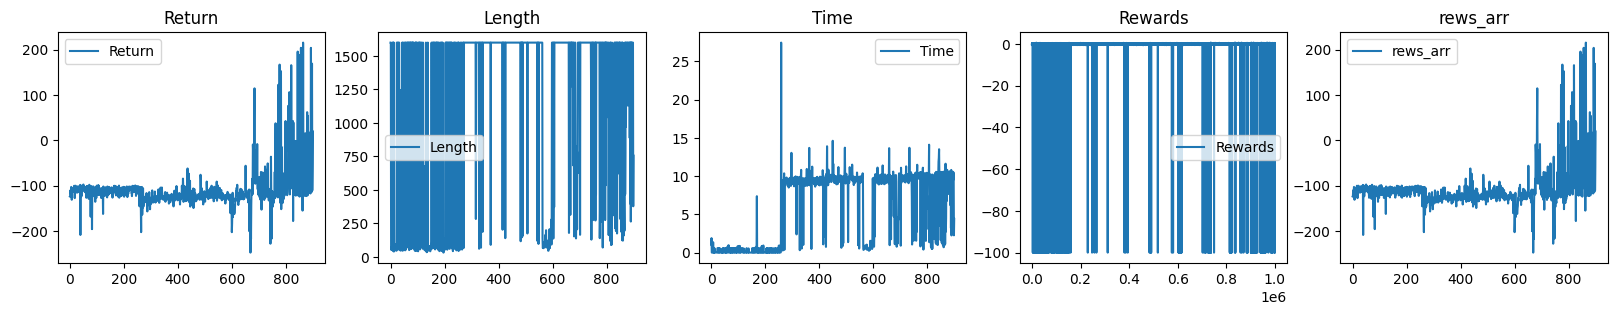

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 3))

ax1.plot(rs, label='Return')
ax1.legend()
ax1.set_title("Return")

ax2.plot(ls, label='Length')
ax2.legend()
ax2.set_title("Length")

ax3.plot(ts, label='Time')
ax3.legend()
ax3.set_title("Time")

ax4.plot(rewards, label='Rewards')
ax4.legend()
ax4.set_title("Rewards")

ax5.plot(rews_arr, label='rews_arr')
ax5.legend()
ax5.set_title("rews_arr")

plt.show()


In [ ]:
eval_env = gym.make("BipedalWalker-v3", render_mode="rgb_array") #
eval_env = wrap_gym(eval_env, rescale_actions=True)
eval_env = gym.wrappers.RecordVideo(eval_env, 'BipedalWalker-v3')
eval_env = gym.wrappers.RecordEpisodeStatistics(eval_env, buffer_length=1)
evaluate(agent, eval_env, num_episodes=1)
eval_env.close()
